### Материалы

В указанных таблицах представлены лишь данные с 1 по 6 семестры обучения студентов

Не все данные соответствуют друг другу 1:1, например данных об обучении студентов заведомо больше, чем есть данных в оценках, поскольку цель задания - предсказать по этим данным долги за указанный период. Информация по дисциплинам может быть избыточной.
  

*Таблица comp_students.csv ~11000 строк*  
ISU - UID студента  
COURSE - курс обучения, которому соответствует запись  
DATE_START - начало периода обучения  
DATE_END - конец периода обучения  
PRIZNAK - состояние на конец периода обучения (обучен, академ, отчислен)  
MAIN_PLAN - образовательный план в данный промежуток времени  

*Таблица comp_portrait.csv ~ 5000 строк*  
ISU - UID студента  
GENDER - пол  
CITIZENSHIP - гражданство  
EXAM_TYPE - форма зачисления (ЕГЭ, олимпиада, ВИ - вступительные испытания)  
EXAM_SUBJECT_1 - первый экзамен ЕГЭ  
EXAM_SUBJECT_2 - второй экзамен ЕГЭ  
EXAM_SUBJECT_3 - третий экзамен ЕГЭ  
ADMITTED_EXAM_1 - баллы за 1 экзамен ЕГЭ  
ADMITTED_EXAM_2 - баллы за 2 экзамен ЕГЭ  
ADMITTED_EXAM_3 - баллы за 3 экзамен ЕГЭ  
ADMITTED_SUBJECT_PRIZE_LEVEL - уровень олимпиады (если есть)  
REGION_ID - номер региона  

*Таблица comp_marks.csv*  
ISU - UID студента  
ST_YEAR - год начала курса (первое число из формата 2020/2021)  
SEMESTER - фактический семестр, в котором получена оценка  
TYPE_NAME - форма отчетности  
MARK - оценка (или зачет/незачет)  
MAIN_PLAN - учебный план  
DISC_ID - UID дисциплины  
PRED_ID - UID преподавателя  

*Таблица comp_disc.csv*  
PLAN_ID - UID учебного плана (то же что и MAIN_PLAN - значения в этих колонках соответствуют друг другу и могут быть использованы для сопоставления таблиц)  
DISC_ID - UID дисциплины  
СHOICE - выборность дисциплины  
SEMESTER - семестр проведения дисциплины в данном учебном плане  
DISC_NAME - название дисциплины  
DISC_DEP - факультет-реализатор дисциплины  

*Таблица train.csv*  
- Таргет для обучения с оценками и количеством долгов студентов за 2017 - 2020 учебные годы (без 2021/2022 года)  
ISU - UID студента  
SEMESTER - семестр получения оценки  
DISC_ID - UID дисциплины  
DEBT - факт наличия долга (0 - отсутствие, 1 - наличие) - таргет  

*Таблица comp_teachers.csv*  

ISU - UID преподавателя  
GENDER - Пол  
DATE_BIRTH - Год рождения преподавателя  
ST_YEAR - год обучения  
SEMESTER - семестр преподавания  
DISC_ID - UID преподаваемой дисциплины  
MAIN_PLAN - UID учебного плана данной программы  
TYPE_NAME - форма контроля по предмету (экзамен, зачет, дифференцированный зачет)  
MARK - средняя оценка, выставленная преподавателем  

*Таблица test.csv*  
- Данные для теста - оценки и долги студентов за осенний семестр 2021/2022 года  
ISU - UID студента  
ST_YEAR - учебный год получения оценки  
SEMESTER - семестр получения оценки  
DISC_ID - UID дисциплины  
TYPE_NAME - форма отчетности  

*Файл с решением sample_submission.csv*  
ID - id с информацией о студенте и предмете  
data_test['ID'] = data_test[['ISU', 'ST_YEAR', 'DISC_ID', 'SEMESTER', 'TYPE_NAME']].apply( lambda x: f'ISU:{x[0]} | ST_YEAR:{x[1]} | DISC_ID:{x[2]} | SEMESTER:{x[3]} | TYPE_NAME:{x[4]}', axis =1)  
DEBT - предсказание наличия долга (0 - отсутствие, 1 - наличие)  

*Формирование решения смотрите в baseline.ipynb*

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
import random

np.random.seed(42)

In [2]:
import catboost as catb

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
data_train = pd.read_csv('./Data/train.csv')
data_test = pd.read_csv('./Data/test.csv')

In [5]:
data_portrait = pd.read_csv('./Data/comp_portrait.csv')

Изучим полученные датасеты

1. train.csv

In [6]:
data_train.head()

ISU  ST_YEAR  SEMESTER               DISC_ID TYPE_NAME  \
0  17623928044460629977     2020         1  10502311854018326223     Зачет   
1  17623928044460629977     2020         1   1601392918367593206     Зачет   
2  17623928044460629977     2020         1   9559803959325174929     Зачет   
3  17623928044460629977     2020         1   8955667882044263414     Зачет   
4  17623928044460629977     2020         1  17741967398854095262   Экзамен   

   DEBT  
0     0  
1     0  
2     0  
3     0  
4     0

In [7]:
data_train.describe()

ISU        ST_YEAR       SEMESTER       DISC_ID           DEBT
count  1.788990e+05  178899.000000  178899.000000  1.788990e+05  178899.000000
mean   9.220250e+18    2019.317766       2.591513  8.625679e+18       0.047351
std    5.335602e+18       0.748409       1.500138  4.895529e+18       0.212389
min    9.995044e+14    2018.000000       1.000000  1.092873e+16       0.000000
25%    4.622182e+18    2019.000000       1.000000  4.680678e+18       0.000000
50%    9.222993e+18    2019.000000       2.000000  8.955668e+18       0.000000
75%    1.388099e+19    2020.000000       4.000000  1.278649e+19       0.000000
max    1.844286e+19    2020.000000       6.000000  1.843137e+19       1.000000

In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178899 entries, 0 to 178898
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ISU        178899 non-null  uint64
 1   ST_YEAR    178899 non-null  int64 
 2   SEMESTER   178899 non-null  int64 
 3   DISC_ID    178899 non-null  uint64
 4   TYPE_NAME  178899 non-null  object
 5   DEBT       178899 non-null  int64 
dtypes: int64(3), object(1), uint64(2)
memory usage: 8.2+ MB


2. test.csv

In [9]:
data_test.head()

ISU  ST_YEAR  SEMESTER              DISC_ID TYPE_NAME
0  22160896830459167     2021         3   552619236026332123   Экзамен
1  22160896830459167     2021         3  5702509582319458883     Зачет
2  22160896830459167     2021         3  7735626259430674628     Зачет
3  22160896830459167     2021         3  8955667882044263414     Зачет
4  22160896830459167     2021         3  9075687484357010791     Зачет

In [10]:
data_test.describe()

ISU  ST_YEAR      SEMESTER       DISC_ID
count  3.091300e+04  30913.0  30913.000000  3.091300e+04
mean   9.271762e+18   2021.0      3.804710  9.271860e+18
std    5.302206e+18      0.0      1.182029  4.968477e+18
min    2.216090e+16   2021.0      1.000000  1.209074e+17
25%    4.713210e+18   2021.0      3.000000  5.702510e+18
50%    9.396060e+18   2021.0      3.000000  9.075687e+18
75%    1.379449e+19   2021.0      5.000000  1.319918e+19
max    1.844185e+19   2021.0      5.000000  1.820989e+19

In [11]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30913 entries, 0 to 30912
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ISU        30913 non-null  uint64
 1   ST_YEAR    30913 non-null  int64 
 2   SEMESTER   30913 non-null  int64 
 3   DISC_ID    30913 non-null  uint64
 4   TYPE_NAME  30913 non-null  object
dtypes: int64(2), object(1), uint64(2)
memory usage: 1.2+ MB


3. comp_portrait.csv

In [12]:
data_portrait.head()

ISU GENDER           CITIZENSHIP EXAM_TYPE  \
0   8746993777733478780      Ж  15601729049989747827       ЕГЭ   
1  18279003839105282485      М  15601729049989747827        ВИ   
2  17601399077733331421      М  15601729049989747827        ВИ   
3   4111128904589594590      М  15601729049989747827        ВИ   
4   5943608672516320930      М  15601729049989747827        ВИ   

      EXAM_SUBJECT_1       EXAM_SUBJECT_2       EXAM_SUBJECT_3  \
0  70786669040476600  5533732657842394915  8388269026169219461   
1  70786669040476600  5533732657842394915  8388269026169219461   
2  70786669040476600  5533732657842394915  8388269026169219461   
3  70786669040476600  5533732657842394915  8388269026169219461   
4  70786669040476600  5533732657842394915  8388269026169219461   

   ADMITTED_EXAM_1  ADMITTED_EXAM_2  ADMITTED_EXAM_3  \
0             88.0             91.0             81.0   
1             84.0             89.0             96.0   
2             66.0             78.0             93.0   
3            100.0             89.0             80.0   
4             84.0             86.0             91.0   

  ADMITTED_SUBJECT_PRIZE_LEVEL            REGION_ID  
0                          ЕГЭ  4877310761925081124  
1                          ЕГЭ  4877310761925081124  
2                          ЕГЭ  4877310761925081124  
3                          ЕГЭ  4877310761925081124  
4                          ЕГЭ  4877310761925081124

In [13]:
data_portrait.describe()

ISU   CITIZENSHIP  EXAM_SUBJECT_1  EXAM_SUBJECT_2  \
count  8.583000e+03  8.583000e+03    8.583000e+03    8.583000e+03   
mean   9.294520e+18  1.522729e+19    1.911511e+18    5.175546e+18   
std    5.326729e+18  2.029661e+18    3.375245e+18    3.729603e+18   
min    9.995044e+14  2.100648e+18    7.078667e+16    7.078667e+16   
25%    4.711624e+18  1.560173e+19    7.078667e+16    7.078667e+16   
50%    9.355502e+18  1.560173e+19    7.078667e+16    5.533733e+18   
75%    1.391744e+19  1.560173e+19    5.533733e+18    5.826293e+18   
max    1.844291e+19  1.837346e+19    1.446266e+19    1.446266e+19   

       EXAM_SUBJECT_3  ADMITTED_EXAM_1  ADMITTED_EXAM_2  ADMITTED_EXAM_3  \
count    8.583000e+03      7404.000000      7404.000000      7404.000000   
mean     8.200343e+18        80.709751        81.961777        85.266072   
std      1.061979e+18        13.248889        14.676595        12.806975   
min      5.533733e+18         0.000000         0.000000         0.000000   
25%      8.388269e+18        74.000000        75.000000        80.000000   
50%      8.388269e+18        80.000000        83.000000        88.000000   
75%      8.388269e+18        90.000000        91.000000        94.000000   
max      1.446266e+19       100.000000       100.000000       100.000000   

          REGION_ID  
count  8.583000e+03  
mean   7.274518e+18  
std    4.634645e+18  
min    1.123545e+17  
25%    4.877311e+18  
50%    4.877311e+18  
75%    1.094982e+19  
max    1.775942e+19

In [14]:
data_portrait.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8583 entries, 0 to 8582
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ISU                           8583 non-null   uint64 
 1   GENDER                        8583 non-null   object 
 2   CITIZENSHIP                   8583 non-null   uint64 
 3   EXAM_TYPE                     8582 non-null   object 
 4   EXAM_SUBJECT_1                8583 non-null   uint64 
 5   EXAM_SUBJECT_2                8583 non-null   uint64 
 6   EXAM_SUBJECT_3                8583 non-null   uint64 
 7   ADMITTED_EXAM_1               7404 non-null   float64
 8   ADMITTED_EXAM_2               7404 non-null   float64
 9   ADMITTED_EXAM_3               7404 non-null   float64
 10  ADMITTED_SUBJECT_PRIZE_LEVEL  8583 non-null   object 
 11  REGION_ID                     8583 non-null   uint64 
dtypes: float64(3), object(3), uint64(6)
memory usage: 804.8+ KB


Уберем пустые ячейки в датасете, заменив их на ноли

In [15]:
data_portrait = data_portrait.fillna(0)

In [16]:
data_portrait.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8583 entries, 0 to 8582
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ISU                           8583 non-null   uint64 
 1   GENDER                        8583 non-null   object 
 2   CITIZENSHIP                   8583 non-null   uint64 
 3   EXAM_TYPE                     8583 non-null   object 
 4   EXAM_SUBJECT_1                8583 non-null   uint64 
 5   EXAM_SUBJECT_2                8583 non-null   uint64 
 6   EXAM_SUBJECT_3                8583 non-null   uint64 
 7   ADMITTED_EXAM_1               8583 non-null   float64
 8   ADMITTED_EXAM_2               8583 non-null   float64
 9   ADMITTED_EXAM_3               8583 non-null   float64
 10  ADMITTED_SUBJECT_PRIZE_LEVEL  8583 non-null   object 
 11  REGION_ID                     8583 non-null   uint64 
dtypes: float64(3), object(3), uint64(6)
memory usage: 804.8+ KB


Закодируем значения ячеек в датасета, написанных по-русски

In [17]:
data_portrait['GENDER'].value_counts()

М    5888
Ж    2695
Name: GENDER, dtype: int64

In [18]:
data_portrait['GENDER']= data_portrait['GENDER'].replace({'М': 1, 'Ж': 0})

In [19]:
data_portrait['EXAM_TYPE'].value_counts()

ЕГЭ          6932
ОЛИМПИАДА    1179
ВИ            471
0               1
Name: EXAM_TYPE, dtype: int64

In [20]:
data_portrait['EXAM_TYPE']= data_portrait['EXAM_TYPE'].replace({'ЕГЭ': 1, 'ОЛИМПИАДА': 2, 'ВИ': 3})

In [21]:
data_portrait['ADMITTED_SUBJECT_PRIZE_LEVEL'].value_counts()

ЕГЭ    6783
1.0     838
2.0     604
3.0     278
0.0      44
4.0      36
Name: ADMITTED_SUBJECT_PRIZE_LEVEL, dtype: int64

In [22]:
data_portrait['ADMITTED_SUBJECT_PRIZE_LEVEL']= data_portrait['ADMITTED_SUBJECT_PRIZE_LEVEL'].replace({'ЕГЭ': 5})

Обработка датасета (baseline model)

In [23]:
all_st_df = []

for st_year in data_train['ST_YEAR'].unique():
    for semester in data_train['SEMESTER'].unique():
        data_temp = (
            data_train
            .drop('DISC_ID', axis=1)
            [(data_train['ST_YEAR'] < st_year) & (data_train['SEMESTER'] < semester)]
            .groupby(['ISU', 'TYPE_NAME'], as_index=False)
            .agg(DEBT_MEAN=('DEBT', 'mean'), DEBT_SUM=('DEBT', 'sum'), DEBT_COUNT=('DEBT', 'count')
            )
        )
        data_temp['ST_YEAR'] = st_year
        data_temp['SEMESTER'] = semester
        
        all_st_df.append(data_temp)

In [24]:
all_st_df = pd.concat(all_st_df)

In [25]:
all_disc_df = []

for st_year in data_train['ST_YEAR'].unique():
    for semester in data_train['SEMESTER'].unique():
        data_temp = (
            data_train
            .drop('ISU', axis=1)
            [(data_train['ST_YEAR'] < st_year) & (data_train['SEMESTER'] < semester)]
            .groupby(['DISC_ID', 'TYPE_NAME'], as_index=False)
            .agg(DISC_DEBT_MEAN=('DEBT', 'mean'), DISC_DEBT_SUM=('DEBT', 'sum'), DISC_DEBT_COUNT=('DEBT', 'count')
            )
        )
        data_temp['ST_YEAR'] = st_year
        data_temp['SEMESTER'] = semester
        
        all_disc_df.append(data_temp)

In [26]:
all_disc_df = pd.concat(all_disc_df)

In [27]:
data_train = data_train.merge(all_st_df, on=['ISU', 'ST_YEAR', 'SEMESTER', 'TYPE_NAME'], how='left')

In [28]:
data_train = data_train.merge(all_disc_df, on=['DISC_ID', 'ST_YEAR', 'SEMESTER', 'TYPE_NAME'], how='left')

In [29]:
data_train = data_train.fillna(0)

In [30]:
data_train = data_train.join(pd.get_dummies(data_train['TYPE_NAME'], prefix='TYPE_NAME'))

In [31]:
data_train = data_train.merge(data_portrait, on=['ISU'], how='left')

In [32]:
data_train = data_train.fillna(0)

In [33]:
cols_to_drop = ['ISU', 'DISC_ID', 'TYPE_NAME']

In [34]:
train = data_train[data_train['ST_YEAR'].isin([2018, 2019])].drop(cols_to_drop, axis=1)
test = data_train[data_train['ST_YEAR'] == 2020].drop(cols_to_drop, axis=1)

In [35]:
train.head()

ST_YEAR  SEMESTER  DEBT  DEBT_MEAN  DEBT_SUM  DEBT_COUNT  DISC_DEBT_MEAN  \
16     2019         1     0        0.0       0.0         0.0             0.0   
17     2019         2     0        0.0       0.0         4.0             0.0   
18     2019         1     0        0.0       0.0         0.0             0.0   
19     2019         1     0        0.0       0.0         0.0             0.0   
20     2018         1     0        0.0       0.0         0.0             0.0   

    DISC_DEBT_SUM  DISC_DEBT_COUNT  TYPE_NAME_Дифференцированный зачет  ...  \
16            0.0              0.0                                   0  ...   
17            0.0              0.0                                   0  ...   
18            0.0              0.0                                   0  ...   
19            0.0              0.0                                   0  ...   
20            0.0              0.0                                   0  ...   

             CITIZENSHIP  EXAM_TYPE     EXAM_SUBJECT_1        EXAM_SUBJECT_2  \
16   2100647966528810364          3  70786669040476600   5533732657842394915   
17   2100647966528810364          3  70786669040476600  14462659375807213512   
18   2100647966528810364          3  70786669040476600   5533732657842394915   
19   2100647966528810364          3  70786669040476600   5533732657842394915   
20  11257130222546647103          3  70786669040476600  11200029731125595475   

         EXAM_SUBJECT_3  ADMITTED_EXAM_1  ADMITTED_EXAM_2  ADMITTED_EXAM_3  \
16  8388269026169219461             98.0              0.0             88.0   
17  8388269026169219461             60.0              0.0             60.0   
18  8388269026169219461             62.0              0.0             68.0   
19  8388269026169219461             84.0              0.0            100.0   
20  8388269026169219461             62.0             63.0             80.0   

    ADMITTED_SUBJECT_PRIZE_LEVEL            REGION_ID  
16                             5  5087927234000983963  
17                             5  5087927234000983963  
18                             5  5087927234000983963  
19                             5  5087927234000983963  
20                             5  5087927234000983963  

[5 rows x 24 columns]

In [36]:
X_train = train.drop(['DEBT'], axis=1)
y_train = train['DEBT']

X_test = test.drop(['DEBT'], axis=1)
y_test = test['DEBT']

#### Подбор гиперпараметров модели

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
cat =  catb.CatBoostClassifier()

In [39]:
parametrs = {'n_estimators': range (100, 500, 50),
             'max_depth': range (1, 10, 1)}

In [40]:
grid = GridSearchCV(cat, parametrs, cv=5)
grid.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.2856922	total: 168ms	remaining: 16.6s
1:	learn: 0.2204504	total: 179ms	remaining: 8.79s
2:	learn: 0.2058880	total: 191ms	remaining: 6.17s
3:	learn: 0.2023245	total: 200ms	remaining: 4.81s
4:	learn: 0.1996032	total: 210ms	remaining: 3.98s
5:	learn: 0.1990037	total: 218ms	remaining: 3.42s
6:	learn: 0.1977053	total: 229ms	remaining: 3.04s
7:	learn: 0.1970499	total: 238ms	remaining: 2.74s
8:	learn: 0.1967415	total: 249ms	remaining: 2.51s
9:	learn: 0.1959675	total: 257ms	remaining: 2.31s
10:	learn: 0.1952784	total: 266ms	remaining: 2.15s
11:	learn: 0.1949269	total: 276ms	remaining: 2.03s
12:	learn: 0.1948107	total: 287ms	remaining: 1.92s
13:	learn: 0.1942054	total: 297ms	remaining: 1.83s
14:	learn: 0.1939235	total: 305ms	remaining: 1.73s
15:	learn: 0.1937605	total: 315ms	remaining: 1.65s
16:	learn: 0.1934776	total: 323ms	remaining: 1.58s
17:	learn: 0.1933925	total: 332ms	remaining: 1.51s
18:	learn: 0.1930595	total: 341ms	remaining: 1.45s
19:	learn: 0.192

60:	learn: 0.1886983	total: 718ms	remaining: 459ms
61:	learn: 0.1885991	total: 731ms	remaining: 448ms
62:	learn: 0.1884962	total: 743ms	remaining: 436ms
63:	learn: 0.1884043	total: 755ms	remaining: 424ms
64:	learn: 0.1883102	total: 766ms	remaining: 413ms
65:	learn: 0.1882260	total: 777ms	remaining: 400ms
66:	learn: 0.1881404	total: 788ms	remaining: 388ms
67:	learn: 0.1881200	total: 804ms	remaining: 379ms
68:	learn: 0.1881040	total: 819ms	remaining: 368ms
69:	learn: 0.1880245	total: 831ms	remaining: 356ms
70:	learn: 0.1879454	total: 845ms	remaining: 345ms
71:	learn: 0.1879298	total: 857ms	remaining: 333ms
72:	learn: 0.1879122	total: 871ms	remaining: 322ms
73:	learn: 0.1878583	total: 884ms	remaining: 311ms
74:	learn: 0.1878142	total: 906ms	remaining: 302ms
75:	learn: 0.1877737	total: 919ms	remaining: 290ms
76:	learn: 0.1876902	total: 932ms	remaining: 278ms
77:	learn: 0.1875952	total: 947ms	remaining: 267ms
78:	learn: 0.1875474	total: 960ms	remaining: 255ms
79:	learn: 0.1874846	total: 972

34:	learn: 0.1917916	total: 411ms	remaining: 764ms
35:	learn: 0.1916707	total: 422ms	remaining: 750ms
36:	learn: 0.1915443	total: 430ms	remaining: 732ms
37:	learn: 0.1915120	total: 440ms	remaining: 717ms
38:	learn: 0.1914851	total: 452ms	remaining: 708ms
39:	learn: 0.1914455	total: 465ms	remaining: 698ms
40:	learn: 0.1914109	total: 478ms	remaining: 687ms
41:	learn: 0.1913828	total: 489ms	remaining: 675ms
42:	learn: 0.1913051	total: 500ms	remaining: 662ms
43:	learn: 0.1911928	total: 511ms	remaining: 650ms
44:	learn: 0.1910808	total: 523ms	remaining: 639ms
45:	learn: 0.1910531	total: 536ms	remaining: 629ms
46:	learn: 0.1910243	total: 549ms	remaining: 619ms
47:	learn: 0.1910048	total: 562ms	remaining: 609ms
48:	learn: 0.1909178	total: 573ms	remaining: 597ms
49:	learn: 0.1907238	total: 585ms	remaining: 585ms
50:	learn: 0.1906699	total: 598ms	remaining: 574ms
51:	learn: 0.1905569	total: 612ms	remaining: 565ms
52:	learn: 0.1904943	total: 624ms	remaining: 553ms
53:	learn: 0.1904299	total: 634

Learning rate set to 0.366674
0:	learn: 0.3514388	total: 12.3ms	remaining: 1.83s
1:	learn: 0.2521781	total: 21.9ms	remaining: 1.62s
2:	learn: 0.2194037	total: 30.8ms	remaining: 1.51s
3:	learn: 0.2083210	total: 39.8ms	remaining: 1.45s
4:	learn: 0.2039284	total: 49.3ms	remaining: 1.43s
5:	learn: 0.2019078	total: 59.5ms	remaining: 1.43s
6:	learn: 0.1997082	total: 72ms	remaining: 1.47s
7:	learn: 0.1984617	total: 84.7ms	remaining: 1.5s
8:	learn: 0.1981048	total: 96.5ms	remaining: 1.51s
9:	learn: 0.1978283	total: 106ms	remaining: 1.48s
10:	learn: 0.1975876	total: 116ms	remaining: 1.47s
11:	learn: 0.1970810	total: 126ms	remaining: 1.45s
12:	learn: 0.1969001	total: 136ms	remaining: 1.43s
13:	learn: 0.1963726	total: 147ms	remaining: 1.43s
14:	learn: 0.1959135	total: 156ms	remaining: 1.4s
15:	learn: 0.1952680	total: 166ms	remaining: 1.39s
16:	learn: 0.1949566	total: 178ms	remaining: 1.39s
17:	learn: 0.1948662	total: 189ms	remaining: 1.38s
18:	learn: 0.1944739	total: 197ms	remaining: 1.36s
19:	le

18:	learn: 0.1953170	total: 198ms	remaining: 1.37s
19:	learn: 0.1952483	total: 214ms	remaining: 1.39s
20:	learn: 0.1949165	total: 225ms	remaining: 1.38s
21:	learn: 0.1947044	total: 235ms	remaining: 1.36s
22:	learn: 0.1944039	total: 244ms	remaining: 1.35s
23:	learn: 0.1941005	total: 253ms	remaining: 1.33s
24:	learn: 0.1937540	total: 263ms	remaining: 1.31s
25:	learn: 0.1935836	total: 274ms	remaining: 1.3s
26:	learn: 0.1933172	total: 284ms	remaining: 1.29s
27:	learn: 0.1931956	total: 295ms	remaining: 1.29s
28:	learn: 0.1930576	total: 305ms	remaining: 1.27s
29:	learn: 0.1929131	total: 313ms	remaining: 1.25s
30:	learn: 0.1928772	total: 323ms	remaining: 1.24s
31:	learn: 0.1928124	total: 332ms	remaining: 1.22s
32:	learn: 0.1926869	total: 340ms	remaining: 1.21s
33:	learn: 0.1926310	total: 349ms	remaining: 1.19s
34:	learn: 0.1924888	total: 359ms	remaining: 1.18s
35:	learn: 0.1923501	total: 368ms	remaining: 1.16s
36:	learn: 0.1922156	total: 379ms	remaining: 1.16s
37:	learn: 0.1921170	total: 390m

33:	learn: 0.1934327	total: 343ms	remaining: 1.17s
34:	learn: 0.1933094	total: 356ms	remaining: 1.17s
35:	learn: 0.1932596	total: 369ms	remaining: 1.17s
36:	learn: 0.1932096	total: 381ms	remaining: 1.16s
37:	learn: 0.1930426	total: 393ms	remaining: 1.16s
38:	learn: 0.1928888	total: 403ms	remaining: 1.15s
39:	learn: 0.1927879	total: 413ms	remaining: 1.14s
40:	learn: 0.1926868	total: 422ms	remaining: 1.12s
41:	learn: 0.1925535	total: 430ms	remaining: 1.1s
42:	learn: 0.1925313	total: 440ms	remaining: 1.09s
43:	learn: 0.1924385	total: 450ms	remaining: 1.08s
44:	learn: 0.1924126	total: 461ms	remaining: 1.07s
45:	learn: 0.1923968	total: 472ms	remaining: 1.07s
46:	learn: 0.1923587	total: 484ms	remaining: 1.06s
47:	learn: 0.1922956	total: 493ms	remaining: 1.05s
48:	learn: 0.1921915	total: 502ms	remaining: 1.03s
49:	learn: 0.1921739	total: 513ms	remaining: 1.03s
50:	learn: 0.1921165	total: 523ms	remaining: 1.02s
51:	learn: 0.1920460	total: 533ms	remaining: 1s
52:	learn: 0.1919995	total: 542ms	r

45:	learn: 0.1921626	total: 542ms	remaining: 1.23s
46:	learn: 0.1921390	total: 559ms	remaining: 1.23s
47:	learn: 0.1921094	total: 594ms	remaining: 1.26s
48:	learn: 0.1920913	total: 618ms	remaining: 1.27s
49:	learn: 0.1920707	total: 634ms	remaining: 1.27s
50:	learn: 0.1919868	total: 647ms	remaining: 1.25s
51:	learn: 0.1918930	total: 659ms	remaining: 1.24s
52:	learn: 0.1918640	total: 674ms	remaining: 1.23s
53:	learn: 0.1918384	total: 686ms	remaining: 1.22s
54:	learn: 0.1917322	total: 700ms	remaining: 1.21s
55:	learn: 0.1916721	total: 712ms	remaining: 1.2s
56:	learn: 0.1916145	total: 725ms	remaining: 1.18s
57:	learn: 0.1915307	total: 741ms	remaining: 1.18s
58:	learn: 0.1914712	total: 756ms	remaining: 1.17s
59:	learn: 0.1913810	total: 769ms	remaining: 1.15s
60:	learn: 0.1913437	total: 780ms	remaining: 1.14s
61:	learn: 0.1912906	total: 794ms	remaining: 1.13s
62:	learn: 0.1912138	total: 810ms	remaining: 1.12s
63:	learn: 0.1911146	total: 825ms	remaining: 1.11s
64:	learn: 0.1910334	total: 837m

66:	learn: 0.1897801	total: 705ms	remaining: 873ms
67:	learn: 0.1897614	total: 715ms	remaining: 862ms
68:	learn: 0.1897562	total: 727ms	remaining: 853ms
69:	learn: 0.1897193	total: 735ms	remaining: 840ms
70:	learn: 0.1896715	total: 746ms	remaining: 830ms
71:	learn: 0.1896339	total: 755ms	remaining: 818ms
72:	learn: 0.1895954	total: 764ms	remaining: 806ms
73:	learn: 0.1895383	total: 773ms	remaining: 794ms
74:	learn: 0.1894883	total: 782ms	remaining: 782ms
75:	learn: 0.1893894	total: 791ms	remaining: 770ms
76:	learn: 0.1893743	total: 799ms	remaining: 758ms
77:	learn: 0.1893646	total: 808ms	remaining: 746ms
78:	learn: 0.1893256	total: 817ms	remaining: 734ms
79:	learn: 0.1892868	total: 826ms	remaining: 723ms
80:	learn: 0.1892678	total: 835ms	remaining: 712ms
81:	learn: 0.1892353	total: 844ms	remaining: 700ms
82:	learn: 0.1892036	total: 852ms	remaining: 688ms
83:	learn: 0.1891801	total: 861ms	remaining: 676ms
84:	learn: 0.1891653	total: 869ms	remaining: 665ms
85:	learn: 0.1891572	total: 878

89:	learn: 0.1895113	total: 891ms	remaining: 1.09s
90:	learn: 0.1894984	total: 903ms	remaining: 1.08s
91:	learn: 0.1894570	total: 912ms	remaining: 1.07s
92:	learn: 0.1894203	total: 923ms	remaining: 1.06s
93:	learn: 0.1893849	total: 933ms	remaining: 1.05s
94:	learn: 0.1893742	total: 946ms	remaining: 1.04s
95:	learn: 0.1893628	total: 959ms	remaining: 1.04s
96:	learn: 0.1893188	total: 968ms	remaining: 1.03s
97:	learn: 0.1892306	total: 981ms	remaining: 1.02s
98:	learn: 0.1891778	total: 990ms	remaining: 1.01s
99:	learn: 0.1891296	total: 1000ms	remaining: 1000ms
100:	learn: 0.1890915	total: 1.01s	remaining: 989ms
101:	learn: 0.1890776	total: 1.02s	remaining: 980ms
102:	learn: 0.1890109	total: 1.03s	remaining: 970ms
103:	learn: 0.1889593	total: 1.04s	remaining: 961ms
104:	learn: 0.1889160	total: 1.05s	remaining: 951ms
105:	learn: 0.1889037	total: 1.06s	remaining: 942ms
106:	learn: 0.1888559	total: 1.07s	remaining: 934ms
107:	learn: 0.1888368	total: 1.08s	remaining: 924ms
108:	learn: 0.1888068

56:	learn: 0.1918818	total: 725ms	remaining: 1.82s
57:	learn: 0.1917834	total: 739ms	remaining: 1.81s
58:	learn: 0.1917630	total: 754ms	remaining: 1.8s
59:	learn: 0.1917422	total: 768ms	remaining: 1.79s
60:	learn: 0.1916885	total: 781ms	remaining: 1.78s
61:	learn: 0.1916222	total: 792ms	remaining: 1.76s
62:	learn: 0.1915427	total: 804ms	remaining: 1.75s
63:	learn: 0.1914688	total: 816ms	remaining: 1.73s
64:	learn: 0.1914041	total: 828ms	remaining: 1.72s
65:	learn: 0.1913567	total: 839ms	remaining: 1.7s
66:	learn: 0.1912964	total: 851ms	remaining: 1.69s
67:	learn: 0.1912401	total: 864ms	remaining: 1.68s
68:	learn: 0.1911960	total: 879ms	remaining: 1.67s
69:	learn: 0.1911503	total: 889ms	remaining: 1.65s
70:	learn: 0.1910564	total: 905ms	remaining: 1.64s
71:	learn: 0.1909805	total: 918ms	remaining: 1.63s
72:	learn: 0.1909219	total: 930ms	remaining: 1.62s
73:	learn: 0.1908336	total: 941ms	remaining: 1.6s
74:	learn: 0.1907726	total: 953ms	remaining: 1.59s
75:	learn: 0.1906948	total: 964ms	

17:	learn: 0.1969535	total: 174ms	remaining: 1.76s
18:	learn: 0.1968848	total: 187ms	remaining: 1.78s
19:	learn: 0.1967697	total: 197ms	remaining: 1.77s
20:	learn: 0.1965025	total: 207ms	remaining: 1.76s
21:	learn: 0.1964452	total: 217ms	remaining: 1.75s
22:	learn: 0.1962594	total: 225ms	remaining: 1.73s
23:	learn: 0.1960387	total: 235ms	remaining: 1.72s
24:	learn: 0.1958448	total: 244ms	remaining: 1.71s
25:	learn: 0.1957552	total: 254ms	remaining: 1.7s
26:	learn: 0.1955277	total: 263ms	remaining: 1.69s
27:	learn: 0.1953052	total: 273ms	remaining: 1.67s
28:	learn: 0.1950028	total: 282ms	remaining: 1.67s
29:	learn: 0.1949835	total: 292ms	remaining: 1.65s
30:	learn: 0.1948823	total: 301ms	remaining: 1.64s
31:	learn: 0.1948305	total: 310ms	remaining: 1.63s
32:	learn: 0.1946966	total: 319ms	remaining: 1.62s
33:	learn: 0.1945259	total: 329ms	remaining: 1.6s
34:	learn: 0.1944080	total: 339ms	remaining: 1.6s
35:	learn: 0.1942450	total: 351ms	remaining: 1.6s
36:	learn: 0.1942163	total: 362ms	r

196:	learn: 0.1892483	total: 1.96s	remaining: 29.8ms
197:	learn: 0.1892345	total: 1.97s	remaining: 19.9ms
198:	learn: 0.1892195	total: 1.98s	remaining: 9.94ms
199:	learn: 0.1892094	total: 1.99s	remaining: 0us
Learning rate set to 0.281653
0:	learn: 0.4081158	total: 11.3ms	remaining: 2.25s
1:	learn: 0.2923247	total: 23.8ms	remaining: 2.36s
2:	learn: 0.2426438	total: 35.8ms	remaining: 2.35s
3:	learn: 0.2217537	total: 45.7ms	remaining: 2.24s
4:	learn: 0.2115044	total: 56.5ms	remaining: 2.2s
5:	learn: 0.2066910	total: 66.5ms	remaining: 2.15s
6:	learn: 0.2041741	total: 76.3ms	remaining: 2.1s
7:	learn: 0.2018374	total: 86.5ms	remaining: 2.08s
8:	learn: 0.2010432	total: 100ms	remaining: 2.13s
9:	learn: 0.2004755	total: 111ms	remaining: 2.11s
10:	learn: 0.1998820	total: 122ms	remaining: 2.1s
11:	learn: 0.1991655	total: 133ms	remaining: 2.08s
12:	learn: 0.1989860	total: 142ms	remaining: 2.05s
13:	learn: 0.1983147	total: 152ms	remaining: 2.02s
14:	learn: 0.1979949	total: 162ms	remaining: 2s
15:	

167:	learn: 0.1886271	total: 1.81s	remaining: 345ms
168:	learn: 0.1885944	total: 1.82s	remaining: 334ms
169:	learn: 0.1885731	total: 1.83s	remaining: 324ms
170:	learn: 0.1885494	total: 1.85s	remaining: 313ms
171:	learn: 0.1885297	total: 1.86s	remaining: 303ms
172:	learn: 0.1885218	total: 1.87s	remaining: 292ms
173:	learn: 0.1885160	total: 1.89s	remaining: 282ms
174:	learn: 0.1885013	total: 1.9s	remaining: 271ms
175:	learn: 0.1884846	total: 1.91s	remaining: 260ms
176:	learn: 0.1884677	total: 1.92s	remaining: 249ms
177:	learn: 0.1884527	total: 1.93s	remaining: 238ms
178:	learn: 0.1884318	total: 1.93s	remaining: 227ms
179:	learn: 0.1884156	total: 1.94s	remaining: 216ms
180:	learn: 0.1883890	total: 1.96s	remaining: 205ms
181:	learn: 0.1883588	total: 1.97s	remaining: 194ms
182:	learn: 0.1883308	total: 1.97s	remaining: 183ms
183:	learn: 0.1883053	total: 1.99s	remaining: 173ms
184:	learn: 0.1882770	total: 2s	remaining: 162ms
185:	learn: 0.1882599	total: 2.01s	remaining: 151ms
186:	learn: 0.18

129:	learn: 0.1888489	total: 1.34s	remaining: 722ms
130:	learn: 0.1888334	total: 1.35s	remaining: 713ms
131:	learn: 0.1888160	total: 1.36s	remaining: 703ms
132:	learn: 0.1888140	total: 1.38s	remaining: 697ms
133:	learn: 0.1887952	total: 1.39s	remaining: 686ms
134:	learn: 0.1887714	total: 1.4s	remaining: 675ms
135:	learn: 0.1887491	total: 1.41s	remaining: 664ms
136:	learn: 0.1887198	total: 1.42s	remaining: 654ms
137:	learn: 0.1887062	total: 1.43s	remaining: 643ms
138:	learn: 0.1886906	total: 1.44s	remaining: 632ms
139:	learn: 0.1886700	total: 1.45s	remaining: 621ms
140:	learn: 0.1886561	total: 1.46s	remaining: 610ms
141:	learn: 0.1886479	total: 1.47s	remaining: 600ms
142:	learn: 0.1886430	total: 1.48s	remaining: 589ms
143:	learn: 0.1886012	total: 1.49s	remaining: 579ms
144:	learn: 0.1885868	total: 1.5s	remaining: 568ms
145:	learn: 0.1885558	total: 1.51s	remaining: 558ms
146:	learn: 0.1885347	total: 1.52s	remaining: 547ms
147:	learn: 0.1885053	total: 1.53s	remaining: 537ms
148:	learn: 0.

103:	learn: 0.1899983	total: 1.06s	remaining: 1.5s
104:	learn: 0.1899511	total: 1.08s	remaining: 1.49s
105:	learn: 0.1899107	total: 1.09s	remaining: 1.48s
106:	learn: 0.1898748	total: 1.09s	remaining: 1.46s
107:	learn: 0.1898463	total: 1.1s	remaining: 1.45s
108:	learn: 0.1898116	total: 1.11s	remaining: 1.44s
109:	learn: 0.1897586	total: 1.12s	remaining: 1.43s
110:	learn: 0.1897230	total: 1.13s	remaining: 1.42s
111:	learn: 0.1896928	total: 1.14s	remaining: 1.41s
112:	learn: 0.1896467	total: 1.15s	remaining: 1.4s
113:	learn: 0.1896342	total: 1.16s	remaining: 1.38s
114:	learn: 0.1896236	total: 1.17s	remaining: 1.37s
115:	learn: 0.1896129	total: 1.18s	remaining: 1.36s
116:	learn: 0.1895748	total: 1.19s	remaining: 1.35s
117:	learn: 0.1895267	total: 1.2s	remaining: 1.34s
118:	learn: 0.1894848	total: 1.21s	remaining: 1.33s
119:	learn: 0.1894434	total: 1.22s	remaining: 1.32s
120:	learn: 0.1894052	total: 1.23s	remaining: 1.31s
121:	learn: 0.1893735	total: 1.24s	remaining: 1.3s
122:	learn: 0.189

19:	learn: 0.1969203	total: 187ms	remaining: 2.15s
20:	learn: 0.1965796	total: 199ms	remaining: 2.17s
21:	learn: 0.1964183	total: 210ms	remaining: 2.17s
22:	learn: 0.1962063	total: 220ms	remaining: 2.17s
23:	learn: 0.1961312	total: 229ms	remaining: 2.16s
24:	learn: 0.1958078	total: 239ms	remaining: 2.15s
25:	learn: 0.1956509	total: 249ms	remaining: 2.14s
26:	learn: 0.1955925	total: 258ms	remaining: 2.13s
27:	learn: 0.1954032	total: 267ms	remaining: 2.12s
28:	learn: 0.1953427	total: 277ms	remaining: 2.11s
29:	learn: 0.1952264	total: 286ms	remaining: 2.1s
30:	learn: 0.1950020	total: 295ms	remaining: 2.09s
31:	learn: 0.1948071	total: 306ms	remaining: 2.08s
32:	learn: 0.1947361	total: 315ms	remaining: 2.07s
33:	learn: 0.1946942	total: 324ms	remaining: 2.06s
34:	learn: 0.1945191	total: 334ms	remaining: 2.05s
35:	learn: 0.1943674	total: 344ms	remaining: 2.04s
36:	learn: 0.1942214	total: 353ms	remaining: 2.03s
37:	learn: 0.1941128	total: 364ms	remaining: 2.03s
38:	learn: 0.1939597	total: 376m

180:	learn: 0.1877699	total: 1.78s	remaining: 681ms
181:	learn: 0.1877464	total: 1.8s	remaining: 671ms
182:	learn: 0.1877242	total: 1.81s	remaining: 662ms
183:	learn: 0.1877027	total: 1.82s	remaining: 654ms
184:	learn: 0.1876922	total: 1.83s	remaining: 644ms
185:	learn: 0.1876686	total: 1.84s	remaining: 634ms
186:	learn: 0.1876475	total: 1.85s	remaining: 624ms
187:	learn: 0.1876244	total: 1.86s	remaining: 613ms
188:	learn: 0.1875958	total: 1.87s	remaining: 603ms
189:	learn: 0.1875648	total: 1.88s	remaining: 593ms
190:	learn: 0.1875370	total: 1.89s	remaining: 583ms
191:	learn: 0.1875074	total: 1.89s	remaining: 572ms
192:	learn: 0.1874820	total: 1.9s	remaining: 562ms
193:	learn: 0.1874608	total: 1.91s	remaining: 552ms
194:	learn: 0.1874363	total: 1.92s	remaining: 542ms
195:	learn: 0.1874164	total: 1.93s	remaining: 531ms
196:	learn: 0.1873892	total: 1.94s	remaining: 521ms
197:	learn: 0.1873611	total: 1.95s	remaining: 511ms
198:	learn: 0.1873405	total: 1.96s	remaining: 501ms
199:	learn: 0.

93:	learn: 0.1916977	total: 1.06s	remaining: 1.76s
94:	learn: 0.1916604	total: 1.07s	remaining: 1.75s
95:	learn: 0.1916195	total: 1.08s	remaining: 1.74s
96:	learn: 0.1916113	total: 1.09s	remaining: 1.73s
97:	learn: 0.1915872	total: 1.11s	remaining: 1.72s
98:	learn: 0.1915301	total: 1.12s	remaining: 1.71s
99:	learn: 0.1915068	total: 1.13s	remaining: 1.7s
100:	learn: 0.1914883	total: 1.15s	remaining: 1.69s
101:	learn: 0.1914775	total: 1.16s	remaining: 1.68s
102:	learn: 0.1914531	total: 1.17s	remaining: 1.67s
103:	learn: 0.1914180	total: 1.18s	remaining: 1.66s
104:	learn: 0.1913786	total: 1.2s	remaining: 1.65s
105:	learn: 0.1913525	total: 1.21s	remaining: 1.64s
106:	learn: 0.1913244	total: 1.22s	remaining: 1.63s
107:	learn: 0.1913158	total: 1.23s	remaining: 1.62s
108:	learn: 0.1913044	total: 1.24s	remaining: 1.61s
109:	learn: 0.1912975	total: 1.26s	remaining: 1.6s
110:	learn: 0.1912918	total: 1.27s	remaining: 1.59s
111:	learn: 0.1912813	total: 1.28s	remaining: 1.58s
112:	learn: 0.1912707	

11:	learn: 0.1995584	total: 181ms	remaining: 3.6s
12:	learn: 0.1992655	total: 196ms	remaining: 3.57s
13:	learn: 0.1989947	total: 209ms	remaining: 3.52s
14:	learn: 0.1988064	total: 223ms	remaining: 3.49s
15:	learn: 0.1986827	total: 234ms	remaining: 3.42s
16:	learn: 0.1983590	total: 245ms	remaining: 3.35s
17:	learn: 0.1978511	total: 256ms	remaining: 3.3s
18:	learn: 0.1977625	total: 265ms	remaining: 3.23s
19:	learn: 0.1974818	total: 275ms	remaining: 3.17s
20:	learn: 0.1973079	total: 286ms	remaining: 3.12s
21:	learn: 0.1972463	total: 295ms	remaining: 3.06s
22:	learn: 0.1971767	total: 308ms	remaining: 3.04s
23:	learn: 0.1969151	total: 321ms	remaining: 3.02s
24:	learn: 0.1966941	total: 332ms	remaining: 2.99s
25:	learn: 0.1965860	total: 344ms	remaining: 2.96s
26:	learn: 0.1964844	total: 357ms	remaining: 2.95s
27:	learn: 0.1964456	total: 368ms	remaining: 2.92s
28:	learn: 0.1962750	total: 379ms	remaining: 2.89s
29:	learn: 0.1960354	total: 388ms	remaining: 2.84s
30:	learn: 0.1957567	total: 399ms

173:	learn: 0.1892985	total: 1.97s	remaining: 859ms
174:	learn: 0.1892790	total: 1.98s	remaining: 847ms
175:	learn: 0.1892531	total: 1.99s	remaining: 835ms
176:	learn: 0.1892471	total: 2s	remaining: 823ms
177:	learn: 0.1892273	total: 2.01s	remaining: 812ms
178:	learn: 0.1891934	total: 2.02s	remaining: 800ms
179:	learn: 0.1891759	total: 2.02s	remaining: 788ms
180:	learn: 0.1891546	total: 2.03s	remaining: 775ms
181:	learn: 0.1891269	total: 2.04s	remaining: 763ms
182:	learn: 0.1891185	total: 2.06s	remaining: 752ms
183:	learn: 0.1891123	total: 2.06s	remaining: 741ms
184:	learn: 0.1890647	total: 2.08s	remaining: 730ms
185:	learn: 0.1890464	total: 2.09s	remaining: 719ms
186:	learn: 0.1890401	total: 2.1s	remaining: 708ms
187:	learn: 0.1890244	total: 2.11s	remaining: 696ms
188:	learn: 0.1889913	total: 2.12s	remaining: 684ms
189:	learn: 0.1889686	total: 2.13s	remaining: 672ms
190:	learn: 0.1889430	total: 2.14s	remaining: 661ms
191:	learn: 0.1889139	total: 2.15s	remaining: 649ms
192:	learn: 0.18

86:	learn: 0.1906330	total: 902ms	remaining: 1.69s
87:	learn: 0.1905925	total: 913ms	remaining: 1.68s
88:	learn: 0.1905483	total: 925ms	remaining: 1.67s
89:	learn: 0.1905316	total: 938ms	remaining: 1.67s
90:	learn: 0.1905202	total: 947ms	remaining: 1.66s
91:	learn: 0.1904884	total: 957ms	remaining: 1.64s
92:	learn: 0.1904544	total: 966ms	remaining: 1.63s
93:	learn: 0.1904099	total: 977ms	remaining: 1.62s
94:	learn: 0.1903714	total: 986ms	remaining: 1.61s
95:	learn: 0.1903378	total: 997ms	remaining: 1.6s
96:	learn: 0.1903269	total: 1.01s	remaining: 1.59s
97:	learn: 0.1902459	total: 1.02s	remaining: 1.58s
98:	learn: 0.1901870	total: 1.03s	remaining: 1.57s
99:	learn: 0.1901759	total: 1.04s	remaining: 1.55s
100:	learn: 0.1901656	total: 1.05s	remaining: 1.54s
101:	learn: 0.1901128	total: 1.06s	remaining: 1.53s
102:	learn: 0.1900887	total: 1.07s	remaining: 1.53s
103:	learn: 0.1900408	total: 1.08s	remaining: 1.52s
104:	learn: 0.1900242	total: 1.09s	remaining: 1.51s
105:	learn: 0.1899869	total

Learning rate set to 0.194194
0:	learn: 0.4795936	total: 12.4ms	remaining: 3.71s
1:	learn: 0.3612327	total: 24.3ms	remaining: 3.62s
2:	learn: 0.2947310	total: 36.1ms	remaining: 3.57s
3:	learn: 0.2567703	total: 46.5ms	remaining: 3.44s
4:	learn: 0.2345378	total: 56.1ms	remaining: 3.31s
5:	learn: 0.2214348	total: 65.3ms	remaining: 3.2s
6:	learn: 0.2136058	total: 75.3ms	remaining: 3.15s
7:	learn: 0.2087411	total: 84.9ms	remaining: 3.1s
8:	learn: 0.2056287	total: 95.9ms	remaining: 3.1s
9:	learn: 0.2031871	total: 106ms	remaining: 3.07s
10:	learn: 0.2019155	total: 115ms	remaining: 3.01s
11:	learn: 0.2010727	total: 124ms	remaining: 2.98s
12:	learn: 0.2004361	total: 133ms	remaining: 2.93s
13:	learn: 0.1992815	total: 143ms	remaining: 2.93s
14:	learn: 0.1989580	total: 155ms	remaining: 2.94s
15:	learn: 0.1987108	total: 167ms	remaining: 2.96s
16:	learn: 0.1984307	total: 201ms	remaining: 3.34s
17:	learn: 0.1978620	total: 211ms	remaining: 3.3s
18:	learn: 0.1973503	total: 220ms	remaining: 3.25s
19:	le

170:	learn: 0.1886712	total: 1.79s	remaining: 1.35s
171:	learn: 0.1886419	total: 1.8s	remaining: 1.34s
172:	learn: 0.1886118	total: 1.81s	remaining: 1.33s
173:	learn: 0.1885835	total: 1.83s	remaining: 1.32s
174:	learn: 0.1885618	total: 1.84s	remaining: 1.31s
175:	learn: 0.1885323	total: 1.85s	remaining: 1.3s
176:	learn: 0.1885040	total: 1.86s	remaining: 1.29s
177:	learn: 0.1884745	total: 1.87s	remaining: 1.28s
178:	learn: 0.1884477	total: 1.88s	remaining: 1.27s
179:	learn: 0.1884203	total: 1.88s	remaining: 1.26s
180:	learn: 0.1883923	total: 1.9s	remaining: 1.25s
181:	learn: 0.1883567	total: 1.9s	remaining: 1.23s
182:	learn: 0.1883314	total: 1.91s	remaining: 1.22s
183:	learn: 0.1882743	total: 1.93s	remaining: 1.21s
184:	learn: 0.1882661	total: 1.93s	remaining: 1.2s
185:	learn: 0.1882450	total: 1.94s	remaining: 1.19s
186:	learn: 0.1882389	total: 1.95s	remaining: 1.18s
187:	learn: 0.1882336	total: 1.96s	remaining: 1.17s
188:	learn: 0.1882259	total: 1.97s	remaining: 1.16s
189:	learn: 0.188

33:	learn: 0.1955519	total: 382ms	remaining: 2.99s
34:	learn: 0.1953799	total: 394ms	remaining: 2.98s
35:	learn: 0.1952663	total: 405ms	remaining: 2.97s
36:	learn: 0.1951087	total: 415ms	remaining: 2.95s
37:	learn: 0.1950723	total: 425ms	remaining: 2.93s
38:	learn: 0.1948984	total: 434ms	remaining: 2.91s
39:	learn: 0.1947652	total: 444ms	remaining: 2.88s
40:	learn: 0.1946131	total: 453ms	remaining: 2.86s
41:	learn: 0.1945261	total: 463ms	remaining: 2.84s
42:	learn: 0.1944788	total: 473ms	remaining: 2.83s
43:	learn: 0.1943073	total: 481ms	remaining: 2.8s
44:	learn: 0.1942852	total: 492ms	remaining: 2.79s
45:	learn: 0.1941460	total: 500ms	remaining: 2.76s
46:	learn: 0.1940277	total: 509ms	remaining: 2.74s
47:	learn: 0.1939048	total: 519ms	remaining: 2.72s
48:	learn: 0.1938078	total: 527ms	remaining: 2.7s
49:	learn: 0.1937594	total: 537ms	remaining: 2.69s
50:	learn: 0.1937245	total: 549ms	remaining: 2.68s
51:	learn: 0.1936716	total: 561ms	remaining: 2.67s
52:	learn: 0.1936513	total: 574ms

199:	learn: 0.1882253	total: 2.17s	remaining: 1.08s
200:	learn: 0.1881949	total: 2.18s	remaining: 1.07s
201:	learn: 0.1881746	total: 2.19s	remaining: 1.06s
202:	learn: 0.1881643	total: 2.21s	remaining: 1.05s
203:	learn: 0.1881427	total: 2.21s	remaining: 1.04s
204:	learn: 0.1881206	total: 2.22s	remaining: 1.03s
205:	learn: 0.1880912	total: 2.23s	remaining: 1.02s
206:	learn: 0.1880652	total: 2.24s	remaining: 1.01s
207:	learn: 0.1880348	total: 2.25s	remaining: 996ms
208:	learn: 0.1880256	total: 2.27s	remaining: 986ms
209:	learn: 0.1880162	total: 2.28s	remaining: 977ms
210:	learn: 0.1880093	total: 2.29s	remaining: 966ms
211:	learn: 0.1879837	total: 2.3s	remaining: 955ms
212:	learn: 0.1879544	total: 2.31s	remaining: 943ms
213:	learn: 0.1879292	total: 2.32s	remaining: 932ms
214:	learn: 0.1879016	total: 2.33s	remaining: 920ms
215:	learn: 0.1878774	total: 2.34s	remaining: 909ms
216:	learn: 0.1878495	total: 2.35s	remaining: 898ms
217:	learn: 0.1878256	total: 2.36s	remaining: 887ms
218:	learn: 0

67:	learn: 0.1934276	total: 716ms	remaining: 2.44s
68:	learn: 0.1934000	total: 729ms	remaining: 2.44s
69:	learn: 0.1933522	total: 742ms	remaining: 2.44s
70:	learn: 0.1933284	total: 753ms	remaining: 2.43s
71:	learn: 0.1932808	total: 765ms	remaining: 2.42s
72:	learn: 0.1932136	total: 776ms	remaining: 2.41s
73:	learn: 0.1932019	total: 791ms	remaining: 2.42s
74:	learn: 0.1931499	total: 803ms	remaining: 2.41s
75:	learn: 0.1930937	total: 815ms	remaining: 2.4s
76:	learn: 0.1930251	total: 825ms	remaining: 2.39s
77:	learn: 0.1929793	total: 836ms	remaining: 2.38s
78:	learn: 0.1928957	total: 847ms	remaining: 2.37s
79:	learn: 0.1928701	total: 864ms	remaining: 2.37s
80:	learn: 0.1928544	total: 877ms	remaining: 2.37s
81:	learn: 0.1927976	total: 889ms	remaining: 2.36s
82:	learn: 0.1927847	total: 901ms	remaining: 2.35s
83:	learn: 0.1927378	total: 913ms	remaining: 2.35s
84:	learn: 0.1926910	total: 925ms	remaining: 2.34s
85:	learn: 0.1926316	total: 937ms	remaining: 2.33s
86:	learn: 0.1926207	total: 949m

234:	learn: 0.1898466	total: 2.69s	remaining: 744ms
235:	learn: 0.1898314	total: 2.7s	remaining: 733ms
236:	learn: 0.1898101	total: 2.71s	remaining: 722ms
237:	learn: 0.1898054	total: 2.73s	remaining: 710ms
238:	learn: 0.1897949	total: 2.74s	remaining: 698ms
239:	learn: 0.1897834	total: 2.75s	remaining: 687ms
240:	learn: 0.1897695	total: 2.76s	remaining: 675ms
241:	learn: 0.1897535	total: 2.77s	remaining: 664ms
242:	learn: 0.1897423	total: 2.78s	remaining: 653ms
243:	learn: 0.1897396	total: 2.79s	remaining: 641ms
244:	learn: 0.1897358	total: 2.8s	remaining: 630ms
245:	learn: 0.1897261	total: 2.81s	remaining: 618ms
246:	learn: 0.1897180	total: 2.83s	remaining: 607ms
247:	learn: 0.1897146	total: 2.84s	remaining: 595ms
248:	learn: 0.1897020	total: 2.85s	remaining: 584ms
249:	learn: 0.1896869	total: 2.86s	remaining: 572ms
250:	learn: 0.1896724	total: 2.87s	remaining: 561ms
251:	learn: 0.1896625	total: 2.88s	remaining: 550ms
252:	learn: 0.1896494	total: 2.9s	remaining: 539ms
253:	learn: 0.1

98:	learn: 0.1920418	total: 1.12s	remaining: 2.27s
99:	learn: 0.1920120	total: 1.13s	remaining: 2.26s
100:	learn: 0.1919454	total: 1.14s	remaining: 2.25s
101:	learn: 0.1919125	total: 1.15s	remaining: 2.24s
102:	learn: 0.1919033	total: 1.16s	remaining: 2.23s
103:	learn: 0.1918913	total: 1.18s	remaining: 2.22s
104:	learn: 0.1918795	total: 1.19s	remaining: 2.21s
105:	learn: 0.1918599	total: 1.2s	remaining: 2.19s
106:	learn: 0.1918234	total: 1.21s	remaining: 2.18s
107:	learn: 0.1917841	total: 1.22s	remaining: 2.17s
108:	learn: 0.1917771	total: 1.24s	remaining: 2.16s
109:	learn: 0.1917424	total: 1.25s	remaining: 2.15s
110:	learn: 0.1917059	total: 1.26s	remaining: 2.14s
111:	learn: 0.1916638	total: 1.27s	remaining: 2.13s
112:	learn: 0.1916340	total: 1.28s	remaining: 2.12s
113:	learn: 0.1916032	total: 1.29s	remaining: 2.11s
114:	learn: 0.1915658	total: 1.31s	remaining: 2.1s
115:	learn: 0.1915361	total: 1.32s	remaining: 2.09s
116:	learn: 0.1915038	total: 1.33s	remaining: 2.08s
117:	learn: 0.19

262:	learn: 0.1883835	total: 2.9s	remaining: 409ms
263:	learn: 0.1883643	total: 2.92s	remaining: 398ms
264:	learn: 0.1883458	total: 2.93s	remaining: 387ms
265:	learn: 0.1883276	total: 2.94s	remaining: 375ms
266:	learn: 0.1883252	total: 2.95s	remaining: 365ms
267:	learn: 0.1883071	total: 2.96s	remaining: 354ms
268:	learn: 0.1882964	total: 2.97s	remaining: 343ms
269:	learn: 0.1882791	total: 2.98s	remaining: 332ms
270:	learn: 0.1882617	total: 2.99s	remaining: 320ms
271:	learn: 0.1882484	total: 3s	remaining: 309ms
272:	learn: 0.1882319	total: 3.01s	remaining: 298ms
273:	learn: 0.1882212	total: 3.02s	remaining: 287ms
274:	learn: 0.1882041	total: 3.03s	remaining: 276ms
275:	learn: 0.1881925	total: 3.04s	remaining: 265ms
276:	learn: 0.1881787	total: 3.06s	remaining: 254ms
277:	learn: 0.1881753	total: 3.07s	remaining: 243ms
278:	learn: 0.1881639	total: 3.08s	remaining: 232ms
279:	learn: 0.1881538	total: 3.09s	remaining: 221ms
280:	learn: 0.1881442	total: 3.1s	remaining: 210ms
281:	learn: 0.188

134:	learn: 0.1897285	total: 1.42s	remaining: 1.74s
135:	learn: 0.1896925	total: 1.44s	remaining: 1.73s
136:	learn: 0.1896812	total: 1.45s	remaining: 1.72s
137:	learn: 0.1896725	total: 1.46s	remaining: 1.71s
138:	learn: 0.1896577	total: 1.47s	remaining: 1.7s
139:	learn: 0.1896268	total: 1.48s	remaining: 1.69s
140:	learn: 0.1896100	total: 1.49s	remaining: 1.68s
141:	learn: 0.1895925	total: 1.5s	remaining: 1.67s
142:	learn: 0.1895709	total: 1.51s	remaining: 1.66s
143:	learn: 0.1895686	total: 1.53s	remaining: 1.65s
144:	learn: 0.1895348	total: 1.54s	remaining: 1.65s
145:	learn: 0.1895283	total: 1.55s	remaining: 1.63s
146:	learn: 0.1895182	total: 1.56s	remaining: 1.63s
147:	learn: 0.1895127	total: 1.57s	remaining: 1.61s
148:	learn: 0.1895073	total: 1.58s	remaining: 1.6s
149:	learn: 0.1894763	total: 1.59s	remaining: 1.59s
150:	learn: 0.1894558	total: 1.6s	remaining: 1.58s
151:	learn: 0.1894471	total: 1.62s	remaining: 1.58s
152:	learn: 0.1894231	total: 1.63s	remaining: 1.57s
153:	learn: 0.18

298:	learn: 0.1878155	total: 3.23s	remaining: 10.8ms
299:	learn: 0.1878077	total: 3.24s	remaining: 0us
Learning rate set to 0.168595
0:	learn: 0.5033397	total: 13.2ms	remaining: 4.62s
1:	learn: 0.3886730	total: 25.6ms	remaining: 4.46s
2:	learn: 0.3190175	total: 37.6ms	remaining: 4.35s
3:	learn: 0.2767701	total: 47.3ms	remaining: 4.09s
4:	learn: 0.2497611	total: 57ms	remaining: 3.93s
5:	learn: 0.2330576	total: 67.5ms	remaining: 3.87s
6:	learn: 0.2221416	total: 81ms	remaining: 3.97s
7:	learn: 0.2151606	total: 95.4ms	remaining: 4.08s
8:	learn: 0.2106005	total: 110ms	remaining: 4.16s
9:	learn: 0.2073462	total: 124ms	remaining: 4.22s
10:	learn: 0.2052899	total: 138ms	remaining: 4.26s
11:	learn: 0.2030750	total: 151ms	remaining: 4.26s
12:	learn: 0.2019916	total: 163ms	remaining: 4.23s
13:	learn: 0.2012540	total: 174ms	remaining: 4.17s
14:	learn: 0.2005327	total: 188ms	remaining: 4.19s
15:	learn: 0.1997112	total: 200ms	remaining: 4.18s
16:	learn: 0.1992932	total: 212ms	remaining: 4.16s
17:	le

172:	learn: 0.1892085	total: 2s	remaining: 2.04s
173:	learn: 0.1891718	total: 2.01s	remaining: 2.03s
174:	learn: 0.1891548	total: 2.02s	remaining: 2.02s
175:	learn: 0.1891481	total: 2.04s	remaining: 2.01s
176:	learn: 0.1891291	total: 2.04s	remaining: 2s
177:	learn: 0.1891060	total: 2.06s	remaining: 1.99s
178:	learn: 0.1890798	total: 2.07s	remaining: 1.98s
179:	learn: 0.1890510	total: 2.08s	remaining: 1.96s
180:	learn: 0.1890307	total: 2.09s	remaining: 1.95s
181:	learn: 0.1890109	total: 2.1s	remaining: 1.94s
182:	learn: 0.1889903	total: 2.1s	remaining: 1.92s
183:	learn: 0.1889675	total: 2.12s	remaining: 1.91s
184:	learn: 0.1889466	total: 2.13s	remaining: 1.9s
185:	learn: 0.1889223	total: 2.13s	remaining: 1.88s
186:	learn: 0.1888968	total: 2.15s	remaining: 1.87s
187:	learn: 0.1888757	total: 2.15s	remaining: 1.86s
188:	learn: 0.1888541	total: 2.17s	remaining: 1.85s
189:	learn: 0.1888296	total: 2.18s	remaining: 1.83s
190:	learn: 0.1888031	total: 2.19s	remaining: 1.82s
191:	learn: 0.1887778

339:	learn: 0.1865367	total: 3.98s	remaining: 117ms
340:	learn: 0.1865340	total: 3.99s	remaining: 105ms
341:	learn: 0.1865298	total: 4s	remaining: 93.6ms
342:	learn: 0.1865255	total: 4.01s	remaining: 81.9ms
343:	learn: 0.1865134	total: 4.02s	remaining: 70.1ms
344:	learn: 0.1864989	total: 4.03s	remaining: 58.4ms
345:	learn: 0.1864885	total: 4.04s	remaining: 46.7ms
346:	learn: 0.1864791	total: 4.05s	remaining: 35ms
347:	learn: 0.1864666	total: 4.06s	remaining: 23.3ms
348:	learn: 0.1864633	total: 4.07s	remaining: 11.7ms
349:	learn: 0.1864501	total: 4.08s	remaining: 0us
Learning rate set to 0.168596
0:	learn: 0.5035257	total: 12.8ms	remaining: 4.47s
1:	learn: 0.3887737	total: 25.1ms	remaining: 4.37s
2:	learn: 0.3187338	total: 36.3ms	remaining: 4.2s
3:	learn: 0.2765969	total: 48ms	remaining: 4.15s
4:	learn: 0.2503809	total: 59.2ms	remaining: 4.08s
5:	learn: 0.2331139	total: 69.3ms	remaining: 3.98s
6:	learn: 0.2221124	total: 80.4ms	remaining: 3.94s
7:	learn: 0.2149185	total: 92.3ms	remaining

153:	learn: 0.1900533	total: 1.6s	remaining: 2.03s
154:	learn: 0.1900209	total: 1.61s	remaining: 2.02s
155:	learn: 0.1899885	total: 1.62s	remaining: 2.01s
156:	learn: 0.1899530	total: 1.63s	remaining: 2s
157:	learn: 0.1899211	total: 1.64s	remaining: 1.99s
158:	learn: 0.1898864	total: 1.65s	remaining: 1.98s
159:	learn: 0.1898560	total: 1.66s	remaining: 1.97s
160:	learn: 0.1898314	total: 1.67s	remaining: 1.96s
161:	learn: 0.1897998	total: 1.68s	remaining: 1.95s
162:	learn: 0.1897658	total: 1.69s	remaining: 1.94s
163:	learn: 0.1897524	total: 1.71s	remaining: 1.93s
164:	learn: 0.1897289	total: 1.72s	remaining: 1.92s
165:	learn: 0.1897093	total: 1.73s	remaining: 1.91s
166:	learn: 0.1896856	total: 1.74s	remaining: 1.9s
167:	learn: 0.1896546	total: 1.75s	remaining: 1.89s
168:	learn: 0.1896211	total: 1.76s	remaining: 1.88s
169:	learn: 0.1895906	total: 1.77s	remaining: 1.87s
170:	learn: 0.1895574	total: 1.78s	remaining: 1.86s
171:	learn: 0.1895322	total: 1.79s	remaining: 1.85s
172:	learn: 0.189

316:	learn: 0.1868121	total: 3.41s	remaining: 355ms
317:	learn: 0.1867971	total: 3.42s	remaining: 344ms
318:	learn: 0.1867866	total: 3.44s	remaining: 334ms
319:	learn: 0.1867707	total: 3.45s	remaining: 323ms
320:	learn: 0.1867585	total: 3.46s	remaining: 313ms
321:	learn: 0.1867495	total: 3.48s	remaining: 302ms
322:	learn: 0.1867364	total: 3.49s	remaining: 292ms
323:	learn: 0.1867185	total: 3.5s	remaining: 281ms
324:	learn: 0.1867044	total: 3.52s	remaining: 271ms
325:	learn: 0.1866877	total: 3.53s	remaining: 260ms
326:	learn: 0.1866782	total: 3.55s	remaining: 250ms
327:	learn: 0.1866645	total: 3.56s	remaining: 239ms
328:	learn: 0.1866491	total: 3.58s	remaining: 228ms
329:	learn: 0.1866333	total: 3.59s	remaining: 218ms
330:	learn: 0.1866161	total: 3.61s	remaining: 207ms
331:	learn: 0.1866009	total: 3.62s	remaining: 196ms
332:	learn: 0.1865958	total: 3.64s	remaining: 186ms
333:	learn: 0.1865830	total: 3.66s	remaining: 175ms
334:	learn: 0.1865783	total: 3.67s	remaining: 164ms
335:	learn: 0

133:	learn: 0.1917210	total: 1.43s	remaining: 2.3s
134:	learn: 0.1916967	total: 1.44s	remaining: 2.29s
135:	learn: 0.1916639	total: 1.45s	remaining: 2.28s
136:	learn: 0.1916401	total: 1.46s	remaining: 2.27s
137:	learn: 0.1916322	total: 1.47s	remaining: 2.25s
138:	learn: 0.1916143	total: 1.48s	remaining: 2.24s
139:	learn: 0.1916083	total: 1.49s	remaining: 2.23s
140:	learn: 0.1915781	total: 1.5s	remaining: 2.22s
141:	learn: 0.1915619	total: 1.51s	remaining: 2.21s
142:	learn: 0.1915533	total: 1.52s	remaining: 2.2s
143:	learn: 0.1915403	total: 1.54s	remaining: 2.21s
144:	learn: 0.1915343	total: 1.56s	remaining: 2.2s
145:	learn: 0.1915290	total: 1.58s	remaining: 2.2s
146:	learn: 0.1915234	total: 1.59s	remaining: 2.19s
147:	learn: 0.1915058	total: 1.6s	remaining: 2.19s
148:	learn: 0.1914806	total: 1.62s	remaining: 2.19s
149:	learn: 0.1914428	total: 1.64s	remaining: 2.18s
150:	learn: 0.1914120	total: 1.65s	remaining: 2.17s
151:	learn: 0.1914038	total: 1.66s	remaining: 2.16s
152:	learn: 0.1913

293:	learn: 0.1896073	total: 3.03s	remaining: 577ms
294:	learn: 0.1895983	total: 3.04s	remaining: 567ms
295:	learn: 0.1895940	total: 3.05s	remaining: 556ms
296:	learn: 0.1895837	total: 3.06s	remaining: 546ms
297:	learn: 0.1895661	total: 3.07s	remaining: 536ms
298:	learn: 0.1895577	total: 3.08s	remaining: 526ms
299:	learn: 0.1895493	total: 3.09s	remaining: 516ms
300:	learn: 0.1895404	total: 3.1s	remaining: 505ms
301:	learn: 0.1895314	total: 3.11s	remaining: 495ms
302:	learn: 0.1895201	total: 3.12s	remaining: 484ms
303:	learn: 0.1895059	total: 3.13s	remaining: 474ms
304:	learn: 0.1894958	total: 3.14s	remaining: 463ms
305:	learn: 0.1894851	total: 3.15s	remaining: 453ms
306:	learn: 0.1894743	total: 3.16s	remaining: 443ms
307:	learn: 0.1894603	total: 3.17s	remaining: 432ms
308:	learn: 0.1894492	total: 3.18s	remaining: 422ms
309:	learn: 0.1894362	total: 3.19s	remaining: 412ms
310:	learn: 0.1894249	total: 3.2s	remaining: 401ms
311:	learn: 0.1894126	total: 3.21s	remaining: 391ms
312:	learn: 0.

106:	learn: 0.1923121	total: 1.11s	remaining: 2.53s
107:	learn: 0.1922419	total: 1.12s	remaining: 2.52s
108:	learn: 0.1921988	total: 1.14s	remaining: 2.51s
109:	learn: 0.1921626	total: 1.15s	remaining: 2.5s
110:	learn: 0.1921480	total: 1.16s	remaining: 2.49s
111:	learn: 0.1921369	total: 1.17s	remaining: 2.48s
112:	learn: 0.1921026	total: 1.18s	remaining: 2.47s
113:	learn: 0.1920897	total: 1.19s	remaining: 2.46s
114:	learn: 0.1920565	total: 1.2s	remaining: 2.44s
115:	learn: 0.1920449	total: 1.2s	remaining: 2.43s
116:	learn: 0.1920154	total: 1.22s	remaining: 2.42s
117:	learn: 0.1920079	total: 1.23s	remaining: 2.41s
118:	learn: 0.1919840	total: 1.24s	remaining: 2.4s
119:	learn: 0.1919482	total: 1.25s	remaining: 2.39s
120:	learn: 0.1919175	total: 1.25s	remaining: 2.38s
121:	learn: 0.1919086	total: 1.26s	remaining: 2.36s
122:	learn: 0.1918768	total: 1.27s	remaining: 2.35s
123:	learn: 0.1918442	total: 1.28s	remaining: 2.34s
124:	learn: 0.1918370	total: 1.3s	remaining: 2.34s
125:	learn: 0.191

268:	learn: 0.1889350	total: 3.08s	remaining: 928ms
269:	learn: 0.1889163	total: 3.09s	remaining: 917ms
270:	learn: 0.1889017	total: 3.11s	remaining: 905ms
271:	learn: 0.1888844	total: 3.12s	remaining: 894ms
272:	learn: 0.1888745	total: 3.13s	remaining: 882ms
273:	learn: 0.1888615	total: 3.13s	remaining: 870ms
274:	learn: 0.1888480	total: 3.14s	remaining: 857ms
275:	learn: 0.1888382	total: 3.15s	remaining: 845ms
276:	learn: 0.1888234	total: 3.16s	remaining: 834ms
277:	learn: 0.1888135	total: 3.17s	remaining: 822ms
278:	learn: 0.1887950	total: 3.18s	remaining: 810ms
279:	learn: 0.1887774	total: 3.19s	remaining: 797ms
280:	learn: 0.1887673	total: 3.2s	remaining: 786ms
281:	learn: 0.1887559	total: 3.21s	remaining: 773ms
282:	learn: 0.1887411	total: 3.22s	remaining: 762ms
283:	learn: 0.1887213	total: 3.23s	remaining: 750ms
284:	learn: 0.1887160	total: 3.23s	remaining: 738ms
285:	learn: 0.1887123	total: 3.24s	remaining: 726ms
286:	learn: 0.1886970	total: 3.25s	remaining: 714ms
287:	learn: 0

88:	learn: 0.1915409	total: 887ms	remaining: 2.6s
89:	learn: 0.1914751	total: 898ms	remaining: 2.59s
90:	learn: 0.1914248	total: 907ms	remaining: 2.58s
91:	learn: 0.1913995	total: 917ms	remaining: 2.57s
92:	learn: 0.1913888	total: 929ms	remaining: 2.57s
93:	learn: 0.1913686	total: 941ms	remaining: 2.56s
94:	learn: 0.1913577	total: 951ms	remaining: 2.55s
95:	learn: 0.1913047	total: 960ms	remaining: 2.54s
96:	learn: 0.1912620	total: 968ms	remaining: 2.53s
97:	learn: 0.1912245	total: 979ms	remaining: 2.52s
98:	learn: 0.1911835	total: 990ms	remaining: 2.51s
99:	learn: 0.1911420	total: 999ms	remaining: 2.5s
100:	learn: 0.1911088	total: 1.01s	remaining: 2.49s
101:	learn: 0.1910781	total: 1.02s	remaining: 2.48s
102:	learn: 0.1910646	total: 1.03s	remaining: 2.47s
103:	learn: 0.1910444	total: 1.04s	remaining: 2.46s
104:	learn: 0.1910287	total: 1.05s	remaining: 2.45s
105:	learn: 0.1910183	total: 1.06s	remaining: 2.44s
106:	learn: 0.1909833	total: 1.07s	remaining: 2.43s
107:	learn: 0.1909523	tota

249:	learn: 0.1887165	total: 2.48s	remaining: 991ms
250:	learn: 0.1887038	total: 2.48s	remaining: 981ms
251:	learn: 0.1886884	total: 2.49s	remaining: 970ms
252:	learn: 0.1886773	total: 2.5s	remaining: 959ms
253:	learn: 0.1886610	total: 2.51s	remaining: 949ms
254:	learn: 0.1886481	total: 2.52s	remaining: 939ms
255:	learn: 0.1886254	total: 2.53s	remaining: 929ms
256:	learn: 0.1886149	total: 2.54s	remaining: 919ms
257:	learn: 0.1886032	total: 2.55s	remaining: 909ms
258:	learn: 0.1885967	total: 2.56s	remaining: 899ms
259:	learn: 0.1885825	total: 2.57s	remaining: 889ms
260:	learn: 0.1885747	total: 2.58s	remaining: 878ms
261:	learn: 0.1885645	total: 2.58s	remaining: 868ms
262:	learn: 0.1885517	total: 2.59s	remaining: 858ms
263:	learn: 0.1885409	total: 2.6s	remaining: 848ms
264:	learn: 0.1885276	total: 2.61s	remaining: 838ms
265:	learn: 0.1885149	total: 2.62s	remaining: 828ms
266:	learn: 0.1885022	total: 2.63s	remaining: 818ms
267:	learn: 0.1884898	total: 2.64s	remaining: 808ms
268:	learn: 0.

68:	learn: 0.1931334	total: 708ms	remaining: 3.39s
69:	learn: 0.1930346	total: 719ms	remaining: 3.39s
70:	learn: 0.1929648	total: 729ms	remaining: 3.38s
71:	learn: 0.1929495	total: 740ms	remaining: 3.37s
72:	learn: 0.1929241	total: 749ms	remaining: 3.35s
73:	learn: 0.1928521	total: 759ms	remaining: 3.35s
74:	learn: 0.1928256	total: 774ms	remaining: 3.35s
75:	learn: 0.1928067	total: 785ms	remaining: 3.35s
76:	learn: 0.1927415	total: 796ms	remaining: 3.34s
77:	learn: 0.1926595	total: 808ms	remaining: 3.33s
78:	learn: 0.1925928	total: 819ms	remaining: 3.33s
79:	learn: 0.1925825	total: 833ms	remaining: 3.33s
80:	learn: 0.1925151	total: 844ms	remaining: 3.32s
81:	learn: 0.1924395	total: 856ms	remaining: 3.32s
82:	learn: 0.1924071	total: 868ms	remaining: 3.32s
83:	learn: 0.1923526	total: 880ms	remaining: 3.31s
84:	learn: 0.1922878	total: 892ms	remaining: 3.3s
85:	learn: 0.1922333	total: 904ms	remaining: 3.3s
86:	learn: 0.1921739	total: 915ms	remaining: 3.29s
87:	learn: 0.1921087	total: 926ms

233:	learn: 0.1884924	total: 2.7s	remaining: 1.91s
234:	learn: 0.1884857	total: 2.71s	remaining: 1.9s
235:	learn: 0.1884698	total: 2.72s	remaining: 1.89s
236:	learn: 0.1884499	total: 2.73s	remaining: 1.88s
237:	learn: 0.1884309	total: 2.75s	remaining: 1.87s
238:	learn: 0.1884089	total: 2.76s	remaining: 1.86s
239:	learn: 0.1883905	total: 2.77s	remaining: 1.84s
240:	learn: 0.1883752	total: 2.78s	remaining: 1.83s
241:	learn: 0.1883603	total: 2.79s	remaining: 1.82s
242:	learn: 0.1883559	total: 2.8s	remaining: 1.81s
243:	learn: 0.1883518	total: 2.82s	remaining: 1.8s
244:	learn: 0.1883297	total: 2.83s	remaining: 1.79s
245:	learn: 0.1883165	total: 2.84s	remaining: 1.78s
246:	learn: 0.1882993	total: 2.85s	remaining: 1.77s
247:	learn: 0.1882792	total: 2.86s	remaining: 1.75s
248:	learn: 0.1882590	total: 2.88s	remaining: 1.74s
249:	learn: 0.1882533	total: 2.89s	remaining: 1.73s
250:	learn: 0.1882489	total: 2.9s	remaining: 1.72s
251:	learn: 0.1882292	total: 2.91s	remaining: 1.71s
252:	learn: 0.188

396:	learn: 0.1864133	total: 4.68s	remaining: 35.4ms
397:	learn: 0.1864096	total: 4.69s	remaining: 23.6ms
398:	learn: 0.1864052	total: 4.7s	remaining: 11.8ms
399:	learn: 0.1864024	total: 4.71s	remaining: 0us
Learning rate set to 0.149166
0:	learn: 0.5224048	total: 17.5ms	remaining: 6.98s
1:	learn: 0.4122787	total: 29.8ms	remaining: 5.92s
2:	learn: 0.3414584	total: 43ms	remaining: 5.69s
3:	learn: 0.2938752	total: 55.5ms	remaining: 5.5s
4:	learn: 0.2644675	total: 65.8ms	remaining: 5.2s
5:	learn: 0.2441296	total: 77.3ms	remaining: 5.08s
6:	learn: 0.2311805	total: 90.4ms	remaining: 5.08s
7:	learn: 0.2218512	total: 103ms	remaining: 5.05s
8:	learn: 0.2155608	total: 115ms	remaining: 5.01s
9:	learn: 0.2112177	total: 128ms	remaining: 4.99s
10:	learn: 0.2080255	total: 141ms	remaining: 4.97s
11:	learn: 0.2059245	total: 153ms	remaining: 4.93s
12:	learn: 0.2042814	total: 165ms	remaining: 4.91s
13:	learn: 0.2031044	total: 177ms	remaining: 4.89s
14:	learn: 0.2022690	total: 190ms	remaining: 4.89s
15:	

169:	learn: 0.1902729	total: 1.81s	remaining: 2.45s
170:	learn: 0.1902425	total: 1.82s	remaining: 2.44s
171:	learn: 0.1902133	total: 1.83s	remaining: 2.42s
172:	learn: 0.1901898	total: 1.84s	remaining: 2.41s
173:	learn: 0.1901627	total: 1.85s	remaining: 2.4s
174:	learn: 0.1901560	total: 1.86s	remaining: 2.39s
175:	learn: 0.1901480	total: 1.87s	remaining: 2.38s
176:	learn: 0.1901183	total: 1.88s	remaining: 2.37s
177:	learn: 0.1900898	total: 1.89s	remaining: 2.35s
178:	learn: 0.1900613	total: 1.9s	remaining: 2.34s
179:	learn: 0.1900317	total: 1.91s	remaining: 2.33s
180:	learn: 0.1900257	total: 1.92s	remaining: 2.32s
181:	learn: 0.1899975	total: 1.92s	remaining: 2.31s
182:	learn: 0.1899756	total: 1.93s	remaining: 2.29s
183:	learn: 0.1899465	total: 1.94s	remaining: 2.28s
184:	learn: 0.1899183	total: 1.95s	remaining: 2.27s
185:	learn: 0.1898986	total: 1.97s	remaining: 2.26s
186:	learn: 0.1898779	total: 1.98s	remaining: 2.25s
187:	learn: 0.1898664	total: 1.99s	remaining: 2.24s
188:	learn: 0.

343:	learn: 0.1870993	total: 3.6s	remaining: 586ms
344:	learn: 0.1870951	total: 3.61s	remaining: 576ms
345:	learn: 0.1870915	total: 3.62s	remaining: 565ms
346:	learn: 0.1870771	total: 3.63s	remaining: 555ms
347:	learn: 0.1870610	total: 3.64s	remaining: 544ms
348:	learn: 0.1870504	total: 3.65s	remaining: 534ms
349:	learn: 0.1870380	total: 3.66s	remaining: 523ms
350:	learn: 0.1870269	total: 3.67s	remaining: 513ms
351:	learn: 0.1870177	total: 3.68s	remaining: 502ms
352:	learn: 0.1870144	total: 3.69s	remaining: 492ms
353:	learn: 0.1870004	total: 3.7s	remaining: 481ms
354:	learn: 0.1869846	total: 3.71s	remaining: 471ms
355:	learn: 0.1869604	total: 3.73s	remaining: 460ms
356:	learn: 0.1869495	total: 3.74s	remaining: 450ms
357:	learn: 0.1869354	total: 3.75s	remaining: 440ms
358:	learn: 0.1869234	total: 3.76s	remaining: 429ms
359:	learn: 0.1869111	total: 3.77s	remaining: 419ms
360:	learn: 0.1868992	total: 3.78s	remaining: 408ms
361:	learn: 0.1868878	total: 3.79s	remaining: 398ms
362:	learn: 0.

110:	learn: 0.1927529	total: 1.28s	remaining: 3.32s
111:	learn: 0.1927380	total: 1.29s	remaining: 3.32s
112:	learn: 0.1927101	total: 1.3s	remaining: 3.31s
113:	learn: 0.1926735	total: 1.31s	remaining: 3.3s
114:	learn: 0.1926441	total: 1.32s	remaining: 3.28s
115:	learn: 0.1926057	total: 1.33s	remaining: 3.26s
116:	learn: 0.1925978	total: 1.35s	remaining: 3.26s
117:	learn: 0.1925887	total: 1.36s	remaining: 3.26s
118:	learn: 0.1925697	total: 1.38s	remaining: 3.26s
119:	learn: 0.1925614	total: 1.39s	remaining: 3.25s
120:	learn: 0.1925296	total: 1.4s	remaining: 3.24s
121:	learn: 0.1925013	total: 1.42s	remaining: 3.22s
122:	learn: 0.1924936	total: 1.42s	remaining: 3.21s
123:	learn: 0.1924720	total: 1.44s	remaining: 3.2s
124:	learn: 0.1924327	total: 1.45s	remaining: 3.19s
125:	learn: 0.1924064	total: 1.46s	remaining: 3.18s
126:	learn: 0.1923780	total: 1.47s	remaining: 3.17s
127:	learn: 0.1923513	total: 1.49s	remaining: 3.16s
128:	learn: 0.1923134	total: 1.5s	remaining: 3.15s
129:	learn: 0.192

280:	learn: 0.1902229	total: 3.23s	remaining: 1.36s
281:	learn: 0.1902148	total: 3.23s	remaining: 1.35s
282:	learn: 0.1902124	total: 3.25s	remaining: 1.34s
283:	learn: 0.1902024	total: 3.25s	remaining: 1.33s
284:	learn: 0.1901993	total: 3.26s	remaining: 1.32s
285:	learn: 0.1901881	total: 3.27s	remaining: 1.3s
286:	learn: 0.1901820	total: 3.28s	remaining: 1.29s
287:	learn: 0.1901740	total: 3.29s	remaining: 1.28s
288:	learn: 0.1901621	total: 3.3s	remaining: 1.27s
289:	learn: 0.1901475	total: 3.31s	remaining: 1.26s
290:	learn: 0.1901397	total: 3.33s	remaining: 1.25s
291:	learn: 0.1901299	total: 3.34s	remaining: 1.24s
292:	learn: 0.1901202	total: 3.35s	remaining: 1.22s
293:	learn: 0.1901095	total: 3.36s	remaining: 1.21s
294:	learn: 0.1900943	total: 3.37s	remaining: 1.2s
295:	learn: 0.1900850	total: 3.38s	remaining: 1.19s
296:	learn: 0.1900739	total: 3.39s	remaining: 1.18s
297:	learn: 0.1900596	total: 3.4s	remaining: 1.17s
298:	learn: 0.1900482	total: 3.42s	remaining: 1.15s
299:	learn: 0.19

54:	learn: 0.1951136	total: 530ms	remaining: 3.33s
55:	learn: 0.1950248	total: 539ms	remaining: 3.31s
56:	learn: 0.1949849	total: 549ms	remaining: 3.31s
57:	learn: 0.1949586	total: 558ms	remaining: 3.29s
58:	learn: 0.1948398	total: 569ms	remaining: 3.29s
59:	learn: 0.1947676	total: 581ms	remaining: 3.29s
60:	learn: 0.1947545	total: 593ms	remaining: 3.3s
61:	learn: 0.1946354	total: 602ms	remaining: 3.28s
62:	learn: 0.1945797	total: 611ms	remaining: 3.27s
63:	learn: 0.1945596	total: 621ms	remaining: 3.26s
64:	learn: 0.1944743	total: 630ms	remaining: 3.24s
65:	learn: 0.1944087	total: 639ms	remaining: 3.23s
66:	learn: 0.1943907	total: 652ms	remaining: 3.24s
67:	learn: 0.1943371	total: 660ms	remaining: 3.22s
68:	learn: 0.1942876	total: 670ms	remaining: 3.21s
69:	learn: 0.1942154	total: 679ms	remaining: 3.2s
70:	learn: 0.1941624	total: 688ms	remaining: 3.19s
71:	learn: 0.1940913	total: 697ms	remaining: 3.18s
72:	learn: 0.1940286	total: 709ms	remaining: 3.17s
73:	learn: 0.1939533	total: 718ms

219:	learn: 0.1902828	total: 2.31s	remaining: 1.89s
220:	learn: 0.1902781	total: 2.33s	remaining: 1.88s
221:	learn: 0.1902574	total: 2.34s	remaining: 1.88s
222:	learn: 0.1902298	total: 2.35s	remaining: 1.86s
223:	learn: 0.1902085	total: 2.36s	remaining: 1.85s
224:	learn: 0.1901830	total: 2.37s	remaining: 1.84s
225:	learn: 0.1901616	total: 2.38s	remaining: 1.83s
226:	learn: 0.1901441	total: 2.4s	remaining: 1.83s
227:	learn: 0.1901247	total: 2.41s	remaining: 1.81s
228:	learn: 0.1901067	total: 2.42s	remaining: 1.8s
229:	learn: 0.1900903	total: 2.43s	remaining: 1.8s
230:	learn: 0.1900749	total: 2.44s	remaining: 1.79s
231:	learn: 0.1900627	total: 2.46s	remaining: 1.78s
232:	learn: 0.1900457	total: 2.47s	remaining: 1.77s
233:	learn: 0.1900244	total: 2.48s	remaining: 1.76s
234:	learn: 0.1900002	total: 2.49s	remaining: 1.75s
235:	learn: 0.1899779	total: 2.5s	remaining: 1.74s
236:	learn: 0.1899648	total: 2.52s	remaining: 1.73s
237:	learn: 0.1899597	total: 2.53s	remaining: 1.72s
238:	learn: 0.18

381:	learn: 0.1881593	total: 4.31s	remaining: 203ms
382:	learn: 0.1881478	total: 4.32s	remaining: 192ms
383:	learn: 0.1881341	total: 4.33s	remaining: 180ms
384:	learn: 0.1881225	total: 4.34s	remaining: 169ms
385:	learn: 0.1881139	total: 4.35s	remaining: 158ms
386:	learn: 0.1881100	total: 4.37s	remaining: 147ms
387:	learn: 0.1881073	total: 4.38s	remaining: 135ms
388:	learn: 0.1880994	total: 4.39s	remaining: 124ms
389:	learn: 0.1880906	total: 4.4s	remaining: 113ms
390:	learn: 0.1880843	total: 4.42s	remaining: 102ms
391:	learn: 0.1880742	total: 4.43s	remaining: 90.3ms
392:	learn: 0.1880673	total: 4.44s	remaining: 79ms
393:	learn: 0.1880650	total: 4.45s	remaining: 67.8ms
394:	learn: 0.1880530	total: 4.46s	remaining: 56.5ms
395:	learn: 0.1880406	total: 4.47s	remaining: 45.2ms
396:	learn: 0.1880329	total: 4.49s	remaining: 33.9ms
397:	learn: 0.1880246	total: 4.5s	remaining: 22.6ms
398:	learn: 0.1880163	total: 4.51s	remaining: 11.3ms
399:	learn: 0.1880068	total: 4.53s	remaining: 0us
Learning r

146:	learn: 0.1903152	total: 1.59s	remaining: 2.74s
147:	learn: 0.1902904	total: 1.6s	remaining: 2.73s
148:	learn: 0.1902644	total: 1.61s	remaining: 2.72s
149:	learn: 0.1902372	total: 1.63s	remaining: 2.71s
150:	learn: 0.1902179	total: 1.64s	remaining: 2.7s
151:	learn: 0.1901985	total: 1.65s	remaining: 2.68s
152:	learn: 0.1901763	total: 1.65s	remaining: 2.67s
153:	learn: 0.1901572	total: 1.66s	remaining: 2.66s
154:	learn: 0.1901506	total: 1.68s	remaining: 2.65s
155:	learn: 0.1901300	total: 1.69s	remaining: 2.64s
156:	learn: 0.1901204	total: 1.7s	remaining: 2.63s
157:	learn: 0.1901122	total: 1.71s	remaining: 2.62s
158:	learn: 0.1901067	total: 1.72s	remaining: 2.6s
159:	learn: 0.1900831	total: 1.73s	remaining: 2.6s
160:	learn: 0.1900668	total: 1.74s	remaining: 2.58s
161:	learn: 0.1900371	total: 1.75s	remaining: 2.57s
162:	learn: 0.1900110	total: 1.76s	remaining: 2.56s
163:	learn: 0.1900020	total: 1.77s	remaining: 2.55s
164:	learn: 0.1899823	total: 1.78s	remaining: 2.54s
165:	learn: 0.189

323:	learn: 0.1883647	total: 3.4s	remaining: 797ms
324:	learn: 0.1883639	total: 3.41s	remaining: 787ms
325:	learn: 0.1883592	total: 3.42s	remaining: 776ms
326:	learn: 0.1883486	total: 3.43s	remaining: 765ms
327:	learn: 0.1883432	total: 3.44s	remaining: 754ms
328:	learn: 0.1883369	total: 3.44s	remaining: 744ms
329:	learn: 0.1883307	total: 3.45s	remaining: 733ms
330:	learn: 0.1883237	total: 3.46s	remaining: 722ms
331:	learn: 0.1883194	total: 3.47s	remaining: 711ms
332:	learn: 0.1883126	total: 3.48s	remaining: 701ms
333:	learn: 0.1883040	total: 3.49s	remaining: 690ms
334:	learn: 0.1882922	total: 3.5s	remaining: 680ms
335:	learn: 0.1882860	total: 3.51s	remaining: 669ms
336:	learn: 0.1882824	total: 3.53s	remaining: 659ms
337:	learn: 0.1882800	total: 3.54s	remaining: 649ms
338:	learn: 0.1882776	total: 3.55s	remaining: 639ms
339:	learn: 0.1882688	total: 3.56s	remaining: 628ms
340:	learn: 0.1882624	total: 3.57s	remaining: 618ms
341:	learn: 0.1882513	total: 3.58s	remaining: 607ms
342:	learn: 0.

86:	learn: 0.1927506	total: 897ms	remaining: 3.74s
87:	learn: 0.1927162	total: 909ms	remaining: 3.74s
88:	learn: 0.1926660	total: 922ms	remaining: 3.74s
89:	learn: 0.1926032	total: 934ms	remaining: 3.73s
90:	learn: 0.1925900	total: 946ms	remaining: 3.73s
91:	learn: 0.1925168	total: 957ms	remaining: 3.73s
92:	learn: 0.1925022	total: 968ms	remaining: 3.72s
93:	learn: 0.1924809	total: 981ms	remaining: 3.71s
94:	learn: 0.1924681	total: 991ms	remaining: 3.7s
95:	learn: 0.1924444	total: 1s	remaining: 3.69s
96:	learn: 0.1924032	total: 1.01s	remaining: 3.68s
97:	learn: 0.1923521	total: 1.02s	remaining: 3.67s
98:	learn: 0.1922972	total: 1.03s	remaining: 3.66s
99:	learn: 0.1922447	total: 1.04s	remaining: 3.64s
100:	learn: 0.1921948	total: 1.05s	remaining: 3.63s
101:	learn: 0.1921207	total: 1.06s	remaining: 3.62s
102:	learn: 0.1920763	total: 1.07s	remaining: 3.61s
103:	learn: 0.1920489	total: 1.08s	remaining: 3.6s
104:	learn: 0.1919990	total: 1.09s	remaining: 3.59s
105:	learn: 0.1919873	total: 1.

256:	learn: 0.1887056	total: 2.67s	remaining: 2.01s
257:	learn: 0.1886868	total: 2.69s	remaining: 2s
258:	learn: 0.1886681	total: 2.69s	remaining: 1.99s
259:	learn: 0.1886641	total: 2.71s	remaining: 1.98s
260:	learn: 0.1886501	total: 2.72s	remaining: 1.97s
261:	learn: 0.1886354	total: 2.73s	remaining: 1.96s
262:	learn: 0.1886174	total: 2.74s	remaining: 1.95s
263:	learn: 0.1885980	total: 2.75s	remaining: 1.94s
264:	learn: 0.1885876	total: 2.76s	remaining: 1.93s
265:	learn: 0.1885643	total: 2.77s	remaining: 1.92s
266:	learn: 0.1885491	total: 2.78s	remaining: 1.91s
267:	learn: 0.1885384	total: 2.79s	remaining: 1.9s
268:	learn: 0.1885201	total: 2.8s	remaining: 1.89s
269:	learn: 0.1885076	total: 2.81s	remaining: 1.88s
270:	learn: 0.1884897	total: 2.82s	remaining: 1.86s
271:	learn: 0.1884714	total: 2.83s	remaining: 1.85s
272:	learn: 0.1884528	total: 2.84s	remaining: 1.84s
273:	learn: 0.1884349	total: 2.85s	remaining: 1.83s
274:	learn: 0.1884166	total: 2.86s	remaining: 1.82s
275:	learn: 0.188

415:	learn: 0.1867596	total: 4.26s	remaining: 348ms
416:	learn: 0.1867490	total: 4.27s	remaining: 338ms
417:	learn: 0.1867440	total: 4.28s	remaining: 328ms
418:	learn: 0.1867336	total: 4.29s	remaining: 317ms
419:	learn: 0.1867256	total: 4.3s	remaining: 307ms
420:	learn: 0.1867091	total: 4.31s	remaining: 297ms
421:	learn: 0.1866979	total: 4.32s	remaining: 286ms
422:	learn: 0.1866911	total: 4.33s	remaining: 276ms
423:	learn: 0.1866805	total: 4.34s	remaining: 266ms
424:	learn: 0.1866705	total: 4.34s	remaining: 256ms
425:	learn: 0.1866604	total: 4.35s	remaining: 245ms
426:	learn: 0.1866521	total: 4.36s	remaining: 235ms
427:	learn: 0.1866433	total: 4.37s	remaining: 225ms
428:	learn: 0.1866388	total: 4.38s	remaining: 214ms
429:	learn: 0.1866284	total: 4.39s	remaining: 204ms
430:	learn: 0.1866265	total: 4.4s	remaining: 194ms
431:	learn: 0.1866166	total: 4.41s	remaining: 184ms
432:	learn: 0.1866066	total: 4.42s	remaining: 173ms
433:	learn: 0.1866004	total: 4.43s	remaining: 163ms
434:	learn: 0.

140:	learn: 0.1915246	total: 1.42s	remaining: 3.11s
141:	learn: 0.1914942	total: 1.43s	remaining: 3.1s
142:	learn: 0.1914793	total: 1.44s	remaining: 3.09s
143:	learn: 0.1914515	total: 1.45s	remaining: 3.07s
144:	learn: 0.1914263	total: 1.46s	remaining: 3.06s
145:	learn: 0.1913952	total: 1.46s	remaining: 3.05s
146:	learn: 0.1913605	total: 1.47s	remaining: 3.04s
147:	learn: 0.1913346	total: 1.48s	remaining: 3.02s
148:	learn: 0.1912944	total: 1.49s	remaining: 3.01s
149:	learn: 0.1912664	total: 1.5s	remaining: 3s
150:	learn: 0.1912300	total: 1.51s	remaining: 2.99s
151:	learn: 0.1912039	total: 1.52s	remaining: 2.98s
152:	learn: 0.1911737	total: 1.53s	remaining: 2.97s
153:	learn: 0.1911456	total: 1.54s	remaining: 2.96s
154:	learn: 0.1911387	total: 1.55s	remaining: 2.94s
155:	learn: 0.1911096	total: 1.56s	remaining: 2.94s
156:	learn: 0.1910860	total: 1.57s	remaining: 2.92s
157:	learn: 0.1910581	total: 1.57s	remaining: 2.91s
158:	learn: 0.1910236	total: 1.58s	remaining: 2.9s
159:	learn: 0.1909

311:	learn: 0.1879817	total: 3.01s	remaining: 1.33s
312:	learn: 0.1879629	total: 3.02s	remaining: 1.32s
313:	learn: 0.1879481	total: 3.03s	remaining: 1.31s
314:	learn: 0.1879282	total: 3.04s	remaining: 1.3s
315:	learn: 0.1879130	total: 3.05s	remaining: 1.29s
316:	learn: 0.1878943	total: 3.06s	remaining: 1.28s
317:	learn: 0.1878823	total: 3.06s	remaining: 1.27s
318:	learn: 0.1878677	total: 3.07s	remaining: 1.26s
319:	learn: 0.1878618	total: 3.08s	remaining: 1.25s
320:	learn: 0.1878577	total: 3.09s	remaining: 1.24s
321:	learn: 0.1878539	total: 3.11s	remaining: 1.24s
322:	learn: 0.1878396	total: 3.12s	remaining: 1.23s
323:	learn: 0.1878248	total: 3.13s	remaining: 1.22s
324:	learn: 0.1878102	total: 3.14s	remaining: 1.21s
325:	learn: 0.1877914	total: 3.15s	remaining: 1.2s
326:	learn: 0.1877750	total: 3.15s	remaining: 1.19s
327:	learn: 0.1877618	total: 3.17s	remaining: 1.18s
328:	learn: 0.1877558	total: 3.18s	remaining: 1.17s
329:	learn: 0.1877439	total: 3.19s	remaining: 1.16s
330:	learn: 0.

24:	learn: 0.1989977	total: 387ms	remaining: 6.58s
25:	learn: 0.1988762	total: 400ms	remaining: 6.52s
26:	learn: 0.1987351	total: 416ms	remaining: 6.51s
27:	learn: 0.1985063	total: 431ms	remaining: 6.49s
28:	learn: 0.1984262	total: 446ms	remaining: 6.47s
29:	learn: 0.1983645	total: 461ms	remaining: 6.45s
30:	learn: 0.1981209	total: 476ms	remaining: 6.43s
31:	learn: 0.1980588	total: 489ms	remaining: 6.38s
32:	learn: 0.1979040	total: 501ms	remaining: 6.33s
33:	learn: 0.1978008	total: 513ms	remaining: 6.28s
34:	learn: 0.1977097	total: 525ms	remaining: 6.22s
35:	learn: 0.1975460	total: 537ms	remaining: 6.17s
36:	learn: 0.1975083	total: 549ms	remaining: 6.13s
37:	learn: 0.1973091	total: 561ms	remaining: 6.09s
38:	learn: 0.1971843	total: 572ms	remaining: 6.03s
39:	learn: 0.1970240	total: 586ms	remaining: 6.01s
40:	learn: 0.1968701	total: 598ms	remaining: 5.96s
41:	learn: 0.1968311	total: 609ms	remaining: 5.92s
42:	learn: 0.1967726	total: 621ms	remaining: 5.88s
43:	learn: 0.1966263	total: 632

185:	learn: 0.1916393	total: 2.35s	remaining: 3.34s
186:	learn: 0.1916281	total: 2.36s	remaining: 3.32s
187:	learn: 0.1916240	total: 2.37s	remaining: 3.3s
188:	learn: 0.1916190	total: 2.38s	remaining: 3.29s
189:	learn: 0.1916127	total: 2.39s	remaining: 3.27s
190:	learn: 0.1915975	total: 2.4s	remaining: 3.25s
191:	learn: 0.1915775	total: 2.41s	remaining: 3.24s
192:	learn: 0.1915490	total: 2.42s	remaining: 3.22s
193:	learn: 0.1915291	total: 2.43s	remaining: 3.2s
194:	learn: 0.1915244	total: 2.44s	remaining: 3.19s
195:	learn: 0.1915071	total: 2.45s	remaining: 3.17s
196:	learn: 0.1914917	total: 2.46s	remaining: 3.16s
197:	learn: 0.1914703	total: 2.47s	remaining: 3.14s
198:	learn: 0.1914548	total: 2.48s	remaining: 3.12s
199:	learn: 0.1914394	total: 2.48s	remaining: 3.1s
200:	learn: 0.1914346	total: 2.49s	remaining: 3.09s
201:	learn: 0.1914186	total: 2.5s	remaining: 3.07s
202:	learn: 0.1914085	total: 2.51s	remaining: 3.06s
203:	learn: 0.1914042	total: 2.52s	remaining: 3.04s
204:	learn: 0.191

351:	learn: 0.1899100	total: 4.15s	remaining: 1.15s
352:	learn: 0.1899022	total: 4.16s	remaining: 1.14s
353:	learn: 0.1898965	total: 4.17s	remaining: 1.13s
354:	learn: 0.1898899	total: 4.18s	remaining: 1.12s
355:	learn: 0.1898826	total: 4.19s	remaining: 1.11s
356:	learn: 0.1898738	total: 4.2s	remaining: 1.09s
357:	learn: 0.1898659	total: 4.21s	remaining: 1.08s
358:	learn: 0.1898638	total: 4.22s	remaining: 1.07s
359:	learn: 0.1898555	total: 4.23s	remaining: 1.06s
360:	learn: 0.1898453	total: 4.25s	remaining: 1.05s
361:	learn: 0.1898347	total: 4.26s	remaining: 1.03s
362:	learn: 0.1898238	total: 4.27s	remaining: 1.02s
363:	learn: 0.1898182	total: 4.28s	remaining: 1.01s
364:	learn: 0.1898083	total: 4.29s	remaining: 1000ms
365:	learn: 0.1898061	total: 4.3s	remaining: 987ms
366:	learn: 0.1897958	total: 4.31s	remaining: 975ms
367:	learn: 0.1897880	total: 4.32s	remaining: 963ms
368:	learn: 0.1897777	total: 4.33s	remaining: 951ms
369:	learn: 0.1897747	total: 4.35s	remaining: 940ms
370:	learn: 0

66:	learn: 0.1947844	total: 704ms	remaining: 4.03s
67:	learn: 0.1946946	total: 714ms	remaining: 4.01s
68:	learn: 0.1946078	total: 724ms	remaining: 4s
69:	learn: 0.1945738	total: 735ms	remaining: 3.99s
70:	learn: 0.1945507	total: 746ms	remaining: 3.98s
71:	learn: 0.1944966	total: 755ms	remaining: 3.96s
72:	learn: 0.1944407	total: 766ms	remaining: 3.95s
73:	learn: 0.1943677	total: 776ms	remaining: 3.94s
74:	learn: 0.1943153	total: 784ms	remaining: 3.92s
75:	learn: 0.1942270	total: 793ms	remaining: 3.9s
76:	learn: 0.1942151	total: 807ms	remaining: 3.91s
77:	learn: 0.1942001	total: 817ms	remaining: 3.89s
78:	learn: 0.1941885	total: 828ms	remaining: 3.89s
79:	learn: 0.1941746	total: 840ms	remaining: 3.88s
80:	learn: 0.1941042	total: 851ms	remaining: 3.88s
81:	learn: 0.1940297	total: 861ms	remaining: 3.86s
82:	learn: 0.1940051	total: 870ms	remaining: 3.85s
83:	learn: 0.1939844	total: 882ms	remaining: 3.84s
84:	learn: 0.1939717	total: 892ms	remaining: 3.83s
85:	learn: 0.1939289	total: 903ms	r

231:	learn: 0.1905194	total: 2.31s	remaining: 2.17s
232:	learn: 0.1904998	total: 2.32s	remaining: 2.16s
233:	learn: 0.1904855	total: 2.33s	remaining: 2.15s
234:	learn: 0.1904808	total: 2.34s	remaining: 2.14s
235:	learn: 0.1904766	total: 2.35s	remaining: 2.13s
236:	learn: 0.1904542	total: 2.36s	remaining: 2.12s
237:	learn: 0.1904305	total: 2.37s	remaining: 2.11s
238:	learn: 0.1904115	total: 2.38s	remaining: 2.1s
239:	learn: 0.1904047	total: 2.39s	remaining: 2.09s
240:	learn: 0.1903820	total: 2.4s	remaining: 2.08s
241:	learn: 0.1903764	total: 2.41s	remaining: 2.07s
242:	learn: 0.1903707	total: 2.42s	remaining: 2.06s
243:	learn: 0.1903589	total: 2.43s	remaining: 2.05s
244:	learn: 0.1903367	total: 2.44s	remaining: 2.04s
245:	learn: 0.1903139	total: 2.45s	remaining: 2.03s
246:	learn: 0.1902826	total: 2.46s	remaining: 2.02s
247:	learn: 0.1902614	total: 2.47s	remaining: 2.01s
248:	learn: 0.1902433	total: 2.48s	remaining: 2s
249:	learn: 0.1902347	total: 2.49s	remaining: 1.99s
250:	learn: 0.190

402:	learn: 0.1883648	total: 3.9s	remaining: 454ms
403:	learn: 0.1883525	total: 3.9s	remaining: 445ms
404:	learn: 0.1883410	total: 3.91s	remaining: 435ms
405:	learn: 0.1883296	total: 3.92s	remaining: 425ms
406:	learn: 0.1883221	total: 3.93s	remaining: 415ms
407:	learn: 0.1883188	total: 3.94s	remaining: 406ms
408:	learn: 0.1883092	total: 3.95s	remaining: 396ms
409:	learn: 0.1883063	total: 3.96s	remaining: 386ms
410:	learn: 0.1882984	total: 3.97s	remaining: 377ms
411:	learn: 0.1882903	total: 3.98s	remaining: 367ms
412:	learn: 0.1882814	total: 3.99s	remaining: 357ms
413:	learn: 0.1882727	total: 4s	remaining: 348ms
414:	learn: 0.1882637	total: 4.01s	remaining: 338ms
415:	learn: 0.1882557	total: 4.01s	remaining: 328ms
416:	learn: 0.1882485	total: 4.03s	remaining: 319ms
417:	learn: 0.1882422	total: 4.03s	remaining: 309ms
418:	learn: 0.1882323	total: 4.04s	remaining: 299ms
419:	learn: 0.1882259	total: 4.05s	remaining: 289ms
420:	learn: 0.1882187	total: 4.06s	remaining: 280ms
421:	learn: 0.188

114:	learn: 0.1914664	total: 1.24s	remaining: 3.61s
115:	learn: 0.1914324	total: 1.25s	remaining: 3.59s
116:	learn: 0.1913971	total: 1.26s	remaining: 3.58s
117:	learn: 0.1913826	total: 1.27s	remaining: 3.57s
118:	learn: 0.1913728	total: 1.28s	remaining: 3.56s
119:	learn: 0.1913092	total: 1.29s	remaining: 3.55s
120:	learn: 0.1912762	total: 1.3s	remaining: 3.54s
121:	learn: 0.1912444	total: 1.31s	remaining: 3.52s
122:	learn: 0.1912083	total: 1.32s	remaining: 3.51s
123:	learn: 0.1911900	total: 1.33s	remaining: 3.5s
124:	learn: 0.1911794	total: 1.34s	remaining: 3.49s
125:	learn: 0.1911649	total: 1.35s	remaining: 3.48s
126:	learn: 0.1911194	total: 1.36s	remaining: 3.46s
127:	learn: 0.1911100	total: 1.37s	remaining: 3.45s
128:	learn: 0.1910963	total: 1.39s	remaining: 3.45s
129:	learn: 0.1910884	total: 1.4s	remaining: 3.44s
130:	learn: 0.1910577	total: 1.41s	remaining: 3.43s
131:	learn: 0.1910299	total: 1.42s	remaining: 3.42s
132:	learn: 0.1910031	total: 1.43s	remaining: 3.4s
133:	learn: 0.19

278:	learn: 0.1889651	total: 3.05s	remaining: 1.87s
279:	learn: 0.1889581	total: 3.06s	remaining: 1.86s
280:	learn: 0.1889502	total: 3.08s	remaining: 1.85s
281:	learn: 0.1889388	total: 3.09s	remaining: 1.84s
282:	learn: 0.1889288	total: 3.1s	remaining: 1.83s
283:	learn: 0.1889165	total: 3.11s	remaining: 1.82s
284:	learn: 0.1889108	total: 3.12s	remaining: 1.81s
285:	learn: 0.1889047	total: 3.13s	remaining: 1.8s
286:	learn: 0.1888939	total: 3.15s	remaining: 1.79s
287:	learn: 0.1888839	total: 3.16s	remaining: 1.77s
288:	learn: 0.1888770	total: 3.17s	remaining: 1.76s
289:	learn: 0.1888747	total: 3.18s	remaining: 1.75s
290:	learn: 0.1888664	total: 3.19s	remaining: 1.74s
291:	learn: 0.1888624	total: 3.2s	remaining: 1.73s
292:	learn: 0.1888593	total: 3.21s	remaining: 1.72s
293:	learn: 0.1888560	total: 3.22s	remaining: 1.71s
294:	learn: 0.1888447	total: 3.23s	remaining: 1.7s
295:	learn: 0.1888437	total: 3.25s	remaining: 1.69s
296:	learn: 0.1888350	total: 3.25s	remaining: 1.68s
297:	learn: 0.18

441:	learn: 0.1878850	total: 4.66s	remaining: 84.3ms
442:	learn: 0.1878793	total: 4.67s	remaining: 73.8ms
443:	learn: 0.1878703	total: 4.68s	remaining: 63.2ms
444:	learn: 0.1878675	total: 4.69s	remaining: 52.7ms
445:	learn: 0.1878657	total: 4.71s	remaining: 42.2ms
446:	learn: 0.1878607	total: 4.72s	remaining: 31.7ms
447:	learn: 0.1878589	total: 4.73s	remaining: 21.1ms
448:	learn: 0.1878553	total: 4.74s	remaining: 10.6ms
449:	learn: 0.1878502	total: 4.75s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.2852418	total: 15.2ms	remaining: 1.5s
1:	learn: 0.2166691	total: 29.9ms	remaining: 1.46s
2:	learn: 0.2032146	total: 42ms	remaining: 1.36s
3:	learn: 0.1994902	total: 53.1ms	remaining: 1.27s
4:	learn: 0.1958950	total: 65.1ms	remaining: 1.24s
5:	learn: 0.1939838	total: 78.8ms	remaining: 1.23s
6:	learn: 0.1931541	total: 91.3ms	remaining: 1.21s
7:	learn: 0.1925510	total: 103ms	remaining: 1.18s
8:	learn: 0.1921729	total: 114ms	remaining: 1.15s
9:	learn: 0.1905120	total: 127ms	remaining: 1.1

63:	learn: 0.1761036	total: 916ms	remaining: 515ms
64:	learn: 0.1760341	total: 929ms	remaining: 500ms
65:	learn: 0.1758471	total: 943ms	remaining: 486ms
66:	learn: 0.1756868	total: 955ms	remaining: 470ms
67:	learn: 0.1755912	total: 968ms	remaining: 456ms
68:	learn: 0.1752484	total: 982ms	remaining: 441ms
69:	learn: 0.1751668	total: 997ms	remaining: 427ms
70:	learn: 0.1749711	total: 1.01s	remaining: 412ms
71:	learn: 0.1746785	total: 1.02s	remaining: 398ms
72:	learn: 0.1745719	total: 1.04s	remaining: 384ms
73:	learn: 0.1745107	total: 1.05s	remaining: 369ms
74:	learn: 0.1743917	total: 1.06s	remaining: 355ms
75:	learn: 0.1743414	total: 1.08s	remaining: 342ms
76:	learn: 0.1740172	total: 1.1s	remaining: 328ms
77:	learn: 0.1737324	total: 1.11s	remaining: 314ms
78:	learn: 0.1736887	total: 1.13s	remaining: 300ms
79:	learn: 0.1735478	total: 1.15s	remaining: 286ms
80:	learn: 0.1733848	total: 1.16s	remaining: 272ms
81:	learn: 0.1733291	total: 1.18s	remaining: 258ms
82:	learn: 0.1732263	total: 1.2s

34:	learn: 0.1849836	total: 404ms	remaining: 750ms
35:	learn: 0.1848012	total: 416ms	remaining: 740ms
36:	learn: 0.1847456	total: 427ms	remaining: 727ms
37:	learn: 0.1846493	total: 439ms	remaining: 717ms
38:	learn: 0.1845170	total: 455ms	remaining: 711ms
39:	learn: 0.1840716	total: 467ms	remaining: 701ms
40:	learn: 0.1838578	total: 479ms	remaining: 689ms
41:	learn: 0.1837724	total: 493ms	remaining: 680ms
42:	learn: 0.1837551	total: 507ms	remaining: 672ms
43:	learn: 0.1836106	total: 518ms	remaining: 659ms
44:	learn: 0.1834385	total: 529ms	remaining: 646ms
45:	learn: 0.1831771	total: 541ms	remaining: 635ms
46:	learn: 0.1830026	total: 553ms	remaining: 623ms
47:	learn: 0.1827364	total: 565ms	remaining: 612ms
48:	learn: 0.1826182	total: 577ms	remaining: 601ms
49:	learn: 0.1825196	total: 588ms	remaining: 588ms
50:	learn: 0.1824642	total: 599ms	remaining: 576ms
51:	learn: 0.1823381	total: 610ms	remaining: 563ms
52:	learn: 0.1821507	total: 620ms	remaining: 550ms
53:	learn: 0.1819180	total: 631

Learning rate set to 0.366674
0:	learn: 0.3510076	total: 12.6ms	remaining: 1.88s
1:	learn: 0.2485008	total: 23.2ms	remaining: 1.71s
2:	learn: 0.2161340	total: 33ms	remaining: 1.62s
3:	learn: 0.2052031	total: 42.7ms	remaining: 1.56s
4:	learn: 0.2003562	total: 56.2ms	remaining: 1.63s
5:	learn: 0.1973999	total: 68ms	remaining: 1.63s
6:	learn: 0.1962041	total: 81.6ms	remaining: 1.67s
7:	learn: 0.1955415	total: 91.5ms	remaining: 1.62s
8:	learn: 0.1945222	total: 101ms	remaining: 1.58s
9:	learn: 0.1941432	total: 111ms	remaining: 1.55s
10:	learn: 0.1928376	total: 120ms	remaining: 1.52s
11:	learn: 0.1919248	total: 130ms	remaining: 1.49s
12:	learn: 0.1911870	total: 140ms	remaining: 1.48s
13:	learn: 0.1907381	total: 150ms	remaining: 1.46s
14:	learn: 0.1905245	total: 161ms	remaining: 1.45s
15:	learn: 0.1900652	total: 171ms	remaining: 1.44s
16:	learn: 0.1897065	total: 182ms	remaining: 1.42s
17:	learn: 0.1894617	total: 192ms	remaining: 1.41s
18:	learn: 0.1890787	total: 202ms	remaining: 1.39s
19:	lea

15:	learn: 0.1867288	total: 176ms	remaining: 1.48s
16:	learn: 0.1864859	total: 191ms	remaining: 1.49s
17:	learn: 0.1861709	total: 209ms	remaining: 1.53s
18:	learn: 0.1858990	total: 230ms	remaining: 1.58s
19:	learn: 0.1857692	total: 247ms	remaining: 1.61s
20:	learn: 0.1851828	total: 263ms	remaining: 1.61s
21:	learn: 0.1849884	total: 275ms	remaining: 1.6s
22:	learn: 0.1848754	total: 290ms	remaining: 1.6s
23:	learn: 0.1846851	total: 304ms	remaining: 1.59s
24:	learn: 0.1842317	total: 317ms	remaining: 1.58s
25:	learn: 0.1841425	total: 332ms	remaining: 1.58s
26:	learn: 0.1838283	total: 345ms	remaining: 1.57s
27:	learn: 0.1835397	total: 358ms	remaining: 1.56s
28:	learn: 0.1827354	total: 370ms	remaining: 1.54s
29:	learn: 0.1826143	total: 382ms	remaining: 1.53s
30:	learn: 0.1824574	total: 395ms	remaining: 1.52s
31:	learn: 0.1821487	total: 410ms	remaining: 1.51s
32:	learn: 0.1820127	total: 425ms	remaining: 1.51s
33:	learn: 0.1818935	total: 441ms	remaining: 1.5s
34:	learn: 0.1817911	total: 458ms	

28:	learn: 0.1901684	total: 372ms	remaining: 1.55s
29:	learn: 0.1899407	total: 384ms	remaining: 1.53s
30:	learn: 0.1896474	total: 397ms	remaining: 1.52s
31:	learn: 0.1895717	total: 415ms	remaining: 1.53s
32:	learn: 0.1894863	total: 432ms	remaining: 1.53s
33:	learn: 0.1894002	total: 445ms	remaining: 1.52s
34:	learn: 0.1892158	total: 458ms	remaining: 1.5s
35:	learn: 0.1888978	total: 472ms	remaining: 1.49s
36:	learn: 0.1888072	total: 485ms	remaining: 1.48s
37:	learn: 0.1886769	total: 499ms	remaining: 1.47s
38:	learn: 0.1885219	total: 514ms	remaining: 1.46s
39:	learn: 0.1884961	total: 531ms	remaining: 1.46s
40:	learn: 0.1884302	total: 549ms	remaining: 1.46s
41:	learn: 0.1883601	total: 565ms	remaining: 1.45s
42:	learn: 0.1881400	total: 579ms	remaining: 1.44s
43:	learn: 0.1879965	total: 592ms	remaining: 1.43s
44:	learn: 0.1877825	total: 609ms	remaining: 1.42s
45:	learn: 0.1876760	total: 622ms	remaining: 1.41s
46:	learn: 0.1875673	total: 635ms	remaining: 1.39s
47:	learn: 0.1873425	total: 648m

43:	learn: 0.1861178	total: 563ms	remaining: 1.35s
44:	learn: 0.1859957	total: 576ms	remaining: 1.34s
45:	learn: 0.1858163	total: 588ms	remaining: 1.33s
46:	learn: 0.1857241	total: 602ms	remaining: 1.32s
47:	learn: 0.1852183	total: 615ms	remaining: 1.31s
48:	learn: 0.1850555	total: 626ms	remaining: 1.29s
49:	learn: 0.1849652	total: 638ms	remaining: 1.27s
50:	learn: 0.1849182	total: 651ms	remaining: 1.26s
51:	learn: 0.1846581	total: 663ms	remaining: 1.25s
52:	learn: 0.1845615	total: 675ms	remaining: 1.24s
53:	learn: 0.1844685	total: 689ms	remaining: 1.23s
54:	learn: 0.1843720	total: 700ms	remaining: 1.21s
55:	learn: 0.1841957	total: 712ms	remaining: 1.2s
56:	learn: 0.1840789	total: 726ms	remaining: 1.19s
57:	learn: 0.1840289	total: 739ms	remaining: 1.17s
58:	learn: 0.1839320	total: 750ms	remaining: 1.16s
59:	learn: 0.1837584	total: 761ms	remaining: 1.14s
60:	learn: 0.1836980	total: 771ms	remaining: 1.12s
61:	learn: 0.1835720	total: 780ms	remaining: 1.11s
62:	learn: 0.1834137	total: 790m

56:	learn: 0.1833870	total: 755ms	remaining: 1.23s
57:	learn: 0.1832387	total: 769ms	remaining: 1.22s
58:	learn: 0.1829984	total: 783ms	remaining: 1.21s
59:	learn: 0.1829423	total: 796ms	remaining: 1.19s
60:	learn: 0.1828885	total: 811ms	remaining: 1.18s
61:	learn: 0.1826594	total: 824ms	remaining: 1.17s
62:	learn: 0.1825700	total: 840ms	remaining: 1.16s
63:	learn: 0.1823785	total: 853ms	remaining: 1.15s
64:	learn: 0.1823257	total: 869ms	remaining: 1.14s
65:	learn: 0.1822802	total: 881ms	remaining: 1.12s
66:	learn: 0.1820584	total: 895ms	remaining: 1.11s
67:	learn: 0.1820286	total: 911ms	remaining: 1.1s
68:	learn: 0.1819867	total: 928ms	remaining: 1.09s
69:	learn: 0.1819473	total: 941ms	remaining: 1.07s
70:	learn: 0.1818249	total: 955ms	remaining: 1.06s
71:	learn: 0.1817306	total: 967ms	remaining: 1.05s
72:	learn: 0.1816539	total: 980ms	remaining: 1.03s
73:	learn: 0.1815563	total: 993ms	remaining: 1.02s
74:	learn: 0.1814603	total: 1s	remaining: 1s
75:	learn: 0.1813888	total: 1.02s	rema

78:	learn: 0.1811626	total: 1.16s	remaining: 1.78s
79:	learn: 0.1811004	total: 1.18s	remaining: 1.76s
80:	learn: 0.1810260	total: 1.19s	remaining: 1.75s
81:	learn: 0.1808525	total: 1.2s	remaining: 1.73s
82:	learn: 0.1808194	total: 1.22s	remaining: 1.71s
83:	learn: 0.1807106	total: 1.23s	remaining: 1.69s
84:	learn: 0.1806926	total: 1.24s	remaining: 1.68s
85:	learn: 0.1805931	total: 1.25s	remaining: 1.66s
86:	learn: 0.1804255	total: 1.27s	remaining: 1.64s
87:	learn: 0.1803800	total: 1.28s	remaining: 1.63s
88:	learn: 0.1802662	total: 1.29s	remaining: 1.61s
89:	learn: 0.1801987	total: 1.3s	remaining: 1.59s
90:	learn: 0.1801428	total: 1.31s	remaining: 1.58s
91:	learn: 0.1799270	total: 1.33s	remaining: 1.56s
92:	learn: 0.1799005	total: 1.34s	remaining: 1.55s
93:	learn: 0.1798609	total: 1.36s	remaining: 1.53s
94:	learn: 0.1798002	total: 1.37s	remaining: 1.52s
95:	learn: 0.1797968	total: 1.39s	remaining: 1.5s
96:	learn: 0.1796101	total: 1.4s	remaining: 1.49s
97:	learn: 0.1794810	total: 1.41s	r

38:	learn: 0.1835624	total: 552ms	remaining: 2.28s
39:	learn: 0.1834865	total: 569ms	remaining: 2.27s
40:	learn: 0.1834030	total: 580ms	remaining: 2.25s
41:	learn: 0.1832346	total: 593ms	remaining: 2.23s
42:	learn: 0.1831033	total: 607ms	remaining: 2.22s
43:	learn: 0.1830572	total: 625ms	remaining: 2.22s
44:	learn: 0.1829949	total: 640ms	remaining: 2.21s
45:	learn: 0.1829046	total: 657ms	remaining: 2.2s
46:	learn: 0.1828357	total: 679ms	remaining: 2.21s
47:	learn: 0.1827956	total: 706ms	remaining: 2.23s
48:	learn: 0.1826697	total: 723ms	remaining: 2.23s
49:	learn: 0.1825610	total: 736ms	remaining: 2.21s
50:	learn: 0.1824990	total: 748ms	remaining: 2.19s
51:	learn: 0.1823848	total: 761ms	remaining: 2.17s
52:	learn: 0.1823052	total: 773ms	remaining: 2.14s
53:	learn: 0.1817795	total: 784ms	remaining: 2.12s
54:	learn: 0.1817416	total: 798ms	remaining: 2.1s
55:	learn: 0.1817139	total: 813ms	remaining: 2.09s
56:	learn: 0.1815716	total: 823ms	remaining: 2.06s
57:	learn: 0.1814971	total: 835ms

Learning rate set to 0.281653
0:	learn: 0.4076068	total: 12.6ms	remaining: 2.51s
1:	learn: 0.2902097	total: 22.8ms	remaining: 2.26s
2:	learn: 0.2405185	total: 35.3ms	remaining: 2.32s
3:	learn: 0.2190069	total: 49ms	remaining: 2.4s
4:	learn: 0.2077732	total: 61.2ms	remaining: 2.39s
5:	learn: 0.2028126	total: 73.8ms	remaining: 2.39s
6:	learn: 0.1997816	total: 85.5ms	remaining: 2.36s
7:	learn: 0.1983350	total: 97.7ms	remaining: 2.34s
8:	learn: 0.1973765	total: 111ms	remaining: 2.35s
9:	learn: 0.1963057	total: 122ms	remaining: 2.31s
10:	learn: 0.1959531	total: 138ms	remaining: 2.37s
11:	learn: 0.1954690	total: 149ms	remaining: 2.33s
12:	learn: 0.1952017	total: 163ms	remaining: 2.34s
13:	learn: 0.1947395	total: 173ms	remaining: 2.3s
14:	learn: 0.1943939	total: 184ms	remaining: 2.27s
15:	learn: 0.1939641	total: 195ms	remaining: 2.25s
16:	learn: 0.1935732	total: 209ms	remaining: 2.25s
17:	learn: 0.1932107	total: 222ms	remaining: 2.25s
18:	learn: 0.1929184	total: 238ms	remaining: 2.27s
19:	lea

166:	learn: 0.1794854	total: 2.42s	remaining: 479ms
167:	learn: 0.1794554	total: 2.44s	remaining: 465ms
168:	learn: 0.1794377	total: 2.46s	remaining: 450ms
169:	learn: 0.1793560	total: 2.47s	remaining: 436ms
170:	learn: 0.1791970	total: 2.49s	remaining: 422ms
171:	learn: 0.1791730	total: 2.5s	remaining: 408ms
172:	learn: 0.1790678	total: 2.52s	remaining: 393ms
173:	learn: 0.1790418	total: 2.53s	remaining: 378ms
174:	learn: 0.1790300	total: 2.54s	remaining: 364ms
175:	learn: 0.1790213	total: 2.56s	remaining: 349ms
176:	learn: 0.1789900	total: 2.57s	remaining: 335ms
177:	learn: 0.1789549	total: 2.59s	remaining: 320ms
178:	learn: 0.1789170	total: 2.6s	remaining: 305ms
179:	learn: 0.1788639	total: 2.61s	remaining: 290ms
180:	learn: 0.1788376	total: 2.63s	remaining: 276ms
181:	learn: 0.1787104	total: 2.64s	remaining: 261ms
182:	learn: 0.1786471	total: 2.65s	remaining: 247ms
183:	learn: 0.1786057	total: 2.67s	remaining: 232ms
184:	learn: 0.1785618	total: 2.68s	remaining: 218ms
185:	learn: 0.

132:	learn: 0.1791284	total: 1.81s	remaining: 914ms
133:	learn: 0.1790829	total: 1.83s	remaining: 902ms
134:	learn: 0.1790282	total: 1.85s	remaining: 890ms
135:	learn: 0.1789821	total: 1.86s	remaining: 878ms
136:	learn: 0.1789473	total: 1.88s	remaining: 865ms
137:	learn: 0.1789121	total: 1.9s	remaining: 853ms
138:	learn: 0.1788315	total: 1.91s	remaining: 840ms
139:	learn: 0.1787965	total: 1.93s	remaining: 826ms
140:	learn: 0.1787378	total: 1.94s	remaining: 812ms
141:	learn: 0.1786746	total: 1.96s	remaining: 799ms
142:	learn: 0.1786367	total: 1.97s	remaining: 787ms
143:	learn: 0.1786306	total: 1.99s	remaining: 776ms
144:	learn: 0.1785961	total: 2.01s	remaining: 762ms
145:	learn: 0.1785591	total: 2.02s	remaining: 749ms
146:	learn: 0.1785025	total: 2.04s	remaining: 736ms
147:	learn: 0.1784280	total: 2.06s	remaining: 723ms
148:	learn: 0.1783719	total: 2.07s	remaining: 709ms
149:	learn: 0.1783305	total: 2.08s	remaining: 695ms
150:	learn: 0.1783011	total: 2.1s	remaining: 682ms
151:	learn: 0.

101:	learn: 0.1811866	total: 1.25s	remaining: 1.2s
102:	learn: 0.1811231	total: 1.26s	remaining: 1.19s
103:	learn: 0.1810983	total: 1.27s	remaining: 1.18s
104:	learn: 0.1810709	total: 1.28s	remaining: 1.16s
105:	learn: 0.1810494	total: 1.3s	remaining: 1.15s
106:	learn: 0.1810140	total: 1.31s	remaining: 1.14s
107:	learn: 0.1809911	total: 1.32s	remaining: 1.12s
108:	learn: 0.1809501	total: 1.34s	remaining: 1.12s
109:	learn: 0.1809149	total: 1.37s	remaining: 1.12s
110:	learn: 0.1808811	total: 1.39s	remaining: 1.12s
111:	learn: 0.1808356	total: 1.41s	remaining: 1.11s
112:	learn: 0.1807125	total: 1.42s	remaining: 1.09s
113:	learn: 0.1806801	total: 1.43s	remaining: 1.08s
114:	learn: 0.1806084	total: 1.44s	remaining: 1.07s
115:	learn: 0.1805674	total: 1.46s	remaining: 1.05s
116:	learn: 0.1804436	total: 1.47s	remaining: 1.04s
117:	learn: 0.1803347	total: 1.49s	remaining: 1.04s
118:	learn: 0.1802986	total: 1.52s	remaining: 1.04s
119:	learn: 0.1802368	total: 1.54s	remaining: 1.02s
120:	learn: 0.

72:	learn: 0.1831777	total: 986ms	remaining: 2.39s
73:	learn: 0.1830967	total: 1000ms	remaining: 2.38s
74:	learn: 0.1830267	total: 1.01s	remaining: 2.36s
75:	learn: 0.1829747	total: 1.02s	remaining: 2.34s
76:	learn: 0.1829027	total: 1.04s	remaining: 2.33s
77:	learn: 0.1828609	total: 1.05s	remaining: 2.32s
78:	learn: 0.1827617	total: 1.06s	remaining: 2.3s
79:	learn: 0.1826819	total: 1.07s	remaining: 2.28s
80:	learn: 0.1825089	total: 1.09s	remaining: 2.27s
81:	learn: 0.1823842	total: 1.1s	remaining: 2.25s
82:	learn: 0.1823026	total: 1.11s	remaining: 2.24s
83:	learn: 0.1822117	total: 1.13s	remaining: 2.23s
84:	learn: 0.1820358	total: 1.14s	remaining: 2.21s
85:	learn: 0.1819539	total: 1.15s	remaining: 2.19s
86:	learn: 0.1818995	total: 1.17s	remaining: 2.19s
87:	learn: 0.1817850	total: 1.18s	remaining: 2.18s
88:	learn: 0.1817294	total: 1.21s	remaining: 2.19s
89:	learn: 0.1816619	total: 1.23s	remaining: 2.18s
90:	learn: 0.1814922	total: 1.24s	remaining: 2.16s
91:	learn: 0.1814873	total: 1.26

236:	learn: 0.1743540	total: 3.32s	remaining: 182ms
237:	learn: 0.1743093	total: 3.33s	remaining: 168ms
238:	learn: 0.1742687	total: 3.35s	remaining: 154ms
239:	learn: 0.1741976	total: 3.36s	remaining: 140ms
240:	learn: 0.1741518	total: 3.38s	remaining: 126ms
241:	learn: 0.1741124	total: 3.39s	remaining: 112ms
242:	learn: 0.1740763	total: 3.4s	remaining: 98ms
243:	learn: 0.1740705	total: 3.42s	remaining: 84ms
244:	learn: 0.1740228	total: 3.43s	remaining: 70.1ms
245:	learn: 0.1739627	total: 3.45s	remaining: 56ms
246:	learn: 0.1739134	total: 3.46s	remaining: 42ms
247:	learn: 0.1738475	total: 3.47s	remaining: 28ms
248:	learn: 0.1738112	total: 3.48s	remaining: 14ms
249:	learn: 0.1737954	total: 3.5s	remaining: 0us
Learning rate set to 0.229534
0:	learn: 0.4487629	total: 29.8ms	remaining: 7.43s
1:	learn: 0.3276707	total: 44.9ms	remaining: 5.56s
2:	learn: 0.2680330	total: 56.7ms	remaining: 4.67s
3:	learn: 0.2362877	total: 67.7ms	remaining: 4.17s
4:	learn: 0.2204387	total: 82.2ms	remaining: 4.

151:	learn: 0.1759602	total: 1.85s	remaining: 1.19s
152:	learn: 0.1759140	total: 1.86s	remaining: 1.18s
153:	learn: 0.1758637	total: 1.87s	remaining: 1.17s
154:	learn: 0.1758255	total: 1.89s	remaining: 1.16s
155:	learn: 0.1758099	total: 1.9s	remaining: 1.14s
156:	learn: 0.1757692	total: 1.91s	remaining: 1.13s
157:	learn: 0.1757454	total: 1.92s	remaining: 1.12s
158:	learn: 0.1757155	total: 1.94s	remaining: 1.11s
159:	learn: 0.1756875	total: 1.95s	remaining: 1.1s
160:	learn: 0.1755240	total: 1.97s	remaining: 1.09s
161:	learn: 0.1753904	total: 1.98s	remaining: 1.08s
162:	learn: 0.1753667	total: 1.99s	remaining: 1.06s
163:	learn: 0.1753076	total: 2s	remaining: 1.05s
164:	learn: 0.1752850	total: 2.02s	remaining: 1.04s
165:	learn: 0.1751466	total: 2.03s	remaining: 1.03s
166:	learn: 0.1751041	total: 2.04s	remaining: 1.01s
167:	learn: 0.1750731	total: 2.06s	remaining: 1s
168:	learn: 0.1750174	total: 2.09s	remaining: 1s
169:	learn: 0.1749929	total: 2.1s	remaining: 989ms
170:	learn: 0.1748869	to

66:	learn: 0.1883000	total: 962ms	remaining: 2.63s
67:	learn: 0.1882011	total: 979ms	remaining: 2.62s
68:	learn: 0.1881572	total: 992ms	remaining: 2.6s
69:	learn: 0.1880780	total: 1s	remaining: 2.58s
70:	learn: 0.1878866	total: 1.02s	remaining: 2.56s
71:	learn: 0.1876572	total: 1.03s	remaining: 2.54s
72:	learn: 0.1875700	total: 1.04s	remaining: 2.52s
73:	learn: 0.1873332	total: 1.05s	remaining: 2.5s
74:	learn: 0.1871771	total: 1.06s	remaining: 2.48s
75:	learn: 0.1871706	total: 1.08s	remaining: 2.47s
76:	learn: 0.1870196	total: 1.09s	remaining: 2.45s
77:	learn: 0.1869796	total: 1.1s	remaining: 2.43s
78:	learn: 0.1869456	total: 1.11s	remaining: 2.41s
79:	learn: 0.1868639	total: 1.12s	remaining: 2.39s
80:	learn: 0.1867346	total: 1.14s	remaining: 2.37s
81:	learn: 0.1866952	total: 1.15s	remaining: 2.36s
82:	learn: 0.1865727	total: 1.16s	remaining: 2.34s
83:	learn: 0.1864379	total: 1.17s	remaining: 2.32s
84:	learn: 0.1864328	total: 1.19s	remaining: 2.31s
85:	learn: 0.1863357	total: 1.2s	rema

230:	learn: 0.1785960	total: 3.15s	remaining: 259ms
231:	learn: 0.1785060	total: 3.16s	remaining: 245ms
232:	learn: 0.1784801	total: 3.17s	remaining: 232ms
233:	learn: 0.1784539	total: 3.19s	remaining: 218ms
234:	learn: 0.1784280	total: 3.2s	remaining: 204ms
235:	learn: 0.1784165	total: 3.21s	remaining: 191ms
236:	learn: 0.1783509	total: 3.23s	remaining: 177ms
237:	learn: 0.1782987	total: 3.24s	remaining: 163ms
238:	learn: 0.1782798	total: 3.25s	remaining: 150ms
239:	learn: 0.1782670	total: 3.27s	remaining: 136ms
240:	learn: 0.1782464	total: 3.28s	remaining: 123ms
241:	learn: 0.1781549	total: 3.29s	remaining: 109ms
242:	learn: 0.1781218	total: 3.31s	remaining: 95.2ms
243:	learn: 0.1780921	total: 3.31s	remaining: 81.5ms
244:	learn: 0.1780448	total: 3.33s	remaining: 68ms
245:	learn: 0.1780205	total: 3.34s	remaining: 54.4ms
246:	learn: 0.1779575	total: 3.35s	remaining: 40.7ms
247:	learn: 0.1779560	total: 3.37s	remaining: 27.2ms
248:	learn: 0.1779288	total: 3.38s	remaining: 13.6ms
249:	lea

144:	learn: 0.1807029	total: 1.81s	remaining: 1.31s
145:	learn: 0.1806184	total: 1.82s	remaining: 1.3s
146:	learn: 0.1805534	total: 1.84s	remaining: 1.29s
147:	learn: 0.1804846	total: 1.85s	remaining: 1.27s
148:	learn: 0.1804396	total: 1.86s	remaining: 1.26s
149:	learn: 0.1803800	total: 1.87s	remaining: 1.25s
150:	learn: 0.1803422	total: 1.88s	remaining: 1.23s
151:	learn: 0.1802907	total: 1.89s	remaining: 1.22s
152:	learn: 0.1802478	total: 1.9s	remaining: 1.21s
153:	learn: 0.1801906	total: 1.91s	remaining: 1.19s
154:	learn: 0.1801790	total: 1.93s	remaining: 1.18s
155:	learn: 0.1801655	total: 1.94s	remaining: 1.17s
156:	learn: 0.1800875	total: 1.95s	remaining: 1.15s
157:	learn: 0.1800478	total: 1.96s	remaining: 1.14s
158:	learn: 0.1800151	total: 1.97s	remaining: 1.13s
159:	learn: 0.1798647	total: 1.99s	remaining: 1.12s
160:	learn: 0.1798265	total: 2s	remaining: 1.11s
161:	learn: 0.1797938	total: 2.02s	remaining: 1.09s
162:	learn: 0.1797640	total: 2.03s	remaining: 1.08s
163:	learn: 0.179

57:	learn: 0.1865468	total: 730ms	remaining: 2.42s
58:	learn: 0.1864243	total: 745ms	remaining: 2.41s
59:	learn: 0.1862619	total: 757ms	remaining: 2.4s
60:	learn: 0.1861899	total: 770ms	remaining: 2.38s
61:	learn: 0.1860922	total: 784ms	remaining: 2.38s
62:	learn: 0.1860470	total: 797ms	remaining: 2.37s
63:	learn: 0.1859825	total: 809ms	remaining: 2.35s
64:	learn: 0.1858713	total: 824ms	remaining: 2.35s
65:	learn: 0.1857660	total: 837ms	remaining: 2.33s
66:	learn: 0.1856107	total: 850ms	remaining: 2.32s
67:	learn: 0.1855538	total: 867ms	remaining: 2.32s
68:	learn: 0.1854023	total: 880ms	remaining: 2.31s
69:	learn: 0.1852882	total: 893ms	remaining: 2.3s
70:	learn: 0.1851720	total: 906ms	remaining: 2.28s
71:	learn: 0.1851159	total: 926ms	remaining: 2.29s
72:	learn: 0.1850616	total: 939ms	remaining: 2.28s
73:	learn: 0.1849892	total: 954ms	remaining: 2.27s
74:	learn: 0.1849527	total: 969ms	remaining: 2.26s
75:	learn: 0.1848612	total: 983ms	remaining: 2.25s
76:	learn: 0.1847472	total: 995ms

217:	learn: 0.1769687	total: 2.89s	remaining: 424ms
218:	learn: 0.1769485	total: 2.9s	remaining: 411ms
219:	learn: 0.1769008	total: 2.92s	remaining: 398ms
220:	learn: 0.1768470	total: 2.93s	remaining: 385ms
221:	learn: 0.1768321	total: 2.94s	remaining: 372ms
222:	learn: 0.1768113	total: 2.96s	remaining: 358ms
223:	learn: 0.1767981	total: 2.98s	remaining: 345ms
224:	learn: 0.1767606	total: 2.99s	remaining: 332ms
225:	learn: 0.1767476	total: 3s	remaining: 319ms
226:	learn: 0.1767345	total: 3.02s	remaining: 306ms
227:	learn: 0.1767032	total: 3.03s	remaining: 292ms
228:	learn: 0.1766752	total: 3.05s	remaining: 280ms
229:	learn: 0.1766398	total: 3.07s	remaining: 267ms
230:	learn: 0.1766236	total: 3.1s	remaining: 255ms
231:	learn: 0.1764907	total: 3.12s	remaining: 242ms
232:	learn: 0.1764431	total: 3.13s	remaining: 228ms
233:	learn: 0.1763928	total: 3.15s	remaining: 216ms
234:	learn: 0.1763758	total: 3.17s	remaining: 203ms
235:	learn: 0.1763390	total: 3.19s	remaining: 189ms
236:	learn: 0.176

139:	learn: 0.1799573	total: 1.81s	remaining: 2.07s
140:	learn: 0.1799274	total: 1.82s	remaining: 2.06s
141:	learn: 0.1798959	total: 1.84s	remaining: 2.04s
142:	learn: 0.1798555	total: 1.85s	remaining: 2.04s
143:	learn: 0.1798280	total: 1.87s	remaining: 2.02s
144:	learn: 0.1797750	total: 1.88s	remaining: 2.01s
145:	learn: 0.1797452	total: 1.9s	remaining: 2s
146:	learn: 0.1796902	total: 1.91s	remaining: 1.99s
147:	learn: 0.1796579	total: 1.92s	remaining: 1.98s
148:	learn: 0.1796378	total: 1.94s	remaining: 1.96s
149:	learn: 0.1795948	total: 1.95s	remaining: 1.95s
150:	learn: 0.1795754	total: 1.96s	remaining: 1.94s
151:	learn: 0.1795729	total: 1.98s	remaining: 1.92s
152:	learn: 0.1794970	total: 1.99s	remaining: 1.91s
153:	learn: 0.1794455	total: 2s	remaining: 1.9s
154:	learn: 0.1794023	total: 2.02s	remaining: 1.89s
155:	learn: 0.1793742	total: 2.03s	remaining: 1.87s
156:	learn: 0.1793384	total: 2.04s	remaining: 1.86s
157:	learn: 0.1793021	total: 2.05s	remaining: 1.84s
158:	learn: 0.179278

Learning rate set to 0.194195
0:	learn: 0.4794675	total: 12.9ms	remaining: 3.85s
1:	learn: 0.3597651	total: 23.8ms	remaining: 3.55s
2:	learn: 0.2918452	total: 33.7ms	remaining: 3.33s
3:	learn: 0.2546892	total: 43.5ms	remaining: 3.22s
4:	learn: 0.2322382	total: 54.4ms	remaining: 3.21s
5:	learn: 0.2196872	total: 65.5ms	remaining: 3.21s
6:	learn: 0.2114720	total: 76.3ms	remaining: 3.19s
7:	learn: 0.2064226	total: 86.5ms	remaining: 3.16s
8:	learn: 0.2033479	total: 97.7ms	remaining: 3.16s
9:	learn: 0.2009033	total: 107ms	remaining: 3.12s
10:	learn: 0.1995120	total: 117ms	remaining: 3.07s
11:	learn: 0.1986212	total: 129ms	remaining: 3.09s
12:	learn: 0.1979038	total: 138ms	remaining: 3.06s
13:	learn: 0.1971295	total: 149ms	remaining: 3.04s
14:	learn: 0.1965819	total: 159ms	remaining: 3.01s
15:	learn: 0.1925576	total: 170ms	remaining: 3.02s
16:	learn: 0.1916171	total: 184ms	remaining: 3.06s
17:	learn: 0.1913003	total: 196ms	remaining: 3.07s
18:	learn: 0.1909039	total: 207ms	remaining: 3.06s
19

170:	learn: 0.1755964	total: 1.98s	remaining: 1.5s
171:	learn: 0.1755687	total: 2s	remaining: 1.49s
172:	learn: 0.1755470	total: 2.01s	remaining: 1.48s
173:	learn: 0.1755214	total: 2.02s	remaining: 1.46s
174:	learn: 0.1754936	total: 2.04s	remaining: 1.45s
175:	learn: 0.1754208	total: 2.05s	remaining: 1.44s
176:	learn: 0.1753254	total: 2.06s	remaining: 1.43s
177:	learn: 0.1752183	total: 2.07s	remaining: 1.42s
178:	learn: 0.1750162	total: 2.08s	remaining: 1.41s
179:	learn: 0.1749860	total: 2.09s	remaining: 1.39s
180:	learn: 0.1749142	total: 2.1s	remaining: 1.38s
181:	learn: 0.1748998	total: 2.11s	remaining: 1.37s
182:	learn: 0.1748236	total: 2.12s	remaining: 1.36s
183:	learn: 0.1747949	total: 2.13s	remaining: 1.35s
184:	learn: 0.1746773	total: 2.15s	remaining: 1.33s
185:	learn: 0.1746098	total: 2.16s	remaining: 1.32s
186:	learn: 0.1745442	total: 2.17s	remaining: 1.31s
187:	learn: 0.1745242	total: 2.18s	remaining: 1.3s
188:	learn: 0.1745221	total: 2.2s	remaining: 1.29s
189:	learn: 0.17443

44:	learn: 0.1909679	total: 539ms	remaining: 3.05s
45:	learn: 0.1908705	total: 552ms	remaining: 3.05s
46:	learn: 0.1908242	total: 568ms	remaining: 3.06s
47:	learn: 0.1905980	total: 582ms	remaining: 3.05s
48:	learn: 0.1904937	total: 595ms	remaining: 3.05s
49:	learn: 0.1903993	total: 610ms	remaining: 3.05s
50:	learn: 0.1902569	total: 622ms	remaining: 3.04s
51:	learn: 0.1901483	total: 635ms	remaining: 3.03s
52:	learn: 0.1900726	total: 649ms	remaining: 3.02s
53:	learn: 0.1900605	total: 665ms	remaining: 3.03s
54:	learn: 0.1900046	total: 676ms	remaining: 3.01s
55:	learn: 0.1899856	total: 690ms	remaining: 3s
56:	learn: 0.1899182	total: 701ms	remaining: 2.99s
57:	learn: 0.1897592	total: 715ms	remaining: 2.98s
58:	learn: 0.1897117	total: 732ms	remaining: 2.99s
59:	learn: 0.1896158	total: 745ms	remaining: 2.98s
60:	learn: 0.1895181	total: 758ms	remaining: 2.97s
61:	learn: 0.1894151	total: 770ms	remaining: 2.96s
62:	learn: 0.1893879	total: 786ms	remaining: 2.96s
63:	learn: 0.1893333	total: 801ms	

210:	learn: 0.1809818	total: 2.5s	remaining: 1.05s
211:	learn: 0.1809417	total: 2.5s	remaining: 1.04s
212:	learn: 0.1808697	total: 2.51s	remaining: 1.03s
213:	learn: 0.1808241	total: 2.52s	remaining: 1.01s
214:	learn: 0.1808076	total: 2.54s	remaining: 1s
215:	learn: 0.1807830	total: 2.55s	remaining: 991ms
216:	learn: 0.1807538	total: 2.56s	remaining: 979ms
217:	learn: 0.1806392	total: 2.57s	remaining: 968ms
218:	learn: 0.1806065	total: 2.58s	remaining: 956ms
219:	learn: 0.1805766	total: 2.59s	remaining: 943ms
220:	learn: 0.1805371	total: 2.6s	remaining: 931ms
221:	learn: 0.1804625	total: 2.61s	remaining: 919ms
222:	learn: 0.1804440	total: 2.63s	remaining: 907ms
223:	learn: 0.1804148	total: 2.64s	remaining: 895ms
224:	learn: 0.1803916	total: 2.65s	remaining: 883ms
225:	learn: 0.1803689	total: 2.66s	remaining: 872ms
226:	learn: 0.1803488	total: 2.67s	remaining: 860ms
227:	learn: 0.1803474	total: 2.69s	remaining: 849ms
228:	learn: 0.1802932	total: 2.7s	remaining: 838ms
229:	learn: 0.18024

74:	learn: 0.1866824	total: 908ms	remaining: 2.72s
75:	learn: 0.1865599	total: 921ms	remaining: 2.71s
76:	learn: 0.1864939	total: 933ms	remaining: 2.7s
77:	learn: 0.1864567	total: 946ms	remaining: 2.69s
78:	learn: 0.1861889	total: 958ms	remaining: 2.68s
79:	learn: 0.1860740	total: 967ms	remaining: 2.66s
80:	learn: 0.1860288	total: 978ms	remaining: 2.65s
81:	learn: 0.1860020	total: 994ms	remaining: 2.64s
82:	learn: 0.1858879	total: 1s	remaining: 2.63s
83:	learn: 0.1858351	total: 1.02s	remaining: 2.61s
84:	learn: 0.1857664	total: 1.03s	remaining: 2.61s
85:	learn: 0.1856588	total: 1.04s	remaining: 2.59s
86:	learn: 0.1856247	total: 1.05s	remaining: 2.58s
87:	learn: 0.1855105	total: 1.06s	remaining: 2.56s
88:	learn: 0.1854466	total: 1.08s	remaining: 2.55s
89:	learn: 0.1852180	total: 1.09s	remaining: 2.55s
90:	learn: 0.1851935	total: 1.11s	remaining: 2.55s
91:	learn: 0.1851182	total: 1.12s	remaining: 2.53s
92:	learn: 0.1850712	total: 1.13s	remaining: 2.52s
93:	learn: 0.1849696	total: 1.15s	r

242:	learn: 0.1777161	total: 3.27s	remaining: 766ms
243:	learn: 0.1776801	total: 3.28s	remaining: 753ms
244:	learn: 0.1776621	total: 3.29s	remaining: 740ms
245:	learn: 0.1776530	total: 3.31s	remaining: 727ms
246:	learn: 0.1776066	total: 3.33s	remaining: 713ms
247:	learn: 0.1775977	total: 3.34s	remaining: 701ms
248:	learn: 0.1775715	total: 3.35s	remaining: 687ms
249:	learn: 0.1775556	total: 3.36s	remaining: 673ms
250:	learn: 0.1774977	total: 3.38s	remaining: 659ms
251:	learn: 0.1774661	total: 3.39s	remaining: 646ms
252:	learn: 0.1774524	total: 3.41s	remaining: 633ms
253:	learn: 0.1774258	total: 3.42s	remaining: 619ms
254:	learn: 0.1773849	total: 3.43s	remaining: 606ms
255:	learn: 0.1773371	total: 3.45s	remaining: 593ms
256:	learn: 0.1773362	total: 3.46s	remaining: 580ms
257:	learn: 0.1773137	total: 3.48s	remaining: 567ms
258:	learn: 0.1773017	total: 3.5s	remaining: 553ms
259:	learn: 0.1772888	total: 3.51s	remaining: 540ms
260:	learn: 0.1772648	total: 3.52s	remaining: 526ms
261:	learn: 0

109:	learn: 0.1835037	total: 1.26s	remaining: 2.18s
110:	learn: 0.1833814	total: 1.28s	remaining: 2.17s
111:	learn: 0.1833374	total: 1.29s	remaining: 2.17s
112:	learn: 0.1832770	total: 1.3s	remaining: 2.15s
113:	learn: 0.1832352	total: 1.31s	remaining: 2.14s
114:	learn: 0.1831971	total: 1.32s	remaining: 2.13s
115:	learn: 0.1831291	total: 1.33s	remaining: 2.12s
116:	learn: 0.1830380	total: 1.35s	remaining: 2.11s
117:	learn: 0.1829243	total: 1.36s	remaining: 2.1s
118:	learn: 0.1828727	total: 1.37s	remaining: 2.08s
119:	learn: 0.1828520	total: 1.39s	remaining: 2.08s
120:	learn: 0.1828077	total: 1.4s	remaining: 2.06s
121:	learn: 0.1827659	total: 1.41s	remaining: 2.05s
122:	learn: 0.1826494	total: 1.42s	remaining: 2.04s
123:	learn: 0.1826170	total: 1.43s	remaining: 2.03s
124:	learn: 0.1826031	total: 1.45s	remaining: 2.03s
125:	learn: 0.1825615	total: 1.46s	remaining: 2.02s
126:	learn: 0.1825298	total: 1.48s	remaining: 2.01s
127:	learn: 0.1825089	total: 1.49s	remaining: 2s
128:	learn: 0.1823

274:	learn: 0.1761556	total: 3.22s	remaining: 293ms
275:	learn: 0.1761297	total: 3.23s	remaining: 281ms
276:	learn: 0.1761060	total: 3.25s	remaining: 269ms
277:	learn: 0.1760849	total: 3.26s	remaining: 258ms
278:	learn: 0.1760705	total: 3.27s	remaining: 246ms
279:	learn: 0.1760275	total: 3.28s	remaining: 234ms
280:	learn: 0.1760143	total: 3.29s	remaining: 223ms
281:	learn: 0.1760025	total: 3.3s	remaining: 211ms
282:	learn: 0.1759789	total: 3.31s	remaining: 199ms
283:	learn: 0.1759423	total: 3.33s	remaining: 187ms
284:	learn: 0.1759079	total: 3.34s	remaining: 176ms
285:	learn: 0.1758871	total: 3.35s	remaining: 164ms
286:	learn: 0.1758766	total: 3.37s	remaining: 152ms
287:	learn: 0.1758669	total: 3.38s	remaining: 141ms
288:	learn: 0.1758473	total: 3.39s	remaining: 129ms
289:	learn: 0.1758108	total: 3.4s	remaining: 117ms
290:	learn: 0.1757948	total: 3.42s	remaining: 106ms
291:	learn: 0.1757808	total: 3.43s	remaining: 94.1ms
292:	learn: 0.1757554	total: 3.44s	remaining: 82.3ms
293:	learn: 

134:	learn: 0.1809612	total: 1.63s	remaining: 2.59s
135:	learn: 0.1808909	total: 1.64s	remaining: 2.58s
136:	learn: 0.1807721	total: 1.65s	remaining: 2.57s
137:	learn: 0.1807416	total: 1.66s	remaining: 2.55s
138:	learn: 0.1806881	total: 1.67s	remaining: 2.54s
139:	learn: 0.1806781	total: 1.69s	remaining: 2.53s
140:	learn: 0.1806022	total: 1.7s	remaining: 2.52s
141:	learn: 0.1805493	total: 1.71s	remaining: 2.51s
142:	learn: 0.1804918	total: 1.72s	remaining: 2.5s
143:	learn: 0.1804629	total: 1.74s	remaining: 2.48s
144:	learn: 0.1803785	total: 1.75s	remaining: 2.47s
145:	learn: 0.1803048	total: 1.76s	remaining: 2.46s
146:	learn: 0.1802740	total: 1.78s	remaining: 2.45s
147:	learn: 0.1802541	total: 1.79s	remaining: 2.44s
148:	learn: 0.1802276	total: 1.8s	remaining: 2.43s
149:	learn: 0.1802001	total: 1.81s	remaining: 2.42s
150:	learn: 0.1801712	total: 1.83s	remaining: 2.41s
151:	learn: 0.1800906	total: 1.84s	remaining: 2.4s
152:	learn: 0.1800525	total: 1.85s	remaining: 2.38s
153:	learn: 0.18

299:	learn: 0.1747499	total: 3.6s	remaining: 600ms
300:	learn: 0.1747362	total: 3.61s	remaining: 588ms
301:	learn: 0.1746944	total: 3.62s	remaining: 576ms
302:	learn: 0.1746558	total: 3.64s	remaining: 564ms
303:	learn: 0.1746024	total: 3.65s	remaining: 552ms
304:	learn: 0.1745768	total: 3.66s	remaining: 540ms
305:	learn: 0.1745508	total: 3.67s	remaining: 528ms
306:	learn: 0.1745334	total: 3.69s	remaining: 517ms
307:	learn: 0.1744846	total: 3.7s	remaining: 505ms
308:	learn: 0.1744481	total: 3.71s	remaining: 493ms
309:	learn: 0.1743660	total: 3.72s	remaining: 480ms
310:	learn: 0.1743604	total: 3.74s	remaining: 469ms
311:	learn: 0.1743247	total: 3.75s	remaining: 456ms
312:	learn: 0.1743155	total: 3.76s	remaining: 445ms
313:	learn: 0.1742450	total: 3.77s	remaining: 433ms
314:	learn: 0.1742289	total: 3.79s	remaining: 421ms
315:	learn: 0.1741947	total: 3.8s	remaining: 409ms
316:	learn: 0.1741880	total: 3.81s	remaining: 397ms
317:	learn: 0.1741786	total: 3.83s	remaining: 385ms
318:	learn: 0.1

118:	learn: 0.1790853	total: 1.45s	remaining: 2.81s
119:	learn: 0.1789923	total: 1.46s	remaining: 2.79s
120:	learn: 0.1789554	total: 1.47s	remaining: 2.78s
121:	learn: 0.1788688	total: 1.48s	remaining: 2.77s
122:	learn: 0.1788135	total: 1.49s	remaining: 2.75s
123:	learn: 0.1787099	total: 1.5s	remaining: 2.74s
124:	learn: 0.1786847	total: 1.52s	remaining: 2.73s
125:	learn: 0.1786404	total: 1.53s	remaining: 2.72s
126:	learn: 0.1786268	total: 1.55s	remaining: 2.71s
127:	learn: 0.1785580	total: 1.56s	remaining: 2.7s
128:	learn: 0.1784834	total: 1.57s	remaining: 2.69s
129:	learn: 0.1784134	total: 1.58s	remaining: 2.67s
130:	learn: 0.1783730	total: 1.59s	remaining: 2.66s
131:	learn: 0.1783445	total: 1.6s	remaining: 2.64s
132:	learn: 0.1782688	total: 1.61s	remaining: 2.63s
133:	learn: 0.1782333	total: 1.63s	remaining: 2.62s
134:	learn: 0.1781273	total: 1.64s	remaining: 2.61s
135:	learn: 0.1780743	total: 1.65s	remaining: 2.6s
136:	learn: 0.1780014	total: 1.66s	remaining: 2.59s
137:	learn: 0.17

290:	learn: 0.1717388	total: 3.59s	remaining: 728ms
291:	learn: 0.1717302	total: 3.6s	remaining: 716ms
292:	learn: 0.1717016	total: 3.62s	remaining: 703ms
293:	learn: 0.1716562	total: 3.64s	remaining: 693ms
294:	learn: 0.1716481	total: 3.65s	remaining: 682ms
295:	learn: 0.1716448	total: 3.67s	remaining: 669ms
296:	learn: 0.1716374	total: 3.68s	remaining: 657ms
297:	learn: 0.1715869	total: 3.69s	remaining: 644ms
298:	learn: 0.1715591	total: 3.7s	remaining: 632ms
299:	learn: 0.1715344	total: 3.71s	remaining: 619ms
300:	learn: 0.1714613	total: 3.73s	remaining: 607ms
301:	learn: 0.1714192	total: 3.74s	remaining: 594ms
302:	learn: 0.1713892	total: 3.75s	remaining: 582ms
303:	learn: 0.1713609	total: 3.77s	remaining: 570ms
304:	learn: 0.1713388	total: 3.78s	remaining: 558ms
305:	learn: 0.1713015	total: 3.79s	remaining: 546ms
306:	learn: 0.1712756	total: 3.81s	remaining: 533ms
307:	learn: 0.1712339	total: 3.82s	remaining: 521ms
308:	learn: 0.1711980	total: 3.83s	remaining: 508ms
309:	learn: 0.

108:	learn: 0.1866450	total: 1.46s	remaining: 3.24s
109:	learn: 0.1865376	total: 1.48s	remaining: 3.24s
110:	learn: 0.1865120	total: 1.5s	remaining: 3.22s
111:	learn: 0.1864547	total: 1.51s	remaining: 3.21s
112:	learn: 0.1864250	total: 1.52s	remaining: 3.2s
113:	learn: 0.1863902	total: 1.54s	remaining: 3.19s
114:	learn: 0.1863251	total: 1.56s	remaining: 3.18s
115:	learn: 0.1863218	total: 1.57s	remaining: 3.17s
116:	learn: 0.1862886	total: 1.59s	remaining: 3.16s
117:	learn: 0.1862383	total: 1.6s	remaining: 3.14s
118:	learn: 0.1861518	total: 1.61s	remaining: 3.13s
119:	learn: 0.1861017	total: 1.63s	remaining: 3.12s
120:	learn: 0.1860590	total: 1.64s	remaining: 3.11s
121:	learn: 0.1860445	total: 1.66s	remaining: 3.11s
122:	learn: 0.1859926	total: 1.68s	remaining: 3.09s
123:	learn: 0.1859583	total: 1.69s	remaining: 3.08s
124:	learn: 0.1859557	total: 1.7s	remaining: 3.07s
125:	learn: 0.1858543	total: 1.72s	remaining: 3.05s
126:	learn: 0.1858171	total: 1.73s	remaining: 3.03s
127:	learn: 0.18

273:	learn: 0.1797349	total: 3.63s	remaining: 1s
274:	learn: 0.1797217	total: 3.64s	remaining: 993ms
275:	learn: 0.1797069	total: 3.65s	remaining: 980ms
276:	learn: 0.1796734	total: 3.66s	remaining: 966ms
277:	learn: 0.1796221	total: 3.67s	remaining: 952ms
278:	learn: 0.1796114	total: 3.69s	remaining: 938ms
279:	learn: 0.1796013	total: 3.7s	remaining: 925ms
280:	learn: 0.1795893	total: 3.71s	remaining: 912ms
281:	learn: 0.1795692	total: 3.73s	remaining: 898ms
282:	learn: 0.1795600	total: 3.74s	remaining: 885ms
283:	learn: 0.1794452	total: 3.75s	remaining: 871ms
284:	learn: 0.1794124	total: 3.76s	remaining: 858ms
285:	learn: 0.1794036	total: 3.77s	remaining: 844ms
286:	learn: 0.1793656	total: 3.78s	remaining: 830ms
287:	learn: 0.1792720	total: 3.79s	remaining: 816ms
288:	learn: 0.1792581	total: 3.81s	remaining: 804ms
289:	learn: 0.1792213	total: 3.82s	remaining: 790ms
290:	learn: 0.1792101	total: 3.83s	remaining: 777ms
291:	learn: 0.1792062	total: 3.85s	remaining: 764ms
292:	learn: 0.17

92:	learn: 0.1862363	total: 1.13s	remaining: 3.13s
93:	learn: 0.1861819	total: 1.15s	remaining: 3.13s
94:	learn: 0.1861578	total: 1.16s	remaining: 3.11s
95:	learn: 0.1861485	total: 1.17s	remaining: 3.1s
96:	learn: 0.1860668	total: 1.18s	remaining: 3.08s
97:	learn: 0.1859951	total: 1.19s	remaining: 3.07s
98:	learn: 0.1859102	total: 1.2s	remaining: 3.05s
99:	learn: 0.1858261	total: 1.22s	remaining: 3.04s
100:	learn: 0.1856513	total: 1.23s	remaining: 3.02s
101:	learn: 0.1855832	total: 1.24s	remaining: 3s
102:	learn: 0.1855249	total: 1.25s	remaining: 2.99s
103:	learn: 0.1854332	total: 1.26s	remaining: 2.97s
104:	learn: 0.1853709	total: 1.27s	remaining: 2.96s
105:	learn: 0.1853172	total: 1.28s	remaining: 2.95s
106:	learn: 0.1852965	total: 1.29s	remaining: 2.94s
107:	learn: 0.1850958	total: 1.3s	remaining: 2.92s
108:	learn: 0.1850605	total: 1.32s	remaining: 2.91s
109:	learn: 0.1849202	total: 1.33s	remaining: 2.9s
110:	learn: 0.1848256	total: 1.34s	remaining: 2.89s
111:	learn: 0.1847262	total

255:	learn: 0.1785933	total: 3.11s	remaining: 1.14s
256:	learn: 0.1785687	total: 3.12s	remaining: 1.13s
257:	learn: 0.1785510	total: 3.13s	remaining: 1.12s
258:	learn: 0.1785117	total: 3.15s	remaining: 1.1s
259:	learn: 0.1784871	total: 3.16s	remaining: 1.09s
260:	learn: 0.1784862	total: 3.17s	remaining: 1.08s
261:	learn: 0.1784224	total: 3.18s	remaining: 1.07s
262:	learn: 0.1783984	total: 3.19s	remaining: 1.05s
263:	learn: 0.1783867	total: 3.2s	remaining: 1.04s
264:	learn: 0.1783465	total: 3.21s	remaining: 1.03s
265:	learn: 0.1783287	total: 3.23s	remaining: 1.02s
266:	learn: 0.1783059	total: 3.23s	remaining: 1s
267:	learn: 0.1782796	total: 3.25s	remaining: 994ms
268:	learn: 0.1782537	total: 3.26s	remaining: 981ms
269:	learn: 0.1781648	total: 3.27s	remaining: 969ms
270:	learn: 0.1781556	total: 3.28s	remaining: 956ms
271:	learn: 0.1781342	total: 3.29s	remaining: 944ms
272:	learn: 0.1780797	total: 3.31s	remaining: 932ms
273:	learn: 0.1780729	total: 3.32s	remaining: 920ms
274:	learn: 0.178

77:	learn: 0.1870548	total: 912ms	remaining: 3.18s
78:	learn: 0.1870187	total: 927ms	remaining: 3.18s
79:	learn: 0.1869462	total: 939ms	remaining: 3.17s
80:	learn: 0.1869071	total: 951ms	remaining: 3.16s
81:	learn: 0.1868316	total: 961ms	remaining: 3.14s
82:	learn: 0.1867897	total: 971ms	remaining: 3.12s
83:	learn: 0.1866989	total: 981ms	remaining: 3.11s
84:	learn: 0.1866385	total: 992ms	remaining: 3.09s
85:	learn: 0.1865643	total: 1s	remaining: 3.08s
86:	learn: 0.1865209	total: 1.01s	remaining: 3.06s
87:	learn: 0.1864893	total: 1.02s	remaining: 3.05s
88:	learn: 0.1864501	total: 1.04s	remaining: 3.04s
89:	learn: 0.1863935	total: 1.05s	remaining: 3.03s
90:	learn: 0.1863228	total: 1.06s	remaining: 3.02s
91:	learn: 0.1862295	total: 1.07s	remaining: 3s
92:	learn: 0.1861903	total: 1.08s	remaining: 2.99s
93:	learn: 0.1861459	total: 1.09s	remaining: 2.98s
94:	learn: 0.1858869	total: 1.11s	remaining: 2.98s
95:	learn: 0.1857797	total: 1.12s	remaining: 2.96s
96:	learn: 0.1857298	total: 1.13s	rem

244:	learn: 0.1790855	total: 2.88s	remaining: 1.23s
245:	learn: 0.1790401	total: 2.9s	remaining: 1.22s
246:	learn: 0.1790138	total: 2.91s	remaining: 1.21s
247:	learn: 0.1789958	total: 2.92s	remaining: 1.2s
248:	learn: 0.1789799	total: 2.93s	remaining: 1.19s
249:	learn: 0.1789658	total: 2.94s	remaining: 1.18s
250:	learn: 0.1789276	total: 2.95s	remaining: 1.16s
251:	learn: 0.1789154	total: 2.96s	remaining: 1.15s
252:	learn: 0.1788718	total: 2.98s	remaining: 1.14s
253:	learn: 0.1788132	total: 2.98s	remaining: 1.13s
254:	learn: 0.1787527	total: 3s	remaining: 1.12s
255:	learn: 0.1787092	total: 3.01s	remaining: 1.1s
256:	learn: 0.1786547	total: 3.02s	remaining: 1.09s
257:	learn: 0.1786315	total: 3.03s	remaining: 1.08s
258:	learn: 0.1785935	total: 3.05s	remaining: 1.07s
259:	learn: 0.1785747	total: 3.06s	remaining: 1.06s
260:	learn: 0.1785597	total: 3.07s	remaining: 1.05s
261:	learn: 0.1785052	total: 3.08s	remaining: 1.03s
262:	learn: 0.1784845	total: 3.09s	remaining: 1.02s
263:	learn: 0.1784

64:	learn: 0.1878788	total: 772ms	remaining: 3.98s
65:	learn: 0.1877932	total: 784ms	remaining: 3.97s
66:	learn: 0.1874123	total: 812ms	remaining: 4.04s
67:	learn: 0.1873582	total: 826ms	remaining: 4.03s
68:	learn: 0.1872154	total: 837ms	remaining: 4.02s
69:	learn: 0.1867491	total: 849ms	remaining: 4s
70:	learn: 0.1866603	total: 859ms	remaining: 3.98s
71:	learn: 0.1865923	total: 872ms	remaining: 3.97s
72:	learn: 0.1864928	total: 885ms	remaining: 3.96s
73:	learn: 0.1864430	total: 898ms	remaining: 3.95s
74:	learn: 0.1863882	total: 908ms	remaining: 3.94s
75:	learn: 0.1862934	total: 920ms	remaining: 3.92s
76:	learn: 0.1862128	total: 930ms	remaining: 3.9s
77:	learn: 0.1861743	total: 940ms	remaining: 3.88s
78:	learn: 0.1861370	total: 949ms	remaining: 3.86s
79:	learn: 0.1860343	total: 962ms	remaining: 3.85s
80:	learn: 0.1859265	total: 977ms	remaining: 3.85s
81:	learn: 0.1855696	total: 990ms	remaining: 3.84s
82:	learn: 0.1855395	total: 1s	remaining: 3.83s
83:	learn: 0.1855129	total: 1.02s	rema

231:	learn: 0.1782056	total: 2.93s	remaining: 2.12s
232:	learn: 0.1781192	total: 2.94s	remaining: 2.11s
233:	learn: 0.1780766	total: 2.96s	remaining: 2.1s
234:	learn: 0.1780690	total: 2.97s	remaining: 2.09s
235:	learn: 0.1780521	total: 2.98s	remaining: 2.07s
236:	learn: 0.1780191	total: 3s	remaining: 2.06s
237:	learn: 0.1779994	total: 3.01s	remaining: 2.05s
238:	learn: 0.1779983	total: 3.02s	remaining: 2.04s
239:	learn: 0.1779161	total: 3.04s	remaining: 2.03s
240:	learn: 0.1778531	total: 3.06s	remaining: 2.02s
241:	learn: 0.1778182	total: 3.07s	remaining: 2s
242:	learn: 0.1777813	total: 3.08s	remaining: 1.99s
243:	learn: 0.1777639	total: 3.09s	remaining: 1.98s
244:	learn: 0.1776812	total: 3.11s	remaining: 1.97s
245:	learn: 0.1776366	total: 3.12s	remaining: 1.95s
246:	learn: 0.1775837	total: 3.13s	remaining: 1.94s
247:	learn: 0.1775690	total: 3.15s	remaining: 1.93s
248:	learn: 0.1775067	total: 3.16s	remaining: 1.92s
249:	learn: 0.1774645	total: 3.17s	remaining: 1.9s
250:	learn: 0.177435

Learning rate set to 0.149166
0:	learn: 0.5221334	total: 12.5ms	remaining: 4.99s
1:	learn: 0.4108779	total: 22.6ms	remaining: 4.5s
2:	learn: 0.3399833	total: 33ms	remaining: 4.36s
3:	learn: 0.2937683	total: 43ms	remaining: 4.26s
4:	learn: 0.2628497	total: 53.4ms	remaining: 4.22s
5:	learn: 0.2433571	total: 68.9ms	remaining: 4.53s
6:	learn: 0.2286148	total: 81.9ms	remaining: 4.6s
7:	learn: 0.2192834	total: 94.4ms	remaining: 4.62s
8:	learn: 0.2131846	total: 106ms	remaining: 4.62s
9:	learn: 0.2085602	total: 116ms	remaining: 4.54s
10:	learn: 0.2052976	total: 127ms	remaining: 4.48s
11:	learn: 0.2029188	total: 139ms	remaining: 4.5s
12:	learn: 0.2012417	total: 149ms	remaining: 4.42s
13:	learn: 0.2000830	total: 161ms	remaining: 4.45s
14:	learn: 0.1991431	total: 172ms	remaining: 4.41s
15:	learn: 0.1981106	total: 182ms	remaining: 4.37s
16:	learn: 0.1973922	total: 192ms	remaining: 4.32s
17:	learn: 0.1937218	total: 204ms	remaining: 4.33s
18:	learn: 0.1934568	total: 214ms	remaining: 4.28s
19:	learn:

169:	learn: 0.1779493	total: 2.02s	remaining: 2.74s
170:	learn: 0.1779068	total: 2.04s	remaining: 2.73s
171:	learn: 0.1779046	total: 2.05s	remaining: 2.72s
172:	learn: 0.1778793	total: 2.07s	remaining: 2.71s
173:	learn: 0.1778432	total: 2.08s	remaining: 2.7s
174:	learn: 0.1777386	total: 2.09s	remaining: 2.69s
175:	learn: 0.1777043	total: 2.1s	remaining: 2.68s
176:	learn: 0.1775924	total: 2.12s	remaining: 2.67s
177:	learn: 0.1775544	total: 2.13s	remaining: 2.65s
178:	learn: 0.1774905	total: 2.14s	remaining: 2.64s
179:	learn: 0.1774560	total: 2.15s	remaining: 2.63s
180:	learn: 0.1774221	total: 2.16s	remaining: 2.62s
181:	learn: 0.1773876	total: 2.17s	remaining: 2.6s
182:	learn: 0.1773769	total: 2.19s	remaining: 2.6s
183:	learn: 0.1773171	total: 2.2s	remaining: 2.58s
184:	learn: 0.1772480	total: 2.21s	remaining: 2.57s
185:	learn: 0.1771975	total: 2.22s	remaining: 2.56s
186:	learn: 0.1771638	total: 2.24s	remaining: 2.55s
187:	learn: 0.1771370	total: 2.25s	remaining: 2.53s
188:	learn: 0.177

329:	learn: 0.1721794	total: 4s	remaining: 849ms
330:	learn: 0.1721664	total: 4.02s	remaining: 838ms
331:	learn: 0.1721624	total: 4.04s	remaining: 827ms
332:	learn: 0.1721138	total: 4.05s	remaining: 815ms
333:	learn: 0.1721012	total: 4.07s	remaining: 803ms
334:	learn: 0.1720956	total: 4.08s	remaining: 792ms
335:	learn: 0.1720797	total: 4.09s	remaining: 779ms
336:	learn: 0.1720472	total: 4.1s	remaining: 767ms
337:	learn: 0.1720276	total: 4.12s	remaining: 755ms
338:	learn: 0.1720118	total: 4.13s	remaining: 743ms
339:	learn: 0.1719296	total: 4.14s	remaining: 731ms
340:	learn: 0.1719192	total: 4.16s	remaining: 720ms
341:	learn: 0.1718939	total: 4.17s	remaining: 707ms
342:	learn: 0.1718776	total: 4.19s	remaining: 696ms
343:	learn: 0.1718207	total: 4.2s	remaining: 684ms
344:	learn: 0.1717694	total: 4.21s	remaining: 672ms
345:	learn: 0.1717591	total: 4.23s	remaining: 660ms
346:	learn: 0.1717237	total: 4.24s	remaining: 648ms
347:	learn: 0.1717185	total: 4.26s	remaining: 637ms
348:	learn: 0.171

92:	learn: 0.1885815	total: 1.13s	remaining: 3.71s
93:	learn: 0.1885636	total: 1.14s	remaining: 3.71s
94:	learn: 0.1884897	total: 1.15s	remaining: 3.7s
95:	learn: 0.1884782	total: 1.17s	remaining: 3.69s
96:	learn: 0.1884501	total: 1.18s	remaining: 3.68s
97:	learn: 0.1882478	total: 1.19s	remaining: 3.66s
98:	learn: 0.1882186	total: 1.2s	remaining: 3.65s
99:	learn: 0.1881639	total: 1.21s	remaining: 3.63s
100:	learn: 0.1881332	total: 1.22s	remaining: 3.62s
101:	learn: 0.1880955	total: 1.23s	remaining: 3.6s
102:	learn: 0.1880715	total: 1.25s	remaining: 3.59s
103:	learn: 0.1880563	total: 1.26s	remaining: 3.58s
104:	learn: 0.1879651	total: 1.27s	remaining: 3.56s
105:	learn: 0.1878852	total: 1.28s	remaining: 3.55s
106:	learn: 0.1877855	total: 1.29s	remaining: 3.53s
107:	learn: 0.1877496	total: 1.31s	remaining: 3.53s
108:	learn: 0.1877445	total: 1.32s	remaining: 3.53s
109:	learn: 0.1876889	total: 1.33s	remaining: 3.51s
110:	learn: 0.1876458	total: 1.34s	remaining: 3.49s
111:	learn: 0.1874867	t

254:	learn: 0.1815907	total: 3.1s	remaining: 1.76s
255:	learn: 0.1815379	total: 3.11s	remaining: 1.75s
256:	learn: 0.1815110	total: 3.13s	remaining: 1.74s
257:	learn: 0.1814935	total: 3.14s	remaining: 1.73s
258:	learn: 0.1814618	total: 3.15s	remaining: 1.72s
259:	learn: 0.1814364	total: 3.16s	remaining: 1.7s
260:	learn: 0.1813890	total: 3.17s	remaining: 1.69s
261:	learn: 0.1813509	total: 3.18s	remaining: 1.68s
262:	learn: 0.1813386	total: 3.19s	remaining: 1.66s
263:	learn: 0.1813251	total: 3.2s	remaining: 1.65s
264:	learn: 0.1812981	total: 3.21s	remaining: 1.64s
265:	learn: 0.1811778	total: 3.22s	remaining: 1.62s
266:	learn: 0.1811671	total: 3.23s	remaining: 1.61s
267:	learn: 0.1811537	total: 3.25s	remaining: 1.6s
268:	learn: 0.1811289	total: 3.25s	remaining: 1.58s
269:	learn: 0.1811079	total: 3.26s	remaining: 1.57s
270:	learn: 0.1810933	total: 3.28s	remaining: 1.56s
271:	learn: 0.1810845	total: 3.29s	remaining: 1.55s
272:	learn: 0.1810831	total: 3.31s	remaining: 1.54s
273:	learn: 0.18

16:	learn: 0.1980343	total: 195ms	remaining: 4.38s
17:	learn: 0.1975988	total: 207ms	remaining: 4.4s
18:	learn: 0.1971160	total: 220ms	remaining: 4.4s
19:	learn: 0.1966665	total: 232ms	remaining: 4.41s
20:	learn: 0.1962809	total: 243ms	remaining: 4.38s
21:	learn: 0.1960898	total: 256ms	remaining: 4.39s
22:	learn: 0.1959180	total: 265ms	remaining: 4.34s
23:	learn: 0.1955558	total: 276ms	remaining: 4.32s
24:	learn: 0.1952022	total: 287ms	remaining: 4.3s
25:	learn: 0.1948969	total: 297ms	remaining: 4.27s
26:	learn: 0.1946795	total: 307ms	remaining: 4.24s
27:	learn: 0.1946016	total: 317ms	remaining: 4.21s
28:	learn: 0.1944012	total: 327ms	remaining: 4.18s
29:	learn: 0.1941578	total: 338ms	remaining: 4.17s
30:	learn: 0.1939671	total: 347ms	remaining: 4.13s
31:	learn: 0.1938242	total: 359ms	remaining: 4.13s
32:	learn: 0.1936820	total: 371ms	remaining: 4.13s
33:	learn: 0.1935555	total: 386ms	remaining: 4.15s
34:	learn: 0.1934509	total: 395ms	remaining: 4.12s
35:	learn: 0.1933085	total: 408ms	

181:	learn: 0.1824322	total: 2.15s	remaining: 2.57s
182:	learn: 0.1824230	total: 2.16s	remaining: 2.56s
183:	learn: 0.1824006	total: 2.18s	remaining: 2.56s
184:	learn: 0.1823237	total: 2.19s	remaining: 2.54s
185:	learn: 0.1822949	total: 2.2s	remaining: 2.53s
186:	learn: 0.1822293	total: 2.21s	remaining: 2.52s
187:	learn: 0.1822085	total: 2.23s	remaining: 2.51s
188:	learn: 0.1821773	total: 2.24s	remaining: 2.5s
189:	learn: 0.1821404	total: 2.26s	remaining: 2.5s
190:	learn: 0.1820975	total: 2.27s	remaining: 2.48s
191:	learn: 0.1820396	total: 2.28s	remaining: 2.47s
192:	learn: 0.1820029	total: 2.3s	remaining: 2.46s
193:	learn: 0.1819691	total: 2.31s	remaining: 2.45s
194:	learn: 0.1819426	total: 2.32s	remaining: 2.44s
195:	learn: 0.1819137	total: 2.34s	remaining: 2.43s
196:	learn: 0.1818941	total: 2.35s	remaining: 2.42s
197:	learn: 0.1818395	total: 2.36s	remaining: 2.41s
198:	learn: 0.1818152	total: 2.38s	remaining: 2.4s
199:	learn: 0.1817076	total: 2.39s	remaining: 2.39s
200:	learn: 0.181

341:	learn: 0.1774242	total: 4.35s	remaining: 737ms
342:	learn: 0.1773071	total: 4.37s	remaining: 727ms
343:	learn: 0.1772900	total: 4.39s	remaining: 715ms
344:	learn: 0.1772698	total: 4.4s	remaining: 702ms
345:	learn: 0.1772625	total: 4.41s	remaining: 689ms
346:	learn: 0.1772288	total: 4.43s	remaining: 677ms
347:	learn: 0.1771996	total: 4.44s	remaining: 664ms
348:	learn: 0.1771809	total: 4.45s	remaining: 651ms
349:	learn: 0.1771643	total: 4.46s	remaining: 637ms
350:	learn: 0.1771385	total: 4.47s	remaining: 624ms
351:	learn: 0.1771228	total: 4.48s	remaining: 611ms
352:	learn: 0.1771071	total: 4.49s	remaining: 598ms
353:	learn: 0.1771061	total: 4.5s	remaining: 586ms
354:	learn: 0.1771053	total: 4.52s	remaining: 573ms
355:	learn: 0.1770882	total: 4.53s	remaining: 560ms
356:	learn: 0.1770787	total: 4.55s	remaining: 548ms
357:	learn: 0.1770599	total: 4.56s	remaining: 535ms
358:	learn: 0.1770445	total: 4.57s	remaining: 522ms
359:	learn: 0.1770312	total: 4.59s	remaining: 510ms
360:	learn: 0.

110:	learn: 0.1853727	total: 1.26s	remaining: 3.29s
111:	learn: 0.1852771	total: 1.27s	remaining: 3.28s
112:	learn: 0.1852308	total: 1.29s	remaining: 3.27s
113:	learn: 0.1851737	total: 1.3s	remaining: 3.26s
114:	learn: 0.1851350	total: 1.31s	remaining: 3.25s
115:	learn: 0.1850731	total: 1.32s	remaining: 3.24s
116:	learn: 0.1850362	total: 1.34s	remaining: 3.23s
117:	learn: 0.1849860	total: 1.35s	remaining: 3.22s
118:	learn: 0.1849625	total: 1.36s	remaining: 3.21s
119:	learn: 0.1849107	total: 1.37s	remaining: 3.2s
120:	learn: 0.1848746	total: 1.39s	remaining: 3.2s
121:	learn: 0.1848032	total: 1.4s	remaining: 3.19s
122:	learn: 0.1846010	total: 1.42s	remaining: 3.19s
123:	learn: 0.1845558	total: 1.43s	remaining: 3.18s
124:	learn: 0.1845325	total: 1.44s	remaining: 3.18s
125:	learn: 0.1844584	total: 1.46s	remaining: 3.16s
126:	learn: 0.1844026	total: 1.47s	remaining: 3.15s
127:	learn: 0.1843509	total: 1.48s	remaining: 3.14s
128:	learn: 0.1843050	total: 1.49s	remaining: 3.13s
129:	learn: 0.18

277:	learn: 0.1784969	total: 3.24s	remaining: 1.42s
278:	learn: 0.1784831	total: 3.26s	remaining: 1.41s
279:	learn: 0.1784450	total: 3.27s	remaining: 1.4s
280:	learn: 0.1784208	total: 3.28s	remaining: 1.39s
281:	learn: 0.1783936	total: 3.3s	remaining: 1.38s
282:	learn: 0.1783581	total: 3.31s	remaining: 1.37s
283:	learn: 0.1782933	total: 3.32s	remaining: 1.36s
284:	learn: 0.1782542	total: 3.33s	remaining: 1.34s
285:	learn: 0.1782357	total: 3.34s	remaining: 1.33s
286:	learn: 0.1782201	total: 3.35s	remaining: 1.32s
287:	learn: 0.1782083	total: 3.37s	remaining: 1.31s
288:	learn: 0.1781665	total: 3.38s	remaining: 1.3s
289:	learn: 0.1781544	total: 3.4s	remaining: 1.29s
290:	learn: 0.1781165	total: 3.41s	remaining: 1.28s
291:	learn: 0.1780977	total: 3.42s	remaining: 1.27s
292:	learn: 0.1780884	total: 3.44s	remaining: 1.26s
293:	learn: 0.1780722	total: 3.46s	remaining: 1.25s
294:	learn: 0.1780517	total: 3.47s	remaining: 1.23s
295:	learn: 0.1780422	total: 3.48s	remaining: 1.22s
296:	learn: 0.17

47:	learn: 0.1902250	total: 543ms	remaining: 4.55s
48:	learn: 0.1898819	total: 556ms	remaining: 4.55s
49:	learn: 0.1897389	total: 569ms	remaining: 4.55s
50:	learn: 0.1896718	total: 579ms	remaining: 4.53s
51:	learn: 0.1895804	total: 591ms	remaining: 4.53s
52:	learn: 0.1895167	total: 602ms	remaining: 4.51s
53:	learn: 0.1893232	total: 613ms	remaining: 4.49s
54:	learn: 0.1892478	total: 628ms	remaining: 4.51s
55:	learn: 0.1891895	total: 639ms	remaining: 4.5s
56:	learn: 0.1891553	total: 654ms	remaining: 4.51s
57:	learn: 0.1890091	total: 665ms	remaining: 4.5s
58:	learn: 0.1889388	total: 677ms	remaining: 4.49s
59:	learn: 0.1887892	total: 687ms	remaining: 4.47s
60:	learn: 0.1887180	total: 698ms	remaining: 4.45s
61:	learn: 0.1886413	total: 708ms	remaining: 4.43s
62:	learn: 0.1885707	total: 720ms	remaining: 4.42s
63:	learn: 0.1883851	total: 732ms	remaining: 4.41s
64:	learn: 0.1882654	total: 744ms	remaining: 4.41s
65:	learn: 0.1881620	total: 755ms	remaining: 4.39s
66:	learn: 0.1880638	total: 765ms

208:	learn: 0.1797316	total: 2.52s	remaining: 2.9s
209:	learn: 0.1797042	total: 2.53s	remaining: 2.89s
210:	learn: 0.1796921	total: 2.54s	remaining: 2.88s
211:	learn: 0.1796676	total: 2.55s	remaining: 2.87s
212:	learn: 0.1796053	total: 2.57s	remaining: 2.86s
213:	learn: 0.1795862	total: 2.58s	remaining: 2.85s
214:	learn: 0.1795848	total: 2.6s	remaining: 2.84s
215:	learn: 0.1795466	total: 2.61s	remaining: 2.83s
216:	learn: 0.1794392	total: 2.62s	remaining: 2.81s
217:	learn: 0.1793859	total: 2.63s	remaining: 2.8s
218:	learn: 0.1793597	total: 2.64s	remaining: 2.79s
219:	learn: 0.1792885	total: 2.65s	remaining: 2.77s
220:	learn: 0.1792339	total: 2.67s	remaining: 2.76s
221:	learn: 0.1792049	total: 2.68s	remaining: 2.75s
222:	learn: 0.1791861	total: 2.7s	remaining: 2.75s
223:	learn: 0.1791254	total: 2.71s	remaining: 2.73s
224:	learn: 0.1791110	total: 2.72s	remaining: 2.72s
225:	learn: 0.1790872	total: 2.73s	remaining: 2.71s
226:	learn: 0.1790662	total: 2.74s	remaining: 2.69s
227:	learn: 0.17

374:	learn: 0.1747120	total: 4.48s	remaining: 896ms
375:	learn: 0.1746835	total: 4.49s	remaining: 884ms
376:	learn: 0.1746707	total: 4.5s	remaining: 872ms
377:	learn: 0.1746699	total: 4.52s	remaining: 860ms
378:	learn: 0.1746411	total: 4.53s	remaining: 848ms
379:	learn: 0.1746149	total: 4.54s	remaining: 836ms
380:	learn: 0.1745870	total: 4.55s	remaining: 824ms
381:	learn: 0.1745642	total: 4.56s	remaining: 812ms
382:	learn: 0.1745324	total: 4.57s	remaining: 799ms
383:	learn: 0.1745241	total: 4.58s	remaining: 787ms
384:	learn: 0.1745142	total: 4.59s	remaining: 775ms
385:	learn: 0.1745083	total: 4.61s	remaining: 764ms
386:	learn: 0.1744668	total: 4.62s	remaining: 752ms
387:	learn: 0.1744410	total: 4.63s	remaining: 740ms
388:	learn: 0.1743955	total: 4.64s	remaining: 727ms
389:	learn: 0.1743539	total: 4.65s	remaining: 716ms
390:	learn: 0.1743258	total: 4.66s	remaining: 704ms
391:	learn: 0.1743021	total: 4.67s	remaining: 692ms
392:	learn: 0.1742437	total: 4.68s	remaining: 680ms
393:	learn: 0

94:	learn: 0.1829196	total: 1.14s	remaining: 4.27s
95:	learn: 0.1829000	total: 1.16s	remaining: 4.26s
96:	learn: 0.1828358	total: 1.17s	remaining: 4.26s
97:	learn: 0.1827701	total: 1.18s	remaining: 4.24s
98:	learn: 0.1827473	total: 1.19s	remaining: 4.22s
99:	learn: 0.1827159	total: 1.21s	remaining: 4.22s
100:	learn: 0.1826581	total: 1.22s	remaining: 4.21s
101:	learn: 0.1826020	total: 1.23s	remaining: 4.2s
102:	learn: 0.1825789	total: 1.24s	remaining: 4.19s
103:	learn: 0.1825193	total: 1.25s	remaining: 4.18s
104:	learn: 0.1824483	total: 1.27s	remaining: 4.16s
105:	learn: 0.1823745	total: 1.28s	remaining: 4.14s
106:	learn: 0.1823032	total: 1.29s	remaining: 4.13s
107:	learn: 0.1822708	total: 1.3s	remaining: 4.11s
108:	learn: 0.1822378	total: 1.31s	remaining: 4.11s
109:	learn: 0.1821618	total: 1.33s	remaining: 4.11s
110:	learn: 0.1820619	total: 1.34s	remaining: 4.09s
111:	learn: 0.1819095	total: 1.35s	remaining: 4.08s
112:	learn: 0.1818924	total: 1.36s	remaining: 4.07s
113:	learn: 0.181855

257:	learn: 0.1757645	total: 3.32s	remaining: 2.47s
258:	learn: 0.1757466	total: 3.34s	remaining: 2.46s
259:	learn: 0.1757181	total: 3.35s	remaining: 2.45s
260:	learn: 0.1757026	total: 3.37s	remaining: 2.44s
261:	learn: 0.1756391	total: 3.38s	remaining: 2.43s
262:	learn: 0.1756112	total: 3.39s	remaining: 2.41s
263:	learn: 0.1755573	total: 3.41s	remaining: 2.4s
264:	learn: 0.1754844	total: 3.42s	remaining: 2.39s
265:	learn: 0.1754600	total: 3.44s	remaining: 2.38s
266:	learn: 0.1754121	total: 3.46s	remaining: 2.37s
267:	learn: 0.1753784	total: 3.47s	remaining: 2.36s
268:	learn: 0.1753578	total: 3.49s	remaining: 2.35s
269:	learn: 0.1753049	total: 3.5s	remaining: 2.33s
270:	learn: 0.1753035	total: 3.52s	remaining: 2.32s
271:	learn: 0.1752899	total: 3.53s	remaining: 2.31s
272:	learn: 0.1752785	total: 3.55s	remaining: 2.3s
273:	learn: 0.1752584	total: 3.56s	remaining: 2.29s
274:	learn: 0.1752434	total: 3.58s	remaining: 2.27s
275:	learn: 0.1752019	total: 3.59s	remaining: 2.26s
276:	learn: 0.1

419:	learn: 0.1715176	total: 5.47s	remaining: 391ms
420:	learn: 0.1714940	total: 5.48s	remaining: 377ms
421:	learn: 0.1714767	total: 5.49s	remaining: 364ms
422:	learn: 0.1714346	total: 5.5s	remaining: 351ms
423:	learn: 0.1714001	total: 5.52s	remaining: 338ms
424:	learn: 0.1713958	total: 5.53s	remaining: 325ms
425:	learn: 0.1713812	total: 5.54s	remaining: 312ms
426:	learn: 0.1713422	total: 5.55s	remaining: 299ms
427:	learn: 0.1713062	total: 5.56s	remaining: 286ms
428:	learn: 0.1712888	total: 5.57s	remaining: 273ms
429:	learn: 0.1712699	total: 5.58s	remaining: 260ms
430:	learn: 0.1712566	total: 5.59s	remaining: 247ms
431:	learn: 0.1712315	total: 5.6s	remaining: 233ms
432:	learn: 0.1712260	total: 5.61s	remaining: 220ms
433:	learn: 0.1711887	total: 5.62s	remaining: 207ms
434:	learn: 0.1711709	total: 5.63s	remaining: 194ms
435:	learn: 0.1711391	total: 5.64s	remaining: 181ms
436:	learn: 0.1711265	total: 5.66s	remaining: 168ms
437:	learn: 0.1710550	total: 5.67s	remaining: 155ms
438:	learn: 0.

140:	learn: 0.1868972	total: 1.61s	remaining: 3.52s
141:	learn: 0.1868336	total: 1.62s	remaining: 3.52s
142:	learn: 0.1867832	total: 1.63s	remaining: 3.5s
143:	learn: 0.1867243	total: 1.64s	remaining: 3.49s
144:	learn: 0.1866989	total: 1.65s	remaining: 3.48s
145:	learn: 0.1866878	total: 1.67s	remaining: 3.47s
146:	learn: 0.1866760	total: 1.68s	remaining: 3.46s
147:	learn: 0.1866251	total: 1.69s	remaining: 3.45s
148:	learn: 0.1866011	total: 1.7s	remaining: 3.44s
149:	learn: 0.1865298	total: 1.71s	remaining: 3.42s
150:	learn: 0.1865089	total: 1.72s	remaining: 3.41s
151:	learn: 0.1864756	total: 1.73s	remaining: 3.4s
152:	learn: 0.1864559	total: 1.74s	remaining: 3.38s
153:	learn: 0.1864216	total: 1.75s	remaining: 3.37s
154:	learn: 0.1863964	total: 1.77s	remaining: 3.36s
155:	learn: 0.1862982	total: 1.78s	remaining: 3.35s
156:	learn: 0.1862864	total: 1.79s	remaining: 3.34s
157:	learn: 0.1862840	total: 1.8s	remaining: 3.33s
158:	learn: 0.1862067	total: 1.82s	remaining: 3.33s
159:	learn: 0.18

307:	learn: 0.1813409	total: 3.57s	remaining: 1.65s
308:	learn: 0.1813228	total: 3.59s	remaining: 1.64s
309:	learn: 0.1813102	total: 3.6s	remaining: 1.63s
310:	learn: 0.1811933	total: 3.62s	remaining: 1.61s
311:	learn: 0.1811783	total: 3.63s	remaining: 1.6s
312:	learn: 0.1811512	total: 3.63s	remaining: 1.59s
313:	learn: 0.1811366	total: 3.65s	remaining: 1.58s
314:	learn: 0.1811021	total: 3.66s	remaining: 1.57s
315:	learn: 0.1810054	total: 3.67s	remaining: 1.56s
316:	learn: 0.1809904	total: 3.68s	remaining: 1.54s
317:	learn: 0.1809777	total: 3.69s	remaining: 1.53s
318:	learn: 0.1809449	total: 3.7s	remaining: 1.52s
319:	learn: 0.1809329	total: 3.71s	remaining: 1.51s
320:	learn: 0.1809076	total: 3.72s	remaining: 1.5s
321:	learn: 0.1809010	total: 3.74s	remaining: 1.49s
322:	learn: 0.1808941	total: 3.75s	remaining: 1.47s
323:	learn: 0.1808625	total: 3.76s	remaining: 1.46s
324:	learn: 0.1808473	total: 3.78s	remaining: 1.45s
325:	learn: 0.1808284	total: 3.79s	remaining: 1.44s
326:	learn: 0.18

16:	learn: 0.1996426	total: 190ms	remaining: 4.85s
17:	learn: 0.1990695	total: 204ms	remaining: 4.9s
18:	learn: 0.1982979	total: 216ms	remaining: 4.91s
19:	learn: 0.1978927	total: 230ms	remaining: 4.94s
20:	learn: 0.1973491	total: 242ms	remaining: 4.94s
21:	learn: 0.1969083	total: 256ms	remaining: 4.97s
22:	learn: 0.1966173	total: 269ms	remaining: 5s
23:	learn: 0.1962449	total: 281ms	remaining: 4.98s
24:	learn: 0.1959600	total: 296ms	remaining: 5.04s
25:	learn: 0.1957085	total: 311ms	remaining: 5.08s
26:	learn: 0.1955207	total: 322ms	remaining: 5.05s
27:	learn: 0.1953135	total: 334ms	remaining: 5.03s
28:	learn: 0.1951659	total: 345ms	remaining: 5s
29:	learn: 0.1948643	total: 358ms	remaining: 5.01s
30:	learn: 0.1947804	total: 374ms	remaining: 5.06s
31:	learn: 0.1944983	total: 393ms	remaining: 5.13s
32:	learn: 0.1943928	total: 404ms	remaining: 5.11s
33:	learn: 0.1942374	total: 417ms	remaining: 5.1s
34:	learn: 0.1941179	total: 428ms	remaining: 5.08s
35:	learn: 0.1938979	total: 440ms	remai

191:	learn: 0.1828999	total: 2.36s	remaining: 3.17s
192:	learn: 0.1828611	total: 2.37s	remaining: 3.16s
193:	learn: 0.1828513	total: 2.39s	remaining: 3.15s
194:	learn: 0.1827971	total: 2.4s	remaining: 3.14s
195:	learn: 0.1827827	total: 2.41s	remaining: 3.13s
196:	learn: 0.1827626	total: 2.42s	remaining: 3.11s
197:	learn: 0.1827247	total: 2.43s	remaining: 3.1s
198:	learn: 0.1826499	total: 2.44s	remaining: 3.08s
199:	learn: 0.1826207	total: 2.46s	remaining: 3.07s
200:	learn: 0.1825584	total: 2.47s	remaining: 3.06s
201:	learn: 0.1825372	total: 2.48s	remaining: 3.05s
202:	learn: 0.1825113	total: 2.49s	remaining: 3.04s
203:	learn: 0.1825033	total: 2.51s	remaining: 3.02s
204:	learn: 0.1824470	total: 2.52s	remaining: 3.01s
205:	learn: 0.1824280	total: 2.53s	remaining: 3s
206:	learn: 0.1824096	total: 2.54s	remaining: 2.99s
207:	learn: 0.1823399	total: 2.56s	remaining: 2.98s
208:	learn: 0.1823219	total: 2.57s	remaining: 2.96s
209:	learn: 0.1822572	total: 2.58s	remaining: 2.95s
210:	learn: 0.182

364:	learn: 0.1778854	total: 4.51s	remaining: 1.05s
365:	learn: 0.1778604	total: 4.52s	remaining: 1.04s
366:	learn: 0.1777988	total: 4.53s	remaining: 1.02s
367:	learn: 0.1777631	total: 4.54s	remaining: 1.01s
368:	learn: 0.1777504	total: 4.55s	remaining: 999ms
369:	learn: 0.1777348	total: 4.57s	remaining: 987ms
370:	learn: 0.1777281	total: 4.58s	remaining: 975ms
371:	learn: 0.1777127	total: 4.59s	remaining: 962ms
372:	learn: 0.1776806	total: 4.6s	remaining: 949ms
373:	learn: 0.1776690	total: 4.61s	remaining: 937ms
374:	learn: 0.1776546	total: 4.62s	remaining: 925ms
375:	learn: 0.1775408	total: 4.63s	remaining: 912ms
376:	learn: 0.1774985	total: 4.64s	remaining: 900ms
377:	learn: 0.1774489	total: 4.66s	remaining: 887ms
378:	learn: 0.1774354	total: 4.67s	remaining: 874ms
379:	learn: 0.1774125	total: 4.68s	remaining: 862ms
380:	learn: 0.1773857	total: 4.69s	remaining: 849ms
381:	learn: 0.1773711	total: 4.7s	remaining: 837ms
382:	learn: 0.1773199	total: 4.71s	remaining: 825ms
383:	learn: 0.

83:	learn: 0.1876522	total: 1.1s	remaining: 4.81s
84:	learn: 0.1876013	total: 1.12s	remaining: 4.79s
85:	learn: 0.1875115	total: 1.13s	remaining: 4.78s
86:	learn: 0.1874737	total: 1.14s	remaining: 4.77s
87:	learn: 0.1874096	total: 1.16s	remaining: 4.76s
88:	learn: 0.1873806	total: 1.17s	remaining: 4.74s
89:	learn: 0.1873416	total: 1.18s	remaining: 4.72s
90:	learn: 0.1872902	total: 1.19s	remaining: 4.7s
91:	learn: 0.1871955	total: 1.2s	remaining: 4.68s
92:	learn: 0.1871489	total: 1.22s	remaining: 4.66s
93:	learn: 0.1870934	total: 1.23s	remaining: 4.66s
94:	learn: 0.1870645	total: 1.24s	remaining: 4.64s
95:	learn: 0.1870070	total: 1.25s	remaining: 4.62s
96:	learn: 0.1869556	total: 1.26s	remaining: 4.61s
97:	learn: 0.1869049	total: 1.28s	remaining: 4.59s
98:	learn: 0.1866770	total: 1.29s	remaining: 4.59s
99:	learn: 0.1865716	total: 1.31s	remaining: 4.58s
100:	learn: 0.1865099	total: 1.32s	remaining: 4.56s
101:	learn: 0.1864712	total: 1.34s	remaining: 4.57s
102:	learn: 0.1864377	total: 1.3

249:	learn: 0.1805351	total: 3.25s	remaining: 2.6s
250:	learn: 0.1804993	total: 3.26s	remaining: 2.59s
251:	learn: 0.1804808	total: 3.28s	remaining: 2.57s
252:	learn: 0.1804652	total: 3.29s	remaining: 2.56s
253:	learn: 0.1804380	total: 3.3s	remaining: 2.55s
254:	learn: 0.1804121	total: 3.31s	remaining: 2.53s
255:	learn: 0.1803960	total: 3.32s	remaining: 2.52s
256:	learn: 0.1803856	total: 3.34s	remaining: 2.51s
257:	learn: 0.1803730	total: 3.35s	remaining: 2.49s
258:	learn: 0.1803607	total: 3.36s	remaining: 2.48s
259:	learn: 0.1803475	total: 3.37s	remaining: 2.46s
260:	learn: 0.1802904	total: 3.39s	remaining: 2.45s
261:	learn: 0.1802680	total: 3.4s	remaining: 2.44s
262:	learn: 0.1802524	total: 3.41s	remaining: 2.42s
263:	learn: 0.1802390	total: 3.42s	remaining: 2.41s
264:	learn: 0.1801789	total: 3.44s	remaining: 2.4s
265:	learn: 0.1801690	total: 3.45s	remaining: 2.38s
266:	learn: 0.1801575	total: 3.46s	remaining: 2.37s
267:	learn: 0.1801476	total: 3.47s	remaining: 2.36s
268:	learn: 0.18

416:	learn: 0.1763907	total: 5.22s	remaining: 413ms
417:	learn: 0.1763808	total: 5.23s	remaining: 401ms
418:	learn: 0.1763636	total: 5.25s	remaining: 388ms
419:	learn: 0.1763577	total: 5.26s	remaining: 376ms
420:	learn: 0.1763366	total: 5.27s	remaining: 363ms
421:	learn: 0.1763070	total: 5.28s	remaining: 350ms
422:	learn: 0.1762978	total: 5.29s	remaining: 338ms
423:	learn: 0.1762898	total: 5.3s	remaining: 325ms
424:	learn: 0.1762284	total: 5.31s	remaining: 313ms
425:	learn: 0.1762217	total: 5.33s	remaining: 300ms
426:	learn: 0.1762036	total: 5.34s	remaining: 288ms
427:	learn: 0.1761680	total: 5.35s	remaining: 275ms
428:	learn: 0.1761282	total: 5.36s	remaining: 262ms
429:	learn: 0.1760803	total: 5.37s	remaining: 250ms
430:	learn: 0.1760489	total: 5.38s	remaining: 237ms
431:	learn: 0.1760402	total: 5.39s	remaining: 225ms
432:	learn: 0.1760316	total: 5.41s	remaining: 212ms
433:	learn: 0.1759972	total: 5.42s	remaining: 200ms
434:	learn: 0.1759748	total: 5.43s	remaining: 187ms
435:	learn: 0

28:	learn: 0.1749886	total: 385ms	remaining: 943ms
29:	learn: 0.1748019	total: 401ms	remaining: 936ms
30:	learn: 0.1746007	total: 416ms	remaining: 925ms
31:	learn: 0.1740188	total: 429ms	remaining: 913ms
32:	learn: 0.1738648	total: 443ms	remaining: 899ms
33:	learn: 0.1734734	total: 454ms	remaining: 880ms
34:	learn: 0.1726027	total: 469ms	remaining: 870ms
35:	learn: 0.1722599	total: 480ms	remaining: 853ms
36:	learn: 0.1718192	total: 493ms	remaining: 839ms
37:	learn: 0.1716080	total: 506ms	remaining: 826ms
38:	learn: 0.1709219	total: 518ms	remaining: 811ms
39:	learn: 0.1705902	total: 529ms	remaining: 794ms
40:	learn: 0.1703476	total: 543ms	remaining: 781ms
41:	learn: 0.1700463	total: 558ms	remaining: 771ms
42:	learn: 0.1696869	total: 574ms	remaining: 762ms
43:	learn: 0.1695628	total: 588ms	remaining: 748ms
44:	learn: 0.1693866	total: 602ms	remaining: 736ms
45:	learn: 0.1692137	total: 613ms	remaining: 720ms
46:	learn: 0.1687486	total: 627ms	remaining: 707ms
47:	learn: 0.1686644	total: 640

93:	learn: 0.1684522	total: 1.29s	remaining: 82.1ms
94:	learn: 0.1682201	total: 1.3s	remaining: 68.5ms
95:	learn: 0.1681620	total: 1.31s	remaining: 54.8ms
96:	learn: 0.1678658	total: 1.33s	remaining: 41.1ms
97:	learn: 0.1676330	total: 1.34s	remaining: 27.3ms
98:	learn: 0.1673893	total: 1.35s	remaining: 13.7ms
99:	learn: 0.1671671	total: 1.36s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.2850438	total: 14.3ms	remaining: 1.42s
1:	learn: 0.2171759	total: 26ms	remaining: 1.27s
2:	learn: 0.2018402	total: 39.3ms	remaining: 1.27s
3:	learn: 0.1972440	total: 52.5ms	remaining: 1.26s
4:	learn: 0.1956732	total: 65.5ms	remaining: 1.24s
5:	learn: 0.1940078	total: 79.8ms	remaining: 1.25s
6:	learn: 0.1931226	total: 92.7ms	remaining: 1.23s
7:	learn: 0.1921850	total: 107ms	remaining: 1.23s
8:	learn: 0.1913863	total: 121ms	remaining: 1.22s
9:	learn: 0.1898828	total: 135ms	remaining: 1.21s
10:	learn: 0.1888259	total: 148ms	remaining: 1.2s
11:	learn: 0.1880976	total: 159ms	remaining: 1.17s
12:	learn

53:	learn: 0.1755217	total: 724ms	remaining: 617ms
54:	learn: 0.1752487	total: 739ms	remaining: 605ms
55:	learn: 0.1748884	total: 752ms	remaining: 590ms
56:	learn: 0.1745368	total: 764ms	remaining: 576ms
57:	learn: 0.1737941	total: 774ms	remaining: 561ms
58:	learn: 0.1736641	total: 788ms	remaining: 548ms
59:	learn: 0.1734813	total: 803ms	remaining: 536ms
60:	learn: 0.1733551	total: 815ms	remaining: 521ms
61:	learn: 0.1732382	total: 829ms	remaining: 508ms
62:	learn: 0.1728639	total: 842ms	remaining: 495ms
63:	learn: 0.1727323	total: 856ms	remaining: 482ms
64:	learn: 0.1723202	total: 869ms	remaining: 468ms
65:	learn: 0.1721400	total: 883ms	remaining: 455ms
66:	learn: 0.1719163	total: 893ms	remaining: 440ms
67:	learn: 0.1717616	total: 909ms	remaining: 428ms
68:	learn: 0.1715729	total: 925ms	remaining: 416ms
69:	learn: 0.1713385	total: 940ms	remaining: 403ms
70:	learn: 0.1708466	total: 954ms	remaining: 390ms
71:	learn: 0.1706484	total: 966ms	remaining: 376ms
72:	learn: 0.1705066	total: 980

119:	learn: 0.1636157	total: 1.65s	remaining: 412ms
120:	learn: 0.1635442	total: 1.67s	remaining: 399ms
121:	learn: 0.1635221	total: 1.68s	remaining: 386ms
122:	learn: 0.1633973	total: 1.7s	remaining: 372ms
123:	learn: 0.1632518	total: 1.71s	remaining: 358ms
124:	learn: 0.1629773	total: 1.72s	remaining: 344ms
125:	learn: 0.1628481	total: 1.73s	remaining: 330ms
126:	learn: 0.1623318	total: 1.75s	remaining: 317ms
127:	learn: 0.1622692	total: 1.76s	remaining: 303ms
128:	learn: 0.1621886	total: 1.78s	remaining: 289ms
129:	learn: 0.1619395	total: 1.79s	remaining: 276ms
130:	learn: 0.1619075	total: 1.8s	remaining: 262ms
131:	learn: 0.1618708	total: 1.82s	remaining: 248ms
132:	learn: 0.1618221	total: 1.84s	remaining: 235ms
133:	learn: 0.1617337	total: 1.85s	remaining: 221ms
134:	learn: 0.1616108	total: 1.87s	remaining: 207ms
135:	learn: 0.1615667	total: 1.88s	remaining: 194ms
136:	learn: 0.1614594	total: 1.9s	remaining: 180ms
137:	learn: 0.1614086	total: 1.91s	remaining: 166ms
138:	learn: 0.1

140:	learn: 0.1581418	total: 2.21s	remaining: 141ms
141:	learn: 0.1579618	total: 2.23s	remaining: 126ms
142:	learn: 0.1576238	total: 2.25s	remaining: 110ms
143:	learn: 0.1574733	total: 2.26s	remaining: 94.3ms
144:	learn: 0.1573446	total: 2.29s	remaining: 78.8ms
145:	learn: 0.1570228	total: 2.3s	remaining: 63.1ms
146:	learn: 0.1567915	total: 2.32s	remaining: 47.3ms
147:	learn: 0.1567044	total: 2.34s	remaining: 31.6ms
148:	learn: 0.1565916	total: 2.37s	remaining: 15.9ms
149:	learn: 0.1565535	total: 2.38s	remaining: 0us
Learning rate set to 0.366676
0:	learn: 0.3481437	total: 14ms	remaining: 2.08s
1:	learn: 0.2497223	total: 27.2ms	remaining: 2.01s
2:	learn: 0.2183296	total: 39.9ms	remaining: 1.96s
3:	learn: 0.2055219	total: 53.2ms	remaining: 1.94s
4:	learn: 0.1997378	total: 66.8ms	remaining: 1.94s
5:	learn: 0.1970021	total: 80.4ms	remaining: 1.93s
6:	learn: 0.1955756	total: 97.1ms	remaining: 1.98s
7:	learn: 0.1944068	total: 112ms	remaining: 1.99s
8:	learn: 0.1932391	total: 126ms	remaining

0:	learn: 0.3508319	total: 17ms	remaining: 2.53s
1:	learn: 0.2490345	total: 31.5ms	remaining: 2.33s
2:	learn: 0.2176231	total: 43.6ms	remaining: 2.13s
3:	learn: 0.2049999	total: 57.6ms	remaining: 2.1s
4:	learn: 0.1991466	total: 71.4ms	remaining: 2.07s
5:	learn: 0.1971483	total: 85.2ms	remaining: 2.04s
6:	learn: 0.1959446	total: 96.3ms	remaining: 1.97s
7:	learn: 0.1944181	total: 110ms	remaining: 1.95s
8:	learn: 0.1938504	total: 124ms	remaining: 1.94s
9:	learn: 0.1931333	total: 136ms	remaining: 1.9s
10:	learn: 0.1924604	total: 148ms	remaining: 1.86s
11:	learn: 0.1912037	total: 160ms	remaining: 1.84s
12:	learn: 0.1907496	total: 174ms	remaining: 1.84s
13:	learn: 0.1904090	total: 189ms	remaining: 1.84s
14:	learn: 0.1900131	total: 205ms	remaining: 1.84s
15:	learn: 0.1894090	total: 218ms	remaining: 1.83s
16:	learn: 0.1879304	total: 232ms	remaining: 1.82s
17:	learn: 0.1877092	total: 245ms	remaining: 1.8s
18:	learn: 0.1871882	total: 256ms	remaining: 1.77s
19:	learn: 0.1861331	total: 269ms	remai

14:	learn: 0.1879830	total: 192ms	remaining: 1.72s
15:	learn: 0.1874813	total: 207ms	remaining: 1.74s
16:	learn: 0.1872298	total: 221ms	remaining: 1.73s
17:	learn: 0.1869929	total: 235ms	remaining: 1.72s
18:	learn: 0.1865133	total: 249ms	remaining: 1.72s
19:	learn: 0.1860338	total: 263ms	remaining: 1.71s
20:	learn: 0.1857395	total: 277ms	remaining: 1.7s
21:	learn: 0.1856042	total: 290ms	remaining: 1.69s
22:	learn: 0.1849809	total: 303ms	remaining: 1.67s
23:	learn: 0.1846976	total: 316ms	remaining: 1.66s
24:	learn: 0.1843551	total: 328ms	remaining: 1.64s
25:	learn: 0.1841951	total: 342ms	remaining: 1.63s
26:	learn: 0.1838277	total: 356ms	remaining: 1.62s
27:	learn: 0.1835974	total: 372ms	remaining: 1.62s
28:	learn: 0.1834281	total: 389ms	remaining: 1.62s
29:	learn: 0.1832675	total: 403ms	remaining: 1.61s
30:	learn: 0.1831147	total: 416ms	remaining: 1.6s
31:	learn: 0.1828729	total: 430ms	remaining: 1.58s
32:	learn: 0.1822334	total: 443ms	remaining: 1.57s
33:	learn: 0.1818084	total: 457ms

26:	learn: 0.1829255	total: 389ms	remaining: 2.49s
27:	learn: 0.1827979	total: 405ms	remaining: 2.49s
28:	learn: 0.1825794	total: 420ms	remaining: 2.48s
29:	learn: 0.1822369	total: 434ms	remaining: 2.46s
30:	learn: 0.1821184	total: 447ms	remaining: 2.44s
31:	learn: 0.1816848	total: 459ms	remaining: 2.41s
32:	learn: 0.1815784	total: 474ms	remaining: 2.4s
33:	learn: 0.1814678	total: 488ms	remaining: 2.38s
34:	learn: 0.1812928	total: 498ms	remaining: 2.35s
35:	learn: 0.1811619	total: 511ms	remaining: 2.33s
36:	learn: 0.1807756	total: 523ms	remaining: 2.3s
37:	learn: 0.1802624	total: 535ms	remaining: 2.28s
38:	learn: 0.1800585	total: 546ms	remaining: 2.25s
39:	learn: 0.1799883	total: 563ms	remaining: 2.25s
40:	learn: 0.1798206	total: 580ms	remaining: 2.25s
41:	learn: 0.1796524	total: 592ms	remaining: 2.23s
42:	learn: 0.1795305	total: 606ms	remaining: 2.21s
43:	learn: 0.1792526	total: 620ms	remaining: 2.2s
44:	learn: 0.1790204	total: 635ms	remaining: 2.19s
45:	learn: 0.1788261	total: 649ms	

186:	learn: 0.1602974	total: 2.56s	remaining: 178ms
187:	learn: 0.1602722	total: 2.57s	remaining: 164ms
188:	learn: 0.1602622	total: 2.59s	remaining: 151ms
189:	learn: 0.1600481	total: 2.6s	remaining: 137ms
190:	learn: 0.1599172	total: 2.61s	remaining: 123ms
191:	learn: 0.1597965	total: 2.63s	remaining: 109ms
192:	learn: 0.1597141	total: 2.64s	remaining: 95.7ms
193:	learn: 0.1597078	total: 2.65s	remaining: 82ms
194:	learn: 0.1595996	total: 2.66s	remaining: 68.3ms
195:	learn: 0.1595156	total: 2.68s	remaining: 54.6ms
196:	learn: 0.1593914	total: 2.69s	remaining: 40.9ms
197:	learn: 0.1592643	total: 2.7s	remaining: 27.3ms
198:	learn: 0.1592340	total: 2.71s	remaining: 13.6ms
199:	learn: 0.1592165	total: 2.73s	remaining: 0us
Learning rate set to 0.281653
0:	learn: 0.4074570	total: 14.8ms	remaining: 2.95s
1:	learn: 0.2891365	total: 25.9ms	remaining: 2.57s
2:	learn: 0.2403416	total: 37.5ms	remaining: 2.46s
3:	learn: 0.2178785	total: 50.9ms	remaining: 2.5s
4:	learn: 0.2063838	total: 67.9ms	rema

146:	learn: 0.1618283	total: 2.03s	remaining: 733ms
147:	learn: 0.1617117	total: 2.05s	remaining: 720ms
148:	learn: 0.1616594	total: 2.06s	remaining: 706ms
149:	learn: 0.1614966	total: 2.08s	remaining: 692ms
150:	learn: 0.1614496	total: 2.09s	remaining: 678ms
151:	learn: 0.1612612	total: 2.1s	remaining: 664ms
152:	learn: 0.1610980	total: 2.12s	remaining: 650ms
153:	learn: 0.1609551	total: 2.13s	remaining: 635ms
154:	learn: 0.1608204	total: 2.14s	remaining: 621ms
155:	learn: 0.1606560	total: 2.15s	remaining: 607ms
156:	learn: 0.1606058	total: 2.16s	remaining: 592ms
157:	learn: 0.1605710	total: 2.18s	remaining: 579ms
158:	learn: 0.1603634	total: 2.19s	remaining: 565ms
159:	learn: 0.1602466	total: 2.21s	remaining: 551ms
160:	learn: 0.1601375	total: 2.22s	remaining: 538ms
161:	learn: 0.1600952	total: 2.24s	remaining: 526ms
162:	learn: 0.1599911	total: 2.26s	remaining: 512ms
163:	learn: 0.1599293	total: 2.27s	remaining: 499ms
164:	learn: 0.1598513	total: 2.29s	remaining: 485ms
165:	learn: 0

111:	learn: 0.1747825	total: 1.7s	remaining: 1.34s
112:	learn: 0.1747126	total: 1.72s	remaining: 1.32s
113:	learn: 0.1745857	total: 1.74s	remaining: 1.31s
114:	learn: 0.1744595	total: 1.75s	remaining: 1.29s
115:	learn: 0.1743784	total: 1.77s	remaining: 1.28s
116:	learn: 0.1742544	total: 1.78s	remaining: 1.26s
117:	learn: 0.1741295	total: 1.79s	remaining: 1.25s
118:	learn: 0.1739643	total: 1.81s	remaining: 1.23s
119:	learn: 0.1738143	total: 1.82s	remaining: 1.21s
120:	learn: 0.1736269	total: 1.84s	remaining: 1.2s
121:	learn: 0.1735279	total: 1.85s	remaining: 1.19s
122:	learn: 0.1734145	total: 1.87s	remaining: 1.17s
123:	learn: 0.1733485	total: 1.89s	remaining: 1.16s
124:	learn: 0.1732426	total: 1.9s	remaining: 1.14s
125:	learn: 0.1731723	total: 1.92s	remaining: 1.13s
126:	learn: 0.1730170	total: 1.93s	remaining: 1.11s
127:	learn: 0.1728538	total: 1.95s	remaining: 1.09s
128:	learn: 0.1727295	total: 1.96s	remaining: 1.08s
129:	learn: 0.1725627	total: 1.98s	remaining: 1.06s
130:	learn: 0.1

77:	learn: 0.1770171	total: 1.1s	remaining: 1.71s
78:	learn: 0.1769141	total: 1.11s	remaining: 1.71s
79:	learn: 0.1766426	total: 1.13s	remaining: 1.69s
80:	learn: 0.1763481	total: 1.14s	remaining: 1.68s
81:	learn: 0.1762592	total: 1.16s	remaining: 1.67s
82:	learn: 0.1761387	total: 1.17s	remaining: 1.65s
83:	learn: 0.1760575	total: 1.18s	remaining: 1.63s
84:	learn: 0.1759162	total: 1.2s	remaining: 1.62s
85:	learn: 0.1758481	total: 1.21s	remaining: 1.6s
86:	learn: 0.1757689	total: 1.22s	remaining: 1.58s
87:	learn: 0.1757167	total: 1.23s	remaining: 1.57s
88:	learn: 0.1756718	total: 1.25s	remaining: 1.55s
89:	learn: 0.1754412	total: 1.26s	remaining: 1.54s
90:	learn: 0.1751684	total: 1.28s	remaining: 1.53s
91:	learn: 0.1750210	total: 1.29s	remaining: 1.51s
92:	learn: 0.1749149	total: 1.3s	remaining: 1.5s
93:	learn: 0.1747616	total: 1.31s	remaining: 1.48s
94:	learn: 0.1745051	total: 1.32s	remaining: 1.46s
95:	learn: 0.1743352	total: 1.34s	remaining: 1.45s
96:	learn: 0.1742564	total: 1.35s	re

40:	learn: 0.1827172	total: 547ms	remaining: 2.12s
41:	learn: 0.1825315	total: 562ms	remaining: 2.11s
42:	learn: 0.1824087	total: 576ms	remaining: 2.1s
43:	learn: 0.1821090	total: 588ms	remaining: 2.08s
44:	learn: 0.1818831	total: 602ms	remaining: 2.07s
45:	learn: 0.1817022	total: 615ms	remaining: 2.06s
46:	learn: 0.1815132	total: 631ms	remaining: 2.05s
47:	learn: 0.1812377	total: 644ms	remaining: 2.04s
48:	learn: 0.1810742	total: 657ms	remaining: 2.03s
49:	learn: 0.1808752	total: 672ms	remaining: 2.02s
50:	learn: 0.1807564	total: 686ms	remaining: 2s
51:	learn: 0.1805826	total: 697ms	remaining: 1.98s
52:	learn: 0.1804481	total: 709ms	remaining: 1.97s
53:	learn: 0.1802782	total: 722ms	remaining: 1.95s
54:	learn: 0.1801144	total: 735ms	remaining: 1.94s
55:	learn: 0.1798793	total: 750ms	remaining: 1.93s
56:	learn: 0.1797945	total: 764ms	remaining: 1.92s
57:	learn: 0.1796378	total: 778ms	remaining: 1.91s
58:	learn: 0.1793646	total: 793ms	remaining: 1.89s
59:	learn: 0.1791797	total: 803ms	r

Learning rate set to 0.229533
0:	learn: 0.4481728	total: 14.5ms	remaining: 3.61s
1:	learn: 0.3260679	total: 26.6ms	remaining: 3.29s
2:	learn: 0.2658244	total: 40ms	remaining: 3.29s
3:	learn: 0.2353451	total: 51.4ms	remaining: 3.16s
4:	learn: 0.2179445	total: 63.4ms	remaining: 3.1s
5:	learn: 0.2084051	total: 79.9ms	remaining: 3.25s
6:	learn: 0.2031296	total: 95ms	remaining: 3.3s
7:	learn: 0.1996944	total: 108ms	remaining: 3.28s
8:	learn: 0.1969265	total: 120ms	remaining: 3.23s
9:	learn: 0.1955689	total: 134ms	remaining: 3.21s
10:	learn: 0.1940945	total: 146ms	remaining: 3.17s
11:	learn: 0.1929918	total: 157ms	remaining: 3.12s
12:	learn: 0.1925475	total: 171ms	remaining: 3.11s
13:	learn: 0.1919318	total: 185ms	remaining: 3.11s
14:	learn: 0.1912576	total: 196ms	remaining: 3.08s
15:	learn: 0.1906244	total: 210ms	remaining: 3.06s
16:	learn: 0.1902477	total: 221ms	remaining: 3.03s
17:	learn: 0.1896439	total: 234ms	remaining: 3.01s
18:	learn: 0.1894771	total: 250ms	remaining: 3.04s
19:	learn:

161:	learn: 0.1666185	total: 2.23s	remaining: 1.21s
162:	learn: 0.1665192	total: 2.25s	remaining: 1.2s
163:	learn: 0.1664017	total: 2.26s	remaining: 1.19s
164:	learn: 0.1663315	total: 2.27s	remaining: 1.17s
165:	learn: 0.1662621	total: 2.28s	remaining: 1.16s
166:	learn: 0.1661309	total: 2.3s	remaining: 1.14s
167:	learn: 0.1660339	total: 2.31s	remaining: 1.13s
168:	learn: 0.1659244	total: 2.32s	remaining: 1.11s
169:	learn: 0.1658024	total: 2.34s	remaining: 1.1s
170:	learn: 0.1656583	total: 2.35s	remaining: 1.08s
171:	learn: 0.1655906	total: 2.36s	remaining: 1.07s
172:	learn: 0.1655743	total: 2.38s	remaining: 1.06s
173:	learn: 0.1654866	total: 2.39s	remaining: 1.04s
174:	learn: 0.1654054	total: 2.4s	remaining: 1.03s
175:	learn: 0.1653176	total: 2.42s	remaining: 1.02s
176:	learn: 0.1652717	total: 2.43s	remaining: 1s
177:	learn: 0.1651156	total: 2.45s	remaining: 989ms
178:	learn: 0.1650968	total: 2.46s	remaining: 976ms
179:	learn: 0.1650340	total: 2.47s	remaining: 962ms
180:	learn: 0.16499

81:	learn: 0.1733826	total: 1.1s	remaining: 2.25s
82:	learn: 0.1732378	total: 1.12s	remaining: 2.25s
83:	learn: 0.1732107	total: 1.13s	remaining: 2.23s
84:	learn: 0.1730528	total: 1.14s	remaining: 2.22s
85:	learn: 0.1730221	total: 1.16s	remaining: 2.2s
86:	learn: 0.1727405	total: 1.17s	remaining: 2.19s
87:	learn: 0.1726909	total: 1.18s	remaining: 2.18s
88:	learn: 0.1724570	total: 1.2s	remaining: 2.16s
89:	learn: 0.1723300	total: 1.21s	remaining: 2.15s
90:	learn: 0.1722236	total: 1.22s	remaining: 2.13s
91:	learn: 0.1721435	total: 1.23s	remaining: 2.12s
92:	learn: 0.1711496	total: 1.25s	remaining: 2.1s
93:	learn: 0.1710812	total: 1.26s	remaining: 2.09s
94:	learn: 0.1710435	total: 1.28s	remaining: 2.08s
95:	learn: 0.1707778	total: 1.29s	remaining: 2.08s
96:	learn: 0.1706024	total: 1.31s	remaining: 2.06s
97:	learn: 0.1703685	total: 1.32s	remaining: 2.05s
98:	learn: 0.1702193	total: 1.33s	remaining: 2.03s
99:	learn: 0.1701251	total: 1.34s	remaining: 2.02s
100:	learn: 0.1700671	total: 1.36s	

243:	learn: 0.1564679	total: 3.29s	remaining: 80.8ms
244:	learn: 0.1564088	total: 3.3s	remaining: 67.4ms
245:	learn: 0.1563953	total: 3.32s	remaining: 54ms
246:	learn: 0.1563521	total: 3.34s	remaining: 40.6ms
247:	learn: 0.1562890	total: 3.35s	remaining: 27ms
248:	learn: 0.1561995	total: 3.37s	remaining: 13.5ms
249:	learn: 0.1561218	total: 3.38s	remaining: 0us
Learning rate set to 0.229534
0:	learn: 0.4461773	total: 15.5ms	remaining: 3.85s
1:	learn: 0.3269766	total: 30.6ms	remaining: 3.8s
2:	learn: 0.2674823	total: 44.5ms	remaining: 3.66s
3:	learn: 0.2356980	total: 57.8ms	remaining: 3.55s
4:	learn: 0.2193061	total: 70.4ms	remaining: 3.45s
5:	learn: 0.2091763	total: 85.6ms	remaining: 3.48s
6:	learn: 0.2043026	total: 99ms	remaining: 3.44s
7:	learn: 0.2012492	total: 114ms	remaining: 3.45s
8:	learn: 0.1988188	total: 128ms	remaining: 3.44s
9:	learn: 0.1973288	total: 142ms	remaining: 3.4s
10:	learn: 0.1960689	total: 154ms	remaining: 3.35s
11:	learn: 0.1954876	total: 169ms	remaining: 3.35s
12

165:	learn: 0.1723416	total: 2.58s	remaining: 1.3s
166:	learn: 0.1722947	total: 2.59s	remaining: 1.29s
167:	learn: 0.1721692	total: 2.61s	remaining: 1.27s
168:	learn: 0.1719895	total: 2.62s	remaining: 1.26s
169:	learn: 0.1718376	total: 2.63s	remaining: 1.24s
170:	learn: 0.1717887	total: 2.65s	remaining: 1.22s
171:	learn: 0.1716737	total: 2.66s	remaining: 1.21s
172:	learn: 0.1714610	total: 2.68s	remaining: 1.19s
173:	learn: 0.1714248	total: 2.69s	remaining: 1.17s
174:	learn: 0.1712573	total: 2.7s	remaining: 1.16s
175:	learn: 0.1711418	total: 2.72s	remaining: 1.14s
176:	learn: 0.1710881	total: 2.73s	remaining: 1.13s
177:	learn: 0.1710577	total: 2.75s	remaining: 1.11s
178:	learn: 0.1710112	total: 2.76s	remaining: 1.09s
179:	learn: 0.1709607	total: 2.78s	remaining: 1.08s
180:	learn: 0.1707880	total: 2.79s	remaining: 1.06s
181:	learn: 0.1706388	total: 2.8s	remaining: 1.05s
182:	learn: 0.1705988	total: 2.82s	remaining: 1.03s
183:	learn: 0.1705098	total: 2.83s	remaining: 1.01s
184:	learn: 0.1

77:	learn: 0.1786568	total: 1.1s	remaining: 2.43s
78:	learn: 0.1784059	total: 1.11s	remaining: 2.41s
79:	learn: 0.1783707	total: 1.13s	remaining: 2.41s
80:	learn: 0.1782504	total: 1.15s	remaining: 2.4s
81:	learn: 0.1781419	total: 1.16s	remaining: 2.38s
82:	learn: 0.1780046	total: 1.18s	remaining: 2.37s
83:	learn: 0.1778268	total: 1.19s	remaining: 2.36s
84:	learn: 0.1777830	total: 1.21s	remaining: 2.35s
85:	learn: 0.1777494	total: 1.22s	remaining: 2.33s
86:	learn: 0.1775871	total: 1.23s	remaining: 2.31s
87:	learn: 0.1774878	total: 1.25s	remaining: 2.3s
88:	learn: 0.1772994	total: 1.26s	remaining: 2.28s
89:	learn: 0.1772294	total: 1.27s	remaining: 2.26s
90:	learn: 0.1771685	total: 1.29s	remaining: 2.25s
91:	learn: 0.1769770	total: 1.3s	remaining: 2.24s
92:	learn: 0.1768408	total: 1.32s	remaining: 2.23s
93:	learn: 0.1767556	total: 1.33s	remaining: 2.21s
94:	learn: 0.1767049	total: 1.35s	remaining: 2.2s
95:	learn: 0.1765753	total: 1.36s	remaining: 2.18s
96:	learn: 0.1763589	total: 1.37s	re

244:	learn: 0.1633410	total: 3.46s	remaining: 70.5ms
245:	learn: 0.1633226	total: 3.47s	remaining: 56.5ms
246:	learn: 0.1632783	total: 3.49s	remaining: 42.3ms
247:	learn: 0.1632573	total: 3.5s	remaining: 28.2ms
248:	learn: 0.1632464	total: 3.52s	remaining: 14.1ms
249:	learn: 0.1631511	total: 3.53s	remaining: 0us
Learning rate set to 0.229534
0:	learn: 0.4463450	total: 17.1ms	remaining: 4.27s
1:	learn: 0.3246725	total: 29.3ms	remaining: 3.63s
2:	learn: 0.2663925	total: 41.4ms	remaining: 3.41s
3:	learn: 0.2358576	total: 54.5ms	remaining: 3.35s
4:	learn: 0.2182460	total: 68.5ms	remaining: 3.36s
5:	learn: 0.2088841	total: 82.4ms	remaining: 3.35s
6:	learn: 0.2030948	total: 94.2ms	remaining: 3.27s
7:	learn: 0.1995964	total: 108ms	remaining: 3.26s
8:	learn: 0.1977403	total: 121ms	remaining: 3.24s
9:	learn: 0.1958729	total: 134ms	remaining: 3.21s
10:	learn: 0.1946217	total: 147ms	remaining: 3.19s
11:	learn: 0.1935874	total: 160ms	remaining: 3.17s
12:	learn: 0.1931224	total: 172ms	remaining: 3.

160:	learn: 0.1691754	total: 2.18s	remaining: 1.21s
161:	learn: 0.1689854	total: 2.2s	remaining: 1.2s
162:	learn: 0.1689415	total: 2.22s	remaining: 1.18s
163:	learn: 0.1688883	total: 2.23s	remaining: 1.17s
164:	learn: 0.1687277	total: 2.24s	remaining: 1.16s
165:	learn: 0.1686811	total: 2.26s	remaining: 1.14s
166:	learn: 0.1686455	total: 2.27s	remaining: 1.13s
167:	learn: 0.1684825	total: 2.29s	remaining: 1.12s
168:	learn: 0.1684191	total: 2.3s	remaining: 1.1s
169:	learn: 0.1683429	total: 2.31s	remaining: 1.09s
170:	learn: 0.1682723	total: 2.33s	remaining: 1.07s
171:	learn: 0.1682089	total: 2.34s	remaining: 1.06s
172:	learn: 0.1680817	total: 2.36s	remaining: 1.05s
173:	learn: 0.1679962	total: 2.37s	remaining: 1.04s
174:	learn: 0.1679539	total: 2.39s	remaining: 1.02s
175:	learn: 0.1678706	total: 2.4s	remaining: 1.01s
176:	learn: 0.1678409	total: 2.42s	remaining: 997ms
177:	learn: 0.1678010	total: 2.43s	remaining: 983ms
178:	learn: 0.1677259	total: 2.44s	remaining: 969ms
179:	learn: 0.167

77:	learn: 0.1780498	total: 1.08s	remaining: 3.08s
78:	learn: 0.1779646	total: 1.1s	remaining: 3.07s
79:	learn: 0.1779019	total: 1.11s	remaining: 3.06s
80:	learn: 0.1776772	total: 1.13s	remaining: 3.05s
81:	learn: 0.1775378	total: 1.14s	remaining: 3.04s
82:	learn: 0.1774964	total: 1.15s	remaining: 3.02s
83:	learn: 0.1774811	total: 1.17s	remaining: 3.01s
84:	learn: 0.1773559	total: 1.18s	remaining: 2.99s
85:	learn: 0.1771905	total: 1.2s	remaining: 2.97s
86:	learn: 0.1770508	total: 1.21s	remaining: 2.96s
87:	learn: 0.1768096	total: 1.22s	remaining: 2.94s
88:	learn: 0.1767814	total: 1.23s	remaining: 2.92s
89:	learn: 0.1766898	total: 1.25s	remaining: 2.91s
90:	learn: 0.1765226	total: 1.26s	remaining: 2.9s
91:	learn: 0.1764475	total: 1.28s	remaining: 2.89s
92:	learn: 0.1763951	total: 1.29s	remaining: 2.88s
93:	learn: 0.1763620	total: 1.31s	remaining: 2.87s
94:	learn: 0.1761696	total: 1.32s	remaining: 2.85s
95:	learn: 0.1757945	total: 1.33s	remaining: 2.83s
96:	learn: 0.1756841	total: 1.34s	

247:	learn: 0.1633139	total: 3.42s	remaining: 717ms
248:	learn: 0.1632504	total: 3.44s	remaining: 704ms
249:	learn: 0.1632324	total: 3.45s	remaining: 690ms
250:	learn: 0.1630900	total: 3.46s	remaining: 676ms
251:	learn: 0.1630462	total: 3.48s	remaining: 663ms
252:	learn: 0.1629950	total: 3.49s	remaining: 648ms
253:	learn: 0.1629780	total: 3.5s	remaining: 635ms
254:	learn: 0.1628909	total: 3.52s	remaining: 621ms
255:	learn: 0.1627858	total: 3.53s	remaining: 607ms
256:	learn: 0.1627483	total: 3.54s	remaining: 593ms
257:	learn: 0.1626714	total: 3.56s	remaining: 579ms
258:	learn: 0.1625982	total: 3.57s	remaining: 565ms
259:	learn: 0.1625612	total: 3.58s	remaining: 551ms
260:	learn: 0.1624580	total: 3.59s	remaining: 537ms
261:	learn: 0.1623555	total: 3.61s	remaining: 524ms
262:	learn: 0.1623496	total: 3.63s	remaining: 510ms
263:	learn: 0.1622898	total: 3.64s	remaining: 497ms
264:	learn: 0.1621628	total: 3.65s	remaining: 483ms
265:	learn: 0.1620859	total: 3.67s	remaining: 469ms
266:	learn: 0

116:	learn: 0.1705866	total: 1.86s	remaining: 2.92s
117:	learn: 0.1704264	total: 1.88s	remaining: 2.9s
118:	learn: 0.1703362	total: 1.9s	remaining: 2.89s
119:	learn: 0.1702862	total: 1.92s	remaining: 2.87s
120:	learn: 0.1701999	total: 1.93s	remaining: 2.86s
121:	learn: 0.1699897	total: 1.95s	remaining: 2.84s
122:	learn: 0.1698977	total: 1.96s	remaining: 2.82s
123:	learn: 0.1698594	total: 1.98s	remaining: 2.81s
124:	learn: 0.1697804	total: 1.99s	remaining: 2.79s
125:	learn: 0.1697393	total: 2.01s	remaining: 2.77s
126:	learn: 0.1696529	total: 2.02s	remaining: 2.76s
127:	learn: 0.1695963	total: 2.04s	remaining: 2.74s
128:	learn: 0.1695411	total: 2.06s	remaining: 2.73s
129:	learn: 0.1695199	total: 2.07s	remaining: 2.71s
130:	learn: 0.1693722	total: 2.09s	remaining: 2.7s
131:	learn: 0.1692439	total: 2.1s	remaining: 2.68s
132:	learn: 0.1690927	total: 2.12s	remaining: 2.66s
133:	learn: 0.1689565	total: 2.13s	remaining: 2.64s
134:	learn: 0.1688423	total: 2.14s	remaining: 2.62s
135:	learn: 0.16

281:	learn: 0.1577631	total: 4.2s	remaining: 268ms
282:	learn: 0.1577067	total: 4.22s	remaining: 254ms
283:	learn: 0.1576514	total: 4.23s	remaining: 238ms
284:	learn: 0.1576215	total: 4.25s	remaining: 224ms
285:	learn: 0.1575995	total: 4.26s	remaining: 209ms
286:	learn: 0.1575725	total: 4.27s	remaining: 194ms
287:	learn: 0.1574532	total: 4.29s	remaining: 179ms
288:	learn: 0.1573717	total: 4.3s	remaining: 164ms
289:	learn: 0.1572195	total: 4.32s	remaining: 149ms
290:	learn: 0.1571538	total: 4.33s	remaining: 134ms
291:	learn: 0.1571112	total: 4.34s	remaining: 119ms
292:	learn: 0.1570309	total: 4.36s	remaining: 104ms
293:	learn: 0.1569819	total: 4.37s	remaining: 89.2ms
294:	learn: 0.1569576	total: 4.39s	remaining: 74.3ms
295:	learn: 0.1568643	total: 4.4s	remaining: 59.5ms
296:	learn: 0.1568353	total: 4.41s	remaining: 44.6ms
297:	learn: 0.1567820	total: 4.43s	remaining: 29.7ms
298:	learn: 0.1567108	total: 4.44s	remaining: 14.9ms
299:	learn: 0.1566752	total: 4.45s	remaining: 0us
Learning ra

143:	learn: 0.1764049	total: 1.98s	remaining: 2.15s
144:	learn: 0.1763356	total: 2s	remaining: 2.13s
145:	learn: 0.1762828	total: 2.01s	remaining: 2.12s
146:	learn: 0.1761367	total: 2.02s	remaining: 2.11s
147:	learn: 0.1760099	total: 2.04s	remaining: 2.09s
148:	learn: 0.1759301	total: 2.05s	remaining: 2.08s
149:	learn: 0.1759049	total: 2.06s	remaining: 2.06s
150:	learn: 0.1758533	total: 2.08s	remaining: 2.05s
151:	learn: 0.1757958	total: 2.09s	remaining: 2.04s
152:	learn: 0.1756965	total: 2.1s	remaining: 2.02s
153:	learn: 0.1756113	total: 2.12s	remaining: 2.01s
154:	learn: 0.1755581	total: 2.13s	remaining: 1.99s
155:	learn: 0.1755509	total: 2.15s	remaining: 1.98s
156:	learn: 0.1753601	total: 2.16s	remaining: 1.97s
157:	learn: 0.1753221	total: 2.18s	remaining: 1.96s
158:	learn: 0.1751108	total: 2.19s	remaining: 1.94s
159:	learn: 0.1749483	total: 2.2s	remaining: 1.93s
160:	learn: 0.1748519	total: 2.22s	remaining: 1.91s
161:	learn: 0.1748068	total: 2.23s	remaining: 1.9s
162:	learn: 0.1747

4:	learn: 0.2326871	total: 67.6ms	remaining: 3.99s
5:	learn: 0.2197108	total: 84.5ms	remaining: 4.14s
6:	learn: 0.2118780	total: 96.6ms	remaining: 4.04s
7:	learn: 0.2060336	total: 111ms	remaining: 4.07s
8:	learn: 0.2027892	total: 126ms	remaining: 4.08s
9:	learn: 0.2000896	total: 141ms	remaining: 4.08s
10:	learn: 0.1983754	total: 155ms	remaining: 4.07s
11:	learn: 0.1972077	total: 168ms	remaining: 4.04s
12:	learn: 0.1960805	total: 183ms	remaining: 4.04s
13:	learn: 0.1955163	total: 198ms	remaining: 4.04s
14:	learn: 0.1947662	total: 211ms	remaining: 4.01s
15:	learn: 0.1943134	total: 223ms	remaining: 3.95s
16:	learn: 0.1938879	total: 238ms	remaining: 3.96s
17:	learn: 0.1934351	total: 252ms	remaining: 3.96s
18:	learn: 0.1930731	total: 269ms	remaining: 3.97s
19:	learn: 0.1927334	total: 281ms	remaining: 3.93s
20:	learn: 0.1919151	total: 296ms	remaining: 3.92s
21:	learn: 0.1916436	total: 310ms	remaining: 3.91s
22:	learn: 0.1913255	total: 324ms	remaining: 3.91s
23:	learn: 0.1911082	total: 336ms	

171:	learn: 0.1710832	total: 2.42s	remaining: 1.8s
172:	learn: 0.1709575	total: 2.44s	remaining: 1.79s
173:	learn: 0.1709248	total: 2.45s	remaining: 1.77s
174:	learn: 0.1708778	total: 2.46s	remaining: 1.76s
175:	learn: 0.1708089	total: 2.48s	remaining: 1.74s
176:	learn: 0.1707407	total: 2.49s	remaining: 1.73s
177:	learn: 0.1706630	total: 2.5s	remaining: 1.72s
178:	learn: 0.1705224	total: 2.52s	remaining: 1.7s
179:	learn: 0.1703643	total: 2.53s	remaining: 1.69s
180:	learn: 0.1702527	total: 2.54s	remaining: 1.67s
181:	learn: 0.1702282	total: 2.55s	remaining: 1.66s
182:	learn: 0.1701288	total: 2.56s	remaining: 1.64s
183:	learn: 0.1700415	total: 2.58s	remaining: 1.62s
184:	learn: 0.1699704	total: 2.59s	remaining: 1.61s
185:	learn: 0.1698741	total: 2.61s	remaining: 1.6s
186:	learn: 0.1698508	total: 2.62s	remaining: 1.58s
187:	learn: 0.1698197	total: 2.63s	remaining: 1.57s
188:	learn: 0.1697290	total: 2.64s	remaining: 1.55s
189:	learn: 0.1695837	total: 2.65s	remaining: 1.54s
190:	learn: 0.16

40:	learn: 0.1858347	total: 549ms	remaining: 3.46s
41:	learn: 0.1857045	total: 566ms	remaining: 3.47s
42:	learn: 0.1855848	total: 580ms	remaining: 3.47s
43:	learn: 0.1854309	total: 593ms	remaining: 3.45s
44:	learn: 0.1853385	total: 606ms	remaining: 3.44s
45:	learn: 0.1852370	total: 620ms	remaining: 3.42s
46:	learn: 0.1850208	total: 633ms	remaining: 3.4s
47:	learn: 0.1848526	total: 646ms	remaining: 3.39s
48:	learn: 0.1846975	total: 660ms	remaining: 3.38s
49:	learn: 0.1844729	total: 671ms	remaining: 3.36s
50:	learn: 0.1843386	total: 684ms	remaining: 3.34s
51:	learn: 0.1841313	total: 697ms	remaining: 3.32s
52:	learn: 0.1840199	total: 710ms	remaining: 3.31s
53:	learn: 0.1838396	total: 724ms	remaining: 3.3s
54:	learn: 0.1836287	total: 740ms	remaining: 3.29s
55:	learn: 0.1835065	total: 753ms	remaining: 3.28s
56:	learn: 0.1833612	total: 765ms	remaining: 3.26s
57:	learn: 0.1832088	total: 779ms	remaining: 3.25s
58:	learn: 0.1829557	total: 792ms	remaining: 3.23s
59:	learn: 0.1828608	total: 803ms

205:	learn: 0.1682573	total: 2.89s	remaining: 1.32s
206:	learn: 0.1682199	total: 2.91s	remaining: 1.31s
207:	learn: 0.1681412	total: 2.92s	remaining: 1.29s
208:	learn: 0.1680401	total: 2.94s	remaining: 1.28s
209:	learn: 0.1679788	total: 2.95s	remaining: 1.26s
210:	learn: 0.1679019	total: 2.96s	remaining: 1.25s
211:	learn: 0.1678497	total: 2.98s	remaining: 1.24s
212:	learn: 0.1677958	total: 2.99s	remaining: 1.22s
213:	learn: 0.1677575	total: 3.01s	remaining: 1.21s
214:	learn: 0.1677328	total: 3.02s	remaining: 1.2s
215:	learn: 0.1677021	total: 3.04s	remaining: 1.18s
216:	learn: 0.1676062	total: 3.05s	remaining: 1.17s
217:	learn: 0.1675720	total: 3.07s	remaining: 1.15s
218:	learn: 0.1673986	total: 3.08s	remaining: 1.14s
219:	learn: 0.1673655	total: 3.1s	remaining: 1.13s
220:	learn: 0.1673183	total: 3.11s	remaining: 1.11s
221:	learn: 0.1672385	total: 3.13s	remaining: 1.1s
222:	learn: 0.1671590	total: 3.14s	remaining: 1.08s
223:	learn: 0.1670250	total: 3.15s	remaining: 1.07s
224:	learn: 0.1

64:	learn: 0.1807092	total: 954ms	remaining: 4.18s
65:	learn: 0.1806460	total: 967ms	remaining: 4.16s
66:	learn: 0.1805434	total: 983ms	remaining: 4.15s
67:	learn: 0.1804094	total: 998ms	remaining: 4.14s
68:	learn: 0.1803202	total: 1.01s	remaining: 4.12s
69:	learn: 0.1801129	total: 1.02s	remaining: 4.1s
70:	learn: 0.1798564	total: 1.04s	remaining: 4.08s
71:	learn: 0.1796899	total: 1.05s	remaining: 4.06s
72:	learn: 0.1795963	total: 1.06s	remaining: 4.04s
73:	learn: 0.1795221	total: 1.08s	remaining: 4.02s
74:	learn: 0.1792871	total: 1.09s	remaining: 3.99s
75:	learn: 0.1791940	total: 1.1s	remaining: 3.98s
76:	learn: 0.1791415	total: 1.12s	remaining: 3.96s
77:	learn: 0.1790923	total: 1.13s	remaining: 3.96s
78:	learn: 0.1790295	total: 1.15s	remaining: 3.95s
79:	learn: 0.1789167	total: 1.17s	remaining: 3.93s
80:	learn: 0.1788960	total: 1.18s	remaining: 3.92s
81:	learn: 0.1788463	total: 1.19s	remaining: 3.9s
82:	learn: 0.1788226	total: 1.21s	remaining: 3.89s
83:	learn: 0.1786768	total: 1.22s	

231:	learn: 0.1663050	total: 3.29s	remaining: 1.67s
232:	learn: 0.1661656	total: 3.31s	remaining: 1.66s
233:	learn: 0.1660616	total: 3.32s	remaining: 1.65s
234:	learn: 0.1660532	total: 3.34s	remaining: 1.63s
235:	learn: 0.1659631	total: 3.35s	remaining: 1.62s
236:	learn: 0.1658778	total: 3.37s	remaining: 1.61s
237:	learn: 0.1657780	total: 3.38s	remaining: 1.59s
238:	learn: 0.1657080	total: 3.39s	remaining: 1.57s
239:	learn: 0.1656651	total: 3.4s	remaining: 1.56s
240:	learn: 0.1656091	total: 3.42s	remaining: 1.55s
241:	learn: 0.1655459	total: 3.43s	remaining: 1.53s
242:	learn: 0.1654655	total: 3.44s	remaining: 1.52s
243:	learn: 0.1653589	total: 3.46s	remaining: 1.5s
244:	learn: 0.1653279	total: 3.47s	remaining: 1.49s
245:	learn: 0.1652934	total: 3.49s	remaining: 1.47s
246:	learn: 0.1652531	total: 3.5s	remaining: 1.46s
247:	learn: 0.1652233	total: 3.52s	remaining: 1.45s
248:	learn: 0.1651168	total: 3.53s	remaining: 1.43s
249:	learn: 0.1650254	total: 3.54s	remaining: 1.42s
250:	learn: 0.1

44:	learn: 0.1826537	total: 607ms	remaining: 4.12s
45:	learn: 0.1812868	total: 624ms	remaining: 4.12s
46:	learn: 0.1811565	total: 635ms	remaining: 4.09s
47:	learn: 0.1810894	total: 650ms	remaining: 4.09s
48:	learn: 0.1809177	total: 665ms	remaining: 4.08s
49:	learn: 0.1805708	total: 680ms	remaining: 4.08s
50:	learn: 0.1804506	total: 692ms	remaining: 4.05s
51:	learn: 0.1801437	total: 706ms	remaining: 4.04s
52:	learn: 0.1798146	total: 720ms	remaining: 4.03s
53:	learn: 0.1797355	total: 734ms	remaining: 4.02s
54:	learn: 0.1796152	total: 745ms	remaining: 4s
55:	learn: 0.1795475	total: 759ms	remaining: 3.98s
56:	learn: 0.1793248	total: 772ms	remaining: 3.97s
57:	learn: 0.1791208	total: 789ms	remaining: 3.97s
58:	learn: 0.1790163	total: 806ms	remaining: 3.98s
59:	learn: 0.1788187	total: 819ms	remaining: 3.96s
60:	learn: 0.1785888	total: 832ms	remaining: 3.94s
61:	learn: 0.1783372	total: 844ms	remaining: 3.92s
62:	learn: 0.1782322	total: 857ms	remaining: 3.9s
63:	learn: 0.1780374	total: 870ms	r

215:	learn: 0.1638304	total: 2.95s	remaining: 1.83s
216:	learn: 0.1637194	total: 2.97s	remaining: 1.82s
217:	learn: 0.1636572	total: 2.98s	remaining: 1.81s
218:	learn: 0.1635941	total: 3s	remaining: 1.79s
219:	learn: 0.1635629	total: 3.01s	remaining: 1.78s
220:	learn: 0.1634582	total: 3.02s	remaining: 1.76s
221:	learn: 0.1634111	total: 3.04s	remaining: 1.75s
222:	learn: 0.1633965	total: 3.05s	remaining: 1.74s
223:	learn: 0.1633823	total: 3.07s	remaining: 1.73s
224:	learn: 0.1632788	total: 3.08s	remaining: 1.71s
225:	learn: 0.1632553	total: 3.09s	remaining: 1.7s
226:	learn: 0.1631255	total: 3.11s	remaining: 1.68s
227:	learn: 0.1630807	total: 3.12s	remaining: 1.67s
228:	learn: 0.1629658	total: 3.13s	remaining: 1.66s
229:	learn: 0.1628914	total: 3.15s	remaining: 1.64s
230:	learn: 0.1628186	total: 3.16s	remaining: 1.63s
231:	learn: 0.1627718	total: 3.17s	remaining: 1.61s
232:	learn: 0.1627293	total: 3.19s	remaining: 1.6s
233:	learn: 0.1626020	total: 3.2s	remaining: 1.59s
234:	learn: 0.1625

28:	learn: 0.1912349	total: 384ms	remaining: 4.25s
29:	learn: 0.1910442	total: 400ms	remaining: 4.26s
30:	learn: 0.1908796	total: 415ms	remaining: 4.27s
31:	learn: 0.1906445	total: 428ms	remaining: 4.25s
32:	learn: 0.1904554	total: 442ms	remaining: 4.25s
33:	learn: 0.1900468	total: 455ms	remaining: 4.22s
34:	learn: 0.1898145	total: 467ms	remaining: 4.2s
35:	learn: 0.1893009	total: 480ms	remaining: 4.19s
36:	learn: 0.1891797	total: 493ms	remaining: 4.17s
37:	learn: 0.1889789	total: 506ms	remaining: 4.16s
38:	learn: 0.1886644	total: 520ms	remaining: 4.14s
39:	learn: 0.1884701	total: 530ms	remaining: 4.11s
40:	learn: 0.1882597	total: 541ms	remaining: 4.08s
41:	learn: 0.1881858	total: 557ms	remaining: 4.09s
42:	learn: 0.1879088	total: 572ms	remaining: 4.09s
43:	learn: 0.1877751	total: 585ms	remaining: 4.07s
44:	learn: 0.1875851	total: 597ms	remaining: 4.05s
45:	learn: 0.1874600	total: 610ms	remaining: 4.03s
46:	learn: 0.1873549	total: 624ms	remaining: 4.02s
47:	learn: 0.1871571	total: 638m

189:	learn: 0.1738878	total: 2.55s	remaining: 2.15s
190:	learn: 0.1738612	total: 2.56s	remaining: 2.13s
191:	learn: 0.1736867	total: 2.58s	remaining: 2.12s
192:	learn: 0.1735694	total: 2.59s	remaining: 2.11s
193:	learn: 0.1735290	total: 2.61s	remaining: 2.1s
194:	learn: 0.1734535	total: 2.62s	remaining: 2.08s
195:	learn: 0.1732946	total: 2.63s	remaining: 2.07s
196:	learn: 0.1732505	total: 2.64s	remaining: 2.05s
197:	learn: 0.1731562	total: 2.65s	remaining: 2.04s
198:	learn: 0.1730954	total: 2.66s	remaining: 2.02s
199:	learn: 0.1729524	total: 2.67s	remaining: 2s
200:	learn: 0.1728874	total: 2.69s	remaining: 1.99s
201:	learn: 0.1728523	total: 2.7s	remaining: 1.98s
202:	learn: 0.1727448	total: 2.71s	remaining: 1.96s
203:	learn: 0.1726937	total: 2.73s	remaining: 1.95s
204:	learn: 0.1726614	total: 2.74s	remaining: 1.94s
205:	learn: 0.1725878	total: 2.75s	remaining: 1.93s
206:	learn: 0.1725313	total: 2.77s	remaining: 1.91s
207:	learn: 0.1725135	total: 2.78s	remaining: 1.9s
208:	learn: 0.1725

1:	learn: 0.3861841	total: 36.1ms	remaining: 6.29s
2:	learn: 0.3170005	total: 55.5ms	remaining: 6.42s
3:	learn: 0.2746463	total: 74.2ms	remaining: 6.42s
4:	learn: 0.2482088	total: 91.5ms	remaining: 6.31s
5:	learn: 0.2308603	total: 109ms	remaining: 6.24s
6:	learn: 0.2189987	total: 124ms	remaining: 6.05s
7:	learn: 0.2119393	total: 140ms	remaining: 5.98s
8:	learn: 0.2071247	total: 154ms	remaining: 5.83s
9:	learn: 0.2034947	total: 170ms	remaining: 5.79s
10:	learn: 0.2013670	total: 186ms	remaining: 5.73s
11:	learn: 0.1992213	total: 203ms	remaining: 5.71s
12:	learn: 0.1978630	total: 219ms	remaining: 5.67s
13:	learn: 0.1967498	total: 237ms	remaining: 5.68s
14:	learn: 0.1957975	total: 251ms	remaining: 5.6s
15:	learn: 0.1949652	total: 268ms	remaining: 5.59s
16:	learn: 0.1944275	total: 284ms	remaining: 5.57s
17:	learn: 0.1939429	total: 299ms	remaining: 5.51s
18:	learn: 0.1934198	total: 314ms	remaining: 5.47s
19:	learn: 0.1930042	total: 333ms	remaining: 5.49s
20:	learn: 0.1926513	total: 352ms	rem

165:	learn: 0.1736209	total: 2.38s	remaining: 2.64s
166:	learn: 0.1736113	total: 2.4s	remaining: 2.63s
167:	learn: 0.1735785	total: 2.43s	remaining: 2.63s
168:	learn: 0.1735337	total: 2.45s	remaining: 2.62s
169:	learn: 0.1734479	total: 2.46s	remaining: 2.6s
170:	learn: 0.1733993	total: 2.47s	remaining: 2.59s
171:	learn: 0.1732474	total: 2.48s	remaining: 2.57s
172:	learn: 0.1730204	total: 2.5s	remaining: 2.56s
173:	learn: 0.1729508	total: 2.51s	remaining: 2.54s
174:	learn: 0.1728448	total: 2.53s	remaining: 2.53s
175:	learn: 0.1727348	total: 2.54s	remaining: 2.51s
176:	learn: 0.1727027	total: 2.55s	remaining: 2.5s
177:	learn: 0.1726896	total: 2.57s	remaining: 2.48s
178:	learn: 0.1726289	total: 2.59s	remaining: 2.47s
179:	learn: 0.1725821	total: 2.6s	remaining: 2.46s
180:	learn: 0.1725286	total: 2.61s	remaining: 2.44s
181:	learn: 0.1724816	total: 2.63s	remaining: 2.42s
182:	learn: 0.1722965	total: 2.64s	remaining: 2.41s
183:	learn: 0.1722858	total: 2.65s	remaining: 2.39s
184:	learn: 0.172

334:	learn: 0.1636194	total: 4.73s	remaining: 212ms
335:	learn: 0.1636022	total: 4.75s	remaining: 198ms
336:	learn: 0.1635538	total: 4.76s	remaining: 184ms
337:	learn: 0.1634942	total: 4.77s	remaining: 169ms
338:	learn: 0.1634694	total: 4.79s	remaining: 155ms
339:	learn: 0.1634090	total: 4.8s	remaining: 141ms
340:	learn: 0.1633459	total: 4.81s	remaining: 127ms
341:	learn: 0.1633158	total: 4.82s	remaining: 113ms
342:	learn: 0.1632622	total: 4.83s	remaining: 98.7ms
343:	learn: 0.1632279	total: 4.85s	remaining: 84.6ms
344:	learn: 0.1631903	total: 4.86s	remaining: 70.4ms
345:	learn: 0.1631448	total: 4.87s	remaining: 56.3ms
346:	learn: 0.1630646	total: 4.88s	remaining: 42.2ms
347:	learn: 0.1630278	total: 4.9s	remaining: 28.2ms
348:	learn: 0.1630076	total: 4.92s	remaining: 14.1ms
349:	learn: 0.1629500	total: 4.93s	remaining: 0us
Learning rate set to 0.168596
0:	learn: 0.5011720	total: 14.4ms	remaining: 5.04s
1:	learn: 0.3845322	total: 28ms	remaining: 4.88s
2:	learn: 0.3160831	total: 42.9ms	r

148:	learn: 0.1741131	total: 2.01s	remaining: 2.72s
149:	learn: 0.1740768	total: 2.03s	remaining: 2.71s
150:	learn: 0.1739174	total: 2.04s	remaining: 2.69s
151:	learn: 0.1738486	total: 2.06s	remaining: 2.68s
152:	learn: 0.1737601	total: 2.07s	remaining: 2.67s
153:	learn: 0.1736916	total: 2.08s	remaining: 2.65s
154:	learn: 0.1736056	total: 2.09s	remaining: 2.63s
155:	learn: 0.1735441	total: 2.11s	remaining: 2.62s
156:	learn: 0.1734850	total: 2.12s	remaining: 2.61s
157:	learn: 0.1733805	total: 2.13s	remaining: 2.59s
158:	learn: 0.1732913	total: 2.15s	remaining: 2.58s
159:	learn: 0.1732048	total: 2.16s	remaining: 2.56s
160:	learn: 0.1731570	total: 2.17s	remaining: 2.55s
161:	learn: 0.1730618	total: 2.19s	remaining: 2.54s
162:	learn: 0.1730360	total: 2.2s	remaining: 2.52s
163:	learn: 0.1729984	total: 2.22s	remaining: 2.52s
164:	learn: 0.1729738	total: 2.23s	remaining: 2.5s
165:	learn: 0.1728681	total: 2.24s	remaining: 2.48s
166:	learn: 0.1727517	total: 2.25s	remaining: 2.47s
167:	learn: 0.

310:	learn: 0.1638818	total: 4.2s	remaining: 527ms
311:	learn: 0.1638257	total: 4.21s	remaining: 513ms
312:	learn: 0.1638009	total: 4.23s	remaining: 500ms
313:	learn: 0.1637586	total: 4.24s	remaining: 486ms
314:	learn: 0.1637000	total: 4.26s	remaining: 473ms
315:	learn: 0.1636604	total: 4.27s	remaining: 459ms
316:	learn: 0.1636157	total: 4.28s	remaining: 446ms
317:	learn: 0.1635830	total: 4.3s	remaining: 432ms
318:	learn: 0.1635365	total: 4.31s	remaining: 419ms
319:	learn: 0.1635005	total: 4.32s	remaining: 405ms
320:	learn: 0.1634014	total: 4.33s	remaining: 392ms
321:	learn: 0.1633787	total: 4.35s	remaining: 378ms
322:	learn: 0.1633333	total: 4.36s	remaining: 364ms
323:	learn: 0.1632735	total: 4.38s	remaining: 351ms
324:	learn: 0.1632560	total: 4.39s	remaining: 338ms
325:	learn: 0.1632270	total: 4.41s	remaining: 324ms
326:	learn: 0.1631437	total: 4.42s	remaining: 311ms
327:	learn: 0.1630762	total: 4.44s	remaining: 298ms
328:	learn: 0.1630214	total: 4.45s	remaining: 284ms
329:	learn: 0.

121:	learn: 0.1758792	total: 1.69s	remaining: 3.86s
122:	learn: 0.1757702	total: 1.71s	remaining: 3.84s
123:	learn: 0.1757254	total: 1.72s	remaining: 3.83s
124:	learn: 0.1755982	total: 1.73s	remaining: 3.81s
125:	learn: 0.1755281	total: 1.75s	remaining: 3.8s
126:	learn: 0.1754235	total: 1.76s	remaining: 3.79s
127:	learn: 0.1754043	total: 1.77s	remaining: 3.77s
128:	learn: 0.1753201	total: 1.79s	remaining: 3.76s
129:	learn: 0.1752338	total: 1.8s	remaining: 3.74s
130:	learn: 0.1750909	total: 1.81s	remaining: 3.72s
131:	learn: 0.1750300	total: 1.83s	remaining: 3.71s
132:	learn: 0.1750016	total: 1.84s	remaining: 3.69s
133:	learn: 0.1749676	total: 1.85s	remaining: 3.68s
134:	learn: 0.1747792	total: 1.86s	remaining: 3.66s
135:	learn: 0.1747540	total: 1.88s	remaining: 3.64s
136:	learn: 0.1746588	total: 1.89s	remaining: 3.63s
137:	learn: 0.1746358	total: 1.91s	remaining: 3.63s
138:	learn: 0.1745419	total: 1.92s	remaining: 3.61s
139:	learn: 0.1743618	total: 1.94s	remaining: 3.6s
140:	learn: 0.1

289:	learn: 0.1647391	total: 4.09s	remaining: 1.55s
290:	learn: 0.1646992	total: 4.1s	remaining: 1.54s
291:	learn: 0.1646435	total: 4.12s	remaining: 1.52s
292:	learn: 0.1644260	total: 4.14s	remaining: 1.51s
293:	learn: 0.1643852	total: 4.15s	remaining: 1.5s
294:	learn: 0.1643308	total: 4.17s	remaining: 1.48s
295:	learn: 0.1642553	total: 4.18s	remaining: 1.47s
296:	learn: 0.1641751	total: 4.2s	remaining: 1.46s
297:	learn: 0.1641334	total: 4.21s	remaining: 1.44s
298:	learn: 0.1640819	total: 4.23s	remaining: 1.43s
299:	learn: 0.1640064	total: 4.24s	remaining: 1.41s
300:	learn: 0.1639054	total: 4.26s	remaining: 1.4s
301:	learn: 0.1638133	total: 4.28s	remaining: 1.39s
302:	learn: 0.1637917	total: 4.29s	remaining: 1.38s
303:	learn: 0.1636859	total: 4.31s	remaining: 1.36s
304:	learn: 0.1636539	total: 4.33s	remaining: 1.35s
305:	learn: 0.1635661	total: 4.34s	remaining: 1.33s
306:	learn: 0.1634796	total: 4.35s	remaining: 1.32s
307:	learn: 0.1634635	total: 4.37s	remaining: 1.3s
308:	learn: 0.163

53:	learn: 0.1828453	total: 737ms	remaining: 4.72s
54:	learn: 0.1827340	total: 752ms	remaining: 4.71s
55:	learn: 0.1824879	total: 766ms	remaining: 4.71s
56:	learn: 0.1823129	total: 781ms	remaining: 4.7s
57:	learn: 0.1821557	total: 794ms	remaining: 4.68s
58:	learn: 0.1819997	total: 808ms	remaining: 4.67s
59:	learn: 0.1818685	total: 819ms	remaining: 4.64s
60:	learn: 0.1818105	total: 834ms	remaining: 4.63s
61:	learn: 0.1816912	total: 847ms	remaining: 4.62s
62:	learn: 0.1813064	total: 859ms	remaining: 4.59s
63:	learn: 0.1812069	total: 872ms	remaining: 4.58s
64:	learn: 0.1809701	total: 884ms	remaining: 4.55s
65:	learn: 0.1809390	total: 897ms	remaining: 4.54s
66:	learn: 0.1808459	total: 913ms	remaining: 4.54s
67:	learn: 0.1796583	total: 930ms	remaining: 4.54s
68:	learn: 0.1795348	total: 944ms	remaining: 4.53s
69:	learn: 0.1794711	total: 959ms	remaining: 4.52s
70:	learn: 0.1792842	total: 972ms	remaining: 4.5s
71:	learn: 0.1790894	total: 985ms	remaining: 4.49s
72:	learn: 0.1789599	total: 996ms

221:	learn: 0.1651213	total: 3.07s	remaining: 2.46s
222:	learn: 0.1650724	total: 3.08s	remaining: 2.45s
223:	learn: 0.1649814	total: 3.1s	remaining: 2.43s
224:	learn: 0.1649553	total: 3.11s	remaining: 2.42s
225:	learn: 0.1649082	total: 3.13s	remaining: 2.41s
226:	learn: 0.1648243	total: 3.14s	remaining: 2.39s
227:	learn: 0.1647833	total: 3.15s	remaining: 2.38s
228:	learn: 0.1647423	total: 3.16s	remaining: 2.36s
229:	learn: 0.1646559	total: 3.17s	remaining: 2.35s
230:	learn: 0.1645880	total: 3.19s	remaining: 2.33s
231:	learn: 0.1645235	total: 3.2s	remaining: 2.32s
232:	learn: 0.1644919	total: 3.21s	remaining: 2.3s
233:	learn: 0.1644541	total: 3.23s	remaining: 2.29s
234:	learn: 0.1644399	total: 3.24s	remaining: 2.28s
235:	learn: 0.1644021	total: 3.26s	remaining: 2.27s
236:	learn: 0.1643866	total: 3.28s	remaining: 2.25s
237:	learn: 0.1642915	total: 3.29s	remaining: 2.24s
238:	learn: 0.1642284	total: 3.31s	remaining: 2.23s
239:	learn: 0.1641989	total: 3.32s	remaining: 2.21s
240:	learn: 0.1

382:	learn: 0.1571376	total: 5.24s	remaining: 233ms
383:	learn: 0.1570707	total: 5.26s	remaining: 219ms
384:	learn: 0.1570543	total: 5.27s	remaining: 205ms
385:	learn: 0.1569357	total: 5.29s	remaining: 192ms
386:	learn: 0.1569113	total: 5.3s	remaining: 178ms
387:	learn: 0.1568323	total: 5.31s	remaining: 164ms
388:	learn: 0.1568068	total: 5.33s	remaining: 151ms
389:	learn: 0.1567846	total: 5.34s	remaining: 137ms
390:	learn: 0.1567344	total: 5.35s	remaining: 123ms
391:	learn: 0.1566894	total: 5.37s	remaining: 110ms
392:	learn: 0.1566488	total: 5.38s	remaining: 95.8ms
393:	learn: 0.1566098	total: 5.39s	remaining: 82.1ms
394:	learn: 0.1565480	total: 5.41s	remaining: 68.4ms
395:	learn: 0.1565418	total: 5.42s	remaining: 54.8ms
396:	learn: 0.1564802	total: 5.44s	remaining: 41.1ms
397:	learn: 0.1564418	total: 5.45s	remaining: 27.4ms
398:	learn: 0.1563810	total: 5.47s	remaining: 13.7ms
399:	learn: 0.1563412	total: 5.48s	remaining: 0us
Learning rate set to 0.149166
0:	learn: 0.5201658	total: 15.

142:	learn: 0.1792511	total: 1.99s	remaining: 3.58s
143:	learn: 0.1792005	total: 2.01s	remaining: 3.57s
144:	learn: 0.1790751	total: 2.02s	remaining: 3.55s
145:	learn: 0.1790437	total: 2.04s	remaining: 3.54s
146:	learn: 0.1790179	total: 2.05s	remaining: 3.53s
147:	learn: 0.1789571	total: 2.06s	remaining: 3.51s
148:	learn: 0.1788000	total: 2.08s	remaining: 3.5s
149:	learn: 0.1787169	total: 2.09s	remaining: 3.48s
150:	learn: 0.1785968	total: 2.1s	remaining: 3.47s
151:	learn: 0.1785556	total: 2.12s	remaining: 3.46s
152:	learn: 0.1785154	total: 2.13s	remaining: 3.44s
153:	learn: 0.1784641	total: 2.14s	remaining: 3.42s
154:	learn: 0.1784445	total: 2.16s	remaining: 3.41s
155:	learn: 0.1783643	total: 2.17s	remaining: 3.4s
156:	learn: 0.1782436	total: 2.19s	remaining: 3.39s
157:	learn: 0.1781910	total: 2.2s	remaining: 3.38s
158:	learn: 0.1781406	total: 2.22s	remaining: 3.36s
159:	learn: 0.1780927	total: 2.23s	remaining: 3.35s
160:	learn: 0.1780223	total: 2.25s	remaining: 3.33s
161:	learn: 0.17

312:	learn: 0.1687076	total: 4.33s	remaining: 1.2s
313:	learn: 0.1686685	total: 4.35s	remaining: 1.19s
314:	learn: 0.1686209	total: 4.36s	remaining: 1.18s
315:	learn: 0.1685472	total: 4.38s	remaining: 1.16s
316:	learn: 0.1685242	total: 4.39s	remaining: 1.15s
317:	learn: 0.1684406	total: 4.4s	remaining: 1.13s
318:	learn: 0.1683344	total: 4.41s	remaining: 1.12s
319:	learn: 0.1683108	total: 4.43s	remaining: 1.11s
320:	learn: 0.1682852	total: 4.44s	remaining: 1.09s
321:	learn: 0.1682244	total: 4.45s	remaining: 1.08s
322:	learn: 0.1681972	total: 4.47s	remaining: 1.06s
323:	learn: 0.1681350	total: 4.48s	remaining: 1.05s
324:	learn: 0.1681180	total: 4.49s	remaining: 1.04s
325:	learn: 0.1680300	total: 4.51s	remaining: 1.02s
326:	learn: 0.1680119	total: 4.52s	remaining: 1.01s
327:	learn: 0.1680044	total: 4.54s	remaining: 996ms
328:	learn: 0.1679441	total: 4.55s	remaining: 982ms
329:	learn: 0.1678718	total: 4.56s	remaining: 968ms
330:	learn: 0.1678443	total: 4.58s	remaining: 954ms
331:	learn: 0.

79:	learn: 0.1836305	total: 1.09s	remaining: 4.35s
80:	learn: 0.1835554	total: 1.1s	remaining: 4.34s
81:	learn: 0.1834740	total: 1.12s	remaining: 4.34s
82:	learn: 0.1833448	total: 1.13s	remaining: 4.33s
83:	learn: 0.1830491	total: 1.15s	remaining: 4.31s
84:	learn: 0.1829766	total: 1.16s	remaining: 4.3s
85:	learn: 0.1827817	total: 1.17s	remaining: 4.28s
86:	learn: 0.1826310	total: 1.19s	remaining: 4.26s
87:	learn: 0.1825355	total: 1.2s	remaining: 4.25s
88:	learn: 0.1824809	total: 1.22s	remaining: 4.25s
89:	learn: 0.1823460	total: 1.23s	remaining: 4.24s
90:	learn: 0.1821429	total: 1.24s	remaining: 4.22s
91:	learn: 0.1819484	total: 1.26s	remaining: 4.21s
92:	learn: 0.1818270	total: 1.27s	remaining: 4.19s
93:	learn: 0.1817564	total: 1.28s	remaining: 4.18s
94:	learn: 0.1816605	total: 1.3s	remaining: 4.18s
95:	learn: 0.1816036	total: 1.31s	remaining: 4.17s
96:	learn: 0.1814199	total: 1.33s	remaining: 4.15s
97:	learn: 0.1813490	total: 1.34s	remaining: 4.13s
98:	learn: 0.1811652	total: 1.35s	r

243:	learn: 0.1701319	total: 3.63s	remaining: 2.32s
244:	learn: 0.1701256	total: 3.65s	remaining: 2.31s
245:	learn: 0.1700682	total: 3.67s	remaining: 2.29s
246:	learn: 0.1700032	total: 3.68s	remaining: 2.28s
247:	learn: 0.1699186	total: 3.7s	remaining: 2.27s
248:	learn: 0.1698627	total: 3.71s	remaining: 2.25s
249:	learn: 0.1697947	total: 3.72s	remaining: 2.23s
250:	learn: 0.1697587	total: 3.74s	remaining: 2.22s
251:	learn: 0.1696542	total: 3.75s	remaining: 2.2s
252:	learn: 0.1695380	total: 3.77s	remaining: 2.19s
253:	learn: 0.1694578	total: 3.78s	remaining: 2.17s
254:	learn: 0.1694082	total: 3.8s	remaining: 2.16s
255:	learn: 0.1693817	total: 3.81s	remaining: 2.15s
256:	learn: 0.1693486	total: 3.83s	remaining: 2.13s
257:	learn: 0.1692973	total: 3.85s	remaining: 2.12s
258:	learn: 0.1692600	total: 3.86s	remaining: 2.1s
259:	learn: 0.1692384	total: 3.88s	remaining: 2.09s
260:	learn: 0.1692306	total: 3.9s	remaining: 2.07s
261:	learn: 0.1691268	total: 3.91s	remaining: 2.06s
262:	learn: 0.169

1:	learn: 0.4082450	total: 28ms	remaining: 5.56s
2:	learn: 0.3382612	total: 42.7ms	remaining: 5.65s
3:	learn: 0.2906960	total: 71.1ms	remaining: 7.04s
4:	learn: 0.2613198	total: 87.4ms	remaining: 6.9s
5:	learn: 0.2414178	total: 100ms	remaining: 6.59s
6:	learn: 0.2270207	total: 113ms	remaining: 6.35s
7:	learn: 0.2182891	total: 126ms	remaining: 6.17s
8:	learn: 0.2116644	total: 139ms	remaining: 6.05s
9:	learn: 0.2073464	total: 152ms	remaining: 5.94s
10:	learn: 0.2039365	total: 165ms	remaining: 5.84s
11:	learn: 0.2014823	total: 179ms	remaining: 5.78s
12:	learn: 0.1995192	total: 191ms	remaining: 5.68s
13:	learn: 0.1979480	total: 203ms	remaining: 5.6s
14:	learn: 0.1971392	total: 219ms	remaining: 5.62s
15:	learn: 0.1961157	total: 233ms	remaining: 5.58s
16:	learn: 0.1951056	total: 244ms	remaining: 5.5s
17:	learn: 0.1943350	total: 258ms	remaining: 5.47s
18:	learn: 0.1937586	total: 271ms	remaining: 5.42s
19:	learn: 0.1931601	total: 284ms	remaining: 5.39s
20:	learn: 0.1926823	total: 298ms	remaini

162:	learn: 0.1751615	total: 2.2s	remaining: 3.2s
163:	learn: 0.1750700	total: 2.21s	remaining: 3.18s
164:	learn: 0.1749903	total: 2.23s	remaining: 3.17s
165:	learn: 0.1748873	total: 2.24s	remaining: 3.16s
166:	learn: 0.1748487	total: 2.25s	remaining: 3.15s
167:	learn: 0.1748156	total: 2.27s	remaining: 3.13s
168:	learn: 0.1747428	total: 2.28s	remaining: 3.12s
169:	learn: 0.1746939	total: 2.29s	remaining: 3.1s
170:	learn: 0.1746318	total: 2.31s	remaining: 3.09s
171:	learn: 0.1745153	total: 2.32s	remaining: 3.08s
172:	learn: 0.1744226	total: 2.34s	remaining: 3.06s
173:	learn: 0.1744017	total: 2.35s	remaining: 3.05s
174:	learn: 0.1743119	total: 2.36s	remaining: 3.04s
175:	learn: 0.1742582	total: 2.38s	remaining: 3.03s
176:	learn: 0.1741583	total: 2.39s	remaining: 3.01s
177:	learn: 0.1740922	total: 2.41s	remaining: 3s
178:	learn: 0.1739983	total: 2.42s	remaining: 2.99s
179:	learn: 0.1739526	total: 2.43s	remaining: 2.97s
180:	learn: 0.1738613	total: 2.44s	remaining: 2.96s
181:	learn: 0.1736

325:	learn: 0.1652767	total: 4.38s	remaining: 994ms
326:	learn: 0.1651910	total: 4.39s	remaining: 981ms
327:	learn: 0.1651509	total: 4.41s	remaining: 968ms
328:	learn: 0.1651083	total: 4.42s	remaining: 954ms
329:	learn: 0.1650767	total: 4.43s	remaining: 941ms
330:	learn: 0.1650158	total: 4.45s	remaining: 927ms
331:	learn: 0.1649867	total: 4.46s	remaining: 914ms
332:	learn: 0.1649009	total: 4.47s	remaining: 900ms
333:	learn: 0.1648255	total: 4.49s	remaining: 886ms
334:	learn: 0.1647535	total: 4.5s	remaining: 872ms
335:	learn: 0.1647208	total: 4.51s	remaining: 858ms
336:	learn: 0.1646976	total: 4.52s	remaining: 845ms
337:	learn: 0.1646109	total: 4.53s	remaining: 831ms
338:	learn: 0.1644949	total: 4.54s	remaining: 818ms
339:	learn: 0.1644342	total: 4.56s	remaining: 804ms
340:	learn: 0.1644226	total: 4.58s	remaining: 792ms
341:	learn: 0.1643734	total: 4.59s	remaining: 778ms
342:	learn: 0.1642771	total: 4.6s	remaining: 764ms
343:	learn: 0.1642539	total: 4.61s	remaining: 751ms
344:	learn: 0.

92:	learn: 0.1799581	total: 1.26s	remaining: 4.85s
93:	learn: 0.1798822	total: 1.28s	remaining: 4.85s
94:	learn: 0.1797363	total: 1.29s	remaining: 4.84s
95:	learn: 0.1797053	total: 1.31s	remaining: 4.83s
96:	learn: 0.1796502	total: 1.32s	remaining: 4.82s
97:	learn: 0.1794542	total: 1.33s	remaining: 4.8s
98:	learn: 0.1794002	total: 1.35s	remaining: 4.79s
99:	learn: 0.1793683	total: 1.36s	remaining: 4.77s
100:	learn: 0.1793347	total: 1.38s	remaining: 4.76s
101:	learn: 0.1792809	total: 1.4s	remaining: 4.76s
102:	learn: 0.1792142	total: 1.41s	remaining: 4.74s
103:	learn: 0.1790091	total: 1.42s	remaining: 4.73s
104:	learn: 0.1789340	total: 1.44s	remaining: 4.73s
105:	learn: 0.1787544	total: 1.45s	remaining: 4.71s
106:	learn: 0.1786535	total: 1.47s	remaining: 4.71s
107:	learn: 0.1785522	total: 1.48s	remaining: 4.69s
108:	learn: 0.1785068	total: 1.5s	remaining: 4.68s
109:	learn: 0.1784611	total: 1.51s	remaining: 4.67s
110:	learn: 0.1784306	total: 1.52s	remaining: 4.66s
111:	learn: 0.1783698	t

260:	learn: 0.1683631	total: 3.6s	remaining: 2.6s
261:	learn: 0.1682949	total: 3.61s	remaining: 2.59s
262:	learn: 0.1682582	total: 3.63s	remaining: 2.58s
263:	learn: 0.1681595	total: 3.64s	remaining: 2.56s
264:	learn: 0.1681351	total: 3.65s	remaining: 2.55s
265:	learn: 0.1680830	total: 3.67s	remaining: 2.54s
266:	learn: 0.1680540	total: 3.68s	remaining: 2.52s
267:	learn: 0.1680358	total: 3.69s	remaining: 2.51s
268:	learn: 0.1680111	total: 3.71s	remaining: 2.49s
269:	learn: 0.1679733	total: 3.72s	remaining: 2.48s
270:	learn: 0.1679225	total: 3.73s	remaining: 2.47s
271:	learn: 0.1678237	total: 3.75s	remaining: 2.45s
272:	learn: 0.1677772	total: 3.76s	remaining: 2.44s
273:	learn: 0.1677555	total: 3.77s	remaining: 2.42s
274:	learn: 0.1676977	total: 3.79s	remaining: 2.41s
275:	learn: 0.1676252	total: 3.8s	remaining: 2.4s
276:	learn: 0.1676051	total: 3.81s	remaining: 2.38s
277:	learn: 0.1675543	total: 3.83s	remaining: 2.37s
278:	learn: 0.1675092	total: 3.84s	remaining: 2.35s
279:	learn: 0.16

428:	learn: 0.1604220	total: 5.93s	remaining: 290ms
429:	learn: 0.1603743	total: 5.95s	remaining: 277ms
430:	learn: 0.1602953	total: 5.96s	remaining: 263ms
431:	learn: 0.1602191	total: 5.98s	remaining: 249ms
432:	learn: 0.1601206	total: 5.99s	remaining: 235ms
433:	learn: 0.1600774	total: 6.01s	remaining: 222ms
434:	learn: 0.1600340	total: 6.03s	remaining: 208ms
435:	learn: 0.1599965	total: 6.04s	remaining: 194ms
436:	learn: 0.1599599	total: 6.06s	remaining: 180ms
437:	learn: 0.1599356	total: 6.07s	remaining: 166ms
438:	learn: 0.1598777	total: 6.09s	remaining: 153ms
439:	learn: 0.1598474	total: 6.1s	remaining: 139ms
440:	learn: 0.1598287	total: 6.12s	remaining: 125ms
441:	learn: 0.1597369	total: 6.14s	remaining: 111ms
442:	learn: 0.1597317	total: 6.16s	remaining: 97.3ms
443:	learn: 0.1596808	total: 6.17s	remaining: 83.4ms
444:	learn: 0.1596425	total: 6.18s	remaining: 69.5ms
445:	learn: 0.1596267	total: 6.2s	remaining: 55.6ms
446:	learn: 0.1595213	total: 6.21s	remaining: 41.7ms
447:	lear

139:	learn: 0.1735024	total: 2.17s	remaining: 4.8s
140:	learn: 0.1733895	total: 2.19s	remaining: 4.79s
141:	learn: 0.1733629	total: 2.2s	remaining: 4.77s
142:	learn: 0.1732660	total: 2.21s	remaining: 4.75s
143:	learn: 0.1731413	total: 2.23s	remaining: 4.73s
144:	learn: 0.1730677	total: 2.24s	remaining: 4.71s
145:	learn: 0.1730126	total: 2.25s	remaining: 4.69s
146:	learn: 0.1729495	total: 2.27s	remaining: 4.67s
147:	learn: 0.1728627	total: 2.28s	remaining: 4.65s
148:	learn: 0.1728074	total: 2.3s	remaining: 4.64s
149:	learn: 0.1727077	total: 2.31s	remaining: 4.62s
150:	learn: 0.1726302	total: 2.32s	remaining: 4.6s
151:	learn: 0.1725772	total: 2.33s	remaining: 4.58s
152:	learn: 0.1724585	total: 2.35s	remaining: 4.56s
153:	learn: 0.1723394	total: 2.36s	remaining: 4.54s
154:	learn: 0.1722788	total: 2.38s	remaining: 4.53s
155:	learn: 0.1722421	total: 2.39s	remaining: 4.51s
156:	learn: 0.1720902	total: 2.41s	remaining: 4.5s
157:	learn: 0.1720292	total: 2.42s	remaining: 4.48s
158:	learn: 0.171

310:	learn: 0.1620305	total: 4.52s	remaining: 2.02s
311:	learn: 0.1620105	total: 4.53s	remaining: 2s
312:	learn: 0.1619854	total: 4.54s	remaining: 1.99s
313:	learn: 0.1619768	total: 4.56s	remaining: 1.98s
314:	learn: 0.1619334	total: 4.57s	remaining: 1.96s
315:	learn: 0.1619197	total: 4.59s	remaining: 1.95s
316:	learn: 0.1618984	total: 4.6s	remaining: 1.93s
317:	learn: 0.1618894	total: 4.62s	remaining: 1.92s
318:	learn: 0.1618427	total: 4.63s	remaining: 1.9s
319:	learn: 0.1618204	total: 4.64s	remaining: 1.89s
320:	learn: 0.1617905	total: 4.65s	remaining: 1.87s
321:	learn: 0.1617398	total: 4.67s	remaining: 1.85s
322:	learn: 0.1616623	total: 4.68s	remaining: 1.84s
323:	learn: 0.1616490	total: 4.7s	remaining: 1.82s
324:	learn: 0.1616301	total: 4.71s	remaining: 1.81s
325:	learn: 0.1615849	total: 4.72s	remaining: 1.8s
326:	learn: 0.1615202	total: 4.74s	remaining: 1.78s
327:	learn: 0.1614903	total: 4.75s	remaining: 1.77s
328:	learn: 0.1614490	total: 4.76s	remaining: 1.75s
329:	learn: 0.16133

25:	learn: 0.1931586	total: 376ms	remaining: 6.13s
26:	learn: 0.1928897	total: 392ms	remaining: 6.14s
27:	learn: 0.1926445	total: 404ms	remaining: 6.09s
28:	learn: 0.1923502	total: 418ms	remaining: 6.07s
29:	learn: 0.1921288	total: 432ms	remaining: 6.05s
30:	learn: 0.1918979	total: 445ms	remaining: 6.02s
31:	learn: 0.1917185	total: 458ms	remaining: 5.99s
32:	learn: 0.1915977	total: 473ms	remaining: 5.98s
33:	learn: 0.1914730	total: 486ms	remaining: 5.95s
34:	learn: 0.1913037	total: 499ms	remaining: 5.92s
35:	learn: 0.1910407	total: 510ms	remaining: 5.86s
36:	learn: 0.1909351	total: 523ms	remaining: 5.83s
37:	learn: 0.1907530	total: 536ms	remaining: 5.81s
38:	learn: 0.1905789	total: 552ms	remaining: 5.82s
39:	learn: 0.1904969	total: 567ms	remaining: 5.81s
40:	learn: 0.1902643	total: 581ms	remaining: 5.79s
41:	learn: 0.1901444	total: 593ms	remaining: 5.76s
42:	learn: 0.1899749	total: 606ms	remaining: 5.73s
43:	learn: 0.1898883	total: 619ms	remaining: 5.71s
44:	learn: 0.1897374	total: 633

185:	learn: 0.1778411	total: 2.53s	remaining: 3.59s
186:	learn: 0.1778225	total: 2.55s	remaining: 3.58s
187:	learn: 0.1777720	total: 2.56s	remaining: 3.57s
188:	learn: 0.1776627	total: 2.57s	remaining: 3.55s
189:	learn: 0.1776586	total: 2.59s	remaining: 3.54s
190:	learn: 0.1775961	total: 2.6s	remaining: 3.53s
191:	learn: 0.1775515	total: 2.61s	remaining: 3.51s
192:	learn: 0.1775279	total: 2.63s	remaining: 3.5s
193:	learn: 0.1774896	total: 2.64s	remaining: 3.48s
194:	learn: 0.1774014	total: 2.65s	remaining: 3.46s
195:	learn: 0.1773607	total: 2.66s	remaining: 3.45s
196:	learn: 0.1772920	total: 2.67s	remaining: 3.43s
197:	learn: 0.1772069	total: 2.69s	remaining: 3.42s
198:	learn: 0.1771516	total: 2.7s	remaining: 3.4s
199:	learn: 0.1770893	total: 2.71s	remaining: 3.39s
200:	learn: 0.1770420	total: 2.73s	remaining: 3.38s
201:	learn: 0.1770220	total: 2.74s	remaining: 3.37s
202:	learn: 0.1769974	total: 2.76s	remaining: 3.36s
203:	learn: 0.1769618	total: 2.77s	remaining: 3.34s
204:	learn: 0.17

347:	learn: 0.1687338	total: 4.88s	remaining: 1.43s
348:	learn: 0.1687020	total: 4.9s	remaining: 1.42s
349:	learn: 0.1686558	total: 4.91s	remaining: 1.4s
350:	learn: 0.1686133	total: 4.92s	remaining: 1.39s
351:	learn: 0.1685389	total: 4.93s	remaining: 1.37s
352:	learn: 0.1684857	total: 4.95s	remaining: 1.36s
353:	learn: 0.1684531	total: 4.96s	remaining: 1.34s
354:	learn: 0.1683904	total: 4.98s	remaining: 1.33s
355:	learn: 0.1683727	total: 4.99s	remaining: 1.32s
356:	learn: 0.1683519	total: 5s	remaining: 1.3s
357:	learn: 0.1682577	total: 5.01s	remaining: 1.29s
358:	learn: 0.1682110	total: 5.03s	remaining: 1.27s
359:	learn: 0.1681370	total: 5.04s	remaining: 1.26s
360:	learn: 0.1680815	total: 5.06s	remaining: 1.25s
361:	learn: 0.1680446	total: 5.07s	remaining: 1.23s
362:	learn: 0.1679871	total: 5.09s	remaining: 1.22s
363:	learn: 0.1679460	total: 5.1s	remaining: 1.21s
364:	learn: 0.1679010	total: 5.11s	remaining: 1.19s
365:	learn: 0.1678876	total: 5.13s	remaining: 1.18s
366:	learn: 0.16787

65:	learn: 0.1857219	total: 893ms	remaining: 5.2s
66:	learn: 0.1856041	total: 906ms	remaining: 5.18s
67:	learn: 0.1855310	total: 922ms	remaining: 5.18s
68:	learn: 0.1853274	total: 936ms	remaining: 5.17s
69:	learn: 0.1851783	total: 950ms	remaining: 5.16s
70:	learn: 0.1850096	total: 965ms	remaining: 5.15s
71:	learn: 0.1849529	total: 981ms	remaining: 5.15s
72:	learn: 0.1848823	total: 997ms	remaining: 5.15s
73:	learn: 0.1848159	total: 1.01s	remaining: 5.15s
74:	learn: 0.1846829	total: 1.04s	remaining: 5.19s
75:	learn: 0.1845369	total: 1.06s	remaining: 5.2s
76:	learn: 0.1844791	total: 1.07s	remaining: 5.21s
77:	learn: 0.1843717	total: 1.1s	remaining: 5.26s
78:	learn: 0.1842714	total: 1.12s	remaining: 5.27s
79:	learn: 0.1841800	total: 1.14s	remaining: 5.26s
80:	learn: 0.1840866	total: 1.15s	remaining: 5.26s
81:	learn: 0.1840772	total: 1.17s	remaining: 5.26s
82:	learn: 0.1839738	total: 1.19s	remaining: 5.25s
83:	learn: 0.1836978	total: 1.2s	remaining: 5.25s
84:	learn: 0.1835072	total: 1.22s	r

232:	learn: 0.1723703	total: 3.67s	remaining: 3.42s
233:	learn: 0.1723160	total: 3.69s	remaining: 3.4s
234:	learn: 0.1723126	total: 3.71s	remaining: 3.39s
235:	learn: 0.1722533	total: 3.72s	remaining: 3.38s
236:	learn: 0.1722356	total: 3.74s	remaining: 3.36s
237:	learn: 0.1722208	total: 3.75s	remaining: 3.35s
238:	learn: 0.1721684	total: 3.77s	remaining: 3.33s
239:	learn: 0.1721612	total: 3.79s	remaining: 3.31s
240:	learn: 0.1721183	total: 3.8s	remaining: 3.3s
241:	learn: 0.1720164	total: 3.82s	remaining: 3.28s
242:	learn: 0.1719212	total: 3.83s	remaining: 3.26s
243:	learn: 0.1718753	total: 3.85s	remaining: 3.25s
244:	learn: 0.1718294	total: 3.86s	remaining: 3.23s
245:	learn: 0.1718083	total: 3.88s	remaining: 3.21s
246:	learn: 0.1717884	total: 3.89s	remaining: 3.2s
247:	learn: 0.1716159	total: 3.91s	remaining: 3.18s
248:	learn: 0.1715656	total: 3.93s	remaining: 3.17s
249:	learn: 0.1714979	total: 3.94s	remaining: 3.15s
250:	learn: 0.1714744	total: 3.96s	remaining: 3.14s
251:	learn: 0.17

399:	learn: 0.1643775	total: 6.04s	remaining: 755ms
400:	learn: 0.1643206	total: 6.05s	remaining: 739ms
401:	learn: 0.1642679	total: 6.07s	remaining: 724ms
402:	learn: 0.1642328	total: 6.08s	remaining: 709ms
403:	learn: 0.1641984	total: 6.09s	remaining: 693ms
404:	learn: 0.1641805	total: 6.1s	remaining: 678ms
405:	learn: 0.1641343	total: 6.12s	remaining: 663ms
406:	learn: 0.1641127	total: 6.13s	remaining: 648ms
407:	learn: 0.1640763	total: 6.14s	remaining: 632ms
408:	learn: 0.1640610	total: 6.15s	remaining: 617ms
409:	learn: 0.1640463	total: 6.17s	remaining: 602ms
410:	learn: 0.1640188	total: 6.18s	remaining: 586ms
411:	learn: 0.1640089	total: 6.19s	remaining: 571ms
412:	learn: 0.1639626	total: 6.2s	remaining: 556ms
413:	learn: 0.1639086	total: 6.22s	remaining: 541ms
414:	learn: 0.1638117	total: 6.23s	remaining: 526ms
415:	learn: 0.1637939	total: 6.25s	remaining: 511ms
416:	learn: 0.1637823	total: 6.26s	remaining: 496ms
417:	learn: 0.1637450	total: 6.27s	remaining: 480ms
418:	learn: 0.

121:	learn: 0.1798541	total: 1.64s	remaining: 4.41s
122:	learn: 0.1797469	total: 1.66s	remaining: 4.41s
123:	learn: 0.1797056	total: 1.67s	remaining: 4.4s
124:	learn: 0.1796506	total: 1.69s	remaining: 4.39s
125:	learn: 0.1796034	total: 1.7s	remaining: 4.38s
126:	learn: 0.1795570	total: 1.72s	remaining: 4.37s
127:	learn: 0.1795245	total: 1.73s	remaining: 4.36s
128:	learn: 0.1794308	total: 1.74s	remaining: 4.34s
129:	learn: 0.1793685	total: 1.76s	remaining: 4.33s
130:	learn: 0.1793046	total: 1.77s	remaining: 4.31s
131:	learn: 0.1792430	total: 1.78s	remaining: 4.3s
132:	learn: 0.1792108	total: 1.8s	remaining: 4.28s
133:	learn: 0.1791205	total: 1.81s	remaining: 4.28s
134:	learn: 0.1789379	total: 1.83s	remaining: 4.27s
135:	learn: 0.1788346	total: 1.84s	remaining: 4.25s
136:	learn: 0.1787768	total: 1.86s	remaining: 4.24s
137:	learn: 0.1787354	total: 1.87s	remaining: 4.23s
138:	learn: 0.1787012	total: 1.88s	remaining: 4.22s
139:	learn: 0.1786099	total: 1.9s	remaining: 4.2s
140:	learn: 0.1785

293:	learn: 0.1692401	total: 3.97s	remaining: 2.1s
294:	learn: 0.1691712	total: 3.98s	remaining: 2.09s
295:	learn: 0.1691444	total: 4s	remaining: 2.08s
296:	learn: 0.1691005	total: 4.01s	remaining: 2.07s
297:	learn: 0.1690712	total: 4.03s	remaining: 2.05s
298:	learn: 0.1690479	total: 4.04s	remaining: 2.04s
299:	learn: 0.1689805	total: 4.05s	remaining: 2.03s
300:	learn: 0.1688799	total: 4.06s	remaining: 2.01s
301:	learn: 0.1688316	total: 4.08s	remaining: 2s
302:	learn: 0.1687866	total: 4.09s	remaining: 1.98s
303:	learn: 0.1687671	total: 4.1s	remaining: 1.97s
304:	learn: 0.1686861	total: 4.11s	remaining: 1.96s
305:	learn: 0.1686093	total: 4.13s	remaining: 1.94s
306:	learn: 0.1685690	total: 4.14s	remaining: 1.93s
307:	learn: 0.1685478	total: 4.16s	remaining: 1.92s
308:	learn: 0.1684999	total: 4.17s	remaining: 1.9s
309:	learn: 0.1684558	total: 4.18s	remaining: 1.89s
310:	learn: 0.1684266	total: 4.2s	remaining: 1.88s
311:	learn: 0.1683881	total: 4.21s	remaining: 1.86s
312:	learn: 0.1682949	

11:	learn: 0.1822792	total: 192ms	remaining: 1.41s
12:	learn: 0.1813310	total: 210ms	remaining: 1.41s
13:	learn: 0.1807241	total: 227ms	remaining: 1.39s
14:	learn: 0.1801457	total: 244ms	remaining: 1.38s
15:	learn: 0.1799096	total: 262ms	remaining: 1.38s
16:	learn: 0.1794262	total: 281ms	remaining: 1.37s
17:	learn: 0.1781194	total: 297ms	remaining: 1.35s
18:	learn: 0.1774496	total: 313ms	remaining: 1.33s
19:	learn: 0.1767680	total: 328ms	remaining: 1.31s
20:	learn: 0.1765735	total: 343ms	remaining: 1.29s
21:	learn: 0.1761250	total: 357ms	remaining: 1.27s
22:	learn: 0.1755746	total: 375ms	remaining: 1.26s
23:	learn: 0.1752671	total: 394ms	remaining: 1.25s
24:	learn: 0.1747102	total: 411ms	remaining: 1.23s
25:	learn: 0.1742783	total: 427ms	remaining: 1.22s
26:	learn: 0.1739377	total: 443ms	remaining: 1.2s
27:	learn: 0.1737557	total: 459ms	remaining: 1.18s
28:	learn: 0.1732999	total: 475ms	remaining: 1.16s
29:	learn: 0.1728175	total: 491ms	remaining: 1.15s
30:	learn: 0.1726106	total: 507m

77:	learn: 0.1522423	total: 1.29s	remaining: 365ms
78:	learn: 0.1519391	total: 1.31s	remaining: 349ms
79:	learn: 0.1518211	total: 1.33s	remaining: 332ms
80:	learn: 0.1514632	total: 1.34s	remaining: 315ms
81:	learn: 0.1511779	total: 1.36s	remaining: 298ms
82:	learn: 0.1507331	total: 1.38s	remaining: 282ms
83:	learn: 0.1504472	total: 1.39s	remaining: 265ms
84:	learn: 0.1501862	total: 1.4s	remaining: 248ms
85:	learn: 0.1497292	total: 1.42s	remaining: 231ms
86:	learn: 0.1494050	total: 1.43s	remaining: 214ms
87:	learn: 0.1489775	total: 1.45s	remaining: 198ms
88:	learn: 0.1487547	total: 1.47s	remaining: 181ms
89:	learn: 0.1485764	total: 1.49s	remaining: 165ms
90:	learn: 0.1481598	total: 1.5s	remaining: 149ms
91:	learn: 0.1475001	total: 1.52s	remaining: 132ms
92:	learn: 0.1471752	total: 1.53s	remaining: 115ms
93:	learn: 0.1469154	total: 1.55s	remaining: 98.8ms
94:	learn: 0.1468190	total: 1.56s	remaining: 82.2ms
95:	learn: 0.1465030	total: 1.58s	remaining: 65.7ms
96:	learn: 0.1464278	total: 1.

42:	learn: 0.1678892	total: 763ms	remaining: 1.01s
43:	learn: 0.1673607	total: 784ms	remaining: 997ms
44:	learn: 0.1671695	total: 806ms	remaining: 985ms
45:	learn: 0.1668616	total: 827ms	remaining: 971ms
46:	learn: 0.1661097	total: 851ms	remaining: 959ms
47:	learn: 0.1659110	total: 871ms	remaining: 943ms
48:	learn: 0.1656577	total: 896ms	remaining: 933ms
49:	learn: 0.1653085	total: 915ms	remaining: 915ms
50:	learn: 0.1652259	total: 932ms	remaining: 895ms
51:	learn: 0.1649162	total: 951ms	remaining: 878ms
52:	learn: 0.1648295	total: 968ms	remaining: 858ms
53:	learn: 0.1646061	total: 985ms	remaining: 839ms
54:	learn: 0.1642767	total: 1000ms	remaining: 818ms
55:	learn: 0.1638347	total: 1.01s	remaining: 798ms
56:	learn: 0.1637248	total: 1.03s	remaining: 779ms
57:	learn: 0.1632241	total: 1.05s	remaining: 759ms
58:	learn: 0.1629231	total: 1.06s	remaining: 738ms
59:	learn: 0.1625570	total: 1.08s	remaining: 717ms
60:	learn: 0.1620354	total: 1.09s	remaining: 697ms
61:	learn: 0.1619129	total: 1.

12:	learn: 0.1843187	total: 199ms	remaining: 2.09s
13:	learn: 0.1833465	total: 216ms	remaining: 2.1s
14:	learn: 0.1822306	total: 234ms	remaining: 2.1s
15:	learn: 0.1818587	total: 248ms	remaining: 2.08s
16:	learn: 0.1814586	total: 263ms	remaining: 2.06s
17:	learn: 0.1809738	total: 279ms	remaining: 2.04s
18:	learn: 0.1806374	total: 295ms	remaining: 2.04s
19:	learn: 0.1800399	total: 311ms	remaining: 2.02s
20:	learn: 0.1794068	total: 326ms	remaining: 2s
21:	learn: 0.1790483	total: 341ms	remaining: 1.98s
22:	learn: 0.1789143	total: 355ms	remaining: 1.96s
23:	learn: 0.1781923	total: 374ms	remaining: 1.96s
24:	learn: 0.1771131	total: 393ms	remaining: 1.96s
25:	learn: 0.1770437	total: 410ms	remaining: 1.95s
26:	learn: 0.1767216	total: 426ms	remaining: 1.94s
27:	learn: 0.1763440	total: 443ms	remaining: 1.93s
28:	learn: 0.1757602	total: 459ms	remaining: 1.91s
29:	learn: 0.1756025	total: 474ms	remaining: 1.9s
30:	learn: 0.1753271	total: 490ms	remaining: 1.88s
31:	learn: 0.1749301	total: 505ms	rem

22:	learn: 0.1761349	total: 376ms	remaining: 2.08s
23:	learn: 0.1755231	total: 391ms	remaining: 2.06s
24:	learn: 0.1749622	total: 408ms	remaining: 2.04s
25:	learn: 0.1747697	total: 424ms	remaining: 2.02s
26:	learn: 0.1740578	total: 439ms	remaining: 2s
27:	learn: 0.1736081	total: 454ms	remaining: 1.98s
28:	learn: 0.1734708	total: 470ms	remaining: 1.96s
29:	learn: 0.1728250	total: 486ms	remaining: 1.94s
30:	learn: 0.1727037	total: 501ms	remaining: 1.92s
31:	learn: 0.1720700	total: 518ms	remaining: 1.91s
32:	learn: 0.1717348	total: 533ms	remaining: 1.89s
33:	learn: 0.1712891	total: 552ms	remaining: 1.88s
34:	learn: 0.1707783	total: 570ms	remaining: 1.87s
35:	learn: 0.1702254	total: 587ms	remaining: 1.86s
36:	learn: 0.1698650	total: 603ms	remaining: 1.84s
37:	learn: 0.1693764	total: 620ms	remaining: 1.83s
38:	learn: 0.1690786	total: 637ms	remaining: 1.81s
39:	learn: 0.1687975	total: 654ms	remaining: 1.8s
40:	learn: 0.1685385	total: 669ms	remaining: 1.78s
41:	learn: 0.1681074	total: 686ms	r

34:	learn: 0.1797668	total: 562ms	remaining: 1.85s
35:	learn: 0.1791891	total: 581ms	remaining: 1.84s
36:	learn: 0.1785760	total: 596ms	remaining: 1.82s
37:	learn: 0.1783018	total: 612ms	remaining: 1.8s
38:	learn: 0.1779241	total: 628ms	remaining: 1.79s
39:	learn: 0.1778167	total: 644ms	remaining: 1.77s
40:	learn: 0.1774003	total: 659ms	remaining: 1.75s
41:	learn: 0.1771793	total: 675ms	remaining: 1.74s
42:	learn: 0.1768381	total: 692ms	remaining: 1.72s
43:	learn: 0.1763658	total: 708ms	remaining: 1.71s
44:	learn: 0.1762838	total: 726ms	remaining: 1.69s
45:	learn: 0.1756705	total: 744ms	remaining: 1.68s
46:	learn: 0.1755950	total: 763ms	remaining: 1.67s
47:	learn: 0.1750992	total: 779ms	remaining: 1.65s
48:	learn: 0.1748954	total: 795ms	remaining: 1.64s
49:	learn: 0.1743013	total: 811ms	remaining: 1.62s
50:	learn: 0.1738556	total: 828ms	remaining: 1.61s
51:	learn: 0.1735168	total: 843ms	remaining: 1.59s
52:	learn: 0.1733000	total: 859ms	remaining: 1.57s
53:	learn: 0.1731944	total: 875m

54:	learn: 0.1699385	total: 910ms	remaining: 1.57s
55:	learn: 0.1696197	total: 927ms	remaining: 1.56s
56:	learn: 0.1694138	total: 944ms	remaining: 1.54s
57:	learn: 0.1690329	total: 960ms	remaining: 1.52s
58:	learn: 0.1688331	total: 975ms	remaining: 1.5s
59:	learn: 0.1684598	total: 990ms	remaining: 1.49s
60:	learn: 0.1682221	total: 1s	remaining: 1.47s
61:	learn: 0.1678225	total: 1.02s	remaining: 1.45s
62:	learn: 0.1676729	total: 1.03s	remaining: 1.43s
63:	learn: 0.1672435	total: 1.05s	remaining: 1.41s
64:	learn: 0.1667575	total: 1.06s	remaining: 1.39s
65:	learn: 0.1666602	total: 1.08s	remaining: 1.38s
66:	learn: 0.1664046	total: 1.1s	remaining: 1.36s
67:	learn: 0.1663291	total: 1.12s	remaining: 1.35s
68:	learn: 0.1657524	total: 1.14s	remaining: 1.33s
69:	learn: 0.1652884	total: 1.15s	remaining: 1.32s
70:	learn: 0.1649270	total: 1.17s	remaining: 1.3s
71:	learn: 0.1647930	total: 1.18s	remaining: 1.28s
72:	learn: 0.1641431	total: 1.2s	remaining: 1.27s
73:	learn: 0.1638895	total: 1.22s	rema

71:	learn: 0.1626826	total: 1.33s	remaining: 1.44s
72:	learn: 0.1625256	total: 1.35s	remaining: 1.42s
73:	learn: 0.1624037	total: 1.37s	remaining: 1.4s
74:	learn: 0.1621468	total: 1.38s	remaining: 1.38s
75:	learn: 0.1619947	total: 1.4s	remaining: 1.36s
76:	learn: 0.1615470	total: 1.42s	remaining: 1.35s
77:	learn: 0.1612492	total: 1.44s	remaining: 1.33s
78:	learn: 0.1609917	total: 1.46s	remaining: 1.31s
79:	learn: 0.1607954	total: 1.48s	remaining: 1.29s
80:	learn: 0.1606011	total: 1.5s	remaining: 1.27s
81:	learn: 0.1603900	total: 1.51s	remaining: 1.26s
82:	learn: 0.1602803	total: 1.53s	remaining: 1.24s
83:	learn: 0.1601319	total: 1.55s	remaining: 1.22s
84:	learn: 0.1599519	total: 1.57s	remaining: 1.2s
85:	learn: 0.1596076	total: 1.58s	remaining: 1.18s
86:	learn: 0.1593376	total: 1.6s	remaining: 1.16s
87:	learn: 0.1592724	total: 1.62s	remaining: 1.14s
88:	learn: 0.1587690	total: 1.64s	remaining: 1.12s
89:	learn: 0.1585320	total: 1.66s	remaining: 1.1s
90:	learn: 0.1581111	total: 1.67s	rem

89:	learn: 0.1631846	total: 1.5s	remaining: 1.83s
90:	learn: 0.1631606	total: 1.52s	remaining: 1.82s
91:	learn: 0.1630465	total: 1.54s	remaining: 1.8s
92:	learn: 0.1628079	total: 1.55s	remaining: 1.79s
93:	learn: 0.1626172	total: 1.57s	remaining: 1.77s
94:	learn: 0.1625240	total: 1.58s	remaining: 1.75s
95:	learn: 0.1624100	total: 1.6s	remaining: 1.74s
96:	learn: 0.1622742	total: 1.62s	remaining: 1.72s
97:	learn: 0.1619236	total: 1.63s	remaining: 1.7s
98:	learn: 0.1614805	total: 1.65s	remaining: 1.68s
99:	learn: 0.1612815	total: 1.67s	remaining: 1.67s
100:	learn: 0.1611274	total: 1.69s	remaining: 1.65s
101:	learn: 0.1610590	total: 1.7s	remaining: 1.64s
102:	learn: 0.1608250	total: 1.72s	remaining: 1.62s
103:	learn: 0.1606810	total: 1.74s	remaining: 1.6s
104:	learn: 0.1604393	total: 1.75s	remaining: 1.59s
105:	learn: 0.1603436	total: 1.77s	remaining: 1.57s
106:	learn: 0.1603196	total: 1.79s	remaining: 1.55s
107:	learn: 0.1600899	total: 1.8s	remaining: 1.53s
108:	learn: 0.1599910	total: 1

56:	learn: 0.1677936	total: 961ms	remaining: 2.41s
57:	learn: 0.1676550	total: 980ms	remaining: 2.4s
58:	learn: 0.1666738	total: 998ms	remaining: 2.38s
59:	learn: 0.1664970	total: 1.02s	remaining: 2.37s
60:	learn: 0.1662706	total: 1.03s	remaining: 2.36s
61:	learn: 0.1660258	total: 1.05s	remaining: 2.34s
62:	learn: 0.1656098	total: 1.07s	remaining: 2.32s
63:	learn: 0.1654585	total: 1.08s	remaining: 2.3s
64:	learn: 0.1651976	total: 1.1s	remaining: 2.28s
65:	learn: 0.1649529	total: 1.11s	remaining: 2.26s
66:	learn: 0.1648192	total: 1.13s	remaining: 2.25s
67:	learn: 0.1646328	total: 1.15s	remaining: 2.24s
68:	learn: 0.1645801	total: 1.17s	remaining: 2.22s
69:	learn: 0.1642002	total: 1.19s	remaining: 2.2s
70:	learn: 0.1639527	total: 1.2s	remaining: 2.19s
71:	learn: 0.1636463	total: 1.22s	remaining: 2.17s
72:	learn: 0.1635186	total: 1.24s	remaining: 2.15s
73:	learn: 0.1630972	total: 1.25s	remaining: 2.13s
74:	learn: 0.1628571	total: 1.26s	remaining: 2.11s
75:	learn: 0.1624698	total: 1.28s	re

24:	learn: 0.1859878	total: 393ms	remaining: 2.75s
25:	learn: 0.1854824	total: 411ms	remaining: 2.75s
26:	learn: 0.1852449	total: 427ms	remaining: 2.74s
27:	learn: 0.1846085	total: 442ms	remaining: 2.71s
28:	learn: 0.1841947	total: 457ms	remaining: 2.69s
29:	learn: 0.1838240	total: 472ms	remaining: 2.67s
30:	learn: 0.1836822	total: 487ms	remaining: 2.66s
31:	learn: 0.1834101	total: 503ms	remaining: 2.64s
32:	learn: 0.1833154	total: 519ms	remaining: 2.62s
33:	learn: 0.1829096	total: 535ms	remaining: 2.61s
34:	learn: 0.1826600	total: 554ms	remaining: 2.61s
35:	learn: 0.1824052	total: 573ms	remaining: 2.61s
36:	learn: 0.1820415	total: 591ms	remaining: 2.6s
37:	learn: 0.1816146	total: 608ms	remaining: 2.59s
38:	learn: 0.1813298	total: 624ms	remaining: 2.57s
39:	learn: 0.1808570	total: 640ms	remaining: 2.56s
40:	learn: 0.1806810	total: 656ms	remaining: 2.54s
41:	learn: 0.1803172	total: 672ms	remaining: 2.53s
42:	learn: 0.1802603	total: 688ms	remaining: 2.51s
43:	learn: 0.1800356	total: 704m

192:	learn: 0.1509310	total: 3.13s	remaining: 114ms
193:	learn: 0.1507055	total: 3.15s	remaining: 97.5ms
194:	learn: 0.1506213	total: 3.17s	remaining: 81.3ms
195:	learn: 0.1503466	total: 3.19s	remaining: 65.1ms
196:	learn: 0.1502251	total: 3.2s	remaining: 48.8ms
197:	learn: 0.1501209	total: 3.22s	remaining: 32.5ms
198:	learn: 0.1500349	total: 3.23s	remaining: 16.3ms
199:	learn: 0.1499843	total: 3.25s	remaining: 0us
Learning rate set to 0.281653
0:	learn: 0.4064010	total: 15.8ms	remaining: 3.14s
1:	learn: 0.2888886	total: 29.9ms	remaining: 2.96s
2:	learn: 0.2383836	total: 45.3ms	remaining: 2.97s
3:	learn: 0.2169844	total: 62.3ms	remaining: 3.05s
4:	learn: 0.2055896	total: 77.9ms	remaining: 3.04s
5:	learn: 0.1992204	total: 91.4ms	remaining: 2.96s
6:	learn: 0.1960360	total: 107ms	remaining: 2.94s
7:	learn: 0.1939510	total: 123ms	remaining: 2.94s
8:	learn: 0.1922666	total: 138ms	remaining: 2.93s
9:	learn: 0.1913889	total: 154ms	remaining: 2.93s
10:	learn: 0.1906530	total: 170ms	remaining: 

152:	learn: 0.1556188	total: 2.58s	remaining: 792ms
153:	learn: 0.1554868	total: 2.6s	remaining: 776ms
154:	learn: 0.1552735	total: 2.62s	remaining: 760ms
155:	learn: 0.1548876	total: 2.64s	remaining: 744ms
156:	learn: 0.1547601	total: 2.66s	remaining: 727ms
157:	learn: 0.1546353	total: 2.67s	remaining: 711ms
158:	learn: 0.1545693	total: 2.69s	remaining: 695ms
159:	learn: 0.1543089	total: 2.71s	remaining: 679ms
160:	learn: 0.1542807	total: 2.73s	remaining: 662ms
161:	learn: 0.1542611	total: 2.75s	remaining: 646ms
162:	learn: 0.1542118	total: 2.77s	remaining: 630ms
163:	learn: 0.1539297	total: 2.79s	remaining: 614ms
164:	learn: 0.1536932	total: 2.82s	remaining: 597ms
165:	learn: 0.1534904	total: 2.83s	remaining: 581ms
166:	learn: 0.1532601	total: 2.85s	remaining: 564ms
167:	learn: 0.1532280	total: 2.87s	remaining: 547ms
168:	learn: 0.1530492	total: 2.89s	remaining: 530ms
169:	learn: 0.1529644	total: 2.9s	remaining: 512ms
170:	learn: 0.1526551	total: 2.92s	remaining: 495ms
171:	learn: 0.

112:	learn: 0.1592597	total: 2.03s	remaining: 1.56s
113:	learn: 0.1591419	total: 2.05s	remaining: 1.54s
114:	learn: 0.1589953	total: 2.06s	remaining: 1.53s
115:	learn: 0.1587414	total: 2.08s	remaining: 1.51s
116:	learn: 0.1584941	total: 2.1s	remaining: 1.49s
117:	learn: 0.1578207	total: 2.12s	remaining: 1.47s
118:	learn: 0.1576558	total: 2.13s	remaining: 1.45s
119:	learn: 0.1575499	total: 2.15s	remaining: 1.43s
120:	learn: 0.1574388	total: 2.17s	remaining: 1.41s
121:	learn: 0.1573809	total: 2.18s	remaining: 1.4s
122:	learn: 0.1572789	total: 2.2s	remaining: 1.38s
123:	learn: 0.1571573	total: 2.22s	remaining: 1.36s
124:	learn: 0.1570962	total: 2.24s	remaining: 1.34s
125:	learn: 0.1568986	total: 2.25s	remaining: 1.32s
126:	learn: 0.1565868	total: 2.27s	remaining: 1.3s
127:	learn: 0.1564675	total: 2.28s	remaining: 1.28s
128:	learn: 0.1562200	total: 2.3s	remaining: 1.27s
129:	learn: 0.1557992	total: 2.32s	remaining: 1.25s
130:	learn: 0.1555769	total: 2.33s	remaining: 1.23s
131:	learn: 0.155

74:	learn: 0.1703871	total: 1.15s	remaining: 2.68s
75:	learn: 0.1701563	total: 1.17s	remaining: 2.67s
76:	learn: 0.1698369	total: 1.18s	remaining: 2.65s
77:	learn: 0.1694602	total: 1.2s	remaining: 2.64s
78:	learn: 0.1692347	total: 1.21s	remaining: 2.62s
79:	learn: 0.1690661	total: 1.23s	remaining: 2.61s
80:	learn: 0.1689972	total: 1.24s	remaining: 2.6s
81:	learn: 0.1688192	total: 1.26s	remaining: 2.58s
82:	learn: 0.1685903	total: 1.27s	remaining: 2.56s
83:	learn: 0.1684499	total: 1.29s	remaining: 2.54s
84:	learn: 0.1682876	total: 1.3s	remaining: 2.53s
85:	learn: 0.1680245	total: 1.31s	remaining: 2.51s
86:	learn: 0.1678167	total: 1.33s	remaining: 2.49s
87:	learn: 0.1676499	total: 1.35s	remaining: 2.48s
88:	learn: 0.1674558	total: 1.36s	remaining: 2.47s
89:	learn: 0.1673355	total: 1.38s	remaining: 2.45s
90:	learn: 0.1672413	total: 1.4s	remaining: 2.44s
91:	learn: 0.1671685	total: 1.41s	remaining: 2.42s
92:	learn: 0.1669582	total: 1.43s	remaining: 2.41s
93:	learn: 0.1665336	total: 1.44s	r

239:	learn: 0.1463242	total: 3.69s	remaining: 154ms
240:	learn: 0.1462356	total: 3.71s	remaining: 138ms
241:	learn: 0.1461339	total: 3.72s	remaining: 123ms
242:	learn: 0.1459604	total: 3.74s	remaining: 108ms
243:	learn: 0.1456909	total: 3.75s	remaining: 92.3ms
244:	learn: 0.1456380	total: 3.77s	remaining: 77ms
245:	learn: 0.1455486	total: 3.79s	remaining: 61.6ms
246:	learn: 0.1455253	total: 3.8s	remaining: 46.2ms
247:	learn: 0.1453816	total: 3.82s	remaining: 30.8ms
248:	learn: 0.1451009	total: 3.84s	remaining: 15.4ms
249:	learn: 0.1450092	total: 3.85s	remaining: 0us
Learning rate set to 0.229534
0:	learn: 0.4482252	total: 15.7ms	remaining: 3.91s
1:	learn: 0.3261531	total: 29.5ms	remaining: 3.65s
2:	learn: 0.2645144	total: 44.2ms	remaining: 3.64s
3:	learn: 0.2348895	total: 62.1ms	remaining: 3.82s
4:	learn: 0.2161028	total: 80.7ms	remaining: 3.95s
5:	learn: 0.2058926	total: 96.4ms	remaining: 3.92s
6:	learn: 0.1998150	total: 112ms	remaining: 3.87s
7:	learn: 0.1967850	total: 126ms	remainin

154:	learn: 0.1517799	total: 3.1s	remaining: 1.9s
155:	learn: 0.1515908	total: 3.12s	remaining: 1.88s
156:	learn: 0.1514897	total: 3.14s	remaining: 1.86s
157:	learn: 0.1512993	total: 3.15s	remaining: 1.84s
158:	learn: 0.1509823	total: 3.18s	remaining: 1.82s
159:	learn: 0.1509393	total: 3.2s	remaining: 1.8s
160:	learn: 0.1508249	total: 3.23s	remaining: 1.78s
161:	learn: 0.1507723	total: 3.28s	remaining: 1.78s
162:	learn: 0.1506069	total: 3.31s	remaining: 1.77s
163:	learn: 0.1503800	total: 3.34s	remaining: 1.75s
164:	learn: 0.1502513	total: 3.38s	remaining: 1.74s
165:	learn: 0.1500482	total: 3.41s	remaining: 1.72s
166:	learn: 0.1498932	total: 3.45s	remaining: 1.71s
167:	learn: 0.1497670	total: 3.47s	remaining: 1.69s
168:	learn: 0.1495553	total: 3.49s	remaining: 1.67s
169:	learn: 0.1495037	total: 3.52s	remaining: 1.66s
170:	learn: 0.1494603	total: 3.54s	remaining: 1.64s
171:	learn: 0.1494120	total: 3.57s	remaining: 1.62s
172:	learn: 0.1493032	total: 3.59s	remaining: 1.6s
173:	learn: 0.149

66:	learn: 0.1764066	total: 1.16s	remaining: 3.16s
67:	learn: 0.1761644	total: 1.17s	remaining: 3.14s
68:	learn: 0.1760408	total: 1.19s	remaining: 3.13s
69:	learn: 0.1757447	total: 1.21s	remaining: 3.12s
70:	learn: 0.1754058	total: 1.23s	remaining: 3.1s
71:	learn: 0.1749427	total: 1.25s	remaining: 3.09s
72:	learn: 0.1747455	total: 1.27s	remaining: 3.08s
73:	learn: 0.1745055	total: 1.29s	remaining: 3.06s
74:	learn: 0.1744295	total: 1.31s	remaining: 3.05s
75:	learn: 0.1742550	total: 1.33s	remaining: 3.04s
76:	learn: 0.1740074	total: 1.35s	remaining: 3.03s
77:	learn: 0.1736633	total: 1.37s	remaining: 3.01s
78:	learn: 0.1734994	total: 1.38s	remaining: 3s
79:	learn: 0.1733772	total: 1.4s	remaining: 2.98s
80:	learn: 0.1731957	total: 1.42s	remaining: 2.96s
81:	learn: 0.1730967	total: 1.44s	remaining: 2.95s
82:	learn: 0.1729635	total: 1.46s	remaining: 2.93s
83:	learn: 0.1727499	total: 1.47s	remaining: 2.91s
84:	learn: 0.1726242	total: 1.49s	remaining: 2.9s
85:	learn: 0.1724105	total: 1.51s	rem

229:	learn: 0.1517594	total: 4.11s	remaining: 358ms
230:	learn: 0.1516210	total: 4.13s	remaining: 340ms
231:	learn: 0.1515194	total: 4.15s	remaining: 322ms
232:	learn: 0.1514875	total: 4.16s	remaining: 304ms
233:	learn: 0.1513594	total: 4.18s	remaining: 286ms
234:	learn: 0.1512626	total: 4.2s	remaining: 268ms
235:	learn: 0.1511827	total: 4.21s	remaining: 250ms
236:	learn: 0.1510523	total: 4.23s	remaining: 232ms
237:	learn: 0.1508518	total: 4.24s	remaining: 214ms
238:	learn: 0.1507220	total: 4.26s	remaining: 196ms
239:	learn: 0.1506660	total: 4.28s	remaining: 178ms
240:	learn: 0.1506473	total: 4.29s	remaining: 160ms
241:	learn: 0.1505229	total: 4.31s	remaining: 143ms
242:	learn: 0.1504673	total: 4.33s	remaining: 125ms
243:	learn: 0.1503943	total: 4.35s	remaining: 107ms
244:	learn: 0.1502028	total: 4.36s	remaining: 89ms
245:	learn: 0.1501641	total: 4.38s	remaining: 71.2ms
246:	learn: 0.1500336	total: 4.39s	remaining: 53.4ms
247:	learn: 0.1499816	total: 4.41s	remaining: 35.6ms
248:	learn:

143:	learn: 0.1621374	total: 2.41s	remaining: 1.77s
144:	learn: 0.1620144	total: 2.43s	remaining: 1.76s
145:	learn: 0.1618573	total: 2.45s	remaining: 1.74s
146:	learn: 0.1617034	total: 2.46s	remaining: 1.72s
147:	learn: 0.1616624	total: 2.48s	remaining: 1.71s
148:	learn: 0.1615246	total: 2.49s	remaining: 1.69s
149:	learn: 0.1614035	total: 2.51s	remaining: 1.67s
150:	learn: 0.1613574	total: 2.53s	remaining: 1.66s
151:	learn: 0.1613195	total: 2.54s	remaining: 1.64s
152:	learn: 0.1611904	total: 2.56s	remaining: 1.62s
153:	learn: 0.1609884	total: 2.57s	remaining: 1.6s
154:	learn: 0.1608875	total: 2.59s	remaining: 1.59s
155:	learn: 0.1605869	total: 2.61s	remaining: 1.57s
156:	learn: 0.1604859	total: 2.63s	remaining: 1.56s
157:	learn: 0.1601750	total: 2.65s	remaining: 1.54s
158:	learn: 0.1601260	total: 2.66s	remaining: 1.52s
159:	learn: 0.1599911	total: 2.68s	remaining: 1.51s
160:	learn: 0.1597666	total: 2.69s	remaining: 1.49s
161:	learn: 0.1596938	total: 2.71s	remaining: 1.47s
162:	learn: 0

55:	learn: 0.1756216	total: 927ms	remaining: 3.21s
56:	learn: 0.1751780	total: 945ms	remaining: 3.2s
57:	learn: 0.1749405	total: 962ms	remaining: 3.18s
58:	learn: 0.1747681	total: 978ms	remaining: 3.16s
59:	learn: 0.1745987	total: 994ms	remaining: 3.15s
60:	learn: 0.1744969	total: 1.01s	remaining: 3.13s
61:	learn: 0.1743090	total: 1.02s	remaining: 3.11s
62:	learn: 0.1739550	total: 1.04s	remaining: 3.09s
63:	learn: 0.1738253	total: 1.06s	remaining: 3.07s
64:	learn: 0.1736108	total: 1.07s	remaining: 3.05s
65:	learn: 0.1735334	total: 1.09s	remaining: 3.03s
66:	learn: 0.1732357	total: 1.11s	remaining: 3.02s
67:	learn: 0.1728219	total: 1.13s	remaining: 3.02s
68:	learn: 0.1724986	total: 1.15s	remaining: 3s
69:	learn: 0.1722420	total: 1.16s	remaining: 2.99s
70:	learn: 0.1720349	total: 1.18s	remaining: 2.97s
71:	learn: 0.1716943	total: 1.19s	remaining: 2.95s
72:	learn: 0.1714589	total: 1.21s	remaining: 2.94s
73:	learn: 0.1712795	total: 1.23s	remaining: 2.92s
74:	learn: 0.1710095	total: 1.24s	r

220:	learn: 0.1490708	total: 3.68s	remaining: 483ms
221:	learn: 0.1489056	total: 3.7s	remaining: 467ms
222:	learn: 0.1487566	total: 3.72s	remaining: 450ms
223:	learn: 0.1487214	total: 3.74s	remaining: 434ms
224:	learn: 0.1486829	total: 3.75s	remaining: 417ms
225:	learn: 0.1486291	total: 3.77s	remaining: 400ms
226:	learn: 0.1485112	total: 3.78s	remaining: 383ms
227:	learn: 0.1484530	total: 3.8s	remaining: 367ms
228:	learn: 0.1483864	total: 3.82s	remaining: 350ms
229:	learn: 0.1483127	total: 3.83s	remaining: 333ms
230:	learn: 0.1482516	total: 3.85s	remaining: 317ms
231:	learn: 0.1481011	total: 3.87s	remaining: 300ms
232:	learn: 0.1479110	total: 3.88s	remaining: 283ms
233:	learn: 0.1478039	total: 3.9s	remaining: 267ms
234:	learn: 0.1477124	total: 3.92s	remaining: 250ms
235:	learn: 0.1476362	total: 3.93s	remaining: 233ms
236:	learn: 0.1474435	total: 3.95s	remaining: 217ms
237:	learn: 0.1472891	total: 3.96s	remaining: 200ms
238:	learn: 0.1471373	total: 3.98s	remaining: 183ms
239:	learn: 0.1

133:	learn: 0.1628438	total: 2.19s	remaining: 2.71s
134:	learn: 0.1626416	total: 2.21s	remaining: 2.7s
135:	learn: 0.1625655	total: 2.23s	remaining: 2.68s
136:	learn: 0.1623545	total: 2.24s	remaining: 2.67s
137:	learn: 0.1622324	total: 2.26s	remaining: 2.65s
138:	learn: 0.1621678	total: 2.27s	remaining: 2.63s
139:	learn: 0.1620798	total: 2.29s	remaining: 2.62s
140:	learn: 0.1619772	total: 2.31s	remaining: 2.6s
141:	learn: 0.1618393	total: 2.32s	remaining: 2.58s
142:	learn: 0.1615486	total: 2.34s	remaining: 2.57s
143:	learn: 0.1612575	total: 2.36s	remaining: 2.56s
144:	learn: 0.1611774	total: 2.38s	remaining: 2.54s
145:	learn: 0.1611547	total: 2.4s	remaining: 2.53s
146:	learn: 0.1610389	total: 2.41s	remaining: 2.51s
147:	learn: 0.1608595	total: 2.43s	remaining: 2.5s
148:	learn: 0.1607700	total: 2.45s	remaining: 2.48s
149:	learn: 0.1606762	total: 2.46s	remaining: 2.46s
150:	learn: 0.1606637	total: 2.48s	remaining: 2.45s
151:	learn: 0.1606293	total: 2.5s	remaining: 2.43s
152:	learn: 0.160

Learning rate set to 0.194195
0:	learn: 0.4789791	total: 17.9ms	remaining: 5.35s
1:	learn: 0.3586362	total: 34ms	remaining: 5.07s
2:	learn: 0.2903839	total: 52ms	remaining: 5.15s
3:	learn: 0.2537992	total: 71.2ms	remaining: 5.27s
4:	learn: 0.2299196	total: 90.9ms	remaining: 5.36s
5:	learn: 0.2161585	total: 110ms	remaining: 5.38s
6:	learn: 0.2072276	total: 128ms	remaining: 5.37s
7:	learn: 0.2015744	total: 146ms	remaining: 5.34s
8:	learn: 0.1982661	total: 165ms	remaining: 5.32s
9:	learn: 0.1963021	total: 183ms	remaining: 5.3s
10:	learn: 0.1945268	total: 206ms	remaining: 5.4s
11:	learn: 0.1931472	total: 225ms	remaining: 5.39s
12:	learn: 0.1888208	total: 249ms	remaining: 5.5s
13:	learn: 0.1880083	total: 273ms	remaining: 5.57s
14:	learn: 0.1875512	total: 299ms	remaining: 5.67s
15:	learn: 0.1870327	total: 317ms	remaining: 5.62s
16:	learn: 0.1863678	total: 335ms	remaining: 5.57s
17:	learn: 0.1857877	total: 356ms	remaining: 5.58s
18:	learn: 0.1853289	total: 371ms	remaining: 5.49s
19:	learn: 0.

163:	learn: 0.1554245	total: 2.81s	remaining: 2.33s
164:	learn: 0.1550099	total: 2.83s	remaining: 2.31s
165:	learn: 0.1549150	total: 2.85s	remaining: 2.3s
166:	learn: 0.1548089	total: 2.86s	remaining: 2.28s
167:	learn: 0.1547286	total: 2.88s	remaining: 2.26s
168:	learn: 0.1546805	total: 2.89s	remaining: 2.24s
169:	learn: 0.1544553	total: 2.91s	remaining: 2.22s
170:	learn: 0.1543924	total: 2.92s	remaining: 2.2s
171:	learn: 0.1543226	total: 2.94s	remaining: 2.19s
172:	learn: 0.1542134	total: 2.95s	remaining: 2.17s
173:	learn: 0.1541460	total: 2.97s	remaining: 2.15s
174:	learn: 0.1539470	total: 2.98s	remaining: 2.13s
175:	learn: 0.1538565	total: 3s	remaining: 2.12s
176:	learn: 0.1538281	total: 3.02s	remaining: 2.1s
177:	learn: 0.1535749	total: 3.04s	remaining: 2.08s
178:	learn: 0.1534899	total: 3.06s	remaining: 2.07s
179:	learn: 0.1532976	total: 3.07s	remaining: 2.05s
180:	learn: 0.1530709	total: 3.09s	remaining: 2.03s
181:	learn: 0.1529166	total: 3.1s	remaining: 2.01s
182:	learn: 0.15271

22:	learn: 0.1896363	total: 438ms	remaining: 5.27s
23:	learn: 0.1893258	total: 459ms	remaining: 5.27s
24:	learn: 0.1887219	total: 475ms	remaining: 5.23s
25:	learn: 0.1885853	total: 493ms	remaining: 5.19s
26:	learn: 0.1881308	total: 510ms	remaining: 5.16s
27:	learn: 0.1874847	total: 529ms	remaining: 5.14s
28:	learn: 0.1872380	total: 550ms	remaining: 5.14s
29:	learn: 0.1869510	total: 584ms	remaining: 5.25s
30:	learn: 0.1867137	total: 602ms	remaining: 5.22s
31:	learn: 0.1866311	total: 623ms	remaining: 5.21s
32:	learn: 0.1864700	total: 643ms	remaining: 5.21s
33:	learn: 0.1861802	total: 661ms	remaining: 5.17s
34:	learn: 0.1859704	total: 679ms	remaining: 5.14s
35:	learn: 0.1858238	total: 695ms	remaining: 5.1s
36:	learn: 0.1856440	total: 712ms	remaining: 5.06s
37:	learn: 0.1854696	total: 728ms	remaining: 5.02s
38:	learn: 0.1853738	total: 746ms	remaining: 5s
39:	learn: 0.1849946	total: 764ms	remaining: 4.97s
40:	learn: 0.1846202	total: 783ms	remaining: 4.94s
41:	learn: 0.1843587	total: 803ms	r

186:	learn: 0.1610440	total: 3.24s	remaining: 1.96s
187:	learn: 0.1608715	total: 3.25s	remaining: 1.94s
188:	learn: 0.1608308	total: 3.27s	remaining: 1.92s
189:	learn: 0.1607518	total: 3.28s	remaining: 1.9s
190:	learn: 0.1606584	total: 3.3s	remaining: 1.88s
191:	learn: 0.1605392	total: 3.31s	remaining: 1.86s
192:	learn: 0.1604562	total: 3.33s	remaining: 1.84s
193:	learn: 0.1602771	total: 3.34s	remaining: 1.83s
194:	learn: 0.1600248	total: 3.36s	remaining: 1.81s
195:	learn: 0.1599606	total: 3.38s	remaining: 1.79s
196:	learn: 0.1597344	total: 3.4s	remaining: 1.78s
197:	learn: 0.1596662	total: 3.42s	remaining: 1.76s
198:	learn: 0.1594085	total: 3.44s	remaining: 1.75s
199:	learn: 0.1593219	total: 3.46s	remaining: 1.73s
200:	learn: 0.1591785	total: 3.48s	remaining: 1.71s
201:	learn: 0.1591244	total: 3.5s	remaining: 1.7s
202:	learn: 0.1589508	total: 3.51s	remaining: 1.68s
203:	learn: 0.1588565	total: 3.53s	remaining: 1.66s
204:	learn: 0.1584746	total: 3.55s	remaining: 1.64s
205:	learn: 0.158

55:	learn: 0.1792401	total: 897ms	remaining: 3.91s
56:	learn: 0.1789530	total: 914ms	remaining: 3.9s
57:	learn: 0.1787339	total: 934ms	remaining: 3.9s
58:	learn: 0.1786515	total: 950ms	remaining: 3.88s
59:	learn: 0.1784634	total: 965ms	remaining: 3.86s
60:	learn: 0.1782194	total: 981ms	remaining: 3.84s
61:	learn: 0.1778934	total: 998ms	remaining: 3.83s
62:	learn: 0.1775841	total: 1.01s	remaining: 3.81s
63:	learn: 0.1774462	total: 1.03s	remaining: 3.79s
64:	learn: 0.1772097	total: 1.04s	remaining: 3.76s
65:	learn: 0.1770036	total: 1.06s	remaining: 3.75s
66:	learn: 0.1767707	total: 1.07s	remaining: 3.73s
67:	learn: 0.1766725	total: 1.09s	remaining: 3.71s
68:	learn: 0.1764327	total: 1.1s	remaining: 3.69s
69:	learn: 0.1760900	total: 1.12s	remaining: 3.68s
70:	learn: 0.1760114	total: 1.14s	remaining: 3.66s
71:	learn: 0.1758855	total: 1.15s	remaining: 3.65s
72:	learn: 0.1757984	total: 1.17s	remaining: 3.63s
73:	learn: 0.1755571	total: 1.18s	remaining: 3.61s
74:	learn: 0.1752939	total: 1.2s	r

220:	learn: 0.1560402	total: 4.35s	remaining: 1.56s
221:	learn: 0.1559820	total: 4.39s	remaining: 1.54s
222:	learn: 0.1559260	total: 4.43s	remaining: 1.53s
223:	learn: 0.1557120	total: 4.46s	remaining: 1.51s
224:	learn: 0.1555715	total: 4.49s	remaining: 1.5s
225:	learn: 0.1553485	total: 4.52s	remaining: 1.48s
226:	learn: 0.1552615	total: 4.56s	remaining: 1.47s
227:	learn: 0.1551780	total: 4.6s	remaining: 1.45s
228:	learn: 0.1550378	total: 4.64s	remaining: 1.44s
229:	learn: 0.1549306	total: 4.69s	remaining: 1.43s
230:	learn: 0.1547830	total: 4.71s	remaining: 1.41s
231:	learn: 0.1545890	total: 4.74s	remaining: 1.39s
232:	learn: 0.1545156	total: 4.77s	remaining: 1.37s
233:	learn: 0.1544419	total: 4.8s	remaining: 1.35s
234:	learn: 0.1543218	total: 4.83s	remaining: 1.33s
235:	learn: 0.1542588	total: 4.86s	remaining: 1.32s
236:	learn: 0.1541957	total: 4.88s	remaining: 1.3s
237:	learn: 0.1540343	total: 4.91s	remaining: 1.28s
238:	learn: 0.1539458	total: 4.93s	remaining: 1.26s
239:	learn: 0.15

90:	learn: 0.1710391	total: 1.95s	remaining: 4.47s
91:	learn: 0.1709660	total: 1.97s	remaining: 4.45s
92:	learn: 0.1708267	total: 1.98s	remaining: 4.42s
93:	learn: 0.1705345	total: 2s	remaining: 4.38s
94:	learn: 0.1703622	total: 2.02s	remaining: 4.35s
95:	learn: 0.1701541	total: 2.03s	remaining: 4.32s
96:	learn: 0.1700205	total: 2.05s	remaining: 4.3s
97:	learn: 0.1698409	total: 2.1s	remaining: 4.32s
98:	learn: 0.1696980	total: 2.12s	remaining: 4.3s
99:	learn: 0.1695656	total: 2.14s	remaining: 4.27s
100:	learn: 0.1693606	total: 2.16s	remaining: 4.25s
101:	learn: 0.1691328	total: 2.17s	remaining: 4.22s
102:	learn: 0.1689525	total: 2.19s	remaining: 4.2s
103:	learn: 0.1688310	total: 2.21s	remaining: 4.17s
104:	learn: 0.1687262	total: 2.23s	remaining: 4.14s
105:	learn: 0.1686074	total: 2.26s	remaining: 4.14s
106:	learn: 0.1684654	total: 2.28s	remaining: 4.12s
107:	learn: 0.1681275	total: 2.3s	remaining: 4.08s
108:	learn: 0.1680319	total: 2.31s	remaining: 4.05s
109:	learn: 0.1677452	total: 2

252:	learn: 0.1505191	total: 5.09s	remaining: 946ms
253:	learn: 0.1504381	total: 5.12s	remaining: 927ms
254:	learn: 0.1503022	total: 5.15s	remaining: 908ms
255:	learn: 0.1502199	total: 5.17s	remaining: 888ms
256:	learn: 0.1501609	total: 5.19s	remaining: 869ms
257:	learn: 0.1500708	total: 5.22s	remaining: 850ms
258:	learn: 0.1500183	total: 5.25s	remaining: 832ms
259:	learn: 0.1499988	total: 5.28s	remaining: 813ms
260:	learn: 0.1498876	total: 5.31s	remaining: 793ms
261:	learn: 0.1498071	total: 5.33s	remaining: 773ms
262:	learn: 0.1496822	total: 5.36s	remaining: 753ms
263:	learn: 0.1495448	total: 5.37s	remaining: 733ms
264:	learn: 0.1494247	total: 5.4s	remaining: 714ms
265:	learn: 0.1493283	total: 5.45s	remaining: 697ms
266:	learn: 0.1491889	total: 5.49s	remaining: 679ms
267:	learn: 0.1489139	total: 5.52s	remaining: 660ms
268:	learn: 0.1488162	total: 5.55s	remaining: 640ms
269:	learn: 0.1487337	total: 5.58s	remaining: 620ms
270:	learn: 0.1485790	total: 5.6s	remaining: 600ms
271:	learn: 0.

112:	learn: 0.1678206	total: 2.55s	remaining: 5.34s
113:	learn: 0.1675940	total: 2.58s	remaining: 5.34s
114:	learn: 0.1671757	total: 2.6s	remaining: 5.32s
115:	learn: 0.1670445	total: 2.63s	remaining: 5.3s
116:	learn: 0.1669538	total: 2.65s	remaining: 5.28s
117:	learn: 0.1667703	total: 2.68s	remaining: 5.27s
118:	learn: 0.1667141	total: 2.71s	remaining: 5.25s
119:	learn: 0.1666000	total: 2.74s	remaining: 5.25s
120:	learn: 0.1664402	total: 2.76s	remaining: 5.23s
121:	learn: 0.1663135	total: 2.78s	remaining: 5.2s
122:	learn: 0.1661962	total: 2.81s	remaining: 5.18s
123:	learn: 0.1661444	total: 2.83s	remaining: 5.16s
124:	learn: 0.1660461	total: 2.86s	remaining: 5.14s
125:	learn: 0.1659226	total: 2.89s	remaining: 5.13s
126:	learn: 0.1656098	total: 2.91s	remaining: 5.11s
127:	learn: 0.1654837	total: 2.94s	remaining: 5.1s
128:	learn: 0.1652497	total: 2.96s	remaining: 5.07s
129:	learn: 0.1651016	total: 2.99s	remaining: 5.05s
130:	learn: 0.1650801	total: 3.01s	remaining: 5.03s
131:	learn: 0.16

273:	learn: 0.1499856	total: 5.5s	remaining: 1.52s
274:	learn: 0.1499139	total: 5.51s	remaining: 1.5s
275:	learn: 0.1498078	total: 5.53s	remaining: 1.48s
276:	learn: 0.1497385	total: 5.55s	remaining: 1.46s
277:	learn: 0.1496914	total: 5.57s	remaining: 1.44s
278:	learn: 0.1495787	total: 5.59s	remaining: 1.42s
279:	learn: 0.1495443	total: 5.61s	remaining: 1.4s
280:	learn: 0.1494964	total: 5.63s	remaining: 1.38s
281:	learn: 0.1494550	total: 5.64s	remaining: 1.36s
282:	learn: 0.1492319	total: 5.66s	remaining: 1.34s
283:	learn: 0.1492020	total: 5.68s	remaining: 1.32s
284:	learn: 0.1491020	total: 5.7s	remaining: 1.3s
285:	learn: 0.1490602	total: 5.72s	remaining: 1.28s
286:	learn: 0.1489954	total: 5.74s	remaining: 1.26s
287:	learn: 0.1489147	total: 5.76s	remaining: 1.24s
288:	learn: 0.1488443	total: 5.77s	remaining: 1.22s
289:	learn: 0.1488242	total: 5.79s	remaining: 1.2s
290:	learn: 0.1487779	total: 5.81s	remaining: 1.18s
291:	learn: 0.1487083	total: 5.83s	remaining: 1.16s
292:	learn: 0.1486

88:	learn: 0.1686572	total: 1.71s	remaining: 5s
89:	learn: 0.1685038	total: 1.72s	remaining: 4.98s
90:	learn: 0.1682222	total: 1.74s	remaining: 4.96s
91:	learn: 0.1681603	total: 1.76s	remaining: 4.93s
92:	learn: 0.1681212	total: 1.77s	remaining: 4.91s
93:	learn: 0.1678626	total: 1.79s	remaining: 4.89s
94:	learn: 0.1676506	total: 1.81s	remaining: 4.87s
95:	learn: 0.1674934	total: 1.83s	remaining: 4.85s
96:	learn: 0.1673141	total: 1.85s	remaining: 4.82s
97:	learn: 0.1670951	total: 1.87s	remaining: 4.8s
98:	learn: 0.1669923	total: 1.89s	remaining: 4.78s
99:	learn: 0.1667952	total: 1.9s	remaining: 4.76s
100:	learn: 0.1665935	total: 1.92s	remaining: 4.73s
101:	learn: 0.1664349	total: 1.94s	remaining: 4.71s
102:	learn: 0.1662121	total: 1.95s	remaining: 4.68s
103:	learn: 0.1661291	total: 1.97s	remaining: 4.66s
104:	learn: 0.1660338	total: 1.99s	remaining: 4.64s
105:	learn: 0.1659658	total: 2s	remaining: 4.61s
106:	learn: 0.1658481	total: 2.02s	remaining: 4.59s
107:	learn: 0.1657203	total: 2.0

256:	learn: 0.1477451	total: 4.62s	remaining: 1.67s
257:	learn: 0.1477097	total: 4.64s	remaining: 1.65s
258:	learn: 0.1476668	total: 4.66s	remaining: 1.64s
259:	learn: 0.1476022	total: 4.68s	remaining: 1.62s
260:	learn: 0.1474714	total: 4.7s	remaining: 1.6s
261:	learn: 0.1473545	total: 4.72s	remaining: 1.58s
262:	learn: 0.1472495	total: 4.74s	remaining: 1.57s
263:	learn: 0.1471083	total: 4.76s	remaining: 1.55s
264:	learn: 0.1469808	total: 4.78s	remaining: 1.53s
265:	learn: 0.1469505	total: 4.8s	remaining: 1.52s
266:	learn: 0.1468324	total: 4.82s	remaining: 1.5s
267:	learn: 0.1467956	total: 4.83s	remaining: 1.48s
268:	learn: 0.1467116	total: 4.86s	remaining: 1.46s
269:	learn: 0.1466516	total: 4.88s	remaining: 1.44s
270:	learn: 0.1465461	total: 4.89s	remaining: 1.43s
271:	learn: 0.1464212	total: 4.91s	remaining: 1.41s
272:	learn: 0.1462229	total: 4.93s	remaining: 1.39s
273:	learn: 0.1461671	total: 4.95s	remaining: 1.37s
274:	learn: 0.1459678	total: 4.97s	remaining: 1.35s
275:	learn: 0.14

65:	learn: 0.1806086	total: 1.1s	remaining: 4.74s
66:	learn: 0.1804056	total: 1.12s	remaining: 4.71s
67:	learn: 0.1801452	total: 1.13s	remaining: 4.69s
68:	learn: 0.1797920	total: 1.15s	remaining: 4.67s
69:	learn: 0.1797419	total: 1.16s	remaining: 4.64s
70:	learn: 0.1796136	total: 1.18s	remaining: 4.62s
71:	learn: 0.1794527	total: 1.19s	remaining: 4.59s
72:	learn: 0.1793104	total: 1.2s	remaining: 4.57s
73:	learn: 0.1789853	total: 1.22s	remaining: 4.54s
74:	learn: 0.1789397	total: 1.24s	remaining: 4.53s
75:	learn: 0.1786714	total: 1.25s	remaining: 4.51s
76:	learn: 0.1785756	total: 1.27s	remaining: 4.49s
77:	learn: 0.1783002	total: 1.28s	remaining: 4.48s
78:	learn: 0.1781170	total: 1.3s	remaining: 4.46s
79:	learn: 0.1777452	total: 1.31s	remaining: 4.43s
80:	learn: 0.1775661	total: 1.33s	remaining: 4.42s
81:	learn: 0.1774985	total: 1.35s	remaining: 4.4s
82:	learn: 0.1772329	total: 1.36s	remaining: 4.38s
83:	learn: 0.1770344	total: 1.38s	remaining: 4.37s
84:	learn: 0.1769508	total: 1.39s	r

229:	learn: 0.1586438	total: 4.03s	remaining: 2.1s
230:	learn: 0.1584806	total: 4.04s	remaining: 2.08s
231:	learn: 0.1583284	total: 4.06s	remaining: 2.06s
232:	learn: 0.1582590	total: 4.08s	remaining: 2.05s
233:	learn: 0.1581753	total: 4.09s	remaining: 2.03s
234:	learn: 0.1580860	total: 4.1s	remaining: 2.01s
235:	learn: 0.1580360	total: 4.12s	remaining: 1.99s
236:	learn: 0.1579320	total: 4.13s	remaining: 1.97s
237:	learn: 0.1577779	total: 4.15s	remaining: 1.95s
238:	learn: 0.1576642	total: 4.17s	remaining: 1.93s
239:	learn: 0.1575680	total: 4.18s	remaining: 1.92s
240:	learn: 0.1574385	total: 4.2s	remaining: 1.9s
241:	learn: 0.1574098	total: 4.21s	remaining: 1.88s
242:	learn: 0.1572953	total: 4.23s	remaining: 1.86s
243:	learn: 0.1572087	total: 4.24s	remaining: 1.84s
244:	learn: 0.1571169	total: 4.26s	remaining: 1.82s
245:	learn: 0.1570155	total: 4.27s	remaining: 1.81s
246:	learn: 0.1569149	total: 4.29s	remaining: 1.79s
247:	learn: 0.1568882	total: 4.3s	remaining: 1.77s
248:	learn: 0.156

46:	learn: 0.1832581	total: 756ms	remaining: 4.87s
47:	learn: 0.1830990	total: 772ms	remaining: 4.86s
48:	learn: 0.1828388	total: 788ms	remaining: 4.84s
49:	learn: 0.1824840	total: 804ms	remaining: 4.83s
50:	learn: 0.1823583	total: 824ms	remaining: 4.83s
51:	learn: 0.1822547	total: 840ms	remaining: 4.81s
52:	learn: 0.1819610	total: 856ms	remaining: 4.8s
53:	learn: 0.1818543	total: 873ms	remaining: 4.78s
54:	learn: 0.1816795	total: 890ms	remaining: 4.77s
55:	learn: 0.1815270	total: 906ms	remaining: 4.75s
56:	learn: 0.1813156	total: 923ms	remaining: 4.74s
57:	learn: 0.1810273	total: 938ms	remaining: 4.72s
58:	learn: 0.1808445	total: 954ms	remaining: 4.71s
59:	learn: 0.1806920	total: 970ms	remaining: 4.69s
60:	learn: 0.1803616	total: 987ms	remaining: 4.67s
61:	learn: 0.1801711	total: 1s	remaining: 4.65s
62:	learn: 0.1799220	total: 1.02s	remaining: 4.64s
63:	learn: 0.1797423	total: 1.03s	remaining: 4.62s
64:	learn: 0.1795947	total: 1.05s	remaining: 4.61s
65:	learn: 0.1794002	total: 1.07s	r

206:	learn: 0.1600389	total: 3.78s	remaining: 2.61s
207:	learn: 0.1599199	total: 3.8s	remaining: 2.59s
208:	learn: 0.1597666	total: 3.82s	remaining: 2.58s
209:	learn: 0.1597533	total: 3.85s	remaining: 2.56s
210:	learn: 0.1596668	total: 3.87s	remaining: 2.55s
211:	learn: 0.1596009	total: 3.89s	remaining: 2.53s
212:	learn: 0.1595036	total: 3.91s	remaining: 2.52s
213:	learn: 0.1593910	total: 3.94s	remaining: 2.5s
214:	learn: 0.1592733	total: 3.96s	remaining: 2.49s
215:	learn: 0.1591036	total: 3.98s	remaining: 2.47s
216:	learn: 0.1589918	total: 4.01s	remaining: 2.46s
217:	learn: 0.1589120	total: 4.03s	remaining: 2.44s
218:	learn: 0.1587455	total: 4.05s	remaining: 2.42s
219:	learn: 0.1586808	total: 4.07s	remaining: 2.4s
220:	learn: 0.1585907	total: 4.09s	remaining: 2.39s
221:	learn: 0.1584251	total: 4.11s	remaining: 2.37s
222:	learn: 0.1582472	total: 4.12s	remaining: 2.35s
223:	learn: 0.1580934	total: 4.14s	remaining: 2.33s
224:	learn: 0.1579546	total: 4.15s	remaining: 2.31s
225:	learn: 0.1

16:	learn: 0.1916934	total: 255ms	remaining: 4.99s
17:	learn: 0.1910507	total: 272ms	remaining: 5.01s
18:	learn: 0.1903708	total: 287ms	remaining: 5s
19:	learn: 0.1899638	total: 300ms	remaining: 4.95s
20:	learn: 0.1894130	total: 315ms	remaining: 4.94s
21:	learn: 0.1887745	total: 331ms	remaining: 4.93s
22:	learn: 0.1885168	total: 346ms	remaining: 4.92s
23:	learn: 0.1880884	total: 363ms	remaining: 4.92s
24:	learn: 0.1876322	total: 378ms	remaining: 4.91s
25:	learn: 0.1872760	total: 393ms	remaining: 4.9s
26:	learn: 0.1869749	total: 409ms	remaining: 4.89s
27:	learn: 0.1864078	total: 426ms	remaining: 4.9s
28:	learn: 0.1862386	total: 442ms	remaining: 4.89s
29:	learn: 0.1859421	total: 458ms	remaining: 4.88s
30:	learn: 0.1856455	total: 474ms	remaining: 4.88s
31:	learn: 0.1852216	total: 488ms	remaining: 4.85s
32:	learn: 0.1849707	total: 504ms	remaining: 4.84s
33:	learn: 0.1847564	total: 520ms	remaining: 4.83s
34:	learn: 0.1845562	total: 536ms	remaining: 4.83s
35:	learn: 0.1843383	total: 552ms	re

176:	learn: 0.1618914	total: 2.83s	remaining: 2.77s
177:	learn: 0.1618446	total: 2.85s	remaining: 2.75s
178:	learn: 0.1617015	total: 2.87s	remaining: 2.74s
179:	learn: 0.1616004	total: 2.88s	remaining: 2.72s
180:	learn: 0.1614729	total: 2.9s	remaining: 2.71s
181:	learn: 0.1612604	total: 2.91s	remaining: 2.69s
182:	learn: 0.1611889	total: 2.93s	remaining: 2.67s
183:	learn: 0.1611053	total: 2.94s	remaining: 2.65s
184:	learn: 0.1610701	total: 2.96s	remaining: 2.64s
185:	learn: 0.1608953	total: 2.97s	remaining: 2.62s
186:	learn: 0.1608248	total: 2.99s	remaining: 2.6s
187:	learn: 0.1607706	total: 3s	remaining: 2.59s
188:	learn: 0.1606654	total: 3.02s	remaining: 2.57s
189:	learn: 0.1605586	total: 3.04s	remaining: 2.56s
190:	learn: 0.1603999	total: 3.06s	remaining: 2.54s
191:	learn: 0.1603348	total: 3.07s	remaining: 2.53s
192:	learn: 0.1601930	total: 3.09s	remaining: 2.51s
193:	learn: 0.1600797	total: 3.11s	remaining: 2.5s
194:	learn: 0.1599518	total: 3.12s	remaining: 2.48s
195:	learn: 0.1597

336:	learn: 0.1453140	total: 5.45s	remaining: 210ms
337:	learn: 0.1452685	total: 5.46s	remaining: 194ms
338:	learn: 0.1451062	total: 5.48s	remaining: 178ms
339:	learn: 0.1449838	total: 5.49s	remaining: 162ms
340:	learn: 0.1449089	total: 5.51s	remaining: 145ms
341:	learn: 0.1446942	total: 5.53s	remaining: 129ms
342:	learn: 0.1445286	total: 5.54s	remaining: 113ms
343:	learn: 0.1443968	total: 5.56s	remaining: 96.9ms
344:	learn: 0.1442742	total: 5.57s	remaining: 80.8ms
345:	learn: 0.1442494	total: 5.59s	remaining: 64.6ms
346:	learn: 0.1442199	total: 5.6s	remaining: 48.5ms
347:	learn: 0.1441239	total: 5.62s	remaining: 32.3ms
348:	learn: 0.1440718	total: 5.63s	remaining: 16.1ms
349:	learn: 0.1440111	total: 5.65s	remaining: 0us
Learning rate set to 0.149165
0:	learn: 0.5205068	total: 15.5ms	remaining: 6.18s
1:	learn: 0.4089308	total: 30ms	remaining: 5.96s
2:	learn: 0.3358440	total: 45.3ms	remaining: 6s
3:	learn: 0.2908714	total: 59.7ms	remaining: 5.91s
4:	learn: 0.2604317	total: 75.7ms	remain

151:	learn: 0.1645493	total: 2.39s	remaining: 3.9s
152:	learn: 0.1644664	total: 2.41s	remaining: 3.89s
153:	learn: 0.1643865	total: 2.42s	remaining: 3.87s
154:	learn: 0.1642669	total: 2.44s	remaining: 3.86s
155:	learn: 0.1640975	total: 2.46s	remaining: 3.84s
156:	learn: 0.1640127	total: 2.47s	remaining: 3.83s
157:	learn: 0.1639204	total: 2.49s	remaining: 3.81s
158:	learn: 0.1638517	total: 2.51s	remaining: 3.8s
159:	learn: 0.1635660	total: 2.52s	remaining: 3.79s
160:	learn: 0.1633800	total: 2.54s	remaining: 3.77s
161:	learn: 0.1631957	total: 2.55s	remaining: 3.75s
162:	learn: 0.1631088	total: 2.57s	remaining: 3.74s
163:	learn: 0.1630409	total: 2.59s	remaining: 3.72s
164:	learn: 0.1629792	total: 2.6s	remaining: 3.71s
165:	learn: 0.1628591	total: 2.62s	remaining: 3.69s
166:	learn: 0.1627551	total: 2.64s	remaining: 3.68s
167:	learn: 0.1626468	total: 2.65s	remaining: 3.67s
168:	learn: 0.1625390	total: 2.67s	remaining: 3.65s
169:	learn: 0.1624121	total: 2.69s	remaining: 3.63s
170:	learn: 0.1

313:	learn: 0.1497943	total: 5.13s	remaining: 1.4s
314:	learn: 0.1497340	total: 5.14s	remaining: 1.39s
315:	learn: 0.1496137	total: 5.16s	remaining: 1.37s
316:	learn: 0.1495506	total: 5.18s	remaining: 1.36s
317:	learn: 0.1495445	total: 5.2s	remaining: 1.34s
318:	learn: 0.1494768	total: 5.22s	remaining: 1.32s
319:	learn: 0.1494068	total: 5.24s	remaining: 1.31s
320:	learn: 0.1493123	total: 5.26s	remaining: 1.29s
321:	learn: 0.1492518	total: 5.27s	remaining: 1.28s
322:	learn: 0.1491205	total: 5.29s	remaining: 1.26s
323:	learn: 0.1490224	total: 5.31s	remaining: 1.25s
324:	learn: 0.1489767	total: 5.33s	remaining: 1.23s
325:	learn: 0.1489190	total: 5.35s	remaining: 1.21s
326:	learn: 0.1487960	total: 5.37s	remaining: 1.2s
327:	learn: 0.1487562	total: 5.39s	remaining: 1.18s
328:	learn: 0.1486712	total: 5.41s	remaining: 1.17s
329:	learn: 0.1484533	total: 5.43s	remaining: 1.15s
330:	learn: 0.1483297	total: 5.45s	remaining: 1.14s
331:	learn: 0.1481675	total: 5.46s	remaining: 1.12s
332:	learn: 0.1

73:	learn: 0.1730620	total: 1.32s	remaining: 5.82s
74:	learn: 0.1727971	total: 1.34s	remaining: 5.8s
75:	learn: 0.1725620	total: 1.35s	remaining: 5.77s
76:	learn: 0.1724069	total: 1.37s	remaining: 5.75s
77:	learn: 0.1722297	total: 1.38s	remaining: 5.71s
78:	learn: 0.1720240	total: 1.4s	remaining: 5.68s
79:	learn: 0.1718532	total: 1.41s	remaining: 5.65s
80:	learn: 0.1717834	total: 1.43s	remaining: 5.63s
81:	learn: 0.1715526	total: 1.45s	remaining: 5.6s
82:	learn: 0.1713596	total: 1.46s	remaining: 5.58s
83:	learn: 0.1712085	total: 1.48s	remaining: 5.56s
84:	learn: 0.1710015	total: 1.49s	remaining: 5.53s
85:	learn: 0.1708263	total: 1.51s	remaining: 5.51s
86:	learn: 0.1706910	total: 1.52s	remaining: 5.48s
87:	learn: 0.1704350	total: 1.54s	remaining: 5.46s
88:	learn: 0.1702663	total: 1.56s	remaining: 5.44s
89:	learn: 0.1700819	total: 1.57s	remaining: 5.42s
90:	learn: 0.1699519	total: 1.59s	remaining: 5.39s
91:	learn: 0.1696806	total: 1.6s	remaining: 5.37s
92:	learn: 0.1695613	total: 1.62s	r

235:	learn: 0.1529645	total: 3.93s	remaining: 2.73s
236:	learn: 0.1528867	total: 3.94s	remaining: 2.71s
237:	learn: 0.1527812	total: 3.96s	remaining: 2.7s
238:	learn: 0.1527077	total: 3.98s	remaining: 2.68s
239:	learn: 0.1525333	total: 3.99s	remaining: 2.66s
240:	learn: 0.1524276	total: 4.01s	remaining: 2.64s
241:	learn: 0.1522760	total: 4.02s	remaining: 2.63s
242:	learn: 0.1521835	total: 4.04s	remaining: 2.61s
243:	learn: 0.1521049	total: 4.05s	remaining: 2.59s
244:	learn: 0.1520653	total: 4.07s	remaining: 2.57s
245:	learn: 0.1520394	total: 4.08s	remaining: 2.56s
246:	learn: 0.1517412	total: 4.1s	remaining: 2.54s
247:	learn: 0.1516587	total: 4.12s	remaining: 2.52s
248:	learn: 0.1516229	total: 4.13s	remaining: 2.51s
249:	learn: 0.1515442	total: 4.15s	remaining: 2.49s
250:	learn: 0.1514731	total: 4.17s	remaining: 2.47s
251:	learn: 0.1514456	total: 4.18s	remaining: 2.46s
252:	learn: 0.1512826	total: 4.2s	remaining: 2.44s
253:	learn: 0.1510448	total: 4.21s	remaining: 2.42s
254:	learn: 0.1

399:	learn: 0.1384857	total: 6.71s	remaining: 0us
Learning rate set to 0.149166
0:	learn: 0.5192426	total: 15.8ms	remaining: 6.32s
1:	learn: 0.4084062	total: 30ms	remaining: 5.97s
2:	learn: 0.3368088	total: 45.4ms	remaining: 6.01s
3:	learn: 0.2918001	total: 59.8ms	remaining: 5.92s
4:	learn: 0.2617116	total: 74.2ms	remaining: 5.86s
5:	learn: 0.2413287	total: 87.7ms	remaining: 5.76s
6:	learn: 0.2273724	total: 101ms	remaining: 5.64s
7:	learn: 0.2173430	total: 117ms	remaining: 5.72s
8:	learn: 0.2111829	total: 133ms	remaining: 5.77s
9:	learn: 0.2062707	total: 149ms	remaining: 5.81s
10:	learn: 0.2025992	total: 165ms	remaining: 5.83s
11:	learn: 0.2005093	total: 182ms	remaining: 5.88s
12:	learn: 0.1985669	total: 199ms	remaining: 5.93s
13:	learn: 0.1971534	total: 216ms	remaining: 5.94s
14:	learn: 0.1961808	total: 233ms	remaining: 5.99s
15:	learn: 0.1952227	total: 248ms	remaining: 5.96s
16:	learn: 0.1944919	total: 264ms	remaining: 5.95s
17:	learn: 0.1937668	total: 281ms	remaining: 5.97s
18:	lear

167:	learn: 0.1687810	total: 2.84s	remaining: 3.92s
168:	learn: 0.1685792	total: 2.85s	remaining: 3.9s
169:	learn: 0.1684368	total: 2.87s	remaining: 3.88s
170:	learn: 0.1682587	total: 2.88s	remaining: 3.86s
171:	learn: 0.1681113	total: 2.9s	remaining: 3.84s
172:	learn: 0.1679408	total: 2.91s	remaining: 3.82s
173:	learn: 0.1678254	total: 2.93s	remaining: 3.8s
174:	learn: 0.1677140	total: 2.94s	remaining: 3.79s
175:	learn: 0.1676723	total: 2.96s	remaining: 3.77s
176:	learn: 0.1675526	total: 2.98s	remaining: 3.75s
177:	learn: 0.1674279	total: 2.99s	remaining: 3.73s
178:	learn: 0.1673638	total: 3.01s	remaining: 3.71s
179:	learn: 0.1672823	total: 3.03s	remaining: 3.7s
180:	learn: 0.1672375	total: 3.04s	remaining: 3.68s
181:	learn: 0.1670022	total: 3.06s	remaining: 3.66s
182:	learn: 0.1668987	total: 3.07s	remaining: 3.65s
183:	learn: 0.1668158	total: 3.09s	remaining: 3.63s
184:	learn: 0.1666123	total: 3.11s	remaining: 3.61s
185:	learn: 0.1664646	total: 3.13s	remaining: 3.6s
186:	learn: 0.166

326:	learn: 0.1537311	total: 5.65s	remaining: 1.26s
327:	learn: 0.1536532	total: 5.66s	remaining: 1.24s
328:	learn: 0.1536001	total: 5.68s	remaining: 1.23s
329:	learn: 0.1535479	total: 5.69s	remaining: 1.21s
330:	learn: 0.1534760	total: 5.71s	remaining: 1.19s
331:	learn: 0.1534275	total: 5.72s	remaining: 1.17s
332:	learn: 0.1534042	total: 5.74s	remaining: 1.15s
333:	learn: 0.1532788	total: 5.75s	remaining: 1.14s
334:	learn: 0.1531929	total: 5.77s	remaining: 1.12s
335:	learn: 0.1530972	total: 5.78s	remaining: 1.1s
336:	learn: 0.1530410	total: 5.8s	remaining: 1.08s
337:	learn: 0.1530217	total: 5.81s	remaining: 1.07s
338:	learn: 0.1529299	total: 5.83s	remaining: 1.05s
339:	learn: 0.1528194	total: 5.84s	remaining: 1.03s
340:	learn: 0.1527512	total: 5.86s	remaining: 1.01s
341:	learn: 0.1526080	total: 5.88s	remaining: 996ms
342:	learn: 0.1525576	total: 5.89s	remaining: 979ms
343:	learn: 0.1524799	total: 5.91s	remaining: 961ms
344:	learn: 0.1523026	total: 5.92s	remaining: 944ms
345:	learn: 0.

88:	learn: 0.1761634	total: 1.68s	remaining: 5.86s
89:	learn: 0.1759431	total: 1.7s	remaining: 5.86s
90:	learn: 0.1758436	total: 1.72s	remaining: 5.85s
91:	learn: 0.1757036	total: 1.75s	remaining: 5.85s
92:	learn: 0.1755108	total: 1.77s	remaining: 5.84s
93:	learn: 0.1752649	total: 1.79s	remaining: 5.82s
94:	learn: 0.1751709	total: 1.81s	remaining: 5.8s
95:	learn: 0.1749955	total: 1.83s	remaining: 5.79s
96:	learn: 0.1748866	total: 1.85s	remaining: 5.77s
97:	learn: 0.1747242	total: 1.87s	remaining: 5.76s
98:	learn: 0.1747020	total: 1.89s	remaining: 5.74s
99:	learn: 0.1745520	total: 1.91s	remaining: 5.72s
100:	learn: 0.1744811	total: 1.93s	remaining: 5.72s
101:	learn: 0.1742762	total: 1.95s	remaining: 5.71s
102:	learn: 0.1740910	total: 1.98s	remaining: 5.7s
103:	learn: 0.1739826	total: 2s	remaining: 5.69s
104:	learn: 0.1738609	total: 2.02s	remaining: 5.68s
105:	learn: 0.1737697	total: 2.05s	remaining: 5.69s
106:	learn: 0.1735932	total: 2.07s	remaining: 5.68s
107:	learn: 0.1734287	total: 2

252:	learn: 0.1592055	total: 4.68s	remaining: 2.72s
253:	learn: 0.1591085	total: 4.69s	remaining: 2.7s
254:	learn: 0.1589859	total: 4.71s	remaining: 2.67s
255:	learn: 0.1589365	total: 4.72s	remaining: 2.65s
256:	learn: 0.1588795	total: 4.74s	remaining: 2.64s
257:	learn: 0.1586876	total: 4.75s	remaining: 2.62s
258:	learn: 0.1586327	total: 4.77s	remaining: 2.6s
259:	learn: 0.1585212	total: 4.79s	remaining: 2.58s
260:	learn: 0.1583781	total: 4.8s	remaining: 2.56s
261:	learn: 0.1583641	total: 4.82s	remaining: 2.54s
262:	learn: 0.1582624	total: 4.84s	remaining: 2.52s
263:	learn: 0.1582004	total: 4.85s	remaining: 2.5s
264:	learn: 0.1581096	total: 4.87s	remaining: 2.48s
265:	learn: 0.1580767	total: 4.88s	remaining: 2.46s
266:	learn: 0.1580175	total: 4.9s	remaining: 2.44s
267:	learn: 0.1579680	total: 4.91s	remaining: 2.42s
268:	learn: 0.1578928	total: 4.93s	remaining: 2.4s
269:	learn: 0.1578488	total: 4.94s	remaining: 2.38s
270:	learn: 0.1577721	total: 4.96s	remaining: 2.36s
271:	learn: 0.1576

11:	learn: 0.2000840	total: 194ms	remaining: 6.28s
12:	learn: 0.1976809	total: 210ms	remaining: 6.26s
13:	learn: 0.1960758	total: 226ms	remaining: 6.24s
14:	learn: 0.1947010	total: 243ms	remaining: 6.24s
15:	learn: 0.1934769	total: 260ms	remaining: 6.23s
16:	learn: 0.1925727	total: 274ms	remaining: 6.18s
17:	learn: 0.1918866	total: 291ms	remaining: 6.17s
18:	learn: 0.1911605	total: 308ms	remaining: 6.18s
19:	learn: 0.1906391	total: 326ms	remaining: 6.19s
20:	learn: 0.1898910	total: 342ms	remaining: 6.17s
21:	learn: 0.1893865	total: 357ms	remaining: 6.14s
22:	learn: 0.1888289	total: 374ms	remaining: 6.14s
23:	learn: 0.1884259	total: 390ms	remaining: 6.1s
24:	learn: 0.1879384	total: 406ms	remaining: 6.08s
25:	learn: 0.1874747	total: 422ms	remaining: 6.06s
26:	learn: 0.1870205	total: 437ms	remaining: 6.04s
27:	learn: 0.1867430	total: 453ms	remaining: 6.01s
28:	learn: 0.1865398	total: 468ms	remaining: 5.98s
29:	learn: 0.1862800	total: 484ms	remaining: 5.97s
30:	learn: 0.1860019	total: 500m

177:	learn: 0.1635357	total: 2.74s	remaining: 3.41s
178:	learn: 0.1635124	total: 2.75s	remaining: 3.4s
179:	learn: 0.1632368	total: 2.77s	remaining: 3.38s
180:	learn: 0.1630521	total: 2.78s	remaining: 3.37s
181:	learn: 0.1629236	total: 2.8s	remaining: 3.35s
182:	learn: 0.1628488	total: 2.81s	remaining: 3.33s
183:	learn: 0.1626897	total: 2.83s	remaining: 3.32s
184:	learn: 0.1625914	total: 2.84s	remaining: 3.3s
185:	learn: 0.1624839	total: 2.86s	remaining: 3.29s
186:	learn: 0.1623757	total: 2.87s	remaining: 3.27s
187:	learn: 0.1622277	total: 2.89s	remaining: 3.26s
188:	learn: 0.1620573	total: 2.9s	remaining: 3.24s
189:	learn: 0.1619687	total: 2.92s	remaining: 3.22s
190:	learn: 0.1619486	total: 2.93s	remaining: 3.21s
191:	learn: 0.1618200	total: 2.95s	remaining: 3.19s
192:	learn: 0.1617558	total: 2.96s	remaining: 3.18s
193:	learn: 0.1615968	total: 2.98s	remaining: 3.16s
194:	learn: 0.1614383	total: 2.99s	remaining: 3.14s
195:	learn: 0.1613189	total: 3s	remaining: 3.13s
196:	learn: 0.16127

341:	learn: 0.1487827	total: 5.48s	remaining: 929ms
342:	learn: 0.1486133	total: 5.49s	remaining: 913ms
343:	learn: 0.1485779	total: 5.51s	remaining: 897ms
344:	learn: 0.1485063	total: 5.53s	remaining: 881ms
345:	learn: 0.1483311	total: 5.54s	remaining: 865ms
346:	learn: 0.1482067	total: 5.55s	remaining: 849ms
347:	learn: 0.1481109	total: 5.57s	remaining: 833ms
348:	learn: 0.1479978	total: 5.59s	remaining: 817ms
349:	learn: 0.1479650	total: 5.6s	remaining: 801ms
350:	learn: 0.1478377	total: 5.62s	remaining: 785ms
351:	learn: 0.1477942	total: 5.64s	remaining: 769ms
352:	learn: 0.1477743	total: 5.65s	remaining: 753ms
353:	learn: 0.1477132	total: 5.67s	remaining: 737ms
354:	learn: 0.1476286	total: 5.68s	remaining: 721ms
355:	learn: 0.1475720	total: 5.7s	remaining: 705ms
356:	learn: 0.1475388	total: 5.72s	remaining: 689ms
357:	learn: 0.1474953	total: 5.73s	remaining: 672ms
358:	learn: 0.1474440	total: 5.75s	remaining: 656ms
359:	learn: 0.1474084	total: 5.76s	remaining: 640ms
360:	learn: 0.

104:	learn: 0.1739571	total: 1.72s	remaining: 5.66s
105:	learn: 0.1737848	total: 1.74s	remaining: 5.64s
106:	learn: 0.1734972	total: 1.76s	remaining: 5.63s
107:	learn: 0.1732074	total: 1.77s	remaining: 5.62s
108:	learn: 0.1731910	total: 1.79s	remaining: 5.6s
109:	learn: 0.1730412	total: 1.81s	remaining: 5.58s
110:	learn: 0.1729394	total: 1.82s	remaining: 5.57s
111:	learn: 0.1728229	total: 1.84s	remaining: 5.55s
112:	learn: 0.1727239	total: 1.86s	remaining: 5.54s
113:	learn: 0.1726690	total: 1.88s	remaining: 5.53s
114:	learn: 0.1724371	total: 1.89s	remaining: 5.51s
115:	learn: 0.1723338	total: 1.91s	remaining: 5.5s
116:	learn: 0.1722612	total: 1.93s	remaining: 5.49s
117:	learn: 0.1721415	total: 1.94s	remaining: 5.47s
118:	learn: 0.1719845	total: 1.96s	remaining: 5.46s
119:	learn: 0.1719188	total: 1.98s	remaining: 5.45s
120:	learn: 0.1718435	total: 2s	remaining: 5.43s
121:	learn: 0.1718251	total: 2.01s	remaining: 5.42s
122:	learn: 0.1716863	total: 2.03s	remaining: 5.4s
123:	learn: 0.1715

270:	learn: 0.1565420	total: 4.88s	remaining: 3.22s
271:	learn: 0.1564519	total: 4.89s	remaining: 3.2s
272:	learn: 0.1563462	total: 4.92s	remaining: 3.19s
273:	learn: 0.1562909	total: 4.94s	remaining: 3.17s
274:	learn: 0.1561055	total: 4.96s	remaining: 3.16s
275:	learn: 0.1560100	total: 4.98s	remaining: 3.14s
276:	learn: 0.1558691	total: 5s	remaining: 3.12s
277:	learn: 0.1558493	total: 5.02s	remaining: 3.11s
278:	learn: 0.1557332	total: 5.04s	remaining: 3.09s
279:	learn: 0.1556587	total: 5.07s	remaining: 3.08s
280:	learn: 0.1554604	total: 5.09s	remaining: 3.06s
281:	learn: 0.1553966	total: 5.12s	remaining: 3.05s
282:	learn: 0.1553358	total: 5.14s	remaining: 3.04s
283:	learn: 0.1552479	total: 5.16s	remaining: 3.02s
284:	learn: 0.1551943	total: 5.18s	remaining: 3s
285:	learn: 0.1551121	total: 5.2s	remaining: 2.98s
286:	learn: 0.1549715	total: 5.22s	remaining: 2.96s
287:	learn: 0.1548689	total: 5.24s	remaining: 2.94s
288:	learn: 0.1547579	total: 5.25s	remaining: 2.93s
289:	learn: 0.154657

431:	learn: 0.1448761	total: 7.6s	remaining: 317ms
432:	learn: 0.1448470	total: 7.62s	remaining: 299ms
433:	learn: 0.1448318	total: 7.65s	remaining: 282ms
434:	learn: 0.1447747	total: 7.67s	remaining: 265ms
435:	learn: 0.1446315	total: 7.7s	remaining: 247ms
436:	learn: 0.1445137	total: 7.74s	remaining: 230ms
437:	learn: 0.1444977	total: 7.76s	remaining: 213ms
438:	learn: 0.1444385	total: 7.78s	remaining: 195ms
439:	learn: 0.1443617	total: 7.81s	remaining: 177ms
440:	learn: 0.1443251	total: 7.84s	remaining: 160ms
441:	learn: 0.1443002	total: 7.86s	remaining: 142ms
442:	learn: 0.1442661	total: 7.88s	remaining: 125ms
443:	learn: 0.1441766	total: 7.9s	remaining: 107ms
444:	learn: 0.1441191	total: 7.92s	remaining: 89ms
445:	learn: 0.1440710	total: 7.94s	remaining: 71.2ms
446:	learn: 0.1440050	total: 7.96s	remaining: 53.5ms
447:	learn: 0.1439839	total: 7.99s	remaining: 35.7ms
448:	learn: 0.1439126	total: 8.01s	remaining: 17.8ms
449:	learn: 0.1438478	total: 8.03s	remaining: 0us
Learning rate 

142:	learn: 0.1651092	total: 2.37s	remaining: 5.08s
143:	learn: 0.1650512	total: 2.38s	remaining: 5.06s
144:	learn: 0.1649234	total: 2.4s	remaining: 5.05s
145:	learn: 0.1648113	total: 2.42s	remaining: 5.03s
146:	learn: 0.1646926	total: 2.43s	remaining: 5.01s
147:	learn: 0.1644579	total: 2.45s	remaining: 5s
148:	learn: 0.1643694	total: 2.46s	remaining: 4.98s
149:	learn: 0.1642570	total: 2.48s	remaining: 4.96s
150:	learn: 0.1641762	total: 2.5s	remaining: 4.94s
151:	learn: 0.1640488	total: 2.51s	remaining: 4.93s
152:	learn: 0.1640250	total: 2.53s	remaining: 4.92s
153:	learn: 0.1639599	total: 2.55s	remaining: 4.9s
154:	learn: 0.1638627	total: 2.57s	remaining: 4.89s
155:	learn: 0.1636882	total: 2.59s	remaining: 4.88s
156:	learn: 0.1635996	total: 2.6s	remaining: 4.86s
157:	learn: 0.1634758	total: 2.62s	remaining: 4.84s
158:	learn: 0.1633331	total: 2.64s	remaining: 4.83s
159:	learn: 0.1632954	total: 2.66s	remaining: 4.82s
160:	learn: 0.1631978	total: 2.67s	remaining: 4.8s
161:	learn: 0.163162

305:	learn: 0.1498708	total: 5.13s	remaining: 2.42s
306:	learn: 0.1498453	total: 5.15s	remaining: 2.4s
307:	learn: 0.1497881	total: 5.16s	remaining: 2.38s
308:	learn: 0.1496779	total: 5.18s	remaining: 2.36s
309:	learn: 0.1496160	total: 5.2s	remaining: 2.35s
310:	learn: 0.1495727	total: 5.21s	remaining: 2.33s
311:	learn: 0.1495434	total: 5.23s	remaining: 2.31s
312:	learn: 0.1495373	total: 5.25s	remaining: 2.3s
313:	learn: 0.1494213	total: 5.26s	remaining: 2.28s
314:	learn: 0.1493449	total: 5.28s	remaining: 2.26s
315:	learn: 0.1493158	total: 5.3s	remaining: 2.25s
316:	learn: 0.1492460	total: 5.31s	remaining: 2.23s
317:	learn: 0.1491673	total: 5.33s	remaining: 2.21s
318:	learn: 0.1489866	total: 5.35s	remaining: 2.19s
319:	learn: 0.1488693	total: 5.36s	remaining: 2.18s
320:	learn: 0.1487417	total: 5.38s	remaining: 2.16s
321:	learn: 0.1486315	total: 5.4s	remaining: 2.15s
322:	learn: 0.1485997	total: 5.41s	remaining: 2.13s
323:	learn: 0.1485541	total: 5.43s	remaining: 2.11s
324:	learn: 0.148

14:	learn: 0.1982692	total: 257ms	remaining: 7.45s
15:	learn: 0.1970884	total: 277ms	remaining: 7.52s
16:	learn: 0.1963043	total: 294ms	remaining: 7.49s
17:	learn: 0.1956340	total: 309ms	remaining: 7.41s
18:	learn: 0.1947474	total: 327ms	remaining: 7.42s
19:	learn: 0.1940155	total: 343ms	remaining: 7.37s
20:	learn: 0.1934317	total: 359ms	remaining: 7.33s
21:	learn: 0.1928902	total: 374ms	remaining: 7.28s
22:	learn: 0.1924089	total: 390ms	remaining: 7.24s
23:	learn: 0.1920659	total: 404ms	remaining: 7.18s
24:	learn: 0.1916818	total: 419ms	remaining: 7.12s
25:	learn: 0.1914981	total: 433ms	remaining: 7.07s
26:	learn: 0.1910869	total: 449ms	remaining: 7.04s
27:	learn: 0.1908211	total: 466ms	remaining: 7.02s
28:	learn: 0.1903763	total: 482ms	remaining: 6.99s
29:	learn: 0.1900629	total: 497ms	remaining: 6.96s
30:	learn: 0.1897550	total: 512ms	remaining: 6.91s
31:	learn: 0.1894946	total: 529ms	remaining: 6.91s
32:	learn: 0.1891849	total: 546ms	remaining: 6.89s
33:	learn: 0.1889277	total: 566

176:	learn: 0.1699363	total: 3.41s	remaining: 5.26s
177:	learn: 0.1697547	total: 3.43s	remaining: 5.24s
178:	learn: 0.1696013	total: 3.45s	remaining: 5.22s
179:	learn: 0.1694335	total: 3.46s	remaining: 5.19s
180:	learn: 0.1693974	total: 3.48s	remaining: 5.17s
181:	learn: 0.1693026	total: 3.5s	remaining: 5.15s
182:	learn: 0.1692678	total: 3.52s	remaining: 5.13s
183:	learn: 0.1691413	total: 3.53s	remaining: 5.11s
184:	learn: 0.1689819	total: 3.55s	remaining: 5.08s
185:	learn: 0.1689094	total: 3.56s	remaining: 5.06s
186:	learn: 0.1687540	total: 3.58s	remaining: 5.04s
187:	learn: 0.1686469	total: 3.6s	remaining: 5.01s
188:	learn: 0.1685968	total: 3.62s	remaining: 5s
189:	learn: 0.1684878	total: 3.64s	remaining: 4.98s
190:	learn: 0.1683726	total: 3.66s	remaining: 4.96s
191:	learn: 0.1683525	total: 3.67s	remaining: 4.94s
192:	learn: 0.1682742	total: 3.69s	remaining: 4.92s
193:	learn: 0.1682013	total: 3.71s	remaining: 4.9s
194:	learn: 0.1681253	total: 3.73s	remaining: 4.88s
195:	learn: 0.1680

344:	learn: 0.1551634	total: 6.37s	remaining: 1.94s
345:	learn: 0.1550329	total: 6.39s	remaining: 1.92s
346:	learn: 0.1549378	total: 6.4s	remaining: 1.9s
347:	learn: 0.1548085	total: 6.42s	remaining: 1.88s
348:	learn: 0.1547865	total: 6.43s	remaining: 1.86s
349:	learn: 0.1547467	total: 6.45s	remaining: 1.84s
350:	learn: 0.1546796	total: 6.47s	remaining: 1.82s
351:	learn: 0.1546045	total: 6.49s	remaining: 1.8s
352:	learn: 0.1545643	total: 6.5s	remaining: 1.79s
353:	learn: 0.1544868	total: 6.51s	remaining: 1.77s
354:	learn: 0.1544775	total: 6.53s	remaining: 1.75s
355:	learn: 0.1543756	total: 6.55s	remaining: 1.73s
356:	learn: 0.1543142	total: 6.56s	remaining: 1.71s
357:	learn: 0.1541843	total: 6.58s	remaining: 1.69s
358:	learn: 0.1541584	total: 6.6s	remaining: 1.67s
359:	learn: 0.1540908	total: 6.61s	remaining: 1.65s
360:	learn: 0.1539084	total: 6.63s	remaining: 1.63s
361:	learn: 0.1538006	total: 6.65s	remaining: 1.61s
362:	learn: 0.1537281	total: 6.66s	remaining: 1.6s
363:	learn: 0.1536

53:	learn: 0.1837639	total: 1.13s	remaining: 8.25s
54:	learn: 0.1836453	total: 1.15s	remaining: 8.24s
55:	learn: 0.1834577	total: 1.16s	remaining: 8.2s
56:	learn: 0.1833912	total: 1.18s	remaining: 8.16s
57:	learn: 0.1832626	total: 1.2s	remaining: 8.12s
58:	learn: 0.1830164	total: 1.22s	remaining: 8.07s
59:	learn: 0.1827978	total: 1.23s	remaining: 8.02s
60:	learn: 0.1826917	total: 1.25s	remaining: 8s
61:	learn: 0.1826285	total: 1.27s	remaining: 7.96s
62:	learn: 0.1824584	total: 1.29s	remaining: 7.91s
63:	learn: 0.1823700	total: 1.3s	remaining: 7.87s
64:	learn: 0.1821801	total: 1.32s	remaining: 7.83s
65:	learn: 0.1820438	total: 1.34s	remaining: 7.79s
66:	learn: 0.1818124	total: 1.35s	remaining: 7.74s
67:	learn: 0.1816034	total: 1.37s	remaining: 7.71s
68:	learn: 0.1815200	total: 1.39s	remaining: 7.68s
69:	learn: 0.1814303	total: 1.41s	remaining: 7.64s
70:	learn: 0.1812226	total: 1.42s	remaining: 7.61s
71:	learn: 0.1811115	total: 1.44s	remaining: 7.57s
72:	learn: 0.1809681	total: 1.46s	rem

222:	learn: 0.1638166	total: 3.87s	remaining: 3.94s
223:	learn: 0.1637195	total: 3.89s	remaining: 3.92s
224:	learn: 0.1636544	total: 3.9s	remaining: 3.9s
225:	learn: 0.1635925	total: 3.92s	remaining: 3.88s
226:	learn: 0.1635547	total: 3.94s	remaining: 3.87s
227:	learn: 0.1634777	total: 3.95s	remaining: 3.85s
228:	learn: 0.1633528	total: 3.97s	remaining: 3.83s
229:	learn: 0.1632948	total: 3.99s	remaining: 3.81s
230:	learn: 0.1631880	total: 4s	remaining: 3.79s
231:	learn: 0.1630189	total: 4.02s	remaining: 3.78s
232:	learn: 0.1629227	total: 4.04s	remaining: 3.76s
233:	learn: 0.1627811	total: 4.05s	remaining: 3.74s
234:	learn: 0.1627479	total: 4.07s	remaining: 3.72s
235:	learn: 0.1627134	total: 4.09s	remaining: 3.71s
236:	learn: 0.1625935	total: 4.1s	remaining: 3.69s
237:	learn: 0.1625343	total: 4.12s	remaining: 3.67s
238:	learn: 0.1624805	total: 4.14s	remaining: 3.65s
239:	learn: 0.1624313	total: 4.15s	remaining: 3.63s
240:	learn: 0.1623385	total: 4.17s	remaining: 3.62s
241:	learn: 0.1622

386:	learn: 0.1512976	total: 6.6s	remaining: 1.07s
387:	learn: 0.1512527	total: 6.62s	remaining: 1.06s
388:	learn: 0.1511791	total: 6.63s	remaining: 1.04s
389:	learn: 0.1510657	total: 6.65s	remaining: 1.02s
390:	learn: 0.1510337	total: 6.67s	remaining: 1.01s
391:	learn: 0.1509634	total: 6.69s	remaining: 989ms
392:	learn: 0.1508886	total: 6.7s	remaining: 972ms
393:	learn: 0.1507911	total: 6.72s	remaining: 955ms
394:	learn: 0.1507414	total: 6.73s	remaining: 938ms
395:	learn: 0.1506409	total: 6.75s	remaining: 920ms
396:	learn: 0.1505716	total: 6.76s	remaining: 903ms
397:	learn: 0.1505219	total: 6.78s	remaining: 886ms
398:	learn: 0.1504719	total: 6.8s	remaining: 869ms
399:	learn: 0.1504098	total: 6.81s	remaining: 852ms
400:	learn: 0.1503757	total: 6.83s	remaining: 835ms
401:	learn: 0.1503055	total: 6.84s	remaining: 817ms
402:	learn: 0.1501600	total: 6.86s	remaining: 800ms
403:	learn: 0.1501066	total: 6.88s	remaining: 783ms
404:	learn: 0.1500708	total: 6.9s	remaining: 766ms
405:	learn: 0.14

97:	learn: 0.1757235	total: 1.85s	remaining: 6.63s
98:	learn: 0.1755981	total: 1.87s	remaining: 6.62s
99:	learn: 0.1754273	total: 1.89s	remaining: 6.61s
100:	learn: 0.1752784	total: 1.91s	remaining: 6.6s
101:	learn: 0.1751959	total: 1.93s	remaining: 6.58s
102:	learn: 0.1750810	total: 1.95s	remaining: 6.56s
103:	learn: 0.1749800	total: 1.97s	remaining: 6.54s
104:	learn: 0.1748514	total: 1.99s	remaining: 6.53s
105:	learn: 0.1747111	total: 2.01s	remaining: 6.52s
106:	learn: 0.1746090	total: 2.03s	remaining: 6.51s
107:	learn: 0.1745320	total: 2.05s	remaining: 6.5s
108:	learn: 0.1743598	total: 2.08s	remaining: 6.49s
109:	learn: 0.1742504	total: 2.1s	remaining: 6.47s
110:	learn: 0.1741576	total: 2.12s	remaining: 6.46s
111:	learn: 0.1741162	total: 2.13s	remaining: 6.44s
112:	learn: 0.1739206	total: 2.15s	remaining: 6.42s
113:	learn: 0.1737063	total: 2.17s	remaining: 6.4s
114:	learn: 0.1735850	total: 2.19s	remaining: 6.39s
115:	learn: 0.1733554	total: 2.21s	remaining: 6.37s
116:	learn: 0.17323

259:	learn: 0.1589551	total: 4.83s	remaining: 3.53s
260:	learn: 0.1588877	total: 4.84s	remaining: 3.51s
261:	learn: 0.1588433	total: 4.86s	remaining: 3.48s
262:	learn: 0.1587886	total: 4.87s	remaining: 3.46s
263:	learn: 0.1587613	total: 4.89s	remaining: 3.44s
264:	learn: 0.1586119	total: 4.91s	remaining: 3.42s
265:	learn: 0.1585587	total: 4.92s	remaining: 3.4s
266:	learn: 0.1584367	total: 4.94s	remaining: 3.38s
267:	learn: 0.1582717	total: 4.95s	remaining: 3.36s
268:	learn: 0.1582251	total: 4.97s	remaining: 3.34s
269:	learn: 0.1581321	total: 4.99s	remaining: 3.32s
270:	learn: 0.1580442	total: 5s	remaining: 3.31s
271:	learn: 0.1579196	total: 5.02s	remaining: 3.29s
272:	learn: 0.1578725	total: 5.03s	remaining: 3.26s
273:	learn: 0.1578188	total: 5.05s	remaining: 3.24s
274:	learn: 0.1577966	total: 5.07s	remaining: 3.22s
275:	learn: 0.1577176	total: 5.08s	remaining: 3.2s
276:	learn: 0.1576932	total: 5.1s	remaining: 3.18s
277:	learn: 0.1575469	total: 5.11s	remaining: 3.16s
278:	learn: 0.1575

421:	learn: 0.1460951	total: 7.81s	remaining: 518ms
422:	learn: 0.1460506	total: 7.83s	remaining: 500ms
423:	learn: 0.1459400	total: 7.85s	remaining: 481ms
424:	learn: 0.1458379	total: 7.87s	remaining: 463ms
425:	learn: 0.1457645	total: 7.88s	remaining: 444ms
426:	learn: 0.1457180	total: 7.9s	remaining: 426ms
427:	learn: 0.1456707	total: 7.92s	remaining: 407ms
428:	learn: 0.1456343	total: 7.93s	remaining: 388ms
429:	learn: 0.1455769	total: 7.95s	remaining: 370ms
430:	learn: 0.1455317	total: 7.97s	remaining: 351ms
431:	learn: 0.1454771	total: 7.98s	remaining: 333ms
432:	learn: 0.1454468	total: 8s	remaining: 314ms
433:	learn: 0.1454212	total: 8.01s	remaining: 295ms
434:	learn: 0.1453735	total: 8.03s	remaining: 277ms
435:	learn: 0.1453322	total: 8.04s	remaining: 258ms
436:	learn: 0.1452852	total: 8.06s	remaining: 240ms
437:	learn: 0.1452089	total: 8.07s	remaining: 221ms
438:	learn: 0.1451482	total: 8.09s	remaining: 203ms
439:	learn: 0.1450618	total: 8.1s	remaining: 184ms
440:	learn: 0.145

40:	learn: 0.1551546	total: 771ms	remaining: 1.11s
41:	learn: 0.1546711	total: 788ms	remaining: 1.09s
42:	learn: 0.1541344	total: 806ms	remaining: 1.07s
43:	learn: 0.1535797	total: 823ms	remaining: 1.05s
44:	learn: 0.1532195	total: 842ms	remaining: 1.03s
45:	learn: 0.1528191	total: 859ms	remaining: 1.01s
46:	learn: 0.1526527	total: 877ms	remaining: 989ms
47:	learn: 0.1520500	total: 894ms	remaining: 969ms
48:	learn: 0.1517746	total: 912ms	remaining: 949ms
49:	learn: 0.1510136	total: 929ms	remaining: 929ms
50:	learn: 0.1508252	total: 946ms	remaining: 909ms
51:	learn: 0.1499719	total: 966ms	remaining: 891ms
52:	learn: 0.1496603	total: 984ms	remaining: 872ms
53:	learn: 0.1494632	total: 1s	remaining: 853ms
54:	learn: 0.1486024	total: 1.02s	remaining: 834ms
55:	learn: 0.1484434	total: 1.04s	remaining: 815ms
56:	learn: 0.1483719	total: 1.05s	remaining: 796ms
57:	learn: 0.1478717	total: 1.07s	remaining: 778ms
58:	learn: 0.1474602	total: 1.09s	remaining: 758ms
59:	learn: 0.1471483	total: 1.11s	

9:	learn: 0.1818487	total: 207ms	remaining: 1.86s
10:	learn: 0.1809626	total: 226ms	remaining: 1.83s
11:	learn: 0.1804257	total: 244ms	remaining: 1.79s
12:	learn: 0.1798033	total: 265ms	remaining: 1.77s
13:	learn: 0.1793410	total: 284ms	remaining: 1.74s
14:	learn: 0.1784037	total: 308ms	remaining: 1.75s
15:	learn: 0.1780441	total: 331ms	remaining: 1.74s
16:	learn: 0.1772476	total: 359ms	remaining: 1.75s
17:	learn: 0.1765458	total: 379ms	remaining: 1.73s
18:	learn: 0.1760146	total: 400ms	remaining: 1.71s
19:	learn: 0.1752321	total: 420ms	remaining: 1.68s
20:	learn: 0.1747795	total: 437ms	remaining: 1.64s
21:	learn: 0.1743457	total: 458ms	remaining: 1.62s
22:	learn: 0.1738571	total: 477ms	remaining: 1.6s
23:	learn: 0.1728778	total: 502ms	remaining: 1.59s
24:	learn: 0.1723467	total: 524ms	remaining: 1.57s
25:	learn: 0.1717388	total: 543ms	remaining: 1.54s
26:	learn: 0.1710784	total: 564ms	remaining: 1.52s
27:	learn: 0.1703761	total: 582ms	remaining: 1.5s
28:	learn: 0.1693597	total: 601ms	

72:	learn: 0.1441287	total: 1.56s	remaining: 578ms
73:	learn: 0.1438002	total: 1.58s	remaining: 557ms
74:	learn: 0.1436990	total: 1.6s	remaining: 535ms
75:	learn: 0.1432227	total: 1.63s	remaining: 514ms
76:	learn: 0.1429834	total: 1.65s	remaining: 492ms
77:	learn: 0.1427908	total: 1.67s	remaining: 470ms
78:	learn: 0.1424106	total: 1.68s	remaining: 448ms
79:	learn: 0.1419033	total: 1.7s	remaining: 426ms
80:	learn: 0.1417625	total: 1.72s	remaining: 403ms
81:	learn: 0.1416251	total: 1.74s	remaining: 381ms
82:	learn: 0.1406738	total: 1.76s	remaining: 360ms
83:	learn: 0.1402454	total: 1.78s	remaining: 339ms
84:	learn: 0.1397649	total: 1.8s	remaining: 317ms
85:	learn: 0.1394841	total: 1.82s	remaining: 296ms
86:	learn: 0.1394209	total: 1.83s	remaining: 274ms
87:	learn: 0.1389915	total: 1.85s	remaining: 253ms
88:	learn: 0.1386757	total: 1.87s	remaining: 231ms
89:	learn: 0.1383782	total: 1.89s	remaining: 210ms
90:	learn: 0.1378487	total: 1.91s	remaining: 189ms
91:	learn: 0.1375064	total: 1.93s	

134:	learn: 0.1345127	total: 2.71s	remaining: 301ms
135:	learn: 0.1344129	total: 2.73s	remaining: 281ms
136:	learn: 0.1340180	total: 2.75s	remaining: 261ms
137:	learn: 0.1337814	total: 2.77s	remaining: 241ms
138:	learn: 0.1335761	total: 2.78s	remaining: 220ms
139:	learn: 0.1331322	total: 2.8s	remaining: 200ms
140:	learn: 0.1329868	total: 2.82s	remaining: 180ms
141:	learn: 0.1326279	total: 2.84s	remaining: 160ms
142:	learn: 0.1325301	total: 2.85s	remaining: 140ms
143:	learn: 0.1322922	total: 2.87s	remaining: 120ms
144:	learn: 0.1320144	total: 2.89s	remaining: 99.6ms
145:	learn: 0.1317093	total: 2.9s	remaining: 79.6ms
146:	learn: 0.1314177	total: 2.93s	remaining: 59.8ms
147:	learn: 0.1313559	total: 2.95s	remaining: 39.8ms
148:	learn: 0.1311830	total: 2.96s	remaining: 19.9ms
149:	learn: 0.1309985	total: 2.98s	remaining: 0us
Learning rate set to 0.366676
0:	learn: 0.3504160	total: 21.2ms	remaining: 3.16s
1:	learn: 0.2457133	total: 35.9ms	remaining: 2.65s
2:	learn: 0.2129929	total: 51.5ms	r

148:	learn: 0.1251371	total: 2.57s	remaining: 17.2ms
149:	learn: 0.1250357	total: 2.59s	remaining: 0us
Learning rate set to 0.366676
0:	learn: 0.3468275	total: 19.5ms	remaining: 2.9s
1:	learn: 0.2472167	total: 37.7ms	remaining: 2.79s
2:	learn: 0.2129892	total: 58.1ms	remaining: 2.85s
3:	learn: 0.2005507	total: 80.8ms	remaining: 2.95s
4:	learn: 0.1953445	total: 102ms	remaining: 2.96s
5:	learn: 0.1923598	total: 128ms	remaining: 3.07s
6:	learn: 0.1907730	total: 146ms	remaining: 2.98s
7:	learn: 0.1895499	total: 163ms	remaining: 2.9s
8:	learn: 0.1888245	total: 183ms	remaining: 2.87s
9:	learn: 0.1881741	total: 202ms	remaining: 2.83s
10:	learn: 0.1871721	total: 222ms	remaining: 2.8s
11:	learn: 0.1861623	total: 240ms	remaining: 2.75s
12:	learn: 0.1852152	total: 258ms	remaining: 2.72s
13:	learn: 0.1847212	total: 276ms	remaining: 2.68s
14:	learn: 0.1840249	total: 294ms	remaining: 2.64s
15:	learn: 0.1836361	total: 313ms	remaining: 2.62s
16:	learn: 0.1830596	total: 334ms	remaining: 2.61s
17:	learn

8:	learn: 0.1877284	total: 192ms	remaining: 3s
9:	learn: 0.1865652	total: 211ms	remaining: 2.95s
10:	learn: 0.1856742	total: 231ms	remaining: 2.91s
11:	learn: 0.1840154	total: 257ms	remaining: 2.95s
12:	learn: 0.1834043	total: 286ms	remaining: 3.01s
13:	learn: 0.1828116	total: 309ms	remaining: 3s
14:	learn: 0.1825965	total: 347ms	remaining: 3.12s
15:	learn: 0.1815334	total: 371ms	remaining: 3.11s
16:	learn: 0.1811012	total: 399ms	remaining: 3.12s
17:	learn: 0.1804689	total: 422ms	remaining: 3.1s
18:	learn: 0.1797965	total: 446ms	remaining: 3.08s
19:	learn: 0.1790112	total: 467ms	remaining: 3.04s
20:	learn: 0.1780668	total: 488ms	remaining: 3s
21:	learn: 0.1776024	total: 515ms	remaining: 3s
22:	learn: 0.1773030	total: 543ms	remaining: 3s
23:	learn: 0.1769535	total: 567ms	remaining: 2.98s
24:	learn: 0.1762072	total: 588ms	remaining: 2.94s
25:	learn: 0.1756438	total: 609ms	remaining: 2.91s
26:	learn: 0.1753308	total: 629ms	remaining: 2.87s
27:	learn: 0.1745927	total: 650ms	remaining: 2.83

18:	learn: 0.1794512	total: 392ms	remaining: 2.7s
19:	learn: 0.1791917	total: 411ms	remaining: 2.67s
20:	learn: 0.1782997	total: 430ms	remaining: 2.64s
21:	learn: 0.1777175	total: 450ms	remaining: 2.62s
22:	learn: 0.1770340	total: 469ms	remaining: 2.59s
23:	learn: 0.1767640	total: 488ms	remaining: 2.56s
24:	learn: 0.1764731	total: 506ms	remaining: 2.53s
25:	learn: 0.1757389	total: 525ms	remaining: 2.5s
26:	learn: 0.1749402	total: 543ms	remaining: 2.47s
27:	learn: 0.1742117	total: 562ms	remaining: 2.45s
28:	learn: 0.1733658	total: 581ms	remaining: 2.42s
29:	learn: 0.1727964	total: 600ms	remaining: 2.4s
30:	learn: 0.1720773	total: 620ms	remaining: 2.38s
31:	learn: 0.1715455	total: 642ms	remaining: 2.37s
32:	learn: 0.1712052	total: 662ms	remaining: 2.35s
33:	learn: 0.1704720	total: 683ms	remaining: 2.33s
34:	learn: 0.1698709	total: 705ms	remaining: 2.31s
35:	learn: 0.1693407	total: 732ms	remaining: 2.32s
36:	learn: 0.1684437	total: 756ms	remaining: 2.31s
37:	learn: 0.1680032	total: 779ms	

30:	learn: 0.1733755	total: 594ms	remaining: 3.24s
31:	learn: 0.1730599	total: 612ms	remaining: 3.21s
32:	learn: 0.1724919	total: 628ms	remaining: 3.18s
33:	learn: 0.1717679	total: 647ms	remaining: 3.16s
34:	learn: 0.1715181	total: 665ms	remaining: 3.13s
35:	learn: 0.1713087	total: 683ms	remaining: 3.11s
36:	learn: 0.1710779	total: 700ms	remaining: 3.08s
37:	learn: 0.1708302	total: 716ms	remaining: 3.05s
38:	learn: 0.1706198	total: 732ms	remaining: 3.02s
39:	learn: 0.1705040	total: 748ms	remaining: 2.99s
40:	learn: 0.1698377	total: 767ms	remaining: 2.97s
41:	learn: 0.1696149	total: 784ms	remaining: 2.95s
42:	learn: 0.1692448	total: 801ms	remaining: 2.92s
43:	learn: 0.1685967	total: 817ms	remaining: 2.9s
44:	learn: 0.1681592	total: 835ms	remaining: 2.88s
45:	learn: 0.1674810	total: 853ms	remaining: 2.86s
46:	learn: 0.1668566	total: 870ms	remaining: 2.83s
47:	learn: 0.1662085	total: 887ms	remaining: 2.81s
48:	learn: 0.1657839	total: 903ms	remaining: 2.78s
49:	learn: 0.1651797	total: 923m

198:	learn: 0.1285413	total: 3.51s	remaining: 17.7ms
199:	learn: 0.1284800	total: 3.53s	remaining: 0us
Learning rate set to 0.281653
0:	learn: 0.4070189	total: 24.1ms	remaining: 4.8s
1:	learn: 0.2886743	total: 43.2ms	remaining: 4.28s
2:	learn: 0.2372458	total: 65ms	remaining: 4.27s
3:	learn: 0.2144558	total: 86.6ms	remaining: 4.24s
4:	learn: 0.1978028	total: 108ms	remaining: 4.21s
5:	learn: 0.1924532	total: 128ms	remaining: 4.15s
6:	learn: 0.1890544	total: 148ms	remaining: 4.08s
7:	learn: 0.1871862	total: 169ms	remaining: 4.06s
8:	learn: 0.1860455	total: 187ms	remaining: 3.96s
9:	learn: 0.1850961	total: 203ms	remaining: 3.85s
10:	learn: 0.1839420	total: 221ms	remaining: 3.8s
11:	learn: 0.1833175	total: 242ms	remaining: 3.79s
12:	learn: 0.1820607	total: 268ms	remaining: 3.86s
13:	learn: 0.1807313	total: 292ms	remaining: 3.87s
14:	learn: 0.1798910	total: 309ms	remaining: 3.81s
15:	learn: 0.1790424	total: 325ms	remaining: 3.74s
16:	learn: 0.1780605	total: 341ms	remaining: 3.67s
17:	learn:

159:	learn: 0.1310441	total: 3.01s	remaining: 753ms
160:	learn: 0.1307792	total: 3.03s	remaining: 734ms
161:	learn: 0.1304647	total: 3.05s	remaining: 716ms
162:	learn: 0.1302887	total: 3.07s	remaining: 697ms
163:	learn: 0.1299804	total: 3.09s	remaining: 678ms
164:	learn: 0.1296630	total: 3.11s	remaining: 660ms
165:	learn: 0.1295375	total: 3.13s	remaining: 641ms
166:	learn: 0.1292998	total: 3.15s	remaining: 623ms
167:	learn: 0.1290322	total: 3.17s	remaining: 604ms
168:	learn: 0.1289846	total: 3.19s	remaining: 585ms
169:	learn: 0.1289182	total: 3.21s	remaining: 567ms
170:	learn: 0.1287288	total: 3.23s	remaining: 548ms
171:	learn: 0.1282391	total: 3.25s	remaining: 529ms
172:	learn: 0.1278863	total: 3.27s	remaining: 510ms
173:	learn: 0.1277100	total: 3.28s	remaining: 491ms
174:	learn: 0.1275028	total: 3.3s	remaining: 472ms
175:	learn: 0.1274375	total: 3.32s	remaining: 453ms
176:	learn: 0.1272782	total: 3.34s	remaining: 434ms
177:	learn: 0.1270729	total: 3.36s	remaining: 415ms
178:	learn: 0

121:	learn: 0.1485828	total: 2.51s	remaining: 1.6s
122:	learn: 0.1481559	total: 2.53s	remaining: 1.58s
123:	learn: 0.1479885	total: 2.55s	remaining: 1.56s
124:	learn: 0.1476998	total: 2.57s	remaining: 1.54s
125:	learn: 0.1475660	total: 2.59s	remaining: 1.52s
126:	learn: 0.1473753	total: 2.61s	remaining: 1.5s
127:	learn: 0.1471333	total: 2.64s	remaining: 1.48s
128:	learn: 0.1465080	total: 2.66s	remaining: 1.47s
129:	learn: 0.1462552	total: 2.69s	remaining: 1.45s
130:	learn: 0.1461398	total: 2.71s	remaining: 1.43s
131:	learn: 0.1459023	total: 2.73s	remaining: 1.41s
132:	learn: 0.1457082	total: 2.75s	remaining: 1.39s
133:	learn: 0.1455829	total: 2.77s	remaining: 1.36s
134:	learn: 0.1453721	total: 2.79s	remaining: 1.34s
135:	learn: 0.1449616	total: 2.81s	remaining: 1.32s
136:	learn: 0.1446437	total: 2.83s	remaining: 1.3s
137:	learn: 0.1445126	total: 2.85s	remaining: 1.28s
138:	learn: 0.1444124	total: 2.88s	remaining: 1.26s
139:	learn: 0.1443258	total: 2.9s	remaining: 1.24s
140:	learn: 0.14

86:	learn: 0.1574006	total: 1.76s	remaining: 2.29s
87:	learn: 0.1568901	total: 1.79s	remaining: 2.28s
88:	learn: 0.1565698	total: 1.81s	remaining: 2.25s
89:	learn: 0.1562895	total: 1.83s	remaining: 2.23s
90:	learn: 0.1560571	total: 1.85s	remaining: 2.21s
91:	learn: 0.1558900	total: 1.87s	remaining: 2.19s
92:	learn: 0.1556307	total: 1.89s	remaining: 2.17s
93:	learn: 0.1554276	total: 1.91s	remaining: 2.16s
94:	learn: 0.1549408	total: 1.93s	remaining: 2.14s
95:	learn: 0.1545075	total: 1.96s	remaining: 2.12s
96:	learn: 0.1542385	total: 1.98s	remaining: 2.1s
97:	learn: 0.1537138	total: 2s	remaining: 2.08s
98:	learn: 0.1536612	total: 2.02s	remaining: 2.06s
99:	learn: 0.1533281	total: 2.04s	remaining: 2.04s
100:	learn: 0.1531121	total: 2.06s	remaining: 2.02s
101:	learn: 0.1529893	total: 2.08s	remaining: 2s
102:	learn: 0.1528928	total: 2.1s	remaining: 1.98s
103:	learn: 0.1523829	total: 2.12s	remaining: 1.96s
104:	learn: 0.1523074	total: 2.14s	remaining: 1.94s
105:	learn: 0.1521505	total: 2.16s

53:	learn: 0.1660783	total: 998ms	remaining: 2.7s
54:	learn: 0.1655593	total: 1.02s	remaining: 2.69s
55:	learn: 0.1653247	total: 1.04s	remaining: 2.67s
56:	learn: 0.1650577	total: 1.05s	remaining: 2.65s
57:	learn: 0.1647293	total: 1.07s	remaining: 2.63s
58:	learn: 0.1644539	total: 1.09s	remaining: 2.62s
59:	learn: 0.1641071	total: 1.12s	remaining: 2.61s
60:	learn: 0.1639301	total: 1.14s	remaining: 2.59s
61:	learn: 0.1633274	total: 1.16s	remaining: 2.58s
62:	learn: 0.1632038	total: 1.18s	remaining: 2.56s
63:	learn: 0.1626064	total: 1.2s	remaining: 2.55s
64:	learn: 0.1623487	total: 1.22s	remaining: 2.53s
65:	learn: 0.1618411	total: 1.23s	remaining: 2.5s
66:	learn: 0.1615478	total: 1.25s	remaining: 2.48s
67:	learn: 0.1611373	total: 1.27s	remaining: 2.46s
68:	learn: 0.1604858	total: 1.29s	remaining: 2.44s
69:	learn: 0.1601009	total: 1.3s	remaining: 2.42s
70:	learn: 0.1597904	total: 1.32s	remaining: 2.4s
71:	learn: 0.1595397	total: 1.34s	remaining: 2.38s
72:	learn: 0.1590946	total: 1.36s	re

21:	learn: 0.1797769	total: 388ms	remaining: 4.02s
22:	learn: 0.1794418	total: 409ms	remaining: 4.03s
23:	learn: 0.1787290	total: 430ms	remaining: 4.05s
24:	learn: 0.1783982	total: 449ms	remaining: 4.04s
25:	learn: 0.1778407	total: 467ms	remaining: 4.02s
26:	learn: 0.1774408	total: 484ms	remaining: 4s
27:	learn: 0.1772906	total: 501ms	remaining: 3.97s
28:	learn: 0.1767831	total: 519ms	remaining: 3.95s
29:	learn: 0.1764894	total: 537ms	remaining: 3.94s
30:	learn: 0.1754219	total: 555ms	remaining: 3.92s
31:	learn: 0.1748989	total: 576ms	remaining: 3.92s
32:	learn: 0.1743013	total: 597ms	remaining: 3.93s
33:	learn: 0.1740126	total: 614ms	remaining: 3.9s
34:	learn: 0.1736716	total: 631ms	remaining: 3.88s
35:	learn: 0.1736066	total: 648ms	remaining: 3.85s
36:	learn: 0.1735239	total: 665ms	remaining: 3.83s
37:	learn: 0.1731612	total: 683ms	remaining: 3.81s
38:	learn: 0.1726400	total: 701ms	remaining: 3.79s
39:	learn: 0.1725501	total: 718ms	remaining: 3.77s
40:	learn: 0.1722279	total: 734ms	r

181:	learn: 0.1379320	total: 3.31s	remaining: 1.24s
182:	learn: 0.1378153	total: 3.33s	remaining: 1.22s
183:	learn: 0.1377067	total: 3.35s	remaining: 1.2s
184:	learn: 0.1375845	total: 3.36s	remaining: 1.18s
185:	learn: 0.1373280	total: 3.38s	remaining: 1.16s
186:	learn: 0.1370403	total: 3.4s	remaining: 1.14s
187:	learn: 0.1366126	total: 3.42s	remaining: 1.13s
188:	learn: 0.1365208	total: 3.43s	remaining: 1.11s
189:	learn: 0.1364080	total: 3.45s	remaining: 1.09s
190:	learn: 0.1363220	total: 3.47s	remaining: 1.07s
191:	learn: 0.1361921	total: 3.49s	remaining: 1.05s
192:	learn: 0.1361140	total: 3.5s	remaining: 1.03s
193:	learn: 0.1359846	total: 3.53s	remaining: 1.02s
194:	learn: 0.1358103	total: 3.54s	remaining: 1000ms
195:	learn: 0.1357790	total: 3.56s	remaining: 981ms
196:	learn: 0.1355979	total: 3.58s	remaining: 962ms
197:	learn: 0.1354101	total: 3.6s	remaining: 944ms
198:	learn: 0.1353675	total: 3.61s	remaining: 926ms
199:	learn: 0.1353132	total: 3.63s	remaining: 907ms
200:	learn: 0.1

101:	learn: 0.1518366	total: 1.86s	remaining: 2.7s
102:	learn: 0.1513605	total: 1.88s	remaining: 2.69s
103:	learn: 0.1510047	total: 1.9s	remaining: 2.67s
104:	learn: 0.1509246	total: 1.92s	remaining: 2.65s
105:	learn: 0.1507208	total: 1.94s	remaining: 2.63s
106:	learn: 0.1506182	total: 1.96s	remaining: 2.62s
107:	learn: 0.1503276	total: 1.98s	remaining: 2.6s
108:	learn: 0.1499710	total: 2s	remaining: 2.58s
109:	learn: 0.1498156	total: 2.01s	remaining: 2.56s
110:	learn: 0.1497921	total: 2.03s	remaining: 2.54s
111:	learn: 0.1493516	total: 2.05s	remaining: 2.52s
112:	learn: 0.1490475	total: 2.07s	remaining: 2.51s
113:	learn: 0.1488250	total: 2.09s	remaining: 2.49s
114:	learn: 0.1486373	total: 2.1s	remaining: 2.47s
115:	learn: 0.1484501	total: 2.12s	remaining: 2.45s
116:	learn: 0.1482429	total: 2.14s	remaining: 2.43s
117:	learn: 0.1479228	total: 2.15s	remaining: 2.41s
118:	learn: 0.1476876	total: 2.17s	remaining: 2.39s
119:	learn: 0.1472904	total: 2.19s	remaining: 2.37s
120:	learn: 0.14694

10:	learn: 0.1932916	total: 250ms	remaining: 5.44s
11:	learn: 0.1921940	total: 271ms	remaining: 5.38s
12:	learn: 0.1913425	total: 292ms	remaining: 5.32s
13:	learn: 0.1904781	total: 312ms	remaining: 5.26s
14:	learn: 0.1896247	total: 332ms	remaining: 5.2s
15:	learn: 0.1888957	total: 353ms	remaining: 5.16s
16:	learn: 0.1883165	total: 371ms	remaining: 5.09s
17:	learn: 0.1878998	total: 391ms	remaining: 5.04s
18:	learn: 0.1871030	total: 414ms	remaining: 5.04s
19:	learn: 0.1859751	total: 437ms	remaining: 5.03s
20:	learn: 0.1857880	total: 460ms	remaining: 5.02s
21:	learn: 0.1853341	total: 481ms	remaining: 4.99s
22:	learn: 0.1848395	total: 501ms	remaining: 4.95s
23:	learn: 0.1842736	total: 521ms	remaining: 4.91s
24:	learn: 0.1840248	total: 542ms	remaining: 4.87s
25:	learn: 0.1836570	total: 562ms	remaining: 4.84s
26:	learn: 0.1831830	total: 581ms	remaining: 4.8s
27:	learn: 0.1828297	total: 601ms	remaining: 4.76s
28:	learn: 0.1825349	total: 624ms	remaining: 4.75s
29:	learn: 0.1823248	total: 646ms

177:	learn: 0.1426258	total: 3.44s	remaining: 1.39s
178:	learn: 0.1424839	total: 3.46s	remaining: 1.37s
179:	learn: 0.1419865	total: 3.48s	remaining: 1.35s
180:	learn: 0.1419338	total: 3.49s	remaining: 1.33s
181:	learn: 0.1416904	total: 3.51s	remaining: 1.31s
182:	learn: 0.1416287	total: 3.53s	remaining: 1.29s
183:	learn: 0.1414609	total: 3.55s	remaining: 1.27s
184:	learn: 0.1413698	total: 3.56s	remaining: 1.25s
185:	learn: 0.1413224	total: 3.58s	remaining: 1.23s
186:	learn: 0.1410734	total: 3.6s	remaining: 1.21s
187:	learn: 0.1409423	total: 3.62s	remaining: 1.19s
188:	learn: 0.1407662	total: 3.64s	remaining: 1.17s
189:	learn: 0.1405334	total: 3.65s	remaining: 1.15s
190:	learn: 0.1402064	total: 3.67s	remaining: 1.13s
191:	learn: 0.1400997	total: 3.69s	remaining: 1.11s
192:	learn: 0.1399190	total: 3.71s	remaining: 1.09s
193:	learn: 0.1397568	total: 3.73s	remaining: 1.07s
194:	learn: 0.1395772	total: 3.74s	remaining: 1.05s
195:	learn: 0.1393142	total: 3.76s	remaining: 1.03s
196:	learn: 0

95:	learn: 0.1604852	total: 1.75s	remaining: 2.81s
96:	learn: 0.1603020	total: 1.77s	remaining: 2.79s
97:	learn: 0.1602192	total: 1.79s	remaining: 2.78s
98:	learn: 0.1600879	total: 1.81s	remaining: 2.76s
99:	learn: 0.1596761	total: 1.83s	remaining: 2.74s
100:	learn: 0.1591295	total: 1.85s	remaining: 2.73s
101:	learn: 0.1589702	total: 1.87s	remaining: 2.71s
102:	learn: 0.1584565	total: 1.88s	remaining: 2.69s
103:	learn: 0.1580476	total: 1.9s	remaining: 2.67s
104:	learn: 0.1577291	total: 1.92s	remaining: 2.66s
105:	learn: 0.1574391	total: 1.95s	remaining: 2.64s
106:	learn: 0.1571847	total: 1.96s	remaining: 2.62s
107:	learn: 0.1568121	total: 1.98s	remaining: 2.6s
108:	learn: 0.1565930	total: 2s	remaining: 2.58s
109:	learn: 0.1562867	total: 2.01s	remaining: 2.56s
110:	learn: 0.1560657	total: 2.03s	remaining: 2.54s
111:	learn: 0.1559206	total: 2.05s	remaining: 2.52s
112:	learn: 0.1555679	total: 2.06s	remaining: 2.5s
113:	learn: 0.1550635	total: 2.08s	remaining: 2.48s
114:	learn: 0.1548564	t

9:	learn: 0.1920290	total: 197ms	remaining: 4.72s
10:	learn: 0.1908036	total: 215ms	remaining: 4.67s
11:	learn: 0.1892623	total: 233ms	remaining: 4.63s
12:	learn: 0.1886501	total: 250ms	remaining: 4.56s
13:	learn: 0.1878031	total: 267ms	remaining: 4.5s
14:	learn: 0.1870407	total: 284ms	remaining: 4.45s
15:	learn: 0.1861312	total: 300ms	remaining: 4.39s
16:	learn: 0.1857394	total: 317ms	remaining: 4.35s
17:	learn: 0.1852235	total: 334ms	remaining: 4.3s
18:	learn: 0.1846306	total: 350ms	remaining: 4.26s
19:	learn: 0.1839778	total: 368ms	remaining: 4.23s
20:	learn: 0.1837094	total: 387ms	remaining: 4.22s
21:	learn: 0.1832541	total: 407ms	remaining: 4.21s
22:	learn: 0.1826702	total: 424ms	remaining: 4.18s
23:	learn: 0.1821261	total: 441ms	remaining: 4.15s
24:	learn: 0.1819364	total: 457ms	remaining: 4.11s
25:	learn: 0.1814423	total: 473ms	remaining: 4.07s
26:	learn: 0.1807286	total: 490ms	remaining: 4.04s
27:	learn: 0.1803821	total: 506ms	remaining: 4.01s
28:	learn: 0.1799269	total: 523ms	

176:	learn: 0.1405879	total: 3.13s	remaining: 1.29s
177:	learn: 0.1404683	total: 3.15s	remaining: 1.27s
178:	learn: 0.1402194	total: 3.17s	remaining: 1.26s
179:	learn: 0.1400188	total: 3.19s	remaining: 1.24s
180:	learn: 0.1398609	total: 3.21s	remaining: 1.22s
181:	learn: 0.1397407	total: 3.23s	remaining: 1.21s
182:	learn: 0.1396341	total: 3.25s	remaining: 1.19s
183:	learn: 0.1395314	total: 3.27s	remaining: 1.17s
184:	learn: 0.1394324	total: 3.28s	remaining: 1.15s
185:	learn: 0.1393521	total: 3.3s	remaining: 1.14s
186:	learn: 0.1392451	total: 3.31s	remaining: 1.12s
187:	learn: 0.1391921	total: 3.33s	remaining: 1.1s
188:	learn: 0.1389551	total: 3.35s	remaining: 1.08s
189:	learn: 0.1387080	total: 3.37s	remaining: 1.06s
190:	learn: 0.1385990	total: 3.39s	remaining: 1.05s
191:	learn: 0.1385238	total: 3.4s	remaining: 1.03s
192:	learn: 0.1384634	total: 3.42s	remaining: 1.01s
193:	learn: 0.1381494	total: 3.44s	remaining: 992ms
194:	learn: 0.1380091	total: 3.45s	remaining: 974ms
195:	learn: 0.1

91:	learn: 0.1613983	total: 1.9s	remaining: 4.29s
92:	learn: 0.1611071	total: 1.92s	remaining: 4.27s
93:	learn: 0.1608993	total: 1.94s	remaining: 4.26s
94:	learn: 0.1605033	total: 1.96s	remaining: 4.24s
95:	learn: 0.1602962	total: 1.98s	remaining: 4.22s
96:	learn: 0.1600455	total: 2s	remaining: 4.19s
97:	learn: 0.1599198	total: 2.02s	remaining: 4.17s
98:	learn: 0.1598735	total: 2.05s	remaining: 4.15s
99:	learn: 0.1596047	total: 2.07s	remaining: 4.13s
100:	learn: 0.1595405	total: 2.09s	remaining: 4.12s
101:	learn: 0.1592407	total: 2.11s	remaining: 4.1s
102:	learn: 0.1591485	total: 2.13s	remaining: 4.08s
103:	learn: 0.1587965	total: 2.15s	remaining: 4.06s
104:	learn: 0.1584234	total: 2.17s	remaining: 4.03s
105:	learn: 0.1581578	total: 2.19s	remaining: 4.01s
106:	learn: 0.1579842	total: 2.21s	remaining: 3.99s
107:	learn: 0.1577671	total: 2.23s	remaining: 3.97s
108:	learn: 0.1577070	total: 2.25s	remaining: 3.95s
109:	learn: 0.1574714	total: 2.28s	remaining: 3.94s
110:	learn: 0.1572981	tota

259:	learn: 0.1332265	total: 5.06s	remaining: 778ms
260:	learn: 0.1331015	total: 5.08s	remaining: 759ms
261:	learn: 0.1330157	total: 5.1s	remaining: 739ms
262:	learn: 0.1328200	total: 5.12s	remaining: 720ms
263:	learn: 0.1327336	total: 5.13s	remaining: 700ms
264:	learn: 0.1326518	total: 5.15s	remaining: 680ms
265:	learn: 0.1325027	total: 5.17s	remaining: 661ms
266:	learn: 0.1323529	total: 5.19s	remaining: 641ms
267:	learn: 0.1322051	total: 5.21s	remaining: 622ms
268:	learn: 0.1320980	total: 5.22s	remaining: 602ms
269:	learn: 0.1318705	total: 5.24s	remaining: 582ms
270:	learn: 0.1317096	total: 5.26s	remaining: 563ms
271:	learn: 0.1316569	total: 5.28s	remaining: 544ms
272:	learn: 0.1313823	total: 5.3s	remaining: 524ms
273:	learn: 0.1312755	total: 5.32s	remaining: 505ms
274:	learn: 0.1311872	total: 5.34s	remaining: 485ms
275:	learn: 0.1311114	total: 5.36s	remaining: 466ms
276:	learn: 0.1308954	total: 5.37s	remaining: 446ms
277:	learn: 0.1308499	total: 5.39s	remaining: 426ms
278:	learn: 0.

119:	learn: 0.1515146	total: 2.19s	remaining: 3.28s
120:	learn: 0.1512710	total: 2.21s	remaining: 3.27s
121:	learn: 0.1509601	total: 2.23s	remaining: 3.25s
122:	learn: 0.1506164	total: 2.25s	remaining: 3.23s
123:	learn: 0.1502489	total: 2.27s	remaining: 3.22s
124:	learn: 0.1500641	total: 2.28s	remaining: 3.2s
125:	learn: 0.1499075	total: 2.3s	remaining: 3.18s
126:	learn: 0.1498081	total: 2.32s	remaining: 3.16s
127:	learn: 0.1495078	total: 2.34s	remaining: 3.14s
128:	learn: 0.1493651	total: 2.35s	remaining: 3.12s
129:	learn: 0.1492684	total: 2.38s	remaining: 3.11s
130:	learn: 0.1490933	total: 2.4s	remaining: 3.09s
131:	learn: 0.1490458	total: 2.41s	remaining: 3.07s
132:	learn: 0.1488192	total: 2.43s	remaining: 3.05s
133:	learn: 0.1483384	total: 2.45s	remaining: 3.04s
134:	learn: 0.1482691	total: 2.47s	remaining: 3.02s
135:	learn: 0.1478583	total: 2.49s	remaining: 3.01s
136:	learn: 0.1476121	total: 2.52s	remaining: 2.99s
137:	learn: 0.1473494	total: 2.54s	remaining: 2.98s
138:	learn: 0.1

284:	learn: 0.1246360	total: 5.14s	remaining: 271ms
285:	learn: 0.1244137	total: 5.16s	remaining: 253ms
286:	learn: 0.1242722	total: 5.18s	remaining: 235ms
287:	learn: 0.1241773	total: 5.2s	remaining: 217ms
288:	learn: 0.1239274	total: 5.21s	remaining: 198ms
289:	learn: 0.1238144	total: 5.23s	remaining: 180ms
290:	learn: 0.1237666	total: 5.25s	remaining: 162ms
291:	learn: 0.1234599	total: 5.26s	remaining: 144ms
292:	learn: 0.1233504	total: 5.28s	remaining: 126ms
293:	learn: 0.1232201	total: 5.29s	remaining: 108ms
294:	learn: 0.1231542	total: 5.31s	remaining: 90.1ms
295:	learn: 0.1231162	total: 5.33s	remaining: 72.1ms
296:	learn: 0.1230561	total: 5.35s	remaining: 54ms
297:	learn: 0.1229945	total: 5.37s	remaining: 36ms
298:	learn: 0.1229688	total: 5.38s	remaining: 18ms
299:	learn: 0.1227580	total: 5.4s	remaining: 0us
Learning rate set to 0.194195
0:	learn: 0.4760298	total: 30.3ms	remaining: 9.06s
1:	learn: 0.3571330	total: 46.4ms	remaining: 6.91s
2:	learn: 0.2904780	total: 63.2ms	remaini

147:	learn: 0.1545197	total: 2.56s	remaining: 2.63s
148:	learn: 0.1542897	total: 2.58s	remaining: 2.62s
149:	learn: 0.1540643	total: 2.6s	remaining: 2.6s
150:	learn: 0.1538215	total: 2.63s	remaining: 2.59s
151:	learn: 0.1535441	total: 2.65s	remaining: 2.58s
152:	learn: 0.1533493	total: 2.67s	remaining: 2.56s
153:	learn: 0.1531593	total: 2.68s	remaining: 2.54s
154:	learn: 0.1530226	total: 2.7s	remaining: 2.53s
155:	learn: 0.1527009	total: 2.72s	remaining: 2.51s
156:	learn: 0.1524220	total: 2.74s	remaining: 2.49s
157:	learn: 0.1522575	total: 2.76s	remaining: 2.48s
158:	learn: 0.1521351	total: 2.78s	remaining: 2.46s
159:	learn: 0.1518622	total: 2.8s	remaining: 2.45s
160:	learn: 0.1517593	total: 2.82s	remaining: 2.43s
161:	learn: 0.1516598	total: 2.84s	remaining: 2.42s
162:	learn: 0.1513818	total: 2.85s	remaining: 2.4s
163:	learn: 0.1511125	total: 2.87s	remaining: 2.38s
164:	learn: 0.1507424	total: 2.89s	remaining: 2.37s
165:	learn: 0.1504728	total: 2.91s	remaining: 2.35s
166:	learn: 0.150

9:	learn: 0.1958795	total: 198ms	remaining: 5.75s
10:	learn: 0.1934012	total: 219ms	remaining: 5.76s
11:	learn: 0.1920091	total: 239ms	remaining: 5.74s
12:	learn: 0.1906796	total: 263ms	remaining: 5.8s
13:	learn: 0.1896078	total: 283ms	remaining: 5.78s
14:	learn: 0.1888785	total: 304ms	remaining: 5.78s
15:	learn: 0.1883744	total: 323ms	remaining: 5.74s
16:	learn: 0.1877707	total: 342ms	remaining: 5.7s
17:	learn: 0.1871222	total: 361ms	remaining: 5.66s
18:	learn: 0.1863780	total: 383ms	remaining: 5.66s
19:	learn: 0.1856851	total: 403ms	remaining: 5.64s
20:	learn: 0.1852812	total: 423ms	remaining: 5.61s
21:	learn: 0.1850001	total: 443ms	remaining: 5.59s
22:	learn: 0.1845172	total: 462ms	remaining: 5.57s
23:	learn: 0.1843006	total: 483ms	remaining: 5.55s
24:	learn: 0.1839582	total: 503ms	remaining: 5.54s
25:	learn: 0.1836686	total: 524ms	remaining: 5.52s
26:	learn: 0.1831781	total: 544ms	remaining: 5.5s
27:	learn: 0.1828911	total: 565ms	remaining: 5.49s
28:	learn: 0.1827154	total: 586ms	r

173:	learn: 0.1485459	total: 3.38s	remaining: 2.45s
174:	learn: 0.1484554	total: 3.4s	remaining: 2.43s
175:	learn: 0.1481489	total: 3.42s	remaining: 2.41s
176:	learn: 0.1480317	total: 3.44s	remaining: 2.39s
177:	learn: 0.1477475	total: 3.46s	remaining: 2.37s
178:	learn: 0.1476171	total: 3.48s	remaining: 2.35s
179:	learn: 0.1475025	total: 3.49s	remaining: 2.33s
180:	learn: 0.1473493	total: 3.51s	remaining: 2.31s
181:	learn: 0.1471433	total: 3.53s	remaining: 2.29s
182:	learn: 0.1470523	total: 3.54s	remaining: 2.27s
183:	learn: 0.1470119	total: 3.56s	remaining: 2.25s
184:	learn: 0.1469589	total: 3.58s	remaining: 2.23s
185:	learn: 0.1467822	total: 3.6s	remaining: 2.21s
186:	learn: 0.1465351	total: 3.62s	remaining: 2.19s
187:	learn: 0.1462707	total: 3.64s	remaining: 2.17s
188:	learn: 0.1460065	total: 3.65s	remaining: 2.15s
189:	learn: 0.1459011	total: 3.67s	remaining: 2.13s
190:	learn: 0.1458400	total: 3.69s	remaining: 2.1s
191:	learn: 0.1456409	total: 3.71s	remaining: 2.08s
192:	learn: 0.1

41:	learn: 0.1766562	total: 774ms	remaining: 4.75s
42:	learn: 0.1765783	total: 794ms	remaining: 4.74s
43:	learn: 0.1763502	total: 812ms	remaining: 4.72s
44:	learn: 0.1761142	total: 829ms	remaining: 4.7s
45:	learn: 0.1758011	total: 847ms	remaining: 4.67s
46:	learn: 0.1756735	total: 864ms	remaining: 4.65s
47:	learn: 0.1748676	total: 882ms	remaining: 4.63s
48:	learn: 0.1744671	total: 900ms	remaining: 4.61s
49:	learn: 0.1740686	total: 916ms	remaining: 4.58s
50:	learn: 0.1735127	total: 933ms	remaining: 4.56s
51:	learn: 0.1732462	total: 954ms	remaining: 4.55s
52:	learn: 0.1730047	total: 973ms	remaining: 4.54s
53:	learn: 0.1728273	total: 991ms	remaining: 4.51s
54:	learn: 0.1724482	total: 1.01s	remaining: 4.49s
55:	learn: 0.1722728	total: 1.02s	remaining: 4.47s
56:	learn: 0.1719155	total: 1.04s	remaining: 4.45s
57:	learn: 0.1714649	total: 1.06s	remaining: 4.42s
58:	learn: 0.1712884	total: 1.08s	remaining: 4.4s
59:	learn: 0.1708586	total: 1.09s	remaining: 4.37s
60:	learn: 0.1706185	total: 1.11s

203:	learn: 0.1400344	total: 3.74s	remaining: 1.76s
204:	learn: 0.1400064	total: 3.75s	remaining: 1.74s
205:	learn: 0.1398888	total: 3.78s	remaining: 1.72s
206:	learn: 0.1398161	total: 3.79s	remaining: 1.7s
207:	learn: 0.1395834	total: 3.81s	remaining: 1.69s
208:	learn: 0.1395283	total: 3.83s	remaining: 1.67s
209:	learn: 0.1392867	total: 3.84s	remaining: 1.65s
210:	learn: 0.1391649	total: 3.86s	remaining: 1.63s
211:	learn: 0.1390218	total: 3.87s	remaining: 1.61s
212:	learn: 0.1388879	total: 3.89s	remaining: 1.59s
213:	learn: 0.1387857	total: 3.91s	remaining: 1.57s
214:	learn: 0.1386580	total: 3.93s	remaining: 1.55s
215:	learn: 0.1385905	total: 3.95s	remaining: 1.53s
216:	learn: 0.1385156	total: 3.97s	remaining: 1.52s
217:	learn: 0.1384106	total: 3.98s	remaining: 1.5s
218:	learn: 0.1381612	total: 4s	remaining: 1.48s
219:	learn: 0.1379502	total: 4.02s	remaining: 1.46s
220:	learn: 0.1378790	total: 4.03s	remaining: 1.44s
221:	learn: 0.1377027	total: 4.05s	remaining: 1.42s
222:	learn: 0.137

63:	learn: 0.1705986	total: 1.16s	remaining: 5.16s
64:	learn: 0.1702255	total: 1.18s	remaining: 5.15s
65:	learn: 0.1699274	total: 1.19s	remaining: 5.14s
66:	learn: 0.1693580	total: 1.21s	remaining: 5.11s
67:	learn: 0.1688532	total: 1.23s	remaining: 5.09s
68:	learn: 0.1686365	total: 1.25s	remaining: 5.07s
69:	learn: 0.1684847	total: 1.26s	remaining: 5.05s
70:	learn: 0.1681540	total: 1.28s	remaining: 5.04s
71:	learn: 0.1681079	total: 1.3s	remaining: 5.02s
72:	learn: 0.1677108	total: 1.32s	remaining: 5s
73:	learn: 0.1674747	total: 1.34s	remaining: 4.99s
74:	learn: 0.1673756	total: 1.36s	remaining: 4.97s
75:	learn: 0.1672040	total: 1.37s	remaining: 4.96s
76:	learn: 0.1670162	total: 1.39s	remaining: 4.93s
77:	learn: 0.1668980	total: 1.41s	remaining: 4.91s
78:	learn: 0.1665255	total: 1.42s	remaining: 4.89s
79:	learn: 0.1661596	total: 1.44s	remaining: 4.86s
80:	learn: 0.1659710	total: 1.46s	remaining: 4.84s
81:	learn: 0.1657928	total: 1.47s	remaining: 4.82s
82:	learn: 0.1657559	total: 1.49s	r

223:	learn: 0.1401998	total: 4.27s	remaining: 2.4s
224:	learn: 0.1401639	total: 4.29s	remaining: 2.38s
225:	learn: 0.1399809	total: 4.31s	remaining: 2.37s
226:	learn: 0.1399338	total: 4.33s	remaining: 2.35s
227:	learn: 0.1398078	total: 4.36s	remaining: 2.33s
228:	learn: 0.1396463	total: 4.38s	remaining: 2.31s
229:	learn: 0.1395852	total: 4.4s	remaining: 2.29s
230:	learn: 0.1395380	total: 4.42s	remaining: 2.27s
231:	learn: 0.1394617	total: 4.44s	remaining: 2.26s
232:	learn: 0.1393103	total: 4.46s	remaining: 2.24s
233:	learn: 0.1392780	total: 4.48s	remaining: 2.22s
234:	learn: 0.1390761	total: 4.5s	remaining: 2.2s
235:	learn: 0.1390413	total: 4.52s	remaining: 2.19s
236:	learn: 0.1389566	total: 4.54s	remaining: 2.17s
237:	learn: 0.1388307	total: 4.56s	remaining: 2.15s
238:	learn: 0.1387501	total: 4.58s	remaining: 2.13s
239:	learn: 0.1386911	total: 4.6s	remaining: 2.11s
240:	learn: 0.1386620	total: 4.62s	remaining: 2.09s
241:	learn: 0.1385501	total: 4.63s	remaining: 2.07s
242:	learn: 0.138

38:	learn: 0.1755785	total: 757ms	remaining: 6.04s
39:	learn: 0.1752846	total: 773ms	remaining: 5.99s
40:	learn: 0.1749104	total: 790ms	remaining: 5.96s
41:	learn: 0.1746730	total: 806ms	remaining: 5.91s
42:	learn: 0.1744800	total: 823ms	remaining: 5.87s
43:	learn: 0.1741839	total: 841ms	remaining: 5.85s
44:	learn: 0.1738715	total: 859ms	remaining: 5.82s
45:	learn: 0.1737126	total: 876ms	remaining: 5.79s
46:	learn: 0.1734173	total: 893ms	remaining: 5.75s
47:	learn: 0.1732788	total: 909ms	remaining: 5.72s
48:	learn: 0.1730203	total: 926ms	remaining: 5.69s
49:	learn: 0.1723821	total: 944ms	remaining: 5.66s
50:	learn: 0.1720564	total: 961ms	remaining: 5.63s
51:	learn: 0.1717016	total: 982ms	remaining: 5.63s
52:	learn: 0.1716122	total: 1s	remaining: 5.62s
53:	learn: 0.1712468	total: 1.02s	remaining: 5.61s
54:	learn: 0.1711299	total: 1.04s	remaining: 5.59s
55:	learn: 0.1708370	total: 1.06s	remaining: 5.58s
56:	learn: 0.1704822	total: 1.09s	remaining: 5.59s
57:	learn: 0.1701613	total: 1.11s	

199:	learn: 0.1420475	total: 4.15s	remaining: 3.11s
200:	learn: 0.1419936	total: 4.17s	remaining: 3.1s
201:	learn: 0.1418684	total: 4.2s	remaining: 3.08s
202:	learn: 0.1416536	total: 4.23s	remaining: 3.06s
203:	learn: 0.1414683	total: 4.25s	remaining: 3.04s
204:	learn: 0.1413721	total: 4.29s	remaining: 3.03s
205:	learn: 0.1412577	total: 4.33s	remaining: 3.03s
206:	learn: 0.1409179	total: 4.37s	remaining: 3.02s
207:	learn: 0.1407298	total: 4.41s	remaining: 3.01s
208:	learn: 0.1405479	total: 4.44s	remaining: 2.99s
209:	learn: 0.1402742	total: 4.47s	remaining: 2.98s
210:	learn: 0.1401841	total: 4.49s	remaining: 2.96s
211:	learn: 0.1399889	total: 4.52s	remaining: 2.94s
212:	learn: 0.1398195	total: 4.54s	remaining: 2.92s
213:	learn: 0.1395147	total: 4.58s	remaining: 2.91s
214:	learn: 0.1393097	total: 4.61s	remaining: 2.89s
215:	learn: 0.1390379	total: 4.63s	remaining: 2.87s
216:	learn: 0.1389448	total: 4.66s	remaining: 2.86s
217:	learn: 0.1386457	total: 4.69s	remaining: 2.84s
218:	learn: 0.

10:	learn: 0.1983342	total: 185ms	remaining: 5.72s
11:	learn: 0.1966005	total: 202ms	remaining: 5.68s
12:	learn: 0.1947685	total: 217ms	remaining: 5.64s
13:	learn: 0.1934458	total: 233ms	remaining: 5.6s
14:	learn: 0.1924216	total: 250ms	remaining: 5.58s
15:	learn: 0.1916870	total: 265ms	remaining: 5.54s
16:	learn: 0.1909870	total: 280ms	remaining: 5.48s
17:	learn: 0.1904131	total: 295ms	remaining: 5.45s
18:	learn: 0.1898529	total: 311ms	remaining: 5.42s
19:	learn: 0.1889933	total: 326ms	remaining: 5.38s
20:	learn: 0.1887245	total: 343ms	remaining: 5.38s
21:	learn: 0.1883079	total: 374ms	remaining: 5.57s
22:	learn: 0.1880371	total: 408ms	remaining: 5.8s
23:	learn: 0.1875518	total: 431ms	remaining: 5.85s
24:	learn: 0.1872317	total: 451ms	remaining: 5.86s
25:	learn: 0.1867960	total: 470ms	remaining: 5.86s
26:	learn: 0.1863370	total: 492ms	remaining: 5.88s
27:	learn: 0.1861838	total: 510ms	remaining: 5.87s
28:	learn: 0.1857989	total: 526ms	remaining: 5.83s
29:	learn: 0.1855755	total: 546ms

174:	learn: 0.1530292	total: 3.18s	remaining: 3.18s
175:	learn: 0.1528698	total: 3.2s	remaining: 3.16s
176:	learn: 0.1527873	total: 3.22s	remaining: 3.15s
177:	learn: 0.1527536	total: 3.24s	remaining: 3.13s
178:	learn: 0.1525196	total: 3.26s	remaining: 3.11s
179:	learn: 0.1524479	total: 3.28s	remaining: 3.1s
180:	learn: 0.1522930	total: 3.29s	remaining: 3.08s
181:	learn: 0.1522157	total: 3.31s	remaining: 3.06s
182:	learn: 0.1521962	total: 3.33s	remaining: 3.04s
183:	learn: 0.1520814	total: 3.35s	remaining: 3.02s
184:	learn: 0.1519540	total: 3.37s	remaining: 3s
185:	learn: 0.1517413	total: 3.39s	remaining: 2.99s
186:	learn: 0.1516398	total: 3.41s	remaining: 2.97s
187:	learn: 0.1514588	total: 3.43s	remaining: 2.95s
188:	learn: 0.1513390	total: 3.45s	remaining: 2.94s
189:	learn: 0.1511598	total: 3.47s	remaining: 2.92s
190:	learn: 0.1510974	total: 3.48s	remaining: 2.9s
191:	learn: 0.1510447	total: 3.5s	remaining: 2.88s
192:	learn: 0.1508627	total: 3.52s	remaining: 2.86s
193:	learn: 0.15069

335:	learn: 0.1323390	total: 6.62s	remaining: 276ms
336:	learn: 0.1322785	total: 6.64s	remaining: 256ms
337:	learn: 0.1322263	total: 6.66s	remaining: 237ms
338:	learn: 0.1322008	total: 6.68s	remaining: 217ms
339:	learn: 0.1320943	total: 6.7s	remaining: 197ms
340:	learn: 0.1319900	total: 6.72s	remaining: 177ms
341:	learn: 0.1318963	total: 6.73s	remaining: 158ms
342:	learn: 0.1317611	total: 6.75s	remaining: 138ms
343:	learn: 0.1316511	total: 6.76s	remaining: 118ms
344:	learn: 0.1314789	total: 6.78s	remaining: 98.3ms
345:	learn: 0.1314225	total: 6.8s	remaining: 78.6ms
346:	learn: 0.1312586	total: 6.82s	remaining: 58.9ms
347:	learn: 0.1311980	total: 6.83s	remaining: 39.3ms
348:	learn: 0.1310776	total: 6.86s	remaining: 19.6ms
349:	learn: 0.1310486	total: 6.87s	remaining: 0us
Learning rate set to 0.168596
0:	learn: 0.5019602	total: 28.8ms	remaining: 10s
1:	learn: 0.3860164	total: 44.7ms	remaining: 7.78s
2:	learn: 0.3154126	total: 61.8ms	remaining: 7.15s
3:	learn: 0.2726026	total: 77.7ms	rema

154:	learn: 0.1556700	total: 2.8s	remaining: 3.53s
155:	learn: 0.1556013	total: 2.82s	remaining: 3.51s
156:	learn: 0.1554882	total: 2.84s	remaining: 3.49s
157:	learn: 0.1554427	total: 2.86s	remaining: 3.48s
158:	learn: 0.1552237	total: 2.88s	remaining: 3.46s
159:	learn: 0.1550237	total: 2.9s	remaining: 3.44s
160:	learn: 0.1549569	total: 2.91s	remaining: 3.42s
161:	learn: 0.1548019	total: 2.93s	remaining: 3.4s
162:	learn: 0.1546343	total: 2.95s	remaining: 3.38s
163:	learn: 0.1545591	total: 2.97s	remaining: 3.37s
164:	learn: 0.1543975	total: 2.98s	remaining: 3.35s
165:	learn: 0.1543348	total: 3.01s	remaining: 3.33s
166:	learn: 0.1542364	total: 3.03s	remaining: 3.32s
167:	learn: 0.1541433	total: 3.05s	remaining: 3.3s
168:	learn: 0.1539705	total: 3.07s	remaining: 3.29s
169:	learn: 0.1537176	total: 3.09s	remaining: 3.27s
170:	learn: 0.1535633	total: 3.11s	remaining: 3.26s
171:	learn: 0.1534952	total: 3.13s	remaining: 3.24s
172:	learn: 0.1530614	total: 3.15s	remaining: 3.22s
173:	learn: 0.15

313:	learn: 0.1336408	total: 5.98s	remaining: 685ms
314:	learn: 0.1335457	total: 6s	remaining: 667ms
315:	learn: 0.1334893	total: 6.02s	remaining: 648ms
316:	learn: 0.1333853	total: 6.04s	remaining: 629ms
317:	learn: 0.1332956	total: 6.06s	remaining: 609ms
318:	learn: 0.1332475	total: 6.07s	remaining: 590ms
319:	learn: 0.1332365	total: 6.09s	remaining: 571ms
320:	learn: 0.1331900	total: 6.11s	remaining: 552ms
321:	learn: 0.1331455	total: 6.12s	remaining: 533ms
322:	learn: 0.1331269	total: 6.14s	remaining: 513ms
323:	learn: 0.1330119	total: 6.17s	remaining: 495ms
324:	learn: 0.1329760	total: 6.19s	remaining: 476ms
325:	learn: 0.1329083	total: 6.21s	remaining: 457ms
326:	learn: 0.1328491	total: 6.22s	remaining: 438ms
327:	learn: 0.1326034	total: 6.25s	remaining: 419ms
328:	learn: 0.1325629	total: 6.27s	remaining: 400ms
329:	learn: 0.1325439	total: 6.29s	remaining: 381ms
330:	learn: 0.1325043	total: 6.31s	remaining: 362ms
331:	learn: 0.1323223	total: 6.33s	remaining: 343ms
332:	learn: 0.1

128:	learn: 0.1576533	total: 2.24s	remaining: 3.84s
129:	learn: 0.1574505	total: 2.26s	remaining: 3.82s
130:	learn: 0.1573420	total: 2.27s	remaining: 3.8s
131:	learn: 0.1570907	total: 2.29s	remaining: 3.79s
132:	learn: 0.1568557	total: 2.31s	remaining: 3.77s
133:	learn: 0.1566665	total: 2.33s	remaining: 3.75s
134:	learn: 0.1564119	total: 2.35s	remaining: 3.74s
135:	learn: 0.1562047	total: 2.36s	remaining: 3.72s
136:	learn: 0.1561503	total: 2.38s	remaining: 3.7s
137:	learn: 0.1559277	total: 2.4s	remaining: 3.69s
138:	learn: 0.1556157	total: 2.42s	remaining: 3.67s
139:	learn: 0.1553856	total: 2.44s	remaining: 3.65s
140:	learn: 0.1552393	total: 2.46s	remaining: 3.64s
141:	learn: 0.1552095	total: 2.47s	remaining: 3.62s
142:	learn: 0.1550333	total: 2.49s	remaining: 3.61s
143:	learn: 0.1548634	total: 2.51s	remaining: 3.59s
144:	learn: 0.1547170	total: 2.53s	remaining: 3.57s
145:	learn: 0.1545932	total: 2.54s	remaining: 3.55s
146:	learn: 0.1544257	total: 2.56s	remaining: 3.54s
147:	learn: 0.1

296:	learn: 0.1327834	total: 5.14s	remaining: 917ms
297:	learn: 0.1326929	total: 5.16s	remaining: 900ms
298:	learn: 0.1325089	total: 5.17s	remaining: 883ms
299:	learn: 0.1324426	total: 5.19s	remaining: 865ms
300:	learn: 0.1323585	total: 5.21s	remaining: 848ms
301:	learn: 0.1323094	total: 5.23s	remaining: 831ms
302:	learn: 0.1322510	total: 5.24s	remaining: 814ms
303:	learn: 0.1320660	total: 5.26s	remaining: 796ms
304:	learn: 0.1320257	total: 5.28s	remaining: 779ms
305:	learn: 0.1318999	total: 5.3s	remaining: 762ms
306:	learn: 0.1318173	total: 5.31s	remaining: 744ms
307:	learn: 0.1317257	total: 5.33s	remaining: 727ms
308:	learn: 0.1316418	total: 5.35s	remaining: 710ms
309:	learn: 0.1315764	total: 5.37s	remaining: 692ms
310:	learn: 0.1314783	total: 5.38s	remaining: 675ms
311:	learn: 0.1314092	total: 5.4s	remaining: 658ms
312:	learn: 0.1313343	total: 5.42s	remaining: 640ms
313:	learn: 0.1312755	total: 5.43s	remaining: 623ms
314:	learn: 0.1311160	total: 5.45s	remaining: 606ms
315:	learn: 0.

114:	learn: 0.1614216	total: 2.26s	remaining: 5.6s
115:	learn: 0.1611102	total: 2.28s	remaining: 5.58s
116:	learn: 0.1609951	total: 2.29s	remaining: 5.55s
117:	learn: 0.1607480	total: 2.31s	remaining: 5.53s
118:	learn: 0.1605125	total: 2.33s	remaining: 5.5s
119:	learn: 0.1603649	total: 2.35s	remaining: 5.48s
120:	learn: 0.1601034	total: 2.36s	remaining: 5.45s
121:	learn: 0.1598507	total: 2.38s	remaining: 5.43s
122:	learn: 0.1596874	total: 2.4s	remaining: 5.4s
123:	learn: 0.1594160	total: 2.42s	remaining: 5.38s
124:	learn: 0.1592555	total: 2.44s	remaining: 5.36s
125:	learn: 0.1590747	total: 2.45s	remaining: 5.33s
126:	learn: 0.1588459	total: 2.47s	remaining: 5.31s
127:	learn: 0.1586803	total: 2.49s	remaining: 5.29s
128:	learn: 0.1584348	total: 2.51s	remaining: 5.26s
129:	learn: 0.1582599	total: 2.52s	remaining: 5.24s
130:	learn: 0.1581893	total: 2.54s	remaining: 5.22s
131:	learn: 0.1581320	total: 2.56s	remaining: 5.2s
132:	learn: 0.1579022	total: 2.58s	remaining: 5.17s
133:	learn: 0.157

280:	learn: 0.1395734	total: 5.27s	remaining: 2.23s
281:	learn: 0.1395389	total: 5.29s	remaining: 2.21s
282:	learn: 0.1395244	total: 5.3s	remaining: 2.19s
283:	learn: 0.1394174	total: 5.32s	remaining: 2.17s
284:	learn: 0.1393038	total: 5.34s	remaining: 2.15s
285:	learn: 0.1392280	total: 5.35s	remaining: 2.13s
286:	learn: 0.1390990	total: 5.37s	remaining: 2.11s
287:	learn: 0.1389870	total: 5.39s	remaining: 2.09s
288:	learn: 0.1388535	total: 5.4s	remaining: 2.08s
289:	learn: 0.1387787	total: 5.42s	remaining: 2.06s
290:	learn: 0.1386156	total: 5.43s	remaining: 2.04s
291:	learn: 0.1385270	total: 5.45s	remaining: 2.02s
292:	learn: 0.1384146	total: 5.47s	remaining: 2s
293:	learn: 0.1383408	total: 5.48s	remaining: 1.98s
294:	learn: 0.1381653	total: 5.5s	remaining: 1.96s
295:	learn: 0.1381157	total: 5.51s	remaining: 1.94s
296:	learn: 0.1380549	total: 5.53s	remaining: 1.92s
297:	learn: 0.1378501	total: 5.55s	remaining: 1.9s
298:	learn: 0.1377117	total: 5.56s	remaining: 1.88s
299:	learn: 0.13761

43:	learn: 0.1749551	total: 755ms	remaining: 6.11s
44:	learn: 0.1746307	total: 773ms	remaining: 6.1s
45:	learn: 0.1744691	total: 790ms	remaining: 6.08s
46:	learn: 0.1742072	total: 808ms	remaining: 6.07s
47:	learn: 0.1737706	total: 826ms	remaining: 6.05s
48:	learn: 0.1733792	total: 843ms	remaining: 6.04s
49:	learn: 0.1725881	total: 862ms	remaining: 6.04s
50:	learn: 0.1723312	total: 882ms	remaining: 6.03s
51:	learn: 0.1720590	total: 898ms	remaining: 6.01s
52:	learn: 0.1719605	total: 913ms	remaining: 5.98s
53:	learn: 0.1716972	total: 933ms	remaining: 5.98s
54:	learn: 0.1715228	total: 950ms	remaining: 5.96s
55:	learn: 0.1711705	total: 969ms	remaining: 5.95s
56:	learn: 0.1709769	total: 986ms	remaining: 5.93s
57:	learn: 0.1706994	total: 1s	remaining: 5.91s
58:	learn: 0.1706273	total: 1.02s	remaining: 5.89s
59:	learn: 0.1703739	total: 1.04s	remaining: 5.88s
60:	learn: 0.1700303	total: 1.05s	remaining: 5.86s
61:	learn: 0.1697388	total: 1.07s	remaining: 5.84s
62:	learn: 0.1696891	total: 1.09s	r

203:	learn: 0.1439142	total: 3.52s	remaining: 3.38s
204:	learn: 0.1438757	total: 3.54s	remaining: 3.37s
205:	learn: 0.1435854	total: 3.56s	remaining: 3.35s
206:	learn: 0.1435259	total: 3.58s	remaining: 3.34s
207:	learn: 0.1432859	total: 3.6s	remaining: 3.32s
208:	learn: 0.1431205	total: 3.62s	remaining: 3.31s
209:	learn: 0.1428361	total: 3.64s	remaining: 3.29s
210:	learn: 0.1426384	total: 3.66s	remaining: 3.28s
211:	learn: 0.1426199	total: 3.68s	remaining: 3.26s
212:	learn: 0.1423986	total: 3.7s	remaining: 3.25s
213:	learn: 0.1422383	total: 3.72s	remaining: 3.23s
214:	learn: 0.1419840	total: 3.73s	remaining: 3.21s
215:	learn: 0.1417843	total: 3.75s	remaining: 3.2s
216:	learn: 0.1417170	total: 3.77s	remaining: 3.18s
217:	learn: 0.1414850	total: 3.79s	remaining: 3.16s
218:	learn: 0.1413594	total: 3.81s	remaining: 3.15s
219:	learn: 0.1411786	total: 3.82s	remaining: 3.13s
220:	learn: 0.1409992	total: 3.84s	remaining: 3.11s
221:	learn: 0.1409291	total: 3.86s	remaining: 3.1s
222:	learn: 0.14

365:	learn: 0.1251142	total: 6.26s	remaining: 582ms
366:	learn: 0.1250578	total: 6.28s	remaining: 565ms
367:	learn: 0.1250408	total: 6.29s	remaining: 547ms
368:	learn: 0.1249690	total: 6.31s	remaining: 530ms
369:	learn: 0.1249402	total: 6.33s	remaining: 513ms
370:	learn: 0.1247878	total: 6.34s	remaining: 496ms
371:	learn: 0.1246589	total: 6.36s	remaining: 479ms
372:	learn: 0.1246111	total: 6.38s	remaining: 462ms
373:	learn: 0.1245106	total: 6.39s	remaining: 444ms
374:	learn: 0.1244282	total: 6.41s	remaining: 427ms
375:	learn: 0.1243432	total: 6.43s	remaining: 410ms
376:	learn: 0.1242952	total: 6.45s	remaining: 393ms
377:	learn: 0.1241960	total: 6.46s	remaining: 376ms
378:	learn: 0.1240602	total: 6.48s	remaining: 359ms
379:	learn: 0.1240019	total: 6.5s	remaining: 342ms
380:	learn: 0.1237773	total: 6.51s	remaining: 325ms
381:	learn: 0.1237392	total: 6.53s	remaining: 308ms
382:	learn: 0.1235259	total: 6.55s	remaining: 291ms
383:	learn: 0.1234832	total: 6.57s	remaining: 274ms
384:	learn: 0

131:	learn: 0.1643628	total: 2.43s	remaining: 4.93s
132:	learn: 0.1641787	total: 2.45s	remaining: 4.92s
133:	learn: 0.1640056	total: 2.47s	remaining: 4.9s
134:	learn: 0.1639481	total: 2.49s	remaining: 4.88s
135:	learn: 0.1637647	total: 2.51s	remaining: 4.87s
136:	learn: 0.1637148	total: 2.52s	remaining: 4.85s
137:	learn: 0.1635355	total: 2.54s	remaining: 4.83s
138:	learn: 0.1632776	total: 2.56s	remaining: 4.81s
139:	learn: 0.1631471	total: 2.58s	remaining: 4.79s
140:	learn: 0.1630392	total: 2.6s	remaining: 4.77s
141:	learn: 0.1628687	total: 2.62s	remaining: 4.75s
142:	learn: 0.1627218	total: 2.63s	remaining: 4.74s
143:	learn: 0.1625274	total: 2.65s	remaining: 4.72s
144:	learn: 0.1623885	total: 2.67s	remaining: 4.7s
145:	learn: 0.1622643	total: 2.69s	remaining: 4.68s
146:	learn: 0.1622047	total: 2.71s	remaining: 4.66s
147:	learn: 0.1619649	total: 2.73s	remaining: 4.64s
148:	learn: 0.1617295	total: 2.74s	remaining: 4.62s
149:	learn: 0.1616054	total: 2.76s	remaining: 4.6s
150:	learn: 0.16

294:	learn: 0.1408871	total: 5.37s	remaining: 1.91s
295:	learn: 0.1407726	total: 5.39s	remaining: 1.89s
296:	learn: 0.1406381	total: 5.4s	remaining: 1.87s
297:	learn: 0.1405365	total: 5.42s	remaining: 1.85s
298:	learn: 0.1403803	total: 5.43s	remaining: 1.83s
299:	learn: 0.1402256	total: 5.45s	remaining: 1.82s
300:	learn: 0.1400922	total: 5.47s	remaining: 1.8s
301:	learn: 0.1400054	total: 5.48s	remaining: 1.78s
302:	learn: 0.1399083	total: 5.5s	remaining: 1.76s
303:	learn: 0.1397009	total: 5.51s	remaining: 1.74s
304:	learn: 0.1396005	total: 5.53s	remaining: 1.72s
305:	learn: 0.1394857	total: 5.55s	remaining: 1.71s
306:	learn: 0.1393786	total: 5.57s	remaining: 1.69s
307:	learn: 0.1392050	total: 5.59s	remaining: 1.67s
308:	learn: 0.1391435	total: 5.6s	remaining: 1.65s
309:	learn: 0.1390639	total: 5.62s	remaining: 1.63s
310:	learn: 0.1388692	total: 5.64s	remaining: 1.61s
311:	learn: 0.1387623	total: 5.66s	remaining: 1.59s
312:	learn: 0.1385820	total: 5.67s	remaining: 1.58s
313:	learn: 0.13

53:	learn: 0.1781500	total: 958ms	remaining: 6.13s
54:	learn: 0.1780270	total: 974ms	remaining: 6.11s
55:	learn: 0.1778279	total: 992ms	remaining: 6.09s
56:	learn: 0.1774639	total: 1.01s	remaining: 6.08s
57:	learn: 0.1773337	total: 1.03s	remaining: 6.05s
58:	learn: 0.1770137	total: 1.04s	remaining: 6.03s
59:	learn: 0.1768138	total: 1.06s	remaining: 6.01s
60:	learn: 0.1762175	total: 1.08s	remaining: 5.99s
61:	learn: 0.1759693	total: 1.09s	remaining: 5.96s
62:	learn: 0.1756913	total: 1.11s	remaining: 5.94s
63:	learn: 0.1755146	total: 1.13s	remaining: 5.91s
64:	learn: 0.1753140	total: 1.14s	remaining: 5.89s
65:	learn: 0.1751722	total: 1.16s	remaining: 5.87s
66:	learn: 0.1750927	total: 1.18s	remaining: 5.85s
67:	learn: 0.1749403	total: 1.19s	remaining: 5.83s
68:	learn: 0.1747787	total: 1.21s	remaining: 5.81s
69:	learn: 0.1745190	total: 1.23s	remaining: 5.78s
70:	learn: 0.1743462	total: 1.24s	remaining: 5.77s
71:	learn: 0.1741269	total: 1.26s	remaining: 5.75s
72:	learn: 0.1739943	total: 1.2

219:	learn: 0.1492473	total: 3.86s	remaining: 3.16s
220:	learn: 0.1491769	total: 3.87s	remaining: 3.14s
221:	learn: 0.1491168	total: 3.89s	remaining: 3.12s
222:	learn: 0.1490769	total: 3.91s	remaining: 3.1s
223:	learn: 0.1489048	total: 3.93s	remaining: 3.09s
224:	learn: 0.1487593	total: 3.94s	remaining: 3.07s
225:	learn: 0.1487116	total: 3.96s	remaining: 3.05s
226:	learn: 0.1483692	total: 3.98s	remaining: 3.03s
227:	learn: 0.1482838	total: 4s	remaining: 3.02s
228:	learn: 0.1480414	total: 4.02s	remaining: 3s
229:	learn: 0.1479058	total: 4.04s	remaining: 2.98s
230:	learn: 0.1476489	total: 4.05s	remaining: 2.96s
231:	learn: 0.1474950	total: 4.07s	remaining: 2.95s
232:	learn: 0.1473054	total: 4.09s	remaining: 2.93s
233:	learn: 0.1471804	total: 4.11s	remaining: 2.91s
234:	learn: 0.1470425	total: 4.12s	remaining: 2.9s
235:	learn: 0.1469425	total: 4.14s	remaining: 2.88s
236:	learn: 0.1468961	total: 4.16s	remaining: 2.86s
237:	learn: 0.1468235	total: 4.18s	remaining: 2.84s
238:	learn: 0.146644

380:	learn: 0.1314467	total: 6.59s	remaining: 329ms
381:	learn: 0.1313789	total: 6.61s	remaining: 311ms
382:	learn: 0.1311246	total: 6.63s	remaining: 294ms
383:	learn: 0.1310552	total: 6.64s	remaining: 277ms
384:	learn: 0.1308364	total: 6.66s	remaining: 259ms
385:	learn: 0.1307119	total: 6.68s	remaining: 242ms
386:	learn: 0.1306615	total: 6.69s	remaining: 225ms
387:	learn: 0.1305973	total: 6.71s	remaining: 208ms
388:	learn: 0.1305380	total: 6.73s	remaining: 190ms
389:	learn: 0.1304760	total: 6.74s	remaining: 173ms
390:	learn: 0.1304289	total: 6.76s	remaining: 156ms
391:	learn: 0.1302702	total: 6.78s	remaining: 138ms
392:	learn: 0.1302020	total: 6.79s	remaining: 121ms
393:	learn: 0.1301737	total: 6.81s	remaining: 104ms
394:	learn: 0.1301398	total: 6.83s	remaining: 86.4ms
395:	learn: 0.1300536	total: 6.84s	remaining: 69.1ms
396:	learn: 0.1300052	total: 6.86s	remaining: 51.8ms
397:	learn: 0.1299574	total: 6.88s	remaining: 34.5ms
398:	learn: 0.1297616	total: 6.89s	remaining: 17.3ms
399:	le

144:	learn: 0.1577496	total: 2.99s	remaining: 5.25s
145:	learn: 0.1575120	total: 3.01s	remaining: 5.24s
146:	learn: 0.1572777	total: 3.04s	remaining: 5.23s
147:	learn: 0.1571850	total: 3.06s	remaining: 5.21s
148:	learn: 0.1570096	total: 3.08s	remaining: 5.19s
149:	learn: 0.1567954	total: 3.1s	remaining: 5.17s
150:	learn: 0.1565514	total: 3.13s	remaining: 5.16s
151:	learn: 0.1563426	total: 3.15s	remaining: 5.13s
152:	learn: 0.1561574	total: 3.17s	remaining: 5.11s
153:	learn: 0.1559922	total: 3.19s	remaining: 5.09s
154:	learn: 0.1558874	total: 3.21s	remaining: 5.07s
155:	learn: 0.1557551	total: 3.23s	remaining: 5.05s
156:	learn: 0.1556400	total: 3.25s	remaining: 5.03s
157:	learn: 0.1554319	total: 3.27s	remaining: 5.01s
158:	learn: 0.1552671	total: 3.29s	remaining: 4.99s
159:	learn: 0.1551227	total: 3.31s	remaining: 4.97s
160:	learn: 0.1550265	total: 3.33s	remaining: 4.94s
161:	learn: 0.1548761	total: 3.35s	remaining: 4.93s
162:	learn: 0.1547862	total: 3.38s	remaining: 4.91s
163:	learn: 0

307:	learn: 0.1353505	total: 6.49s	remaining: 1.94s
308:	learn: 0.1353106	total: 6.51s	remaining: 1.92s
309:	learn: 0.1351315	total: 6.53s	remaining: 1.9s
310:	learn: 0.1350584	total: 6.54s	remaining: 1.87s
311:	learn: 0.1349109	total: 6.56s	remaining: 1.85s
312:	learn: 0.1348198	total: 6.58s	remaining: 1.83s
313:	learn: 0.1346669	total: 6.6s	remaining: 1.81s
314:	learn: 0.1345575	total: 6.62s	remaining: 1.78s
315:	learn: 0.1345111	total: 6.63s	remaining: 1.76s
316:	learn: 0.1343787	total: 6.65s	remaining: 1.74s
317:	learn: 0.1342129	total: 6.67s	remaining: 1.72s
318:	learn: 0.1341827	total: 6.69s	remaining: 1.7s
319:	learn: 0.1340372	total: 6.71s	remaining: 1.68s
320:	learn: 0.1339670	total: 6.72s	remaining: 1.66s
321:	learn: 0.1339111	total: 6.74s	remaining: 1.63s
322:	learn: 0.1338589	total: 6.76s	remaining: 1.61s
323:	learn: 0.1337310	total: 6.78s	remaining: 1.59s
324:	learn: 0.1336726	total: 6.79s	remaining: 1.57s
325:	learn: 0.1336207	total: 6.81s	remaining: 1.54s
326:	learn: 0.1

71:	learn: 0.1723328	total: 1.31s	remaining: 6.9s
72:	learn: 0.1722468	total: 1.33s	remaining: 6.89s
73:	learn: 0.1720388	total: 1.35s	remaining: 6.87s
74:	learn: 0.1717433	total: 1.37s	remaining: 6.85s
75:	learn: 0.1714916	total: 1.39s	remaining: 6.82s
76:	learn: 0.1712154	total: 1.4s	remaining: 6.8s
77:	learn: 0.1711220	total: 1.42s	remaining: 6.77s
78:	learn: 0.1708493	total: 1.44s	remaining: 6.75s
79:	learn: 0.1705195	total: 1.45s	remaining: 6.72s
80:	learn: 0.1704580	total: 1.47s	remaining: 6.71s
81:	learn: 0.1703461	total: 1.49s	remaining: 6.7s
82:	learn: 0.1702185	total: 1.51s	remaining: 6.7s
83:	learn: 0.1699798	total: 1.53s	remaining: 6.68s
84:	learn: 0.1697529	total: 1.55s	remaining: 6.66s
85:	learn: 0.1694633	total: 1.57s	remaining: 6.64s
86:	learn: 0.1692272	total: 1.59s	remaining: 6.62s
87:	learn: 0.1689934	total: 1.6s	remaining: 6.6s
88:	learn: 0.1686971	total: 1.62s	remaining: 6.58s
89:	learn: 0.1683973	total: 1.64s	remaining: 6.57s
90:	learn: 0.1682394	total: 1.66s	rema

237:	learn: 0.1456693	total: 4.27s	remaining: 3.8s
238:	learn: 0.1455635	total: 4.29s	remaining: 3.79s
239:	learn: 0.1454788	total: 4.31s	remaining: 3.77s
240:	learn: 0.1453614	total: 4.33s	remaining: 3.75s
241:	learn: 0.1452362	total: 4.34s	remaining: 3.73s
242:	learn: 0.1451268	total: 4.36s	remaining: 3.71s
243:	learn: 0.1450027	total: 4.38s	remaining: 3.69s
244:	learn: 0.1448184	total: 4.39s	remaining: 3.68s
245:	learn: 0.1447314	total: 4.41s	remaining: 3.66s
246:	learn: 0.1446388	total: 4.43s	remaining: 3.64s
247:	learn: 0.1445673	total: 4.45s	remaining: 3.63s
248:	learn: 0.1445074	total: 4.47s	remaining: 3.61s
249:	learn: 0.1443827	total: 4.49s	remaining: 3.59s
250:	learn: 0.1441585	total: 4.5s	remaining: 3.57s
251:	learn: 0.1441408	total: 4.52s	remaining: 3.55s
252:	learn: 0.1439768	total: 4.54s	remaining: 3.53s
253:	learn: 0.1439625	total: 4.55s	remaining: 3.52s
254:	learn: 0.1438403	total: 4.57s	remaining: 3.5s
255:	learn: 0.1437574	total: 4.59s	remaining: 3.48s
256:	learn: 0.1

401:	learn: 0.1301555	total: 7.2s	remaining: 860ms
402:	learn: 0.1301063	total: 7.22s	remaining: 842ms
403:	learn: 0.1300172	total: 7.24s	remaining: 824ms
404:	learn: 0.1299379	total: 7.25s	remaining: 806ms
405:	learn: 0.1298796	total: 7.27s	remaining: 788ms
406:	learn: 0.1298110	total: 7.29s	remaining: 770ms
407:	learn: 0.1297549	total: 7.31s	remaining: 752ms
408:	learn: 0.1296233	total: 7.32s	remaining: 734ms
409:	learn: 0.1295470	total: 7.34s	remaining: 716ms
410:	learn: 0.1295232	total: 7.36s	remaining: 698ms
411:	learn: 0.1294773	total: 7.37s	remaining: 680ms
412:	learn: 0.1293510	total: 7.39s	remaining: 662ms
413:	learn: 0.1293084	total: 7.41s	remaining: 644ms
414:	learn: 0.1291506	total: 7.43s	remaining: 627ms
415:	learn: 0.1290241	total: 7.46s	remaining: 609ms
416:	learn: 0.1288956	total: 7.48s	remaining: 592ms
417:	learn: 0.1288128	total: 7.5s	remaining: 574ms
418:	learn: 0.1287336	total: 7.53s	remaining: 557ms
419:	learn: 0.1285952	total: 7.54s	remaining: 539ms
420:	learn: 0.

114:	learn: 0.1602013	total: 2.23s	remaining: 6.51s
115:	learn: 0.1600908	total: 2.25s	remaining: 6.49s
116:	learn: 0.1599197	total: 2.27s	remaining: 6.47s
117:	learn: 0.1597189	total: 2.29s	remaining: 6.46s
118:	learn: 0.1595624	total: 2.31s	remaining: 6.44s
119:	learn: 0.1592779	total: 2.33s	remaining: 6.42s
120:	learn: 0.1591566	total: 2.35s	remaining: 6.4s
121:	learn: 0.1589186	total: 2.37s	remaining: 6.38s
122:	learn: 0.1588380	total: 2.39s	remaining: 6.36s
123:	learn: 0.1585591	total: 2.42s	remaining: 6.35s
124:	learn: 0.1584679	total: 2.44s	remaining: 6.34s
125:	learn: 0.1582689	total: 2.46s	remaining: 6.32s
126:	learn: 0.1580022	total: 2.48s	remaining: 6.3s
127:	learn: 0.1577243	total: 2.5s	remaining: 6.28s
128:	learn: 0.1575085	total: 2.52s	remaining: 6.26s
129:	learn: 0.1573560	total: 2.54s	remaining: 6.24s
130:	learn: 0.1570091	total: 2.56s	remaining: 6.23s
131:	learn: 0.1569422	total: 2.58s	remaining: 6.21s
132:	learn: 0.1567716	total: 2.6s	remaining: 6.2s
133:	learn: 0.156

277:	learn: 0.1384466	total: 5.36s	remaining: 3.31s
278:	learn: 0.1383686	total: 5.38s	remaining: 3.29s
279:	learn: 0.1382937	total: 5.39s	remaining: 3.27s
280:	learn: 0.1382572	total: 5.41s	remaining: 3.25s
281:	learn: 0.1380884	total: 5.42s	remaining: 3.23s
282:	learn: 0.1379229	total: 5.44s	remaining: 3.21s
283:	learn: 0.1377506	total: 5.46s	remaining: 3.19s
284:	learn: 0.1375990	total: 5.47s	remaining: 3.17s
285:	learn: 0.1373359	total: 5.49s	remaining: 3.15s
286:	learn: 0.1372375	total: 5.51s	remaining: 3.13s
287:	learn: 0.1369709	total: 5.52s	remaining: 3.11s
288:	learn: 0.1367609	total: 5.54s	remaining: 3.09s
289:	learn: 0.1367065	total: 5.56s	remaining: 3.07s
290:	learn: 0.1365889	total: 5.58s	remaining: 3.05s
291:	learn: 0.1365203	total: 5.59s	remaining: 3.03s
292:	learn: 0.1364332	total: 5.61s	remaining: 3s
293:	learn: 0.1362868	total: 5.63s	remaining: 2.98s
294:	learn: 0.1361821	total: 5.64s	remaining: 2.96s
295:	learn: 0.1360680	total: 5.66s	remaining: 2.94s
296:	learn: 0.1

440:	learn: 0.1228045	total: 8.29s	remaining: 169ms
441:	learn: 0.1227277	total: 8.31s	remaining: 150ms
442:	learn: 0.1226828	total: 8.32s	remaining: 132ms
443:	learn: 0.1226610	total: 8.34s	remaining: 113ms
444:	learn: 0.1226259	total: 8.36s	remaining: 93.9ms
445:	learn: 0.1226087	total: 8.38s	remaining: 75.1ms
446:	learn: 0.1225804	total: 8.4s	remaining: 56.4ms
447:	learn: 0.1225638	total: 8.41s	remaining: 37.6ms
448:	learn: 0.1225218	total: 8.43s	remaining: 18.8ms
449:	learn: 0.1224043	total: 8.45s	remaining: 0us
Learning rate set to 0.133894
0:	learn: 0.5348452	total: 17.3ms	remaining: 7.75s
1:	learn: 0.4288559	total: 34.2ms	remaining: 7.67s
2:	learn: 0.3569115	total: 51.3ms	remaining: 7.65s
3:	learn: 0.3082538	total: 70.4ms	remaining: 7.85s
4:	learn: 0.2759935	total: 88.7ms	remaining: 7.9s
5:	learn: 0.2517943	total: 106ms	remaining: 7.83s
6:	learn: 0.2363271	total: 122ms	remaining: 7.74s
7:	learn: 0.2245076	total: 140ms	remaining: 7.71s
8:	learn: 0.2161957	total: 155ms	remaining: 

154:	learn: 0.1623729	total: 2.86s	remaining: 5.44s
155:	learn: 0.1623381	total: 2.88s	remaining: 5.42s
156:	learn: 0.1621846	total: 2.9s	remaining: 5.42s
157:	learn: 0.1620585	total: 2.92s	remaining: 5.4s
158:	learn: 0.1617862	total: 2.94s	remaining: 5.38s
159:	learn: 0.1615092	total: 2.96s	remaining: 5.36s
160:	learn: 0.1613461	total: 2.97s	remaining: 5.34s
161:	learn: 0.1612289	total: 2.99s	remaining: 5.32s
162:	learn: 0.1611185	total: 3.01s	remaining: 5.29s
163:	learn: 0.1608958	total: 3.02s	remaining: 5.27s
164:	learn: 0.1608136	total: 3.04s	remaining: 5.26s
165:	learn: 0.1607217	total: 3.07s	remaining: 5.25s
166:	learn: 0.1606285	total: 3.09s	remaining: 5.23s
167:	learn: 0.1605406	total: 3.1s	remaining: 5.21s
168:	learn: 0.1604337	total: 3.12s	remaining: 5.19s
169:	learn: 0.1603057	total: 3.14s	remaining: 5.18s
170:	learn: 0.1601060	total: 3.16s	remaining: 5.16s
171:	learn: 0.1599244	total: 3.18s	remaining: 5.14s
172:	learn: 0.1596349	total: 3.2s	remaining: 5.12s
173:	learn: 0.15

314:	learn: 0.1415046	total: 5.79s	remaining: 2.48s
315:	learn: 0.1414400	total: 5.81s	remaining: 2.46s
316:	learn: 0.1412761	total: 5.83s	remaining: 2.45s
317:	learn: 0.1411596	total: 5.85s	remaining: 2.43s
318:	learn: 0.1410589	total: 5.87s	remaining: 2.41s
319:	learn: 0.1408942	total: 5.89s	remaining: 2.39s
320:	learn: 0.1408425	total: 5.91s	remaining: 2.37s
321:	learn: 0.1406937	total: 5.93s	remaining: 2.36s
322:	learn: 0.1405567	total: 5.95s	remaining: 2.34s
323:	learn: 0.1404383	total: 5.97s	remaining: 2.32s
324:	learn: 0.1402076	total: 5.99s	remaining: 2.3s
325:	learn: 0.1400569	total: 6.01s	remaining: 2.28s
326:	learn: 0.1398418	total: 6.02s	remaining: 2.27s
327:	learn: 0.1397134	total: 6.04s	remaining: 2.25s
328:	learn: 0.1395544	total: 6.06s	remaining: 2.23s
329:	learn: 0.1394179	total: 6.08s	remaining: 2.21s
330:	learn: 0.1392326	total: 6.09s	remaining: 2.19s
331:	learn: 0.1391696	total: 6.11s	remaining: 2.17s
332:	learn: 0.1390175	total: 6.13s	remaining: 2.15s
333:	learn: 0

26:	learn: 0.1870591	total: 564ms	remaining: 8.84s
27:	learn: 0.1867562	total: 585ms	remaining: 8.82s
28:	learn: 0.1864559	total: 608ms	remaining: 8.82s
29:	learn: 0.1861031	total: 629ms	remaining: 8.8s
30:	learn: 0.1855960	total: 649ms	remaining: 8.77s
31:	learn: 0.1853000	total: 669ms	remaining: 8.73s
32:	learn: 0.1849391	total: 688ms	remaining: 8.7s
33:	learn: 0.1846381	total: 707ms	remaining: 8.65s
34:	learn: 0.1843967	total: 727ms	remaining: 8.62s
35:	learn: 0.1840331	total: 747ms	remaining: 8.59s
36:	learn: 0.1839092	total: 769ms	remaining: 8.58s
37:	learn: 0.1836718	total: 791ms	remaining: 8.57s
38:	learn: 0.1834161	total: 811ms	remaining: 8.54s
39:	learn: 0.1830681	total: 831ms	remaining: 8.52s
40:	learn: 0.1828043	total: 852ms	remaining: 8.49s
41:	learn: 0.1823895	total: 872ms	remaining: 8.47s
42:	learn: 0.1822065	total: 891ms	remaining: 8.44s
43:	learn: 0.1819678	total: 912ms	remaining: 8.41s
44:	learn: 0.1815285	total: 931ms	remaining: 8.38s
45:	learn: 0.1813154	total: 953ms

196:	learn: 0.1568088	total: 3.92s	remaining: 5.04s
197:	learn: 0.1566968	total: 3.94s	remaining: 5.02s
198:	learn: 0.1565564	total: 3.96s	remaining: 4.99s
199:	learn: 0.1565286	total: 3.98s	remaining: 4.97s
200:	learn: 0.1564255	total: 3.99s	remaining: 4.95s
201:	learn: 0.1562636	total: 4.01s	remaining: 4.92s
202:	learn: 0.1562065	total: 4.03s	remaining: 4.9s
203:	learn: 0.1561762	total: 4.04s	remaining: 4.88s
204:	learn: 0.1560396	total: 4.06s	remaining: 4.86s
205:	learn: 0.1559585	total: 4.08s	remaining: 4.83s
206:	learn: 0.1558734	total: 4.1s	remaining: 4.81s
207:	learn: 0.1558639	total: 4.12s	remaining: 4.79s
208:	learn: 0.1558089	total: 4.14s	remaining: 4.77s
209:	learn: 0.1557154	total: 4.15s	remaining: 4.75s
210:	learn: 0.1554250	total: 4.17s	remaining: 4.72s
211:	learn: 0.1553422	total: 4.19s	remaining: 4.7s
212:	learn: 0.1552595	total: 4.2s	remaining: 4.68s
213:	learn: 0.1551828	total: 4.22s	remaining: 4.65s
214:	learn: 0.1550794	total: 4.24s	remaining: 4.63s
215:	learn: 0.15

363:	learn: 0.1377755	total: 6.91s	remaining: 1.63s
364:	learn: 0.1376114	total: 6.93s	remaining: 1.61s
365:	learn: 0.1375135	total: 6.95s	remaining: 1.59s
366:	learn: 0.1373940	total: 6.97s	remaining: 1.57s
367:	learn: 0.1372787	total: 6.98s	remaining: 1.56s
368:	learn: 0.1372623	total: 7s	remaining: 1.54s
369:	learn: 0.1370936	total: 7.02s	remaining: 1.52s
370:	learn: 0.1369959	total: 7.04s	remaining: 1.5s
371:	learn: 0.1368917	total: 7.06s	remaining: 1.48s
372:	learn: 0.1367902	total: 7.08s	remaining: 1.46s
373:	learn: 0.1367521	total: 7.1s	remaining: 1.44s
374:	learn: 0.1366206	total: 7.12s	remaining: 1.42s
375:	learn: 0.1365283	total: 7.13s	remaining: 1.4s
376:	learn: 0.1364200	total: 7.16s	remaining: 1.39s
377:	learn: 0.1363387	total: 7.17s	remaining: 1.37s
378:	learn: 0.1361745	total: 7.19s	remaining: 1.35s
379:	learn: 0.1360352	total: 7.21s	remaining: 1.33s
380:	learn: 0.1359029	total: 7.23s	remaining: 1.31s
381:	learn: 0.1357308	total: 7.25s	remaining: 1.29s
382:	learn: 0.1356

80:	learn: 0.1726071	total: 1.48s	remaining: 6.72s
81:	learn: 0.1723813	total: 1.5s	remaining: 6.71s
82:	learn: 0.1722680	total: 1.51s	remaining: 6.7s
83:	learn: 0.1721361	total: 1.53s	remaining: 6.69s
84:	learn: 0.1718875	total: 1.55s	remaining: 6.67s
85:	learn: 0.1717840	total: 1.57s	remaining: 6.64s
86:	learn: 0.1717067	total: 1.59s	remaining: 6.62s
87:	learn: 0.1716124	total: 1.6s	remaining: 6.59s
88:	learn: 0.1712708	total: 1.62s	remaining: 6.57s
89:	learn: 0.1711079	total: 1.64s	remaining: 6.54s
90:	learn: 0.1706991	total: 1.65s	remaining: 6.52s
91:	learn: 0.1704837	total: 1.67s	remaining: 6.5s
92:	learn: 0.1701701	total: 1.69s	remaining: 6.5s
93:	learn: 0.1699798	total: 1.71s	remaining: 6.47s
94:	learn: 0.1698812	total: 1.72s	remaining: 6.44s
95:	learn: 0.1697290	total: 1.74s	remaining: 6.42s
96:	learn: 0.1695771	total: 1.76s	remaining: 6.39s
97:	learn: 0.1692691	total: 1.77s	remaining: 6.36s
98:	learn: 0.1691054	total: 1.79s	remaining: 6.34s
99:	learn: 0.1688378	total: 1.8s	rem

239:	learn: 0.1470145	total: 4.24s	remaining: 3.71s
240:	learn: 0.1468288	total: 4.26s	remaining: 3.69s
241:	learn: 0.1466872	total: 4.28s	remaining: 3.68s
242:	learn: 0.1466233	total: 4.29s	remaining: 3.66s
243:	learn: 0.1464158	total: 4.31s	remaining: 3.64s
244:	learn: 0.1463587	total: 4.33s	remaining: 3.62s
245:	learn: 0.1462638	total: 4.34s	remaining: 3.6s
246:	learn: 0.1461923	total: 4.36s	remaining: 3.58s
247:	learn: 0.1460622	total: 4.38s	remaining: 3.56s
248:	learn: 0.1459820	total: 4.39s	remaining: 3.54s
249:	learn: 0.1458002	total: 4.41s	remaining: 3.53s
250:	learn: 0.1456246	total: 4.43s	remaining: 3.51s
251:	learn: 0.1455305	total: 4.45s	remaining: 3.49s
252:	learn: 0.1454080	total: 4.46s	remaining: 3.47s
253:	learn: 0.1453576	total: 4.48s	remaining: 3.46s
254:	learn: 0.1453196	total: 4.49s	remaining: 3.44s
255:	learn: 0.1450776	total: 4.51s	remaining: 3.42s
256:	learn: 0.1448630	total: 4.53s	remaining: 3.4s
257:	learn: 0.1447335	total: 4.54s	remaining: 3.38s
258:	learn: 0.

400:	learn: 0.1305290	total: 7.24s	remaining: 884ms
401:	learn: 0.1304436	total: 7.26s	remaining: 866ms
402:	learn: 0.1304050	total: 7.28s	remaining: 849ms
403:	learn: 0.1303518	total: 7.3s	remaining: 831ms
404:	learn: 0.1302084	total: 7.32s	remaining: 813ms
405:	learn: 0.1300507	total: 7.33s	remaining: 795ms
406:	learn: 0.1299165	total: 7.35s	remaining: 777ms
407:	learn: 0.1298320	total: 7.37s	remaining: 759ms
408:	learn: 0.1297360	total: 7.39s	remaining: 741ms
409:	learn: 0.1296980	total: 7.41s	remaining: 723ms
410:	learn: 0.1296207	total: 7.43s	remaining: 705ms
411:	learn: 0.1295048	total: 7.45s	remaining: 687ms
412:	learn: 0.1292656	total: 7.47s	remaining: 670ms
413:	learn: 0.1291637	total: 7.49s	remaining: 652ms
414:	learn: 0.1290331	total: 7.51s	remaining: 634ms
415:	learn: 0.1290098	total: 7.54s	remaining: 616ms
416:	learn: 0.1289616	total: 7.56s	remaining: 598ms
417:	learn: 0.1289231	total: 7.58s	remaining: 580ms
418:	learn: 0.1288004	total: 7.59s	remaining: 562ms
419:	learn: 0

17:	learn: 0.1640655	total: 368ms	remaining: 1.68s
18:	learn: 0.1634604	total: 389ms	remaining: 1.66s
19:	learn: 0.1628415	total: 408ms	remaining: 1.63s
20:	learn: 0.1612779	total: 427ms	remaining: 1.61s
21:	learn: 0.1603721	total: 445ms	remaining: 1.58s
22:	learn: 0.1595219	total: 463ms	remaining: 1.55s
23:	learn: 0.1591159	total: 481ms	remaining: 1.52s
24:	learn: 0.1585926	total: 498ms	remaining: 1.49s
25:	learn: 0.1571277	total: 515ms	remaining: 1.47s
26:	learn: 0.1565743	total: 538ms	remaining: 1.45s
27:	learn: 0.1559581	total: 561ms	remaining: 1.44s
28:	learn: 0.1548797	total: 581ms	remaining: 1.42s
29:	learn: 0.1537841	total: 603ms	remaining: 1.41s
30:	learn: 0.1532687	total: 623ms	remaining: 1.39s
31:	learn: 0.1525925	total: 643ms	remaining: 1.36s
32:	learn: 0.1516262	total: 662ms	remaining: 1.34s
33:	learn: 0.1513526	total: 681ms	remaining: 1.32s
34:	learn: 0.1506261	total: 701ms	remaining: 1.3s
35:	learn: 0.1501854	total: 720ms	remaining: 1.28s
36:	learn: 0.1488766	total: 742m

79:	learn: 0.1291989	total: 1.7s	remaining: 426ms
80:	learn: 0.1286614	total: 1.72s	remaining: 405ms
81:	learn: 0.1280696	total: 1.75s	remaining: 384ms
82:	learn: 0.1275191	total: 1.77s	remaining: 362ms
83:	learn: 0.1272755	total: 1.79s	remaining: 341ms
84:	learn: 0.1266954	total: 1.81s	remaining: 319ms
85:	learn: 0.1262443	total: 1.83s	remaining: 297ms
86:	learn: 0.1258533	total: 1.85s	remaining: 276ms
87:	learn: 0.1254052	total: 1.87s	remaining: 255ms
88:	learn: 0.1248202	total: 1.89s	remaining: 234ms
89:	learn: 0.1244472	total: 1.91s	remaining: 213ms
90:	learn: 0.1238933	total: 1.93s	remaining: 191ms
91:	learn: 0.1235496	total: 1.95s	remaining: 170ms
92:	learn: 0.1230290	total: 1.97s	remaining: 149ms
93:	learn: 0.1222285	total: 2s	remaining: 127ms
94:	learn: 0.1218134	total: 2.02s	remaining: 106ms
95:	learn: 0.1215984	total: 2.03s	remaining: 84.7ms
96:	learn: 0.1210967	total: 2.05s	remaining: 63.5ms
97:	learn: 0.1200256	total: 2.07s	remaining: 42.3ms
98:	learn: 0.1190566	total: 2.1s

47:	learn: 0.1424325	total: 1.03s	remaining: 1.12s
48:	learn: 0.1418828	total: 1.06s	remaining: 1.1s
49:	learn: 0.1413951	total: 1.08s	remaining: 1.08s
50:	learn: 0.1410813	total: 1.1s	remaining: 1.05s
51:	learn: 0.1401955	total: 1.12s	remaining: 1.03s
52:	learn: 0.1394064	total: 1.14s	remaining: 1.01s
53:	learn: 0.1391607	total: 1.16s	remaining: 985ms
54:	learn: 0.1380770	total: 1.18s	remaining: 962ms
55:	learn: 0.1376187	total: 1.2s	remaining: 939ms
56:	learn: 0.1372361	total: 1.22s	remaining: 919ms
57:	learn: 0.1363574	total: 1.24s	remaining: 900ms
58:	learn: 0.1356926	total: 1.26s	remaining: 879ms
59:	learn: 0.1350568	total: 1.28s	remaining: 856ms
60:	learn: 0.1347730	total: 1.3s	remaining: 834ms
61:	learn: 0.1341885	total: 1.32s	remaining: 812ms
62:	learn: 0.1333368	total: 1.34s	remaining: 790ms
63:	learn: 0.1326489	total: 1.36s	remaining: 767ms
64:	learn: 0.1324165	total: 1.39s	remaining: 746ms
65:	learn: 0.1320116	total: 1.41s	remaining: 725ms
66:	learn: 0.1315703	total: 1.43s	r

115:	learn: 0.1233737	total: 2.41s	remaining: 706ms
116:	learn: 0.1229117	total: 2.44s	remaining: 687ms
117:	learn: 0.1224481	total: 2.46s	remaining: 667ms
118:	learn: 0.1223146	total: 2.48s	remaining: 647ms
119:	learn: 0.1222310	total: 2.5s	remaining: 626ms
120:	learn: 0.1220655	total: 2.53s	remaining: 606ms
121:	learn: 0.1218999	total: 2.55s	remaining: 585ms
122:	learn: 0.1217343	total: 2.57s	remaining: 564ms
123:	learn: 0.1216576	total: 2.6s	remaining: 544ms
124:	learn: 0.1212645	total: 2.62s	remaining: 524ms
125:	learn: 0.1210504	total: 2.64s	remaining: 504ms
126:	learn: 0.1208932	total: 2.67s	remaining: 483ms
127:	learn: 0.1205221	total: 2.69s	remaining: 463ms
128:	learn: 0.1201639	total: 2.71s	remaining: 442ms
129:	learn: 0.1197244	total: 2.74s	remaining: 421ms
130:	learn: 0.1194864	total: 2.76s	remaining: 400ms
131:	learn: 0.1191786	total: 2.78s	remaining: 380ms
132:	learn: 0.1189296	total: 2.81s	remaining: 359ms
133:	learn: 0.1187061	total: 2.83s	remaining: 338ms
134:	learn: 0.

133:	learn: 0.1128751	total: 3.1s	remaining: 370ms
134:	learn: 0.1127735	total: 3.12s	remaining: 347ms
135:	learn: 0.1127011	total: 3.15s	remaining: 324ms
136:	learn: 0.1123880	total: 3.17s	remaining: 300ms
137:	learn: 0.1120843	total: 3.18s	remaining: 277ms
138:	learn: 0.1119409	total: 3.2s	remaining: 253ms
139:	learn: 0.1118623	total: 3.22s	remaining: 230ms
140:	learn: 0.1114897	total: 3.24s	remaining: 207ms
141:	learn: 0.1112164	total: 3.26s	remaining: 184ms
142:	learn: 0.1110438	total: 3.28s	remaining: 161ms
143:	learn: 0.1108085	total: 3.3s	remaining: 138ms
144:	learn: 0.1107078	total: 3.32s	remaining: 115ms
145:	learn: 0.1103142	total: 3.34s	remaining: 91.6ms
146:	learn: 0.1100775	total: 3.36s	remaining: 68.7ms
147:	learn: 0.1098907	total: 3.38s	remaining: 45.7ms
148:	learn: 0.1096913	total: 3.4s	remaining: 22.8ms
149:	learn: 0.1093995	total: 3.42s	remaining: 0us
Learning rate set to 0.366676
0:	learn: 0.3467033	total: 34.8ms	remaining: 5.18s
1:	learn: 0.2476388	total: 53.5ms	rem

147:	learn: 0.1181311	total: 3.19s	remaining: 43.2ms
148:	learn: 0.1179891	total: 3.22s	remaining: 21.6ms
149:	learn: 0.1177377	total: 3.24s	remaining: 0us
Learning rate set to 0.366676
0:	learn: 0.3494344	total: 27ms	remaining: 4.02s
1:	learn: 0.2479313	total: 47.7ms	remaining: 3.53s
2:	learn: 0.2144566	total: 66.8ms	remaining: 3.27s
3:	learn: 0.2005090	total: 86.4ms	remaining: 3.15s
4:	learn: 0.1955623	total: 105ms	remaining: 3.05s
5:	learn: 0.1915576	total: 125ms	remaining: 2.99s
6:	learn: 0.1897916	total: 146ms	remaining: 2.97s
7:	learn: 0.1885448	total: 165ms	remaining: 2.92s
8:	learn: 0.1869261	total: 184ms	remaining: 2.88s
9:	learn: 0.1854432	total: 204ms	remaining: 2.85s
10:	learn: 0.1838379	total: 224ms	remaining: 2.83s
11:	learn: 0.1828847	total: 249ms	remaining: 2.86s
12:	learn: 0.1811786	total: 271ms	remaining: 2.85s
13:	learn: 0.1800295	total: 292ms	remaining: 2.83s
14:	learn: 0.1791949	total: 312ms	remaining: 2.81s
15:	learn: 0.1778092	total: 332ms	remaining: 2.78s
16:	le

10:	learn: 0.1819185	total: 202ms	remaining: 2.55s
11:	learn: 0.1809885	total: 222ms	remaining: 2.55s
12:	learn: 0.1796463	total: 241ms	remaining: 2.54s
13:	learn: 0.1786457	total: 260ms	remaining: 2.52s
14:	learn: 0.1778893	total: 277ms	remaining: 2.49s
15:	learn: 0.1769984	total: 294ms	remaining: 2.47s
16:	learn: 0.1765952	total: 312ms	remaining: 2.44s
17:	learn: 0.1760705	total: 330ms	remaining: 2.42s
18:	learn: 0.1757438	total: 347ms	remaining: 2.39s
19:	learn: 0.1749055	total: 365ms	remaining: 2.37s
20:	learn: 0.1733980	total: 388ms	remaining: 2.38s
21:	learn: 0.1726859	total: 411ms	remaining: 2.39s
22:	learn: 0.1716283	total: 434ms	remaining: 2.4s
23:	learn: 0.1709759	total: 453ms	remaining: 2.38s
24:	learn: 0.1700517	total: 471ms	remaining: 2.36s
25:	learn: 0.1697044	total: 490ms	remaining: 2.33s
26:	learn: 0.1685028	total: 509ms	remaining: 2.32s
27:	learn: 0.1675662	total: 529ms	remaining: 2.3s
28:	learn: 0.1663200	total: 547ms	remaining: 2.28s
29:	learn: 0.1652625	total: 572ms

27:	learn: 0.1685191	total: 570ms	remaining: 3.5s
28:	learn: 0.1676996	total: 593ms	remaining: 3.5s
29:	learn: 0.1672705	total: 613ms	remaining: 3.47s
30:	learn: 0.1670884	total: 633ms	remaining: 3.45s
31:	learn: 0.1664625	total: 652ms	remaining: 3.42s
32:	learn: 0.1657309	total: 670ms	remaining: 3.39s
33:	learn: 0.1652746	total: 689ms	remaining: 3.36s
34:	learn: 0.1648086	total: 708ms	remaining: 3.34s
35:	learn: 0.1644329	total: 727ms	remaining: 3.31s
36:	learn: 0.1638803	total: 751ms	remaining: 3.31s
37:	learn: 0.1636755	total: 772ms	remaining: 3.29s
38:	learn: 0.1632211	total: 792ms	remaining: 3.27s
39:	learn: 0.1623935	total: 810ms	remaining: 3.24s
40:	learn: 0.1620921	total: 830ms	remaining: 3.22s
41:	learn: 0.1618197	total: 848ms	remaining: 3.19s
42:	learn: 0.1612326	total: 876ms	remaining: 3.2s
43:	learn: 0.1605835	total: 901ms	remaining: 3.19s
44:	learn: 0.1603838	total: 922ms	remaining: 3.18s
45:	learn: 0.1598977	total: 943ms	remaining: 3.16s
46:	learn: 0.1587945	total: 969ms	

194:	learn: 0.1144052	total: 4.38s	remaining: 112ms
195:	learn: 0.1142207	total: 4.4s	remaining: 89.9ms
196:	learn: 0.1136834	total: 4.42s	remaining: 67.4ms
197:	learn: 0.1134724	total: 4.45s	remaining: 44.9ms
198:	learn: 0.1132941	total: 4.47s	remaining: 22.4ms
199:	learn: 0.1132648	total: 4.49s	remaining: 0us
Learning rate set to 0.281653
0:	learn: 0.4069410	total: 33.4ms	remaining: 6.65s
1:	learn: 0.2886121	total: 51.6ms	remaining: 5.11s
2:	learn: 0.2378702	total: 70.7ms	remaining: 4.64s
3:	learn: 0.2073255	total: 90ms	remaining: 4.41s
4:	learn: 0.1966089	total: 109ms	remaining: 4.24s
5:	learn: 0.1911211	total: 127ms	remaining: 4.11s
6:	learn: 0.1874403	total: 149ms	remaining: 4.12s
7:	learn: 0.1844931	total: 175ms	remaining: 4.19s
8:	learn: 0.1827612	total: 198ms	remaining: 4.2s
9:	learn: 0.1816949	total: 221ms	remaining: 4.2s
10:	learn: 0.1804148	total: 242ms	remaining: 4.16s
11:	learn: 0.1796479	total: 262ms	remaining: 4.1s
12:	learn: 0.1782228	total: 287ms	remaining: 4.13s
13:	l

159:	learn: 0.1152065	total: 3.5s	remaining: 875ms
160:	learn: 0.1150553	total: 3.53s	remaining: 854ms
161:	learn: 0.1146110	total: 3.55s	remaining: 833ms
162:	learn: 0.1144521	total: 3.57s	remaining: 811ms
163:	learn: 0.1143071	total: 3.59s	remaining: 788ms
164:	learn: 0.1142698	total: 3.61s	remaining: 766ms
165:	learn: 0.1139499	total: 3.63s	remaining: 743ms
166:	learn: 0.1138246	total: 3.65s	remaining: 721ms
167:	learn: 0.1136679	total: 3.67s	remaining: 699ms
168:	learn: 0.1135173	total: 3.69s	remaining: 677ms
169:	learn: 0.1134392	total: 3.71s	remaining: 656ms
170:	learn: 0.1133334	total: 3.73s	remaining: 634ms
171:	learn: 0.1131507	total: 3.75s	remaining: 611ms
172:	learn: 0.1126265	total: 3.77s	remaining: 589ms
173:	learn: 0.1124762	total: 3.79s	remaining: 567ms
174:	learn: 0.1123741	total: 3.82s	remaining: 546ms
175:	learn: 0.1120756	total: 3.84s	remaining: 524ms
176:	learn: 0.1119894	total: 3.86s	remaining: 502ms
177:	learn: 0.1117151	total: 3.89s	remaining: 481ms
178:	learn: 0

125:	learn: 0.1332377	total: 2.84s	remaining: 1.67s
126:	learn: 0.1328889	total: 2.87s	remaining: 1.65s
127:	learn: 0.1327121	total: 2.89s	remaining: 1.62s
128:	learn: 0.1325027	total: 2.91s	remaining: 1.6s
129:	learn: 0.1321047	total: 2.93s	remaining: 1.58s
130:	learn: 0.1319579	total: 2.95s	remaining: 1.55s
131:	learn: 0.1314636	total: 2.97s	remaining: 1.53s
132:	learn: 0.1313177	total: 2.99s	remaining: 1.51s
133:	learn: 0.1308408	total: 3.02s	remaining: 1.49s
134:	learn: 0.1306651	total: 3.04s	remaining: 1.46s
135:	learn: 0.1304300	total: 3.06s	remaining: 1.44s
136:	learn: 0.1299752	total: 3.08s	remaining: 1.42s
137:	learn: 0.1295943	total: 3.1s	remaining: 1.39s
138:	learn: 0.1294389	total: 3.12s	remaining: 1.37s
139:	learn: 0.1292819	total: 3.15s	remaining: 1.35s
140:	learn: 0.1289058	total: 3.17s	remaining: 1.33s
141:	learn: 0.1287641	total: 3.19s	remaining: 1.3s
142:	learn: 0.1284010	total: 3.22s	remaining: 1.28s
143:	learn: 0.1281260	total: 3.25s	remaining: 1.26s
144:	learn: 0.1

86:	learn: 0.1463398	total: 1.88s	remaining: 2.45s
87:	learn: 0.1460059	total: 1.91s	remaining: 2.43s
88:	learn: 0.1454815	total: 1.93s	remaining: 2.41s
89:	learn: 0.1450938	total: 1.95s	remaining: 2.38s
90:	learn: 0.1447394	total: 1.97s	remaining: 2.36s
91:	learn: 0.1440387	total: 1.99s	remaining: 2.33s
92:	learn: 0.1436374	total: 2.01s	remaining: 2.31s
93:	learn: 0.1432417	total: 2.02s	remaining: 2.28s
94:	learn: 0.1427564	total: 2.04s	remaining: 2.26s
95:	learn: 0.1424409	total: 2.06s	remaining: 2.23s
96:	learn: 0.1421779	total: 2.08s	remaining: 2.21s
97:	learn: 0.1415873	total: 2.11s	remaining: 2.19s
98:	learn: 0.1415414	total: 2.13s	remaining: 2.17s
99:	learn: 0.1412888	total: 2.15s	remaining: 2.15s
100:	learn: 0.1410601	total: 2.17s	remaining: 2.13s
101:	learn: 0.1409016	total: 2.19s	remaining: 2.1s
102:	learn: 0.1408298	total: 2.21s	remaining: 2.08s
103:	learn: 0.1406842	total: 2.23s	remaining: 2.06s
104:	learn: 0.1404060	total: 2.25s	remaining: 2.04s
105:	learn: 0.1398741	total

50:	learn: 0.1584373	total: 1.13s	remaining: 3.3s
51:	learn: 0.1577692	total: 1.15s	remaining: 3.29s
52:	learn: 0.1569273	total: 1.18s	remaining: 3.27s
53:	learn: 0.1565067	total: 1.2s	remaining: 3.25s
54:	learn: 0.1558036	total: 1.22s	remaining: 3.22s
55:	learn: 0.1549780	total: 1.24s	remaining: 3.2s
56:	learn: 0.1546645	total: 1.26s	remaining: 3.17s
57:	learn: 0.1543327	total: 1.28s	remaining: 3.14s
58:	learn: 0.1538554	total: 1.3s	remaining: 3.12s
59:	learn: 0.1535255	total: 1.33s	remaining: 3.1s
60:	learn: 0.1531677	total: 1.35s	remaining: 3.07s
61:	learn: 0.1527880	total: 1.37s	remaining: 3.04s
62:	learn: 0.1524731	total: 1.38s	remaining: 3.01s
63:	learn: 0.1518619	total: 1.4s	remaining: 2.98s
64:	learn: 0.1515173	total: 1.42s	remaining: 2.95s
65:	learn: 0.1510640	total: 1.44s	remaining: 2.93s
66:	learn: 0.1507194	total: 1.46s	remaining: 2.9s
67:	learn: 0.1503853	total: 1.48s	remaining: 2.88s
68:	learn: 0.1495374	total: 1.51s	remaining: 2.86s
69:	learn: 0.1489487	total: 1.53s	rema

17:	learn: 0.1779259	total: 381ms	remaining: 4.91s
18:	learn: 0.1772490	total: 403ms	remaining: 4.9s
19:	learn: 0.1765662	total: 423ms	remaining: 4.87s
20:	learn: 0.1759755	total: 444ms	remaining: 4.84s
21:	learn: 0.1753296	total: 464ms	remaining: 4.8s
22:	learn: 0.1746031	total: 484ms	remaining: 4.77s
23:	learn: 0.1742593	total: 503ms	remaining: 4.74s
24:	learn: 0.1739402	total: 523ms	remaining: 4.71s
25:	learn: 0.1732697	total: 542ms	remaining: 4.67s
26:	learn: 0.1729265	total: 565ms	remaining: 4.66s
27:	learn: 0.1723361	total: 587ms	remaining: 4.66s
28:	learn: 0.1719662	total: 607ms	remaining: 4.62s
29:	learn: 0.1717053	total: 626ms	remaining: 4.59s
30:	learn: 0.1714515	total: 646ms	remaining: 4.56s
31:	learn: 0.1708110	total: 666ms	remaining: 4.54s
32:	learn: 0.1706259	total: 685ms	remaining: 4.5s
33:	learn: 0.1704296	total: 704ms	remaining: 4.47s
34:	learn: 0.1698603	total: 725ms	remaining: 4.45s
35:	learn: 0.1687426	total: 748ms	remaining: 4.45s
36:	learn: 0.1681125	total: 770ms	

183:	learn: 0.1235750	total: 3.7s	remaining: 1.33s
184:	learn: 0.1233245	total: 3.72s	remaining: 1.31s
185:	learn: 0.1228957	total: 3.75s	remaining: 1.29s
186:	learn: 0.1227429	total: 3.77s	remaining: 1.27s
187:	learn: 0.1224190	total: 3.78s	remaining: 1.25s
188:	learn: 0.1221718	total: 3.8s	remaining: 1.23s
189:	learn: 0.1220050	total: 3.82s	remaining: 1.21s
190:	learn: 0.1217480	total: 3.84s	remaining: 1.19s
191:	learn: 0.1215408	total: 3.86s	remaining: 1.17s
192:	learn: 0.1213639	total: 3.88s	remaining: 1.14s
193:	learn: 0.1212766	total: 3.89s	remaining: 1.12s
194:	learn: 0.1211618	total: 3.92s	remaining: 1.1s
195:	learn: 0.1210471	total: 3.94s	remaining: 1.08s
196:	learn: 0.1208478	total: 3.96s	remaining: 1.06s
197:	learn: 0.1207180	total: 3.97s	remaining: 1.04s
198:	learn: 0.1205730	total: 3.99s	remaining: 1.02s
199:	learn: 0.1204810	total: 4.01s	remaining: 1s
200:	learn: 0.1203386	total: 4.03s	remaining: 983ms
201:	learn: 0.1202595	total: 4.05s	remaining: 963ms
202:	learn: 0.1200

93:	learn: 0.1446630	total: 1.93s	remaining: 3.21s
94:	learn: 0.1443885	total: 1.96s	remaining: 3.19s
95:	learn: 0.1437793	total: 1.98s	remaining: 3.18s
96:	learn: 0.1433505	total: 2s	remaining: 3.16s
97:	learn: 0.1429259	total: 2.02s	remaining: 3.14s
98:	learn: 0.1424476	total: 2.04s	remaining: 3.11s
99:	learn: 0.1421168	total: 2.06s	remaining: 3.09s
100:	learn: 0.1417019	total: 2.08s	remaining: 3.07s
101:	learn: 0.1414776	total: 2.1s	remaining: 3.05s
102:	learn: 0.1411630	total: 2.12s	remaining: 3.03s
103:	learn: 0.1408897	total: 2.14s	remaining: 3.01s
104:	learn: 0.1404375	total: 2.17s	remaining: 2.99s
105:	learn: 0.1401606	total: 2.19s	remaining: 2.97s
106:	learn: 0.1400511	total: 2.2s	remaining: 2.95s
107:	learn: 0.1398212	total: 2.22s	remaining: 2.92s
108:	learn: 0.1391324	total: 2.24s	remaining: 2.9s
109:	learn: 0.1389442	total: 2.26s	remaining: 2.88s
110:	learn: 0.1387519	total: 2.28s	remaining: 2.86s
111:	learn: 0.1385073	total: 2.3s	remaining: 2.83s
112:	learn: 0.1379459	tota

7:	learn: 0.1960876	total: 196ms	remaining: 5.93s
8:	learn: 0.1930279	total: 219ms	remaining: 5.85s
9:	learn: 0.1912779	total: 242ms	remaining: 5.8s
10:	learn: 0.1902307	total: 262ms	remaining: 5.7s
11:	learn: 0.1892726	total: 285ms	remaining: 5.64s
12:	learn: 0.1881765	total: 314ms	remaining: 5.72s
13:	learn: 0.1871074	total: 338ms	remaining: 5.7s
14:	learn: 0.1863191	total: 365ms	remaining: 5.72s
15:	learn: 0.1855167	total: 392ms	remaining: 5.74s
16:	learn: 0.1844645	total: 419ms	remaining: 5.74s
17:	learn: 0.1840444	total: 447ms	remaining: 5.76s
18:	learn: 0.1834776	total: 473ms	remaining: 5.75s
19:	learn: 0.1826583	total: 500ms	remaining: 5.75s
20:	learn: 0.1821093	total: 543ms	remaining: 5.92s
21:	learn: 0.1813948	total: 570ms	remaining: 5.91s
22:	learn: 0.1809794	total: 598ms	remaining: 5.9s
23:	learn: 0.1806576	total: 626ms	remaining: 5.89s
24:	learn: 0.1802431	total: 651ms	remaining: 5.86s
25:	learn: 0.1797167	total: 675ms	remaining: 5.82s
26:	learn: 0.1794051	total: 701ms	rema

173:	learn: 0.1295954	total: 3.99s	remaining: 1.74s
174:	learn: 0.1294637	total: 4.01s	remaining: 1.72s
175:	learn: 0.1293875	total: 4.03s	remaining: 1.7s
176:	learn: 0.1290578	total: 4.05s	remaining: 1.67s
177:	learn: 0.1288697	total: 4.07s	remaining: 1.65s
178:	learn: 0.1285688	total: 4.09s	remaining: 1.62s
179:	learn: 0.1285211	total: 4.11s	remaining: 1.6s
180:	learn: 0.1284564	total: 4.13s	remaining: 1.57s
181:	learn: 0.1283217	total: 4.15s	remaining: 1.55s
182:	learn: 0.1280868	total: 4.18s	remaining: 1.53s
183:	learn: 0.1280041	total: 4.2s	remaining: 1.51s
184:	learn: 0.1279161	total: 4.22s	remaining: 1.48s
185:	learn: 0.1276190	total: 4.24s	remaining: 1.46s
186:	learn: 0.1273458	total: 4.26s	remaining: 1.43s
187:	learn: 0.1270247	total: 4.28s	remaining: 1.41s
188:	learn: 0.1269794	total: 4.3s	remaining: 1.39s
189:	learn: 0.1268125	total: 4.32s	remaining: 1.36s
190:	learn: 0.1264902	total: 4.34s	remaining: 1.34s
191:	learn: 0.1263313	total: 4.36s	remaining: 1.32s
192:	learn: 0.12

90:	learn: 0.1504887	total: 1.87s	remaining: 3.27s
91:	learn: 0.1502554	total: 1.89s	remaining: 3.25s
92:	learn: 0.1499575	total: 1.91s	remaining: 3.22s
93:	learn: 0.1498049	total: 1.93s	remaining: 3.2s
94:	learn: 0.1493895	total: 1.95s	remaining: 3.18s
95:	learn: 0.1490064	total: 1.97s	remaining: 3.16s
96:	learn: 0.1486605	total: 1.99s	remaining: 3.13s
97:	learn: 0.1483441	total: 2.01s	remaining: 3.12s
98:	learn: 0.1477790	total: 2.04s	remaining: 3.1s
99:	learn: 0.1476678	total: 2.06s	remaining: 3.09s
100:	learn: 0.1473149	total: 2.08s	remaining: 3.07s
101:	learn: 0.1468642	total: 2.1s	remaining: 3.05s
102:	learn: 0.1465706	total: 2.12s	remaining: 3.03s
103:	learn: 0.1463033	total: 2.14s	remaining: 3s
104:	learn: 0.1460176	total: 2.16s	remaining: 2.98s
105:	learn: 0.1455156	total: 2.18s	remaining: 2.96s
106:	learn: 0.1453773	total: 2.2s	remaining: 2.94s
107:	learn: 0.1451753	total: 2.22s	remaining: 2.92s
108:	learn: 0.1449255	total: 2.24s	remaining: 2.9s
109:	learn: 0.1446131	total: 2

Learning rate set to 0.229534
0:	learn: 0.4420712	total: 36.5ms	remaining: 9.08s
1:	learn: 0.3222910	total: 54.2ms	remaining: 6.73s
2:	learn: 0.2637376	total: 73.4ms	remaining: 6.04s
3:	learn: 0.2329092	total: 91.8ms	remaining: 5.65s
4:	learn: 0.2139853	total: 111ms	remaining: 5.42s
5:	learn: 0.2036036	total: 130ms	remaining: 5.27s
6:	learn: 0.1975506	total: 149ms	remaining: 5.17s
7:	learn: 0.1936585	total: 169ms	remaining: 5.1s
8:	learn: 0.1909333	total: 192ms	remaining: 5.13s
9:	learn: 0.1890339	total: 214ms	remaining: 5.14s
10:	learn: 0.1875361	total: 234ms	remaining: 5.08s
11:	learn: 0.1855926	total: 253ms	remaining: 5.02s
12:	learn: 0.1849125	total: 272ms	remaining: 4.97s
13:	learn: 0.1838634	total: 292ms	remaining: 4.91s
14:	learn: 0.1828755	total: 311ms	remaining: 4.88s
15:	learn: 0.1823158	total: 330ms	remaining: 4.83s
16:	learn: 0.1807389	total: 349ms	remaining: 4.78s
17:	learn: 0.1801318	total: 368ms	remaining: 4.74s
18:	learn: 0.1796214	total: 391ms	remaining: 4.75s
19:	lear

166:	learn: 0.1254139	total: 3.57s	remaining: 1.78s
167:	learn: 0.1252795	total: 3.6s	remaining: 1.76s
168:	learn: 0.1252101	total: 3.62s	remaining: 1.74s
169:	learn: 0.1251173	total: 3.65s	remaining: 1.72s
170:	learn: 0.1247956	total: 3.67s	remaining: 1.7s
171:	learn: 0.1244193	total: 3.69s	remaining: 1.67s
172:	learn: 0.1242979	total: 3.71s	remaining: 1.65s
173:	learn: 0.1242408	total: 3.73s	remaining: 1.63s
174:	learn: 0.1240783	total: 3.76s	remaining: 1.61s
175:	learn: 0.1238380	total: 3.78s	remaining: 1.59s
176:	learn: 0.1236963	total: 3.81s	remaining: 1.57s
177:	learn: 0.1234300	total: 3.83s	remaining: 1.55s
178:	learn: 0.1231545	total: 3.86s	remaining: 1.53s
179:	learn: 0.1229926	total: 3.88s	remaining: 1.51s
180:	learn: 0.1227360	total: 3.91s	remaining: 1.49s
181:	learn: 0.1224272	total: 3.93s	remaining: 1.47s
182:	learn: 0.1219901	total: 3.95s	remaining: 1.45s
183:	learn: 0.1214146	total: 3.98s	remaining: 1.43s
184:	learn: 0.1210053	total: 4s	remaining: 1.41s
185:	learn: 0.120

83:	learn: 0.1520644	total: 1.84s	remaining: 4.72s
84:	learn: 0.1518537	total: 1.86s	remaining: 4.7s
85:	learn: 0.1514981	total: 1.88s	remaining: 4.68s
86:	learn: 0.1511752	total: 1.9s	remaining: 4.65s
87:	learn: 0.1510507	total: 1.92s	remaining: 4.62s
88:	learn: 0.1507519	total: 1.94s	remaining: 4.6s
89:	learn: 0.1502279	total: 1.96s	remaining: 4.57s
90:	learn: 0.1500121	total: 1.98s	remaining: 4.54s
91:	learn: 0.1496764	total: 2s	remaining: 4.52s
92:	learn: 0.1494045	total: 2.02s	remaining: 4.49s
93:	learn: 0.1492711	total: 2.04s	remaining: 4.47s
94:	learn: 0.1490380	total: 2.07s	remaining: 4.46s
95:	learn: 0.1487503	total: 2.09s	remaining: 4.44s
96:	learn: 0.1482081	total: 2.11s	remaining: 4.42s
97:	learn: 0.1481450	total: 2.13s	remaining: 4.39s
98:	learn: 0.1476398	total: 2.15s	remaining: 4.36s
99:	learn: 0.1472999	total: 2.17s	remaining: 4.34s
100:	learn: 0.1471839	total: 2.19s	remaining: 4.31s
101:	learn: 0.1470215	total: 2.21s	remaining: 4.28s
102:	learn: 0.1466246	total: 2.23s	

244:	learn: 0.1184443	total: 5.22s	remaining: 1.17s
245:	learn: 0.1182759	total: 5.24s	remaining: 1.15s
246:	learn: 0.1180467	total: 5.26s	remaining: 1.13s
247:	learn: 0.1179114	total: 5.28s	remaining: 1.11s
248:	learn: 0.1177667	total: 5.3s	remaining: 1.08s
249:	learn: 0.1177011	total: 5.32s	remaining: 1.06s
250:	learn: 0.1174755	total: 5.34s	remaining: 1.04s
251:	learn: 0.1174027	total: 5.36s	remaining: 1.02s
252:	learn: 0.1173786	total: 5.37s	remaining: 998ms
253:	learn: 0.1172748	total: 5.4s	remaining: 977ms
254:	learn: 0.1171830	total: 5.42s	remaining: 956ms
255:	learn: 0.1170852	total: 5.44s	remaining: 935ms
256:	learn: 0.1169630	total: 5.46s	remaining: 913ms
257:	learn: 0.1168964	total: 5.48s	remaining: 892ms
258:	learn: 0.1168681	total: 5.5s	remaining: 870ms
259:	learn: 0.1167052	total: 5.52s	remaining: 849ms
260:	learn: 0.1166671	total: 5.54s	remaining: 827ms
261:	learn: 0.1163608	total: 5.55s	remaining: 806ms
262:	learn: 0.1162460	total: 5.58s	remaining: 785ms
263:	learn: 0.1

106:	learn: 0.1442308	total: 2.27s	remaining: 4.09s
107:	learn: 0.1440959	total: 2.29s	remaining: 4.08s
108:	learn: 0.1438256	total: 2.31s	remaining: 4.05s
109:	learn: 0.1436245	total: 2.33s	remaining: 4.03s
110:	learn: 0.1431906	total: 2.35s	remaining: 4.01s
111:	learn: 0.1426464	total: 2.37s	remaining: 3.98s
112:	learn: 0.1421984	total: 2.39s	remaining: 3.96s
113:	learn: 0.1417392	total: 2.41s	remaining: 3.94s
114:	learn: 0.1414628	total: 2.43s	remaining: 3.91s
115:	learn: 0.1414410	total: 2.46s	remaining: 3.9s
116:	learn: 0.1411276	total: 2.48s	remaining: 3.88s
117:	learn: 0.1410455	total: 2.5s	remaining: 3.86s
118:	learn: 0.1408412	total: 2.52s	remaining: 3.83s
119:	learn: 0.1406480	total: 2.54s	remaining: 3.81s
120:	learn: 0.1405310	total: 2.56s	remaining: 3.79s
121:	learn: 0.1400616	total: 2.59s	remaining: 3.78s
122:	learn: 0.1395683	total: 2.61s	remaining: 3.76s
123:	learn: 0.1395170	total: 2.64s	remaining: 3.74s
124:	learn: 0.1391357	total: 2.66s	remaining: 3.72s
125:	learn: 0.

269:	learn: 0.1105834	total: 5.61s	remaining: 624ms
270:	learn: 0.1103886	total: 5.63s	remaining: 603ms
271:	learn: 0.1100650	total: 5.68s	remaining: 584ms
272:	learn: 0.1099304	total: 5.7s	remaining: 563ms
273:	learn: 0.1098027	total: 5.71s	remaining: 542ms
274:	learn: 0.1097450	total: 5.74s	remaining: 521ms
275:	learn: 0.1095879	total: 5.76s	remaining: 501ms
276:	learn: 0.1095282	total: 5.78s	remaining: 480ms
277:	learn: 0.1092098	total: 5.8s	remaining: 459ms
278:	learn: 0.1090444	total: 5.82s	remaining: 438ms
279:	learn: 0.1089487	total: 5.84s	remaining: 417ms
280:	learn: 0.1087112	total: 5.86s	remaining: 396ms
281:	learn: 0.1085389	total: 5.88s	remaining: 375ms
282:	learn: 0.1084986	total: 5.9s	remaining: 354ms
283:	learn: 0.1083678	total: 5.92s	remaining: 334ms
284:	learn: 0.1080947	total: 5.94s	remaining: 313ms
285:	learn: 0.1080056	total: 5.96s	remaining: 292ms
286:	learn: 0.1078447	total: 5.98s	remaining: 271ms
287:	learn: 0.1076820	total: 6s	remaining: 250ms
288:	learn: 0.1076

133:	learn: 0.1459177	total: 3.06s	remaining: 3.8s
134:	learn: 0.1457162	total: 3.08s	remaining: 3.77s
135:	learn: 0.1453766	total: 3.11s	remaining: 3.75s
136:	learn: 0.1452358	total: 3.13s	remaining: 3.72s
137:	learn: 0.1451507	total: 3.15s	remaining: 3.7s
138:	learn: 0.1449252	total: 3.17s	remaining: 3.67s
139:	learn: 0.1445963	total: 3.19s	remaining: 3.65s
140:	learn: 0.1443313	total: 3.21s	remaining: 3.62s
141:	learn: 0.1440951	total: 3.24s	remaining: 3.6s
142:	learn: 0.1438529	total: 3.26s	remaining: 3.58s
143:	learn: 0.1437158	total: 3.29s	remaining: 3.56s
144:	learn: 0.1433567	total: 3.31s	remaining: 3.54s
145:	learn: 0.1427204	total: 3.34s	remaining: 3.52s
146:	learn: 0.1422113	total: 3.36s	remaining: 3.5s
147:	learn: 0.1420096	total: 3.39s	remaining: 3.48s
148:	learn: 0.1418779	total: 3.41s	remaining: 3.46s
149:	learn: 0.1415764	total: 3.44s	remaining: 3.44s
150:	learn: 0.1414096	total: 3.47s	remaining: 3.42s
151:	learn: 0.1412108	total: 3.49s	remaining: 3.4s
152:	learn: 0.140

Learning rate set to 0.194195
0:	learn: 0.4779966	total: 25.3ms	remaining: 7.57s
1:	learn: 0.3571303	total: 44ms	remaining: 6.56s
2:	learn: 0.2918007	total: 64.8ms	remaining: 6.41s
3:	learn: 0.2512352	total: 84.5ms	remaining: 6.25s
4:	learn: 0.2275633	total: 104ms	remaining: 6.14s
5:	learn: 0.2143180	total: 123ms	remaining: 6.03s
6:	learn: 0.2064985	total: 143ms	remaining: 5.97s
7:	learn: 0.2012019	total: 162ms	remaining: 5.9s
8:	learn: 0.1979561	total: 184ms	remaining: 5.96s
9:	learn: 0.1951534	total: 209ms	remaining: 6.05s
10:	learn: 0.1926478	total: 229ms	remaining: 6.02s
11:	learn: 0.1907143	total: 249ms	remaining: 5.98s
12:	learn: 0.1897059	total: 270ms	remaining: 5.96s
13:	learn: 0.1882848	total: 291ms	remaining: 5.94s
14:	learn: 0.1870871	total: 310ms	remaining: 5.89s
15:	learn: 0.1863897	total: 330ms	remaining: 5.86s
16:	learn: 0.1855636	total: 350ms	remaining: 5.83s
17:	learn: 0.1843486	total: 373ms	remaining: 5.84s
18:	learn: 0.1838281	total: 395ms	remaining: 5.84s
19:	learn:

160:	learn: 0.1362400	total: 3.36s	remaining: 2.9s
161:	learn: 0.1360241	total: 3.38s	remaining: 2.88s
162:	learn: 0.1358087	total: 3.4s	remaining: 2.86s
163:	learn: 0.1356637	total: 3.42s	remaining: 2.83s
164:	learn: 0.1353617	total: 3.44s	remaining: 2.81s
165:	learn: 0.1352696	total: 3.46s	remaining: 2.79s
166:	learn: 0.1351669	total: 3.48s	remaining: 2.77s
167:	learn: 0.1350369	total: 3.5s	remaining: 2.75s
168:	learn: 0.1349561	total: 3.52s	remaining: 2.73s
169:	learn: 0.1346082	total: 3.54s	remaining: 2.71s
170:	learn: 0.1345034	total: 3.57s	remaining: 2.69s
171:	learn: 0.1343589	total: 3.59s	remaining: 2.67s
172:	learn: 0.1340186	total: 3.61s	remaining: 2.65s
173:	learn: 0.1339425	total: 3.63s	remaining: 2.63s
174:	learn: 0.1339020	total: 3.65s	remaining: 2.6s
175:	learn: 0.1336298	total: 3.67s	remaining: 2.58s
176:	learn: 0.1332460	total: 3.69s	remaining: 2.56s
177:	learn: 0.1331411	total: 3.7s	remaining: 2.54s
178:	learn: 0.1329822	total: 3.73s	remaining: 2.52s
179:	learn: 0.132

19:	learn: 0.1811376	total: 401ms	remaining: 5.61s
20:	learn: 0.1803317	total: 423ms	remaining: 5.62s
21:	learn: 0.1795006	total: 445ms	remaining: 5.62s
22:	learn: 0.1789347	total: 464ms	remaining: 5.59s
23:	learn: 0.1785337	total: 484ms	remaining: 5.57s
24:	learn: 0.1780110	total: 503ms	remaining: 5.53s
25:	learn: 0.1775531	total: 523ms	remaining: 5.51s
26:	learn: 0.1772925	total: 542ms	remaining: 5.47s
27:	learn: 0.1768252	total: 559ms	remaining: 5.43s
28:	learn: 0.1759779	total: 578ms	remaining: 5.4s
29:	learn: 0.1758050	total: 601ms	remaining: 5.41s
30:	learn: 0.1751749	total: 623ms	remaining: 5.4s
31:	learn: 0.1747700	total: 642ms	remaining: 5.38s
32:	learn: 0.1743923	total: 662ms	remaining: 5.35s
33:	learn: 0.1741428	total: 679ms	remaining: 5.31s
34:	learn: 0.1738480	total: 697ms	remaining: 5.28s
35:	learn: 0.1734172	total: 714ms	remaining: 5.24s
36:	learn: 0.1727448	total: 731ms	remaining: 5.2s
37:	learn: 0.1725234	total: 748ms	remaining: 5.16s
38:	learn: 0.1722694	total: 766ms	

185:	learn: 0.1283028	total: 3.99s	remaining: 2.45s
186:	learn: 0.1282201	total: 4.02s	remaining: 2.43s
187:	learn: 0.1280768	total: 4.04s	remaining: 2.41s
188:	learn: 0.1278105	total: 4.07s	remaining: 2.39s
189:	learn: 0.1274410	total: 4.09s	remaining: 2.37s
190:	learn: 0.1272537	total: 4.11s	remaining: 2.35s
191:	learn: 0.1271338	total: 4.13s	remaining: 2.32s
192:	learn: 0.1270348	total: 4.15s	remaining: 2.3s
193:	learn: 0.1267432	total: 4.17s	remaining: 2.28s
194:	learn: 0.1266691	total: 4.19s	remaining: 2.26s
195:	learn: 0.1263974	total: 4.21s	remaining: 2.24s
196:	learn: 0.1261675	total: 4.24s	remaining: 2.22s
197:	learn: 0.1260416	total: 4.26s	remaining: 2.2s
198:	learn: 0.1259476	total: 4.29s	remaining: 2.17s
199:	learn: 0.1257367	total: 4.31s	remaining: 2.15s
200:	learn: 0.1256487	total: 4.33s	remaining: 2.13s
201:	learn: 0.1254835	total: 4.36s	remaining: 2.11s
202:	learn: 0.1250646	total: 4.38s	remaining: 2.09s
203:	learn: 0.1249289	total: 4.4s	remaining: 2.07s
204:	learn: 0.1

44:	learn: 0.1699413	total: 909ms	remaining: 6.16s
45:	learn: 0.1692926	total: 932ms	remaining: 6.16s
46:	learn: 0.1689820	total: 953ms	remaining: 6.14s
47:	learn: 0.1686915	total: 972ms	remaining: 6.11s
48:	learn: 0.1683345	total: 992ms	remaining: 6.09s
49:	learn: 0.1681169	total: 1.01s	remaining: 6.07s
50:	learn: 0.1679788	total: 1.03s	remaining: 6.03s
51:	learn: 0.1677694	total: 1.05s	remaining: 6.01s
52:	learn: 0.1674041	total: 1.07s	remaining: 5.98s
53:	learn: 0.1672546	total: 1.09s	remaining: 5.96s
54:	learn: 0.1669337	total: 1.11s	remaining: 5.95s
55:	learn: 0.1666033	total: 1.13s	remaining: 5.93s
56:	learn: 0.1664024	total: 1.15s	remaining: 5.91s
57:	learn: 0.1660788	total: 1.17s	remaining: 5.88s
58:	learn: 0.1654331	total: 1.19s	remaining: 5.86s
59:	learn: 0.1650621	total: 1.21s	remaining: 5.84s
60:	learn: 0.1648042	total: 1.23s	remaining: 5.81s
61:	learn: 0.1646476	total: 1.25s	remaining: 5.79s
62:	learn: 0.1641388	total: 1.26s	remaining: 5.76s
63:	learn: 0.1640231	total: 1.2

212:	learn: 0.1290265	total: 4.3s	remaining: 2.77s
213:	learn: 0.1288712	total: 4.32s	remaining: 2.75s
214:	learn: 0.1287957	total: 4.35s	remaining: 2.73s
215:	learn: 0.1286053	total: 4.37s	remaining: 2.71s
216:	learn: 0.1285434	total: 4.39s	remaining: 2.69s
217:	learn: 0.1284738	total: 4.41s	remaining: 2.67s
218:	learn: 0.1284246	total: 4.43s	remaining: 2.65s
219:	learn: 0.1283722	total: 4.45s	remaining: 2.63s
220:	learn: 0.1282249	total: 4.48s	remaining: 2.61s
221:	learn: 0.1278378	total: 4.5s	remaining: 2.6s
222:	learn: 0.1278111	total: 4.52s	remaining: 2.58s
223:	learn: 0.1275092	total: 4.54s	remaining: 2.56s
224:	learn: 0.1273793	total: 4.56s	remaining: 2.54s
225:	learn: 0.1272555	total: 4.58s	remaining: 2.51s
226:	learn: 0.1271619	total: 4.6s	remaining: 2.49s
227:	learn: 0.1270672	total: 4.62s	remaining: 2.47s
228:	learn: 0.1270563	total: 4.64s	remaining: 2.45s
229:	learn: 0.1268412	total: 4.66s	remaining: 2.43s
230:	learn: 0.1266850	total: 4.68s	remaining: 2.41s
231:	learn: 0.12

29:	learn: 0.1733167	total: 596ms	remaining: 6.36s
30:	learn: 0.1730104	total: 619ms	remaining: 6.37s
31:	learn: 0.1729296	total: 643ms	remaining: 6.39s
32:	learn: 0.1722874	total: 664ms	remaining: 6.38s
33:	learn: 0.1717953	total: 684ms	remaining: 6.36s
34:	learn: 0.1713828	total: 703ms	remaining: 6.33s
35:	learn: 0.1710512	total: 722ms	remaining: 6.3s
36:	learn: 0.1707371	total: 742ms	remaining: 6.28s
37:	learn: 0.1706249	total: 761ms	remaining: 6.25s
38:	learn: 0.1703623	total: 785ms	remaining: 6.26s
39:	learn: 0.1697591	total: 813ms	remaining: 6.3s
40:	learn: 0.1692727	total: 835ms	remaining: 6.29s
41:	learn: 0.1688915	total: 856ms	remaining: 6.28s
42:	learn: 0.1682492	total: 877ms	remaining: 6.26s
43:	learn: 0.1676109	total: 898ms	remaining: 6.24s
44:	learn: 0.1675140	total: 917ms	remaining: 6.22s
45:	learn: 0.1672228	total: 937ms	remaining: 6.19s
46:	learn: 0.1665478	total: 958ms	remaining: 6.17s
47:	learn: 0.1661581	total: 980ms	remaining: 6.17s
48:	learn: 0.1657076	total: 1s	re

193:	learn: 0.1279202	total: 4s	remaining: 3.22s
194:	learn: 0.1276410	total: 4.03s	remaining: 3.2s
195:	learn: 0.1274688	total: 4.06s	remaining: 3.19s
196:	learn: 0.1273421	total: 4.08s	remaining: 3.17s
197:	learn: 0.1270611	total: 4.1s	remaining: 3.15s
198:	learn: 0.1269447	total: 4.12s	remaining: 3.13s
199:	learn: 0.1267894	total: 4.14s	remaining: 3.11s
200:	learn: 0.1264672	total: 4.16s	remaining: 3.08s
201:	learn: 0.1263622	total: 4.18s	remaining: 3.06s
202:	learn: 0.1262491	total: 4.21s	remaining: 3.05s
203:	learn: 0.1260821	total: 4.23s	remaining: 3.02s
204:	learn: 0.1258254	total: 4.25s	remaining: 3s
205:	learn: 0.1257337	total: 4.26s	remaining: 2.98s
206:	learn: 0.1253408	total: 4.29s	remaining: 2.96s
207:	learn: 0.1251510	total: 4.31s	remaining: 2.94s
208:	learn: 0.1249570	total: 4.33s	remaining: 2.92s
209:	learn: 0.1247377	total: 4.35s	remaining: 2.9s
210:	learn: 0.1245264	total: 4.37s	remaining: 2.88s
211:	learn: 0.1242821	total: 4.39s	remaining: 2.86s
212:	learn: 0.1239939

9:	learn: 0.1988078	total: 196ms	remaining: 6.66s
10:	learn: 0.1958049	total: 219ms	remaining: 6.74s
11:	learn: 0.1936317	total: 242ms	remaining: 6.8s
12:	learn: 0.1922100	total: 261ms	remaining: 6.76s
13:	learn: 0.1909261	total: 280ms	remaining: 6.71s
14:	learn: 0.1893127	total: 299ms	remaining: 6.67s
15:	learn: 0.1885525	total: 319ms	remaining: 6.65s
16:	learn: 0.1876864	total: 339ms	remaining: 6.64s
17:	learn: 0.1867462	total: 358ms	remaining: 6.61s
18:	learn: 0.1862273	total: 377ms	remaining: 6.58s
19:	learn: 0.1855760	total: 400ms	remaining: 6.59s
20:	learn: 0.1852148	total: 422ms	remaining: 6.61s
21:	learn: 0.1845374	total: 442ms	remaining: 6.59s
22:	learn: 0.1839420	total: 462ms	remaining: 6.56s
23:	learn: 0.1832670	total: 480ms	remaining: 6.52s
24:	learn: 0.1827458	total: 499ms	remaining: 6.48s
25:	learn: 0.1822936	total: 518ms	remaining: 6.45s
26:	learn: 0.1816383	total: 537ms	remaining: 6.43s
27:	learn: 0.1814105	total: 556ms	remaining: 6.4s
28:	learn: 0.1807871	total: 579ms	

170:	learn: 0.1418520	total: 3.53s	remaining: 3.69s
171:	learn: 0.1415797	total: 3.55s	remaining: 3.68s
172:	learn: 0.1414956	total: 3.57s	remaining: 3.66s
173:	learn: 0.1413121	total: 3.59s	remaining: 3.63s
174:	learn: 0.1412612	total: 3.61s	remaining: 3.61s
175:	learn: 0.1408979	total: 3.63s	remaining: 3.59s
176:	learn: 0.1405497	total: 3.65s	remaining: 3.57s
177:	learn: 0.1402164	total: 3.67s	remaining: 3.55s
178:	learn: 0.1398346	total: 3.69s	remaining: 3.53s
179:	learn: 0.1396496	total: 3.72s	remaining: 3.51s
180:	learn: 0.1393304	total: 3.74s	remaining: 3.49s
181:	learn: 0.1390199	total: 3.76s	remaining: 3.47s
182:	learn: 0.1384188	total: 3.78s	remaining: 3.45s
183:	learn: 0.1380977	total: 3.8s	remaining: 3.43s
184:	learn: 0.1378667	total: 3.82s	remaining: 3.4s
185:	learn: 0.1376297	total: 3.83s	remaining: 3.38s
186:	learn: 0.1371952	total: 3.85s	remaining: 3.36s
187:	learn: 0.1370701	total: 3.88s	remaining: 3.34s
188:	learn: 0.1368896	total: 3.9s	remaining: 3.32s
189:	learn: 0.1

335:	learn: 0.1151643	total: 7.09s	remaining: 295ms
336:	learn: 0.1150473	total: 7.11s	remaining: 274ms
337:	learn: 0.1149974	total: 7.13s	remaining: 253ms
338:	learn: 0.1148414	total: 7.15s	remaining: 232ms
339:	learn: 0.1147945	total: 7.18s	remaining: 211ms
340:	learn: 0.1147689	total: 7.2s	remaining: 190ms
341:	learn: 0.1147452	total: 7.22s	remaining: 169ms
342:	learn: 0.1146370	total: 7.24s	remaining: 148ms
343:	learn: 0.1145476	total: 7.27s	remaining: 127ms
344:	learn: 0.1144571	total: 7.29s	remaining: 106ms
345:	learn: 0.1142080	total: 7.31s	remaining: 84.5ms
346:	learn: 0.1141306	total: 7.33s	remaining: 63.4ms
347:	learn: 0.1139215	total: 7.35s	remaining: 42.2ms
348:	learn: 0.1138773	total: 7.37s	remaining: 21.1ms
349:	learn: 0.1137728	total: 7.39s	remaining: 0us
Learning rate set to 0.168596
0:	learn: 0.5018730	total: 25.4ms	remaining: 8.85s
1:	learn: 0.3847386	total: 44.2ms	remaining: 7.68s
2:	learn: 0.3158882	total: 63.2ms	remaining: 7.31s
3:	learn: 0.2703640	total: 81.7ms	re

151:	learn: 0.1444941	total: 3.37s	remaining: 4.39s
152:	learn: 0.1440613	total: 3.4s	remaining: 4.37s
153:	learn: 0.1438521	total: 3.42s	remaining: 4.35s
154:	learn: 0.1436952	total: 3.44s	remaining: 4.33s
155:	learn: 0.1435672	total: 3.46s	remaining: 4.31s
156:	learn: 0.1434077	total: 3.48s	remaining: 4.28s
157:	learn: 0.1431565	total: 3.5s	remaining: 4.26s
158:	learn: 0.1429618	total: 3.53s	remaining: 4.24s
159:	learn: 0.1425677	total: 3.55s	remaining: 4.21s
160:	learn: 0.1423536	total: 3.57s	remaining: 4.19s
161:	learn: 0.1421866	total: 3.59s	remaining: 4.17s
162:	learn: 0.1421148	total: 3.61s	remaining: 4.14s
163:	learn: 0.1420390	total: 3.63s	remaining: 4.12s
164:	learn: 0.1419996	total: 3.65s	remaining: 4.09s
165:	learn: 0.1415141	total: 3.67s	remaining: 4.07s
166:	learn: 0.1411749	total: 3.69s	remaining: 4.04s
167:	learn: 0.1410447	total: 3.71s	remaining: 4.02s
168:	learn: 0.1407974	total: 3.74s	remaining: 4s
169:	learn: 0.1406292	total: 3.76s	remaining: 3.98s
170:	learn: 0.140

313:	learn: 0.1183935	total: 6.91s	remaining: 792ms
314:	learn: 0.1182495	total: 6.93s	remaining: 770ms
315:	learn: 0.1182175	total: 6.95s	remaining: 748ms
316:	learn: 0.1180940	total: 6.98s	remaining: 726ms
317:	learn: 0.1179819	total: 7s	remaining: 705ms
318:	learn: 0.1176265	total: 7.02s	remaining: 682ms
319:	learn: 0.1175376	total: 7.04s	remaining: 660ms
320:	learn: 0.1173054	total: 7.07s	remaining: 638ms
321:	learn: 0.1170814	total: 7.09s	remaining: 617ms
322:	learn: 0.1169056	total: 7.12s	remaining: 595ms
323:	learn: 0.1166927	total: 7.14s	remaining: 573ms
324:	learn: 0.1165967	total: 7.17s	remaining: 551ms
325:	learn: 0.1164445	total: 7.19s	remaining: 529ms
326:	learn: 0.1163283	total: 7.21s	remaining: 507ms
327:	learn: 0.1163132	total: 7.23s	remaining: 485ms
328:	learn: 0.1162927	total: 7.26s	remaining: 463ms
329:	learn: 0.1161955	total: 7.28s	remaining: 441ms
330:	learn: 0.1159831	total: 7.31s	remaining: 420ms
331:	learn: 0.1158052	total: 7.34s	remaining: 398ms
332:	learn: 0.1

123:	learn: 0.1474428	total: 2.68s	remaining: 4.89s
124:	learn: 0.1472787	total: 2.71s	remaining: 4.87s
125:	learn: 0.1471756	total: 2.73s	remaining: 4.85s
126:	learn: 0.1468916	total: 2.75s	remaining: 4.83s
127:	learn: 0.1466928	total: 2.77s	remaining: 4.8s
128:	learn: 0.1463295	total: 2.8s	remaining: 4.79s
129:	learn: 0.1461602	total: 2.82s	remaining: 4.77s
130:	learn: 0.1460781	total: 2.84s	remaining: 4.74s
131:	learn: 0.1459500	total: 2.86s	remaining: 4.72s
132:	learn: 0.1458946	total: 2.88s	remaining: 4.7s
133:	learn: 0.1457412	total: 2.9s	remaining: 4.68s
134:	learn: 0.1456340	total: 2.92s	remaining: 4.66s
135:	learn: 0.1454911	total: 2.94s	remaining: 4.63s
136:	learn: 0.1453976	total: 2.96s	remaining: 4.61s
137:	learn: 0.1451270	total: 2.98s	remaining: 4.58s
138:	learn: 0.1450277	total: 3s	remaining: 4.56s
139:	learn: 0.1443993	total: 3.02s	remaining: 4.53s
140:	learn: 0.1440644	total: 3.04s	remaining: 4.51s
141:	learn: 0.1437599	total: 3.06s	remaining: 4.49s
142:	learn: 0.14336

285:	learn: 0.1175437	total: 6.03s	remaining: 1.35s
286:	learn: 0.1174160	total: 6.05s	remaining: 1.33s
287:	learn: 0.1172491	total: 6.08s	remaining: 1.31s
288:	learn: 0.1171209	total: 6.1s	remaining: 1.29s
289:	learn: 0.1169216	total: 6.12s	remaining: 1.26s
290:	learn: 0.1168218	total: 6.14s	remaining: 1.24s
291:	learn: 0.1167465	total: 6.16s	remaining: 1.22s
292:	learn: 0.1166753	total: 6.18s	remaining: 1.2s
293:	learn: 0.1165986	total: 6.21s	remaining: 1.18s
294:	learn: 0.1164784	total: 6.22s	remaining: 1.16s
295:	learn: 0.1162191	total: 6.24s	remaining: 1.14s
296:	learn: 0.1161300	total: 6.26s	remaining: 1.12s
297:	learn: 0.1159951	total: 6.28s	remaining: 1.1s
298:	learn: 0.1157879	total: 6.3s	remaining: 1.07s
299:	learn: 0.1157201	total: 6.32s	remaining: 1.05s
300:	learn: 0.1156437	total: 6.34s	remaining: 1.03s
301:	learn: 0.1155558	total: 6.36s	remaining: 1.01s
302:	learn: 0.1154145	total: 6.38s	remaining: 990ms
303:	learn: 0.1153758	total: 6.4s	remaining: 969ms
304:	learn: 0.115

95:	learn: 0.1569366	total: 2.07s	remaining: 6.55s
96:	learn: 0.1566586	total: 2.1s	remaining: 6.55s
97:	learn: 0.1561530	total: 2.12s	remaining: 6.54s
98:	learn: 0.1557892	total: 2.15s	remaining: 6.53s
99:	learn: 0.1555479	total: 2.19s	remaining: 6.55s
100:	learn: 0.1550698	total: 2.21s	remaining: 6.54s
101:	learn: 0.1548012	total: 2.23s	remaining: 6.53s
102:	learn: 0.1542325	total: 2.26s	remaining: 6.52s
103:	learn: 0.1539266	total: 2.28s	remaining: 6.5s
104:	learn: 0.1536257	total: 2.31s	remaining: 6.49s
105:	learn: 0.1533690	total: 2.33s	remaining: 6.47s
106:	learn: 0.1530505	total: 2.36s	remaining: 6.46s
107:	learn: 0.1527321	total: 2.38s	remaining: 6.45s
108:	learn: 0.1525918	total: 2.41s	remaining: 6.45s
109:	learn: 0.1523649	total: 2.44s	remaining: 6.44s
110:	learn: 0.1521277	total: 2.47s	remaining: 6.42s
111:	learn: 0.1520412	total: 2.49s	remaining: 6.41s
112:	learn: 0.1517689	total: 2.52s	remaining: 6.4s
113:	learn: 0.1513298	total: 2.54s	remaining: 6.38s
114:	learn: 0.150957

256:	learn: 0.1261206	total: 5.83s	remaining: 3.24s
257:	learn: 0.1260162	total: 5.85s	remaining: 3.22s
258:	learn: 0.1258886	total: 5.88s	remaining: 3.2s
259:	learn: 0.1257718	total: 5.91s	remaining: 3.18s
260:	learn: 0.1257228	total: 5.93s	remaining: 3.16s
261:	learn: 0.1253209	total: 5.96s	remaining: 3.14s
262:	learn: 0.1250717	total: 5.98s	remaining: 3.12s
263:	learn: 0.1247714	total: 6s	remaining: 3.09s
264:	learn: 0.1246700	total: 6.03s	remaining: 3.07s
265:	learn: 0.1245182	total: 6.05s	remaining: 3.05s
266:	learn: 0.1241644	total: 6.08s	remaining: 3.03s
267:	learn: 0.1239350	total: 6.1s	remaining: 3s
268:	learn: 0.1239054	total: 6.12s	remaining: 2.98s
269:	learn: 0.1236569	total: 6.15s	remaining: 2.96s
270:	learn: 0.1235430	total: 6.17s	remaining: 2.94s
271:	learn: 0.1234420	total: 6.19s	remaining: 2.91s
272:	learn: 0.1234114	total: 6.22s	remaining: 2.89s
273:	learn: 0.1233332	total: 6.24s	remaining: 2.87s
274:	learn: 0.1231449	total: 6.26s	remaining: 2.85s
275:	learn: 0.122984

18:	learn: 0.1819667	total: 382ms	remaining: 7.67s
19:	learn: 0.1812940	total: 405ms	remaining: 7.69s
20:	learn: 0.1808817	total: 425ms	remaining: 7.67s
21:	learn: 0.1799460	total: 445ms	remaining: 7.64s
22:	learn: 0.1790576	total: 464ms	remaining: 7.61s
23:	learn: 0.1783804	total: 484ms	remaining: 7.58s
24:	learn: 0.1777252	total: 503ms	remaining: 7.54s
25:	learn: 0.1774016	total: 522ms	remaining: 7.51s
26:	learn: 0.1771280	total: 543ms	remaining: 7.5s
27:	learn: 0.1765915	total: 566ms	remaining: 7.51s
28:	learn: 0.1757772	total: 589ms	remaining: 7.53s
29:	learn: 0.1753719	total: 609ms	remaining: 7.51s
30:	learn: 0.1749039	total: 628ms	remaining: 7.48s
31:	learn: 0.1745492	total: 648ms	remaining: 7.45s
32:	learn: 0.1742773	total: 667ms	remaining: 7.42s
33:	learn: 0.1740735	total: 685ms	remaining: 7.38s
34:	learn: 0.1732223	total: 704ms	remaining: 7.34s
35:	learn: 0.1728687	total: 722ms	remaining: 7.3s
36:	learn: 0.1722439	total: 746ms	remaining: 7.32s
37:	learn: 0.1715784	total: 782ms

184:	learn: 0.1352056	total: 3.92s	remaining: 4.55s
185:	learn: 0.1349991	total: 3.94s	remaining: 4.53s
186:	learn: 0.1348432	total: 3.96s	remaining: 4.51s
187:	learn: 0.1348051	total: 3.98s	remaining: 4.49s
188:	learn: 0.1346114	total: 4s	remaining: 4.46s
189:	learn: 0.1344995	total: 4.02s	remaining: 4.44s
190:	learn: 0.1342914	total: 4.04s	remaining: 4.42s
191:	learn: 0.1340601	total: 4.06s	remaining: 4.39s
192:	learn: 0.1336995	total: 4.08s	remaining: 4.38s
193:	learn: 0.1333527	total: 4.11s	remaining: 4.36s
194:	learn: 0.1331115	total: 4.13s	remaining: 4.34s
195:	learn: 0.1328102	total: 4.16s	remaining: 4.33s
196:	learn: 0.1325737	total: 4.19s	remaining: 4.31s
197:	learn: 0.1323123	total: 4.21s	remaining: 4.29s
198:	learn: 0.1320251	total: 4.24s	remaining: 4.28s
199:	learn: 0.1319139	total: 4.26s	remaining: 4.26s
200:	learn: 0.1316197	total: 4.29s	remaining: 4.24s
201:	learn: 0.1315361	total: 4.31s	remaining: 4.23s
202:	learn: 0.1313324	total: 4.34s	remaining: 4.21s
203:	learn: 0.1

344:	learn: 0.1113406	total: 7.3s	remaining: 1.16s
345:	learn: 0.1112947	total: 7.32s	remaining: 1.14s
346:	learn: 0.1112310	total: 7.35s	remaining: 1.12s
347:	learn: 0.1111683	total: 7.37s	remaining: 1.1s
348:	learn: 0.1111321	total: 7.39s	remaining: 1.08s
349:	learn: 0.1110402	total: 7.41s	remaining: 1.06s
350:	learn: 0.1108555	total: 7.43s	remaining: 1.04s
351:	learn: 0.1107593	total: 7.45s	remaining: 1.01s
352:	learn: 0.1106227	total: 7.5s	remaining: 999ms
353:	learn: 0.1104748	total: 7.52s	remaining: 977ms
354:	learn: 0.1103782	total: 7.54s	remaining: 956ms
355:	learn: 0.1102682	total: 7.56s	remaining: 935ms
356:	learn: 0.1101109	total: 7.58s	remaining: 913ms
357:	learn: 0.1100502	total: 7.6s	remaining: 892ms
358:	learn: 0.1099044	total: 7.62s	remaining: 871ms
359:	learn: 0.1097571	total: 7.64s	remaining: 849ms
360:	learn: 0.1097091	total: 7.66s	remaining: 828ms
361:	learn: 0.1096618	total: 7.68s	remaining: 806ms
362:	learn: 0.1094886	total: 7.7s	remaining: 785ms
363:	learn: 0.109

106:	learn: 0.1595798	total: 2.32s	remaining: 6.35s
107:	learn: 0.1592268	total: 2.34s	remaining: 6.33s
108:	learn: 0.1590684	total: 2.36s	remaining: 6.31s
109:	learn: 0.1588079	total: 2.38s	remaining: 6.28s
110:	learn: 0.1584613	total: 2.4s	remaining: 6.25s
111:	learn: 0.1582314	total: 2.42s	remaining: 6.22s
112:	learn: 0.1580378	total: 2.44s	remaining: 6.2s
113:	learn: 0.1579770	total: 2.46s	remaining: 6.17s
114:	learn: 0.1577835	total: 2.48s	remaining: 6.14s
115:	learn: 0.1576946	total: 2.5s	remaining: 6.13s
116:	learn: 0.1574337	total: 2.52s	remaining: 6.1s
117:	learn: 0.1572922	total: 2.54s	remaining: 6.08s
118:	learn: 0.1569836	total: 2.56s	remaining: 6.05s
119:	learn: 0.1564688	total: 2.58s	remaining: 6.02s
120:	learn: 0.1561711	total: 2.6s	remaining: 6s
121:	learn: 0.1559048	total: 2.62s	remaining: 5.97s
122:	learn: 0.1558241	total: 2.64s	remaining: 5.94s
123:	learn: 0.1555579	total: 2.66s	remaining: 5.92s
124:	learn: 0.1553319	total: 2.68s	remaining: 5.91s
125:	learn: 0.155218

270:	learn: 0.1281689	total: 6.07s	remaining: 2.89s
271:	learn: 0.1280795	total: 6.09s	remaining: 2.87s
272:	learn: 0.1280140	total: 6.11s	remaining: 2.84s
273:	learn: 0.1279038	total: 6.13s	remaining: 2.82s
274:	learn: 0.1278095	total: 6.15s	remaining: 2.79s
275:	learn: 0.1277358	total: 6.17s	remaining: 2.77s
276:	learn: 0.1276224	total: 6.19s	remaining: 2.75s
277:	learn: 0.1275256	total: 6.21s	remaining: 2.73s
278:	learn: 0.1273921	total: 6.23s	remaining: 2.7s
279:	learn: 0.1272854	total: 6.25s	remaining: 2.68s
280:	learn: 0.1270552	total: 6.28s	remaining: 2.66s
281:	learn: 0.1268865	total: 6.3s	remaining: 2.63s
282:	learn: 0.1267583	total: 6.32s	remaining: 2.61s
283:	learn: 0.1266362	total: 6.34s	remaining: 2.59s
284:	learn: 0.1265976	total: 6.36s	remaining: 2.56s
285:	learn: 0.1264514	total: 6.38s	remaining: 2.54s
286:	learn: 0.1263508	total: 6.39s	remaining: 2.52s
287:	learn: 0.1262415	total: 6.42s	remaining: 2.49s
288:	learn: 0.1260923	total: 6.44s	remaining: 2.47s
289:	learn: 0.

37:	learn: 0.1784010	total: 801ms	remaining: 7.63s
38:	learn: 0.1779723	total: 823ms	remaining: 7.62s
39:	learn: 0.1774985	total: 843ms	remaining: 7.59s
40:	learn: 0.1769145	total: 864ms	remaining: 7.57s
41:	learn: 0.1766052	total: 885ms	remaining: 7.54s
42:	learn: 0.1764076	total: 907ms	remaining: 7.53s
43:	learn: 0.1760720	total: 929ms	remaining: 7.52s
44:	learn: 0.1757471	total: 952ms	remaining: 7.51s
45:	learn: 0.1754423	total: 976ms	remaining: 7.51s
46:	learn: 0.1749733	total: 1s	remaining: 7.51s
47:	learn: 0.1745634	total: 1.02s	remaining: 7.5s
48:	learn: 0.1741666	total: 1.04s	remaining: 7.46s
49:	learn: 0.1738773	total: 1.06s	remaining: 7.44s
50:	learn: 0.1737825	total: 1.08s	remaining: 7.4s
51:	learn: 0.1735548	total: 1.1s	remaining: 7.36s
52:	learn: 0.1733835	total: 1.12s	remaining: 7.31s
53:	learn: 0.1732697	total: 1.14s	remaining: 7.3s
54:	learn: 0.1730166	total: 1.16s	remaining: 7.26s
55:	learn: 0.1727092	total: 1.18s	remaining: 7.25s
56:	learn: 0.1725228	total: 1.2s	remai

202:	learn: 0.1369729	total: 3.95s	remaining: 3.83s
203:	learn: 0.1368015	total: 3.97s	remaining: 3.81s
204:	learn: 0.1366652	total: 3.99s	remaining: 3.79s
205:	learn: 0.1366202	total: 4.01s	remaining: 3.77s
206:	learn: 0.1365267	total: 4.02s	remaining: 3.75s
207:	learn: 0.1364266	total: 4.04s	remaining: 3.73s
208:	learn: 0.1362936	total: 4.06s	remaining: 3.71s
209:	learn: 0.1361598	total: 4.08s	remaining: 3.69s
210:	learn: 0.1361380	total: 4.09s	remaining: 3.67s
211:	learn: 0.1360668	total: 4.11s	remaining: 3.65s
212:	learn: 0.1359657	total: 4.14s	remaining: 3.63s
213:	learn: 0.1356932	total: 4.16s	remaining: 3.61s
214:	learn: 0.1354584	total: 4.17s	remaining: 3.59s
215:	learn: 0.1352784	total: 4.2s	remaining: 3.57s
216:	learn: 0.1351865	total: 4.21s	remaining: 3.55s
217:	learn: 0.1351419	total: 4.23s	remaining: 3.53s
218:	learn: 0.1348137	total: 4.25s	remaining: 3.51s
219:	learn: 0.1345622	total: 4.27s	remaining: 3.49s
220:	learn: 0.1344427	total: 4.29s	remaining: 3.47s
221:	learn: 0

365:	learn: 0.1172184	total: 7.23s	remaining: 672ms
366:	learn: 0.1171692	total: 7.25s	remaining: 652ms
367:	learn: 0.1171554	total: 7.28s	remaining: 633ms
368:	learn: 0.1170411	total: 7.3s	remaining: 613ms
369:	learn: 0.1168617	total: 7.32s	remaining: 593ms
370:	learn: 0.1166548	total: 7.34s	remaining: 574ms
371:	learn: 0.1165467	total: 7.36s	remaining: 554ms
372:	learn: 0.1163415	total: 7.38s	remaining: 535ms
373:	learn: 0.1161660	total: 7.4s	remaining: 515ms
374:	learn: 0.1160742	total: 7.42s	remaining: 495ms
375:	learn: 0.1160198	total: 7.45s	remaining: 475ms
376:	learn: 0.1158760	total: 7.47s	remaining: 456ms
377:	learn: 0.1157124	total: 7.49s	remaining: 436ms
378:	learn: 0.1155162	total: 7.5s	remaining: 416ms
379:	learn: 0.1152132	total: 7.52s	remaining: 396ms
380:	learn: 0.1150515	total: 7.54s	remaining: 376ms
381:	learn: 0.1149361	total: 7.56s	remaining: 356ms
382:	learn: 0.1148934	total: 7.58s	remaining: 336ms
383:	learn: 0.1147345	total: 7.6s	remaining: 317ms
384:	learn: 0.11

130:	learn: 0.1479574	total: 2.8s	remaining: 5.74s
131:	learn: 0.1478341	total: 2.82s	remaining: 5.73s
132:	learn: 0.1476554	total: 2.84s	remaining: 5.71s
133:	learn: 0.1473068	total: 2.87s	remaining: 5.69s
134:	learn: 0.1472000	total: 2.89s	remaining: 5.67s
135:	learn: 0.1468995	total: 2.91s	remaining: 5.66s
136:	learn: 0.1467639	total: 2.94s	remaining: 5.64s
137:	learn: 0.1465162	total: 2.96s	remaining: 5.62s
138:	learn: 0.1463062	total: 2.98s	remaining: 5.6s
139:	learn: 0.1461609	total: 3.01s	remaining: 5.58s
140:	learn: 0.1459617	total: 3.03s	remaining: 5.57s
141:	learn: 0.1456946	total: 3.05s	remaining: 5.54s
142:	learn: 0.1453555	total: 3.07s	remaining: 5.53s
143:	learn: 0.1452228	total: 3.1s	remaining: 5.5s
144:	learn: 0.1450737	total: 3.12s	remaining: 5.48s
145:	learn: 0.1449585	total: 3.14s	remaining: 5.46s
146:	learn: 0.1447998	total: 3.16s	remaining: 5.45s
147:	learn: 0.1444597	total: 3.19s	remaining: 5.43s
148:	learn: 0.1444132	total: 3.21s	remaining: 5.41s
149:	learn: 0.14

292:	learn: 0.1197042	total: 6.3s	remaining: 2.3s
293:	learn: 0.1195715	total: 6.32s	remaining: 2.28s
294:	learn: 0.1195100	total: 6.34s	remaining: 2.26s
295:	learn: 0.1194347	total: 6.36s	remaining: 2.23s
296:	learn: 0.1193563	total: 6.38s	remaining: 2.21s
297:	learn: 0.1191558	total: 6.4s	remaining: 2.19s
298:	learn: 0.1189746	total: 6.42s	remaining: 2.17s
299:	learn: 0.1189121	total: 6.45s	remaining: 2.15s
300:	learn: 0.1188380	total: 6.46s	remaining: 2.13s
301:	learn: 0.1187501	total: 6.49s	remaining: 2.1s
302:	learn: 0.1186698	total: 6.51s	remaining: 2.08s
303:	learn: 0.1185271	total: 6.53s	remaining: 2.06s
304:	learn: 0.1184293	total: 6.55s	remaining: 2.04s
305:	learn: 0.1183580	total: 6.57s	remaining: 2.02s
306:	learn: 0.1182755	total: 6.59s	remaining: 2s
307:	learn: 0.1181231	total: 6.61s	remaining: 1.98s
308:	learn: 0.1180696	total: 6.63s	remaining: 1.95s
309:	learn: 0.1179629	total: 6.65s	remaining: 1.93s
310:	learn: 0.1178307	total: 6.67s	remaining: 1.91s
311:	learn: 0.11772

57:	learn: 0.1689633	total: 1.15s	remaining: 7.77s
58:	learn: 0.1686165	total: 1.17s	remaining: 7.76s
59:	learn: 0.1682483	total: 1.19s	remaining: 7.75s
60:	learn: 0.1680633	total: 1.21s	remaining: 7.72s
61:	learn: 0.1679218	total: 1.23s	remaining: 7.69s
62:	learn: 0.1678342	total: 1.25s	remaining: 7.66s
63:	learn: 0.1673754	total: 1.26s	remaining: 7.62s
64:	learn: 0.1667634	total: 1.28s	remaining: 7.59s
65:	learn: 0.1664793	total: 1.3s	remaining: 7.55s
66:	learn: 0.1662386	total: 1.31s	remaining: 7.52s
67:	learn: 0.1661374	total: 1.34s	remaining: 7.51s
68:	learn: 0.1660660	total: 1.36s	remaining: 7.5s
69:	learn: 0.1658226	total: 1.38s	remaining: 7.49s
70:	learn: 0.1653531	total: 1.4s	remaining: 7.46s
71:	learn: 0.1652579	total: 1.42s	remaining: 7.43s
72:	learn: 0.1650344	total: 1.44s	remaining: 7.41s
73:	learn: 0.1647450	total: 1.46s	remaining: 7.39s
74:	learn: 0.1646532	total: 1.48s	remaining: 7.38s
75:	learn: 0.1643562	total: 1.5s	remaining: 7.38s
76:	learn: 0.1642264	total: 1.52s	r

218:	learn: 0.1346789	total: 4.34s	remaining: 4.58s
219:	learn: 0.1345214	total: 4.36s	remaining: 4.56s
220:	learn: 0.1343777	total: 4.38s	remaining: 4.54s
221:	learn: 0.1341797	total: 4.4s	remaining: 4.52s
222:	learn: 0.1340966	total: 4.42s	remaining: 4.5s
223:	learn: 0.1337565	total: 4.44s	remaining: 4.47s
224:	learn: 0.1337273	total: 4.45s	remaining: 4.45s
225:	learn: 0.1336172	total: 4.47s	remaining: 4.43s
226:	learn: 0.1333078	total: 4.49s	remaining: 4.41s
227:	learn: 0.1330905	total: 4.51s	remaining: 4.4s
228:	learn: 0.1328415	total: 4.54s	remaining: 4.38s
229:	learn: 0.1327550	total: 4.56s	remaining: 4.36s
230:	learn: 0.1326209	total: 4.58s	remaining: 4.34s
231:	learn: 0.1325212	total: 4.59s	remaining: 4.32s
232:	learn: 0.1324584	total: 4.61s	remaining: 4.3s
233:	learn: 0.1323411	total: 4.63s	remaining: 4.28s
234:	learn: 0.1322423	total: 4.65s	remaining: 4.25s
235:	learn: 0.1321582	total: 4.67s	remaining: 4.23s
236:	learn: 0.1320751	total: 4.69s	remaining: 4.21s
237:	learn: 0.13

383:	learn: 0.1154524	total: 7.67s	remaining: 1.32s
384:	learn: 0.1153773	total: 7.7s	remaining: 1.3s
385:	learn: 0.1153633	total: 7.72s	remaining: 1.28s
386:	learn: 0.1153429	total: 7.74s	remaining: 1.26s
387:	learn: 0.1151772	total: 7.76s	remaining: 1.24s
388:	learn: 0.1150974	total: 7.78s	remaining: 1.22s
389:	learn: 0.1149625	total: 7.8s	remaining: 1.2s
390:	learn: 0.1149249	total: 7.82s	remaining: 1.18s
391:	learn: 0.1148146	total: 7.84s	remaining: 1.16s
392:	learn: 0.1146671	total: 7.87s	remaining: 1.14s
393:	learn: 0.1145895	total: 7.88s	remaining: 1.12s
394:	learn: 0.1145083	total: 7.91s	remaining: 1.1s
395:	learn: 0.1144320	total: 7.92s	remaining: 1.08s
396:	learn: 0.1143814	total: 7.94s	remaining: 1.06s
397:	learn: 0.1143129	total: 7.96s	remaining: 1.04s
398:	learn: 0.1141937	total: 7.98s	remaining: 1.02s
399:	learn: 0.1141252	total: 8s	remaining: 1s
400:	learn: 0.1140627	total: 8.03s	remaining: 981ms
401:	learn: 0.1139863	total: 8.05s	remaining: 961ms
402:	learn: 0.1138714	t

100:	learn: 0.1553656	total: 2.29s	remaining: 7.9s
101:	learn: 0.1551772	total: 2.31s	remaining: 7.88s
102:	learn: 0.1549608	total: 2.33s	remaining: 7.86s
103:	learn: 0.1548306	total: 2.35s	remaining: 7.83s
104:	learn: 0.1545084	total: 2.37s	remaining: 7.8s
105:	learn: 0.1543759	total: 2.39s	remaining: 7.76s
106:	learn: 0.1540257	total: 2.41s	remaining: 7.73s
107:	learn: 0.1536392	total: 2.43s	remaining: 7.7s
108:	learn: 0.1533487	total: 2.45s	remaining: 7.67s
109:	learn: 0.1531193	total: 2.47s	remaining: 7.63s
110:	learn: 0.1527897	total: 2.49s	remaining: 7.62s
111:	learn: 0.1524423	total: 2.52s	remaining: 7.59s
112:	learn: 0.1522529	total: 2.54s	remaining: 7.56s
113:	learn: 0.1520630	total: 2.56s	remaining: 7.53s
114:	learn: 0.1517863	total: 2.58s	remaining: 7.5s
115:	learn: 0.1515346	total: 2.6s	remaining: 7.47s
116:	learn: 0.1513936	total: 2.61s	remaining: 7.44s
117:	learn: 0.1510060	total: 2.63s	remaining: 7.41s
118:	learn: 0.1507481	total: 2.65s	remaining: 7.38s
119:	learn: 0.150

266:	learn: 0.1236234	total: 5.7s	remaining: 3.91s
267:	learn: 0.1235307	total: 5.72s	remaining: 3.89s
268:	learn: 0.1234246	total: 5.74s	remaining: 3.86s
269:	learn: 0.1232548	total: 5.76s	remaining: 3.84s
270:	learn: 0.1230630	total: 5.78s	remaining: 3.82s
271:	learn: 0.1228966	total: 5.8s	remaining: 3.8s
272:	learn: 0.1227974	total: 5.82s	remaining: 3.77s
273:	learn: 0.1226894	total: 5.84s	remaining: 3.75s
274:	learn: 0.1225993	total: 5.86s	remaining: 3.73s
275:	learn: 0.1224651	total: 5.88s	remaining: 3.71s
276:	learn: 0.1223554	total: 5.91s	remaining: 3.69s
277:	learn: 0.1222519	total: 5.93s	remaining: 3.67s
278:	learn: 0.1221846	total: 5.95s	remaining: 3.64s
279:	learn: 0.1221348	total: 5.96s	remaining: 3.62s
280:	learn: 0.1217995	total: 5.99s	remaining: 3.6s
281:	learn: 0.1216985	total: 6s	remaining: 3.58s
282:	learn: 0.1214208	total: 6.03s	remaining: 3.56s
283:	learn: 0.1213345	total: 6.05s	remaining: 3.54s
284:	learn: 0.1210725	total: 6.07s	remaining: 3.51s
285:	learn: 0.12086

430:	learn: 0.1062088	total: 9.01s	remaining: 397ms
431:	learn: 0.1061345	total: 9.03s	remaining: 376ms
432:	learn: 0.1061036	total: 9.05s	remaining: 355ms
433:	learn: 0.1059213	total: 9.07s	remaining: 334ms
434:	learn: 0.1058654	total: 9.09s	remaining: 313ms
435:	learn: 0.1057473	total: 9.11s	remaining: 292ms
436:	learn: 0.1055378	total: 9.13s	remaining: 272ms
437:	learn: 0.1054704	total: 9.15s	remaining: 251ms
438:	learn: 0.1054605	total: 9.16s	remaining: 230ms
439:	learn: 0.1053879	total: 9.19s	remaining: 209ms
440:	learn: 0.1052476	total: 9.21s	remaining: 188ms
441:	learn: 0.1051175	total: 9.23s	remaining: 167ms
442:	learn: 0.1050568	total: 9.25s	remaining: 146ms
443:	learn: 0.1050125	total: 9.27s	remaining: 125ms
444:	learn: 0.1049179	total: 9.29s	remaining: 104ms
445:	learn: 0.1048580	total: 9.31s	remaining: 83.5ms
446:	learn: 0.1048026	total: 9.33s	remaining: 62.6ms
447:	learn: 0.1047644	total: 9.35s	remaining: 41.7ms
448:	learn: 0.1047154	total: 9.37s	remaining: 20.9ms
449:	lea

145:	learn: 0.1555954	total: 3s	remaining: 6.24s
146:	learn: 0.1552746	total: 3.02s	remaining: 6.22s
147:	learn: 0.1550743	total: 3.04s	remaining: 6.2s
148:	learn: 0.1545349	total: 3.06s	remaining: 6.19s
149:	learn: 0.1541922	total: 3.08s	remaining: 6.16s
150:	learn: 0.1539866	total: 3.1s	remaining: 6.14s
151:	learn: 0.1537994	total: 3.12s	remaining: 6.12s
152:	learn: 0.1536021	total: 3.14s	remaining: 6.09s
153:	learn: 0.1534647	total: 3.16s	remaining: 6.07s
154:	learn: 0.1532495	total: 3.18s	remaining: 6.06s
155:	learn: 0.1531836	total: 3.21s	remaining: 6.04s
156:	learn: 0.1527394	total: 3.23s	remaining: 6.02s
157:	learn: 0.1526579	total: 3.25s	remaining: 6s
158:	learn: 0.1524461	total: 3.27s	remaining: 5.98s
159:	learn: 0.1519923	total: 3.29s	remaining: 5.96s
160:	learn: 0.1518545	total: 3.31s	remaining: 5.94s
161:	learn: 0.1516471	total: 3.33s	remaining: 5.92s
162:	learn: 0.1513427	total: 3.35s	remaining: 5.9s
163:	learn: 0.1510696	total: 3.38s	remaining: 5.89s
164:	learn: 0.1509039

306:	learn: 0.1272276	total: 6.47s	remaining: 3.01s
307:	learn: 0.1270430	total: 6.5s	remaining: 3s
308:	learn: 0.1269396	total: 6.52s	remaining: 2.98s
309:	learn: 0.1268576	total: 6.54s	remaining: 2.96s
310:	learn: 0.1267339	total: 6.57s	remaining: 2.94s
311:	learn: 0.1265733	total: 6.59s	remaining: 2.91s
312:	learn: 0.1264021	total: 6.61s	remaining: 2.89s
313:	learn: 0.1263374	total: 6.64s	remaining: 2.87s
314:	learn: 0.1262214	total: 6.66s	remaining: 2.85s
315:	learn: 0.1260666	total: 6.69s	remaining: 2.83s
316:	learn: 0.1259498	total: 6.71s	remaining: 2.81s
317:	learn: 0.1258861	total: 6.73s	remaining: 2.79s
318:	learn: 0.1258082	total: 6.75s	remaining: 2.77s
319:	learn: 0.1256584	total: 6.77s	remaining: 2.75s
320:	learn: 0.1255286	total: 6.79s	remaining: 2.73s
321:	learn: 0.1254349	total: 6.82s	remaining: 2.71s
322:	learn: 0.1252608	total: 6.84s	remaining: 2.69s
323:	learn: 0.1252229	total: 6.86s	remaining: 2.67s
324:	learn: 0.1251575	total: 6.89s	remaining: 2.65s
325:	learn: 0.12

19:	learn: 0.1889721	total: 365ms	remaining: 7.85s
20:	learn: 0.1883500	total: 387ms	remaining: 7.91s
21:	learn: 0.1876715	total: 408ms	remaining: 7.93s
22:	learn: 0.1869421	total: 427ms	remaining: 7.93s
23:	learn: 0.1862230	total: 447ms	remaining: 7.93s
24:	learn: 0.1856750	total: 465ms	remaining: 7.91s
25:	learn: 0.1848019	total: 485ms	remaining: 7.9s
26:	learn: 0.1844900	total: 503ms	remaining: 7.88s
27:	learn: 0.1839795	total: 523ms	remaining: 7.88s
28:	learn: 0.1831380	total: 544ms	remaining: 7.89s
29:	learn: 0.1824409	total: 568ms	remaining: 7.95s
30:	learn: 0.1821001	total: 591ms	remaining: 7.98s
31:	learn: 0.1818327	total: 611ms	remaining: 7.98s
32:	learn: 0.1815137	total: 631ms	remaining: 7.97s
33:	learn: 0.1813276	total: 652ms	remaining: 7.98s
34:	learn: 0.1807931	total: 673ms	remaining: 7.98s
35:	learn: 0.1803341	total: 692ms	remaining: 7.96s
36:	learn: 0.1800669	total: 712ms	remaining: 7.95s
37:	learn: 0.1799519	total: 733ms	remaining: 7.95s
38:	learn: 0.1796465	total: 757m

186:	learn: 0.1447436	total: 3.71s	remaining: 5.21s
187:	learn: 0.1445873	total: 3.73s	remaining: 5.19s
188:	learn: 0.1443545	total: 3.75s	remaining: 5.17s
189:	learn: 0.1442305	total: 3.77s	remaining: 5.15s
190:	learn: 0.1440272	total: 3.79s	remaining: 5.13s
191:	learn: 0.1438160	total: 3.8s	remaining: 5.11s
192:	learn: 0.1437469	total: 3.82s	remaining: 5.09s
193:	learn: 0.1434452	total: 3.84s	remaining: 5.06s
194:	learn: 0.1432223	total: 3.85s	remaining: 5.04s
195:	learn: 0.1429930	total: 3.87s	remaining: 5.02s
196:	learn: 0.1427689	total: 3.89s	remaining: 5s
197:	learn: 0.1425587	total: 3.91s	remaining: 4.97s
198:	learn: 0.1425181	total: 3.93s	remaining: 4.95s
199:	learn: 0.1421897	total: 3.95s	remaining: 4.94s
200:	learn: 0.1419845	total: 3.97s	remaining: 4.92s
201:	learn: 0.1417688	total: 3.99s	remaining: 4.89s
202:	learn: 0.1414502	total: 4s	remaining: 4.87s
203:	learn: 0.1411036	total: 4.02s	remaining: 4.85s
204:	learn: 0.1409836	total: 4.04s	remaining: 4.83s
205:	learn: 0.14087

345:	learn: 0.1229663	total: 6.89s	remaining: 2.07s
346:	learn: 0.1229008	total: 6.92s	remaining: 2.05s
347:	learn: 0.1228328	total: 6.94s	remaining: 2.03s
348:	learn: 0.1227432	total: 6.96s	remaining: 2.01s
349:	learn: 0.1226587	total: 6.98s	remaining: 1.99s
350:	learn: 0.1226389	total: 7s	remaining: 1.98s
351:	learn: 0.1224634	total: 7.02s	remaining: 1.96s
352:	learn: 0.1223638	total: 7.04s	remaining: 1.94s
353:	learn: 0.1222257	total: 7.06s	remaining: 1.92s
354:	learn: 0.1220229	total: 7.08s	remaining: 1.89s
355:	learn: 0.1217022	total: 7.1s	remaining: 1.88s
356:	learn: 0.1215899	total: 7.13s	remaining: 1.86s
357:	learn: 0.1214351	total: 7.15s	remaining: 1.84s
358:	learn: 0.1213422	total: 7.17s	remaining: 1.82s
359:	learn: 0.1212590	total: 7.18s	remaining: 1.8s
360:	learn: 0.1210561	total: 7.2s	remaining: 1.77s
361:	learn: 0.1209749	total: 7.22s	remaining: 1.75s
362:	learn: 0.1207724	total: 7.24s	remaining: 1.74s
363:	learn: 0.1206721	total: 7.26s	remaining: 1.71s
364:	learn: 0.1205

62:	learn: 0.1703138	total: 1.29s	remaining: 7.93s
63:	learn: 0.1698207	total: 1.31s	remaining: 7.93s
64:	learn: 0.1696169	total: 1.33s	remaining: 7.91s
65:	learn: 0.1691760	total: 1.35s	remaining: 7.88s
66:	learn: 0.1689083	total: 1.38s	remaining: 7.86s
67:	learn: 0.1686298	total: 1.39s	remaining: 7.83s
68:	learn: 0.1682312	total: 1.41s	remaining: 7.81s
69:	learn: 0.1677665	total: 1.43s	remaining: 7.78s
70:	learn: 0.1675826	total: 1.45s	remaining: 7.75s
71:	learn: 0.1674078	total: 1.48s	remaining: 7.75s
72:	learn: 0.1670745	total: 1.5s	remaining: 7.74s
73:	learn: 0.1666438	total: 1.52s	remaining: 7.72s
74:	learn: 0.1663507	total: 1.54s	remaining: 7.7s
75:	learn: 0.1661038	total: 1.56s	remaining: 7.67s
76:	learn: 0.1655978	total: 1.58s	remaining: 7.64s
77:	learn: 0.1654934	total: 1.6s	remaining: 7.62s
78:	learn: 0.1652339	total: 1.62s	remaining: 7.59s
79:	learn: 0.1650070	total: 1.64s	remaining: 7.58s
80:	learn: 0.1647439	total: 1.66s	remaining: 7.57s
81:	learn: 0.1644914	total: 1.68s	

228:	learn: 0.1335544	total: 5.07s	remaining: 4.89s
229:	learn: 0.1334708	total: 5.09s	remaining: 4.87s
230:	learn: 0.1334217	total: 5.12s	remaining: 4.85s
231:	learn: 0.1332598	total: 5.14s	remaining: 4.83s
232:	learn: 0.1330115	total: 5.16s	remaining: 4.8s
233:	learn: 0.1328992	total: 5.17s	remaining: 4.78s
234:	learn: 0.1327965	total: 5.2s	remaining: 4.75s
235:	learn: 0.1326431	total: 5.22s	remaining: 4.73s
236:	learn: 0.1324534	total: 5.24s	remaining: 4.71s
237:	learn: 0.1323426	total: 5.26s	remaining: 4.68s
238:	learn: 0.1322520	total: 5.28s	remaining: 4.66s
239:	learn: 0.1319593	total: 5.3s	remaining: 4.64s
240:	learn: 0.1318795	total: 5.33s	remaining: 4.62s
241:	learn: 0.1318035	total: 5.35s	remaining: 4.59s
242:	learn: 0.1313580	total: 5.37s	remaining: 4.57s
243:	learn: 0.1311779	total: 5.38s	remaining: 4.55s
244:	learn: 0.1310469	total: 5.4s	remaining: 4.52s
245:	learn: 0.1308221	total: 5.42s	remaining: 4.5s
246:	learn: 0.1306565	total: 5.44s	remaining: 4.47s
247:	learn: 0.130

392:	learn: 0.1148215	total: 8.45s	remaining: 1.23s
393:	learn: 0.1147553	total: 8.47s	remaining: 1.2s
394:	learn: 0.1146698	total: 8.49s	remaining: 1.18s
395:	learn: 0.1145539	total: 8.51s	remaining: 1.16s
396:	learn: 0.1143141	total: 8.53s	remaining: 1.14s
397:	learn: 0.1142338	total: 8.55s	remaining: 1.12s
398:	learn: 0.1141574	total: 8.57s	remaining: 1.09s
399:	learn: 0.1140869	total: 8.59s	remaining: 1.07s
400:	learn: 0.1139748	total: 8.61s	remaining: 1.05s
401:	learn: 0.1139230	total: 8.62s	remaining: 1.03s
402:	learn: 0.1138984	total: 8.65s	remaining: 1.01s
403:	learn: 0.1137981	total: 8.67s	remaining: 987ms
404:	learn: 0.1137208	total: 8.69s	remaining: 965ms
405:	learn: 0.1136436	total: 8.72s	remaining: 945ms
406:	learn: 0.1135448	total: 8.74s	remaining: 924ms
407:	learn: 0.1134726	total: 8.76s	remaining: 902ms
408:	learn: 0.1133702	total: 8.78s	remaining: 880ms
409:	learn: 0.1133560	total: 8.8s	remaining: 858ms
410:	learn: 0.1132169	total: 8.81s	remaining: 837ms
411:	learn: 0.

3:	learn: 0.1889009	total: 93.6ms	remaining: 2.25s
4:	learn: 0.1804781	total: 119ms	remaining: 2.26s
5:	learn: 0.1763428	total: 142ms	remaining: 2.22s
6:	learn: 0.1754186	total: 162ms	remaining: 2.16s
7:	learn: 0.1743792	total: 184ms	remaining: 2.12s
8:	learn: 0.1728662	total: 206ms	remaining: 2.08s
9:	learn: 0.1707637	total: 229ms	remaining: 2.06s
10:	learn: 0.1679625	total: 250ms	remaining: 2.02s
11:	learn: 0.1667685	total: 275ms	remaining: 2.02s
12:	learn: 0.1659039	total: 301ms	remaining: 2.01s
13:	learn: 0.1642442	total: 324ms	remaining: 1.99s
14:	learn: 0.1626272	total: 347ms	remaining: 1.96s
15:	learn: 0.1608422	total: 369ms	remaining: 1.94s
16:	learn: 0.1592288	total: 390ms	remaining: 1.9s
17:	learn: 0.1584530	total: 411ms	remaining: 1.87s
18:	learn: 0.1572231	total: 435ms	remaining: 1.85s
19:	learn: 0.1559837	total: 456ms	remaining: 1.82s
20:	learn: 0.1556393	total: 482ms	remaining: 1.81s
21:	learn: 0.1550658	total: 508ms	remaining: 1.8s
22:	learn: 0.1549202	total: 530ms	remai

72:	learn: 0.1189020	total: 1.72s	remaining: 635ms
73:	learn: 0.1183584	total: 1.74s	remaining: 612ms
74:	learn: 0.1176511	total: 1.76s	remaining: 588ms
75:	learn: 0.1175123	total: 1.78s	remaining: 564ms
76:	learn: 0.1168109	total: 1.81s	remaining: 540ms
77:	learn: 0.1162768	total: 1.83s	remaining: 516ms
78:	learn: 0.1157984	total: 1.85s	remaining: 492ms
79:	learn: 0.1149638	total: 1.87s	remaining: 469ms
80:	learn: 0.1144705	total: 1.9s	remaining: 446ms
81:	learn: 0.1138243	total: 1.93s	remaining: 423ms
82:	learn: 0.1130153	total: 1.95s	remaining: 400ms
83:	learn: 0.1125853	total: 1.97s	remaining: 376ms
84:	learn: 0.1119351	total: 2s	remaining: 352ms
85:	learn: 0.1112299	total: 2.02s	remaining: 328ms
86:	learn: 0.1108193	total: 2.04s	remaining: 305ms
87:	learn: 0.1099874	total: 2.06s	remaining: 281ms
88:	learn: 0.1098676	total: 2.09s	remaining: 258ms
89:	learn: 0.1095632	total: 2.11s	remaining: 235ms
90:	learn: 0.1089020	total: 2.14s	remaining: 211ms
91:	learn: 0.1084949	total: 2.16s	r

40:	learn: 0.1362863	total: 1.01s	remaining: 1.46s
41:	learn: 0.1345502	total: 1.04s	remaining: 1.44s
42:	learn: 0.1339685	total: 1.06s	remaining: 1.41s
43:	learn: 0.1333570	total: 1.09s	remaining: 1.38s
44:	learn: 0.1325937	total: 1.11s	remaining: 1.35s
45:	learn: 0.1321161	total: 1.13s	remaining: 1.33s
46:	learn: 0.1311028	total: 1.15s	remaining: 1.3s
47:	learn: 0.1304946	total: 1.17s	remaining: 1.27s
48:	learn: 0.1297465	total: 1.2s	remaining: 1.25s
49:	learn: 0.1285349	total: 1.22s	remaining: 1.22s
50:	learn: 0.1273293	total: 1.25s	remaining: 1.2s
51:	learn: 0.1262909	total: 1.27s	remaining: 1.17s
52:	learn: 0.1260245	total: 1.29s	remaining: 1.15s
53:	learn: 0.1252290	total: 1.31s	remaining: 1.12s
54:	learn: 0.1248041	total: 1.34s	remaining: 1.09s
55:	learn: 0.1244639	total: 1.36s	remaining: 1.07s
56:	learn: 0.1237245	total: 1.38s	remaining: 1.04s
57:	learn: 0.1229427	total: 1.41s	remaining: 1.02s
58:	learn: 0.1226711	total: 1.43s	remaining: 994ms
59:	learn: 0.1223002	total: 1.45s	

106:	learn: 0.1124451	total: 2.52s	remaining: 1.01s
107:	learn: 0.1115069	total: 2.55s	remaining: 991ms
108:	learn: 0.1112736	total: 2.57s	remaining: 967ms
109:	learn: 0.1111027	total: 2.59s	remaining: 943ms
110:	learn: 0.1109093	total: 2.62s	remaining: 919ms
111:	learn: 0.1105367	total: 2.64s	remaining: 895ms
112:	learn: 0.1102583	total: 2.66s	remaining: 870ms
113:	learn: 0.1100171	total: 2.68s	remaining: 846ms
114:	learn: 0.1099337	total: 2.7s	remaining: 822ms
115:	learn: 0.1096685	total: 2.72s	remaining: 798ms
116:	learn: 0.1091624	total: 2.75s	remaining: 775ms
117:	learn: 0.1087138	total: 2.77s	remaining: 752ms
118:	learn: 0.1083418	total: 2.79s	remaining: 728ms
119:	learn: 0.1081212	total: 2.82s	remaining: 704ms
120:	learn: 0.1075493	total: 2.84s	remaining: 681ms
121:	learn: 0.1071636	total: 2.86s	remaining: 657ms
122:	learn: 0.1069147	total: 2.88s	remaining: 633ms
123:	learn: 0.1067055	total: 2.9s	remaining: 609ms
124:	learn: 0.1065146	total: 2.92s	remaining: 585ms
125:	learn: 0.

118:	learn: 0.1023303	total: 2.77s	remaining: 722ms
119:	learn: 0.1019866	total: 2.8s	remaining: 700ms
120:	learn: 0.1017442	total: 2.82s	remaining: 676ms
121:	learn: 0.1014538	total: 2.84s	remaining: 653ms
122:	learn: 0.1008632	total: 2.87s	remaining: 630ms
123:	learn: 0.1005018	total: 2.89s	remaining: 606ms
124:	learn: 0.1002673	total: 2.91s	remaining: 583ms
125:	learn: 0.0998350	total: 2.94s	remaining: 559ms
126:	learn: 0.0997312	total: 2.96s	remaining: 536ms
127:	learn: 0.0994815	total: 2.99s	remaining: 513ms
128:	learn: 0.0991390	total: 3.01s	remaining: 490ms
129:	learn: 0.0990667	total: 3.03s	remaining: 466ms
130:	learn: 0.0987741	total: 3.05s	remaining: 442ms
131:	learn: 0.0985964	total: 3.07s	remaining: 419ms
132:	learn: 0.0978261	total: 3.1s	remaining: 396ms
133:	learn: 0.0976078	total: 3.12s	remaining: 372ms
134:	learn: 0.0974652	total: 3.14s	remaining: 349ms
135:	learn: 0.0973449	total: 3.17s	remaining: 326ms
136:	learn: 0.0971432	total: 3.19s	remaining: 303ms
137:	learn: 0.

133:	learn: 0.1050362	total: 3.08s	remaining: 367ms
134:	learn: 0.1046404	total: 3.1s	remaining: 345ms
135:	learn: 0.1042274	total: 3.13s	remaining: 322ms
136:	learn: 0.1040933	total: 3.15s	remaining: 299ms
137:	learn: 0.1036258	total: 3.18s	remaining: 276ms
138:	learn: 0.1031892	total: 3.2s	remaining: 253ms
139:	learn: 0.1030113	total: 3.22s	remaining: 230ms
140:	learn: 0.1025734	total: 3.24s	remaining: 207ms
141:	learn: 0.1021474	total: 3.26s	remaining: 184ms
142:	learn: 0.1019024	total: 3.29s	remaining: 161ms
143:	learn: 0.1016961	total: 3.32s	remaining: 138ms
144:	learn: 0.1016275	total: 3.34s	remaining: 115ms
145:	learn: 0.1012315	total: 3.37s	remaining: 92.3ms
146:	learn: 0.1011303	total: 3.4s	remaining: 69.3ms
147:	learn: 0.1010078	total: 3.42s	remaining: 46.2ms
148:	learn: 0.1007652	total: 3.44s	remaining: 23.1ms
149:	learn: 0.1004928	total: 3.47s	remaining: 0us
Learning rate set to 0.366676
0:	learn: 0.3470565	total: 26.1ms	remaining: 3.89s
1:	learn: 0.2460528	total: 50.4ms	re

143:	learn: 0.1017648	total: 3.67s	remaining: 153ms
144:	learn: 0.1015152	total: 3.69s	remaining: 127ms
145:	learn: 0.1013411	total: 3.72s	remaining: 102ms
146:	learn: 0.1009649	total: 3.74s	remaining: 76.3ms
147:	learn: 0.1007933	total: 3.76s	remaining: 50.8ms
148:	learn: 0.1004156	total: 3.79s	remaining: 25.4ms
149:	learn: 0.1001252	total: 3.81s	remaining: 0us
Learning rate set to 0.366676
0:	learn: 0.3430670	total: 24.3ms	remaining: 3.62s
1:	learn: 0.2454503	total: 44.2ms	remaining: 3.27s
2:	learn: 0.2108058	total: 64.9ms	remaining: 3.18s
3:	learn: 0.1956817	total: 88.9ms	remaining: 3.25s
4:	learn: 0.1902998	total: 109ms	remaining: 3.17s
5:	learn: 0.1858927	total: 131ms	remaining: 3.14s
6:	learn: 0.1835502	total: 153ms	remaining: 3.13s
7:	learn: 0.1818695	total: 174ms	remaining: 3.08s
8:	learn: 0.1799356	total: 197ms	remaining: 3.09s
9:	learn: 0.1785792	total: 223ms	remaining: 3.13s
10:	learn: 0.1766358	total: 248ms	remaining: 3.13s
11:	learn: 0.1758677	total: 271ms	remaining: 3.11s

10:	learn: 0.1799170	total: 252ms	remaining: 4.32s
11:	learn: 0.1783831	total: 277ms	remaining: 4.33s
12:	learn: 0.1767038	total: 300ms	remaining: 4.31s
13:	learn: 0.1748524	total: 322ms	remaining: 4.28s
14:	learn: 0.1727444	total: 344ms	remaining: 4.24s
15:	learn: 0.1713473	total: 365ms	remaining: 4.2s
16:	learn: 0.1701390	total: 389ms	remaining: 4.18s
17:	learn: 0.1691742	total: 411ms	remaining: 4.15s
18:	learn: 0.1682872	total: 438ms	remaining: 4.17s
19:	learn: 0.1676601	total: 463ms	remaining: 4.16s
20:	learn: 0.1672636	total: 486ms	remaining: 4.14s
21:	learn: 0.1668496	total: 508ms	remaining: 4.11s
22:	learn: 0.1666455	total: 530ms	remaining: 4.08s
23:	learn: 0.1665431	total: 551ms	remaining: 4.04s
24:	learn: 0.1663406	total: 572ms	remaining: 4.01s
25:	learn: 0.1657240	total: 596ms	remaining: 3.99s
26:	learn: 0.1646050	total: 622ms	remaining: 3.98s
27:	learn: 0.1640200	total: 645ms	remaining: 3.96s
28:	learn: 0.1633943	total: 668ms	remaining: 3.94s
29:	learn: 0.1627964	total: 690m

178:	learn: 0.1011967	total: 4.33s	remaining: 508ms
179:	learn: 0.1009645	total: 4.36s	remaining: 484ms
180:	learn: 0.1008744	total: 4.38s	remaining: 460ms
181:	learn: 0.1006919	total: 4.41s	remaining: 436ms
182:	learn: 0.1005328	total: 4.43s	remaining: 411ms
183:	learn: 0.1004535	total: 4.45s	remaining: 387ms
184:	learn: 0.1003336	total: 4.47s	remaining: 363ms
185:	learn: 0.1002945	total: 4.5s	remaining: 338ms
186:	learn: 0.1002400	total: 4.52s	remaining: 314ms
187:	learn: 0.0998809	total: 4.54s	remaining: 290ms
188:	learn: 0.0997429	total: 4.57s	remaining: 266ms
189:	learn: 0.0995360	total: 4.59s	remaining: 242ms
190:	learn: 0.0993247	total: 4.61s	remaining: 217ms
191:	learn: 0.0991034	total: 4.63s	remaining: 193ms
192:	learn: 0.0988386	total: 4.66s	remaining: 169ms
193:	learn: 0.0985911	total: 4.68s	remaining: 145ms
194:	learn: 0.0985054	total: 4.7s	remaining: 121ms
195:	learn: 0.0983864	total: 4.73s	remaining: 96.5ms
196:	learn: 0.0981493	total: 4.75s	remaining: 72.4ms
197:	learn: 

138:	learn: 0.1068954	total: 3.33s	remaining: 1.46s
139:	learn: 0.1064041	total: 3.36s	remaining: 1.44s
140:	learn: 0.1057960	total: 3.39s	remaining: 1.42s
141:	learn: 0.1054455	total: 3.42s	remaining: 1.4s
142:	learn: 0.1052962	total: 3.45s	remaining: 1.37s
143:	learn: 0.1049288	total: 3.47s	remaining: 1.35s
144:	learn: 0.1048415	total: 3.5s	remaining: 1.33s
145:	learn: 0.1047475	total: 3.52s	remaining: 1.3s
146:	learn: 0.1046870	total: 3.55s	remaining: 1.28s
147:	learn: 0.1043564	total: 3.58s	remaining: 1.26s
148:	learn: 0.1041765	total: 3.6s	remaining: 1.23s
149:	learn: 0.1039157	total: 3.63s	remaining: 1.21s
150:	learn: 0.1036777	total: 3.65s	remaining: 1.19s
151:	learn: 0.1033991	total: 3.68s	remaining: 1.16s
152:	learn: 0.1028555	total: 3.71s	remaining: 1.14s
153:	learn: 0.1027146	total: 3.73s	remaining: 1.11s
154:	learn: 0.1025712	total: 3.76s	remaining: 1.09s
155:	learn: 0.1022657	total: 3.79s	remaining: 1.07s
156:	learn: 0.1019780	total: 3.81s	remaining: 1.04s
157:	learn: 0.10

101:	learn: 0.1269182	total: 2.52s	remaining: 2.42s
102:	learn: 0.1265837	total: 2.54s	remaining: 2.4s
103:	learn: 0.1263305	total: 2.56s	remaining: 2.37s
104:	learn: 0.1256122	total: 2.59s	remaining: 2.34s
105:	learn: 0.1252322	total: 2.61s	remaining: 2.31s
106:	learn: 0.1247973	total: 2.63s	remaining: 2.29s
107:	learn: 0.1245438	total: 2.65s	remaining: 2.26s
108:	learn: 0.1244020	total: 2.67s	remaining: 2.23s
109:	learn: 0.1238817	total: 2.7s	remaining: 2.21s
110:	learn: 0.1237076	total: 2.72s	remaining: 2.18s
111:	learn: 0.1232697	total: 2.74s	remaining: 2.15s
112:	learn: 0.1228053	total: 2.76s	remaining: 2.13s
113:	learn: 0.1224880	total: 2.78s	remaining: 2.1s
114:	learn: 0.1221881	total: 2.8s	remaining: 2.07s
115:	learn: 0.1215816	total: 2.82s	remaining: 2.04s
116:	learn: 0.1212774	total: 2.85s	remaining: 2.02s
117:	learn: 0.1211947	total: 2.87s	remaining: 2s
118:	learn: 0.1210497	total: 2.9s	remaining: 1.97s
119:	learn: 0.1207776	total: 2.92s	remaining: 1.95s
120:	learn: 0.120229

62:	learn: 0.1442297	total: 1.54s	remaining: 3.35s
63:	learn: 0.1438287	total: 1.57s	remaining: 3.33s
64:	learn: 0.1430276	total: 1.59s	remaining: 3.31s
65:	learn: 0.1424579	total: 1.61s	remaining: 3.28s
66:	learn: 0.1422660	total: 1.64s	remaining: 3.25s
67:	learn: 0.1419453	total: 1.66s	remaining: 3.22s
68:	learn: 0.1412501	total: 1.69s	remaining: 3.2s
69:	learn: 0.1403473	total: 1.71s	remaining: 3.18s
70:	learn: 0.1398838	total: 1.74s	remaining: 3.16s
71:	learn: 0.1385969	total: 1.77s	remaining: 3.14s
72:	learn: 0.1382292	total: 1.79s	remaining: 3.12s
73:	learn: 0.1377268	total: 1.82s	remaining: 3.1s
74:	learn: 0.1371909	total: 1.84s	remaining: 3.07s
75:	learn: 0.1370118	total: 1.86s	remaining: 3.04s
76:	learn: 0.1365820	total: 1.89s	remaining: 3.02s
77:	learn: 0.1360900	total: 1.92s	remaining: 3s
78:	learn: 0.1356382	total: 1.94s	remaining: 2.97s
79:	learn: 0.1354010	total: 1.97s	remaining: 2.95s
80:	learn: 0.1351778	total: 1.99s	remaining: 2.93s
81:	learn: 0.1348728	total: 2.02s	re

25:	learn: 0.1683310	total: 614ms	remaining: 4.11s
26:	learn: 0.1675236	total: 643ms	remaining: 4.12s
27:	learn: 0.1669344	total: 669ms	remaining: 4.11s
28:	learn: 0.1654863	total: 701ms	remaining: 4.13s
29:	learn: 0.1648080	total: 728ms	remaining: 4.12s
30:	learn: 0.1638059	total: 754ms	remaining: 4.11s
31:	learn: 0.1629431	total: 780ms	remaining: 4.09s
32:	learn: 0.1622177	total: 806ms	remaining: 4.08s
33:	learn: 0.1617328	total: 831ms	remaining: 4.06s
34:	learn: 0.1613586	total: 855ms	remaining: 4.03s
35:	learn: 0.1608388	total: 877ms	remaining: 3.99s
36:	learn: 0.1606219	total: 897ms	remaining: 3.95s
37:	learn: 0.1597414	total: 918ms	remaining: 3.92s
38:	learn: 0.1584426	total: 940ms	remaining: 3.88s
39:	learn: 0.1581418	total: 961ms	remaining: 3.84s
40:	learn: 0.1575589	total: 983ms	remaining: 3.81s
41:	learn: 0.1569045	total: 1.01s	remaining: 3.79s
42:	learn: 0.1560504	total: 1.03s	remaining: 3.77s
43:	learn: 0.1550113	total: 1.05s	remaining: 3.74s
44:	learn: 0.1545374	total: 1.0

189:	learn: 0.0987073	total: 4.78s	remaining: 251ms
190:	learn: 0.0986495	total: 4.8s	remaining: 226ms
191:	learn: 0.0985416	total: 4.82s	remaining: 201ms
192:	learn: 0.0983992	total: 4.85s	remaining: 176ms
193:	learn: 0.0979225	total: 4.87s	remaining: 151ms
194:	learn: 0.0978655	total: 4.9s	remaining: 126ms
195:	learn: 0.0976753	total: 4.92s	remaining: 101ms
196:	learn: 0.0974755	total: 4.95s	remaining: 75.4ms
197:	learn: 0.0972206	total: 4.97s	remaining: 50.3ms
198:	learn: 0.0971317	total: 5s	remaining: 25.1ms
199:	learn: 0.0967632	total: 5.03s	remaining: 0us
Learning rate set to 0.229533
0:	learn: 0.4442880	total: 28.4ms	remaining: 7.07s
1:	learn: 0.3229548	total: 54ms	remaining: 6.7s
2:	learn: 0.2622852	total: 78.9ms	remaining: 6.49s
3:	learn: 0.2298798	total: 103ms	remaining: 6.36s
4:	learn: 0.2133284	total: 127ms	remaining: 6.23s
5:	learn: 0.2026066	total: 151ms	remaining: 6.14s
6:	learn: 0.1978909	total: 175ms	remaining: 6.08s
7:	learn: 0.1932931	total: 201ms	remaining: 6.09s
8:

153:	learn: 0.1143373	total: 3.57s	remaining: 2.23s
154:	learn: 0.1142155	total: 3.6s	remaining: 2.2s
155:	learn: 0.1139723	total: 3.62s	remaining: 2.18s
156:	learn: 0.1138157	total: 3.64s	remaining: 2.16s
157:	learn: 0.1135851	total: 3.67s	remaining: 2.13s
158:	learn: 0.1132456	total: 3.69s	remaining: 2.11s
159:	learn: 0.1129229	total: 3.71s	remaining: 2.09s
160:	learn: 0.1124753	total: 3.73s	remaining: 2.06s
161:	learn: 0.1120882	total: 3.75s	remaining: 2.04s
162:	learn: 0.1119014	total: 3.77s	remaining: 2.02s
163:	learn: 0.1116698	total: 3.8s	remaining: 1.99s
164:	learn: 0.1114965	total: 3.82s	remaining: 1.97s
165:	learn: 0.1111914	total: 3.84s	remaining: 1.94s
166:	learn: 0.1111266	total: 3.86s	remaining: 1.92s
167:	learn: 0.1108444	total: 3.88s	remaining: 1.9s
168:	learn: 0.1107633	total: 3.9s	remaining: 1.87s
169:	learn: 0.1105641	total: 3.93s	remaining: 1.85s
170:	learn: 0.1100997	total: 3.95s	remaining: 1.82s
171:	learn: 0.1098936	total: 3.97s	remaining: 1.8s
172:	learn: 0.1096

63:	learn: 0.1442715	total: 1.35s	remaining: 3.92s
64:	learn: 0.1440496	total: 1.37s	remaining: 3.9s
65:	learn: 0.1431960	total: 1.39s	remaining: 3.88s
66:	learn: 0.1425694	total: 1.42s	remaining: 3.87s
67:	learn: 0.1422668	total: 1.44s	remaining: 3.86s
68:	learn: 0.1416880	total: 1.47s	remaining: 3.84s
69:	learn: 0.1406854	total: 1.49s	remaining: 3.83s
70:	learn: 0.1399326	total: 1.51s	remaining: 3.82s
71:	learn: 0.1393359	total: 1.54s	remaining: 3.81s
72:	learn: 0.1388739	total: 1.56s	remaining: 3.79s
73:	learn: 0.1386320	total: 1.59s	remaining: 3.77s
74:	learn: 0.1379735	total: 1.61s	remaining: 3.75s
75:	learn: 0.1372283	total: 1.63s	remaining: 3.73s
76:	learn: 0.1369659	total: 1.65s	remaining: 3.71s
77:	learn: 0.1365441	total: 1.67s	remaining: 3.69s
78:	learn: 0.1357694	total: 1.7s	remaining: 3.67s
79:	learn: 0.1353707	total: 1.72s	remaining: 3.65s
80:	learn: 0.1350973	total: 1.74s	remaining: 3.63s
81:	learn: 0.1349619	total: 1.76s	remaining: 3.61s
82:	learn: 0.1343709	total: 1.78s

227:	learn: 0.0951446	total: 4.97s	remaining: 480ms
228:	learn: 0.0949435	total: 5s	remaining: 458ms
229:	learn: 0.0948200	total: 5.02s	remaining: 437ms
230:	learn: 0.0946992	total: 5.04s	remaining: 415ms
231:	learn: 0.0946218	total: 5.06s	remaining: 393ms
232:	learn: 0.0944426	total: 5.08s	remaining: 371ms
233:	learn: 0.0942828	total: 5.11s	remaining: 349ms
234:	learn: 0.0941810	total: 5.13s	remaining: 327ms
235:	learn: 0.0940712	total: 5.15s	remaining: 306ms
236:	learn: 0.0939168	total: 5.17s	remaining: 284ms
237:	learn: 0.0937982	total: 5.19s	remaining: 262ms
238:	learn: 0.0935687	total: 5.21s	remaining: 240ms
239:	learn: 0.0932882	total: 5.24s	remaining: 218ms
240:	learn: 0.0931534	total: 5.26s	remaining: 196ms
241:	learn: 0.0929297	total: 5.28s	remaining: 175ms
242:	learn: 0.0927522	total: 5.3s	remaining: 153ms
243:	learn: 0.0925874	total: 5.32s	remaining: 131ms
244:	learn: 0.0924876	total: 5.34s	remaining: 109ms
245:	learn: 0.0923604	total: 5.37s	remaining: 87.3ms
246:	learn: 0.0

140:	learn: 0.1225165	total: 3.24s	remaining: 2.5s
141:	learn: 0.1222804	total: 3.27s	remaining: 2.48s
142:	learn: 0.1219139	total: 3.29s	remaining: 2.46s
143:	learn: 0.1218121	total: 3.32s	remaining: 2.44s
144:	learn: 0.1214653	total: 3.34s	remaining: 2.42s
145:	learn: 0.1211809	total: 3.37s	remaining: 2.4s
146:	learn: 0.1210128	total: 3.4s	remaining: 2.38s
147:	learn: 0.1208761	total: 3.42s	remaining: 2.36s
148:	learn: 0.1207105	total: 3.45s	remaining: 2.34s
149:	learn: 0.1204921	total: 3.48s	remaining: 2.32s
150:	learn: 0.1202624	total: 3.5s	remaining: 2.3s
151:	learn: 0.1200697	total: 3.53s	remaining: 2.27s
152:	learn: 0.1197261	total: 3.55s	remaining: 2.25s
153:	learn: 0.1194931	total: 3.58s	remaining: 2.23s
154:	learn: 0.1192360	total: 3.6s	remaining: 2.21s
155:	learn: 0.1190822	total: 3.63s	remaining: 2.19s
156:	learn: 0.1189012	total: 3.65s	remaining: 2.16s
157:	learn: 0.1186654	total: 3.68s	remaining: 2.14s
158:	learn: 0.1185477	total: 3.7s	remaining: 2.12s
159:	learn: 0.11842

52:	learn: 0.1580874	total: 1.17s	remaining: 4.37s
53:	learn: 0.1569935	total: 1.2s	remaining: 4.34s
54:	learn: 0.1568741	total: 1.22s	remaining: 4.32s
55:	learn: 0.1565355	total: 1.24s	remaining: 4.29s
56:	learn: 0.1554262	total: 1.26s	remaining: 4.27s
57:	learn: 0.1546638	total: 1.28s	remaining: 4.25s
58:	learn: 0.1540046	total: 1.31s	remaining: 4.23s
59:	learn: 0.1535605	total: 1.33s	remaining: 4.21s
60:	learn: 0.1530160	total: 1.35s	remaining: 4.18s
61:	learn: 0.1520423	total: 1.37s	remaining: 4.16s
62:	learn: 0.1516259	total: 1.39s	remaining: 4.14s
63:	learn: 0.1510880	total: 1.42s	remaining: 4.12s
64:	learn: 0.1507201	total: 1.44s	remaining: 4.09s
65:	learn: 0.1500432	total: 1.46s	remaining: 4.06s
66:	learn: 0.1494275	total: 1.48s	remaining: 4.04s
67:	learn: 0.1487032	total: 1.5s	remaining: 4.02s
68:	learn: 0.1482473	total: 1.52s	remaining: 3.99s
69:	learn: 0.1475933	total: 1.54s	remaining: 3.97s
70:	learn: 0.1472386	total: 1.57s	remaining: 3.95s
71:	learn: 0.1467932	total: 1.59s

218:	learn: 0.1033010	total: 4.84s	remaining: 685ms
219:	learn: 0.1032021	total: 4.86s	remaining: 663ms
220:	learn: 0.1031536	total: 4.88s	remaining: 641ms
221:	learn: 0.1030022	total: 4.9s	remaining: 618ms
222:	learn: 0.1027719	total: 4.92s	remaining: 596ms
223:	learn: 0.1026473	total: 4.94s	remaining: 574ms
224:	learn: 0.1024330	total: 4.96s	remaining: 552ms
225:	learn: 0.1022466	total: 4.99s	remaining: 530ms
226:	learn: 0.1020090	total: 5.01s	remaining: 507ms
227:	learn: 0.1016335	total: 5.03s	remaining: 485ms
228:	learn: 0.1015203	total: 5.05s	remaining: 463ms
229:	learn: 0.1013789	total: 5.07s	remaining: 441ms
230:	learn: 0.1013004	total: 5.09s	remaining: 419ms
231:	learn: 0.1011384	total: 5.11s	remaining: 397ms
232:	learn: 0.1010540	total: 5.14s	remaining: 375ms
233:	learn: 0.1009864	total: 5.16s	remaining: 353ms
234:	learn: 0.1007742	total: 5.18s	remaining: 331ms
235:	learn: 0.1006790	total: 5.2s	remaining: 309ms
236:	learn: 0.1005365	total: 5.22s	remaining: 287ms
237:	learn: 0.

136:	learn: 0.1165345	total: 3.09s	remaining: 2.55s
137:	learn: 0.1161202	total: 3.12s	remaining: 2.53s
138:	learn: 0.1157551	total: 3.14s	remaining: 2.51s
139:	learn: 0.1156025	total: 3.16s	remaining: 2.48s
140:	learn: 0.1150265	total: 3.18s	remaining: 2.46s
141:	learn: 0.1148171	total: 3.2s	remaining: 2.44s
142:	learn: 0.1146884	total: 3.22s	remaining: 2.41s
143:	learn: 0.1143859	total: 3.25s	remaining: 2.39s
144:	learn: 0.1140378	total: 3.27s	remaining: 2.37s
145:	learn: 0.1137233	total: 3.29s	remaining: 2.34s
146:	learn: 0.1135808	total: 3.31s	remaining: 2.32s
147:	learn: 0.1132341	total: 3.33s	remaining: 2.3s
148:	learn: 0.1129505	total: 3.35s	remaining: 2.27s
149:	learn: 0.1126284	total: 3.38s	remaining: 2.25s
150:	learn: 0.1122061	total: 3.4s	remaining: 2.23s
151:	learn: 0.1117691	total: 3.42s	remaining: 2.21s
152:	learn: 0.1114141	total: 3.44s	remaining: 2.18s
153:	learn: 0.1113396	total: 3.46s	remaining: 2.16s
154:	learn: 0.1110070	total: 3.49s	remaining: 2.14s
155:	learn: 0.1

45:	learn: 0.1605124	total: 1.11s	remaining: 6.16s
46:	learn: 0.1600909	total: 1.14s	remaining: 6.14s
47:	learn: 0.1591959	total: 1.17s	remaining: 6.12s
48:	learn: 0.1585904	total: 1.19s	remaining: 6.11s
49:	learn: 0.1582842	total: 1.22s	remaining: 6.09s
50:	learn: 0.1579921	total: 1.24s	remaining: 6.07s
51:	learn: 0.1577083	total: 1.27s	remaining: 6.05s
52:	learn: 0.1572339	total: 1.29s	remaining: 6.03s
53:	learn: 0.1566735	total: 1.32s	remaining: 6.01s
54:	learn: 0.1562221	total: 1.35s	remaining: 6s
55:	learn: 0.1560685	total: 1.38s	remaining: 5.99s
56:	learn: 0.1554505	total: 1.4s	remaining: 5.97s
57:	learn: 0.1547301	total: 1.43s	remaining: 5.96s
58:	learn: 0.1542465	total: 1.45s	remaining: 5.93s
59:	learn: 0.1541526	total: 1.48s	remaining: 5.91s
60:	learn: 0.1536672	total: 1.5s	remaining: 5.89s
61:	learn: 0.1531598	total: 1.53s	remaining: 5.87s
62:	learn: 0.1529824	total: 1.55s	remaining: 5.84s
63:	learn: 0.1524709	total: 1.58s	remaining: 5.82s
64:	learn: 0.1513173	total: 1.6s	rem

211:	learn: 0.1084789	total: 5.08s	remaining: 2.11s
212:	learn: 0.1080813	total: 5.11s	remaining: 2.08s
213:	learn: 0.1079246	total: 5.13s	remaining: 2.06s
214:	learn: 0.1078344	total: 5.15s	remaining: 2.04s
215:	learn: 0.1075447	total: 5.17s	remaining: 2.01s
216:	learn: 0.1074453	total: 5.2s	remaining: 1.99s
217:	learn: 0.1072380	total: 5.22s	remaining: 1.96s
218:	learn: 0.1069296	total: 5.24s	remaining: 1.94s
219:	learn: 0.1065229	total: 5.26s	remaining: 1.91s
220:	learn: 0.1061605	total: 5.29s	remaining: 1.89s
221:	learn: 0.1059744	total: 5.31s	remaining: 1.86s
222:	learn: 0.1058116	total: 5.33s	remaining: 1.84s
223:	learn: 0.1056830	total: 5.35s	remaining: 1.81s
224:	learn: 0.1053856	total: 5.37s	remaining: 1.79s
225:	learn: 0.1052513	total: 5.39s	remaining: 1.76s
226:	learn: 0.1050997	total: 5.41s	remaining: 1.74s
227:	learn: 0.1048291	total: 5.43s	remaining: 1.71s
228:	learn: 0.1047407	total: 5.45s	remaining: 1.69s
229:	learn: 0.1045548	total: 5.47s	remaining: 1.66s
230:	learn: 0

72:	learn: 0.1464107	total: 1.57s	remaining: 4.89s
73:	learn: 0.1456497	total: 1.6s	remaining: 4.88s
74:	learn: 0.1454444	total: 1.62s	remaining: 4.85s
75:	learn: 0.1449436	total: 1.64s	remaining: 4.83s
76:	learn: 0.1447529	total: 1.66s	remaining: 4.81s
77:	learn: 0.1443115	total: 1.68s	remaining: 4.79s
78:	learn: 0.1441155	total: 1.7s	remaining: 4.76s
79:	learn: 0.1439435	total: 1.72s	remaining: 4.74s
80:	learn: 0.1436767	total: 1.75s	remaining: 4.72s
81:	learn: 0.1424866	total: 1.77s	remaining: 4.7s
82:	learn: 0.1423585	total: 1.79s	remaining: 4.68s
83:	learn: 0.1418851	total: 1.81s	remaining: 4.66s
84:	learn: 0.1413206	total: 1.83s	remaining: 4.64s
85:	learn: 0.1407662	total: 1.86s	remaining: 4.62s
86:	learn: 0.1399975	total: 1.88s	remaining: 4.61s
87:	learn: 0.1396839	total: 1.9s	remaining: 4.59s
88:	learn: 0.1395604	total: 1.93s	remaining: 4.57s
89:	learn: 0.1388219	total: 1.95s	remaining: 4.55s
90:	learn: 0.1380872	total: 1.97s	remaining: 4.53s
91:	learn: 0.1376352	total: 1.99s	r

231:	learn: 0.1003574	total: 5.13s	remaining: 1.5s
232:	learn: 0.1002475	total: 5.15s	remaining: 1.48s
233:	learn: 0.1001275	total: 5.17s	remaining: 1.46s
234:	learn: 0.0999065	total: 5.19s	remaining: 1.44s
235:	learn: 0.0997183	total: 5.21s	remaining: 1.41s
236:	learn: 0.0996662	total: 5.24s	remaining: 1.39s
237:	learn: 0.0994425	total: 5.26s	remaining: 1.37s
238:	learn: 0.0992226	total: 5.28s	remaining: 1.35s
239:	learn: 0.0990581	total: 5.3s	remaining: 1.32s
240:	learn: 0.0988689	total: 5.32s	remaining: 1.3s
241:	learn: 0.0986793	total: 5.34s	remaining: 1.28s
242:	learn: 0.0985140	total: 5.37s	remaining: 1.26s
243:	learn: 0.0982589	total: 5.39s	remaining: 1.24s
244:	learn: 0.0981402	total: 5.41s	remaining: 1.21s
245:	learn: 0.0980689	total: 5.43s	remaining: 1.19s
246:	learn: 0.0980318	total: 5.45s	remaining: 1.17s
247:	learn: 0.0979921	total: 5.47s	remaining: 1.15s
248:	learn: 0.0978993	total: 5.5s	remaining: 1.13s
249:	learn: 0.0978531	total: 5.52s	remaining: 1.1s
250:	learn: 0.097

93:	learn: 0.1446958	total: 2.09s	remaining: 4.58s
94:	learn: 0.1443000	total: 2.11s	remaining: 4.55s
95:	learn: 0.1437770	total: 2.13s	remaining: 4.53s
96:	learn: 0.1433405	total: 2.15s	remaining: 4.51s
97:	learn: 0.1432510	total: 2.18s	remaining: 4.49s
98:	learn: 0.1426682	total: 2.2s	remaining: 4.47s
99:	learn: 0.1423088	total: 2.22s	remaining: 4.44s
100:	learn: 0.1418657	total: 2.24s	remaining: 4.42s
101:	learn: 0.1415978	total: 2.27s	remaining: 4.4s
102:	learn: 0.1414836	total: 2.29s	remaining: 4.38s
103:	learn: 0.1411184	total: 2.31s	remaining: 4.36s
104:	learn: 0.1407761	total: 2.33s	remaining: 4.34s
105:	learn: 0.1405725	total: 2.36s	remaining: 4.31s
106:	learn: 0.1403302	total: 2.38s	remaining: 4.29s
107:	learn: 0.1399462	total: 2.4s	remaining: 4.27s
108:	learn: 0.1397520	total: 2.42s	remaining: 4.25s
109:	learn: 0.1392345	total: 2.44s	remaining: 4.22s
110:	learn: 0.1389346	total: 2.47s	remaining: 4.21s
111:	learn: 0.1386589	total: 2.5s	remaining: 4.19s
112:	learn: 0.1382490	t

260:	learn: 0.1023263	total: 6.16s	remaining: 921ms
261:	learn: 0.1020522	total: 6.18s	remaining: 897ms
262:	learn: 0.1018497	total: 6.2s	remaining: 873ms
263:	learn: 0.1018031	total: 6.22s	remaining: 849ms
264:	learn: 0.1017452	total: 6.25s	remaining: 825ms
265:	learn: 0.1016937	total: 6.27s	remaining: 801ms
266:	learn: 0.1016097	total: 6.29s	remaining: 777ms
267:	learn: 0.1014345	total: 6.31s	remaining: 754ms
268:	learn: 0.1013885	total: 6.33s	remaining: 730ms
269:	learn: 0.1012428	total: 6.36s	remaining: 706ms
270:	learn: 0.1011096	total: 6.38s	remaining: 683ms
271:	learn: 0.1010234	total: 6.4s	remaining: 659ms
272:	learn: 0.1009659	total: 6.42s	remaining: 635ms
273:	learn: 0.1008665	total: 6.45s	remaining: 612ms
274:	learn: 0.1008294	total: 6.47s	remaining: 588ms
275:	learn: 0.1005905	total: 6.49s	remaining: 564ms
276:	learn: 0.1003968	total: 6.51s	remaining: 541ms
277:	learn: 0.1003008	total: 6.53s	remaining: 517ms
278:	learn: 0.1001645	total: 6.55s	remaining: 493ms
279:	learn: 0.

126:	learn: 0.1315417	total: 2.86s	remaining: 3.9s
127:	learn: 0.1311869	total: 2.89s	remaining: 3.88s
128:	learn: 0.1305532	total: 2.91s	remaining: 3.86s
129:	learn: 0.1300661	total: 2.93s	remaining: 3.83s
130:	learn: 0.1299300	total: 2.95s	remaining: 3.81s
131:	learn: 0.1295274	total: 2.98s	remaining: 3.79s
132:	learn: 0.1293109	total: 3s	remaining: 3.77s
133:	learn: 0.1290805	total: 3.02s	remaining: 3.74s
134:	learn: 0.1284226	total: 3.04s	remaining: 3.72s
135:	learn: 0.1281001	total: 3.06s	remaining: 3.7s
136:	learn: 0.1276207	total: 3.09s	remaining: 3.67s
137:	learn: 0.1272022	total: 3.11s	remaining: 3.65s
138:	learn: 0.1269401	total: 3.13s	remaining: 3.63s
139:	learn: 0.1268023	total: 3.15s	remaining: 3.6s
140:	learn: 0.1265408	total: 3.17s	remaining: 3.58s
141:	learn: 0.1264809	total: 3.2s	remaining: 3.56s
142:	learn: 0.1264119	total: 3.22s	remaining: 3.53s
143:	learn: 0.1258607	total: 3.24s	remaining: 3.51s
144:	learn: 0.1256507	total: 3.26s	remaining: 3.49s
145:	learn: 0.12540

287:	learn: 0.0975347	total: 6.42s	remaining: 268ms
288:	learn: 0.0973464	total: 6.44s	remaining: 245ms
289:	learn: 0.0972614	total: 6.46s	remaining: 223ms
290:	learn: 0.0971691	total: 6.49s	remaining: 201ms
291:	learn: 0.0970036	total: 6.51s	remaining: 178ms
292:	learn: 0.0967962	total: 6.53s	remaining: 156ms
293:	learn: 0.0966692	total: 6.56s	remaining: 134ms
294:	learn: 0.0966182	total: 6.58s	remaining: 111ms
295:	learn: 0.0965545	total: 6.6s	remaining: 89.2ms
296:	learn: 0.0964566	total: 6.62s	remaining: 66.9ms
297:	learn: 0.0962713	total: 6.64s	remaining: 44.6ms
298:	learn: 0.0962060	total: 6.67s	remaining: 22.3ms
299:	learn: 0.0961491	total: 6.69s	remaining: 0us
Learning rate set to 0.194195
0:	learn: 0.4728823	total: 33.5ms	remaining: 10s
1:	learn: 0.3543919	total: 52.7ms	remaining: 7.86s
2:	learn: 0.2875035	total: 74.6ms	remaining: 7.38s
3:	learn: 0.2505548	total: 110ms	remaining: 8.16s
4:	learn: 0.2274380	total: 131ms	remaining: 7.73s
5:	learn: 0.2121960	total: 152ms	remaining

147:	learn: 0.1212698	total: 3.26s	remaining: 3.35s
148:	learn: 0.1211870	total: 3.28s	remaining: 3.33s
149:	learn: 0.1208516	total: 3.31s	remaining: 3.31s
150:	learn: 0.1202045	total: 3.33s	remaining: 3.28s
151:	learn: 0.1198192	total: 3.35s	remaining: 3.26s
152:	learn: 0.1197113	total: 3.37s	remaining: 3.24s
153:	learn: 0.1191898	total: 3.4s	remaining: 3.22s
154:	learn: 0.1189468	total: 3.42s	remaining: 3.2s
155:	learn: 0.1186698	total: 3.44s	remaining: 3.18s
156:	learn: 0.1184404	total: 3.47s	remaining: 3.16s
157:	learn: 0.1181023	total: 3.49s	remaining: 3.14s
158:	learn: 0.1179355	total: 3.51s	remaining: 3.12s
159:	learn: 0.1177455	total: 3.54s	remaining: 3.09s
160:	learn: 0.1173010	total: 3.56s	remaining: 3.07s
161:	learn: 0.1171068	total: 3.58s	remaining: 3.05s
162:	learn: 0.1168353	total: 3.6s	remaining: 3.03s
163:	learn: 0.1165961	total: 3.63s	remaining: 3.01s
164:	learn: 0.1163827	total: 3.65s	remaining: 2.99s
165:	learn: 0.1160305	total: 3.68s	remaining: 2.97s
166:	learn: 0.1

10:	learn: 0.1925173	total: 234ms	remaining: 7.2s
11:	learn: 0.1903581	total: 255ms	remaining: 7.2s
12:	learn: 0.1879025	total: 277ms	remaining: 7.18s
13:	learn: 0.1856079	total: 299ms	remaining: 7.18s
14:	learn: 0.1835720	total: 321ms	remaining: 7.18s
15:	learn: 0.1825111	total: 346ms	remaining: 7.22s
16:	learn: 0.1814323	total: 369ms	remaining: 7.22s
17:	learn: 0.1804139	total: 391ms	remaining: 7.22s
18:	learn: 0.1791761	total: 413ms	remaining: 7.19s
19:	learn: 0.1783952	total: 433ms	remaining: 7.15s
20:	learn: 0.1777340	total: 454ms	remaining: 7.11s
21:	learn: 0.1771784	total: 475ms	remaining: 7.08s
22:	learn: 0.1766788	total: 495ms	remaining: 7.04s
23:	learn: 0.1761163	total: 517ms	remaining: 7.03s
24:	learn: 0.1758864	total: 538ms	remaining: 7s
25:	learn: 0.1751863	total: 560ms	remaining: 6.97s
26:	learn: 0.1747676	total: 581ms	remaining: 6.95s
27:	learn: 0.1737302	total: 601ms	remaining: 6.92s
28:	learn: 0.1727961	total: 624ms	remaining: 6.9s
29:	learn: 0.1724546	total: 645ms	rem

178:	learn: 0.1198264	total: 3.89s	remaining: 3.72s
179:	learn: 0.1195961	total: 3.91s	remaining: 3.7s
180:	learn: 0.1194325	total: 3.93s	remaining: 3.67s
181:	learn: 0.1190140	total: 3.96s	remaining: 3.65s
182:	learn: 0.1188107	total: 3.98s	remaining: 3.63s
183:	learn: 0.1186100	total: 4s	remaining: 3.61s
184:	learn: 0.1182437	total: 4.02s	remaining: 3.59s
185:	learn: 0.1180091	total: 4.04s	remaining: 3.56s
186:	learn: 0.1177329	total: 4.07s	remaining: 3.54s
187:	learn: 0.1173398	total: 4.09s	remaining: 3.52s
188:	learn: 0.1171804	total: 4.11s	remaining: 3.5s
189:	learn: 0.1170043	total: 4.13s	remaining: 3.48s
190:	learn: 0.1168349	total: 4.16s	remaining: 3.46s
191:	learn: 0.1164013	total: 4.18s	remaining: 3.44s
192:	learn: 0.1161744	total: 4.2s	remaining: 3.42s
193:	learn: 0.1161162	total: 4.22s	remaining: 3.4s
194:	learn: 0.1158504	total: 4.25s	remaining: 3.38s
195:	learn: 0.1156275	total: 4.28s	remaining: 3.36s
196:	learn: 0.1154632	total: 4.3s	remaining: 3.34s
197:	learn: 0.115276

343:	learn: 0.0940626	total: 7.49s	remaining: 131ms
344:	learn: 0.0939960	total: 7.51s	remaining: 109ms
345:	learn: 0.0939277	total: 7.53s	remaining: 87.1ms
346:	learn: 0.0938300	total: 7.55s	remaining: 65.3ms
347:	learn: 0.0937060	total: 7.57s	remaining: 43.5ms
348:	learn: 0.0936610	total: 7.59s	remaining: 21.8ms
349:	learn: 0.0934636	total: 7.62s	remaining: 0us
Learning rate set to 0.168596
0:	learn: 0.5006871	total: 22.9ms	remaining: 8s
1:	learn: 0.3845167	total: 42.5ms	remaining: 7.39s
2:	learn: 0.3135271	total: 63.8ms	remaining: 7.38s
3:	learn: 0.2704168	total: 84.4ms	remaining: 7.3s
4:	learn: 0.2423481	total: 105ms	remaining: 7.28s
5:	learn: 0.2257865	total: 127ms	remaining: 7.26s
6:	learn: 0.2149042	total: 147ms	remaining: 7.21s
7:	learn: 0.2073131	total: 168ms	remaining: 7.16s
8:	learn: 0.2011661	total: 188ms	remaining: 7.12s
9:	learn: 0.1955872	total: 209ms	remaining: 7.09s
10:	learn: 0.1923633	total: 229ms	remaining: 7.07s
11:	learn: 0.1867351	total: 251ms	remaining: 7.06s
12

157:	learn: 0.1213714	total: 3.49s	remaining: 4.24s
158:	learn: 0.1211265	total: 3.51s	remaining: 4.22s
159:	learn: 0.1210504	total: 3.53s	remaining: 4.19s
160:	learn: 0.1208989	total: 3.55s	remaining: 4.17s
161:	learn: 0.1208098	total: 3.58s	remaining: 4.15s
162:	learn: 0.1206216	total: 3.6s	remaining: 4.13s
163:	learn: 0.1203537	total: 3.62s	remaining: 4.11s
164:	learn: 0.1199249	total: 3.64s	remaining: 4.08s
165:	learn: 0.1196575	total: 3.66s	remaining: 4.06s
166:	learn: 0.1192477	total: 3.69s	remaining: 4.04s
167:	learn: 0.1188244	total: 3.71s	remaining: 4.02s
168:	learn: 0.1185783	total: 3.73s	remaining: 4s
169:	learn: 0.1181480	total: 3.75s	remaining: 3.97s
170:	learn: 0.1178449	total: 3.77s	remaining: 3.95s
171:	learn: 0.1176973	total: 3.8s	remaining: 3.93s
172:	learn: 0.1171972	total: 3.82s	remaining: 3.91s
173:	learn: 0.1168906	total: 3.84s	remaining: 3.88s
174:	learn: 0.1168029	total: 3.86s	remaining: 3.86s
175:	learn: 0.1164781	total: 3.88s	remaining: 3.84s
176:	learn: 0.116

322:	learn: 0.0940560	total: 7.48s	remaining: 625ms
323:	learn: 0.0938609	total: 7.51s	remaining: 603ms
324:	learn: 0.0937606	total: 7.54s	remaining: 580ms
325:	learn: 0.0936836	total: 7.57s	remaining: 557ms
326:	learn: 0.0936618	total: 7.59s	remaining: 534ms
327:	learn: 0.0935801	total: 7.62s	remaining: 511ms
328:	learn: 0.0932881	total: 7.64s	remaining: 487ms
329:	learn: 0.0931398	total: 7.66s	remaining: 464ms
330:	learn: 0.0930042	total: 7.68s	remaining: 441ms
331:	learn: 0.0929110	total: 7.7s	remaining: 418ms
332:	learn: 0.0928530	total: 7.72s	remaining: 394ms
333:	learn: 0.0928317	total: 7.74s	remaining: 371ms
334:	learn: 0.0927728	total: 7.76s	remaining: 348ms
335:	learn: 0.0926786	total: 7.79s	remaining: 324ms
336:	learn: 0.0925387	total: 7.81s	remaining: 301ms
337:	learn: 0.0924442	total: 7.83s	remaining: 278ms
338:	learn: 0.0923346	total: 7.85s	remaining: 255ms
339:	learn: 0.0921834	total: 7.87s	remaining: 232ms
340:	learn: 0.0920402	total: 7.89s	remaining: 208ms
341:	learn: 0

132:	learn: 0.1375201	total: 2.89s	remaining: 4.71s
133:	learn: 0.1370861	total: 2.91s	remaining: 4.69s
134:	learn: 0.1368616	total: 2.93s	remaining: 4.67s
135:	learn: 0.1364990	total: 2.96s	remaining: 4.65s
136:	learn: 0.1363087	total: 2.98s	remaining: 4.63s
137:	learn: 0.1360400	total: 3s	remaining: 4.61s
138:	learn: 0.1356825	total: 3.02s	remaining: 4.58s
139:	learn: 0.1353463	total: 3.04s	remaining: 4.56s
140:	learn: 0.1351286	total: 3.06s	remaining: 4.54s
141:	learn: 0.1349881	total: 3.08s	remaining: 4.52s
142:	learn: 0.1348059	total: 3.11s	remaining: 4.5s
143:	learn: 0.1343553	total: 3.13s	remaining: 4.48s
144:	learn: 0.1339497	total: 3.15s	remaining: 4.46s
145:	learn: 0.1336282	total: 3.17s	remaining: 4.43s
146:	learn: 0.1332822	total: 3.2s	remaining: 4.41s
147:	learn: 0.1332007	total: 3.22s	remaining: 4.39s
148:	learn: 0.1329962	total: 3.24s	remaining: 4.37s
149:	learn: 0.1327614	total: 3.26s	remaining: 4.35s
150:	learn: 0.1324786	total: 3.29s	remaining: 4.33s
151:	learn: 0.132

294:	learn: 0.1037008	total: 6.47s	remaining: 1.21s
295:	learn: 0.1035644	total: 6.5s	remaining: 1.18s
296:	learn: 0.1032760	total: 6.52s	remaining: 1.16s
297:	learn: 0.1032242	total: 6.54s	remaining: 1.14s
298:	learn: 0.1030808	total: 6.56s	remaining: 1.12s
299:	learn: 0.1028629	total: 6.58s	remaining: 1.1s
300:	learn: 0.1026490	total: 6.6s	remaining: 1.07s
301:	learn: 0.1025393	total: 6.62s	remaining: 1.05s
302:	learn: 0.1024169	total: 6.64s	remaining: 1.03s
303:	learn: 0.1022153	total: 6.67s	remaining: 1.01s
304:	learn: 0.1021657	total: 6.69s	remaining: 987ms
305:	learn: 0.1020766	total: 6.71s	remaining: 965ms
306:	learn: 0.1019787	total: 6.73s	remaining: 943ms
307:	learn: 0.1017856	total: 6.75s	remaining: 921ms
308:	learn: 0.1017572	total: 6.78s	remaining: 899ms
309:	learn: 0.1015709	total: 6.8s	remaining: 877ms
310:	learn: 0.1014442	total: 6.82s	remaining: 855ms
311:	learn: 0.1012841	total: 6.84s	remaining: 834ms
312:	learn: 0.1011677	total: 6.87s	remaining: 812ms
313:	learn: 0.10

111:	learn: 0.1422114	total: 2.44s	remaining: 5.17s
112:	learn: 0.1420280	total: 2.46s	remaining: 5.15s
113:	learn: 0.1418172	total: 2.48s	remaining: 5.13s
114:	learn: 0.1416165	total: 2.5s	remaining: 5.1s
115:	learn: 0.1414045	total: 2.52s	remaining: 5.08s
116:	learn: 0.1412450	total: 2.54s	remaining: 5.06s
117:	learn: 0.1408213	total: 2.56s	remaining: 5.04s
118:	learn: 0.1406049	total: 2.58s	remaining: 5.01s
119:	learn: 0.1403863	total: 2.6s	remaining: 4.99s
120:	learn: 0.1399716	total: 2.63s	remaining: 4.97s
121:	learn: 0.1393903	total: 2.65s	remaining: 4.95s
122:	learn: 0.1389184	total: 2.67s	remaining: 4.93s
123:	learn: 0.1386400	total: 2.69s	remaining: 4.91s
124:	learn: 0.1385127	total: 2.72s	remaining: 4.89s
125:	learn: 0.1383969	total: 2.74s	remaining: 4.87s
126:	learn: 0.1383255	total: 2.76s	remaining: 4.84s
127:	learn: 0.1378865	total: 2.78s	remaining: 4.83s
128:	learn: 0.1376583	total: 2.8s	remaining: 4.8s
129:	learn: 0.1373228	total: 2.83s	remaining: 4.78s
130:	learn: 0.137

276:	learn: 0.1068212	total: 6.37s	remaining: 1.68s
277:	learn: 0.1067040	total: 6.4s	remaining: 1.66s
278:	learn: 0.1065447	total: 6.42s	remaining: 1.64s
279:	learn: 0.1063103	total: 6.45s	remaining: 1.61s
280:	learn: 0.1061867	total: 6.48s	remaining: 1.59s
281:	learn: 0.1061110	total: 6.5s	remaining: 1.57s
282:	learn: 0.1060473	total: 6.53s	remaining: 1.54s
283:	learn: 0.1058641	total: 6.55s	remaining: 1.52s
284:	learn: 0.1058069	total: 6.58s	remaining: 1.5s
285:	learn: 0.1057313	total: 6.61s	remaining: 1.48s
286:	learn: 0.1055964	total: 6.63s	remaining: 1.46s
287:	learn: 0.1054690	total: 6.65s	remaining: 1.43s
288:	learn: 0.1053795	total: 6.68s	remaining: 1.41s
289:	learn: 0.1050789	total: 6.71s	remaining: 1.39s
290:	learn: 0.1048485	total: 6.73s	remaining: 1.36s
291:	learn: 0.1048193	total: 6.76s	remaining: 1.34s
292:	learn: 0.1046865	total: 6.79s	remaining: 1.32s
293:	learn: 0.1042628	total: 6.81s	remaining: 1.3s
294:	learn: 0.1041561	total: 6.84s	remaining: 1.27s
295:	learn: 0.10

89:	learn: 0.1456066	total: 2.08s	remaining: 6s
90:	learn: 0.1451099	total: 2.1s	remaining: 5.98s
91:	learn: 0.1444421	total: 2.12s	remaining: 5.95s
92:	learn: 0.1439058	total: 2.15s	remaining: 5.93s
93:	learn: 0.1434676	total: 2.17s	remaining: 5.9s
94:	learn: 0.1428170	total: 2.19s	remaining: 5.88s
95:	learn: 0.1425369	total: 2.21s	remaining: 5.85s
96:	learn: 0.1418130	total: 2.23s	remaining: 5.82s
97:	learn: 0.1413825	total: 2.25s	remaining: 5.8s
98:	learn: 0.1411991	total: 2.28s	remaining: 5.77s
99:	learn: 0.1408717	total: 2.3s	remaining: 5.75s
100:	learn: 0.1405741	total: 2.32s	remaining: 5.73s
101:	learn: 0.1402547	total: 2.35s	remaining: 5.7s
102:	learn: 0.1399603	total: 2.37s	remaining: 5.68s
103:	learn: 0.1397575	total: 2.39s	remaining: 5.65s
104:	learn: 0.1394768	total: 2.41s	remaining: 5.62s
105:	learn: 0.1391088	total: 2.43s	remaining: 5.6s
106:	learn: 0.1387906	total: 2.45s	remaining: 5.57s
107:	learn: 0.1385814	total: 2.47s	remaining: 5.54s
108:	learn: 0.1381640	total: 2.5

254:	learn: 0.1038657	total: 5.69s	remaining: 2.12s
255:	learn: 0.1037274	total: 5.71s	remaining: 2.1s
256:	learn: 0.1034754	total: 5.73s	remaining: 2.07s
257:	learn: 0.1033245	total: 5.75s	remaining: 2.05s
258:	learn: 0.1032467	total: 5.78s	remaining: 2.03s
259:	learn: 0.1031609	total: 5.8s	remaining: 2.01s
260:	learn: 0.1030604	total: 5.82s	remaining: 1.98s
261:	learn: 0.1029545	total: 5.84s	remaining: 1.96s
262:	learn: 0.1028816	total: 5.86s	remaining: 1.94s
263:	learn: 0.1027803	total: 5.88s	remaining: 1.92s
264:	learn: 0.1026149	total: 5.9s	remaining: 1.89s
265:	learn: 0.1025107	total: 5.92s	remaining: 1.87s
266:	learn: 0.1023956	total: 5.95s	remaining: 1.85s
267:	learn: 0.1021041	total: 5.97s	remaining: 1.82s
268:	learn: 0.1018764	total: 5.99s	remaining: 1.8s
269:	learn: 0.1017430	total: 6.01s	remaining: 1.78s
270:	learn: 0.1015476	total: 6.03s	remaining: 1.76s
271:	learn: 0.1014893	total: 6.05s	remaining: 1.73s
272:	learn: 0.1013939	total: 6.07s	remaining: 1.71s
273:	learn: 0.10

71:	learn: 0.1564743	total: 1.54s	remaining: 7s
72:	learn: 0.1562924	total: 1.57s	remaining: 7.05s
73:	learn: 0.1557778	total: 1.59s	remaining: 7.03s
74:	learn: 0.1550843	total: 1.62s	remaining: 7s
75:	learn: 0.1547161	total: 1.64s	remaining: 6.98s
76:	learn: 0.1541718	total: 1.66s	remaining: 6.96s
77:	learn: 0.1538992	total: 1.68s	remaining: 6.95s
78:	learn: 0.1536693	total: 1.71s	remaining: 6.94s
79:	learn: 0.1530307	total: 1.73s	remaining: 6.93s
80:	learn: 0.1523256	total: 1.76s	remaining: 6.93s
81:	learn: 0.1519089	total: 1.78s	remaining: 6.92s
82:	learn: 0.1512338	total: 1.81s	remaining: 6.91s
83:	learn: 0.1508946	total: 1.83s	remaining: 6.9s
84:	learn: 0.1503406	total: 1.86s	remaining: 6.88s
85:	learn: 0.1502594	total: 1.88s	remaining: 6.86s
86:	learn: 0.1498884	total: 1.9s	remaining: 6.83s
87:	learn: 0.1494917	total: 1.92s	remaining: 6.81s
88:	learn: 0.1490977	total: 1.94s	remaining: 6.79s
89:	learn: 0.1486689	total: 1.96s	remaining: 6.77s
90:	learn: 0.1485453	total: 1.99s	remai

232:	learn: 0.1151194	total: 5.35s	remaining: 3.83s
233:	learn: 0.1149739	total: 5.37s	remaining: 3.81s
234:	learn: 0.1148303	total: 5.4s	remaining: 3.79s
235:	learn: 0.1146100	total: 5.42s	remaining: 3.77s
236:	learn: 0.1145171	total: 5.45s	remaining: 3.75s
237:	learn: 0.1142071	total: 5.47s	remaining: 3.72s
238:	learn: 0.1140322	total: 5.5s	remaining: 3.7s
239:	learn: 0.1139277	total: 5.52s	remaining: 3.68s
240:	learn: 0.1138853	total: 5.54s	remaining: 3.66s
241:	learn: 0.1138204	total: 5.57s	remaining: 3.64s
242:	learn: 0.1134631	total: 5.6s	remaining: 3.62s
243:	learn: 0.1131806	total: 5.62s	remaining: 3.6s
244:	learn: 0.1130275	total: 5.65s	remaining: 3.57s
245:	learn: 0.1129769	total: 5.67s	remaining: 3.55s
246:	learn: 0.1129551	total: 5.7s	remaining: 3.53s
247:	learn: 0.1128239	total: 5.72s	remaining: 3.51s
248:	learn: 0.1125281	total: 5.75s	remaining: 3.49s
249:	learn: 0.1124268	total: 5.78s	remaining: 3.46s
250:	learn: 0.1123083	total: 5.8s	remaining: 3.44s
251:	learn: 0.11220

397:	learn: 0.0937042	total: 9.14s	remaining: 45.9ms
398:	learn: 0.0936040	total: 9.16s	remaining: 23ms
399:	learn: 0.0935377	total: 9.18s	remaining: 0us
Learning rate set to 0.149166
0:	learn: 0.5198038	total: 32.8ms	remaining: 13.1s
1:	learn: 0.4082567	total: 52.2ms	remaining: 10.4s
2:	learn: 0.3357636	total: 72.6ms	remaining: 9.6s
3:	learn: 0.2891314	total: 92ms	remaining: 9.11s
4:	learn: 0.2573978	total: 112ms	remaining: 8.88s
5:	learn: 0.2376000	total: 133ms	remaining: 8.71s
6:	learn: 0.2244051	total: 153ms	remaining: 8.58s
7:	learn: 0.2099508	total: 174ms	remaining: 8.54s
8:	learn: 0.2028395	total: 194ms	remaining: 8.43s
9:	learn: 0.1971516	total: 214ms	remaining: 8.33s
10:	learn: 0.1936551	total: 234ms	remaining: 8.28s
11:	learn: 0.1913059	total: 254ms	remaining: 8.22s
12:	learn: 0.1888191	total: 275ms	remaining: 8.18s
13:	learn: 0.1873199	total: 296ms	remaining: 8.15s
14:	learn: 0.1854700	total: 316ms	remaining: 8.12s
15:	learn: 0.1838889	total: 338ms	remaining: 8.11s
16:	learn

162:	learn: 0.1267805	total: 3.61s	remaining: 5.25s
163:	learn: 0.1267202	total: 3.63s	remaining: 5.23s
164:	learn: 0.1264623	total: 3.65s	remaining: 5.2s
165:	learn: 0.1263272	total: 3.67s	remaining: 5.18s
166:	learn: 0.1261665	total: 3.69s	remaining: 5.16s
167:	learn: 0.1260007	total: 3.72s	remaining: 5.13s
168:	learn: 0.1258425	total: 3.74s	remaining: 5.11s
169:	learn: 0.1255099	total: 3.76s	remaining: 5.09s
170:	learn: 0.1250477	total: 3.78s	remaining: 5.06s
171:	learn: 0.1247545	total: 3.8s	remaining: 5.04s
172:	learn: 0.1246075	total: 3.82s	remaining: 5.02s
173:	learn: 0.1243914	total: 3.85s	remaining: 5s
174:	learn: 0.1242401	total: 3.87s	remaining: 4.97s
175:	learn: 0.1237714	total: 3.89s	remaining: 4.95s
176:	learn: 0.1236465	total: 3.91s	remaining: 4.92s
177:	learn: 0.1233444	total: 3.93s	remaining: 4.9s
178:	learn: 0.1231945	total: 3.95s	remaining: 4.88s
179:	learn: 0.1230398	total: 3.97s	remaining: 4.86s
180:	learn: 0.1227125	total: 4s	remaining: 4.84s
181:	learn: 0.1225008

328:	learn: 0.0970724	total: 7.23s	remaining: 1.56s
329:	learn: 0.0969975	total: 7.25s	remaining: 1.54s
330:	learn: 0.0968806	total: 7.27s	remaining: 1.52s
331:	learn: 0.0967947	total: 7.29s	remaining: 1.49s
332:	learn: 0.0966853	total: 7.32s	remaining: 1.47s
333:	learn: 0.0965079	total: 7.34s	remaining: 1.45s
334:	learn: 0.0964010	total: 7.36s	remaining: 1.43s
335:	learn: 0.0962392	total: 7.38s	remaining: 1.41s
336:	learn: 0.0962153	total: 7.4s	remaining: 1.38s
337:	learn: 0.0960664	total: 7.42s	remaining: 1.36s
338:	learn: 0.0960311	total: 7.45s	remaining: 1.34s
339:	learn: 0.0959514	total: 7.47s	remaining: 1.32s
340:	learn: 0.0958529	total: 7.5s	remaining: 1.3s
341:	learn: 0.0956838	total: 7.52s	remaining: 1.27s
342:	learn: 0.0956013	total: 7.54s	remaining: 1.25s
343:	learn: 0.0955305	total: 7.56s	remaining: 1.23s
344:	learn: 0.0954633	total: 7.58s	remaining: 1.21s
345:	learn: 0.0954030	total: 7.61s	remaining: 1.19s
346:	learn: 0.0953008	total: 7.63s	remaining: 1.17s
347:	learn: 0.0

92:	learn: 0.1537309	total: 2.21s	remaining: 7.3s
93:	learn: 0.1533941	total: 2.24s	remaining: 7.28s
94:	learn: 0.1529597	total: 2.26s	remaining: 7.26s
95:	learn: 0.1527066	total: 2.29s	remaining: 7.25s
96:	learn: 0.1525004	total: 2.31s	remaining: 7.23s
97:	learn: 0.1519386	total: 2.34s	remaining: 7.21s
98:	learn: 0.1515566	total: 2.37s	remaining: 7.19s
99:	learn: 0.1513025	total: 2.39s	remaining: 7.17s
100:	learn: 0.1509799	total: 2.42s	remaining: 7.15s
101:	learn: 0.1507883	total: 2.44s	remaining: 7.13s
102:	learn: 0.1504745	total: 2.47s	remaining: 7.12s
103:	learn: 0.1501783	total: 2.5s	remaining: 7.1s
104:	learn: 0.1499461	total: 2.52s	remaining: 7.08s
105:	learn: 0.1495114	total: 2.54s	remaining: 7.06s
106:	learn: 0.1490944	total: 2.57s	remaining: 7.04s
107:	learn: 0.1489342	total: 2.6s	remaining: 7.02s
108:	learn: 0.1483211	total: 2.62s	remaining: 7.01s
109:	learn: 0.1479341	total: 2.65s	remaining: 6.99s
110:	learn: 0.1476487	total: 2.68s	remaining: 6.97s
111:	learn: 0.1472850	to

254:	learn: 0.1137931	total: 6.07s	remaining: 3.45s
255:	learn: 0.1137134	total: 6.09s	remaining: 3.43s
256:	learn: 0.1135732	total: 6.12s	remaining: 3.4s
257:	learn: 0.1133939	total: 6.14s	remaining: 3.38s
258:	learn: 0.1133624	total: 6.16s	remaining: 3.35s
259:	learn: 0.1132659	total: 6.18s	remaining: 3.33s
260:	learn: 0.1131447	total: 6.2s	remaining: 3.3s
261:	learn: 0.1127795	total: 6.23s	remaining: 3.28s
262:	learn: 0.1127164	total: 6.25s	remaining: 3.25s
263:	learn: 0.1124489	total: 6.27s	remaining: 3.23s
264:	learn: 0.1122768	total: 6.29s	remaining: 3.21s
265:	learn: 0.1119228	total: 6.32s	remaining: 3.18s
266:	learn: 0.1117580	total: 6.34s	remaining: 3.16s
267:	learn: 0.1116400	total: 6.36s	remaining: 3.13s
268:	learn: 0.1115592	total: 6.39s	remaining: 3.11s
269:	learn: 0.1113131	total: 6.41s	remaining: 3.09s
270:	learn: 0.1110861	total: 6.43s	remaining: 3.06s
271:	learn: 0.1110556	total: 6.46s	remaining: 3.04s
272:	learn: 0.1108032	total: 6.48s	remaining: 3.01s
273:	learn: 0.1

15:	learn: 0.1883823	total: 362ms	remaining: 8.69s
16:	learn: 0.1871468	total: 383ms	remaining: 8.64s
17:	learn: 0.1859059	total: 405ms	remaining: 8.6s
18:	learn: 0.1850850	total: 425ms	remaining: 8.53s
19:	learn: 0.1844406	total: 447ms	remaining: 8.48s
20:	learn: 0.1832972	total: 468ms	remaining: 8.44s
21:	learn: 0.1825695	total: 490ms	remaining: 8.42s
22:	learn: 0.1820730	total: 511ms	remaining: 8.38s
23:	learn: 0.1816027	total: 533ms	remaining: 8.35s
24:	learn: 0.1807780	total: 556ms	remaining: 8.34s
25:	learn: 0.1801755	total: 577ms	remaining: 8.3s
26:	learn: 0.1795520	total: 599ms	remaining: 8.28s
27:	learn: 0.1792173	total: 620ms	remaining: 8.24s
28:	learn: 0.1783972	total: 642ms	remaining: 8.21s
29:	learn: 0.1778010	total: 663ms	remaining: 8.18s
30:	learn: 0.1773839	total: 685ms	remaining: 8.15s
31:	learn: 0.1768441	total: 706ms	remaining: 8.12s
32:	learn: 0.1766941	total: 729ms	remaining: 8.11s
33:	learn: 0.1761418	total: 751ms	remaining: 8.08s
34:	learn: 0.1758214	total: 773ms

176:	learn: 0.1277626	total: 3.89s	remaining: 4.91s
177:	learn: 0.1274761	total: 3.92s	remaining: 4.88s
178:	learn: 0.1272151	total: 3.94s	remaining: 4.86s
179:	learn: 0.1268192	total: 3.96s	remaining: 4.84s
180:	learn: 0.1266926	total: 3.98s	remaining: 4.82s
181:	learn: 0.1265709	total: 4s	remaining: 4.8s
182:	learn: 0.1264659	total: 4.03s	remaining: 4.77s
183:	learn: 0.1264190	total: 4.05s	remaining: 4.75s
184:	learn: 0.1261246	total: 4.07s	remaining: 4.73s
185:	learn: 0.1259593	total: 4.09s	remaining: 4.7s
186:	learn: 0.1258666	total: 4.11s	remaining: 4.68s
187:	learn: 0.1256871	total: 4.13s	remaining: 4.66s
188:	learn: 0.1255718	total: 4.15s	remaining: 4.63s
189:	learn: 0.1253977	total: 4.17s	remaining: 4.61s
190:	learn: 0.1253611	total: 4.19s	remaining: 4.59s
191:	learn: 0.1251881	total: 4.22s	remaining: 4.57s
192:	learn: 0.1250775	total: 4.24s	remaining: 4.54s
193:	learn: 0.1249921	total: 4.26s	remaining: 4.52s
194:	learn: 0.1248976	total: 4.28s	remaining: 4.5s
195:	learn: 0.1246

337:	learn: 0.1027796	total: 7.49s	remaining: 1.37s
338:	learn: 0.1025691	total: 7.51s	remaining: 1.35s
339:	learn: 0.1025121	total: 7.54s	remaining: 1.33s
340:	learn: 0.1024057	total: 7.56s	remaining: 1.31s
341:	learn: 0.1023009	total: 7.59s	remaining: 1.29s
342:	learn: 0.1022127	total: 7.61s	remaining: 1.26s
343:	learn: 0.1021192	total: 7.64s	remaining: 1.24s
344:	learn: 0.1021090	total: 7.67s	remaining: 1.22s
345:	learn: 0.1019342	total: 7.69s	remaining: 1.2s
346:	learn: 0.1018813	total: 7.72s	remaining: 1.18s
347:	learn: 0.1018385	total: 7.75s	remaining: 1.16s
348:	learn: 0.1017781	total: 7.77s	remaining: 1.14s
349:	learn: 0.1017172	total: 7.8s	remaining: 1.11s
350:	learn: 0.1016805	total: 7.82s	remaining: 1.09s
351:	learn: 0.1016462	total: 7.85s	remaining: 1.07s
352:	learn: 0.1015578	total: 7.87s	remaining: 1.05s
353:	learn: 0.1015125	total: 7.9s	remaining: 1.03s
354:	learn: 0.1013837	total: 7.92s	remaining: 1s
355:	learn: 0.1012913	total: 7.95s	remaining: 982ms
356:	learn: 0.1009

98:	learn: 0.1454304	total: 2.28s	remaining: 6.95s
99:	learn: 0.1448313	total: 2.31s	remaining: 6.92s
100:	learn: 0.1442940	total: 2.33s	remaining: 6.9s
101:	learn: 0.1440203	total: 2.36s	remaining: 6.88s
102:	learn: 0.1438076	total: 2.38s	remaining: 6.86s
103:	learn: 0.1435556	total: 2.4s	remaining: 6.84s
104:	learn: 0.1432171	total: 2.42s	remaining: 6.81s
105:	learn: 0.1425328	total: 2.45s	remaining: 6.79s
106:	learn: 0.1423042	total: 2.47s	remaining: 6.76s
107:	learn: 0.1416864	total: 2.49s	remaining: 6.74s
108:	learn: 0.1413571	total: 2.51s	remaining: 6.71s
109:	learn: 0.1411704	total: 2.53s	remaining: 6.68s
110:	learn: 0.1407538	total: 2.55s	remaining: 6.65s
111:	learn: 0.1403934	total: 2.58s	remaining: 6.63s
112:	learn: 0.1400281	total: 2.6s	remaining: 6.6s
113:	learn: 0.1395872	total: 2.62s	remaining: 6.57s
114:	learn: 0.1391122	total: 2.64s	remaining: 6.55s
115:	learn: 0.1387344	total: 2.67s	remaining: 6.53s
116:	learn: 0.1385258	total: 2.69s	remaining: 6.5s
117:	learn: 0.13829

257:	learn: 0.1092231	total: 5.84s	remaining: 3.21s
258:	learn: 0.1091228	total: 5.86s	remaining: 3.19s
259:	learn: 0.1090759	total: 5.88s	remaining: 3.17s
260:	learn: 0.1089467	total: 5.9s	remaining: 3.14s
261:	learn: 0.1088460	total: 5.92s	remaining: 3.12s
262:	learn: 0.1087727	total: 5.95s	remaining: 3.1s
263:	learn: 0.1086697	total: 5.97s	remaining: 3.08s
264:	learn: 0.1084879	total: 5.99s	remaining: 3.05s
265:	learn: 0.1083503	total: 6.01s	remaining: 3.03s
266:	learn: 0.1083145	total: 6.04s	remaining: 3.01s
267:	learn: 0.1082679	total: 6.06s	remaining: 2.98s
268:	learn: 0.1080424	total: 6.08s	remaining: 2.96s
269:	learn: 0.1079699	total: 6.1s	remaining: 2.94s
270:	learn: 0.1078176	total: 6.12s	remaining: 2.91s
271:	learn: 0.1077153	total: 6.14s	remaining: 2.89s
272:	learn: 0.1075138	total: 6.17s	remaining: 2.87s
273:	learn: 0.1074025	total: 6.19s	remaining: 2.84s
274:	learn: 0.1071782	total: 6.21s	remaining: 2.82s
275:	learn: 0.1070855	total: 6.23s	remaining: 2.8s
276:	learn: 0.10

19:	learn: 0.1838232	total: 426ms	remaining: 9.16s
20:	learn: 0.1822970	total: 447ms	remaining: 9.13s
21:	learn: 0.1816325	total: 468ms	remaining: 9.11s
22:	learn: 0.1809781	total: 489ms	remaining: 9.07s
23:	learn: 0.1796078	total: 510ms	remaining: 9.06s
24:	learn: 0.1787640	total: 532ms	remaining: 9.05s
25:	learn: 0.1780118	total: 553ms	remaining: 9.02s
26:	learn: 0.1776247	total: 574ms	remaining: 9s
27:	learn: 0.1766949	total: 595ms	remaining: 8.97s
28:	learn: 0.1758088	total: 617ms	remaining: 8.96s
29:	learn: 0.1752876	total: 639ms	remaining: 8.95s
30:	learn: 0.1740689	total: 661ms	remaining: 8.93s
31:	learn: 0.1729400	total: 682ms	remaining: 8.91s
32:	learn: 0.1726939	total: 704ms	remaining: 8.9s
33:	learn: 0.1720124	total: 726ms	remaining: 8.88s
34:	learn: 0.1717013	total: 747ms	remaining: 8.86s
35:	learn: 0.1712442	total: 768ms	remaining: 8.84s
36:	learn: 0.1709289	total: 790ms	remaining: 8.82s
37:	learn: 0.1705530	total: 812ms	remaining: 8.8s
38:	learn: 0.1698892	total: 834ms	re

184:	learn: 0.1274755	total: 4.04s	remaining: 5.79s
185:	learn: 0.1272993	total: 4.06s	remaining: 5.76s
186:	learn: 0.1272471	total: 4.08s	remaining: 5.74s
187:	learn: 0.1270481	total: 4.1s	remaining: 5.72s
188:	learn: 0.1269130	total: 4.13s	remaining: 5.7s
189:	learn: 0.1266700	total: 4.15s	remaining: 5.68s
190:	learn: 0.1265614	total: 4.17s	remaining: 5.65s
191:	learn: 0.1264073	total: 4.19s	remaining: 5.63s
192:	learn: 0.1262195	total: 4.21s	remaining: 5.61s
193:	learn: 0.1258686	total: 4.24s	remaining: 5.59s
194:	learn: 0.1257762	total: 4.26s	remaining: 5.57s
195:	learn: 0.1257391	total: 4.28s	remaining: 5.55s
196:	learn: 0.1255981	total: 4.3s	remaining: 5.52s
197:	learn: 0.1253279	total: 4.32s	remaining: 5.5s
198:	learn: 0.1250426	total: 4.35s	remaining: 5.48s
199:	learn: 0.1249622	total: 4.37s	remaining: 5.46s
200:	learn: 0.1246468	total: 4.39s	remaining: 5.44s
201:	learn: 0.1245056	total: 4.41s	remaining: 5.42s
202:	learn: 0.1243506	total: 4.43s	remaining: 5.4s
203:	learn: 0.124

344:	learn: 0.1038485	total: 7.95s	remaining: 2.42s
345:	learn: 0.1036860	total: 7.97s	remaining: 2.4s
346:	learn: 0.1035502	total: 7.99s	remaining: 2.37s
347:	learn: 0.1035138	total: 8.01s	remaining: 2.35s
348:	learn: 0.1032933	total: 8.04s	remaining: 2.33s
349:	learn: 0.1032439	total: 8.06s	remaining: 2.3s
350:	learn: 0.1032187	total: 8.08s	remaining: 2.28s
351:	learn: 0.1030947	total: 8.1s	remaining: 2.26s
352:	learn: 0.1030104	total: 8.12s	remaining: 2.23s
353:	learn: 0.1029835	total: 8.14s	remaining: 2.21s
354:	learn: 0.1028826	total: 8.16s	remaining: 2.19s
355:	learn: 0.1027204	total: 8.19s	remaining: 2.16s
356:	learn: 0.1026929	total: 8.21s	remaining: 2.14s
357:	learn: 0.1026690	total: 8.23s	remaining: 2.11s
358:	learn: 0.1025535	total: 8.25s	remaining: 2.09s
359:	learn: 0.1024854	total: 8.27s	remaining: 2.07s
360:	learn: 0.1023393	total: 8.29s	remaining: 2.04s
361:	learn: 0.1022585	total: 8.31s	remaining: 2.02s
362:	learn: 0.1020890	total: 8.34s	remaining: 2s
363:	learn: 0.1019

53:	learn: 0.1612252	total: 1.22s	remaining: 8.92s
54:	learn: 0.1609674	total: 1.24s	remaining: 8.9s
55:	learn: 0.1607546	total: 1.26s	remaining: 8.87s
56:	learn: 0.1602649	total: 1.28s	remaining: 8.85s
57:	learn: 0.1597317	total: 1.31s	remaining: 8.83s
58:	learn: 0.1596573	total: 1.33s	remaining: 8.8s
59:	learn: 0.1595527	total: 1.35s	remaining: 8.77s
60:	learn: 0.1593441	total: 1.37s	remaining: 8.75s
61:	learn: 0.1590175	total: 1.39s	remaining: 8.72s
62:	learn: 0.1584979	total: 1.42s	remaining: 8.7s
63:	learn: 0.1577938	total: 1.44s	remaining: 8.7s
64:	learn: 0.1575603	total: 1.47s	remaining: 8.68s
65:	learn: 0.1569610	total: 1.49s	remaining: 8.67s
66:	learn: 0.1566853	total: 1.51s	remaining: 8.64s
67:	learn: 0.1563384	total: 1.53s	remaining: 8.63s
68:	learn: 0.1561298	total: 1.56s	remaining: 8.6s
69:	learn: 0.1559568	total: 1.58s	remaining: 8.58s
70:	learn: 0.1556878	total: 1.6s	remaining: 8.55s
71:	learn: 0.1554838	total: 1.62s	remaining: 8.53s
72:	learn: 0.1548390	total: 1.65s	rem

217:	learn: 0.1180323	total: 4.8s	remaining: 5.1s
218:	learn: 0.1178690	total: 4.82s	remaining: 5.08s
219:	learn: 0.1176871	total: 4.84s	remaining: 5.06s
220:	learn: 0.1175843	total: 4.87s	remaining: 5.04s
221:	learn: 0.1175148	total: 4.89s	remaining: 5.02s
222:	learn: 0.1174295	total: 4.91s	remaining: 5s
223:	learn: 0.1171261	total: 4.93s	remaining: 4.98s
224:	learn: 0.1169888	total: 4.96s	remaining: 4.96s
225:	learn: 0.1168051	total: 4.97s	remaining: 4.93s
226:	learn: 0.1167467	total: 5s	remaining: 4.91s
227:	learn: 0.1166041	total: 5.02s	remaining: 4.88s
228:	learn: 0.1164432	total: 5.04s	remaining: 4.86s
229:	learn: 0.1162911	total: 5.06s	remaining: 4.84s
230:	learn: 0.1160865	total: 5.08s	remaining: 4.82s
231:	learn: 0.1158416	total: 5.11s	remaining: 4.8s
232:	learn: 0.1155220	total: 5.13s	remaining: 4.78s
233:	learn: 0.1153145	total: 5.15s	remaining: 4.75s
234:	learn: 0.1150640	total: 5.17s	remaining: 4.73s
235:	learn: 0.1149555	total: 5.19s	remaining: 4.71s
236:	learn: 0.1147345

379:	learn: 0.0966097	total: 8.37s	remaining: 1.54s
380:	learn: 0.0965598	total: 8.39s	remaining: 1.52s
381:	learn: 0.0963914	total: 8.41s	remaining: 1.5s
382:	learn: 0.0963169	total: 8.44s	remaining: 1.48s
383:	learn: 0.0963000	total: 8.46s	remaining: 1.45s
384:	learn: 0.0962367	total: 8.48s	remaining: 1.43s
385:	learn: 0.0960768	total: 8.51s	remaining: 1.41s
386:	learn: 0.0960363	total: 8.53s	remaining: 1.39s
387:	learn: 0.0957471	total: 8.55s	remaining: 1.37s
388:	learn: 0.0956630	total: 8.57s	remaining: 1.34s
389:	learn: 0.0956416	total: 8.59s	remaining: 1.32s
390:	learn: 0.0955558	total: 8.61s	remaining: 1.3s
391:	learn: 0.0954913	total: 8.63s	remaining: 1.28s
392:	learn: 0.0954674	total: 8.65s	remaining: 1.25s
393:	learn: 0.0952998	total: 8.68s	remaining: 1.23s
394:	learn: 0.0951780	total: 8.7s	remaining: 1.21s
395:	learn: 0.0951069	total: 8.72s	remaining: 1.19s
396:	learn: 0.0949804	total: 8.74s	remaining: 1.17s
397:	learn: 0.0949312	total: 8.77s	remaining: 1.15s
398:	learn: 0.0

95:	learn: 0.1572278	total: 2.47s	remaining: 9.11s
96:	learn: 0.1569867	total: 2.49s	remaining: 9.07s
97:	learn: 0.1568208	total: 2.51s	remaining: 9.03s
98:	learn: 0.1563898	total: 2.54s	remaining: 8.99s
99:	learn: 0.1562661	total: 2.56s	remaining: 8.96s
100:	learn: 0.1561024	total: 2.58s	remaining: 8.92s
101:	learn: 0.1559080	total: 2.6s	remaining: 8.88s
102:	learn: 0.1557529	total: 2.62s	remaining: 8.84s
103:	learn: 0.1555531	total: 2.65s	remaining: 8.8s
104:	learn: 0.1551415	total: 2.67s	remaining: 8.76s
105:	learn: 0.1548770	total: 2.69s	remaining: 8.73s
106:	learn: 0.1544752	total: 2.71s	remaining: 8.69s
107:	learn: 0.1539085	total: 2.73s	remaining: 8.65s
108:	learn: 0.1535667	total: 2.75s	remaining: 8.61s
109:	learn: 0.1532411	total: 2.77s	remaining: 8.57s
110:	learn: 0.1528472	total: 2.79s	remaining: 8.54s
111:	learn: 0.1524488	total: 2.82s	remaining: 8.51s
112:	learn: 0.1522753	total: 2.84s	remaining: 8.47s
113:	learn: 0.1519602	total: 2.86s	remaining: 8.43s
114:	learn: 0.15160

261:	learn: 0.1195061	total: 6.18s	remaining: 4.43s
262:	learn: 0.1194334	total: 6.2s	remaining: 4.41s
263:	learn: 0.1191150	total: 6.22s	remaining: 4.38s
264:	learn: 0.1190665	total: 6.24s	remaining: 4.36s
265:	learn: 0.1188637	total: 6.26s	remaining: 4.33s
266:	learn: 0.1186369	total: 6.3s	remaining: 4.32s
267:	learn: 0.1184419	total: 6.32s	remaining: 4.29s
268:	learn: 0.1183532	total: 6.34s	remaining: 4.27s
269:	learn: 0.1182422	total: 6.36s	remaining: 4.24s
270:	learn: 0.1181699	total: 6.38s	remaining: 4.22s
271:	learn: 0.1180598	total: 6.41s	remaining: 4.19s
272:	learn: 0.1178503	total: 6.43s	remaining: 4.17s
273:	learn: 0.1176728	total: 6.45s	remaining: 4.14s
274:	learn: 0.1175245	total: 6.47s	remaining: 4.12s
275:	learn: 0.1174216	total: 6.49s	remaining: 4.09s
276:	learn: 0.1172049	total: 6.51s	remaining: 4.07s
277:	learn: 0.1170941	total: 6.54s	remaining: 4.04s
278:	learn: 0.1169370	total: 6.56s	remaining: 4.02s
279:	learn: 0.1167151	total: 6.58s	remaining: 4s
280:	learn: 0.116

420:	learn: 0.0995021	total: 9.69s	remaining: 668ms
421:	learn: 0.0994309	total: 9.72s	remaining: 645ms
422:	learn: 0.0992878	total: 9.74s	remaining: 622ms
423:	learn: 0.0992651	total: 9.76s	remaining: 599ms
424:	learn: 0.0990701	total: 9.78s	remaining: 576ms
425:	learn: 0.0990059	total: 9.81s	remaining: 553ms
426:	learn: 0.0989913	total: 9.83s	remaining: 529ms
427:	learn: 0.0987341	total: 9.85s	remaining: 506ms
428:	learn: 0.0986667	total: 9.88s	remaining: 483ms
429:	learn: 0.0985588	total: 9.9s	remaining: 460ms
430:	learn: 0.0984987	total: 9.92s	remaining: 437ms
431:	learn: 0.0984482	total: 9.94s	remaining: 414ms
432:	learn: 0.0983856	total: 9.96s	remaining: 391ms
433:	learn: 0.0982744	total: 9.99s	remaining: 368ms
434:	learn: 0.0981729	total: 10s	remaining: 345ms
435:	learn: 0.0980627	total: 10s	remaining: 322ms
436:	learn: 0.0978628	total: 10.1s	remaining: 299ms
437:	learn: 0.0977724	total: 10.1s	remaining: 276ms
438:	learn: 0.0976423	total: 10.1s	remaining: 253ms
439:	learn: 0.097

131:	learn: 0.1444152	total: 2.94s	remaining: 7.08s
132:	learn: 0.1442479	total: 2.96s	remaining: 7.07s
133:	learn: 0.1440724	total: 2.98s	remaining: 7.04s
134:	learn: 0.1439966	total: 3s	remaining: 7.01s
135:	learn: 0.1437930	total: 3.03s	remaining: 6.99s
136:	learn: 0.1432648	total: 3.05s	remaining: 6.97s
137:	learn: 0.1431132	total: 3.07s	remaining: 6.95s
138:	learn: 0.1428468	total: 3.1s	remaining: 6.92s
139:	learn: 0.1425112	total: 3.12s	remaining: 6.91s
140:	learn: 0.1422791	total: 3.14s	remaining: 6.88s
141:	learn: 0.1421193	total: 3.16s	remaining: 6.86s
142:	learn: 0.1419557	total: 3.18s	remaining: 6.84s
143:	learn: 0.1418974	total: 3.21s	remaining: 6.81s
144:	learn: 0.1418276	total: 3.23s	remaining: 6.79s
145:	learn: 0.1413509	total: 3.25s	remaining: 6.77s
146:	learn: 0.1409579	total: 3.27s	remaining: 6.75s
147:	learn: 0.1408309	total: 3.3s	remaining: 6.73s
148:	learn: 0.1406859	total: 3.32s	remaining: 6.71s
149:	learn: 0.1401959	total: 3.34s	remaining: 6.69s
150:	learn: 0.139

291:	learn: 0.1144797	total: 6.76s	remaining: 3.66s
292:	learn: 0.1144399	total: 6.78s	remaining: 3.63s
293:	learn: 0.1142646	total: 6.81s	remaining: 3.61s
294:	learn: 0.1140844	total: 6.83s	remaining: 3.59s
295:	learn: 0.1140061	total: 6.86s	remaining: 3.57s
296:	learn: 0.1137103	total: 6.89s	remaining: 3.55s
297:	learn: 0.1135753	total: 6.91s	remaining: 3.53s
298:	learn: 0.1134521	total: 6.94s	remaining: 3.5s
299:	learn: 0.1133731	total: 6.96s	remaining: 3.48s
300:	learn: 0.1131726	total: 6.99s	remaining: 3.46s
301:	learn: 0.1130892	total: 7.01s	remaining: 3.44s
302:	learn: 0.1128529	total: 7.04s	remaining: 3.42s
303:	learn: 0.1127597	total: 7.07s	remaining: 3.39s
304:	learn: 0.1125068	total: 7.09s	remaining: 3.37s
305:	learn: 0.1123750	total: 7.12s	remaining: 3.35s
306:	learn: 0.1122851	total: 7.14s	remaining: 3.33s
307:	learn: 0.1122431	total: 7.17s	remaining: 3.31s
308:	learn: 0.1121049	total: 7.2s	remaining: 3.28s
309:	learn: 0.1119370	total: 7.22s	remaining: 3.26s
310:	learn: 0.

Learning rate set to 0.133894
0:	learn: 0.5323388	total: 25.8ms	remaining: 11.6s
1:	learn: 0.4262733	total: 45.4ms	remaining: 10.2s
2:	learn: 0.3539467	total: 66ms	remaining: 9.83s
3:	learn: 0.3059967	total: 86.1ms	remaining: 9.6s
4:	learn: 0.2710997	total: 107ms	remaining: 9.53s
5:	learn: 0.2464625	total: 127ms	remaining: 9.39s
6:	learn: 0.2310266	total: 148ms	remaining: 9.37s
7:	learn: 0.2199943	total: 170ms	remaining: 9.37s
8:	learn: 0.2107144	total: 192ms	remaining: 9.42s
9:	learn: 0.2043906	total: 214ms	remaining: 9.41s
10:	learn: 0.1996582	total: 235ms	remaining: 9.37s
11:	learn: 0.1962737	total: 256ms	remaining: 9.34s
12:	learn: 0.1935336	total: 277ms	remaining: 9.31s
13:	learn: 0.1914500	total: 299ms	remaining: 9.31s
14:	learn: 0.1893462	total: 321ms	remaining: 9.31s
15:	learn: 0.1880626	total: 342ms	remaining: 9.29s
16:	learn: 0.1864100	total: 364ms	remaining: 9.28s
17:	learn: 0.1851510	total: 386ms	remaining: 9.26s
18:	learn: 0.1840024	total: 408ms	remaining: 9.25s
19:	learn:

163:	learn: 0.1305379	total: 3.61s	remaining: 6.29s
164:	learn: 0.1302078	total: 3.63s	remaining: 6.27s
165:	learn: 0.1300795	total: 3.65s	remaining: 6.25s
166:	learn: 0.1297818	total: 3.67s	remaining: 6.22s
167:	learn: 0.1294436	total: 3.69s	remaining: 6.2s
168:	learn: 0.1291967	total: 3.71s	remaining: 6.17s
169:	learn: 0.1290761	total: 3.73s	remaining: 6.15s
170:	learn: 0.1289165	total: 3.75s	remaining: 6.13s
171:	learn: 0.1286774	total: 3.78s	remaining: 6.1s
172:	learn: 0.1285496	total: 3.8s	remaining: 6.08s
173:	learn: 0.1283591	total: 3.82s	remaining: 6.05s
174:	learn: 0.1281771	total: 3.84s	remaining: 6.03s
175:	learn: 0.1279865	total: 3.86s	remaining: 6.01s
176:	learn: 0.1278409	total: 3.88s	remaining: 5.98s
177:	learn: 0.1276307	total: 3.9s	remaining: 5.96s
178:	learn: 0.1275144	total: 3.92s	remaining: 5.94s
179:	learn: 0.1274282	total: 3.94s	remaining: 5.91s
180:	learn: 0.1272431	total: 3.96s	remaining: 5.89s
181:	learn: 0.1269058	total: 3.98s	remaining: 5.87s
182:	learn: 0.12

329:	learn: 0.1039442	total: 7.2s	remaining: 2.62s
330:	learn: 0.1037865	total: 7.23s	remaining: 2.6s
331:	learn: 0.1035999	total: 7.25s	remaining: 2.58s
332:	learn: 0.1034536	total: 7.27s	remaining: 2.55s
333:	learn: 0.1032142	total: 7.29s	remaining: 2.53s
334:	learn: 0.1030715	total: 7.31s	remaining: 2.51s
335:	learn: 0.1028961	total: 7.33s	remaining: 2.49s
336:	learn: 0.1027997	total: 7.36s	remaining: 2.47s
337:	learn: 0.1026979	total: 7.38s	remaining: 2.44s
338:	learn: 0.1024861	total: 7.4s	remaining: 2.42s
339:	learn: 0.1023292	total: 7.42s	remaining: 2.4s
340:	learn: 0.1022060	total: 7.45s	remaining: 2.38s
341:	learn: 0.1021154	total: 7.47s	remaining: 2.36s
342:	learn: 0.1019093	total: 7.49s	remaining: 2.34s
343:	learn: 0.1018342	total: 7.51s	remaining: 2.31s
344:	learn: 0.1017373	total: 7.53s	remaining: 2.29s
345:	learn: 0.1016310	total: 7.55s	remaining: 2.27s
346:	learn: 0.1015500	total: 7.58s	remaining: 2.25s
347:	learn: 0.1014422	total: 7.6s	remaining: 2.23s
348:	learn: 0.101

39:	learn: 0.1277566	total: 1.21s	remaining: 1.81s
40:	learn: 0.1270754	total: 1.24s	remaining: 1.78s
41:	learn: 0.1259676	total: 1.27s	remaining: 1.75s
42:	learn: 0.1251169	total: 1.29s	remaining: 1.72s
43:	learn: 0.1239387	total: 1.32s	remaining: 1.69s
44:	learn: 0.1228679	total: 1.36s	remaining: 1.66s
45:	learn: 0.1216065	total: 1.39s	remaining: 1.63s
46:	learn: 0.1202011	total: 1.42s	remaining: 1.6s
47:	learn: 0.1194566	total: 1.45s	remaining: 1.57s
48:	learn: 0.1185690	total: 1.5s	remaining: 1.56s
49:	learn: 0.1179709	total: 1.53s	remaining: 1.53s
50:	learn: 0.1167290	total: 1.56s	remaining: 1.5s
51:	learn: 0.1158019	total: 1.59s	remaining: 1.47s
52:	learn: 0.1148020	total: 1.62s	remaining: 1.44s
53:	learn: 0.1145589	total: 1.65s	remaining: 1.41s
54:	learn: 0.1133871	total: 1.68s	remaining: 1.37s
55:	learn: 0.1129915	total: 1.71s	remaining: 1.35s
56:	learn: 0.1123818	total: 1.74s	remaining: 1.32s
57:	learn: 0.1120400	total: 1.77s	remaining: 1.28s
58:	learn: 0.1111038	total: 1.81s	

0:	learn: 0.2765661	total: 33.1ms	remaining: 3.28s
1:	learn: 0.2144828	total: 44.7ms	remaining: 2.19s
2:	learn: 0.1973148	total: 69.4ms	remaining: 2.25s
3:	learn: 0.1910972	total: 93.2ms	remaining: 2.24s
4:	learn: 0.1859072	total: 119ms	remaining: 2.26s
5:	learn: 0.1840539	total: 143ms	remaining: 2.24s
6:	learn: 0.1817736	total: 167ms	remaining: 2.22s
7:	learn: 0.1779578	total: 192ms	remaining: 2.21s
8:	learn: 0.1757841	total: 216ms	remaining: 2.18s
9:	learn: 0.1730291	total: 242ms	remaining: 2.18s
10:	learn: 0.1717977	total: 266ms	remaining: 2.15s
11:	learn: 0.1706692	total: 291ms	remaining: 2.14s
12:	learn: 0.1680622	total: 317ms	remaining: 2.12s
13:	learn: 0.1666119	total: 341ms	remaining: 2.1s
14:	learn: 0.1643293	total: 365ms	remaining: 2.07s
15:	learn: 0.1630720	total: 390ms	remaining: 2.05s
16:	learn: 0.1622427	total: 416ms	remaining: 2.03s
17:	learn: 0.1613506	total: 441ms	remaining: 2.01s
18:	learn: 0.1606745	total: 468ms	remaining: 2s
19:	learn: 0.1601240	total: 492ms	remaini

65:	learn: 0.1088279	total: 1.68s	remaining: 864ms
66:	learn: 0.1087040	total: 1.7s	remaining: 838ms
67:	learn: 0.1074675	total: 1.73s	remaining: 813ms
68:	learn: 0.1065144	total: 1.76s	remaining: 790ms
69:	learn: 0.1053513	total: 1.78s	remaining: 765ms
70:	learn: 0.1048634	total: 1.81s	remaining: 740ms
71:	learn: 0.1040560	total: 1.84s	remaining: 714ms
72:	learn: 0.1029347	total: 1.86s	remaining: 690ms
73:	learn: 0.1022732	total: 1.89s	remaining: 664ms
74:	learn: 0.1014522	total: 1.91s	remaining: 638ms
75:	learn: 0.1008329	total: 1.94s	remaining: 612ms
76:	learn: 0.1004003	total: 1.96s	remaining: 587ms
77:	learn: 0.1000180	total: 1.99s	remaining: 561ms
78:	learn: 0.0994785	total: 2.01s	remaining: 535ms
79:	learn: 0.0989472	total: 2.04s	remaining: 509ms
80:	learn: 0.0982619	total: 2.06s	remaining: 484ms
81:	learn: 0.0973289	total: 2.09s	remaining: 459ms
82:	learn: 0.0963078	total: 2.12s	remaining: 433ms
83:	learn: 0.0956744	total: 2.14s	remaining: 408ms
84:	learn: 0.0949788	total: 2.17

27:	learn: 0.1532619	total: 763ms	remaining: 3.32s
28:	learn: 0.1512174	total: 788ms	remaining: 3.29s
29:	learn: 0.1499686	total: 813ms	remaining: 3.25s
30:	learn: 0.1491160	total: 839ms	remaining: 3.22s
31:	learn: 0.1474265	total: 863ms	remaining: 3.18s
32:	learn: 0.1457150	total: 888ms	remaining: 3.15s
33:	learn: 0.1452001	total: 912ms	remaining: 3.11s
34:	learn: 0.1441271	total: 939ms	remaining: 3.08s
35:	learn: 0.1430492	total: 964ms	remaining: 3.05s
36:	learn: 0.1422125	total: 989ms	remaining: 3.02s
37:	learn: 0.1412560	total: 1.01s	remaining: 2.99s
38:	learn: 0.1393958	total: 1.04s	remaining: 2.97s
39:	learn: 0.1376328	total: 1.07s	remaining: 2.94s
40:	learn: 0.1365770	total: 1.09s	remaining: 2.91s
41:	learn: 0.1355444	total: 1.12s	remaining: 2.88s
42:	learn: 0.1347536	total: 1.15s	remaining: 2.85s
43:	learn: 0.1333281	total: 1.17s	remaining: 2.82s
44:	learn: 0.1327253	total: 1.19s	remaining: 2.79s
45:	learn: 0.1319911	total: 1.22s	remaining: 2.75s
46:	learn: 0.1310739	total: 1.2

39:	learn: 0.1353194	total: 1.04s	remaining: 2.86s
40:	learn: 0.1350253	total: 1.07s	remaining: 2.83s
41:	learn: 0.1341736	total: 1.09s	remaining: 2.81s
42:	learn: 0.1332118	total: 1.12s	remaining: 2.78s
43:	learn: 0.1329481	total: 1.14s	remaining: 2.75s
44:	learn: 0.1322570	total: 1.17s	remaining: 2.72s
45:	learn: 0.1317596	total: 1.2s	remaining: 2.71s
46:	learn: 0.1309104	total: 1.23s	remaining: 2.7s
47:	learn: 0.1302084	total: 1.26s	remaining: 2.69s
48:	learn: 0.1293794	total: 1.29s	remaining: 2.66s
49:	learn: 0.1281469	total: 1.32s	remaining: 2.63s
50:	learn: 0.1270573	total: 1.34s	remaining: 2.6s
51:	learn: 0.1262527	total: 1.37s	remaining: 2.57s
52:	learn: 0.1253600	total: 1.39s	remaining: 2.54s
53:	learn: 0.1242886	total: 1.42s	remaining: 2.52s
54:	learn: 0.1236805	total: 1.44s	remaining: 2.49s
55:	learn: 0.1223322	total: 1.47s	remaining: 2.47s
56:	learn: 0.1220040	total: 1.5s	remaining: 2.44s
57:	learn: 0.1210446	total: 1.52s	remaining: 2.41s
58:	learn: 0.1200448	total: 1.55s	r

51:	learn: 0.1308504	total: 1.32s	remaining: 2.48s
52:	learn: 0.1302770	total: 1.34s	remaining: 2.46s
53:	learn: 0.1292993	total: 1.37s	remaining: 2.43s
54:	learn: 0.1283698	total: 1.39s	remaining: 2.41s
55:	learn: 0.1276547	total: 1.42s	remaining: 2.39s
56:	learn: 0.1271830	total: 1.45s	remaining: 2.36s
57:	learn: 0.1264374	total: 1.48s	remaining: 2.34s
58:	learn: 0.1261200	total: 1.5s	remaining: 2.32s
59:	learn: 0.1247041	total: 1.53s	remaining: 2.29s
60:	learn: 0.1233230	total: 1.55s	remaining: 2.27s
61:	learn: 0.1229567	total: 1.58s	remaining: 2.24s
62:	learn: 0.1223300	total: 1.6s	remaining: 2.21s
63:	learn: 0.1220183	total: 1.63s	remaining: 2.19s
64:	learn: 0.1216596	total: 1.65s	remaining: 2.16s
65:	learn: 0.1207078	total: 1.68s	remaining: 2.13s
66:	learn: 0.1203286	total: 1.7s	remaining: 2.11s
67:	learn: 0.1191873	total: 1.73s	remaining: 2.09s
68:	learn: 0.1185085	total: 1.75s	remaining: 2.06s
69:	learn: 0.1178083	total: 1.78s	remaining: 2.04s
70:	learn: 0.1169948	total: 1.81s	

61:	learn: 0.1233465	total: 1.58s	remaining: 2.24s
62:	learn: 0.1228193	total: 1.6s	remaining: 2.22s
63:	learn: 0.1215671	total: 1.63s	remaining: 2.19s
64:	learn: 0.1211650	total: 1.66s	remaining: 2.17s
65:	learn: 0.1205522	total: 1.68s	remaining: 2.14s
66:	learn: 0.1200674	total: 1.71s	remaining: 2.12s
67:	learn: 0.1193325	total: 1.73s	remaining: 2.09s
68:	learn: 0.1187224	total: 1.76s	remaining: 2.06s
69:	learn: 0.1180541	total: 1.79s	remaining: 2.04s
70:	learn: 0.1175828	total: 1.81s	remaining: 2.02s
71:	learn: 0.1170919	total: 1.84s	remaining: 1.99s
72:	learn: 0.1163764	total: 1.86s	remaining: 1.96s
73:	learn: 0.1161995	total: 1.89s	remaining: 1.94s
74:	learn: 0.1156741	total: 1.91s	remaining: 1.91s
75:	learn: 0.1147651	total: 1.94s	remaining: 1.89s
76:	learn: 0.1138790	total: 1.97s	remaining: 1.86s
77:	learn: 0.1128320	total: 1.99s	remaining: 1.84s
78:	learn: 0.1123742	total: 2.02s	remaining: 1.81s
79:	learn: 0.1115616	total: 2.04s	remaining: 1.79s
80:	learn: 0.1110279	total: 2.07

74:	learn: 0.1093119	total: 2.17s	remaining: 2.17s
75:	learn: 0.1089535	total: 2.2s	remaining: 2.14s
76:	learn: 0.1085110	total: 2.23s	remaining: 2.11s
77:	learn: 0.1081184	total: 2.25s	remaining: 2.08s
78:	learn: 0.1076934	total: 2.29s	remaining: 2.05s
79:	learn: 0.1073143	total: 2.31s	remaining: 2.02s
80:	learn: 0.1070389	total: 2.34s	remaining: 2s
81:	learn: 0.1066034	total: 2.37s	remaining: 1.97s
82:	learn: 0.1063239	total: 2.4s	remaining: 1.94s
83:	learn: 0.1057930	total: 2.43s	remaining: 1.91s
84:	learn: 0.1054593	total: 2.46s	remaining: 1.88s
85:	learn: 0.1050976	total: 2.49s	remaining: 1.85s
86:	learn: 0.1045772	total: 2.52s	remaining: 1.83s
87:	learn: 0.1041024	total: 2.56s	remaining: 1.8s
88:	learn: 0.1038641	total: 2.59s	remaining: 1.77s
89:	learn: 0.1032315	total: 2.62s	remaining: 1.75s
90:	learn: 0.1029149	total: 2.65s	remaining: 1.72s
91:	learn: 0.1025323	total: 2.68s	remaining: 1.69s
92:	learn: 0.1018137	total: 2.71s	remaining: 1.66s
93:	learn: 0.1010798	total: 2.74s	rem

89:	learn: 0.1137048	total: 2.28s	remaining: 2.79s
90:	learn: 0.1132329	total: 2.31s	remaining: 2.77s
91:	learn: 0.1128929	total: 2.33s	remaining: 2.74s
92:	learn: 0.1123591	total: 2.36s	remaining: 2.71s
93:	learn: 0.1118688	total: 2.38s	remaining: 2.69s
94:	learn: 0.1115239	total: 2.41s	remaining: 2.66s
95:	learn: 0.1112580	total: 2.43s	remaining: 2.63s
96:	learn: 0.1107778	total: 2.46s	remaining: 2.61s
97:	learn: 0.1101222	total: 2.48s	remaining: 2.59s
98:	learn: 0.1099748	total: 2.51s	remaining: 2.56s
99:	learn: 0.1091692	total: 2.54s	remaining: 2.54s
100:	learn: 0.1086528	total: 2.56s	remaining: 2.51s
101:	learn: 0.1084024	total: 2.59s	remaining: 2.49s
102:	learn: 0.1082889	total: 2.61s	remaining: 2.46s
103:	learn: 0.1073393	total: 2.64s	remaining: 2.44s
104:	learn: 0.1068807	total: 2.67s	remaining: 2.41s
105:	learn: 0.1067926	total: 2.69s	remaining: 2.38s
106:	learn: 0.1064040	total: 2.72s	remaining: 2.36s
107:	learn: 0.1058611	total: 2.74s	remaining: 2.34s
108:	learn: 0.1053230	t

52:	learn: 0.1326434	total: 1.34s	remaining: 3.73s
53:	learn: 0.1322589	total: 1.37s	remaining: 3.7s
54:	learn: 0.1316846	total: 1.39s	remaining: 3.68s
55:	learn: 0.1315287	total: 1.42s	remaining: 3.65s
56:	learn: 0.1309465	total: 1.45s	remaining: 3.63s
57:	learn: 0.1301608	total: 1.47s	remaining: 3.61s
58:	learn: 0.1295868	total: 1.5s	remaining: 3.58s
59:	learn: 0.1291005	total: 1.52s	remaining: 3.56s
60:	learn: 0.1288364	total: 1.55s	remaining: 3.52s
61:	learn: 0.1284044	total: 1.57s	remaining: 3.5s
62:	learn: 0.1275036	total: 1.6s	remaining: 3.48s
63:	learn: 0.1269951	total: 1.62s	remaining: 3.45s
64:	learn: 0.1264252	total: 1.65s	remaining: 3.43s
65:	learn: 0.1258644	total: 1.68s	remaining: 3.4s
66:	learn: 0.1250752	total: 1.7s	remaining: 3.38s
67:	learn: 0.1238860	total: 1.73s	remaining: 3.36s
68:	learn: 0.1235909	total: 1.75s	remaining: 3.33s
69:	learn: 0.1227913	total: 1.78s	remaining: 3.31s
70:	learn: 0.1218483	total: 1.81s	remaining: 3.28s
71:	learn: 0.1216371	total: 1.83s	rem

17:	learn: 0.1727649	total: 443ms	remaining: 4.48s
18:	learn: 0.1721350	total: 468ms	remaining: 4.46s
19:	learn: 0.1706610	total: 494ms	remaining: 4.44s
20:	learn: 0.1696750	total: 519ms	remaining: 4.42s
21:	learn: 0.1689789	total: 543ms	remaining: 4.4s
22:	learn: 0.1685306	total: 568ms	remaining: 4.37s
23:	learn: 0.1674199	total: 593ms	remaining: 4.35s
24:	learn: 0.1666274	total: 619ms	remaining: 4.33s
25:	learn: 0.1660976	total: 645ms	remaining: 4.32s
26:	learn: 0.1651175	total: 672ms	remaining: 4.31s
27:	learn: 0.1637923	total: 701ms	remaining: 4.31s
28:	learn: 0.1625460	total: 726ms	remaining: 4.28s
29:	learn: 0.1611238	total: 758ms	remaining: 4.29s
30:	learn: 0.1603577	total: 787ms	remaining: 4.29s
31:	learn: 0.1595574	total: 817ms	remaining: 4.29s
32:	learn: 0.1591769	total: 847ms	remaining: 4.29s
33:	learn: 0.1584686	total: 883ms	remaining: 4.31s
34:	learn: 0.1579317	total: 917ms	remaining: 4.32s
35:	learn: 0.1568656	total: 945ms	remaining: 4.3s
36:	learn: 0.1563358	total: 969ms

181:	learn: 0.0888888	total: 5.24s	remaining: 518ms
182:	learn: 0.0887759	total: 5.26s	remaining: 489ms
183:	learn: 0.0886876	total: 5.29s	remaining: 460ms
184:	learn: 0.0885683	total: 5.32s	remaining: 431ms
185:	learn: 0.0879724	total: 5.34s	remaining: 402ms
186:	learn: 0.0876241	total: 5.37s	remaining: 373ms
187:	learn: 0.0873128	total: 5.39s	remaining: 344ms
188:	learn: 0.0872306	total: 5.42s	remaining: 315ms
189:	learn: 0.0871183	total: 5.45s	remaining: 287ms
190:	learn: 0.0868730	total: 5.48s	remaining: 258ms
191:	learn: 0.0864599	total: 5.5s	remaining: 229ms
192:	learn: 0.0863201	total: 5.53s	remaining: 201ms
193:	learn: 0.0862464	total: 5.55s	remaining: 172ms
194:	learn: 0.0860025	total: 5.59s	remaining: 143ms
195:	learn: 0.0858424	total: 5.61s	remaining: 115ms
196:	learn: 0.0857337	total: 5.64s	remaining: 85.9ms
197:	learn: 0.0854929	total: 5.66s	remaining: 57.2ms
198:	learn: 0.0849991	total: 5.69s	remaining: 28.6ms
199:	learn: 0.0848251	total: 5.72s	remaining: 0us
Learning rat

143:	learn: 0.0964959	total: 3.73s	remaining: 1.45s
144:	learn: 0.0962060	total: 3.76s	remaining: 1.42s
145:	learn: 0.0959729	total: 3.78s	remaining: 1.4s
146:	learn: 0.0957285	total: 3.81s	remaining: 1.37s
147:	learn: 0.0954652	total: 3.83s	remaining: 1.35s
148:	learn: 0.0949545	total: 3.86s	remaining: 1.32s
149:	learn: 0.0943401	total: 3.89s	remaining: 1.3s
150:	learn: 0.0942182	total: 3.91s	remaining: 1.27s
151:	learn: 0.0939817	total: 3.94s	remaining: 1.24s
152:	learn: 0.0937612	total: 3.96s	remaining: 1.22s
153:	learn: 0.0935683	total: 3.99s	remaining: 1.19s
154:	learn: 0.0934342	total: 4.01s	remaining: 1.17s
155:	learn: 0.0931735	total: 4.04s	remaining: 1.14s
156:	learn: 0.0930829	total: 4.07s	remaining: 1.11s
157:	learn: 0.0927524	total: 4.09s	remaining: 1.09s
158:	learn: 0.0925499	total: 4.12s	remaining: 1.06s
159:	learn: 0.0923190	total: 4.14s	remaining: 1.04s
160:	learn: 0.0919599	total: 4.17s	remaining: 1.01s
161:	learn: 0.0917047	total: 4.2s	remaining: 984ms
162:	learn: 0.0

106:	learn: 0.1056417	total: 2.75s	remaining: 2.39s
107:	learn: 0.1051908	total: 2.77s	remaining: 2.36s
108:	learn: 0.1041423	total: 2.8s	remaining: 2.34s
109:	learn: 0.1038103	total: 2.82s	remaining: 2.31s
110:	learn: 0.1034636	total: 2.85s	remaining: 2.28s
111:	learn: 0.1030026	total: 2.87s	remaining: 2.26s
112:	learn: 0.1027457	total: 2.9s	remaining: 2.23s
113:	learn: 0.1024568	total: 2.92s	remaining: 2.21s
114:	learn: 0.1022231	total: 2.95s	remaining: 2.18s
115:	learn: 0.1015916	total: 2.97s	remaining: 2.15s
116:	learn: 0.1011353	total: 3s	remaining: 2.13s
117:	learn: 0.1006833	total: 3.02s	remaining: 2.1s
118:	learn: 0.1001046	total: 3.05s	remaining: 2.08s
119:	learn: 0.0995720	total: 3.07s	remaining: 2.05s
120:	learn: 0.0993878	total: 3.1s	remaining: 2.02s
121:	learn: 0.0992010	total: 3.12s	remaining: 2s
122:	learn: 0.0986905	total: 3.15s	remaining: 1.97s
123:	learn: 0.0985428	total: 3.17s	remaining: 1.95s
124:	learn: 0.0982128	total: 3.2s	remaining: 1.92s
125:	learn: 0.0979993	t

67:	learn: 0.1326777	total: 1.97s	remaining: 5.27s
68:	learn: 0.1321718	total: 2s	remaining: 5.25s
69:	learn: 0.1312852	total: 2.03s	remaining: 5.22s
70:	learn: 0.1303182	total: 2.06s	remaining: 5.2s
71:	learn: 0.1298549	total: 2.09s	remaining: 5.17s
72:	learn: 0.1296465	total: 2.12s	remaining: 5.14s
73:	learn: 0.1291705	total: 2.15s	remaining: 5.12s
74:	learn: 0.1284424	total: 2.18s	remaining: 5.09s
75:	learn: 0.1283779	total: 2.21s	remaining: 5.07s
76:	learn: 0.1280598	total: 2.24s	remaining: 5.04s
77:	learn: 0.1274299	total: 2.28s	remaining: 5.02s
78:	learn: 0.1273493	total: 2.31s	remaining: 4.99s
79:	learn: 0.1270383	total: 2.34s	remaining: 4.97s
80:	learn: 0.1264536	total: 2.37s	remaining: 4.94s
81:	learn: 0.1258422	total: 2.4s	remaining: 4.92s
82:	learn: 0.1249912	total: 2.43s	remaining: 4.89s
83:	learn: 0.1239236	total: 2.46s	remaining: 4.87s
84:	learn: 0.1233054	total: 2.49s	remaining: 4.84s
85:	learn: 0.1229141	total: 2.52s	remaining: 4.81s
86:	learn: 0.1221945	total: 2.55s	re

231:	learn: 0.0833916	total: 6.43s	remaining: 499ms
232:	learn: 0.0832650	total: 6.46s	remaining: 471ms
233:	learn: 0.0831739	total: 6.49s	remaining: 444ms
234:	learn: 0.0829654	total: 6.52s	remaining: 416ms
235:	learn: 0.0828560	total: 6.55s	remaining: 388ms
236:	learn: 0.0826976	total: 6.57s	remaining: 360ms
237:	learn: 0.0825268	total: 6.6s	remaining: 333ms
238:	learn: 0.0821648	total: 6.62s	remaining: 305ms
239:	learn: 0.0821321	total: 6.65s	remaining: 277ms
240:	learn: 0.0820756	total: 6.67s	remaining: 249ms
241:	learn: 0.0820119	total: 6.7s	remaining: 221ms
242:	learn: 0.0818907	total: 6.72s	remaining: 194ms
243:	learn: 0.0818025	total: 6.75s	remaining: 166ms
244:	learn: 0.0815846	total: 6.78s	remaining: 138ms
245:	learn: 0.0814260	total: 6.81s	remaining: 111ms
246:	learn: 0.0813490	total: 6.83s	remaining: 83ms
247:	learn: 0.0812394	total: 6.86s	remaining: 55.3ms
248:	learn: 0.0811355	total: 6.88s	remaining: 27.6ms
249:	learn: 0.0810234	total: 6.91s	remaining: 0us
Learning rate s

143:	learn: 0.1001816	total: 3.67s	remaining: 2.7s
144:	learn: 0.1000293	total: 3.7s	remaining: 2.68s
145:	learn: 0.0997074	total: 3.72s	remaining: 2.65s
146:	learn: 0.0995985	total: 3.75s	remaining: 2.63s
147:	learn: 0.0993184	total: 3.77s	remaining: 2.6s
148:	learn: 0.0992101	total: 3.8s	remaining: 2.58s
149:	learn: 0.0987183	total: 3.83s	remaining: 2.55s
150:	learn: 0.0986186	total: 3.85s	remaining: 2.53s
151:	learn: 0.0979526	total: 3.88s	remaining: 2.5s
152:	learn: 0.0978756	total: 3.9s	remaining: 2.48s
153:	learn: 0.0977245	total: 3.93s	remaining: 2.45s
154:	learn: 0.0975048	total: 3.96s	remaining: 2.42s
155:	learn: 0.0972855	total: 3.98s	remaining: 2.4s
156:	learn: 0.0971248	total: 4.01s	remaining: 2.37s
157:	learn: 0.0969798	total: 4.03s	remaining: 2.35s
158:	learn: 0.0963507	total: 4.06s	remaining: 2.33s
159:	learn: 0.0960905	total: 4.09s	remaining: 2.3s
160:	learn: 0.0958852	total: 4.12s	remaining: 2.27s
161:	learn: 0.0956402	total: 4.14s	remaining: 2.25s
162:	learn: 0.095377

53:	learn: 0.1486526	total: 1.34s	remaining: 4.86s
54:	learn: 0.1477301	total: 1.36s	remaining: 4.83s
55:	learn: 0.1471416	total: 1.39s	remaining: 4.81s
56:	learn: 0.1466179	total: 1.41s	remaining: 4.79s
57:	learn: 0.1458377	total: 1.44s	remaining: 4.76s
58:	learn: 0.1455770	total: 1.46s	remaining: 4.73s
59:	learn: 0.1449865	total: 1.49s	remaining: 4.71s
60:	learn: 0.1440082	total: 1.51s	remaining: 4.69s
61:	learn: 0.1436388	total: 1.54s	remaining: 4.66s
62:	learn: 0.1428967	total: 1.56s	remaining: 4.64s
63:	learn: 0.1420961	total: 1.59s	remaining: 4.62s
64:	learn: 0.1413257	total: 1.61s	remaining: 4.6s
65:	learn: 0.1406974	total: 1.64s	remaining: 4.57s
66:	learn: 0.1392480	total: 1.67s	remaining: 4.55s
67:	learn: 0.1384910	total: 1.69s	remaining: 4.53s
68:	learn: 0.1379805	total: 1.71s	remaining: 4.5s
69:	learn: 0.1373940	total: 1.74s	remaining: 4.47s
70:	learn: 0.1364945	total: 1.76s	remaining: 4.45s
71:	learn: 0.1358829	total: 1.79s	remaining: 4.42s
72:	learn: 0.1353466	total: 1.81s

213:	learn: 0.0896452	total: 6.91s	remaining: 1.16s
214:	learn: 0.0895380	total: 6.98s	remaining: 1.14s
215:	learn: 0.0892778	total: 7.02s	remaining: 1.1s
216:	learn: 0.0891516	total: 7.06s	remaining: 1.07s
217:	learn: 0.0889398	total: 7.11s	remaining: 1.04s
218:	learn: 0.0888092	total: 7.14s	remaining: 1.01s
219:	learn: 0.0886623	total: 7.18s	remaining: 979ms
220:	learn: 0.0886151	total: 7.22s	remaining: 947ms
221:	learn: 0.0885547	total: 7.25s	remaining: 915ms
222:	learn: 0.0884180	total: 7.29s	remaining: 883ms
223:	learn: 0.0883389	total: 7.33s	remaining: 851ms
224:	learn: 0.0882347	total: 7.37s	remaining: 818ms
225:	learn: 0.0881508	total: 7.39s	remaining: 785ms
226:	learn: 0.0879129	total: 7.42s	remaining: 751ms
227:	learn: 0.0876029	total: 7.44s	remaining: 718ms
228:	learn: 0.0872144	total: 7.47s	remaining: 685ms
229:	learn: 0.0871598	total: 7.49s	remaining: 652ms
230:	learn: 0.0868924	total: 7.52s	remaining: 618ms
231:	learn: 0.0867080	total: 7.54s	remaining: 585ms
232:	learn: 0

126:	learn: 0.1127398	total: 3.25s	remaining: 3.15s
127:	learn: 0.1125124	total: 3.28s	remaining: 3.13s
128:	learn: 0.1119191	total: 3.3s	remaining: 3.1s
129:	learn: 0.1117463	total: 3.33s	remaining: 3.07s
130:	learn: 0.1114236	total: 3.35s	remaining: 3.05s
131:	learn: 0.1110151	total: 3.38s	remaining: 3.02s
132:	learn: 0.1107489	total: 3.4s	remaining: 2.99s
133:	learn: 0.1104123	total: 3.43s	remaining: 2.97s
134:	learn: 0.1101014	total: 3.45s	remaining: 2.94s
135:	learn: 0.1096702	total: 3.48s	remaining: 2.92s
136:	learn: 0.1094691	total: 3.5s	remaining: 2.89s
137:	learn: 0.1090874	total: 3.53s	remaining: 2.87s
138:	learn: 0.1083184	total: 3.56s	remaining: 2.84s
139:	learn: 0.1079510	total: 3.58s	remaining: 2.81s
140:	learn: 0.1077123	total: 3.61s	remaining: 2.79s
141:	learn: 0.1069931	total: 3.64s	remaining: 2.77s
142:	learn: 0.1064455	total: 3.66s	remaining: 2.74s
143:	learn: 0.1059644	total: 3.69s	remaining: 2.72s
144:	learn: 0.1054903	total: 3.72s	remaining: 2.69s
145:	learn: 0.10

39:	learn: 0.1532795	total: 990ms	remaining: 5.2s
40:	learn: 0.1527492	total: 1.01s	remaining: 5.17s
41:	learn: 0.1524224	total: 1.04s	remaining: 5.15s
42:	learn: 0.1513660	total: 1.06s	remaining: 5.13s
43:	learn: 0.1502123	total: 1.09s	remaining: 5.11s
44:	learn: 0.1484154	total: 1.11s	remaining: 5.08s
45:	learn: 0.1475829	total: 1.14s	remaining: 5.07s
46:	learn: 0.1472230	total: 1.17s	remaining: 5.04s
47:	learn: 0.1463325	total: 1.19s	remaining: 5.02s
48:	learn: 0.1458183	total: 1.22s	remaining: 4.99s
49:	learn: 0.1452855	total: 1.24s	remaining: 4.97s
50:	learn: 0.1443576	total: 1.27s	remaining: 4.95s
51:	learn: 0.1438582	total: 1.29s	remaining: 4.92s
52:	learn: 0.1432621	total: 1.32s	remaining: 4.9s
53:	learn: 0.1422697	total: 1.34s	remaining: 4.88s
54:	learn: 0.1417581	total: 1.37s	remaining: 4.85s
55:	learn: 0.1410084	total: 1.39s	remaining: 4.82s
56:	learn: 0.1398285	total: 1.42s	remaining: 4.8s
57:	learn: 0.1394313	total: 1.44s	remaining: 4.78s
58:	learn: 0.1383860	total: 1.47s	

204:	learn: 0.0894772	total: 5.59s	remaining: 1.23s
205:	learn: 0.0891289	total: 5.63s	remaining: 1.2s
206:	learn: 0.0889218	total: 5.66s	remaining: 1.17s
207:	learn: 0.0886923	total: 5.69s	remaining: 1.15s
208:	learn: 0.0885519	total: 5.72s	remaining: 1.12s
209:	learn: 0.0883146	total: 5.75s	remaining: 1.09s
210:	learn: 0.0880227	total: 5.78s	remaining: 1.07s
211:	learn: 0.0878996	total: 5.81s	remaining: 1.04s
212:	learn: 0.0876565	total: 5.84s	remaining: 1.01s
213:	learn: 0.0875877	total: 5.87s	remaining: 987ms
214:	learn: 0.0874990	total: 5.9s	remaining: 960ms
215:	learn: 0.0871220	total: 5.93s	remaining: 933ms
216:	learn: 0.0870120	total: 5.97s	remaining: 907ms
217:	learn: 0.0868877	total: 6s	remaining: 881ms
218:	learn: 0.0868128	total: 6.04s	remaining: 855ms
219:	learn: 0.0867763	total: 6.07s	remaining: 828ms
220:	learn: 0.0863623	total: 6.11s	remaining: 801ms
221:	learn: 0.0861244	total: 6.13s	remaining: 774ms
222:	learn: 0.0860403	total: 6.16s	remaining: 746ms
223:	learn: 0.085

114:	learn: 0.1190341	total: 2.91s	remaining: 4.69s
115:	learn: 0.1187420	total: 2.94s	remaining: 4.66s
116:	learn: 0.1182092	total: 2.97s	remaining: 4.64s
117:	learn: 0.1177142	total: 2.99s	remaining: 4.62s
118:	learn: 0.1170790	total: 3.02s	remaining: 4.59s
119:	learn: 0.1167021	total: 3.04s	remaining: 4.57s
120:	learn: 0.1164932	total: 3.07s	remaining: 4.54s
121:	learn: 0.1160883	total: 3.1s	remaining: 4.52s
122:	learn: 0.1157238	total: 3.12s	remaining: 4.5s
123:	learn: 0.1155778	total: 3.15s	remaining: 4.47s
124:	learn: 0.1153555	total: 3.17s	remaining: 4.45s
125:	learn: 0.1150667	total: 3.2s	remaining: 4.42s
126:	learn: 0.1144391	total: 3.23s	remaining: 4.4s
127:	learn: 0.1142067	total: 3.25s	remaining: 4.37s
128:	learn: 0.1139694	total: 3.28s	remaining: 4.34s
129:	learn: 0.1138237	total: 3.3s	remaining: 4.32s
130:	learn: 0.1135081	total: 3.33s	remaining: 4.29s
131:	learn: 0.1133583	total: 3.35s	remaining: 4.27s
132:	learn: 0.1127720	total: 3.38s	remaining: 4.25s
133:	learn: 0.112

277:	learn: 0.0829963	total: 7.17s	remaining: 568ms
278:	learn: 0.0829480	total: 7.2s	remaining: 542ms
279:	learn: 0.0828734	total: 7.22s	remaining: 516ms
280:	learn: 0.0826811	total: 7.25s	remaining: 490ms
281:	learn: 0.0824533	total: 7.28s	remaining: 465ms
282:	learn: 0.0823101	total: 7.31s	remaining: 439ms
283:	learn: 0.0822052	total: 7.33s	remaining: 413ms
284:	learn: 0.0821310	total: 7.36s	remaining: 387ms
285:	learn: 0.0821098	total: 7.38s	remaining: 361ms
286:	learn: 0.0820523	total: 7.41s	remaining: 336ms
287:	learn: 0.0819394	total: 7.44s	remaining: 310ms
288:	learn: 0.0818047	total: 7.46s	remaining: 284ms
289:	learn: 0.0816682	total: 7.49s	remaining: 258ms
290:	learn: 0.0815853	total: 7.52s	remaining: 232ms
291:	learn: 0.0815350	total: 7.54s	remaining: 207ms
292:	learn: 0.0814153	total: 7.57s	remaining: 181ms
293:	learn: 0.0812360	total: 7.6s	remaining: 155ms
294:	learn: 0.0810949	total: 7.62s	remaining: 129ms
295:	learn: 0.0808123	total: 7.65s	remaining: 103ms
296:	learn: 0.

142:	learn: 0.1070394	total: 3.65s	remaining: 4.01s
143:	learn: 0.1065769	total: 3.68s	remaining: 3.98s
144:	learn: 0.1063183	total: 3.71s	remaining: 3.96s
145:	learn: 0.1061724	total: 3.73s	remaining: 3.94s
146:	learn: 0.1060517	total: 3.75s	remaining: 3.91s
147:	learn: 0.1059089	total: 3.78s	remaining: 3.88s
148:	learn: 0.1058070	total: 3.8s	remaining: 3.85s
149:	learn: 0.1053894	total: 3.83s	remaining: 3.83s
150:	learn: 0.1052407	total: 3.85s	remaining: 3.8s
151:	learn: 0.1050134	total: 3.88s	remaining: 3.78s
152:	learn: 0.1046590	total: 3.91s	remaining: 3.75s
153:	learn: 0.1042939	total: 3.93s	remaining: 3.73s
154:	learn: 0.1041528	total: 3.96s	remaining: 3.7s
155:	learn: 0.1039373	total: 3.98s	remaining: 3.68s
156:	learn: 0.1037078	total: 4.01s	remaining: 3.65s
157:	learn: 0.1034376	total: 4.04s	remaining: 3.63s
158:	learn: 0.1028044	total: 4.07s	remaining: 3.61s
159:	learn: 0.1027065	total: 4.1s	remaining: 3.59s
160:	learn: 0.1023974	total: 4.13s	remaining: 3.57s
161:	learn: 0.10

0:	learn: 0.4715234	total: 35.1ms	remaining: 10.5s
1:	learn: 0.3553989	total: 46.5ms	remaining: 6.92s
2:	learn: 0.2899930	total: 63.8ms	remaining: 6.31s
3:	learn: 0.2504677	total: 88.3ms	remaining: 6.53s
4:	learn: 0.2294757	total: 105ms	remaining: 6.19s
5:	learn: 0.2153775	total: 128ms	remaining: 6.28s
6:	learn: 0.2067764	total: 151ms	remaining: 6.33s
7:	learn: 0.2001990	total: 175ms	remaining: 6.38s
8:	learn: 0.1952956	total: 200ms	remaining: 6.46s
9:	learn: 0.1923932	total: 225ms	remaining: 6.51s
10:	learn: 0.1894616	total: 251ms	remaining: 6.59s
11:	learn: 0.1872236	total: 280ms	remaining: 6.73s
12:	learn: 0.1855067	total: 305ms	remaining: 6.74s
13:	learn: 0.1839941	total: 331ms	remaining: 6.75s
14:	learn: 0.1831226	total: 356ms	remaining: 6.76s
15:	learn: 0.1822525	total: 381ms	remaining: 6.77s
16:	learn: 0.1804899	total: 407ms	remaining: 6.77s
17:	learn: 0.1792067	total: 432ms	remaining: 6.77s
18:	learn: 0.1783402	total: 456ms	remaining: 6.75s
19:	learn: 0.1773053	total: 480ms	rem

164:	learn: 0.1073964	total: 4.18s	remaining: 3.42s
165:	learn: 0.1072782	total: 4.21s	remaining: 3.4s
166:	learn: 0.1071493	total: 4.23s	remaining: 3.37s
167:	learn: 0.1067195	total: 4.26s	remaining: 3.35s
168:	learn: 0.1062339	total: 4.29s	remaining: 3.33s
169:	learn: 0.1057057	total: 4.32s	remaining: 3.3s
170:	learn: 0.1051844	total: 4.35s	remaining: 3.28s
171:	learn: 0.1049627	total: 4.38s	remaining: 3.26s
172:	learn: 0.1048513	total: 4.41s	remaining: 3.23s
173:	learn: 0.1046779	total: 4.43s	remaining: 3.21s
174:	learn: 0.1045442	total: 4.46s	remaining: 3.19s
175:	learn: 0.1043926	total: 4.49s	remaining: 3.16s
176:	learn: 0.1040343	total: 4.51s	remaining: 3.14s
177:	learn: 0.1038434	total: 4.54s	remaining: 3.11s
178:	learn: 0.1036087	total: 4.57s	remaining: 3.09s
179:	learn: 0.1034469	total: 4.6s	remaining: 3.06s
180:	learn: 0.1030276	total: 4.63s	remaining: 3.04s
181:	learn: 0.1028025	total: 4.65s	remaining: 3.02s
182:	learn: 0.1025587	total: 4.68s	remaining: 2.99s
183:	learn: 0.1

25:	learn: 0.1695869	total: 619ms	remaining: 6.53s
26:	learn: 0.1694347	total: 645ms	remaining: 6.52s
27:	learn: 0.1681501	total: 670ms	remaining: 6.51s
28:	learn: 0.1673520	total: 696ms	remaining: 6.5s
29:	learn: 0.1662792	total: 722ms	remaining: 6.49s
30:	learn: 0.1652146	total: 746ms	remaining: 6.48s
31:	learn: 0.1650293	total: 771ms	remaining: 6.46s
32:	learn: 0.1644529	total: 798ms	remaining: 6.46s
33:	learn: 0.1640334	total: 822ms	remaining: 6.43s
34:	learn: 0.1631631	total: 848ms	remaining: 6.42s
35:	learn: 0.1621860	total: 874ms	remaining: 6.41s
36:	learn: 0.1615472	total: 898ms	remaining: 6.38s
37:	learn: 0.1610282	total: 923ms	remaining: 6.36s
38:	learn: 0.1607794	total: 948ms	remaining: 6.35s
39:	learn: 0.1605712	total: 973ms	remaining: 6.32s
40:	learn: 0.1596923	total: 998ms	remaining: 6.3s
41:	learn: 0.1584079	total: 1.02s	remaining: 6.29s
42:	learn: 0.1577736	total: 1.05s	remaining: 6.26s
43:	learn: 0.1575398	total: 1.07s	remaining: 6.23s
44:	learn: 0.1571426	total: 1.1s	

189:	learn: 0.1017765	total: 5.15s	remaining: 2.98s
190:	learn: 0.1016957	total: 5.18s	remaining: 2.95s
191:	learn: 0.1015781	total: 5.21s	remaining: 2.93s
192:	learn: 0.1014215	total: 5.24s	remaining: 2.9s
193:	learn: 0.1012799	total: 5.27s	remaining: 2.88s
194:	learn: 0.1011980	total: 5.3s	remaining: 2.85s
195:	learn: 0.1009115	total: 5.33s	remaining: 2.83s
196:	learn: 0.1005885	total: 5.36s	remaining: 2.8s
197:	learn: 0.1002756	total: 5.39s	remaining: 2.78s
198:	learn: 0.1001003	total: 5.42s	remaining: 2.75s
199:	learn: 0.0997979	total: 5.45s	remaining: 2.73s
200:	learn: 0.0994964	total: 5.48s	remaining: 2.7s
201:	learn: 0.0993022	total: 5.52s	remaining: 2.68s
202:	learn: 0.0991914	total: 5.55s	remaining: 2.65s
203:	learn: 0.0989915	total: 5.58s	remaining: 2.63s
204:	learn: 0.0988347	total: 5.62s	remaining: 2.6s
205:	learn: 0.0987074	total: 5.65s	remaining: 2.58s
206:	learn: 0.0986126	total: 5.68s	remaining: 2.55s
207:	learn: 0.0984314	total: 5.71s	remaining: 2.52s
208:	learn: 0.098

55:	learn: 0.1510020	total: 1.41s	remaining: 6.12s
56:	learn: 0.1504108	total: 1.43s	remaining: 6.1s
57:	learn: 0.1496052	total: 1.46s	remaining: 6.07s
58:	learn: 0.1490865	total: 1.48s	remaining: 6.05s
59:	learn: 0.1485290	total: 1.51s	remaining: 6.02s
60:	learn: 0.1480116	total: 1.53s	remaining: 6s
61:	learn: 0.1470544	total: 1.55s	remaining: 5.97s
62:	learn: 0.1460372	total: 1.58s	remaining: 5.95s
63:	learn: 0.1455516	total: 1.61s	remaining: 5.93s
64:	learn: 0.1443299	total: 1.63s	remaining: 5.91s
65:	learn: 0.1433647	total: 1.66s	remaining: 5.88s
66:	learn: 0.1426132	total: 1.68s	remaining: 5.86s
67:	learn: 0.1420814	total: 1.71s	remaining: 5.84s
68:	learn: 0.1411441	total: 1.74s	remaining: 5.83s
69:	learn: 0.1407347	total: 1.77s	remaining: 5.8s
70:	learn: 0.1399651	total: 1.79s	remaining: 5.78s
71:	learn: 0.1393337	total: 1.81s	remaining: 5.75s
72:	learn: 0.1386181	total: 1.84s	remaining: 5.73s
73:	learn: 0.1378969	total: 1.87s	remaining: 5.7s
74:	learn: 0.1372732	total: 1.89s	rem

220:	learn: 0.0901241	total: 5.71s	remaining: 2.04s
221:	learn: 0.0898700	total: 5.74s	remaining: 2.02s
222:	learn: 0.0896943	total: 5.77s	remaining: 1.99s
223:	learn: 0.0896332	total: 5.8s	remaining: 1.97s
224:	learn: 0.0895803	total: 5.83s	remaining: 1.94s
225:	learn: 0.0895076	total: 5.86s	remaining: 1.92s
226:	learn: 0.0892461	total: 5.89s	remaining: 1.89s
227:	learn: 0.0890310	total: 5.92s	remaining: 1.87s
228:	learn: 0.0889188	total: 5.95s	remaining: 1.84s
229:	learn: 0.0887399	total: 5.97s	remaining: 1.82s
230:	learn: 0.0884561	total: 6s	remaining: 1.79s
231:	learn: 0.0881796	total: 6.03s	remaining: 1.77s
232:	learn: 0.0881231	total: 6.06s	remaining: 1.74s
233:	learn: 0.0879225	total: 6.08s	remaining: 1.72s
234:	learn: 0.0878289	total: 6.11s	remaining: 1.69s
235:	learn: 0.0877206	total: 6.14s	remaining: 1.67s
236:	learn: 0.0876402	total: 6.17s	remaining: 1.64s
237:	learn: 0.0874726	total: 6.2s	remaining: 1.61s
238:	learn: 0.0873543	total: 6.23s	remaining: 1.59s
239:	learn: 0.087

85:	learn: 0.1351982	total: 2.13s	remaining: 6.55s
86:	learn: 0.1346328	total: 2.16s	remaining: 6.52s
87:	learn: 0.1342539	total: 2.18s	remaining: 6.49s
88:	learn: 0.1337365	total: 2.21s	remaining: 6.47s
89:	learn: 0.1331645	total: 2.23s	remaining: 6.45s
90:	learn: 0.1328998	total: 2.26s	remaining: 6.43s
91:	learn: 0.1325895	total: 2.28s	remaining: 6.4s
92:	learn: 0.1323290	total: 2.31s	remaining: 6.38s
93:	learn: 0.1318783	total: 2.33s	remaining: 6.35s
94:	learn: 0.1316403	total: 2.36s	remaining: 6.33s
95:	learn: 0.1312100	total: 2.38s	remaining: 6.3s
96:	learn: 0.1308957	total: 2.41s	remaining: 6.28s
97:	learn: 0.1305397	total: 2.43s	remaining: 6.26s
98:	learn: 0.1300543	total: 2.46s	remaining: 6.23s
99:	learn: 0.1295096	total: 2.49s	remaining: 6.22s
100:	learn: 0.1293855	total: 2.51s	remaining: 6.2s
101:	learn: 0.1292320	total: 2.54s	remaining: 6.17s
102:	learn: 0.1287195	total: 2.56s	remaining: 6.15s
103:	learn: 0.1280751	total: 2.59s	remaining: 6.13s
104:	learn: 0.1275605	total: 2

245:	learn: 0.0932358	total: 6.77s	remaining: 2.86s
246:	learn: 0.0931106	total: 6.79s	remaining: 2.83s
247:	learn: 0.0930233	total: 6.82s	remaining: 2.81s
248:	learn: 0.0929167	total: 6.85s	remaining: 2.78s
249:	learn: 0.0928218	total: 6.87s	remaining: 2.75s
250:	learn: 0.0926236	total: 6.9s	remaining: 2.72s
251:	learn: 0.0925808	total: 6.92s	remaining: 2.69s
252:	learn: 0.0925326	total: 6.95s	remaining: 2.66s
253:	learn: 0.0924219	total: 6.97s	remaining: 2.63s
254:	learn: 0.0923050	total: 7s	remaining: 2.61s
255:	learn: 0.0922220	total: 7.02s	remaining: 2.58s
256:	learn: 0.0921451	total: 7.05s	remaining: 2.55s
257:	learn: 0.0919980	total: 7.07s	remaining: 2.52s
258:	learn: 0.0918561	total: 7.1s	remaining: 2.49s
259:	learn: 0.0916739	total: 7.13s	remaining: 2.47s
260:	learn: 0.0914107	total: 7.15s	remaining: 2.44s
261:	learn: 0.0911048	total: 7.18s	remaining: 2.41s
262:	learn: 0.0908565	total: 7.2s	remaining: 2.38s
263:	learn: 0.0905165	total: 7.23s	remaining: 2.35s
264:	learn: 0.0904

56:	learn: 0.1512455	total: 1.39s	remaining: 7.17s
57:	learn: 0.1502936	total: 1.42s	remaining: 7.14s
58:	learn: 0.1494209	total: 1.44s	remaining: 7.13s
59:	learn: 0.1488594	total: 1.47s	remaining: 7.1s
60:	learn: 0.1478218	total: 1.49s	remaining: 7.08s
61:	learn: 0.1476153	total: 1.52s	remaining: 7.06s
62:	learn: 0.1473916	total: 1.54s	remaining: 7.03s
63:	learn: 0.1470316	total: 1.57s	remaining: 7.01s
64:	learn: 0.1463761	total: 1.59s	remaining: 6.99s
65:	learn: 0.1456494	total: 1.62s	remaining: 6.97s
66:	learn: 0.1452038	total: 1.65s	remaining: 6.95s
67:	learn: 0.1442997	total: 1.67s	remaining: 6.93s
68:	learn: 0.1439369	total: 1.7s	remaining: 6.91s
69:	learn: 0.1433848	total: 1.72s	remaining: 6.89s
70:	learn: 0.1428451	total: 1.75s	remaining: 6.87s
71:	learn: 0.1417650	total: 1.77s	remaining: 6.85s
72:	learn: 0.1415780	total: 1.8s	remaining: 6.83s
73:	learn: 0.1409194	total: 1.83s	remaining: 6.81s
74:	learn: 0.1403059	total: 1.85s	remaining: 6.79s
75:	learn: 0.1398258	total: 1.88s	

216:	learn: 0.0944875	total: 5.47s	remaining: 3.35s
217:	learn: 0.0944273	total: 5.5s	remaining: 3.33s
218:	learn: 0.0942218	total: 5.52s	remaining: 3.3s
219:	learn: 0.0940317	total: 5.55s	remaining: 3.28s
220:	learn: 0.0938103	total: 5.58s	remaining: 3.25s
221:	learn: 0.0936378	total: 5.6s	remaining: 3.23s
222:	learn: 0.0935546	total: 5.63s	remaining: 3.21s
223:	learn: 0.0934868	total: 5.65s	remaining: 3.18s
224:	learn: 0.0933743	total: 5.68s	remaining: 3.15s
225:	learn: 0.0932001	total: 5.7s	remaining: 3.13s
226:	learn: 0.0929333	total: 5.73s	remaining: 3.1s
227:	learn: 0.0928090	total: 5.76s	remaining: 3.08s
228:	learn: 0.0927411	total: 5.78s	remaining: 3.05s
229:	learn: 0.0927105	total: 5.8s	remaining: 3.03s
230:	learn: 0.0925887	total: 5.83s	remaining: 3s
231:	learn: 0.0924900	total: 5.86s	remaining: 2.98s
232:	learn: 0.0923436	total: 5.88s	remaining: 2.95s
233:	learn: 0.0921980	total: 5.91s	remaining: 2.93s
234:	learn: 0.0920917	total: 5.93s	remaining: 2.9s
235:	learn: 0.0918042	

26:	learn: 0.1744005	total: 812ms	remaining: 9.71s
27:	learn: 0.1734747	total: 843ms	remaining: 9.7s
28:	learn: 0.1724579	total: 874ms	remaining: 9.67s
29:	learn: 0.1714930	total: 904ms	remaining: 9.65s
30:	learn: 0.1705012	total: 936ms	remaining: 9.63s
31:	learn: 0.1697251	total: 965ms	remaining: 9.59s
32:	learn: 0.1690703	total: 996ms	remaining: 9.57s
33:	learn: 0.1688583	total: 1.02s	remaining: 9.52s
34:	learn: 0.1679908	total: 1.05s	remaining: 9.49s
35:	learn: 0.1672797	total: 1.08s	remaining: 9.46s
36:	learn: 0.1660414	total: 1.11s	remaining: 9.43s
37:	learn: 0.1656204	total: 1.14s	remaining: 9.38s
38:	learn: 0.1647392	total: 1.17s	remaining: 9.34s
39:	learn: 0.1642670	total: 1.2s	remaining: 9.3s
40:	learn: 0.1637560	total: 1.23s	remaining: 9.27s
41:	learn: 0.1626928	total: 1.26s	remaining: 9.26s
42:	learn: 0.1621157	total: 1.29s	remaining: 9.22s
43:	learn: 0.1619169	total: 1.32s	remaining: 9.18s
44:	learn: 0.1612985	total: 1.35s	remaining: 9.14s
45:	learn: 0.1605427	total: 1.38s	

186:	learn: 0.1087845	total: 5.25s	remaining: 4.57s
187:	learn: 0.1085753	total: 5.27s	remaining: 4.54s
188:	learn: 0.1083468	total: 5.3s	remaining: 4.51s
189:	learn: 0.1080753	total: 5.33s	remaining: 4.49s
190:	learn: 0.1078430	total: 5.35s	remaining: 4.46s
191:	learn: 0.1075663	total: 5.38s	remaining: 4.43s
192:	learn: 0.1073617	total: 5.41s	remaining: 4.4s
193:	learn: 0.1070960	total: 5.43s	remaining: 4.37s
194:	learn: 0.1068906	total: 5.46s	remaining: 4.34s
195:	learn: 0.1065304	total: 5.49s	remaining: 4.31s
196:	learn: 0.1062875	total: 5.51s	remaining: 4.28s
197:	learn: 0.1061243	total: 5.54s	remaining: 4.25s
198:	learn: 0.1058823	total: 5.56s	remaining: 4.22s
199:	learn: 0.1055325	total: 5.59s	remaining: 4.19s
200:	learn: 0.1053191	total: 5.62s	remaining: 4.16s
201:	learn: 0.1051083	total: 5.64s	remaining: 4.13s
202:	learn: 0.1048958	total: 5.67s	remaining: 4.11s
203:	learn: 0.1047707	total: 5.69s	remaining: 4.08s
204:	learn: 0.1046465	total: 5.72s	remaining: 4.05s
205:	learn: 0.

346:	learn: 0.0833812	total: 9.4s	remaining: 81.2ms
347:	learn: 0.0832701	total: 9.42s	remaining: 54.2ms
348:	learn: 0.0831568	total: 9.45s	remaining: 27.1ms
349:	learn: 0.0831092	total: 9.47s	remaining: 0us
Learning rate set to 0.168596
0:	learn: 0.4966829	total: 36.2ms	remaining: 12.6s
1:	learn: 0.3835822	total: 48.3ms	remaining: 8.4s
2:	learn: 0.3142928	total: 65.4ms	remaining: 7.56s
3:	learn: 0.2712810	total: 89ms	remaining: 7.7s
4:	learn: 0.2443668	total: 112ms	remaining: 7.73s
5:	learn: 0.2276265	total: 135ms	remaining: 7.72s
6:	learn: 0.2158345	total: 159ms	remaining: 7.79s
7:	learn: 0.2072845	total: 183ms	remaining: 7.83s
8:	learn: 0.2009043	total: 208ms	remaining: 7.88s
9:	learn: 0.1963172	total: 233ms	remaining: 7.92s
10:	learn: 0.1930006	total: 258ms	remaining: 7.97s
11:	learn: 0.1899783	total: 284ms	remaining: 7.99s
12:	learn: 0.1874209	total: 310ms	remaining: 8.03s
13:	learn: 0.1854943	total: 337ms	remaining: 8.08s
14:	learn: 0.1838624	total: 361ms	remaining: 8.07s
15:	lea

159:	learn: 0.1158088	total: 4.14s	remaining: 4.92s
160:	learn: 0.1156856	total: 4.17s	remaining: 4.89s
161:	learn: 0.1151120	total: 4.19s	remaining: 4.87s
162:	learn: 0.1146297	total: 4.22s	remaining: 4.84s
163:	learn: 0.1144791	total: 4.24s	remaining: 4.81s
164:	learn: 0.1142155	total: 4.27s	remaining: 4.79s
165:	learn: 0.1136468	total: 4.3s	remaining: 4.76s
166:	learn: 0.1134559	total: 4.32s	remaining: 4.74s
167:	learn: 0.1131464	total: 4.35s	remaining: 4.71s
168:	learn: 0.1129457	total: 4.37s	remaining: 4.68s
169:	learn: 0.1128206	total: 4.4s	remaining: 4.66s
170:	learn: 0.1126816	total: 4.42s	remaining: 4.63s
171:	learn: 0.1121550	total: 4.45s	remaining: 4.6s
172:	learn: 0.1117463	total: 4.47s	remaining: 4.58s
173:	learn: 0.1116361	total: 4.5s	remaining: 4.55s
174:	learn: 0.1115536	total: 4.53s	remaining: 4.53s
175:	learn: 0.1114302	total: 4.55s	remaining: 4.5s
176:	learn: 0.1108700	total: 4.58s	remaining: 4.48s
177:	learn: 0.1107206	total: 4.61s	remaining: 4.45s
178:	learn: 0.110

323:	learn: 0.0860652	total: 8.9s	remaining: 714ms
324:	learn: 0.0859419	total: 8.93s	remaining: 687ms
325:	learn: 0.0858808	total: 8.95s	remaining: 659ms
326:	learn: 0.0857103	total: 8.98s	remaining: 631ms
327:	learn: 0.0856774	total: 9s	remaining: 604ms
328:	learn: 0.0855680	total: 9.03s	remaining: 576ms
329:	learn: 0.0854174	total: 9.06s	remaining: 549ms
330:	learn: 0.0853788	total: 9.08s	remaining: 521ms
331:	learn: 0.0852929	total: 9.11s	remaining: 494ms
332:	learn: 0.0852025	total: 9.14s	remaining: 466ms
333:	learn: 0.0851577	total: 9.16s	remaining: 439ms
334:	learn: 0.0851347	total: 9.19s	remaining: 411ms
335:	learn: 0.0850845	total: 9.21s	remaining: 384ms
336:	learn: 0.0849948	total: 9.24s	remaining: 356ms
337:	learn: 0.0849054	total: 9.26s	remaining: 329ms
338:	learn: 0.0848260	total: 9.29s	remaining: 301ms
339:	learn: 0.0847476	total: 9.31s	remaining: 274ms
340:	learn: 0.0846796	total: 9.34s	remaining: 247ms
341:	learn: 0.0846255	total: 9.37s	remaining: 219ms
342:	learn: 0.08

133:	learn: 0.1158509	total: 3.42s	remaining: 5.51s
134:	learn: 0.1156218	total: 3.44s	remaining: 5.48s
135:	learn: 0.1153638	total: 3.47s	remaining: 5.46s
136:	learn: 0.1151836	total: 3.49s	remaining: 5.43s
137:	learn: 0.1148122	total: 3.52s	remaining: 5.41s
138:	learn: 0.1143877	total: 3.55s	remaining: 5.38s
139:	learn: 0.1141956	total: 3.57s	remaining: 5.36s
140:	learn: 0.1138616	total: 3.6s	remaining: 5.33s
141:	learn: 0.1134822	total: 3.63s	remaining: 5.31s
142:	learn: 0.1132160	total: 3.65s	remaining: 5.29s
143:	learn: 0.1130518	total: 3.68s	remaining: 5.26s
144:	learn: 0.1126668	total: 3.71s	remaining: 5.24s
145:	learn: 0.1124367	total: 3.73s	remaining: 5.21s
146:	learn: 0.1123104	total: 3.75s	remaining: 5.18s
147:	learn: 0.1120512	total: 3.78s	remaining: 5.16s
148:	learn: 0.1117388	total: 3.81s	remaining: 5.13s
149:	learn: 0.1114617	total: 3.83s	remaining: 5.11s
150:	learn: 0.1112085	total: 3.86s	remaining: 5.08s
151:	learn: 0.1110366	total: 3.88s	remaining: 5.06s
152:	learn: 0

295:	learn: 0.0856297	total: 7.51s	remaining: 1.37s
296:	learn: 0.0855710	total: 7.54s	remaining: 1.34s
297:	learn: 0.0854073	total: 7.56s	remaining: 1.32s
298:	learn: 0.0852566	total: 7.59s	remaining: 1.29s
299:	learn: 0.0852133	total: 7.62s	remaining: 1.27s
300:	learn: 0.0850899	total: 7.64s	remaining: 1.24s
301:	learn: 0.0849776	total: 7.67s	remaining: 1.22s
302:	learn: 0.0848660	total: 7.69s	remaining: 1.19s
303:	learn: 0.0846997	total: 7.72s	remaining: 1.17s
304:	learn: 0.0846430	total: 7.75s	remaining: 1.14s
305:	learn: 0.0845102	total: 7.77s	remaining: 1.12s
306:	learn: 0.0843603	total: 7.79s	remaining: 1.09s
307:	learn: 0.0842795	total: 7.82s	remaining: 1.07s
308:	learn: 0.0842299	total: 7.84s	remaining: 1.04s
309:	learn: 0.0841193	total: 7.87s	remaining: 1.01s
310:	learn: 0.0840786	total: 7.9s	remaining: 990ms
311:	learn: 0.0840469	total: 7.92s	remaining: 965ms
312:	learn: 0.0839675	total: 7.95s	remaining: 939ms
313:	learn: 0.0836660	total: 7.97s	remaining: 914ms
314:	learn: 0

106:	learn: 0.1333545	total: 2.69s	remaining: 7.35s
107:	learn: 0.1332256	total: 2.71s	remaining: 7.33s
108:	learn: 0.1326288	total: 2.73s	remaining: 7.3s
109:	learn: 0.1322619	total: 2.76s	remaining: 7.28s
110:	learn: 0.1318801	total: 2.79s	remaining: 7.27s
111:	learn: 0.1316068	total: 2.82s	remaining: 7.25s
112:	learn: 0.1315206	total: 2.85s	remaining: 7.25s
113:	learn: 0.1314420	total: 2.88s	remaining: 7.24s
114:	learn: 0.1311699	total: 2.92s	remaining: 7.23s
115:	learn: 0.1305782	total: 2.95s	remaining: 7.21s
116:	learn: 0.1301632	total: 2.98s	remaining: 7.2s
117:	learn: 0.1297209	total: 3.01s	remaining: 7.18s
118:	learn: 0.1292927	total: 3.04s	remaining: 7.17s
119:	learn: 0.1288658	total: 3.07s	remaining: 7.15s
120:	learn: 0.1284572	total: 3.1s	remaining: 7.14s
121:	learn: 0.1282318	total: 3.13s	remaining: 7.12s
122:	learn: 0.1276316	total: 3.16s	remaining: 7.11s
123:	learn: 0.1275083	total: 3.19s	remaining: 7.09s
124:	learn: 0.1273115	total: 3.22s	remaining: 7.08s
125:	learn: 0.1

271:	learn: 0.0947792	total: 7.43s	remaining: 3.5s
272:	learn: 0.0945362	total: 7.45s	remaining: 3.47s
273:	learn: 0.0943457	total: 7.48s	remaining: 3.44s
274:	learn: 0.0940974	total: 7.5s	remaining: 3.41s
275:	learn: 0.0939710	total: 7.53s	remaining: 3.38s
276:	learn: 0.0938225	total: 7.55s	remaining: 3.35s
277:	learn: 0.0937929	total: 7.58s	remaining: 3.33s
278:	learn: 0.0937524	total: 7.6s	remaining: 3.3s
279:	learn: 0.0936527	total: 7.63s	remaining: 3.27s
280:	learn: 0.0935641	total: 7.65s	remaining: 3.24s
281:	learn: 0.0935175	total: 7.68s	remaining: 3.21s
282:	learn: 0.0933632	total: 7.7s	remaining: 3.18s
283:	learn: 0.0928917	total: 7.73s	remaining: 3.16s
284:	learn: 0.0927757	total: 7.76s	remaining: 3.13s
285:	learn: 0.0925744	total: 7.78s	remaining: 3.1s
286:	learn: 0.0924120	total: 7.81s	remaining: 3.07s
287:	learn: 0.0923196	total: 7.83s	remaining: 3.05s
288:	learn: 0.0921102	total: 7.86s	remaining: 3.02s
289:	learn: 0.0919344	total: 7.88s	remaining: 2.99s
290:	learn: 0.0918

34:	learn: 0.1648146	total: 845ms	remaining: 8.81s
35:	learn: 0.1640440	total: 869ms	remaining: 8.79s
36:	learn: 0.1634572	total: 898ms	remaining: 8.81s
37:	learn: 0.1622428	total: 925ms	remaining: 8.81s
38:	learn: 0.1614473	total: 949ms	remaining: 8.79s
39:	learn: 0.1607817	total: 991ms	remaining: 8.92s
40:	learn: 0.1601418	total: 1.02s	remaining: 8.9s
41:	learn: 0.1594420	total: 1.04s	remaining: 8.88s
42:	learn: 0.1591778	total: 1.07s	remaining: 8.86s
43:	learn: 0.1588579	total: 1.09s	remaining: 8.84s
44:	learn: 0.1584254	total: 1.12s	remaining: 8.81s
45:	learn: 0.1582221	total: 1.14s	remaining: 8.78s
46:	learn: 0.1575404	total: 1.17s	remaining: 8.76s
47:	learn: 0.1570129	total: 1.19s	remaining: 8.73s
48:	learn: 0.1561774	total: 1.22s	remaining: 8.72s
49:	learn: 0.1552752	total: 1.24s	remaining: 8.71s
50:	learn: 0.1547832	total: 1.27s	remaining: 8.68s
51:	learn: 0.1545246	total: 1.29s	remaining: 8.65s
52:	learn: 0.1540973	total: 1.32s	remaining: 8.62s
53:	learn: 0.1537947	total: 1.34

199:	learn: 0.1023765	total: 5.02s	remaining: 5.02s
200:	learn: 0.1021133	total: 5.05s	remaining: 5s
201:	learn: 0.1019444	total: 5.08s	remaining: 4.98s
202:	learn: 0.1018384	total: 5.1s	remaining: 4.95s
203:	learn: 0.1015528	total: 5.13s	remaining: 4.93s
204:	learn: 0.1012933	total: 5.15s	remaining: 4.9s
205:	learn: 0.1011387	total: 5.18s	remaining: 4.88s
206:	learn: 0.1010495	total: 5.2s	remaining: 4.85s
207:	learn: 0.1008493	total: 5.23s	remaining: 4.83s
208:	learn: 0.1007222	total: 5.26s	remaining: 4.8s
209:	learn: 0.1004334	total: 5.28s	remaining: 4.78s
210:	learn: 0.1000834	total: 5.31s	remaining: 4.75s
211:	learn: 0.0999275	total: 5.33s	remaining: 4.73s
212:	learn: 0.0997150	total: 5.36s	remaining: 4.71s
213:	learn: 0.0995483	total: 5.38s	remaining: 4.68s
214:	learn: 0.0994399	total: 5.41s	remaining: 4.66s
215:	learn: 0.0993487	total: 5.43s	remaining: 4.63s
216:	learn: 0.0992570	total: 5.46s	remaining: 4.6s
217:	learn: 0.0990760	total: 5.49s	remaining: 4.58s
218:	learn: 0.098992

361:	learn: 0.0809261	total: 9.48s	remaining: 995ms
362:	learn: 0.0807631	total: 9.52s	remaining: 970ms
363:	learn: 0.0806572	total: 9.55s	remaining: 944ms
364:	learn: 0.0804784	total: 9.58s	remaining: 919ms
365:	learn: 0.0803990	total: 9.61s	remaining: 893ms
366:	learn: 0.0802799	total: 9.64s	remaining: 867ms
367:	learn: 0.0800552	total: 9.68s	remaining: 842ms
368:	learn: 0.0799917	total: 9.71s	remaining: 816ms
369:	learn: 0.0798543	total: 9.74s	remaining: 790ms
370:	learn: 0.0797906	total: 9.77s	remaining: 764ms
371:	learn: 0.0795009	total: 9.8s	remaining: 738ms
372:	learn: 0.0793771	total: 9.83s	remaining: 712ms
373:	learn: 0.0793275	total: 9.86s	remaining: 685ms
374:	learn: 0.0791447	total: 9.89s	remaining: 660ms
375:	learn: 0.0790143	total: 9.92s	remaining: 633ms
376:	learn: 0.0788250	total: 9.95s	remaining: 607ms
377:	learn: 0.0787332	total: 9.98s	remaining: 581ms
378:	learn: 0.0786630	total: 10s	remaining: 555ms
379:	learn: 0.0786288	total: 10s	remaining: 528ms
380:	learn: 0.078

126:	learn: 0.1312394	total: 3.26s	remaining: 7.01s
127:	learn: 0.1310233	total: 3.29s	remaining: 6.99s
128:	learn: 0.1307534	total: 3.31s	remaining: 6.96s
129:	learn: 0.1304073	total: 3.34s	remaining: 6.94s
130:	learn: 0.1300479	total: 3.37s	remaining: 6.93s
131:	learn: 0.1297957	total: 3.4s	remaining: 6.91s
132:	learn: 0.1294568	total: 3.43s	remaining: 6.89s
133:	learn: 0.1291746	total: 3.46s	remaining: 6.87s
134:	learn: 0.1286584	total: 3.48s	remaining: 6.84s
135:	learn: 0.1283019	total: 3.51s	remaining: 6.82s
136:	learn: 0.1281901	total: 3.54s	remaining: 6.79s
137:	learn: 0.1276853	total: 3.56s	remaining: 6.76s
138:	learn: 0.1272652	total: 3.59s	remaining: 6.74s
139:	learn: 0.1269140	total: 3.61s	remaining: 6.71s
140:	learn: 0.1260655	total: 3.64s	remaining: 6.68s
141:	learn: 0.1258603	total: 3.67s	remaining: 6.66s
142:	learn: 0.1254987	total: 3.69s	remaining: 6.63s
143:	learn: 0.1250787	total: 3.72s	remaining: 6.61s
144:	learn: 0.1248404	total: 3.74s	remaining: 6.58s
145:	learn: 0

285:	learn: 0.0960683	total: 7.43s	remaining: 2.96s
286:	learn: 0.0958495	total: 7.46s	remaining: 2.94s
287:	learn: 0.0957454	total: 7.48s	remaining: 2.91s
288:	learn: 0.0955057	total: 7.51s	remaining: 2.88s
289:	learn: 0.0954060	total: 7.53s	remaining: 2.86s
290:	learn: 0.0952963	total: 7.55s	remaining: 2.83s
291:	learn: 0.0950125	total: 7.58s	remaining: 2.8s
292:	learn: 0.0947784	total: 7.61s	remaining: 2.78s
293:	learn: 0.0945544	total: 7.63s	remaining: 2.75s
294:	learn: 0.0944689	total: 7.66s	remaining: 2.73s
295:	learn: 0.0943172	total: 7.69s	remaining: 2.7s
296:	learn: 0.0941321	total: 7.71s	remaining: 2.67s
297:	learn: 0.0940553	total: 7.74s	remaining: 2.65s
298:	learn: 0.0939898	total: 7.76s	remaining: 2.62s
299:	learn: 0.0938490	total: 7.79s	remaining: 2.6s
300:	learn: 0.0937629	total: 7.82s	remaining: 2.57s
301:	learn: 0.0936777	total: 7.84s	remaining: 2.54s
302:	learn: 0.0934441	total: 7.87s	remaining: 2.52s
303:	learn: 0.0933265	total: 7.89s	remaining: 2.49s
304:	learn: 0.0

45:	learn: 0.1641401	total: 1.15s	remaining: 8.88s
46:	learn: 0.1639048	total: 1.18s	remaining: 8.85s
47:	learn: 0.1636357	total: 1.2s	remaining: 8.82s
48:	learn: 0.1627493	total: 1.23s	remaining: 8.79s
49:	learn: 0.1614921	total: 1.25s	remaining: 8.76s
50:	learn: 0.1609799	total: 1.27s	remaining: 8.73s
51:	learn: 0.1606691	total: 1.3s	remaining: 8.7s
52:	learn: 0.1602632	total: 1.32s	remaining: 8.67s
53:	learn: 0.1597957	total: 1.35s	remaining: 8.66s
54:	learn: 0.1593382	total: 1.38s	remaining: 8.63s
55:	learn: 0.1589412	total: 1.4s	remaining: 8.6s
56:	learn: 0.1583104	total: 1.43s	remaining: 8.59s
57:	learn: 0.1579399	total: 1.45s	remaining: 8.55s
58:	learn: 0.1572595	total: 1.48s	remaining: 8.53s
59:	learn: 0.1568504	total: 1.5s	remaining: 8.51s
60:	learn: 0.1566652	total: 1.52s	remaining: 8.48s
61:	learn: 0.1562459	total: 1.55s	remaining: 8.46s
62:	learn: 0.1560534	total: 1.58s	remaining: 8.45s
63:	learn: 0.1558440	total: 1.6s	remaining: 8.42s
64:	learn: 0.1556821	total: 1.63s	rema

212:	learn: 0.1085309	total: 5.93s	remaining: 5.21s
213:	learn: 0.1082730	total: 5.96s	remaining: 5.18s
214:	learn: 0.1080784	total: 5.98s	remaining: 5.15s
215:	learn: 0.1078666	total: 6.01s	remaining: 5.12s
216:	learn: 0.1075435	total: 6.03s	remaining: 5.09s
217:	learn: 0.1072861	total: 6.06s	remaining: 5.06s
218:	learn: 0.1071779	total: 6.08s	remaining: 5.03s
219:	learn: 0.1070989	total: 6.11s	remaining: 5s
220:	learn: 0.1069524	total: 6.13s	remaining: 4.97s
221:	learn: 0.1066642	total: 6.16s	remaining: 4.94s
222:	learn: 0.1064176	total: 6.18s	remaining: 4.91s
223:	learn: 0.1061993	total: 6.21s	remaining: 4.88s
224:	learn: 0.1059304	total: 6.24s	remaining: 4.85s
225:	learn: 0.1056566	total: 6.26s	remaining: 4.82s
226:	learn: 0.1053596	total: 6.29s	remaining: 4.79s
227:	learn: 0.1048738	total: 6.31s	remaining: 4.76s
228:	learn: 0.1047994	total: 6.34s	remaining: 4.73s
229:	learn: 0.1046350	total: 6.37s	remaining: 4.71s
230:	learn: 0.1043894	total: 6.39s	remaining: 4.67s
231:	learn: 0.1

375:	learn: 0.0859461	total: 10.1s	remaining: 646ms
376:	learn: 0.0858016	total: 10.1s	remaining: 619ms
377:	learn: 0.0857142	total: 10.2s	remaining: 592ms
378:	learn: 0.0856110	total: 10.2s	remaining: 565ms
379:	learn: 0.0854532	total: 10.2s	remaining: 538ms
380:	learn: 0.0853797	total: 10.2s	remaining: 511ms
381:	learn: 0.0853241	total: 10.3s	remaining: 484ms
382:	learn: 0.0852417	total: 10.3s	remaining: 457ms
383:	learn: 0.0851536	total: 10.3s	remaining: 430ms
384:	learn: 0.0850673	total: 10.3s	remaining: 403ms
385:	learn: 0.0849592	total: 10.4s	remaining: 376ms
386:	learn: 0.0848830	total: 10.4s	remaining: 349ms
387:	learn: 0.0847949	total: 10.4s	remaining: 322ms
388:	learn: 0.0847611	total: 10.4s	remaining: 296ms
389:	learn: 0.0846671	total: 10.5s	remaining: 269ms
390:	learn: 0.0846093	total: 10.5s	remaining: 242ms
391:	learn: 0.0845649	total: 10.5s	remaining: 215ms
392:	learn: 0.0845139	total: 10.6s	remaining: 188ms
393:	learn: 0.0844882	total: 10.6s	remaining: 161ms
394:	learn: 

137:	learn: 0.1208640	total: 3.49s	remaining: 6.62s
138:	learn: 0.1206408	total: 3.51s	remaining: 6.59s
139:	learn: 0.1204026	total: 3.54s	remaining: 6.57s
140:	learn: 0.1201919	total: 3.56s	remaining: 6.54s
141:	learn: 0.1199760	total: 3.59s	remaining: 6.52s
142:	learn: 0.1196423	total: 3.61s	remaining: 6.49s
143:	learn: 0.1193837	total: 3.64s	remaining: 6.46s
144:	learn: 0.1187865	total: 3.66s	remaining: 6.44s
145:	learn: 0.1182600	total: 3.69s	remaining: 6.42s
146:	learn: 0.1178295	total: 3.72s	remaining: 6.39s
147:	learn: 0.1173827	total: 3.74s	remaining: 6.37s
148:	learn: 0.1168846	total: 3.77s	remaining: 6.34s
149:	learn: 0.1166269	total: 3.79s	remaining: 6.32s
150:	learn: 0.1163435	total: 3.82s	remaining: 6.3s
151:	learn: 0.1160726	total: 3.84s	remaining: 6.27s
152:	learn: 0.1158552	total: 3.87s	remaining: 6.25s
153:	learn: 0.1157075	total: 3.89s	remaining: 6.22s
154:	learn: 0.1154608	total: 3.92s	remaining: 6.19s
155:	learn: 0.1153881	total: 3.94s	remaining: 6.16s
156:	learn: 0

299:	learn: 0.0888102	total: 8.54s	remaining: 2.85s
300:	learn: 0.0886891	total: 8.57s	remaining: 2.82s
301:	learn: 0.0886012	total: 8.6s	remaining: 2.79s
302:	learn: 0.0885336	total: 8.63s	remaining: 2.76s
303:	learn: 0.0884131	total: 8.67s	remaining: 2.74s
304:	learn: 0.0883288	total: 8.7s	remaining: 2.71s
305:	learn: 0.0882536	total: 8.73s	remaining: 2.68s
306:	learn: 0.0882313	total: 8.77s	remaining: 2.66s
307:	learn: 0.0881311	total: 8.8s	remaining: 2.63s
308:	learn: 0.0879819	total: 8.83s	remaining: 2.6s
309:	learn: 0.0878257	total: 8.87s	remaining: 2.58s
310:	learn: 0.0876953	total: 8.91s	remaining: 2.55s
311:	learn: 0.0875599	total: 8.94s	remaining: 2.52s
312:	learn: 0.0875075	total: 8.98s	remaining: 2.5s
313:	learn: 0.0873715	total: 9.01s	remaining: 2.47s
314:	learn: 0.0872418	total: 9.04s	remaining: 2.44s
315:	learn: 0.0870231	total: 9.07s	remaining: 2.41s
316:	learn: 0.0867908	total: 9.11s	remaining: 2.38s
317:	learn: 0.0866663	total: 9.14s	remaining: 2.36s
318:	learn: 0.086

63:	learn: 0.1512045	total: 1.78s	remaining: 10.7s
64:	learn: 0.1507059	total: 1.81s	remaining: 10.7s
65:	learn: 0.1505367	total: 1.84s	remaining: 10.7s
66:	learn: 0.1504274	total: 1.86s	remaining: 10.7s
67:	learn: 0.1502693	total: 1.89s	remaining: 10.6s
68:	learn: 0.1498657	total: 1.91s	remaining: 10.6s
69:	learn: 0.1495109	total: 1.94s	remaining: 10.5s
70:	learn: 0.1493223	total: 1.97s	remaining: 10.5s
71:	learn: 0.1484173	total: 2s	remaining: 10.5s
72:	learn: 0.1482580	total: 2.03s	remaining: 10.5s
73:	learn: 0.1479963	total: 2.06s	remaining: 10.4s
74:	learn: 0.1478145	total: 2.08s	remaining: 10.4s
75:	learn: 0.1474557	total: 2.11s	remaining: 10.4s
76:	learn: 0.1474101	total: 2.13s	remaining: 10.3s
77:	learn: 0.1471911	total: 2.16s	remaining: 10.3s
78:	learn: 0.1466958	total: 2.19s	remaining: 10.3s
79:	learn: 0.1462904	total: 2.22s	remaining: 10.3s
80:	learn: 0.1460779	total: 2.25s	remaining: 10.2s
81:	learn: 0.1454925	total: 2.27s	remaining: 10.2s
82:	learn: 0.1449477	total: 2.3s	r

222:	learn: 0.1070864	total: 6.39s	remaining: 6.5s
223:	learn: 0.1070044	total: 6.42s	remaining: 6.47s
224:	learn: 0.1063334	total: 6.45s	remaining: 6.45s
225:	learn: 0.1059434	total: 6.48s	remaining: 6.42s
226:	learn: 0.1055492	total: 6.51s	remaining: 6.39s
227:	learn: 0.1051545	total: 6.54s	remaining: 6.37s
228:	learn: 0.1049122	total: 6.58s	remaining: 6.36s
229:	learn: 0.1048296	total: 6.62s	remaining: 6.34s
230:	learn: 0.1047130	total: 6.67s	remaining: 6.32s
231:	learn: 0.1045484	total: 6.71s	remaining: 6.3s
232:	learn: 0.1043324	total: 6.74s	remaining: 6.28s
233:	learn: 0.1042690	total: 6.78s	remaining: 6.25s
234:	learn: 0.1040233	total: 6.81s	remaining: 6.23s
235:	learn: 0.1039450	total: 6.84s	remaining: 6.2s
236:	learn: 0.1039119	total: 6.87s	remaining: 6.17s
237:	learn: 0.1036268	total: 6.9s	remaining: 6.15s
238:	learn: 0.1035949	total: 6.93s	remaining: 6.11s
239:	learn: 0.1033862	total: 6.96s	remaining: 6.09s
240:	learn: 0.1032985	total: 6.99s	remaining: 6.06s
241:	learn: 0.10

387:	learn: 0.0848894	total: 11.2s	remaining: 1.79s
388:	learn: 0.0847672	total: 11.3s	remaining: 1.77s
389:	learn: 0.0847538	total: 11.3s	remaining: 1.74s
390:	learn: 0.0845725	total: 11.3s	remaining: 1.71s
391:	learn: 0.0844444	total: 11.4s	remaining: 1.68s
392:	learn: 0.0843048	total: 11.4s	remaining: 1.65s
393:	learn: 0.0841279	total: 11.4s	remaining: 1.62s
394:	learn: 0.0840387	total: 11.5s	remaining: 1.6s
395:	learn: 0.0839628	total: 11.5s	remaining: 1.57s
396:	learn: 0.0837443	total: 11.5s	remaining: 1.54s
397:	learn: 0.0837189	total: 11.6s	remaining: 1.51s
398:	learn: 0.0837012	total: 11.6s	remaining: 1.48s
399:	learn: 0.0836805	total: 11.6s	remaining: 1.45s
400:	learn: 0.0836440	total: 11.6s	remaining: 1.42s
401:	learn: 0.0835307	total: 11.7s	remaining: 1.39s
402:	learn: 0.0835208	total: 11.7s	remaining: 1.36s
403:	learn: 0.0834441	total: 11.7s	remaining: 1.34s
404:	learn: 0.0833572	total: 11.8s	remaining: 1.31s
405:	learn: 0.0833261	total: 11.8s	remaining: 1.28s
406:	learn: 0

100:	learn: 0.1361657	total: 2.73s	remaining: 9.45s
101:	learn: 0.1360732	total: 2.76s	remaining: 9.43s
102:	learn: 0.1357062	total: 2.79s	remaining: 9.42s
103:	learn: 0.1352673	total: 2.82s	remaining: 9.39s
104:	learn: 0.1350667	total: 2.85s	remaining: 9.36s
105:	learn: 0.1348266	total: 2.88s	remaining: 9.34s
106:	learn: 0.1345700	total: 2.9s	remaining: 9.31s
107:	learn: 0.1341079	total: 2.93s	remaining: 9.29s
108:	learn: 0.1337542	total: 2.96s	remaining: 9.27s
109:	learn: 0.1335270	total: 2.99s	remaining: 9.24s
110:	learn: 0.1331446	total: 3.02s	remaining: 9.21s
111:	learn: 0.1328952	total: 3.04s	remaining: 9.18s
112:	learn: 0.1322298	total: 3.07s	remaining: 9.15s
113:	learn: 0.1317238	total: 3.09s	remaining: 9.11s
114:	learn: 0.1312100	total: 3.12s	remaining: 9.08s
115:	learn: 0.1308695	total: 3.15s	remaining: 9.08s
116:	learn: 0.1304600	total: 3.18s	remaining: 9.06s
117:	learn: 0.1299936	total: 3.21s	remaining: 9.04s
118:	learn: 0.1295777	total: 3.24s	remaining: 9.01s
119:	learn: 0

264:	learn: 0.0959730	total: 7.24s	remaining: 5.05s
265:	learn: 0.0959150	total: 7.27s	remaining: 5.03s
266:	learn: 0.0956186	total: 7.3s	remaining: 5s
267:	learn: 0.0955592	total: 7.33s	remaining: 4.97s
268:	learn: 0.0954886	total: 7.35s	remaining: 4.95s
269:	learn: 0.0954068	total: 7.38s	remaining: 4.92s
270:	learn: 0.0952933	total: 7.4s	remaining: 4.89s
271:	learn: 0.0951609	total: 7.43s	remaining: 4.86s
272:	learn: 0.0950647	total: 7.46s	remaining: 4.83s
273:	learn: 0.0949260	total: 7.49s	remaining: 4.81s
274:	learn: 0.0947869	total: 7.52s	remaining: 4.78s
275:	learn: 0.0947739	total: 7.54s	remaining: 4.76s
276:	learn: 0.0945483	total: 7.57s	remaining: 4.73s
277:	learn: 0.0944878	total: 7.59s	remaining: 4.7s
278:	learn: 0.0944763	total: 7.62s	remaining: 4.67s
279:	learn: 0.0943289	total: 7.65s	remaining: 4.64s
280:	learn: 0.0940510	total: 7.68s	remaining: 4.62s
281:	learn: 0.0939061	total: 7.7s	remaining: 4.59s
282:	learn: 0.0938746	total: 7.73s	remaining: 4.56s
283:	learn: 0.09365

425:	learn: 0.0774492	total: 11.6s	remaining: 655ms
426:	learn: 0.0774200	total: 11.7s	remaining: 628ms
427:	learn: 0.0773535	total: 11.7s	remaining: 601ms
428:	learn: 0.0773099	total: 11.7s	remaining: 574ms
429:	learn: 0.0772851	total: 11.7s	remaining: 546ms
430:	learn: 0.0772079	total: 11.8s	remaining: 519ms
431:	learn: 0.0771931	total: 11.8s	remaining: 492ms
432:	learn: 0.0770824	total: 11.8s	remaining: 465ms
433:	learn: 0.0770196	total: 11.9s	remaining: 437ms
434:	learn: 0.0769798	total: 11.9s	remaining: 410ms
435:	learn: 0.0769233	total: 11.9s	remaining: 382ms
436:	learn: 0.0768901	total: 11.9s	remaining: 355ms
437:	learn: 0.0767690	total: 12s	remaining: 328ms
438:	learn: 0.0767556	total: 12s	remaining: 300ms
439:	learn: 0.0766933	total: 12s	remaining: 273ms
440:	learn: 0.0766377	total: 12s	remaining: 246ms
441:	learn: 0.0765933	total: 12.1s	remaining: 218ms
442:	learn: 0.0765105	total: 12.1s	remaining: 191ms
443:	learn: 0.0764193	total: 12.1s	remaining: 164ms
444:	learn: 0.076329

135:	learn: 0.1319157	total: 4.06s	remaining: 9.38s
136:	learn: 0.1314897	total: 4.09s	remaining: 9.35s
137:	learn: 0.1311526	total: 4.12s	remaining: 9.31s
138:	learn: 0.1308489	total: 4.14s	remaining: 9.27s
139:	learn: 0.1305123	total: 4.17s	remaining: 9.23s
140:	learn: 0.1303611	total: 4.19s	remaining: 9.19s
141:	learn: 0.1302747	total: 4.22s	remaining: 9.15s
142:	learn: 0.1300793	total: 4.24s	remaining: 9.11s
143:	learn: 0.1297582	total: 4.27s	remaining: 9.08s
144:	learn: 0.1295648	total: 4.3s	remaining: 9.05s
145:	learn: 0.1292678	total: 4.33s	remaining: 9.02s
146:	learn: 0.1290637	total: 4.35s	remaining: 8.98s
147:	learn: 0.1287397	total: 4.38s	remaining: 8.94s
148:	learn: 0.1284276	total: 4.41s	remaining: 8.91s
149:	learn: 0.1283438	total: 4.44s	remaining: 8.87s
150:	learn: 0.1281859	total: 4.47s	remaining: 8.85s
151:	learn: 0.1279606	total: 4.5s	remaining: 8.82s
152:	learn: 0.1275745	total: 4.53s	remaining: 8.79s
153:	learn: 0.1275163	total: 4.55s	remaining: 8.75s
154:	learn: 0.

296:	learn: 0.0989159	total: 8.47s	remaining: 4.36s
297:	learn: 0.0988096	total: 8.5s	remaining: 4.34s
298:	learn: 0.0987378	total: 8.53s	remaining: 4.31s
299:	learn: 0.0986737	total: 8.56s	remaining: 4.28s
300:	learn: 0.0985702	total: 8.59s	remaining: 4.25s
301:	learn: 0.0984115	total: 8.61s	remaining: 4.22s
302:	learn: 0.0983670	total: 8.64s	remaining: 4.19s
303:	learn: 0.0983370	total: 8.66s	remaining: 4.16s
304:	learn: 0.0982534	total: 8.69s	remaining: 4.13s
305:	learn: 0.0981529	total: 8.72s	remaining: 4.11s
306:	learn: 0.0980962	total: 8.75s	remaining: 4.08s
307:	learn: 0.0980039	total: 8.77s	remaining: 4.04s
308:	learn: 0.0977867	total: 8.8s	remaining: 4.02s
309:	learn: 0.0975622	total: 8.83s	remaining: 3.99s
310:	learn: 0.0973662	total: 8.86s	remaining: 3.96s
311:	learn: 0.0971742	total: 8.89s	remaining: 3.93s
312:	learn: 0.0970969	total: 8.92s	remaining: 3.9s
313:	learn: 0.0970004	total: 8.94s	remaining: 3.87s
314:	learn: 0.0968499	total: 8.97s	remaining: 3.84s
315:	learn: 0.0

9:	learn: 0.2082471	total: 212ms	remaining: 9.33s
10:	learn: 0.2032291	total: 242ms	remaining: 9.64s
11:	learn: 0.1992553	total: 267ms	remaining: 9.74s
12:	learn: 0.1957296	total: 291ms	remaining: 9.79s
13:	learn: 0.1933939	total: 316ms	remaining: 9.85s
14:	learn: 0.1914302	total: 341ms	remaining: 9.88s
15:	learn: 0.1898396	total: 365ms	remaining: 9.91s
16:	learn: 0.1882171	total: 397ms	remaining: 10.1s
17:	learn: 0.1864767	total: 428ms	remaining: 10.3s
18:	learn: 0.1854309	total: 454ms	remaining: 10.3s
19:	learn: 0.1833553	total: 480ms	remaining: 10.3s
20:	learn: 0.1815354	total: 508ms	remaining: 10.4s
21:	learn: 0.1807071	total: 532ms	remaining: 10.3s
22:	learn: 0.1797170	total: 557ms	remaining: 10.3s
23:	learn: 0.1790137	total: 588ms	remaining: 10.4s
24:	learn: 0.1783324	total: 618ms	remaining: 10.5s
25:	learn: 0.1768583	total: 645ms	remaining: 10.5s
26:	learn: 0.1761428	total: 670ms	remaining: 10.5s
27:	learn: 0.1755069	total: 695ms	remaining: 10.5s
28:	learn: 0.1748749	total: 719m

175:	learn: 0.1194474	total: 5.06s	remaining: 7.87s
176:	learn: 0.1192430	total: 5.09s	remaining: 7.85s
177:	learn: 0.1191469	total: 5.12s	remaining: 7.83s
178:	learn: 0.1188495	total: 5.15s	remaining: 7.8s
179:	learn: 0.1186914	total: 5.18s	remaining: 7.78s
180:	learn: 0.1182761	total: 5.22s	remaining: 7.75s
181:	learn: 0.1178475	total: 5.25s	remaining: 7.73s
182:	learn: 0.1175550	total: 5.28s	remaining: 7.71s
183:	learn: 0.1173801	total: 5.31s	remaining: 7.68s
184:	learn: 0.1172870	total: 5.34s	remaining: 7.65s
185:	learn: 0.1171074	total: 5.37s	remaining: 7.63s
186:	learn: 0.1169058	total: 5.4s	remaining: 7.6s
187:	learn: 0.1168412	total: 5.43s	remaining: 7.58s
188:	learn: 0.1166685	total: 5.47s	remaining: 7.55s
189:	learn: 0.1164274	total: 5.5s	remaining: 7.52s
190:	learn: 0.1162130	total: 5.53s	remaining: 7.5s
191:	learn: 0.1159899	total: 5.56s	remaining: 7.47s
192:	learn: 0.1159145	total: 5.58s	remaining: 7.44s
193:	learn: 0.1157957	total: 5.62s	remaining: 7.42s
194:	learn: 0.115

341:	learn: 0.0915875	total: 9.82s	remaining: 3.1s
342:	learn: 0.0914642	total: 9.85s	remaining: 3.07s
343:	learn: 0.0913818	total: 9.88s	remaining: 3.04s
344:	learn: 0.0912822	total: 9.9s	remaining: 3.01s
345:	learn: 0.0911285	total: 9.93s	remaining: 2.98s
346:	learn: 0.0910634	total: 9.96s	remaining: 2.96s
347:	learn: 0.0909677	total: 9.98s	remaining: 2.92s
348:	learn: 0.0908630	total: 10s	remaining: 2.9s
349:	learn: 0.0908165	total: 10s	remaining: 2.87s
350:	learn: 0.0906639	total: 10.1s	remaining: 2.84s
351:	learn: 0.0906356	total: 10.1s	remaining: 2.81s
352:	learn: 0.0905405	total: 10.1s	remaining: 2.78s
353:	learn: 0.0904985	total: 10.1s	remaining: 2.75s
354:	learn: 0.0904658	total: 10.2s	remaining: 2.72s
355:	learn: 0.0901706	total: 10.2s	remaining: 2.69s
356:	learn: 0.0899549	total: 10.2s	remaining: 2.66s
357:	learn: 0.0898012	total: 10.3s	remaining: 2.63s
358:	learn: 0.0897119	total: 10.3s	remaining: 2.6s
359:	learn: 0.0896208	total: 10.3s	remaining: 2.58s
360:	learn: 0.089555

56:	learn: 0.1600825	total: 1.52s	remaining: 10.5s
57:	learn: 0.1597958	total: 1.55s	remaining: 10.5s
58:	learn: 0.1594960	total: 1.58s	remaining: 10.5s
59:	learn: 0.1589834	total: 1.6s	remaining: 10.4s
60:	learn: 0.1583981	total: 1.63s	remaining: 10.4s
61:	learn: 0.1577645	total: 1.66s	remaining: 10.4s
62:	learn: 0.1567854	total: 1.69s	remaining: 10.4s
63:	learn: 0.1562049	total: 1.72s	remaining: 10.4s
64:	learn: 0.1555799	total: 1.75s	remaining: 10.3s
65:	learn: 0.1549306	total: 1.77s	remaining: 10.3s
66:	learn: 0.1544192	total: 1.8s	remaining: 10.3s
67:	learn: 0.1540067	total: 1.82s	remaining: 10.2s
68:	learn: 0.1537279	total: 1.85s	remaining: 10.2s
69:	learn: 0.1529922	total: 1.87s	remaining: 10.2s
70:	learn: 0.1525834	total: 1.9s	remaining: 10.2s
71:	learn: 0.1516687	total: 1.94s	remaining: 10.2s
72:	learn: 0.1513353	total: 1.96s	remaining: 10.1s
73:	learn: 0.1509535	total: 1.99s	remaining: 10.1s
74:	learn: 0.1499264	total: 2.02s	remaining: 10.1s
75:	learn: 0.1497535	total: 2.04s	

219:	learn: 0.1055670	total: 5.97s	remaining: 6.25s
220:	learn: 0.1052890	total: 6.01s	remaining: 6.23s
221:	learn: 0.1050931	total: 6.04s	remaining: 6.2s
222:	learn: 0.1049361	total: 6.07s	remaining: 6.18s
223:	learn: 0.1044248	total: 6.1s	remaining: 6.16s
224:	learn: 0.1039293	total: 6.13s	remaining: 6.13s
225:	learn: 0.1038316	total: 6.16s	remaining: 6.11s
226:	learn: 0.1037457	total: 6.2s	remaining: 6.09s
227:	learn: 0.1035068	total: 6.23s	remaining: 6.07s
228:	learn: 0.1033774	total: 6.26s	remaining: 6.04s
229:	learn: 0.1032311	total: 6.29s	remaining: 6.02s
230:	learn: 0.1030588	total: 6.32s	remaining: 5.99s
231:	learn: 0.1029448	total: 6.35s	remaining: 5.97s
232:	learn: 0.1028743	total: 6.39s	remaining: 5.95s
233:	learn: 0.1028096	total: 6.42s	remaining: 5.93s
234:	learn: 0.1026985	total: 6.45s	remaining: 5.9s
235:	learn: 0.1025925	total: 6.48s	remaining: 5.88s
236:	learn: 0.1024438	total: 6.51s	remaining: 5.85s
237:	learn: 0.1023896	total: 6.54s	remaining: 5.83s
238:	learn: 0.10

382:	learn: 0.0838864	total: 10.8s	remaining: 1.89s
383:	learn: 0.0838401	total: 10.8s	remaining: 1.86s
384:	learn: 0.0837216	total: 10.8s	remaining: 1.83s
385:	learn: 0.0834794	total: 10.9s	remaining: 1.8s
386:	learn: 0.0833757	total: 10.9s	remaining: 1.77s
387:	learn: 0.0832801	total: 10.9s	remaining: 1.74s
388:	learn: 0.0830970	total: 10.9s	remaining: 1.72s
389:	learn: 0.0830334	total: 11s	remaining: 1.69s
390:	learn: 0.0829585	total: 11s	remaining: 1.66s
391:	learn: 0.0827294	total: 11s	remaining: 1.63s
392:	learn: 0.0826396	total: 11.1s	remaining: 1.6s
393:	learn: 0.0825833	total: 11.1s	remaining: 1.57s
394:	learn: 0.0825394	total: 11.1s	remaining: 1.55s
395:	learn: 0.0824918	total: 11.1s	remaining: 1.52s
396:	learn: 0.0824747	total: 11.2s	remaining: 1.49s
397:	learn: 0.0824490	total: 11.2s	remaining: 1.46s
398:	learn: 0.0823999	total: 11.2s	remaining: 1.43s
399:	learn: 0.0823064	total: 11.2s	remaining: 1.41s
400:	learn: 0.0821816	total: 11.3s	remaining: 1.38s
401:	learn: 0.082094

96:	learn: 0.0785368	total: 3.54s	remaining: 109ms
97:	learn: 0.0776830	total: 3.58s	remaining: 73.1ms
98:	learn: 0.0771653	total: 3.62s	remaining: 36.5ms
99:	learn: 0.0765593	total: 3.65s	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.2758023	total: 40.1ms	remaining: 3.97s
1:	learn: 0.2043135	total: 74.6ms	remaining: 3.66s
2:	learn: 0.1867553	total: 106ms	remaining: 3.42s
3:	learn: 0.1767071	total: 140ms	remaining: 3.35s
4:	learn: 0.1727007	total: 173ms	remaining: 3.28s
5:	learn: 0.1693080	total: 216ms	remaining: 3.38s
6:	learn: 0.1655964	total: 251ms	remaining: 3.34s
7:	learn: 0.1627195	total: 286ms	remaining: 3.29s
8:	learn: 0.1609448	total: 319ms	remaining: 3.23s
9:	learn: 0.1594305	total: 351ms	remaining: 3.16s
10:	learn: 0.1554931	total: 396ms	remaining: 3.2s
11:	learn: 0.1531966	total: 430ms	remaining: 3.16s
12:	learn: 0.1501384	total: 469ms	remaining: 3.14s
13:	learn: 0.1470148	total: 509ms	remaining: 3.13s
14:	learn: 0.1446673	total: 544ms	remaining: 3.08s
15:	learn: 0.14

60:	learn: 0.1026565	total: 2.44s	remaining: 1.56s
61:	learn: 0.1014238	total: 2.49s	remaining: 1.52s
62:	learn: 0.1003843	total: 2.54s	remaining: 1.49s
63:	learn: 0.0995764	total: 2.58s	remaining: 1.45s
64:	learn: 0.0989731	total: 2.62s	remaining: 1.41s
65:	learn: 0.0977475	total: 2.67s	remaining: 1.37s
66:	learn: 0.0971959	total: 2.71s	remaining: 1.33s
67:	learn: 0.0961180	total: 2.75s	remaining: 1.29s
68:	learn: 0.0955690	total: 2.8s	remaining: 1.26s
69:	learn: 0.0952643	total: 2.84s	remaining: 1.22s
70:	learn: 0.0947266	total: 2.88s	remaining: 1.18s
71:	learn: 0.0931703	total: 2.93s	remaining: 1.14s
72:	learn: 0.0929815	total: 2.97s	remaining: 1.1s
73:	learn: 0.0923472	total: 3.02s	remaining: 1.06s
74:	learn: 0.0921297	total: 3.06s	remaining: 1.02s
75:	learn: 0.0915705	total: 3.1s	remaining: 978ms
76:	learn: 0.0911279	total: 3.15s	remaining: 940ms
77:	learn: 0.0905652	total: 3.19s	remaining: 900ms
78:	learn: 0.0901120	total: 3.23s	remaining: 859ms
79:	learn: 0.0895875	total: 3.27s	

25:	learn: 0.1321858	total: 1.02s	remaining: 2.91s
26:	learn: 0.1293088	total: 1.07s	remaining: 2.89s
27:	learn: 0.1272756	total: 1.1s	remaining: 2.84s
28:	learn: 0.1259921	total: 1.14s	remaining: 2.78s
29:	learn: 0.1238758	total: 1.17s	remaining: 2.73s
30:	learn: 0.1233948	total: 1.2s	remaining: 2.68s
31:	learn: 0.1217013	total: 1.25s	remaining: 2.65s
32:	learn: 0.1201746	total: 1.28s	remaining: 2.6s
33:	learn: 0.1187760	total: 1.31s	remaining: 2.55s
34:	learn: 0.1180191	total: 1.35s	remaining: 2.5s
35:	learn: 0.1172665	total: 1.38s	remaining: 2.46s
36:	learn: 0.1163853	total: 1.42s	remaining: 2.41s
37:	learn: 0.1155378	total: 1.46s	remaining: 2.38s
38:	learn: 0.1144711	total: 1.49s	remaining: 2.34s
39:	learn: 0.1139105	total: 1.53s	remaining: 2.29s
40:	learn: 0.1126431	total: 1.56s	remaining: 2.25s
41:	learn: 0.1111896	total: 1.6s	remaining: 2.21s
42:	learn: 0.1107677	total: 1.63s	remaining: 2.17s
43:	learn: 0.1092386	total: 1.68s	remaining: 2.13s
44:	learn: 0.1087183	total: 1.71s	re

90:	learn: 0.0935109	total: 3.28s	remaining: 2.13s
91:	learn: 0.0928053	total: 3.32s	remaining: 2.09s
92:	learn: 0.0919687	total: 3.35s	remaining: 2.06s
93:	learn: 0.0911742	total: 3.39s	remaining: 2.02s
94:	learn: 0.0907781	total: 3.42s	remaining: 1.98s
95:	learn: 0.0902803	total: 3.46s	remaining: 1.95s
96:	learn: 0.0900985	total: 3.5s	remaining: 1.91s
97:	learn: 0.0897020	total: 3.53s	remaining: 1.88s
98:	learn: 0.0895397	total: 3.56s	remaining: 1.84s
99:	learn: 0.0893827	total: 3.6s	remaining: 1.8s
100:	learn: 0.0890378	total: 3.63s	remaining: 1.76s
101:	learn: 0.0888999	total: 3.67s	remaining: 1.73s
102:	learn: 0.0883446	total: 3.71s	remaining: 1.69s
103:	learn: 0.0877773	total: 3.74s	remaining: 1.66s
104:	learn: 0.0875232	total: 3.78s	remaining: 1.62s
105:	learn: 0.0873115	total: 3.81s	remaining: 1.58s
106:	learn: 0.0870706	total: 3.85s	remaining: 1.55s
107:	learn: 0.0866693	total: 3.89s	remaining: 1.51s
108:	learn: 0.0859749	total: 3.93s	remaining: 1.48s
109:	learn: 0.0856800	tot

100:	learn: 0.0827889	total: 4s	remaining: 1.94s
101:	learn: 0.0826459	total: 4.04s	remaining: 1.9s
102:	learn: 0.0823148	total: 4.07s	remaining: 1.86s
103:	learn: 0.0819517	total: 4.11s	remaining: 1.82s
104:	learn: 0.0816935	total: 4.14s	remaining: 1.77s
105:	learn: 0.0815548	total: 4.17s	remaining: 1.73s
106:	learn: 0.0811930	total: 4.21s	remaining: 1.69s
107:	learn: 0.0810084	total: 4.25s	remaining: 1.65s
108:	learn: 0.0801676	total: 4.28s	remaining: 1.61s
109:	learn: 0.0794686	total: 4.31s	remaining: 1.57s
110:	learn: 0.0787060	total: 4.35s	remaining: 1.53s
111:	learn: 0.0783606	total: 4.39s	remaining: 1.49s
112:	learn: 0.0778275	total: 4.43s	remaining: 1.45s
113:	learn: 0.0776749	total: 4.46s	remaining: 1.41s
114:	learn: 0.0775408	total: 4.49s	remaining: 1.37s
115:	learn: 0.0771866	total: 4.53s	remaining: 1.33s
116:	learn: 0.0767321	total: 4.56s	remaining: 1.28s
117:	learn: 0.0763697	total: 4.59s	remaining: 1.25s
118:	learn: 0.0758783	total: 4.63s	remaining: 1.21s
119:	learn: 0.07

114:	learn: 0.0844804	total: 4.14s	remaining: 1.26s
115:	learn: 0.0839424	total: 4.18s	remaining: 1.23s
116:	learn: 0.0838346	total: 4.22s	remaining: 1.19s
117:	learn: 0.0831442	total: 4.25s	remaining: 1.15s
118:	learn: 0.0823852	total: 4.29s	remaining: 1.12s
119:	learn: 0.0817921	total: 4.32s	remaining: 1.08s
120:	learn: 0.0813218	total: 4.35s	remaining: 1.04s
121:	learn: 0.0809468	total: 4.4s	remaining: 1.01s
122:	learn: 0.0804160	total: 4.43s	remaining: 973ms
123:	learn: 0.0800895	total: 4.46s	remaining: 936ms
124:	learn: 0.0799552	total: 4.5s	remaining: 900ms
125:	learn: 0.0798216	total: 4.53s	remaining: 863ms
126:	learn: 0.0792217	total: 4.57s	remaining: 828ms
127:	learn: 0.0791855	total: 4.61s	remaining: 793ms
128:	learn: 0.0789275	total: 4.65s	remaining: 757ms
129:	learn: 0.0787813	total: 4.68s	remaining: 720ms
130:	learn: 0.0785152	total: 4.71s	remaining: 684ms
131:	learn: 0.0783400	total: 4.75s	remaining: 647ms
132:	learn: 0.0781361	total: 4.79s	remaining: 612ms
133:	learn: 0.

128:	learn: 0.0812603	total: 4.95s	remaining: 805ms
129:	learn: 0.0810418	total: 4.99s	remaining: 768ms
130:	learn: 0.0807466	total: 5.04s	remaining: 730ms
131:	learn: 0.0804824	total: 5.08s	remaining: 692ms
132:	learn: 0.0803656	total: 5.12s	remaining: 654ms
133:	learn: 0.0800111	total: 5.16s	remaining: 616ms
134:	learn: 0.0799556	total: 5.2s	remaining: 578ms
135:	learn: 0.0797128	total: 5.24s	remaining: 540ms
136:	learn: 0.0795104	total: 5.28s	remaining: 501ms
137:	learn: 0.0792580	total: 5.32s	remaining: 463ms
138:	learn: 0.0789195	total: 5.37s	remaining: 425ms
139:	learn: 0.0787412	total: 5.41s	remaining: 387ms
140:	learn: 0.0782514	total: 5.46s	remaining: 348ms
141:	learn: 0.0780435	total: 5.5s	remaining: 310ms
142:	learn: 0.0779757	total: 5.54s	remaining: 271ms
143:	learn: 0.0778025	total: 5.59s	remaining: 233ms
144:	learn: 0.0774107	total: 5.64s	remaining: 194ms
145:	learn: 0.0769675	total: 5.68s	remaining: 156ms
146:	learn: 0.0768358	total: 5.72s	remaining: 117ms
147:	learn: 0.

139:	learn: 0.0737528	total: 5.15s	remaining: 368ms
140:	learn: 0.0735585	total: 5.19s	remaining: 331ms
141:	learn: 0.0730821	total: 5.23s	remaining: 295ms
142:	learn: 0.0730392	total: 5.26s	remaining: 257ms
143:	learn: 0.0729907	total: 5.29s	remaining: 220ms
144:	learn: 0.0728691	total: 5.33s	remaining: 184ms
145:	learn: 0.0726934	total: 5.37s	remaining: 147ms
146:	learn: 0.0724746	total: 5.41s	remaining: 110ms
147:	learn: 0.0721372	total: 5.44s	remaining: 73.5ms
148:	learn: 0.0719746	total: 5.47s	remaining: 36.7ms
149:	learn: 0.0719397	total: 5.51s	remaining: 0us
Learning rate set to 0.281651
0:	learn: 0.3969773	total: 35.1ms	remaining: 6.98s
1:	learn: 0.2855024	total: 45.2ms	remaining: 4.47s
2:	learn: 0.2376948	total: 62.1ms	remaining: 4.08s
3:	learn: 0.2132849	total: 94.1ms	remaining: 4.61s
4:	learn: 0.2003672	total: 126ms	remaining: 4.9s
5:	learn: 0.1916884	total: 159ms	remaining: 5.14s
6:	learn: 0.1864987	total: 193ms	remaining: 5.32s
7:	learn: 0.1816253	total: 235ms	remaining: 5

149:	learn: 0.0832368	total: 5.42s	remaining: 1.8s
150:	learn: 0.0828252	total: 5.46s	remaining: 1.77s
151:	learn: 0.0825467	total: 5.49s	remaining: 1.73s
152:	learn: 0.0824297	total: 5.53s	remaining: 1.7s
153:	learn: 0.0818887	total: 5.56s	remaining: 1.66s
154:	learn: 0.0817014	total: 5.6s	remaining: 1.63s
155:	learn: 0.0816475	total: 5.64s	remaining: 1.59s
156:	learn: 0.0811272	total: 5.67s	remaining: 1.55s
157:	learn: 0.0809476	total: 5.71s	remaining: 1.52s
158:	learn: 0.0807921	total: 5.74s	remaining: 1.48s
159:	learn: 0.0803794	total: 5.78s	remaining: 1.44s
160:	learn: 0.0801807	total: 5.82s	remaining: 1.41s
161:	learn: 0.0799938	total: 5.86s	remaining: 1.37s
162:	learn: 0.0794212	total: 5.89s	remaining: 1.34s
163:	learn: 0.0791955	total: 5.92s	remaining: 1.3s
164:	learn: 0.0789300	total: 5.96s	remaining: 1.26s
165:	learn: 0.0785632	total: 6s	remaining: 1.23s
166:	learn: 0.0782897	total: 6.04s	remaining: 1.19s
167:	learn: 0.0780402	total: 6.07s	remaining: 1.16s
168:	learn: 0.07788

111:	learn: 0.0902190	total: 4.73s	remaining: 3.72s
112:	learn: 0.0899898	total: 4.77s	remaining: 3.67s
113:	learn: 0.0894909	total: 4.81s	remaining: 3.63s
114:	learn: 0.0892641	total: 4.84s	remaining: 3.58s
115:	learn: 0.0890576	total: 4.88s	remaining: 3.53s
116:	learn: 0.0888085	total: 4.92s	remaining: 3.49s
117:	learn: 0.0885260	total: 4.95s	remaining: 3.44s
118:	learn: 0.0878465	total: 4.99s	remaining: 3.4s
119:	learn: 0.0873200	total: 5.04s	remaining: 3.36s
120:	learn: 0.0868885	total: 5.07s	remaining: 3.31s
121:	learn: 0.0865880	total: 5.12s	remaining: 3.27s
122:	learn: 0.0862366	total: 5.16s	remaining: 3.23s
123:	learn: 0.0859777	total: 5.2s	remaining: 3.19s
124:	learn: 0.0857717	total: 5.23s	remaining: 3.14s
125:	learn: 0.0854874	total: 5.27s	remaining: 3.09s
126:	learn: 0.0853057	total: 5.31s	remaining: 3.05s
127:	learn: 0.0847682	total: 5.34s	remaining: 3.01s
128:	learn: 0.0845351	total: 5.38s	remaining: 2.96s
129:	learn: 0.0842720	total: 5.41s	remaining: 2.92s
130:	learn: 0.

70:	learn: 0.1163090	total: 2.57s	remaining: 4.67s
71:	learn: 0.1159001	total: 2.61s	remaining: 4.64s
72:	learn: 0.1154280	total: 2.65s	remaining: 4.61s
73:	learn: 0.1145810	total: 2.69s	remaining: 4.57s
74:	learn: 0.1139788	total: 2.72s	remaining: 4.53s
75:	learn: 0.1132921	total: 2.75s	remaining: 4.49s
76:	learn: 0.1129306	total: 2.8s	remaining: 4.47s
77:	learn: 0.1125510	total: 2.83s	remaining: 4.43s
78:	learn: 0.1112873	total: 2.87s	remaining: 4.4s
79:	learn: 0.1109323	total: 2.91s	remaining: 4.36s
80:	learn: 0.1106806	total: 2.94s	remaining: 4.32s
81:	learn: 0.1102818	total: 2.98s	remaining: 4.29s
82:	learn: 0.1095458	total: 3.02s	remaining: 4.26s
83:	learn: 0.1089577	total: 3.06s	remaining: 4.22s
84:	learn: 0.1084273	total: 3.09s	remaining: 4.18s
85:	learn: 0.1077624	total: 3.13s	remaining: 4.15s
86:	learn: 0.1071615	total: 3.17s	remaining: 4.12s
87:	learn: 0.1066215	total: 3.21s	remaining: 4.08s
88:	learn: 0.1063040	total: 3.24s	remaining: 4.04s
89:	learn: 0.1053475	total: 3.28s

32:	learn: 0.1474611	total: 1.28s	remaining: 6.47s
33:	learn: 0.1466800	total: 1.32s	remaining: 6.47s
34:	learn: 0.1455761	total: 1.37s	remaining: 6.45s
35:	learn: 0.1452397	total: 1.41s	remaining: 6.42s
36:	learn: 0.1443755	total: 1.45s	remaining: 6.38s
37:	learn: 0.1425157	total: 1.5s	remaining: 6.38s
38:	learn: 0.1416841	total: 1.53s	remaining: 6.34s
39:	learn: 0.1410201	total: 1.58s	remaining: 6.31s
40:	learn: 0.1399140	total: 1.62s	remaining: 6.28s
41:	learn: 0.1393945	total: 1.66s	remaining: 6.25s
42:	learn: 0.1373126	total: 1.71s	remaining: 6.25s
43:	learn: 0.1353130	total: 1.75s	remaining: 6.22s
44:	learn: 0.1348538	total: 1.79s	remaining: 6.18s
45:	learn: 0.1339440	total: 1.84s	remaining: 6.15s
46:	learn: 0.1326436	total: 1.88s	remaining: 6.12s
47:	learn: 0.1320511	total: 1.93s	remaining: 6.1s
48:	learn: 0.1308417	total: 1.97s	remaining: 6.07s
49:	learn: 0.1288432	total: 2.01s	remaining: 6.03s
50:	learn: 0.1281313	total: 2.05s	remaining: 6s
51:	learn: 0.1270887	total: 2.1s	rem

197:	learn: 0.0733420	total: 7.67s	remaining: 77.5ms
198:	learn: 0.0732826	total: 7.71s	remaining: 38.8ms
199:	learn: 0.0731986	total: 7.75s	remaining: 0us
Learning rate set to 0.281653
0:	learn: 0.3994236	total: 42ms	remaining: 8.37s
1:	learn: 0.2786424	total: 74.9ms	remaining: 7.41s
2:	learn: 0.2266522	total: 107ms	remaining: 7.05s
3:	learn: 0.2045607	total: 139ms	remaining: 6.82s
4:	learn: 0.1926951	total: 172ms	remaining: 6.7s
5:	learn: 0.1872991	total: 208ms	remaining: 6.73s
6:	learn: 0.1833917	total: 248ms	remaining: 6.85s
7:	learn: 0.1814066	total: 282ms	remaining: 6.77s
8:	learn: 0.1779670	total: 317ms	remaining: 6.72s
9:	learn: 0.1742493	total: 351ms	remaining: 6.66s
10:	learn: 0.1715286	total: 384ms	remaining: 6.59s
11:	learn: 0.1702668	total: 424ms	remaining: 6.65s
12:	learn: 0.1689938	total: 466ms	remaining: 6.7s
13:	learn: 0.1673244	total: 508ms	remaining: 6.75s
14:	learn: 0.1660585	total: 547ms	remaining: 6.75s
15:	learn: 0.1650473	total: 582ms	remaining: 6.69s
16:	learn:

162:	learn: 0.0766047	total: 5.91s	remaining: 1.34s
163:	learn: 0.0764187	total: 5.95s	remaining: 1.31s
164:	learn: 0.0761818	total: 5.99s	remaining: 1.27s
165:	learn: 0.0759355	total: 6.02s	remaining: 1.23s
166:	learn: 0.0757211	total: 6.06s	remaining: 1.2s
167:	learn: 0.0756509	total: 6.09s	remaining: 1.16s
168:	learn: 0.0755898	total: 6.13s	remaining: 1.12s
169:	learn: 0.0754675	total: 6.16s	remaining: 1.09s
170:	learn: 0.0753647	total: 6.2s	remaining: 1.05s
171:	learn: 0.0752482	total: 6.23s	remaining: 1.01s
172:	learn: 0.0750085	total: 6.27s	remaining: 978ms
173:	learn: 0.0747604	total: 6.3s	remaining: 941ms
174:	learn: 0.0744327	total: 6.34s	remaining: 906ms
175:	learn: 0.0742339	total: 6.38s	remaining: 870ms
176:	learn: 0.0741079	total: 6.41s	remaining: 833ms
177:	learn: 0.0739021	total: 6.45s	remaining: 797ms
178:	learn: 0.0737376	total: 6.48s	remaining: 760ms
179:	learn: 0.0736589	total: 6.51s	remaining: 724ms
180:	learn: 0.0735659	total: 6.55s	remaining: 688ms
181:	learn: 0.0

126:	learn: 0.0937764	total: 5.06s	remaining: 4.9s
127:	learn: 0.0934048	total: 5.1s	remaining: 4.86s
128:	learn: 0.0931203	total: 5.14s	remaining: 4.82s
129:	learn: 0.0929995	total: 5.17s	remaining: 4.77s
130:	learn: 0.0926527	total: 5.2s	remaining: 4.73s
131:	learn: 0.0922492	total: 5.24s	remaining: 4.68s
132:	learn: 0.0920089	total: 5.28s	remaining: 4.64s
133:	learn: 0.0918348	total: 5.32s	remaining: 4.6s
134:	learn: 0.0917197	total: 5.35s	remaining: 4.56s
135:	learn: 0.0915403	total: 5.38s	remaining: 4.51s
136:	learn: 0.0914003	total: 5.42s	remaining: 4.47s
137:	learn: 0.0910468	total: 5.45s	remaining: 4.42s
138:	learn: 0.0905414	total: 5.49s	remaining: 4.38s
139:	learn: 0.0900272	total: 5.53s	remaining: 4.35s
140:	learn: 0.0899667	total: 5.57s	remaining: 4.3s
141:	learn: 0.0897623	total: 5.6s	remaining: 4.26s
142:	learn: 0.0892674	total: 5.64s	remaining: 4.22s
143:	learn: 0.0891370	total: 5.67s	remaining: 4.17s
144:	learn: 0.0889580	total: 5.71s	remaining: 4.13s
145:	learn: 0.0886

39:	learn: 0.1434323	total: 1.4s	remaining: 7.33s
40:	learn: 0.1426611	total: 1.44s	remaining: 7.32s
41:	learn: 0.1415907	total: 1.47s	remaining: 7.29s
42:	learn: 0.1411692	total: 1.5s	remaining: 7.24s
43:	learn: 0.1403633	total: 1.54s	remaining: 7.2s
44:	learn: 0.1395137	total: 1.57s	remaining: 7.15s
45:	learn: 0.1382576	total: 1.61s	remaining: 7.16s
46:	learn: 0.1374688	total: 1.65s	remaining: 7.12s
47:	learn: 0.1362399	total: 1.68s	remaining: 7.08s
48:	learn: 0.1352083	total: 1.71s	remaining: 7.03s
49:	learn: 0.1350492	total: 1.75s	remaining: 6.98s
50:	learn: 0.1338895	total: 1.78s	remaining: 6.96s
51:	learn: 0.1330379	total: 1.82s	remaining: 6.95s
52:	learn: 0.1326492	total: 1.86s	remaining: 6.91s
53:	learn: 0.1319974	total: 1.89s	remaining: 6.87s
54:	learn: 0.1315114	total: 1.92s	remaining: 6.82s
55:	learn: 0.1298845	total: 1.96s	remaining: 6.79s
56:	learn: 0.1293725	total: 1.99s	remaining: 6.75s
57:	learn: 0.1284481	total: 2.04s	remaining: 6.74s
58:	learn: 0.1276791	total: 2.08s	

199:	learn: 0.0748415	total: 7.18s	remaining: 1.79s
200:	learn: 0.0746720	total: 7.22s	remaining: 1.76s
201:	learn: 0.0745243	total: 7.27s	remaining: 1.73s
202:	learn: 0.0741566	total: 7.31s	remaining: 1.69s
203:	learn: 0.0738215	total: 7.35s	remaining: 1.66s
204:	learn: 0.0735964	total: 7.4s	remaining: 1.62s
205:	learn: 0.0734358	total: 7.45s	remaining: 1.59s
206:	learn: 0.0732999	total: 7.49s	remaining: 1.55s
207:	learn: 0.0731333	total: 7.53s	remaining: 1.52s
208:	learn: 0.0729989	total: 7.57s	remaining: 1.49s
209:	learn: 0.0727247	total: 7.62s	remaining: 1.45s
210:	learn: 0.0726469	total: 7.67s	remaining: 1.42s
211:	learn: 0.0725111	total: 7.71s	remaining: 1.38s
212:	learn: 0.0723020	total: 7.75s	remaining: 1.35s
213:	learn: 0.0721714	total: 7.79s	remaining: 1.31s
214:	learn: 0.0718154	total: 7.84s	remaining: 1.28s
215:	learn: 0.0715346	total: 7.89s	remaining: 1.24s
216:	learn: 0.0713156	total: 7.93s	remaining: 1.21s
217:	learn: 0.0712223	total: 7.97s	remaining: 1.17s
218:	learn: 0

114:	learn: 0.1040659	total: 4.25s	remaining: 4.99s
115:	learn: 0.1032634	total: 4.29s	remaining: 4.96s
116:	learn: 0.1029630	total: 4.33s	remaining: 4.92s
117:	learn: 0.1027991	total: 4.36s	remaining: 4.88s
118:	learn: 0.1021554	total: 4.4s	remaining: 4.84s
119:	learn: 0.1018119	total: 4.43s	remaining: 4.8s
120:	learn: 0.1012702	total: 4.48s	remaining: 4.77s
121:	learn: 0.1010982	total: 4.51s	remaining: 4.74s
122:	learn: 0.1010264	total: 4.55s	remaining: 4.7s
123:	learn: 0.1005714	total: 4.58s	remaining: 4.66s
124:	learn: 0.1000875	total: 4.62s	remaining: 4.62s
125:	learn: 0.0996373	total: 4.65s	remaining: 4.58s
126:	learn: 0.0992528	total: 4.7s	remaining: 4.55s
127:	learn: 0.0989474	total: 4.74s	remaining: 4.51s
128:	learn: 0.0986570	total: 4.77s	remaining: 4.47s
129:	learn: 0.0983214	total: 4.81s	remaining: 4.44s
130:	learn: 0.0978319	total: 4.84s	remaining: 4.4s
131:	learn: 0.0975021	total: 4.88s	remaining: 4.36s
132:	learn: 0.0970872	total: 4.92s	remaining: 4.33s
133:	learn: 0.096

24:	learn: 0.1633382	total: 872ms	remaining: 7.85s
25:	learn: 0.1618610	total: 920ms	remaining: 7.93s
26:	learn: 0.1606313	total: 960ms	remaining: 7.93s
27:	learn: 0.1586741	total: 995ms	remaining: 7.89s
28:	learn: 0.1572186	total: 1.03s	remaining: 7.88s
29:	learn: 0.1554047	total: 1.07s	remaining: 7.89s
30:	learn: 0.1540673	total: 1.11s	remaining: 7.85s
31:	learn: 0.1529799	total: 1.15s	remaining: 7.8s
32:	learn: 0.1523035	total: 1.18s	remaining: 7.75s
33:	learn: 0.1511543	total: 1.21s	remaining: 7.71s
34:	learn: 0.1502185	total: 1.25s	remaining: 7.69s
35:	learn: 0.1497748	total: 1.29s	remaining: 7.69s
36:	learn: 0.1491699	total: 1.33s	remaining: 7.64s
37:	learn: 0.1482786	total: 1.36s	remaining: 7.6s
38:	learn: 0.1461474	total: 1.4s	remaining: 7.56s
39:	learn: 0.1449890	total: 1.43s	remaining: 7.52s
40:	learn: 0.1443079	total: 1.47s	remaining: 7.49s
41:	learn: 0.1431123	total: 1.51s	remaining: 7.48s
42:	learn: 0.1427321	total: 1.54s	remaining: 7.43s
43:	learn: 0.1421926	total: 1.57s	

189:	learn: 0.0816046	total: 7.34s	remaining: 2.32s
190:	learn: 0.0814651	total: 7.38s	remaining: 2.28s
191:	learn: 0.0813921	total: 7.41s	remaining: 2.24s
192:	learn: 0.0812932	total: 7.45s	remaining: 2.2s
193:	learn: 0.0812066	total: 7.48s	remaining: 2.16s
194:	learn: 0.0811044	total: 7.51s	remaining: 2.12s
195:	learn: 0.0808154	total: 7.55s	remaining: 2.08s
196:	learn: 0.0807877	total: 7.59s	remaining: 2.04s
197:	learn: 0.0804633	total: 7.63s	remaining: 2s
198:	learn: 0.0802847	total: 7.67s	remaining: 1.96s
199:	learn: 0.0802142	total: 7.7s	remaining: 1.92s
200:	learn: 0.0800639	total: 7.73s	remaining: 1.89s
201:	learn: 0.0798564	total: 7.77s	remaining: 1.85s
202:	learn: 0.0798021	total: 7.82s	remaining: 1.81s
203:	learn: 0.0796235	total: 7.85s	remaining: 1.77s
204:	learn: 0.0795782	total: 7.88s	remaining: 1.73s
205:	learn: 0.0794114	total: 7.91s	remaining: 1.69s
206:	learn: 0.0791801	total: 7.95s	remaining: 1.65s
207:	learn: 0.0791558	total: 7.99s	remaining: 1.61s
208:	learn: 0.079

102:	learn: 0.0999760	total: 3.77s	remaining: 5.38s
103:	learn: 0.0997234	total: 3.81s	remaining: 5.34s
104:	learn: 0.0993733	total: 3.84s	remaining: 5.3s
105:	learn: 0.0990975	total: 3.88s	remaining: 5.26s
106:	learn: 0.0983542	total: 3.91s	remaining: 5.23s
107:	learn: 0.0979639	total: 3.95s	remaining: 5.19s
108:	learn: 0.0975898	total: 3.99s	remaining: 5.16s
109:	learn: 0.0973522	total: 4.02s	remaining: 5.12s
110:	learn: 0.0970117	total: 4.05s	remaining: 5.08s
111:	learn: 0.0968982	total: 4.09s	remaining: 5.04s
112:	learn: 0.0966611	total: 4.12s	remaining: 4.99s
113:	learn: 0.0960015	total: 4.15s	remaining: 4.95s
114:	learn: 0.0957642	total: 4.19s	remaining: 4.92s
115:	learn: 0.0949980	total: 4.23s	remaining: 4.88s
116:	learn: 0.0946432	total: 4.26s	remaining: 4.85s
117:	learn: 0.0942578	total: 4.3s	remaining: 4.81s
118:	learn: 0.0939395	total: 4.33s	remaining: 4.77s
119:	learn: 0.0934506	total: 4.37s	remaining: 4.74s
120:	learn: 0.0932186	total: 4.41s	remaining: 4.7s
121:	learn: 0.0

11:	learn: 0.1802566	total: 417ms	remaining: 10s
12:	learn: 0.1772089	total: 459ms	remaining: 10.1s
13:	learn: 0.1756440	total: 493ms	remaining: 10.1s
14:	learn: 0.1744468	total: 526ms	remaining: 9.99s
15:	learn: 0.1733656	total: 560ms	remaining: 9.93s
16:	learn: 0.1713666	total: 593ms	remaining: 9.86s
17:	learn: 0.1694219	total: 630ms	remaining: 9.87s
18:	learn: 0.1670562	total: 671ms	remaining: 9.93s
19:	learn: 0.1661517	total: 703ms	remaining: 9.85s
20:	learn: 0.1643809	total: 736ms	remaining: 9.78s
21:	learn: 0.1629212	total: 770ms	remaining: 9.73s
22:	learn: 0.1620598	total: 804ms	remaining: 9.69s
23:	learn: 0.1617430	total: 843ms	remaining: 9.7s
24:	learn: 0.1604146	total: 886ms	remaining: 9.75s
25:	learn: 0.1599493	total: 921ms	remaining: 9.71s
26:	learn: 0.1585502	total: 956ms	remaining: 9.67s
27:	learn: 0.1579063	total: 992ms	remaining: 9.63s
28:	learn: 0.1573408	total: 1.03s	remaining: 9.65s
29:	learn: 0.1564539	total: 1.08s	remaining: 9.74s
30:	learn: 0.1556427	total: 1.13s	

173:	learn: 0.0907095	total: 6.78s	remaining: 4.91s
174:	learn: 0.0904837	total: 6.83s	remaining: 4.88s
175:	learn: 0.0904042	total: 6.86s	remaining: 4.83s
176:	learn: 0.0900635	total: 6.9s	remaining: 4.79s
177:	learn: 0.0897680	total: 6.93s	remaining: 4.75s
178:	learn: 0.0895152	total: 6.96s	remaining: 4.71s
179:	learn: 0.0891880	total: 7s	remaining: 4.67s
180:	learn: 0.0888066	total: 7.04s	remaining: 4.63s
181:	learn: 0.0886083	total: 7.08s	remaining: 4.59s
182:	learn: 0.0882721	total: 7.11s	remaining: 4.55s
183:	learn: 0.0878563	total: 7.15s	remaining: 4.51s
184:	learn: 0.0877310	total: 7.18s	remaining: 4.46s
185:	learn: 0.0876777	total: 7.22s	remaining: 4.43s
186:	learn: 0.0875492	total: 7.26s	remaining: 4.38s
187:	learn: 0.0873855	total: 7.29s	remaining: 4.34s
188:	learn: 0.0872275	total: 7.32s	remaining: 4.3s
189:	learn: 0.0869943	total: 7.36s	remaining: 4.26s
190:	learn: 0.0866954	total: 7.39s	remaining: 4.22s
191:	learn: 0.0866128	total: 7.43s	remaining: 4.18s
192:	learn: 0.086

35:	learn: 0.1526201	total: 1.25s	remaining: 9.21s
36:	learn: 0.1516599	total: 1.3s	remaining: 9.22s
37:	learn: 0.1511854	total: 1.33s	remaining: 9.18s
38:	learn: 0.1497800	total: 1.37s	remaining: 9.14s
39:	learn: 0.1496284	total: 1.4s	remaining: 9.09s
40:	learn: 0.1491153	total: 1.43s	remaining: 9.05s
41:	learn: 0.1483292	total: 1.47s	remaining: 9.03s
42:	learn: 0.1479574	total: 1.51s	remaining: 9.04s
43:	learn: 0.1470682	total: 1.55s	remaining: 9.01s
44:	learn: 0.1462296	total: 1.58s	remaining: 8.98s
45:	learn: 0.1455532	total: 1.62s	remaining: 8.94s
46:	learn: 0.1452374	total: 1.65s	remaining: 8.9s
47:	learn: 0.1441301	total: 1.7s	remaining: 8.9s
48:	learn: 0.1429396	total: 1.73s	remaining: 8.88s
49:	learn: 0.1418971	total: 1.77s	remaining: 8.84s
50:	learn: 0.1405961	total: 1.8s	remaining: 8.81s
51:	learn: 0.1402363	total: 1.84s	remaining: 8.77s
52:	learn: 0.1393818	total: 1.88s	remaining: 8.76s
53:	learn: 0.1388352	total: 1.92s	remaining: 8.75s
54:	learn: 0.1384497	total: 1.96s	rem

196:	learn: 0.0815337	total: 7.52s	remaining: 3.93s
197:	learn: 0.0814113	total: 7.58s	remaining: 3.9s
198:	learn: 0.0812925	total: 7.64s	remaining: 3.88s
199:	learn: 0.0810701	total: 7.68s	remaining: 3.84s
200:	learn: 0.0808936	total: 7.72s	remaining: 3.8s
201:	learn: 0.0808185	total: 7.76s	remaining: 3.77s
202:	learn: 0.0807529	total: 7.8s	remaining: 3.73s
203:	learn: 0.0807089	total: 7.85s	remaining: 3.69s
204:	learn: 0.0806387	total: 7.89s	remaining: 3.65s
205:	learn: 0.0802657	total: 7.94s	remaining: 3.62s
206:	learn: 0.0801615	total: 7.98s	remaining: 3.58s
207:	learn: 0.0800223	total: 8.02s	remaining: 3.55s
208:	learn: 0.0799370	total: 8.07s	remaining: 3.52s
209:	learn: 0.0796220	total: 8.13s	remaining: 3.48s
210:	learn: 0.0794748	total: 8.18s	remaining: 3.45s
211:	learn: 0.0793579	total: 8.22s	remaining: 3.41s
212:	learn: 0.0790918	total: 8.25s	remaining: 3.37s
213:	learn: 0.0787809	total: 8.29s	remaining: 3.33s
214:	learn: 0.0784750	total: 8.32s	remaining: 3.29s
215:	learn: 0.0

55:	learn: 0.1443092	total: 1.97s	remaining: 8.59s
56:	learn: 0.1434626	total: 2.01s	remaining: 8.58s
57:	learn: 0.1424041	total: 2.05s	remaining: 8.54s
58:	learn: 0.1416349	total: 2.08s	remaining: 8.51s
59:	learn: 0.1404646	total: 2.12s	remaining: 8.47s
60:	learn: 0.1401182	total: 2.15s	remaining: 8.43s
61:	learn: 0.1398351	total: 2.19s	remaining: 8.42s
62:	learn: 0.1387873	total: 2.23s	remaining: 8.4s
63:	learn: 0.1379612	total: 2.27s	remaining: 8.36s
64:	learn: 0.1372264	total: 2.3s	remaining: 8.31s
65:	learn: 0.1363682	total: 2.33s	remaining: 8.28s
66:	learn: 0.1354557	total: 2.37s	remaining: 8.23s
67:	learn: 0.1343670	total: 2.4s	remaining: 8.2s
68:	learn: 0.1335104	total: 2.45s	remaining: 8.2s
69:	learn: 0.1328642	total: 2.48s	remaining: 8.16s
70:	learn: 0.1320415	total: 2.52s	remaining: 8.12s
71:	learn: 0.1312034	total: 2.55s	remaining: 8.09s
72:	learn: 0.1308556	total: 2.58s	remaining: 8.04s
73:	learn: 0.1304651	total: 2.63s	remaining: 8.02s
74:	learn: 0.1294226	total: 2.66s	re

215:	learn: 0.0841742	total: 7.81s	remaining: 3.04s
216:	learn: 0.0841318	total: 7.85s	remaining: 3s
217:	learn: 0.0838280	total: 7.89s	remaining: 2.97s
218:	learn: 0.0837903	total: 7.92s	remaining: 2.93s
219:	learn: 0.0837021	total: 7.95s	remaining: 2.89s
220:	learn: 0.0835678	total: 7.99s	remaining: 2.85s
221:	learn: 0.0833822	total: 8.03s	remaining: 2.82s
222:	learn: 0.0832766	total: 8.07s	remaining: 2.79s
223:	learn: 0.0830296	total: 8.1s	remaining: 2.75s
224:	learn: 0.0826817	total: 8.13s	remaining: 2.71s
225:	learn: 0.0826082	total: 8.16s	remaining: 2.67s
226:	learn: 0.0822596	total: 8.2s	remaining: 2.64s
227:	learn: 0.0820917	total: 8.23s	remaining: 2.6s
228:	learn: 0.0819079	total: 8.27s	remaining: 2.56s
229:	learn: 0.0817005	total: 8.31s	remaining: 2.53s
230:	learn: 0.0815881	total: 8.35s	remaining: 2.49s
231:	learn: 0.0815364	total: 8.38s	remaining: 2.46s
232:	learn: 0.0812977	total: 8.41s	remaining: 2.42s
233:	learn: 0.0811828	total: 8.45s	remaining: 2.38s
234:	learn: 0.0811

79:	learn: 0.1247452	total: 3.1s	remaining: 8.54s
80:	learn: 0.1242392	total: 3.15s	remaining: 8.51s
81:	learn: 0.1231281	total: 3.18s	remaining: 8.46s
82:	learn: 0.1225504	total: 3.22s	remaining: 8.42s
83:	learn: 0.1221421	total: 3.25s	remaining: 8.36s
84:	learn: 0.1214173	total: 3.29s	remaining: 8.31s
85:	learn: 0.1211802	total: 3.33s	remaining: 8.28s
86:	learn: 0.1202556	total: 3.37s	remaining: 8.25s
87:	learn: 0.1199067	total: 3.4s	remaining: 8.2s
88:	learn: 0.1196798	total: 3.44s	remaining: 8.15s
89:	learn: 0.1192198	total: 3.47s	remaining: 8.1s
90:	learn: 0.1189237	total: 3.5s	remaining: 8.05s
91:	learn: 0.1183082	total: 3.54s	remaining: 8.01s
92:	learn: 0.1177706	total: 3.58s	remaining: 7.97s
93:	learn: 0.1175248	total: 3.62s	remaining: 7.92s
94:	learn: 0.1171566	total: 3.65s	remaining: 7.88s
95:	learn: 0.1165795	total: 3.68s	remaining: 7.83s
96:	learn: 0.1163463	total: 3.72s	remaining: 7.78s
97:	learn: 0.1159733	total: 3.75s	remaining: 7.74s
98:	learn: 0.1158011	total: 3.8s	rem

239:	learn: 0.0802803	total: 8.99s	remaining: 2.25s
240:	learn: 0.0801015	total: 9.04s	remaining: 2.21s
241:	learn: 0.0800303	total: 9.09s	remaining: 2.18s
242:	learn: 0.0799491	total: 9.12s	remaining: 2.14s
243:	learn: 0.0798870	total: 9.16s	remaining: 2.1s
244:	learn: 0.0797988	total: 9.2s	remaining: 2.06s
245:	learn: 0.0796046	total: 9.24s	remaining: 2.03s
246:	learn: 0.0794458	total: 9.28s	remaining: 1.99s
247:	learn: 0.0794102	total: 9.32s	remaining: 1.95s
248:	learn: 0.0791948	total: 9.36s	remaining: 1.92s
249:	learn: 0.0789098	total: 9.4s	remaining: 1.88s
250:	learn: 0.0787644	total: 9.44s	remaining: 1.84s
251:	learn: 0.0786681	total: 9.48s	remaining: 1.8s
252:	learn: 0.0785950	total: 9.52s	remaining: 1.77s
253:	learn: 0.0784491	total: 9.56s	remaining: 1.73s
254:	learn: 0.0780768	total: 9.6s	remaining: 1.69s
255:	learn: 0.0779346	total: 9.64s	remaining: 1.66s
256:	learn: 0.0777799	total: 9.67s	remaining: 1.62s
257:	learn: 0.0777553	total: 9.7s	remaining: 1.58s
258:	learn: 0.0776

102:	learn: 0.1073143	total: 4.06s	remaining: 7.77s
103:	learn: 0.1067714	total: 4.11s	remaining: 7.75s
104:	learn: 0.1063092	total: 4.15s	remaining: 7.71s
105:	learn: 0.1059974	total: 4.2s	remaining: 7.68s
106:	learn: 0.1055574	total: 4.24s	remaining: 7.65s
107:	learn: 0.1052760	total: 4.28s	remaining: 7.61s
108:	learn: 0.1047591	total: 4.33s	remaining: 7.58s
109:	learn: 0.1043962	total: 4.37s	remaining: 7.55s
110:	learn: 0.1037721	total: 4.41s	remaining: 7.51s
111:	learn: 0.1033064	total: 4.45s	remaining: 7.47s
112:	learn: 0.1029937	total: 4.5s	remaining: 7.44s
113:	learn: 0.1025712	total: 4.54s	remaining: 7.41s
114:	learn: 0.1022659	total: 4.58s	remaining: 7.38s
115:	learn: 0.1018442	total: 4.63s	remaining: 7.34s
116:	learn: 0.1017279	total: 4.67s	remaining: 7.3s
117:	learn: 0.1016774	total: 4.69s	remaining: 7.23s
118:	learn: 0.1009065	total: 4.74s	remaining: 7.21s
119:	learn: 0.1002821	total: 4.78s	remaining: 7.18s
120:	learn: 0.0997573	total: 4.83s	remaining: 7.14s
121:	learn: 0.0

266:	learn: 0.0718937	total: 10.3s	remaining: 1.27s
267:	learn: 0.0716935	total: 10.3s	remaining: 1.24s
268:	learn: 0.0716330	total: 10.4s	remaining: 1.2s
269:	learn: 0.0714314	total: 10.4s	remaining: 1.16s
270:	learn: 0.0713857	total: 10.4s	remaining: 1.12s
271:	learn: 0.0713292	total: 10.5s	remaining: 1.08s
272:	learn: 0.0712053	total: 10.5s	remaining: 1.04s
273:	learn: 0.0710853	total: 10.6s	remaining: 1s
274:	learn: 0.0710224	total: 10.6s	remaining: 963ms
275:	learn: 0.0709331	total: 10.6s	remaining: 924ms
276:	learn: 0.0708259	total: 10.7s	remaining: 886ms
277:	learn: 0.0707401	total: 10.7s	remaining: 847ms
278:	learn: 0.0707153	total: 10.7s	remaining: 808ms
279:	learn: 0.0705653	total: 10.8s	remaining: 769ms
280:	learn: 0.0704905	total: 10.8s	remaining: 731ms
281:	learn: 0.0703815	total: 10.9s	remaining: 693ms
282:	learn: 0.0702815	total: 10.9s	remaining: 654ms
283:	learn: 0.0701117	total: 10.9s	remaining: 615ms
284:	learn: 0.0700545	total: 11s	remaining: 577ms
285:	learn: 0.0699

130:	learn: 0.1076924	total: 4.62s	remaining: 7.73s
131:	learn: 0.1067448	total: 4.66s	remaining: 7.7s
132:	learn: 0.1063971	total: 4.7s	remaining: 7.67s
133:	learn: 0.1061878	total: 4.73s	remaining: 7.63s
134:	learn: 0.1055766	total: 4.77s	remaining: 7.59s
135:	learn: 0.1054475	total: 4.81s	remaining: 7.56s
136:	learn: 0.1053176	total: 4.85s	remaining: 7.54s
137:	learn: 0.1048810	total: 4.88s	remaining: 7.5s
138:	learn: 0.1045053	total: 4.92s	remaining: 7.46s
139:	learn: 0.1041651	total: 4.95s	remaining: 7.42s
140:	learn: 0.1038510	total: 4.98s	remaining: 7.38s
141:	learn: 0.1037270	total: 5.02s	remaining: 7.35s
142:	learn: 0.1030894	total: 5.06s	remaining: 7.32s
143:	learn: 0.1029539	total: 5.09s	remaining: 7.28s
144:	learn: 0.1027632	total: 5.13s	remaining: 7.25s
145:	learn: 0.1026248	total: 5.16s	remaining: 7.21s
146:	learn: 0.1021865	total: 5.19s	remaining: 7.17s
147:	learn: 0.1020505	total: 5.23s	remaining: 7.13s
148:	learn: 0.1018325	total: 5.27s	remaining: 7.11s
149:	learn: 0.1

294:	learn: 0.0754859	total: 11.1s	remaining: 2.06s
295:	learn: 0.0754171	total: 11.1s	remaining: 2.03s
296:	learn: 0.0753189	total: 11.1s	remaining: 1.99s
297:	learn: 0.0752491	total: 11.2s	remaining: 1.95s
298:	learn: 0.0751751	total: 11.2s	remaining: 1.91s
299:	learn: 0.0751258	total: 11.2s	remaining: 1.87s
300:	learn: 0.0750723	total: 11.3s	remaining: 1.84s
301:	learn: 0.0749889	total: 11.3s	remaining: 1.8s
302:	learn: 0.0748445	total: 11.4s	remaining: 1.76s
303:	learn: 0.0746138	total: 11.4s	remaining: 1.72s
304:	learn: 0.0745682	total: 11.4s	remaining: 1.69s
305:	learn: 0.0744299	total: 11.5s	remaining: 1.65s
306:	learn: 0.0742967	total: 11.5s	remaining: 1.61s
307:	learn: 0.0742229	total: 11.5s	remaining: 1.57s
308:	learn: 0.0741208	total: 11.6s	remaining: 1.53s
309:	learn: 0.0739221	total: 11.6s	remaining: 1.5s
310:	learn: 0.0738612	total: 11.6s	remaining: 1.46s
311:	learn: 0.0735042	total: 11.7s	remaining: 1.42s
312:	learn: 0.0734394	total: 11.7s	remaining: 1.38s
313:	learn: 0.

108:	learn: 0.1122630	total: 3.82s	remaining: 8.45s
109:	learn: 0.1119691	total: 3.86s	remaining: 8.43s
110:	learn: 0.1114306	total: 3.9s	remaining: 8.4s
111:	learn: 0.1107830	total: 3.94s	remaining: 8.37s
112:	learn: 0.1097923	total: 3.97s	remaining: 8.33s
113:	learn: 0.1096736	total: 4s	remaining: 8.29s
114:	learn: 0.1090700	total: 4.05s	remaining: 8.28s
115:	learn: 0.1084175	total: 4.09s	remaining: 8.25s
116:	learn: 0.1081817	total: 4.12s	remaining: 8.21s
117:	learn: 0.1076394	total: 4.16s	remaining: 8.17s
118:	learn: 0.1071031	total: 4.19s	remaining: 8.13s
119:	learn: 0.1067022	total: 4.23s	remaining: 8.1s
120:	learn: 0.1064129	total: 4.27s	remaining: 8.07s
121:	learn: 0.1062644	total: 4.3s	remaining: 8.04s
122:	learn: 0.1059118	total: 4.33s	remaining: 8s
123:	learn: 0.1056708	total: 4.37s	remaining: 7.96s
124:	learn: 0.1050681	total: 4.4s	remaining: 7.92s
125:	learn: 0.1049908	total: 4.44s	remaining: 7.89s
126:	learn: 0.1047170	total: 4.47s	remaining: 7.86s
127:	learn: 0.1043423	t

270:	learn: 0.0753741	total: 9.81s	remaining: 2.86s
271:	learn: 0.0752217	total: 9.86s	remaining: 2.83s
272:	learn: 0.0750539	total: 9.9s	remaining: 2.79s
273:	learn: 0.0749164	total: 9.94s	remaining: 2.76s
274:	learn: 0.0747674	total: 9.99s	remaining: 2.72s
275:	learn: 0.0746046	total: 10s	remaining: 2.69s
276:	learn: 0.0745262	total: 10.1s	remaining: 2.65s
277:	learn: 0.0744492	total: 10.1s	remaining: 2.62s
278:	learn: 0.0744087	total: 10.2s	remaining: 2.58s
279:	learn: 0.0743527	total: 10.2s	remaining: 2.55s
280:	learn: 0.0741749	total: 10.2s	remaining: 2.51s
281:	learn: 0.0740738	total: 10.3s	remaining: 2.48s
282:	learn: 0.0740126	total: 10.3s	remaining: 2.44s
283:	learn: 0.0736958	total: 10.4s	remaining: 2.41s
284:	learn: 0.0736149	total: 10.4s	remaining: 2.38s
285:	learn: 0.0734567	total: 10.5s	remaining: 2.34s
286:	learn: 0.0733094	total: 10.5s	remaining: 2.31s
287:	learn: 0.0732401	total: 10.5s	remaining: 2.27s
288:	learn: 0.0731480	total: 10.6s	remaining: 2.24s
289:	learn: 0.0

84:	learn: 0.1291892	total: 3s	remaining: 9.36s
85:	learn: 0.1287015	total: 3.04s	remaining: 9.34s
86:	learn: 0.1281893	total: 3.08s	remaining: 9.3s
87:	learn: 0.1276339	total: 3.11s	remaining: 9.26s
88:	learn: 0.1271674	total: 3.14s	remaining: 9.21s
89:	learn: 0.1268394	total: 3.18s	remaining: 9.18s
90:	learn: 0.1261017	total: 3.21s	remaining: 9.15s
91:	learn: 0.1256747	total: 3.26s	remaining: 9.13s
92:	learn: 0.1251478	total: 3.3s	remaining: 9.11s
93:	learn: 0.1242160	total: 3.33s	remaining: 9.08s
94:	learn: 0.1236267	total: 3.37s	remaining: 9.04s
95:	learn: 0.1228900	total: 3.4s	remaining: 9s
96:	learn: 0.1225789	total: 3.45s	remaining: 8.99s
97:	learn: 0.1224493	total: 3.48s	remaining: 8.95s
98:	learn: 0.1219849	total: 3.52s	remaining: 8.91s
99:	learn: 0.1217583	total: 3.55s	remaining: 8.87s
100:	learn: 0.1214542	total: 3.58s	remaining: 8.83s
101:	learn: 0.1210947	total: 3.63s	remaining: 8.81s
102:	learn: 0.1209433	total: 3.66s	remaining: 8.78s
103:	learn: 0.1205227	total: 3.69s	re

243:	learn: 0.0838927	total: 8.81s	remaining: 3.83s
244:	learn: 0.0837357	total: 8.85s	remaining: 3.79s
245:	learn: 0.0835976	total: 8.88s	remaining: 3.75s
246:	learn: 0.0833762	total: 8.91s	remaining: 3.72s
247:	learn: 0.0832226	total: 8.95s	remaining: 3.68s
248:	learn: 0.0831783	total: 8.98s	remaining: 3.64s
249:	learn: 0.0829210	total: 9.01s	remaining: 3.6s
250:	learn: 0.0825181	total: 9.06s	remaining: 3.57s
251:	learn: 0.0824408	total: 9.09s	remaining: 3.54s
252:	learn: 0.0824149	total: 9.12s	remaining: 3.5s
253:	learn: 0.0823708	total: 9.16s	remaining: 3.46s
254:	learn: 0.0822656	total: 9.19s	remaining: 3.42s
255:	learn: 0.0821905	total: 9.23s	remaining: 3.39s
256:	learn: 0.0820583	total: 9.27s	remaining: 3.35s
257:	learn: 0.0818050	total: 9.3s	remaining: 3.32s
258:	learn: 0.0816956	total: 9.34s	remaining: 3.28s
259:	learn: 0.0814000	total: 9.37s	remaining: 3.24s
260:	learn: 0.0812249	total: 9.41s	remaining: 3.21s
261:	learn: 0.0811165	total: 9.45s	remaining: 3.17s
262:	learn: 0.0

54:	learn: 0.1460706	total: 2.21s	remaining: 11.9s
55:	learn: 0.1451485	total: 2.25s	remaining: 11.8s
56:	learn: 0.1445646	total: 2.29s	remaining: 11.8s
57:	learn: 0.1436059	total: 2.33s	remaining: 11.7s
58:	learn: 0.1435192	total: 2.36s	remaining: 11.6s
59:	learn: 0.1429918	total: 2.39s	remaining: 11.6s
60:	learn: 0.1419630	total: 2.43s	remaining: 11.5s
61:	learn: 0.1415971	total: 2.47s	remaining: 11.5s
62:	learn: 0.1406980	total: 2.51s	remaining: 11.4s
63:	learn: 0.1401529	total: 2.54s	remaining: 11.4s
64:	learn: 0.1396734	total: 2.58s	remaining: 11.3s
65:	learn: 0.1389569	total: 2.61s	remaining: 11.2s
66:	learn: 0.1378593	total: 2.65s	remaining: 11.2s
67:	learn: 0.1375430	total: 2.69s	remaining: 11.2s
68:	learn: 0.1372302	total: 2.72s	remaining: 11.1s
69:	learn: 0.1369868	total: 2.76s	remaining: 11s
70:	learn: 0.1364211	total: 2.79s	remaining: 11s
71:	learn: 0.1360407	total: 2.83s	remaining: 10.9s
72:	learn: 0.1355143	total: 2.87s	remaining: 10.9s
73:	learn: 0.1351727	total: 2.9s	re

218:	learn: 0.0883835	total: 8.19s	remaining: 4.9s
219:	learn: 0.0882706	total: 8.23s	remaining: 4.86s
220:	learn: 0.0881217	total: 8.26s	remaining: 4.82s
221:	learn: 0.0880876	total: 8.29s	remaining: 4.78s
222:	learn: 0.0880028	total: 8.33s	remaining: 4.74s
223:	learn: 0.0878298	total: 8.37s	remaining: 4.71s
224:	learn: 0.0877426	total: 8.4s	remaining: 4.67s
225:	learn: 0.0877117	total: 8.44s	remaining: 4.63s
226:	learn: 0.0875981	total: 8.47s	remaining: 4.59s
227:	learn: 0.0874712	total: 8.51s	remaining: 4.55s
228:	learn: 0.0873800	total: 8.54s	remaining: 4.51s
229:	learn: 0.0873244	total: 8.57s	remaining: 4.47s
230:	learn: 0.0872065	total: 8.61s	remaining: 4.43s
231:	learn: 0.0870806	total: 8.65s	remaining: 4.4s
232:	learn: 0.0868651	total: 8.68s	remaining: 4.36s
233:	learn: 0.0868191	total: 8.72s	remaining: 4.32s
234:	learn: 0.0867751	total: 8.75s	remaining: 4.28s
235:	learn: 0.0867304	total: 8.78s	remaining: 4.24s
236:	learn: 0.0866315	total: 8.82s	remaining: 4.2s
237:	learn: 0.08

27:	learn: 0.1637277	total: 1.02s	remaining: 11.7s
28:	learn: 0.1631527	total: 1.06s	remaining: 11.7s
29:	learn: 0.1621823	total: 1.09s	remaining: 11.6s
30:	learn: 0.1612484	total: 1.12s	remaining: 11.6s
31:	learn: 0.1603739	total: 1.15s	remaining: 11.5s
32:	learn: 0.1596292	total: 1.19s	remaining: 11.4s
33:	learn: 0.1585015	total: 1.22s	remaining: 11.4s
34:	learn: 0.1578893	total: 1.26s	remaining: 11.4s
35:	learn: 0.1572939	total: 1.29s	remaining: 11.3s
36:	learn: 0.1562012	total: 1.33s	remaining: 11.2s
37:	learn: 0.1553757	total: 1.37s	remaining: 11.2s
38:	learn: 0.1549250	total: 1.41s	remaining: 11.2s
39:	learn: 0.1540434	total: 1.45s	remaining: 11.2s
40:	learn: 0.1536364	total: 1.5s	remaining: 11.3s
41:	learn: 0.1533699	total: 1.54s	remaining: 11.3s
42:	learn: 0.1530073	total: 1.57s	remaining: 11.2s
43:	learn: 0.1522605	total: 1.61s	remaining: 11.2s
44:	learn: 0.1515514	total: 1.66s	remaining: 11.2s
45:	learn: 0.1506978	total: 1.71s	remaining: 11.3s
46:	learn: 0.1500141	total: 1.75

188:	learn: 0.0905606	total: 7.25s	remaining: 6.17s
189:	learn: 0.0902872	total: 7.29s	remaining: 6.14s
190:	learn: 0.0902112	total: 7.33s	remaining: 6.1s
191:	learn: 0.0899644	total: 7.36s	remaining: 6.06s
192:	learn: 0.0896726	total: 7.4s	remaining: 6.02s
193:	learn: 0.0894855	total: 7.43s	remaining: 5.97s
194:	learn: 0.0893568	total: 7.47s	remaining: 5.94s
195:	learn: 0.0891668	total: 7.51s	remaining: 5.9s
196:	learn: 0.0890810	total: 7.55s	remaining: 5.86s
197:	learn: 0.0886889	total: 7.58s	remaining: 5.82s
198:	learn: 0.0884555	total: 7.62s	remaining: 5.78s
199:	learn: 0.0882377	total: 7.65s	remaining: 5.74s
200:	learn: 0.0880400	total: 7.68s	remaining: 5.7s
201:	learn: 0.0877806	total: 7.72s	remaining: 5.66s
202:	learn: 0.0875111	total: 7.76s	remaining: 5.62s
203:	learn: 0.0873400	total: 7.79s	remaining: 5.58s
204:	learn: 0.0871736	total: 7.83s	remaining: 5.54s
205:	learn: 0.0870418	total: 7.87s	remaining: 5.5s
206:	learn: 0.0863810	total: 7.91s	remaining: 5.46s
207:	learn: 0.086

347:	learn: 0.0690180	total: 12.9s	remaining: 74.4ms
348:	learn: 0.0689243	total: 13s	remaining: 37.2ms
349:	learn: 0.0688506	total: 13s	remaining: 0us
Learning rate set to 0.149165
0:	learn: 0.5141683	total: 63.2ms	remaining: 25.2s
1:	learn: 0.4061981	total: 74.3ms	remaining: 14.8s
2:	learn: 0.3357422	total: 91.4ms	remaining: 12.1s
3:	learn: 0.2877567	total: 124ms	remaining: 12.2s
4:	learn: 0.2568055	total: 155ms	remaining: 12.3s
5:	learn: 0.2340634	total: 188ms	remaining: 12.3s
6:	learn: 0.2187874	total: 230ms	remaining: 12.9s
7:	learn: 0.2097413	total: 264ms	remaining: 12.9s
8:	learn: 0.2017256	total: 298ms	remaining: 13s
9:	learn: 0.1963038	total: 331ms	remaining: 12.9s
10:	learn: 0.1917209	total: 363ms	remaining: 12.8s
11:	learn: 0.1891642	total: 397ms	remaining: 12.8s
12:	learn: 0.1859299	total: 437ms	remaining: 13s
13:	learn: 0.1839175	total: 472ms	remaining: 13s
14:	learn: 0.1822144	total: 504ms	remaining: 12.9s
15:	learn: 0.1800744	total: 537ms	remaining: 12.9s
16:	learn: 0.17

158:	learn: 0.1029739	total: 6.07s	remaining: 9.21s
159:	learn: 0.1027906	total: 6.12s	remaining: 9.18s
160:	learn: 0.1027051	total: 6.16s	remaining: 9.14s
161:	learn: 0.1025921	total: 6.2s	remaining: 9.11s
162:	learn: 0.1022040	total: 6.25s	remaining: 9.08s
163:	learn: 0.1020700	total: 6.29s	remaining: 9.05s
164:	learn: 0.1016092	total: 6.34s	remaining: 9.03s
165:	learn: 0.1014232	total: 6.38s	remaining: 8.99s
166:	learn: 0.1011058	total: 6.42s	remaining: 8.96s
167:	learn: 0.1007479	total: 6.46s	remaining: 8.93s
168:	learn: 0.1006327	total: 6.51s	remaining: 8.89s
169:	learn: 0.1003079	total: 6.55s	remaining: 8.87s
170:	learn: 0.1000894	total: 6.61s	remaining: 8.85s
171:	learn: 0.0999261	total: 6.66s	remaining: 8.83s
172:	learn: 0.0998026	total: 6.71s	remaining: 8.81s
173:	learn: 0.0993708	total: 6.77s	remaining: 8.79s
174:	learn: 0.0991035	total: 6.81s	remaining: 8.75s
175:	learn: 0.0986550	total: 6.84s	remaining: 8.71s
176:	learn: 0.0984687	total: 6.87s	remaining: 8.66s
177:	learn: 0

319:	learn: 0.0767054	total: 12.2s	remaining: 3.06s
320:	learn: 0.0765147	total: 12.3s	remaining: 3.02s
321:	learn: 0.0764313	total: 12.3s	remaining: 2.98s
322:	learn: 0.0763385	total: 12.3s	remaining: 2.94s
323:	learn: 0.0762637	total: 12.4s	remaining: 2.9s
324:	learn: 0.0760822	total: 12.4s	remaining: 2.87s
325:	learn: 0.0759796	total: 12.5s	remaining: 2.83s
326:	learn: 0.0759250	total: 12.5s	remaining: 2.79s
327:	learn: 0.0757656	total: 12.5s	remaining: 2.75s
328:	learn: 0.0756978	total: 12.6s	remaining: 2.71s
329:	learn: 0.0754998	total: 12.6s	remaining: 2.67s
330:	learn: 0.0753223	total: 12.6s	remaining: 2.64s
331:	learn: 0.0752490	total: 12.7s	remaining: 2.6s
332:	learn: 0.0751565	total: 12.7s	remaining: 2.56s
333:	learn: 0.0751284	total: 12.7s	remaining: 2.52s
334:	learn: 0.0750425	total: 12.8s	remaining: 2.48s
335:	learn: 0.0749588	total: 12.8s	remaining: 2.44s
336:	learn: 0.0748995	total: 12.9s	remaining: 2.4s
337:	learn: 0.0748252	total: 12.9s	remaining: 2.36s
338:	learn: 0.0

83:	learn: 0.1279445	total: 3s	remaining: 11.3s
84:	learn: 0.1274039	total: 3.04s	remaining: 11.3s
85:	learn: 0.1267043	total: 3.08s	remaining: 11.2s
86:	learn: 0.1259990	total: 3.11s	remaining: 11.2s
87:	learn: 0.1254368	total: 3.14s	remaining: 11.1s
88:	learn: 0.1247763	total: 3.18s	remaining: 11.1s
89:	learn: 0.1242991	total: 3.22s	remaining: 11.1s
90:	learn: 0.1240917	total: 3.26s	remaining: 11.1s
91:	learn: 0.1237163	total: 3.29s	remaining: 11s
92:	learn: 0.1233959	total: 3.33s	remaining: 11s
93:	learn: 0.1230850	total: 3.36s	remaining: 10.9s
94:	learn: 0.1225789	total: 3.4s	remaining: 10.9s
95:	learn: 0.1222433	total: 3.44s	remaining: 10.9s
96:	learn: 0.1212421	total: 3.47s	remaining: 10.8s
97:	learn: 0.1203572	total: 3.51s	remaining: 10.8s
98:	learn: 0.1202302	total: 3.54s	remaining: 10.8s
99:	learn: 0.1199640	total: 3.58s	remaining: 10.7s
100:	learn: 0.1194745	total: 3.62s	remaining: 10.7s
101:	learn: 0.1190866	total: 3.65s	remaining: 10.7s
102:	learn: 0.1185420	total: 3.69s	re

246:	learn: 0.0848215	total: 9.4s	remaining: 5.82s
247:	learn: 0.0846412	total: 9.44s	remaining: 5.79s
248:	learn: 0.0843354	total: 9.47s	remaining: 5.75s
249:	learn: 0.0841552	total: 9.51s	remaining: 5.71s
250:	learn: 0.0840753	total: 9.54s	remaining: 5.66s
251:	learn: 0.0838082	total: 9.59s	remaining: 5.63s
252:	learn: 0.0836089	total: 9.62s	remaining: 5.59s
253:	learn: 0.0835381	total: 9.65s	remaining: 5.55s
254:	learn: 0.0834140	total: 9.69s	remaining: 5.51s
255:	learn: 0.0833048	total: 9.72s	remaining: 5.47s
256:	learn: 0.0829338	total: 9.76s	remaining: 5.43s
257:	learn: 0.0827661	total: 9.8s	remaining: 5.39s
258:	learn: 0.0824589	total: 9.83s	remaining: 5.35s
259:	learn: 0.0820733	total: 9.87s	remaining: 5.31s
260:	learn: 0.0819490	total: 9.9s	remaining: 5.27s
261:	learn: 0.0818402	total: 9.94s	remaining: 5.24s
262:	learn: 0.0816596	total: 9.98s	remaining: 5.2s
263:	learn: 0.0816342	total: 10s	remaining: 5.16s
264:	learn: 0.0813796	total: 10.1s	remaining: 5.12s
265:	learn: 0.0812

7:	learn: 0.2098368	total: 231ms	remaining: 11.3s
8:	learn: 0.2021767	total: 277ms	remaining: 12.1s
9:	learn: 0.1966832	total: 326ms	remaining: 12.7s
10:	learn: 0.1928479	total: 359ms	remaining: 12.7s
11:	learn: 0.1897246	total: 393ms	remaining: 12.7s
12:	learn: 0.1878140	total: 425ms	remaining: 12.7s
13:	learn: 0.1861711	total: 466ms	remaining: 12.9s
14:	learn: 0.1842290	total: 505ms	remaining: 13s
15:	learn: 0.1828371	total: 540ms	remaining: 13s
16:	learn: 0.1811256	total: 574ms	remaining: 12.9s
17:	learn: 0.1795801	total: 609ms	remaining: 12.9s
18:	learn: 0.1782477	total: 649ms	remaining: 13s
19:	learn: 0.1768311	total: 686ms	remaining: 13s
20:	learn: 0.1758850	total: 719ms	remaining: 13s
21:	learn: 0.1752605	total: 751ms	remaining: 12.9s
22:	learn: 0.1745187	total: 784ms	remaining: 12.8s
23:	learn: 0.1737896	total: 823ms	remaining: 12.9s
24:	learn: 0.1734049	total: 869ms	remaining: 13s
25:	learn: 0.1730026	total: 902ms	remaining: 13s
26:	learn: 0.1708494	total: 937ms	remaining: 12.

168:	learn: 0.1054024	total: 6.25s	remaining: 8.54s
169:	learn: 0.1051423	total: 6.29s	remaining: 8.51s
170:	learn: 0.1049739	total: 6.34s	remaining: 8.49s
171:	learn: 0.1046995	total: 6.38s	remaining: 8.45s
172:	learn: 0.1042541	total: 6.42s	remaining: 8.42s
173:	learn: 0.1039546	total: 6.46s	remaining: 8.39s
174:	learn: 0.1037227	total: 6.5s	remaining: 8.36s
175:	learn: 0.1034459	total: 6.55s	remaining: 8.33s
176:	learn: 0.1031275	total: 6.59s	remaining: 8.3s
177:	learn: 0.1029321	total: 6.63s	remaining: 8.27s
178:	learn: 0.1025427	total: 6.67s	remaining: 8.24s
179:	learn: 0.1022252	total: 6.72s	remaining: 8.21s
180:	learn: 0.1020254	total: 6.76s	remaining: 8.18s
181:	learn: 0.1018246	total: 6.8s	remaining: 8.15s
182:	learn: 0.1016107	total: 6.84s	remaining: 8.12s
183:	learn: 0.1011414	total: 6.89s	remaining: 8.09s
184:	learn: 0.1009172	total: 6.94s	remaining: 8.06s
185:	learn: 0.1008019	total: 6.98s	remaining: 8.04s
186:	learn: 0.1003336	total: 7.03s	remaining: 8s
187:	learn: 0.1002

328:	learn: 0.0779033	total: 12.6s	remaining: 2.71s
329:	learn: 0.0778522	total: 12.6s	remaining: 2.67s
330:	learn: 0.0777622	total: 12.6s	remaining: 2.63s
331:	learn: 0.0777040	total: 12.7s	remaining: 2.6s
332:	learn: 0.0775733	total: 12.7s	remaining: 2.56s
333:	learn: 0.0774901	total: 12.7s	remaining: 2.52s
334:	learn: 0.0773340	total: 12.8s	remaining: 2.48s
335:	learn: 0.0772479	total: 12.8s	remaining: 2.44s
336:	learn: 0.0771761	total: 12.9s	remaining: 2.4s
337:	learn: 0.0770700	total: 12.9s	remaining: 2.36s
338:	learn: 0.0770510	total: 12.9s	remaining: 2.33s
339:	learn: 0.0769901	total: 13s	remaining: 2.29s
340:	learn: 0.0768877	total: 13s	remaining: 2.25s
341:	learn: 0.0768112	total: 13s	remaining: 2.21s
342:	learn: 0.0767338	total: 13.1s	remaining: 2.17s
343:	learn: 0.0767218	total: 13.1s	remaining: 2.13s
344:	learn: 0.0767104	total: 13.1s	remaining: 2.09s
345:	learn: 0.0765560	total: 13.2s	remaining: 2.06s
346:	learn: 0.0764729	total: 13.2s	remaining: 2.02s
347:	learn: 0.076410

93:	learn: 0.1280758	total: 3.36s	remaining: 10.9s
94:	learn: 0.1277329	total: 3.4s	remaining: 10.9s
95:	learn: 0.1272939	total: 3.44s	remaining: 10.9s
96:	learn: 0.1266018	total: 3.47s	remaining: 10.8s
97:	learn: 0.1260459	total: 3.5s	remaining: 10.8s
98:	learn: 0.1256055	total: 3.54s	remaining: 10.8s
99:	learn: 0.1249812	total: 3.59s	remaining: 10.8s
100:	learn: 0.1246103	total: 3.62s	remaining: 10.7s
101:	learn: 0.1242568	total: 3.65s	remaining: 10.7s
102:	learn: 0.1239447	total: 3.69s	remaining: 10.6s
103:	learn: 0.1236266	total: 3.72s	remaining: 10.6s
104:	learn: 0.1231996	total: 3.76s	remaining: 10.6s
105:	learn: 0.1226671	total: 3.8s	remaining: 10.5s
106:	learn: 0.1222060	total: 3.83s	remaining: 10.5s
107:	learn: 0.1215552	total: 3.87s	remaining: 10.5s
108:	learn: 0.1211307	total: 3.9s	remaining: 10.4s
109:	learn: 0.1210224	total: 3.94s	remaining: 10.4s
110:	learn: 0.1208788	total: 3.97s	remaining: 10.3s
111:	learn: 0.1203022	total: 4.02s	remaining: 10.3s
112:	learn: 0.1199495	t

252:	learn: 0.0867159	total: 9.72s	remaining: 5.65s
253:	learn: 0.0866745	total: 9.76s	remaining: 5.61s
254:	learn: 0.0863450	total: 9.8s	remaining: 5.57s
255:	learn: 0.0862732	total: 9.84s	remaining: 5.53s
256:	learn: 0.0860708	total: 9.87s	remaining: 5.49s
257:	learn: 0.0859930	total: 9.9s	remaining: 5.45s
258:	learn: 0.0858248	total: 9.94s	remaining: 5.41s
259:	learn: 0.0857319	total: 9.98s	remaining: 5.38s
260:	learn: 0.0855594	total: 10s	remaining: 5.33s
261:	learn: 0.0854537	total: 10.1s	remaining: 5.29s
262:	learn: 0.0853114	total: 10.1s	remaining: 5.25s
263:	learn: 0.0850731	total: 10.1s	remaining: 5.21s
264:	learn: 0.0849090	total: 10.2s	remaining: 5.18s
265:	learn: 0.0848095	total: 10.2s	remaining: 5.14s
266:	learn: 0.0846538	total: 10.2s	remaining: 5.1s
267:	learn: 0.0845620	total: 10.3s	remaining: 5.06s
268:	learn: 0.0844126	total: 10.3s	remaining: 5.02s
269:	learn: 0.0842403	total: 10.3s	remaining: 4.98s
270:	learn: 0.0841806	total: 10.4s	remaining: 4.94s
271:	learn: 0.084

11:	learn: 0.1901385	total: 410ms	remaining: 13.2s
12:	learn: 0.1877678	total: 448ms	remaining: 13.3s
13:	learn: 0.1849222	total: 484ms	remaining: 13.3s
14:	learn: 0.1832961	total: 516ms	remaining: 13.2s
15:	learn: 0.1803172	total: 549ms	remaining: 13.2s
16:	learn: 0.1786998	total: 582ms	remaining: 13.1s
17:	learn: 0.1771513	total: 618ms	remaining: 13.1s
18:	learn: 0.1763044	total: 659ms	remaining: 13.2s
19:	learn: 0.1751641	total: 693ms	remaining: 13.2s
20:	learn: 0.1743806	total: 727ms	remaining: 13.1s
21:	learn: 0.1727600	total: 762ms	remaining: 13.1s
22:	learn: 0.1715162	total: 796ms	remaining: 13s
23:	learn: 0.1708515	total: 837ms	remaining: 13.1s
24:	learn: 0.1694472	total: 877ms	remaining: 13.1s
25:	learn: 0.1686668	total: 910ms	remaining: 13.1s
26:	learn: 0.1675985	total: 945ms	remaining: 13.1s
27:	learn: 0.1668859	total: 980ms	remaining: 13s
28:	learn: 0.1656726	total: 1.01s	remaining: 13s
29:	learn: 0.1640192	total: 1.05s	remaining: 13s
30:	learn: 0.1631629	total: 1.09s	remai

174:	learn: 0.0969725	total: 6.34s	remaining: 8.15s
175:	learn: 0.0968695	total: 6.39s	remaining: 8.13s
176:	learn: 0.0966214	total: 6.43s	remaining: 8.1s
177:	learn: 0.0963332	total: 6.47s	remaining: 8.07s
178:	learn: 0.0958576	total: 6.51s	remaining: 8.04s
179:	learn: 0.0956629	total: 6.56s	remaining: 8.02s
180:	learn: 0.0953122	total: 6.6s	remaining: 7.99s
181:	learn: 0.0952150	total: 6.64s	remaining: 7.96s
182:	learn: 0.0951427	total: 6.68s	remaining: 7.92s
183:	learn: 0.0950774	total: 6.72s	remaining: 7.89s
184:	learn: 0.0947119	total: 6.76s	remaining: 7.86s
185:	learn: 0.0946460	total: 6.8s	remaining: 7.83s
186:	learn: 0.0945471	total: 6.84s	remaining: 7.8s
187:	learn: 0.0942697	total: 6.89s	remaining: 7.77s
188:	learn: 0.0940353	total: 6.93s	remaining: 7.74s
189:	learn: 0.0937948	total: 6.97s	remaining: 7.71s
190:	learn: 0.0936517	total: 7.02s	remaining: 7.68s
191:	learn: 0.0935707	total: 7.06s	remaining: 7.65s
192:	learn: 0.0933281	total: 7.1s	remaining: 7.62s
193:	learn: 0.093

336:	learn: 0.0722660	total: 12.6s	remaining: 2.35s
337:	learn: 0.0722464	total: 12.6s	remaining: 2.31s
338:	learn: 0.0722016	total: 12.6s	remaining: 2.27s
339:	learn: 0.0721219	total: 12.7s	remaining: 2.23s
340:	learn: 0.0720056	total: 12.7s	remaining: 2.2s
341:	learn: 0.0719658	total: 12.7s	remaining: 2.16s
342:	learn: 0.0719475	total: 12.8s	remaining: 2.12s
343:	learn: 0.0718646	total: 12.8s	remaining: 2.08s
344:	learn: 0.0718069	total: 12.8s	remaining: 2.05s
345:	learn: 0.0717288	total: 12.9s	remaining: 2.01s
346:	learn: 0.0716501	total: 12.9s	remaining: 1.97s
347:	learn: 0.0715709	total: 13s	remaining: 1.94s
348:	learn: 0.0715056	total: 13s	remaining: 1.9s
349:	learn: 0.0714573	total: 13s	remaining: 1.86s
350:	learn: 0.0713860	total: 13.1s	remaining: 1.82s
351:	learn: 0.0713609	total: 13.1s	remaining: 1.78s
352:	learn: 0.0712944	total: 13.1s	remaining: 1.75s
353:	learn: 0.0712844	total: 13.2s	remaining: 1.71s
354:	learn: 0.0711445	total: 13.2s	remaining: 1.67s
355:	learn: 0.071055

98:	learn: 0.1289855	total: 3.5s	remaining: 12.4s
99:	learn: 0.1283531	total: 3.55s	remaining: 12.4s
100:	learn: 0.1276517	total: 3.59s	remaining: 12.4s
101:	learn: 0.1273291	total: 3.62s	remaining: 12.4s
102:	learn: 0.1269810	total: 3.65s	remaining: 12.3s
103:	learn: 0.1264505	total: 3.7s	remaining: 12.3s
104:	learn: 0.1259343	total: 3.73s	remaining: 12.3s
105:	learn: 0.1250652	total: 3.77s	remaining: 12.2s
106:	learn: 0.1244781	total: 3.8s	remaining: 12.2s
107:	learn: 0.1243546	total: 3.83s	remaining: 12.1s
108:	learn: 0.1242524	total: 3.87s	remaining: 12.1s
109:	learn: 0.1238299	total: 3.91s	remaining: 12.1s
110:	learn: 0.1234252	total: 3.95s	remaining: 12.1s
111:	learn: 0.1229702	total: 3.98s	remaining: 12s
112:	learn: 0.1225356	total: 4.02s	remaining: 12s
113:	learn: 0.1220514	total: 4.05s	remaining: 11.9s
114:	learn: 0.1211823	total: 4.09s	remaining: 11.9s
115:	learn: 0.1205922	total: 4.13s	remaining: 11.9s
116:	learn: 0.1204056	total: 4.17s	remaining: 11.9s
117:	learn: 0.1198192

258:	learn: 0.0887886	total: 9.81s	remaining: 7.24s
259:	learn: 0.0887377	total: 9.85s	remaining: 7.2s
260:	learn: 0.0887049	total: 9.88s	remaining: 7.16s
261:	learn: 0.0884729	total: 9.92s	remaining: 7.12s
262:	learn: 0.0883514	total: 9.95s	remaining: 7.08s
263:	learn: 0.0882329	total: 9.98s	remaining: 7.03s
264:	learn: 0.0879686	total: 10s	remaining: 7s
265:	learn: 0.0878820	total: 10.1s	remaining: 6.96s
266:	learn: 0.0877441	total: 10.1s	remaining: 6.92s
267:	learn: 0.0872496	total: 10.1s	remaining: 6.88s
268:	learn: 0.0871967	total: 10.2s	remaining: 6.83s
269:	learn: 0.0868321	total: 10.2s	remaining: 6.79s
270:	learn: 0.0866806	total: 10.2s	remaining: 6.76s
271:	learn: 0.0863282	total: 10.3s	remaining: 6.72s
272:	learn: 0.0862715	total: 10.3s	remaining: 6.68s
273:	learn: 0.0861169	total: 10.3s	remaining: 6.64s
274:	learn: 0.0859733	total: 10.4s	remaining: 6.6s
275:	learn: 0.0859125	total: 10.4s	remaining: 6.56s
276:	learn: 0.0857508	total: 10.4s	remaining: 6.52s
277:	learn: 0.08565

421:	learn: 0.0720955	total: 15.7s	remaining: 1.04s
422:	learn: 0.0720733	total: 15.7s	remaining: 1s
423:	learn: 0.0720182	total: 15.7s	remaining: 964ms
424:	learn: 0.0719220	total: 15.8s	remaining: 927ms
425:	learn: 0.0718474	total: 15.8s	remaining: 890ms
426:	learn: 0.0717289	total: 15.8s	remaining: 853ms
427:	learn: 0.0716798	total: 15.9s	remaining: 816ms
428:	learn: 0.0716674	total: 15.9s	remaining: 778ms
429:	learn: 0.0716018	total: 15.9s	remaining: 741ms
430:	learn: 0.0715278	total: 16s	remaining: 704ms
431:	learn: 0.0713985	total: 16s	remaining: 667ms
432:	learn: 0.0712946	total: 16s	remaining: 630ms
433:	learn: 0.0712162	total: 16.1s	remaining: 593ms
434:	learn: 0.0711441	total: 16.1s	remaining: 556ms
435:	learn: 0.0710261	total: 16.1s	remaining: 518ms
436:	learn: 0.0709198	total: 16.2s	remaining: 481ms
437:	learn: 0.0708433	total: 16.2s	remaining: 444ms
438:	learn: 0.0707203	total: 16.3s	remaining: 407ms
439:	learn: 0.0706245	total: 16.3s	remaining: 370ms
440:	learn: 0.0705801

133:	learn: 0.1140401	total: 4.76s	remaining: 11.2s
134:	learn: 0.1137644	total: 4.8s	remaining: 11.2s
135:	learn: 0.1132516	total: 4.84s	remaining: 11.2s
136:	learn: 0.1127282	total: 4.87s	remaining: 11.1s
137:	learn: 0.1122407	total: 4.91s	remaining: 11.1s
138:	learn: 0.1119635	total: 4.94s	remaining: 11.1s
139:	learn: 0.1118630	total: 4.98s	remaining: 11s
140:	learn: 0.1116027	total: 5.02s	remaining: 11s
141:	learn: 0.1114000	total: 5.05s	remaining: 11s
142:	learn: 0.1108877	total: 5.09s	remaining: 10.9s
143:	learn: 0.1105750	total: 5.12s	remaining: 10.9s
144:	learn: 0.1104905	total: 5.16s	remaining: 10.9s
145:	learn: 0.1099244	total: 5.2s	remaining: 10.8s
146:	learn: 0.1094988	total: 5.23s	remaining: 10.8s
147:	learn: 0.1089486	total: 5.26s	remaining: 10.7s
148:	learn: 0.1085093	total: 5.3s	remaining: 10.7s
149:	learn: 0.1080640	total: 5.34s	remaining: 10.7s
150:	learn: 0.1078368	total: 5.38s	remaining: 10.6s
151:	learn: 0.1075862	total: 5.41s	remaining: 10.6s
152:	learn: 0.1072609

292:	learn: 0.0801563	total: 11s	remaining: 5.91s
293:	learn: 0.0800579	total: 11.1s	remaining: 5.87s
294:	learn: 0.0799819	total: 11.1s	remaining: 5.83s
295:	learn: 0.0798777	total: 11.1s	remaining: 5.79s
296:	learn: 0.0798002	total: 11.2s	remaining: 5.75s
297:	learn: 0.0797183	total: 11.2s	remaining: 5.71s
298:	learn: 0.0796616	total: 11.2s	remaining: 5.68s
299:	learn: 0.0794414	total: 11.3s	remaining: 5.64s
300:	learn: 0.0793126	total: 11.3s	remaining: 5.6s
301:	learn: 0.0792053	total: 11.3s	remaining: 5.56s
302:	learn: 0.0791100	total: 11.4s	remaining: 5.52s
303:	learn: 0.0790391	total: 11.4s	remaining: 5.49s
304:	learn: 0.0787658	total: 11.5s	remaining: 5.45s
305:	learn: 0.0785915	total: 11.5s	remaining: 5.41s
306:	learn: 0.0782629	total: 11.5s	remaining: 5.37s
307:	learn: 0.0781904	total: 11.6s	remaining: 5.33s
308:	learn: 0.0781156	total: 11.6s	remaining: 5.3s
309:	learn: 0.0780110	total: 11.6s	remaining: 5.26s
310:	learn: 0.0779549	total: 11.7s	remaining: 5.22s
311:	learn: 0.07

0:	learn: 0.5308733	total: 43.3ms	remaining: 19.4s
1:	learn: 0.4271588	total: 56.4ms	remaining: 12.6s
2:	learn: 0.3544364	total: 90ms	remaining: 13.4s
3:	learn: 0.3047022	total: 122ms	remaining: 13.6s
4:	learn: 0.2732830	total: 135ms	remaining: 12s
5:	learn: 0.2492505	total: 166ms	remaining: 12.3s
6:	learn: 0.2325110	total: 207ms	remaining: 13.1s
7:	learn: 0.2187021	total: 244ms	remaining: 13.5s
8:	learn: 0.2099636	total: 279ms	remaining: 13.6s
9:	learn: 0.2031523	total: 313ms	remaining: 13.8s
10:	learn: 0.1991434	total: 346ms	remaining: 13.8s
11:	learn: 0.1958761	total: 387ms	remaining: 14.1s
12:	learn: 0.1933580	total: 423ms	remaining: 14.2s
13:	learn: 0.1909735	total: 456ms	remaining: 14.2s
14:	learn: 0.1892596	total: 491ms	remaining: 14.2s
15:	learn: 0.1874633	total: 524ms	remaining: 14.2s
16:	learn: 0.1861872	total: 564ms	remaining: 14.4s
17:	learn: 0.1843802	total: 601ms	remaining: 14.4s
18:	learn: 0.1830411	total: 635ms	remaining: 14.4s
19:	learn: 0.1818931	total: 676ms	remainin

164:	learn: 0.1109035	total: 6.17s	remaining: 10.7s
165:	learn: 0.1107566	total: 6.21s	remaining: 10.6s
166:	learn: 0.1106233	total: 6.26s	remaining: 10.6s
167:	learn: 0.1104505	total: 6.3s	remaining: 10.6s
168:	learn: 0.1102361	total: 6.34s	remaining: 10.5s
169:	learn: 0.1097128	total: 6.39s	remaining: 10.5s
170:	learn: 0.1095026	total: 6.43s	remaining: 10.5s
171:	learn: 0.1094228	total: 6.47s	remaining: 10.5s
172:	learn: 0.1090643	total: 6.51s	remaining: 10.4s
173:	learn: 0.1085281	total: 6.56s	remaining: 10.4s
174:	learn: 0.1084439	total: 6.6s	remaining: 10.4s
175:	learn: 0.1077073	total: 6.65s	remaining: 10.3s
176:	learn: 0.1076015	total: 6.69s	remaining: 10.3s
177:	learn: 0.1072894	total: 6.72s	remaining: 10.3s
178:	learn: 0.1068413	total: 6.76s	remaining: 10.2s
179:	learn: 0.1063116	total: 6.81s	remaining: 10.2s
180:	learn: 0.1059682	total: 6.85s	remaining: 10.2s
181:	learn: 0.1057991	total: 6.89s	remaining: 10.2s
182:	learn: 0.1053375	total: 6.93s	remaining: 10.1s
183:	learn: 0.

327:	learn: 0.0820180	total: 12.3s	remaining: 4.56s
328:	learn: 0.0818747	total: 12.3s	remaining: 4.52s
329:	learn: 0.0818045	total: 12.3s	remaining: 4.49s
330:	learn: 0.0817419	total: 12.4s	remaining: 4.45s
331:	learn: 0.0815994	total: 12.4s	remaining: 4.41s
332:	learn: 0.0813318	total: 12.4s	remaining: 4.37s
333:	learn: 0.0811728	total: 12.5s	remaining: 4.33s
334:	learn: 0.0808460	total: 12.5s	remaining: 4.3s
335:	learn: 0.0807279	total: 12.5s	remaining: 4.26s
336:	learn: 0.0805995	total: 12.6s	remaining: 4.22s
337:	learn: 0.0805243	total: 12.6s	remaining: 4.18s
338:	learn: 0.0804970	total: 12.6s	remaining: 4.14s
339:	learn: 0.0804676	total: 12.7s	remaining: 4.1s
340:	learn: 0.0804258	total: 12.7s	remaining: 4.06s
341:	learn: 0.0803582	total: 12.8s	remaining: 4.03s
342:	learn: 0.0803289	total: 12.8s	remaining: 3.99s
343:	learn: 0.0800992	total: 12.8s	remaining: 3.95s
344:	learn: 0.0800600	total: 12.9s	remaining: 3.91s
345:	learn: 0.0799821	total: 12.9s	remaining: 3.87s
346:	learn: 0.

36:	learn: 0.1657296	total: 1.26s	remaining: 14s
37:	learn: 0.1647105	total: 1.3s	remaining: 14.1s
38:	learn: 0.1643564	total: 1.34s	remaining: 14.1s
39:	learn: 0.1639193	total: 1.37s	remaining: 14.1s
40:	learn: 0.1635748	total: 1.4s	remaining: 14s
41:	learn: 0.1626721	total: 1.44s	remaining: 14s
42:	learn: 0.1617628	total: 1.48s	remaining: 14s
43:	learn: 0.1608245	total: 1.52s	remaining: 14s
44:	learn: 0.1601583	total: 1.55s	remaining: 14s
45:	learn: 0.1595487	total: 1.58s	remaining: 13.9s
46:	learn: 0.1589651	total: 1.62s	remaining: 13.9s
47:	learn: 0.1584690	total: 1.65s	remaining: 13.8s
48:	learn: 0.1584077	total: 1.67s	remaining: 13.7s
49:	learn: 0.1577053	total: 1.71s	remaining: 13.7s
50:	learn: 0.1572710	total: 1.75s	remaining: 13.7s
51:	learn: 0.1566966	total: 1.78s	remaining: 13.6s
52:	learn: 0.1564026	total: 1.81s	remaining: 13.6s
53:	learn: 0.1562580	total: 1.85s	remaining: 13.5s
54:	learn: 0.1551581	total: 1.89s	remaining: 13.6s
55:	learn: 0.1548709	total: 1.93s	remaining: 

197:	learn: 0.1022303	total: 7.51s	remaining: 9.56s
198:	learn: 0.1020521	total: 7.56s	remaining: 9.53s
199:	learn: 0.1016487	total: 7.59s	remaining: 9.49s
200:	learn: 0.1015942	total: 7.63s	remaining: 9.45s
201:	learn: 0.1015564	total: 7.66s	remaining: 9.4s
202:	learn: 0.1014098	total: 7.69s	remaining: 9.36s
203:	learn: 0.1011446	total: 7.74s	remaining: 9.33s
204:	learn: 0.1007870	total: 7.77s	remaining: 9.29s
205:	learn: 0.1006516	total: 7.81s	remaining: 9.25s
206:	learn: 0.1005765	total: 7.84s	remaining: 9.2s
207:	learn: 0.1004207	total: 7.87s	remaining: 9.16s
208:	learn: 0.1003462	total: 7.91s	remaining: 9.12s
209:	learn: 0.1002345	total: 7.95s	remaining: 9.09s
210:	learn: 0.1000185	total: 8s	remaining: 9.06s
211:	learn: 0.0998069	total: 8.04s	remaining: 9.02s
212:	learn: 0.0997160	total: 8.07s	remaining: 8.98s
213:	learn: 0.0995040	total: 8.11s	remaining: 8.94s
214:	learn: 0.0992689	total: 8.15s	remaining: 8.91s
215:	learn: 0.0989255	total: 8.19s	remaining: 8.87s
216:	learn: 0.098

360:	learn: 0.0796539	total: 13.5s	remaining: 3.32s
361:	learn: 0.0796272	total: 13.5s	remaining: 3.28s
362:	learn: 0.0795397	total: 13.5s	remaining: 3.24s
363:	learn: 0.0794011	total: 13.6s	remaining: 3.21s
364:	learn: 0.0793580	total: 13.6s	remaining: 3.17s
365:	learn: 0.0793105	total: 13.6s	remaining: 3.13s
366:	learn: 0.0792728	total: 13.7s	remaining: 3.09s
367:	learn: 0.0792227	total: 13.7s	remaining: 3.05s
368:	learn: 0.0791273	total: 13.7s	remaining: 3.02s
369:	learn: 0.0789538	total: 13.8s	remaining: 2.98s
370:	learn: 0.0787724	total: 13.8s	remaining: 2.94s
371:	learn: 0.0786875	total: 13.8s	remaining: 2.9s
372:	learn: 0.0786208	total: 13.9s	remaining: 2.87s
373:	learn: 0.0785789	total: 13.9s	remaining: 2.83s
374:	learn: 0.0784392	total: 14s	remaining: 2.79s
375:	learn: 0.0783542	total: 14s	remaining: 2.75s
376:	learn: 0.0782713	total: 14s	remaining: 2.71s
377:	learn: 0.0781871	total: 14.1s	remaining: 2.68s
378:	learn: 0.0780964	total: 14.1s	remaining: 2.64s
379:	learn: 0.07802

72:	learn: 0.1416805	total: 2.66s	remaining: 13.7s
73:	learn: 0.1414472	total: 2.7s	remaining: 13.7s
74:	learn: 0.1407193	total: 2.75s	remaining: 13.7s
75:	learn: 0.1400928	total: 2.79s	remaining: 13.7s
76:	learn: 0.1396613	total: 2.83s	remaining: 13.7s
77:	learn: 0.1386608	total: 2.88s	remaining: 13.7s
78:	learn: 0.1381122	total: 2.92s	remaining: 13.7s
79:	learn: 0.1379391	total: 2.96s	remaining: 13.7s
80:	learn: 0.1374465	total: 3.01s	remaining: 13.7s
81:	learn: 0.1367004	total: 3.05s	remaining: 13.7s
82:	learn: 0.1361911	total: 3.09s	remaining: 13.7s
83:	learn: 0.1356609	total: 3.14s	remaining: 13.7s
84:	learn: 0.1355646	total: 3.19s	remaining: 13.7s
85:	learn: 0.1351521	total: 3.23s	remaining: 13.7s
86:	learn: 0.1348241	total: 3.27s	remaining: 13.7s
87:	learn: 0.1338579	total: 3.33s	remaining: 13.7s
88:	learn: 0.1332119	total: 3.38s	remaining: 13.7s
89:	learn: 0.1328576	total: 3.42s	remaining: 13.7s
90:	learn: 0.1324820	total: 3.46s	remaining: 13.7s
91:	learn: 0.1320730	total: 3.51

232:	learn: 0.0906165	total: 8.93s	remaining: 8.31s
233:	learn: 0.0904582	total: 8.96s	remaining: 8.28s
234:	learn: 0.0904087	total: 9s	remaining: 8.23s
235:	learn: 0.0902776	total: 9.03s	remaining: 8.19s
236:	learn: 0.0901210	total: 9.07s	remaining: 8.15s
237:	learn: 0.0900308	total: 9.11s	remaining: 8.12s
238:	learn: 0.0897990	total: 9.15s	remaining: 8.08s
239:	learn: 0.0895719	total: 9.19s	remaining: 8.04s
240:	learn: 0.0893555	total: 9.22s	remaining: 7.99s
241:	learn: 0.0890706	total: 9.25s	remaining: 7.95s
242:	learn: 0.0889933	total: 9.29s	remaining: 7.92s
243:	learn: 0.0888967	total: 9.33s	remaining: 7.88s
244:	learn: 0.0888026	total: 9.36s	remaining: 7.83s
245:	learn: 0.0886625	total: 9.39s	remaining: 7.79s
246:	learn: 0.0883742	total: 9.43s	remaining: 7.75s
247:	learn: 0.0882583	total: 9.47s	remaining: 7.71s
248:	learn: 0.0881419	total: 9.51s	remaining: 7.68s
249:	learn: 0.0879963	total: 9.54s	remaining: 7.64s
250:	learn: 0.0877942	total: 9.58s	remaining: 7.59s
251:	learn: 0.0

395:	learn: 0.0711730	total: 15s	remaining: 2.04s
396:	learn: 0.0710688	total: 15s	remaining: 2s
397:	learn: 0.0709931	total: 15s	remaining: 1.96s
398:	learn: 0.0708621	total: 15.1s	remaining: 1.93s
399:	learn: 0.0707570	total: 15.1s	remaining: 1.89s
400:	learn: 0.0706579	total: 15.1s	remaining: 1.85s
401:	learn: 0.0705603	total: 15.2s	remaining: 1.81s
402:	learn: 0.0704444	total: 15.2s	remaining: 1.77s
403:	learn: 0.0704293	total: 15.2s	remaining: 1.73s
404:	learn: 0.0702624	total: 15.3s	remaining: 1.7s
405:	learn: 0.0701994	total: 15.3s	remaining: 1.66s
406:	learn: 0.0701327	total: 15.3s	remaining: 1.62s
407:	learn: 0.0700644	total: 15.4s	remaining: 1.58s
408:	learn: 0.0699424	total: 15.4s	remaining: 1.54s
409:	learn: 0.0698050	total: 15.4s	remaining: 1.51s
410:	learn: 0.0697124	total: 15.5s	remaining: 1.47s
411:	learn: 0.0696323	total: 15.5s	remaining: 1.43s
412:	learn: 0.0695654	total: 15.5s	remaining: 1.39s
413:	learn: 0.0694753	total: 15.6s	remaining: 1.35s
414:	learn: 0.0693481	

108:	learn: 0.1230488	total: 5.01s	remaining: 13.4s
109:	learn: 0.1228599	total: 5.05s	remaining: 13.3s
110:	learn: 0.1226624	total: 5.09s	remaining: 13.3s
111:	learn: 0.1222859	total: 5.13s	remaining: 13.2s
112:	learn: 0.1220072	total: 5.17s	remaining: 13.1s
113:	learn: 0.1215949	total: 5.21s	remaining: 13.1s
114:	learn: 0.1214685	total: 5.25s	remaining: 13s
115:	learn: 0.1211296	total: 5.29s	remaining: 13s
116:	learn: 0.1205625	total: 5.33s	remaining: 12.9s
117:	learn: 0.1201341	total: 5.37s	remaining: 12.8s
118:	learn: 0.1198002	total: 5.4s	remaining: 12.8s
119:	learn: 0.1194963	total: 5.45s	remaining: 12.7s
120:	learn: 0.1190968	total: 5.49s	remaining: 12.6s
121:	learn: 0.1189667	total: 5.52s	remaining: 12.6s
122:	learn: 0.1188788	total: 5.55s	remaining: 12.5s
123:	learn: 0.1183716	total: 5.59s	remaining: 12.4s
124:	learn: 0.1182475	total: 5.64s	remaining: 12.4s
125:	learn: 0.1175817	total: 5.68s	remaining: 12.3s
126:	learn: 0.1173502	total: 5.71s	remaining: 12.3s
127:	learn: 0.116

269:	learn: 0.0846284	total: 11.5s	remaining: 5.54s
270:	learn: 0.0844635	total: 11.6s	remaining: 5.5s
271:	learn: 0.0841260	total: 11.6s	remaining: 5.46s
272:	learn: 0.0840797	total: 11.6s	remaining: 5.41s
273:	learn: 0.0839969	total: 11.7s	remaining: 5.37s
274:	learn: 0.0838748	total: 11.7s	remaining: 5.33s
275:	learn: 0.0838058	total: 11.8s	remaining: 5.29s
276:	learn: 0.0836838	total: 11.8s	remaining: 5.24s
277:	learn: 0.0835711	total: 11.8s	remaining: 5.2s
278:	learn: 0.0833395	total: 11.9s	remaining: 5.16s
279:	learn: 0.0831698	total: 12s	remaining: 5.12s
280:	learn: 0.0830540	total: 12s	remaining: 5.08s
281:	learn: 0.0829743	total: 12.1s	remaining: 5.04s
282:	learn: 0.0828785	total: 12.1s	remaining: 5s
283:	learn: 0.0827691	total: 12.1s	remaining: 4.96s
284:	learn: 0.0827428	total: 12.2s	remaining: 4.91s
285:	learn: 0.0826242	total: 12.2s	remaining: 4.87s
286:	learn: 0.0825785	total: 12.2s	remaining: 4.82s
287:	learn: 0.0824655	total: 12.3s	remaining: 4.78s
288:	learn: 0.0823514

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001A4AA899070>,
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(100, 500, 50)})

In [41]:
grid.best_params_

{'max_depth': 9, 'n_estimators': 400}

#### Создание модели (catboost)

In [42]:
scale = int(y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0])
scale

18

In [43]:
cat_features = ['ST_YEAR', 'SEMESTER', 'TYPE_NAME_Зачет','TYPE_NAME_Дифференцированный зачет', 
                'TYPE_NAME_Курсовой проект', 'TYPE_NAME_Экзамен', 'GENDER', 'CITIZENSHIP', 'EXAM_TYPE', 
                'EXAM_SUBJECT_1', 'EXAM_SUBJECT_2', 'EXAM_SUBJECT_3',  'ADMITTED_SUBJECT_PRIZE_LEVEL',
                'REGION_ID', 'ADMITTED_EXAM_1',
                'ADMITTED_EXAM_2', 'ADMITTED_EXAM_3'
               ]

In [44]:
model = catb.CatBoostClassifier(n_estimators=400, max_depth=9, scale_pos_weight=scale,
                                      silent=True, random_state=21)

In [45]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [46]:
print('f1 score', f1_score(y_test, preds))
print('accuracy score', accuracy_score(y_test, preds))
print('precision score', precision_score(y_test, preds))
print('recall score', recall_score(y_test, preds))

f1 score 0.16453382084095064
accuracy score 0.9217090385801412
precision score 0.15053523639607494
recall score 0.18140284869658693


Лучшее мое решение:

leaderboard: 0,272972

f1 score 0.16453382084095064  
accuracy score 0.9217090385801412  
precision score 0.15053523639607494  
recall score 0.18140284869658693  

Бейзлайн:  
f1 score 0.12633139343362249  
accuracy score 0.6365152241942483  
precision score 0.07035191243464702  
recall score 0.6183821553345875  

Рпределение влияния признаков на результаты модели

In [47]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (14, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

C:\Users\Mikhail\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


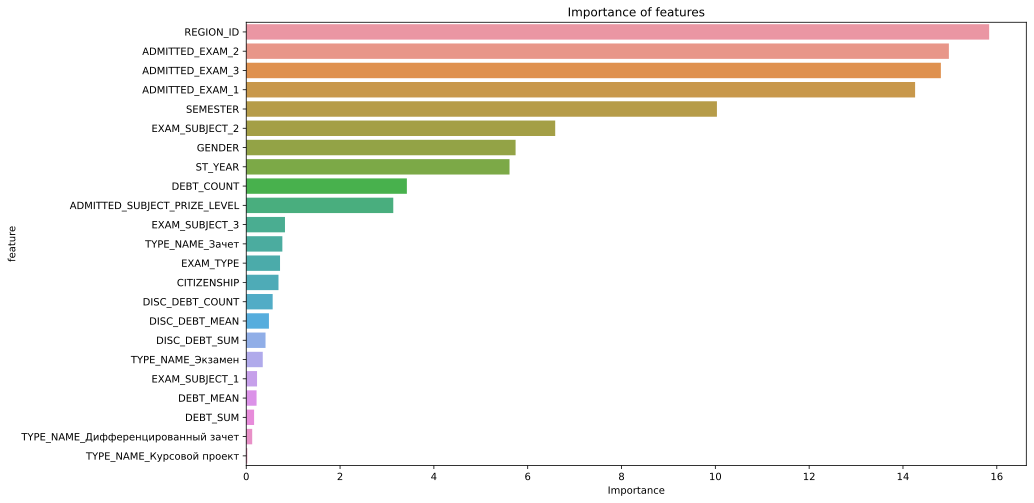

In [48]:
important_features_top = show_feature_importances(X_train.columns, 
                                                  model.feature_importances_, 
                                                  get_top=15)

Обработка тренировочного датасета

In [50]:
# fit on all data
X = data_train.drop(cols_to_drop + ['DEBT'], axis=1)
y = data_train['DEBT']

model.fit(X, y);

In [79]:
X.columns

Index(['ST_YEAR', 'SEMESTER', 'DEBT_MEAN', 'DEBT_SUM', 'DEBT_COUNT',
       'DISC_DEBT_MEAN', 'DISC_DEBT_SUM', 'DISC_DEBT_COUNT',
       'TYPE_NAME_Дифференцированный зачет', 'TYPE_NAME_Зачет',
       'TYPE_NAME_Курсовой проект', 'TYPE_NAME_Экзамен', 'GENDER',
       'CITIZENSHIP', 'EXAM_TYPE', 'EXAM_SUBJECT_1', 'EXAM_SUBJECT_2',
       'EXAM_SUBJECT_3', 'ADMITTED_EXAM_1', 'ADMITTED_EXAM_2',
       'ADMITTED_EXAM_3', 'ADMITTED_SUBJECT_PRIZE_LEVEL', 'REGION_ID'],
      dtype='object')

Сохраним полученную модель

In [76]:
import pickle
pickle.dump(model, open('PopovMV_JuniorMLContest2022.model', 'wb'))

In [51]:
# collect data for test

In [52]:
all_st_df_test = []

for st_year in data_train['ST_YEAR'].unique():
    for semester in data_train['SEMESTER'].unique():
        data_temp = (
            data_train
            .drop('DISC_ID', axis=1)
            [(data_train['ST_YEAR'] <= st_year) & (data_train['SEMESTER'] <= semester)]
            .groupby(['ISU', 'TYPE_NAME'], as_index=False)
            .agg(DEBT_MEAN=('DEBT', 'mean'), DEBT_SUM=('DEBT', 'sum'), DEBT_COUNT=('DEBT', 'count')
            )
        )
        data_temp['ST_YEAR'] = st_year + 1
        data_temp['SEMESTER'] = semester + 1
        
        all_st_df_test.append(data_temp)
        
all_disc_df_test = []

for st_year in data_train['ST_YEAR'].unique():
    for semester in data_train['SEMESTER'].unique():
        data_temp = (
            data_train
            .drop('ISU', axis=1)
            [(data_train['ST_YEAR'] <= st_year) & (data_train['SEMESTER'] <= semester)]
            .groupby(['DISC_ID', 'TYPE_NAME'], as_index=False)
            .agg(DISC_DEBT_MEAN=('DEBT', 'mean'), DISC_DEBT_SUM=('DEBT', 'sum'), DISC_DEBT_COUNT=('DEBT', 'count')
            )
        )
        data_temp['ST_YEAR'] = st_year + 1
        data_temp['SEMESTER'] = semester + 1
        
        all_disc_df_test.append(data_temp)
        
        
all_st_df_test = pd.concat(all_st_df_test)
all_disc_df_test = pd.concat(all_disc_df_test)

In [53]:
data_test = data_test.merge(all_st_df_test, on=['ISU', 'SEMESTER', 'ST_YEAR', 'TYPE_NAME'], how='left')
data_test = data_test.merge(all_disc_df_test, on=['DISC_ID', 'SEMESTER', 'ST_YEAR', 'TYPE_NAME'], how='left')

In [54]:
data_test = data_test.merge(data_portrait, on=['ISU'], how='left')

In [55]:
data_test = data_test.fillna(0)

In [56]:
data_test

ISU  ST_YEAR  SEMESTER               DISC_ID  \
0         22160896830459167     2021         3    552619236026332123   
1         22160896830459167     2021         3   5702509582319458883   
2         22160896830459167     2021         3   7735626259430674628   
3         22160896830459167     2021         3   8955667882044263414   
4         22160896830459167     2021         3   9075687484357010791   
...                     ...      ...       ...                   ...   
30908  18441846113897984349     2021         5   9075687484357010791   
30909  18441846113897984349     2021         5  11240958499619480192   
30910  18441846113897984349     2021         5  11511957009955804990   
30911  18441846113897984349     2021         5  11807846188624377660   
30912  18441846113897984349     2021         5  16952231586163840107   

      TYPE_NAME  DEBT_MEAN  DEBT_SUM  DEBT_COUNT  DISC_DEBT_MEAN  \
0       Экзамен        0.0       0.0         9.0        0.073494   
1         Зачет        0.0       0.0        11.0        0.000000   
2         Зачет        0.0       0.0        11.0        0.000000   
3         Зачет        0.0       0.0        11.0        0.062973   
4         Зачет        0.0       0.0        11.0        0.000000   
...         ...        ...       ...         ...             ...   
30908     Зачет        0.0       0.0        24.0        0.000000   
30909     Зачет        0.0       0.0        24.0        0.000000   
30910     Зачет        0.0       0.0        24.0        0.000000   
30911   Экзамен        0.0       0.0        17.0        0.000000   
30912     Зачет        0.0       0.0        24.0        0.000000   

       DISC_DEBT_SUM  ...           CITIZENSHIP  EXAM_TYPE     EXAM_SUBJECT_1  \
0              211.0  ...  15601729049989747827          1  70786669040476600   
1                0.0  ...  15601729049989747827          1  70786669040476600   
2                0.0  ...  15601729049989747827          1  70786669040476600   
3              233.0  ...  15601729049989747827          1  70786669040476600   
4                0.0  ...  15601729049989747827          1  70786669040476600   
...              ...  ...                   ...        ...                ...   
30908            0.0  ...  15601729049989747827          2  70786669040476600   
30909            0.0  ...  15601729049989747827          2  70786669040476600   
30910            0.0  ...  15601729049989747827          2  70786669040476600   
30911            0.0  ...  15601729049989747827          2  70786669040476600   
30912            0.0  ...  15601729049989747827          2  70786669040476600   

            EXAM_SUBJECT_2       EXAM_SUBJECT_3  ADMITTED_EXAM_1  \
0      5533732657842394915  8388269026169219461             78.0   
1      5533732657842394915  8388269026169219461             78.0   
2      5533732657842394915  8388269026169219461             78.0   
3      5533732657842394915  8388269026169219461             78.0   
4      5533732657842394915  8388269026169219461             78.0   
...                    ...                  ...              ...   
30908  5533732657842394915  8388269026169219461              0.0   
30909  5533732657842394915  8388269026169219461              0.0   
30910  5533732657842394915  8388269026169219461              0.0   
30911  5533732657842394915  8388269026169219461              0.0   
30912  5533732657842394915  8388269026169219461              0.0   

       ADMITTED_EXAM_2  ADMITTED_EXAM_3  ADMITTED_SUBJECT_PRIZE_LEVEL  \
0                 83.0             87.0                             5   
1                 83.0             87.0                             5   
2                 83.0             87.0                             5   
3                 83.0             87.0                             5   
4                 83.0             87.0                             5   
...                ...              ...                           ...   
30908              0.0              0.0  

In [57]:
data_test = data_test.join(pd.get_dummies(data_test['TYPE_NAME'], prefix='TYPE_NAME'))

In [58]:
cols_to_drop_test = ['ISU', 'DISC_ID', 'TYPE_NAME']

In [59]:
test_features = data_test.drop(cols_to_drop_test, axis=1)

In [60]:
final_preds = model.predict(test_features)

In [61]:
data_test['DEBT'] = final_preds

In [81]:
test_features

ST_YEAR  SEMESTER  DEBT_MEAN  DEBT_SUM  DEBT_COUNT  DISC_DEBT_MEAN  \
0         2021         3        0.0       0.0         9.0        0.073494   
1         2021         3        0.0       0.0        11.0        0.000000   
2         2021         3        0.0       0.0        11.0        0.000000   
3         2021         3        0.0       0.0        11.0        0.062973   
4         2021         3        0.0       0.0        11.0        0.000000   
...        ...       ...        ...       ...         ...             ...   
30908     2021         5        0.0       0.0        24.0        0.000000   
30909     2021         5        0.0       0.0        24.0        0.000000   
30910     2021         5        0.0       0.0        24.0        0.000000   
30911     2021         5        0.0       0.0        17.0        0.000000   
30912     2021         5        0.0       0.0        24.0        0.000000   

       DISC_DEBT_SUM  DISC_DEBT_COUNT  GENDER           CITIZENSHIP  ...  \
0              211.0           2871.0       1  15601729049989747827  ...   
1                0.0              1.0       1  15601729049989747827  ...   
2                0.0              0.0       1  15601729049989747827  ...   
3              233.0           3700.0       1  15601729049989747827  ...   
4                0.0              0.0       1  15601729049989747827  ...   
...              ...              ...     ...                   ...  ...   
30908            0.0           2845.0       1  15601729049989747827  ...   
30909            0.0              0.0       1  15601729049989747827  ...   
30910            0.0              0.0       1  15601729049989747827  ...   
30911            0.0              0.0       1  15601729049989747827  ...   
30912            0.0              0.0       1  15601729049989747827  ...   

            EXAM_SUBJECT_3  ADMITTED_EXAM_1  ADMITTED_EXAM_2  ADMITTED_EXAM_3  \
0      8388269026169219461             78.0             83.0             87.0   
1      8388269026169219461             78.0             83.0             87.0   
2      8388269026169219461             78.0             83.0             87.0   
3      8388269026169219461             78.0             83.0             87.0   
4      8388269026169219461             78.0             83.0             87.0   
...                    ...              ...              ...              ...   
30908  8388269026169219461              0.0              0.0              0.0   
30909  8388269026169219461              0.0              0.0              0.0   
30910  8388269026169219461              0.0              0.0              0.0   
30911  8388269026169219461              0.0              0.0              0.0   
30912  8388269026169219461              0.0              0.0              0.0   

       ADMITTED_SUBJECT_PRIZE_LEVEL            REGION_ID  \
0                                 5  4877310761925081124   
1                                 5  4877310761925081124   
2                                 5  4877310761925081124   
3                                 5  4877310761925081124   
4                                 5  4877310761925081124   
...                             ...                  ...   
30908                           2.0  4877310761925081124   
30909                           2.0  4877310761925081124   
30910                           2.0  4877310761925081124   
30911                           2.0  4877310761925081124   
30912                           2.0  4877310761925081124   

       TYPE_NAME_Дифференцированный зачет TYPE_NAME_Зачет  \
0                                       0               0   
1                                       0               1   
2                                       0               1   
3                                       0               1   
4                                       0               1   
...                                   ...             ...   
30908                                   0       

In [83]:
test_features.to_csv('for_MVP.csv', index=False)

In [84]:
test_features.columns

Index(['ST_YEAR', 'SEMESTER', 'DEBT_MEAN', 'DEBT_SUM', 'DEBT_COUNT',
       'DISC_DEBT_MEAN', 'DISC_DEBT_SUM', 'DISC_DEBT_COUNT', 'GENDER',
       'CITIZENSHIP', 'EXAM_TYPE', 'EXAM_SUBJECT_1', 'EXAM_SUBJECT_2',
       'EXAM_SUBJECT_3', 'ADMITTED_EXAM_1', 'ADMITTED_EXAM_2',
       'ADMITTED_EXAM_3', 'ADMITTED_SUBJECT_PRIZE_LEVEL', 'REGION_ID',
       'TYPE_NAME_Дифференцированный зачет', 'TYPE_NAME_Зачет',
       'TYPE_NAME_Курсовой проект', 'TYPE_NAME_Экзамен'],
      dtype='object')

In [66]:
data_test['ID'] = data_test[['ISU', 'ST_YEAR', 'DISC_ID', 'SEMESTER', 'TYPE_NAME']].apply(
        lambda x: f'ISU:{x[0]} | ST_YEAR:{x[1]} | DISC_ID:{x[2]} | SEMESTER:{x[3]} | TYPE_NAME:{x[4]}', axis =1)

In [67]:
res = data_test[['ID', 'DEBT']]

In [68]:
res.to_csv('PopovMV_final_preds.csv', index=False)

In [87]:
res[res['DEBT']==1]

ID  DEBT
0      ISU:22160896830459167 | ST_YEAR:2021 | DISC_ID...     1
1      ISU:22160896830459167 | ST_YEAR:2021 | DISC_ID...     1
2      ISU:22160896830459167 | ST_YEAR:2021 | DISC_ID...     1
3      ISU:22160896830459167 | ST_YEAR:2021 | DISC_ID...     1
4      ISU:22160896830459167 | ST_YEAR:2021 | DISC_ID...     1
...                                                  ...   ...
30908  ISU:18441846113897984349 | ST_YEAR:2021 | DISC...     1
30909  ISU:18441846113897984349 | ST_YEAR:2021 | DISC...     1
30910  ISU:18441846113897984349 | ST_YEAR:2021 | DISC...     1
30911  ISU:18441846113897984349 | ST_YEAR:2021 | DISC...     1
30912  ISU:18441846113897984349 | ST_YEAR:2021 | DISC...     1

[30913 rows x 2 columns]

In [70]:
res['DEBT'].value_counts()

0    29008
1     1905
Name: DEBT, dtype: int64

Результаты соревнования

In [73]:
from IPython.display import Image

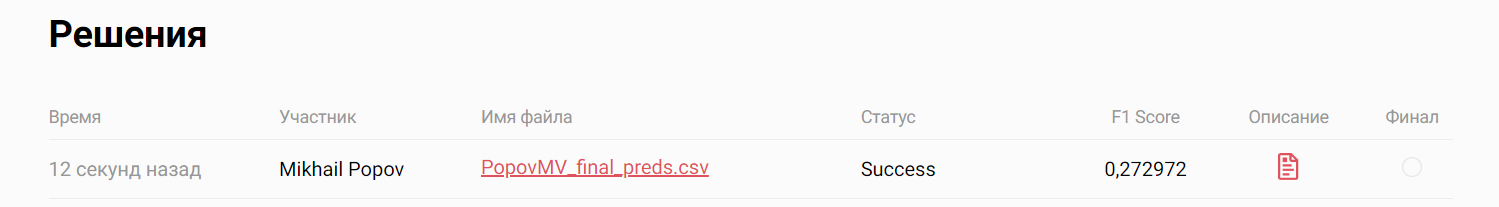

In [74]:
Image("solution_score.png")

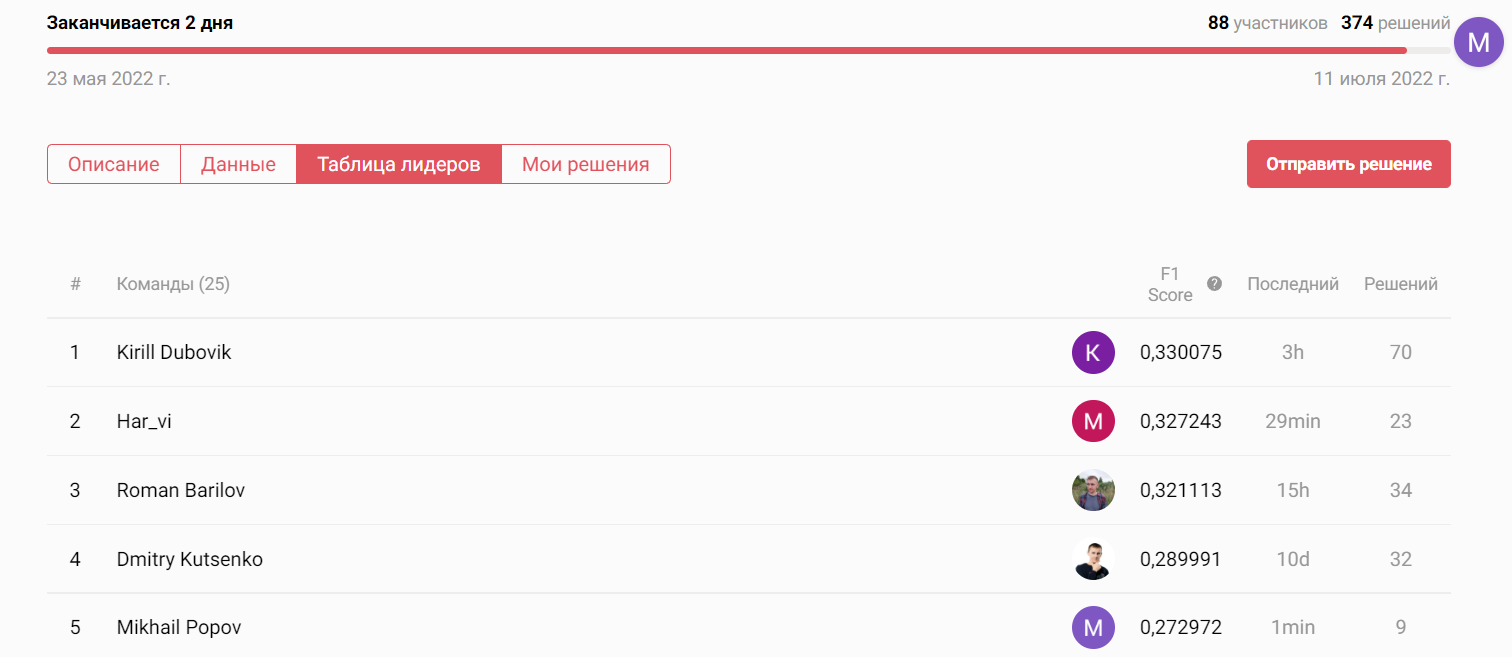

In [75]:
Image("leaderboard.png")